In [1]:
%cd ..

/home/briancy2/ai4code-baseline


In [2]:
# original val data
import json
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm
import os

val_df = pd.read_csv('data/val-Copy1.csv')
# Additional code cells
def clean_code(cell):
    return str(cell).replace("\\n", "\n")


def sample_cells(cells, n):
    cells = [clean_code(cell) for cell in cells]
    if n >= len(cells):
        return [cell[:200] for cell in cells]
    else:
        results = []
        # select cells sparsely based on the n value
        step = len(cells) / n
        idx = 0
        while int(np.round(idx)) < len(cells):
            results.append(cells[int(np.round(idx))])
            idx += step
        assert cells[0] in results
        if cells[-1] not in results:
            results[-1] = cells[-1]
        return results


def get_features(df):
    features = dict()
    df = df.sort_values("rank").reset_index(drop=True)
    for idx, sub_df in tqdm(df.groupby("id")):
        features[idx] = dict()
        total_md = sub_df[sub_df.cell_type == "markdown"].shape[0]
        code_sub_df = sub_df[sub_df.cell_type == "code"]
        total_code = code_sub_df.shape[0]
        
        codes = sample_cells(code_sub_df.source.values, 20)
        if len(codes)==0:
            codes = ["/n"]
        features[idx]["total_code"] = total_code
        features[idx]["total_md"] = total_md
       
        features[idx]["codes"] = codes
    return features

val_fts = get_features(val_df)
val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

100%|██████████| 13964/13964 [00:15<00:00, 881.17it/s] 


In [3]:
%cd code/

/home/briancy2/ai4code-baseline/code


In [4]:
from dataset import MarkdownDataset

In [2]:
%cd ..

/home/briancy2/ai4code-baseline


In [6]:
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()
def validate(model, val_loader):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in tqdm(enumerate(tbar)):
            inputs, target = read_data(data)

            pred = model(*inputs)

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
    
    return np.concatenate(labels), np.concatenate(preds)

In [7]:
model_path = "microsoft/codebert-base-mlm"
ckpt_path = "/outputs/codebert_after_pretrain/model-4.bin"

from tqdm import tqdm
import sys, os
from transformers import AutoModel, AutoTokenizer, RobertaForMaskedLM
import torch.nn.functional as F
import torch.nn as nn
import torch


class MarkdownModel(nn.Module):
    def __init__(self, model_path):
        super(MarkdownModel, self).__init__()
        #self.max_input_len = 16384
        #self.max_input_len += 2
        self.attention_window = 512
        self.md_max_len = 64
        # lengthen model
        self.model = RobertaForMaskedLM.from_pretrained(model_path).roberta
        self.top = nn.Linear(769, 1)
    def forward(self, ids, mask, fts):
        #global_attention_mask = torch.zeros_like(ids)
        #global_attention_mask[:self.md_max_len] = 0
        #x = self.model(input_ids=ids, attention_mask=mask)[0]
        x = self.model(input_ids=ids, attention_mask=mask)[0]
        #print("fts", fts)
        x = torch.cat((x[:, 0, :], fts), 1)
        #print("/n", x.size())
        x = self.top(x)
        return x        
        
from tqdm import tqdm
from collections import OrderedDict
import torch
from torch.utils.data import DataLoader, Dataset
def predict(model_path, ckpt_path):
    model = MarkdownModel(model_path)
    
    #model.load_state_dict(torch.load(ckpt_path))
    state_dict = torch.load(ckpt_path)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict, strict=False)
    BS = 32
    NW = 1
    MAX_LEN = 64
    val_df["pct_rank"] = 0
    val_ds = MarkdownDataset(val_df_mark, md_max_len=64,total_max_len=512, model_name_or_path=model_path, fts=val_fts)
    val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                              pin_memory=False, drop_last=False)
    model =  model.to('cuda')
    y_val, y_pred = validate(model, val_loader)
    return y_val, y_pred

In [8]:
def kendall_tau(ground_truth, predictions):
    kts = []
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions = count_inversions(ranks)
        n = len(gt)
        total_2max = n * (n - 1)
        kts.append(1 - 4 * total_inversions / total_2max)
    return kts

In [9]:
from pathlib import Path
df_orders = pd.read_csv(
    str(Path.cwd())+'/data/processed_dataset_1/train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

/tmp/ipykernel_416526/3166657355.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df_orders = pd.read_csv(


In [10]:
from bisect import bisect

def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions

In [11]:
y_val, y_pred = predict(model_path, str(Path.cwd())+ckpt_path)


  0%|          | 0/6749 [00:00<?, ?it/s]


0it [00:00, ?it/s]
1it [00:01,  1.31s/it]

  0%|          | 1/6749 [00:01<2:27:53,  1.31s/it]


2it [00:01,  1.38it/s]

  0%|          | 2/6749 [00:01<1:21:29,  1.38it/s]


3it [00:01,  1.87it/s]

  0%|          | 3/6749 [00:01<1:00:19,  1.86it/s]


4it [00:02,  2.23it/s]

  0%|          | 4/6749 [00:02<50:24,  2.23it/s]  


5it [00:02,  2.51it/s]

  0%|          | 5/6749 [00:02<45:14,  2.48it/s]


6it [00:02,  2.69it/s]

  0%|          | 6/6749 [00:02<41:56,  2.68it/s]


7it [00:03,  1.81it/s]

  0%|          | 7/6749 [00:03<1:02:07,  1.81it/s]


8it [00:04,  1.67it/s]

  0%|          | 8/6749 [00:04<1:07:12,  1.67it/s]


9it [00:04,  1.94it/s]

  0%|          | 9/6749 [00:04<58:02,  1.94it/s]  


10it [00:05,  2.16it/s]

  0%|          | 10/6749 [00:05<51:58,  2.16it/s]


11it [00:05,  2.20it/s]

  0%|          | 11/6749 [00:05<50:58,  2.20it/s]


12it [00:05,  2.40it/s]

  0%|          | 12/6749 [00:05<46:44,  2.40it/s]


13it [00:06,  2.59it/s]

  0%|          | 13/6749 [00:06<43:16,  2.59it/s]


14it [00:06,  2.74it/s]

  0%|          | 14/6749 [00:06<40:53,  2.75it/s]


15it [00:06,  2.84it/s]

  0%|          | 15/6749 [00:06<39:23,  2.85it/s]


16it [00:07,  2.93it/s]

  0%|          | 16/6749 [00:07<38:25,  2.92it/s]


17it [00:07,  2.99it/s]

  0%|          | 17/6749 [00:07<37:30,  2.99it/s]


18it [00:07,  3.03it/s]

  0%|          | 18/6749 [00:07<37:12,  3.02it/s]


19it [00:08,  2.95it/s]

  0%|          | 19/6749 [00:08<38:06,  2.94it/s]


20it [00:08,  2.99it/s]

  0%|          | 20/6749 [00:08<37:21,  3.00it/s]


21it [00:08,  3.04it/s]

  0%|          | 21/6749 [00:08<36:48,  3.05it/s]


22it [00:09,  2.84it/s]

  0%|          | 22/6749 [00:09<39:25,  2.84it/s]


23it [00:09,  2.85it/s]

  0%|          | 23/6749 [00:09<39:19,  2.85it/s]


24it [00:09,  2.94it/s]

  0%|          | 24/6749 [00:09<38:05,  2.94it/s]


25it [00:10,  3.00it/s]

  0%|          | 25/6749 [00:10<37:18,  3.00it/s]


26it [00:10,  3.05it/s]

  0%|          | 26/6749 [00:10<36:41,  3.05it/s]


27it [00:10,  3.08it/s]

  0%|          | 27/6749 [00:10<36:18,  3.09it/s]


28it [00:11,  3.10it/s]

  0%|          | 28/6749 [00:11<36:04,  3.11it/s]


29it [00:11,  3.13it/s]

  0%|          | 29/6749 [00:11<35:48,  3.13it/s]


30it [00:11,  3.14it/s]

  0%|          | 30/6749 [00:11<35:47,  3.13it/s]


31it [00:12,  3.14it/s]

  0%|          | 31/6749 [00:12<35:38,  3.14it/s]


32it [00:12,  3.15it/s]

  0%|          | 32/6749 [00:12<35:32,  3.15it/s]


33it [00:12,  3.15it/s]

  0%|          | 33/6749 [00:12<35:35,  3.15it/s]


34it [00:13,  3.14it/s]

  1%|          | 34/6749 [00:13<35:37,  3.14it/s]


35it [00:13,  3.15it/s]

  1%|          | 35/6749 [00:13<35:51,  3.12it/s]


36it [00:13,  3.12it/s]

  1%|          | 36/6749 [00:13<35:42,  3.13it/s]


37it [00:14,  3.09it/s]

  1%|          | 37/6749 [00:14<36:04,  3.10it/s]


38it [00:14,  3.11it/s]

  1%|          | 38/6749 [00:14<35:53,  3.12it/s]


39it [00:14,  3.13it/s]

  1%|          | 39/6749 [00:14<35:43,  3.13it/s]


40it [00:15,  3.14it/s]

  1%|          | 40/6749 [00:15<35:33,  3.14it/s]


41it [00:15,  3.15it/s]

  1%|          | 41/6749 [00:15<35:29,  3.15it/s]


42it [00:15,  3.16it/s]

  1%|          | 42/6749 [00:15<35:25,  3.15it/s]


43it [00:15,  3.15it/s]

  1%|          | 43/6749 [00:15<35:30,  3.15it/s]


44it [00:16,  3.14it/s]

  1%|          | 44/6749 [00:16<35:33,  3.14it/s]


45it [00:16,  3.14it/s]

  1%|          | 45/6749 [00:16<35:31,  3.15it/s]


46it [00:16,  3.15it/s]

  1%|          | 46/6749 [00:16<35:26,  3.15it/s]


47it [00:17,  3.15it/s]

  1%|          | 47/6749 [00:17<35:26,  3.15it/s]


48it [00:17,  3.15it/s]

  1%|          | 48/6749 [00:17<35:38,  3.13it/s]


49it [00:17,  3.14it/s]

  1%|          | 49/6749 [00:17<35:29,  3.15it/s]


50it [00:18,  3.14it/s]

  1%|          | 50/6749 [00:18<35:25,  3.15it/s]


51it [00:18,  3.16it/s]

  1%|          | 51/6749 [00:18<35:18,  3.16it/s]


52it [00:18,  3.16it/s]

  1%|          | 52/6749 [00:18<35:21,  3.16it/s]


53it [00:19,  3.15it/s]

  1%|          | 53/6749 [00:19<35:26,  3.15it/s]


54it [00:19,  2.74it/s]

  1%|          | 54/6749 [00:19<40:39,  2.74it/s]


55it [00:20,  2.47it/s]

  1%|          | 55/6749 [00:20<45:06,  2.47it/s]


56it [00:20,  2.62it/s]

  1%|          | 56/6749 [00:20<42:41,  2.61it/s]


57it [00:20,  2.53it/s]

  1%|          | 57/6749 [00:20<44:03,  2.53it/s]


58it [00:21,  2.69it/s]

  1%|          | 58/6749 [00:21<41:30,  2.69it/s]


59it [00:21,  2.80it/s]

  1%|          | 59/6749 [00:21<39:42,  2.81it/s]


60it [00:21,  2.88it/s]

  1%|          | 60/6749 [00:21<38:40,  2.88it/s]


61it [00:22,  2.95it/s]

  1%|          | 61/6749 [00:22<37:51,  2.94it/s]


62it [00:22,  2.99it/s]

  1%|          | 62/6749 [00:22<37:16,  2.99it/s]


63it [00:22,  3.04it/s]

  1%|          | 63/6749 [00:22<36:41,  3.04it/s]


64it [00:23,  2.86it/s]

  1%|          | 64/6749 [00:23<39:12,  2.84it/s]


65it [00:23,  2.28it/s]

  1%|          | 65/6749 [00:23<48:51,  2.28it/s]


66it [00:24,  2.00it/s]

  1%|          | 66/6749 [00:24<55:28,  2.01it/s]


67it [00:24,  2.11it/s]

  1%|          | 67/6749 [00:24<53:03,  2.10it/s]


68it [00:25,  2.32it/s]

  1%|          | 68/6749 [00:25<48:05,  2.32it/s]


69it [00:25,  2.49it/s]

  1%|          | 69/6749 [00:25<44:29,  2.50it/s]


70it [00:25,  2.65it/s]

  1%|          | 70/6749 [00:25<41:49,  2.66it/s]


71it [00:26,  2.77it/s]

  1%|          | 71/6749 [00:26<40:10,  2.77it/s]


72it [00:26,  2.85it/s]

  1%|          | 72/6749 [00:26<38:56,  2.86it/s]


73it [00:26,  2.93it/s]

  1%|          | 73/6749 [00:26<37:54,  2.94it/s]


74it [00:27,  2.99it/s]

  1%|          | 74/6749 [00:27<37:17,  2.98it/s]


75it [00:27,  3.03it/s]

  1%|          | 75/6749 [00:27<36:37,  3.04it/s]


76it [00:27,  3.06it/s]

  1%|          | 76/6749 [00:27<36:25,  3.05it/s]


77it [00:28,  3.06it/s]

  1%|          | 77/6749 [00:28<36:11,  3.07it/s]


78it [00:28,  3.09it/s]

  1%|          | 78/6749 [00:28<35:51,  3.10it/s]


79it [00:28,  3.11it/s]

  1%|          | 79/6749 [00:28<35:37,  3.12it/s]


80it [00:29,  3.12it/s]

  1%|          | 80/6749 [00:29<35:37,  3.12it/s]


81it [00:29,  3.12it/s]

  1%|          | 81/6749 [00:29<35:41,  3.11it/s]


82it [00:29,  3.12it/s]

  1%|          | 82/6749 [00:29<35:53,  3.10it/s]


83it [00:30,  3.08it/s]

  1%|          | 83/6749 [00:30<36:07,  3.08it/s]


84it [00:30,  3.08it/s]

  1%|          | 84/6749 [00:30<35:53,  3.10it/s]


85it [00:30,  3.10it/s]

  1%|▏         | 85/6749 [00:30<35:53,  3.09it/s]


86it [00:31,  3.10it/s]

  1%|▏         | 86/6749 [00:31<35:45,  3.11it/s]


87it [00:31,  3.10it/s]

  1%|▏         | 87/6749 [00:31<35:43,  3.11it/s]


88it [00:31,  3.12it/s]

  1%|▏         | 88/6749 [00:31<35:32,  3.12it/s]


89it [00:31,  3.12it/s]

  1%|▏         | 89/6749 [00:31<35:32,  3.12it/s]


90it [00:32,  3.13it/s]

  1%|▏         | 90/6749 [00:32<35:25,  3.13it/s]


91it [00:32,  3.13it/s]

  1%|▏         | 91/6749 [00:32<35:38,  3.11it/s]


92it [00:32,  3.09it/s]

  1%|▏         | 92/6749 [00:32<35:51,  3.09it/s]


93it [00:33,  3.10it/s]

  1%|▏         | 93/6749 [00:33<35:52,  3.09it/s]


94it [00:33,  3.10it/s]

  1%|▏         | 94/6749 [00:33<35:40,  3.11it/s]


95it [00:33,  3.10it/s]

  1%|▏         | 95/6749 [00:33<35:44,  3.10it/s]


96it [00:34,  3.11it/s]

  1%|▏         | 96/6749 [00:34<35:35,  3.12it/s]


97it [00:34,  3.12it/s]

  1%|▏         | 97/6749 [00:34<35:29,  3.12it/s]


98it [00:34,  3.13it/s]

  1%|▏         | 98/6749 [00:34<35:18,  3.14it/s]


99it [00:35,  3.14it/s]

  1%|▏         | 99/6749 [00:35<35:19,  3.14it/s]


100it [00:35,  3.14it/s]

  1%|▏         | 100/6749 [00:35<35:19,  3.14it/s]


101it [00:35,  3.13it/s]

  1%|▏         | 101/6749 [00:35<35:21,  3.13it/s]


102it [00:36,  3.13it/s]

  2%|▏         | 102/6749 [00:36<35:23,  3.13it/s]


103it [00:36,  3.14it/s]

  2%|▏         | 103/6749 [00:36<35:18,  3.14it/s]


104it [00:36,  3.13it/s]

  2%|▏         | 104/6749 [00:36<35:22,  3.13it/s]


105it [00:37,  3.13it/s]

  2%|▏         | 105/6749 [00:37<35:18,  3.14it/s]


106it [00:37,  3.13it/s]

  2%|▏         | 106/6749 [00:37<35:22,  3.13it/s]


107it [00:37,  3.10it/s]

  2%|▏         | 107/6749 [00:37<35:44,  3.10it/s]


108it [00:38,  3.11it/s]

  2%|▏         | 108/6749 [00:38<35:49,  3.09it/s]


109it [00:38,  3.09it/s]

  2%|▏         | 109/6749 [00:38<35:55,  3.08it/s]


110it [00:38,  3.07it/s]

  2%|▏         | 110/6749 [00:38<35:55,  3.08it/s]


111it [00:39,  3.07it/s]

  2%|▏         | 111/6749 [00:39<36:24,  3.04it/s]


112it [00:39,  3.01it/s]

  2%|▏         | 112/6749 [00:39<36:34,  3.02it/s]


113it [00:39,  3.04it/s]

  2%|▏         | 113/6749 [00:39<36:13,  3.05it/s]


114it [00:40,  2.95it/s]

  2%|▏         | 114/6749 [00:40<37:58,  2.91it/s]


115it [00:40,  2.28it/s]

  2%|▏         | 115/6749 [00:40<48:22,  2.29it/s]


116it [00:41,  2.46it/s]

  2%|▏         | 116/6749 [00:41<44:44,  2.47it/s]


117it [00:41,  2.63it/s]

  2%|▏         | 117/6749 [00:41<42:07,  2.62it/s]


118it [00:41,  2.75it/s]

  2%|▏         | 118/6749 [00:41<40:20,  2.74it/s]


119it [00:42,  2.83it/s]

  2%|▏         | 119/6749 [00:42<38:59,  2.83it/s]


120it [00:42,  2.89it/s]

  2%|▏         | 120/6749 [00:42<38:02,  2.90it/s]


121it [00:42,  2.96it/s]

  2%|▏         | 121/6749 [00:42<37:14,  2.97it/s]


122it [00:43,  3.00it/s]

  2%|▏         | 122/6749 [00:43<36:42,  3.01it/s]


123it [00:43,  3.03it/s]

  2%|▏         | 123/6749 [00:43<36:23,  3.03it/s]


124it [00:43,  3.05it/s]

  2%|▏         | 124/6749 [00:43<36:08,  3.06it/s]


125it [00:43,  3.07it/s]

  2%|▏         | 125/6749 [00:44<36:11,  3.05it/s]


126it [00:44,  3.06it/s]

  2%|▏         | 126/6749 [00:44<35:59,  3.07it/s]


127it [00:44,  2.80it/s]

  2%|▏         | 127/6749 [00:44<39:21,  2.80it/s]


128it [00:45,  2.63it/s]

  2%|▏         | 128/6749 [00:45<41:57,  2.63it/s]


129it [00:45,  2.76it/s]

  2%|▏         | 129/6749 [00:45<39:56,  2.76it/s]


130it [00:45,  2.86it/s]

  2%|▏         | 130/6749 [00:45<38:38,  2.85it/s]


131it [00:46,  2.90it/s]

  2%|▏         | 131/6749 [00:46<38:06,  2.89it/s]


132it [00:46,  2.95it/s]

  2%|▏         | 132/6749 [00:46<37:28,  2.94it/s]


133it [00:46,  2.80it/s]

  2%|▏         | 133/6749 [00:46<39:18,  2.81it/s]


134it [00:47,  2.89it/s]

  2%|▏         | 134/6749 [00:47<38:23,  2.87it/s]


135it [00:47,  2.92it/s]

  2%|▏         | 135/6749 [00:47<37:39,  2.93it/s]


136it [00:47,  2.91it/s]

  2%|▏         | 136/6749 [00:47<37:49,  2.91it/s]


137it [00:48,  2.97it/s]

  2%|▏         | 137/6749 [00:48<37:06,  2.97it/s]


138it [00:48,  2.88it/s]

  2%|▏         | 138/6749 [00:48<38:13,  2.88it/s]


139it [00:48,  2.93it/s]

  2%|▏         | 139/6749 [00:48<37:28,  2.94it/s]


140it [00:49,  2.98it/s]

  2%|▏         | 140/6749 [00:49<36:52,  2.99it/s]


141it [00:49,  2.44it/s]

  2%|▏         | 141/6749 [00:49<45:27,  2.42it/s]


142it [00:50,  2.11it/s]

  2%|▏         | 142/6749 [00:50<52:30,  2.10it/s]


143it [00:50,  2.09it/s]

  2%|▏         | 143/6749 [00:50<52:30,  2.10it/s]


144it [00:51,  1.92it/s]

  2%|▏         | 144/6749 [00:51<57:11,  1.92it/s]


145it [00:51,  2.04it/s]

  2%|▏         | 145/6749 [00:51<53:52,  2.04it/s]


146it [00:52,  2.27it/s]

  2%|▏         | 146/6749 [00:52<48:29,  2.27it/s]


147it [00:52,  2.45it/s]

  2%|▏         | 147/6749 [00:52<44:44,  2.46it/s]


148it [00:52,  2.62it/s]

  2%|▏         | 148/6749 [00:52<41:50,  2.63it/s]


149it [00:53,  2.76it/s]

  2%|▏         | 149/6749 [00:53<39:58,  2.75it/s]


150it [00:53,  2.77it/s]

  2%|▏         | 150/6749 [00:53<39:37,  2.78it/s]


151it [00:53,  2.85it/s]

  2%|▏         | 151/6749 [00:53<38:48,  2.83it/s]


152it [00:54,  2.83it/s]

  2%|▏         | 152/6749 [00:54<38:44,  2.84it/s]


153it [00:54,  2.87it/s]

  2%|▏         | 153/6749 [00:54<38:26,  2.86it/s]


154it [00:54,  2.90it/s]

  2%|▏         | 154/6749 [00:54<37:42,  2.92it/s]


155it [00:55,  2.96it/s]

  2%|▏         | 155/6749 [00:55<36:57,  2.97it/s]


156it [00:55,  3.00it/s]

  2%|▏         | 156/6749 [00:55<36:31,  3.01it/s]


157it [00:55,  3.04it/s]

  2%|▏         | 157/6749 [00:55<36:02,  3.05it/s]


158it [00:56,  3.08it/s]

  2%|▏         | 158/6749 [00:56<35:39,  3.08it/s]


159it [00:56,  3.08it/s]

  2%|▏         | 159/6749 [00:56<35:33,  3.09it/s]


160it [00:56,  3.10it/s]

  2%|▏         | 160/6749 [00:56<35:25,  3.10it/s]


161it [00:57,  3.10it/s]

  2%|▏         | 161/6749 [00:57<35:26,  3.10it/s]


162it [00:57,  3.10it/s]

  2%|▏         | 162/6749 [00:57<35:23,  3.10it/s]


163it [00:57,  3.10it/s]

  2%|▏         | 163/6749 [00:57<35:29,  3.09it/s]


164it [00:58,  3.10it/s]

  2%|▏         | 164/6749 [00:58<35:23,  3.10it/s]


165it [00:58,  3.10it/s]

  2%|▏         | 165/6749 [00:58<35:21,  3.10it/s]


166it [00:58,  3.10it/s]

  2%|▏         | 166/6749 [00:58<35:23,  3.10it/s]


167it [00:59,  3.11it/s]

  2%|▏         | 167/6749 [00:59<35:17,  3.11it/s]


168it [00:59,  3.12it/s]

  2%|▏         | 168/6749 [00:59<35:07,  3.12it/s]


169it [00:59,  3.12it/s]

  3%|▎         | 169/6749 [00:59<35:04,  3.13it/s]


170it [01:00,  3.13it/s]

  3%|▎         | 170/6749 [01:00<35:07,  3.12it/s]


171it [01:00,  3.12it/s]

  3%|▎         | 171/6749 [01:00<35:03,  3.13it/s]


172it [01:00,  3.11it/s]

  3%|▎         | 172/6749 [01:00<35:14,  3.11it/s]


173it [01:01,  2.65it/s]

  3%|▎         | 173/6749 [01:01<41:28,  2.64it/s]


174it [01:01,  2.11it/s]

  3%|▎         | 174/6749 [01:01<51:49,  2.11it/s]


175it [01:02,  2.34it/s]

  3%|▎         | 175/6749 [01:02<46:59,  2.33it/s]


176it [01:02,  2.52it/s]

  3%|▎         | 176/6749 [01:02<43:24,  2.52it/s]


177it [01:02,  2.68it/s]

  3%|▎         | 177/6749 [01:02<40:52,  2.68it/s]


178it [01:03,  2.80it/s]

  3%|▎         | 178/6749 [01:03<39:05,  2.80it/s]


179it [01:03,  2.90it/s]

  3%|▎         | 179/6749 [01:03<37:46,  2.90it/s]


180it [01:03,  2.96it/s]

  3%|▎         | 180/6749 [01:03<37:10,  2.95it/s]


181it [01:04,  2.98it/s]

  3%|▎         | 181/6749 [01:04<36:52,  2.97it/s]


182it [01:04,  3.01it/s]

  3%|▎         | 182/6749 [01:04<36:26,  3.00it/s]


183it [01:04,  3.03it/s]

  3%|▎         | 183/6749 [01:04<36:03,  3.03it/s]


184it [01:05,  3.05it/s]

  3%|▎         | 184/6749 [01:05<35:48,  3.06it/s]


185it [01:05,  3.07it/s]

  3%|▎         | 185/6749 [01:05<35:38,  3.07it/s]


186it [01:05,  3.08it/s]

  3%|▎         | 186/6749 [01:05<35:29,  3.08it/s]


187it [01:06,  3.09it/s]

  3%|▎         | 187/6749 [01:06<35:34,  3.07it/s]


188it [01:06,  2.80it/s]

  3%|▎         | 188/6749 [01:06<39:00,  2.80it/s]


189it [01:06,  2.83it/s]

  3%|▎         | 189/6749 [01:06<38:35,  2.83it/s]


190it [01:07,  2.56it/s]

  3%|▎         | 190/6749 [01:07<42:44,  2.56it/s]


191it [01:07,  2.69it/s]

  3%|▎         | 191/6749 [01:07<40:56,  2.67it/s]


192it [01:08,  2.68it/s]

  3%|▎         | 192/6749 [01:08<40:42,  2.68it/s]


193it [01:08,  2.72it/s]

  3%|▎         | 193/6749 [01:08<40:07,  2.72it/s]


194it [01:09,  2.34it/s]

  3%|▎         | 194/6749 [01:09<46:40,  2.34it/s]


195it [01:09,  2.17it/s]

  3%|▎         | 195/6749 [01:09<50:21,  2.17it/s]


196it [01:09,  2.39it/s]

  3%|▎         | 196/6749 [01:09<45:48,  2.38it/s]


197it [01:10,  2.30it/s]

  3%|▎         | 197/6749 [01:10<47:38,  2.29it/s]


198it [01:10,  2.04it/s]

  3%|▎         | 198/6749 [01:10<53:22,  2.05it/s]


199it [01:11,  2.25it/s]

  3%|▎         | 199/6749 [01:11<48:31,  2.25it/s]


200it [01:11,  2.45it/s]

  3%|▎         | 200/6749 [01:11<44:25,  2.46it/s]


201it [01:11,  2.62it/s]

  3%|▎         | 201/6749 [01:11<42:03,  2.60it/s]


202it [01:12,  2.46it/s]

  3%|▎         | 202/6749 [01:12<44:14,  2.47it/s]


203it [01:12,  2.56it/s]

  3%|▎         | 203/6749 [01:12<42:33,  2.56it/s]


204it [01:13,  2.48it/s]

  3%|▎         | 204/6749 [01:13<44:09,  2.47it/s]


205it [01:13,  2.40it/s]

  3%|▎         | 205/6749 [01:13<45:39,  2.39it/s]


206it [01:14,  2.03it/s]

  3%|▎         | 206/6749 [01:14<53:37,  2.03it/s]


207it [01:14,  1.93it/s]

  3%|▎         | 207/6749 [01:14<56:20,  1.94it/s]


208it [01:15,  2.14it/s]

  3%|▎         | 208/6749 [01:15<50:47,  2.15it/s]


209it [01:15,  2.27it/s]

  3%|▎         | 209/6749 [01:15<48:01,  2.27it/s]


210it [01:16,  2.22it/s]

  3%|▎         | 210/6749 [01:16<49:04,  2.22it/s]


211it [01:16,  2.36it/s]

  3%|▎         | 211/6749 [01:16<46:10,  2.36it/s]


212it [01:16,  2.43it/s]

  3%|▎         | 212/6749 [01:16<44:48,  2.43it/s]


213it [01:17,  2.32it/s]

  3%|▎         | 213/6749 [01:17<47:17,  2.30it/s]


214it [01:17,  2.39it/s]

  3%|▎         | 214/6749 [01:17<45:33,  2.39it/s]


215it [01:18,  2.56it/s]

  3%|▎         | 215/6749 [01:18<42:26,  2.57it/s]


216it [01:18,  1.82it/s]

  3%|▎         | 216/6749 [01:18<1:00:03,  1.81it/s]


217it [01:19,  1.97it/s]

  3%|▎         | 217/6749 [01:19<55:13,  1.97it/s]  


218it [01:19,  2.20it/s]

  3%|▎         | 218/6749 [01:19<49:15,  2.21it/s]


219it [01:20,  2.40it/s]

  3%|▎         | 219/6749 [01:20<45:10,  2.41it/s]


220it [01:20,  2.37it/s]

  3%|▎         | 220/6749 [01:20<45:51,  2.37it/s]


221it [01:20,  2.45it/s]

  3%|▎         | 221/6749 [01:20<44:19,  2.45it/s]


222it [01:21,  2.62it/s]

  3%|▎         | 222/6749 [01:21<41:42,  2.61it/s]


223it [01:21,  2.74it/s]

  3%|▎         | 223/6749 [01:21<39:38,  2.74it/s]


224it [01:21,  2.84it/s]

  3%|▎         | 224/6749 [01:21<38:11,  2.85it/s]


225it [01:22,  2.91it/s]

  3%|▎         | 225/6749 [01:22<37:20,  2.91it/s]


226it [01:22,  2.97it/s]

  3%|▎         | 226/6749 [01:22<36:33,  2.97it/s]


227it [01:22,  2.98it/s]

  3%|▎         | 227/6749 [01:22<36:25,  2.98it/s]


228it [01:23,  3.03it/s]

  3%|▎         | 228/6749 [01:23<35:55,  3.03it/s]


229it [01:23,  3.05it/s]

  3%|▎         | 229/6749 [01:23<35:39,  3.05it/s]


230it [01:23,  3.06it/s]

  3%|▎         | 230/6749 [01:23<35:59,  3.02it/s]


231it [01:24,  2.46it/s]

  3%|▎         | 231/6749 [01:24<44:05,  2.46it/s]


232it [01:24,  2.59it/s]

  3%|▎         | 232/6749 [01:24<41:49,  2.60it/s]


233it [01:25,  2.72it/s]

  3%|▎         | 233/6749 [01:25<39:47,  2.73it/s]


234it [01:25,  2.82it/s]

  3%|▎         | 234/6749 [01:25<38:23,  2.83it/s]


235it [01:25,  2.68it/s]

  3%|▎         | 235/6749 [01:25<40:25,  2.69it/s]


236it [01:26,  2.80it/s]

  3%|▎         | 236/6749 [01:26<38:41,  2.81it/s]


237it [01:26,  2.89it/s]

  4%|▎         | 237/6749 [01:26<37:31,  2.89it/s]


238it [01:26,  2.67it/s]

  4%|▎         | 238/6749 [01:26<41:00,  2.65it/s]


239it [01:27,  2.38it/s]

  4%|▎         | 239/6749 [01:27<45:28,  2.39it/s]


240it [01:27,  2.55it/s]

  4%|▎         | 240/6749 [01:27<42:26,  2.56it/s]


241it [01:28,  2.43it/s]

  4%|▎         | 241/6749 [01:28<44:33,  2.43it/s]


242it [01:28,  2.13it/s]

  4%|▎         | 242/6749 [01:28<50:48,  2.13it/s]


243it [01:29,  2.34it/s]

  4%|▎         | 243/6749 [01:29<46:17,  2.34it/s]


244it [01:29,  2.42it/s]

  4%|▎         | 244/6749 [01:29<44:46,  2.42it/s]


245it [01:29,  2.48it/s]

  4%|▎         | 245/6749 [01:29<43:45,  2.48it/s]


246it [01:30,  2.50it/s]

  4%|▎         | 246/6749 [01:30<43:50,  2.47it/s]


247it [01:31,  1.68it/s]

  4%|▎         | 247/6749 [01:31<1:04:15,  1.69it/s]


248it [01:31,  1.93it/s]

  4%|▎         | 248/6749 [01:31<56:00,  1.93it/s]  


249it [01:31,  2.16it/s]

  4%|▎         | 249/6749 [01:31<50:00,  2.17it/s]


250it [01:32,  2.37it/s]

  4%|▎         | 250/6749 [01:32<45:36,  2.38it/s]


251it [01:32,  2.55it/s]

  4%|▎         | 251/6749 [01:32<42:31,  2.55it/s]


252it [01:33,  2.41it/s]

  4%|▎         | 252/6749 [01:33<44:49,  2.42it/s]


253it [01:33,  2.40it/s]

  4%|▎         | 253/6749 [01:33<45:07,  2.40it/s]


254it [01:33,  2.51it/s]

  4%|▍         | 254/6749 [01:33<43:04,  2.51it/s]


255it [01:34,  2.66it/s]

  4%|▍         | 255/6749 [01:34<40:41,  2.66it/s]


256it [01:34,  2.03it/s]

  4%|▍         | 256/6749 [01:34<53:22,  2.03it/s]


257it [01:35,  2.16it/s]

  4%|▍         | 257/6749 [01:35<50:11,  2.16it/s]


258it [01:35,  2.23it/s]

  4%|▍         | 258/6749 [01:35<48:34,  2.23it/s]


259it [01:36,  2.21it/s]

  4%|▍         | 259/6749 [01:36<48:46,  2.22it/s]


260it [01:36,  2.16it/s]

  4%|▍         | 260/6749 [01:36<50:27,  2.14it/s]


261it [01:37,  2.35it/s]

  4%|▍         | 261/6749 [01:37<46:00,  2.35it/s]


262it [01:37,  2.52it/s]

  4%|▍         | 262/6749 [01:37<42:37,  2.54it/s]


263it [01:37,  2.65it/s]

  4%|▍         | 263/6749 [01:37<40:44,  2.65it/s]


264it [01:38,  2.74it/s]

  4%|▍         | 264/6749 [01:38<39:21,  2.75it/s]


265it [01:38,  2.80it/s]

  4%|▍         | 265/6749 [01:38<38:32,  2.80it/s]


266it [01:38,  2.89it/s]

  4%|▍         | 266/6749 [01:38<37:23,  2.89it/s]


267it [01:39,  2.95it/s]

  4%|▍         | 267/6749 [01:39<36:44,  2.94it/s]


268it [01:39,  2.98it/s]

  4%|▍         | 268/6749 [01:39<36:08,  2.99it/s]


269it [01:39,  3.02it/s]

  4%|▍         | 269/6749 [01:39<35:37,  3.03it/s]


270it [01:39,  3.05it/s]

  4%|▍         | 270/6749 [01:39<35:24,  3.05it/s]


271it [01:40,  3.06it/s]

  4%|▍         | 271/6749 [01:40<35:32,  3.04it/s]


272it [01:40,  3.04it/s]

  4%|▍         | 272/6749 [01:40<35:20,  3.05it/s]


273it [01:40,  3.06it/s]

  4%|▍         | 273/6749 [01:40<35:13,  3.06it/s]


274it [01:41,  3.08it/s]

  4%|▍         | 274/6749 [01:41<35:09,  3.07it/s]


275it [01:41,  3.07it/s]

  4%|▍         | 275/6749 [01:41<35:04,  3.08it/s]


276it [01:41,  3.08it/s]

  4%|▍         | 276/6749 [01:41<35:02,  3.08it/s]


277it [01:42,  3.09it/s]

  4%|▍         | 277/6749 [01:42<34:52,  3.09it/s]


278it [01:42,  3.09it/s]

  4%|▍         | 278/6749 [01:42<34:50,  3.10it/s]


279it [01:42,  3.10it/s]

  4%|▍         | 279/6749 [01:42<34:44,  3.10it/s]


280it [01:43,  3.07it/s]

  4%|▍         | 280/6749 [01:43<35:02,  3.08it/s]


281it [01:43,  3.08it/s]

  4%|▍         | 281/6749 [01:43<34:59,  3.08it/s]


282it [01:43,  3.09it/s]

  4%|▍         | 282/6749 [01:43<34:54,  3.09it/s]


283it [01:44,  3.09it/s]

  4%|▍         | 283/6749 [01:44<34:50,  3.09it/s]


284it [01:44,  3.09it/s]

  4%|▍         | 284/6749 [01:44<34:49,  3.09it/s]


285it [01:44,  3.10it/s]

  4%|▍         | 285/6749 [01:44<34:47,  3.10it/s]


286it [01:45,  3.10it/s]

  4%|▍         | 286/6749 [01:45<34:49,  3.09it/s]


287it [01:45,  3.09it/s]

  4%|▍         | 287/6749 [01:45<34:51,  3.09it/s]


288it [01:45,  3.09it/s]

  4%|▍         | 288/6749 [01:45<35:15,  3.05it/s]


289it [01:46,  3.04it/s]

  4%|▍         | 289/6749 [01:46<35:15,  3.05it/s]


290it [01:46,  2.34it/s]

  4%|▍         | 290/6749 [01:46<46:06,  2.34it/s]


291it [01:47,  2.46it/s]

  4%|▍         | 291/6749 [01:47<43:45,  2.46it/s]


292it [01:47,  2.59it/s]

  4%|▍         | 292/6749 [01:47<41:22,  2.60it/s]


293it [01:47,  2.73it/s]

  4%|▍         | 293/6749 [01:47<39:24,  2.73it/s]


294it [01:48,  2.83it/s]

  4%|▍         | 294/6749 [01:48<37:55,  2.84it/s]


295it [01:48,  2.91it/s]

  4%|▍         | 295/6749 [01:48<36:59,  2.91it/s]


296it [01:48,  2.96it/s]

  4%|▍         | 296/6749 [01:48<36:34,  2.94it/s]


297it [01:49,  2.98it/s]

  4%|▍         | 297/6749 [01:49<35:58,  2.99it/s]


298it [01:49,  3.02it/s]

  4%|▍         | 298/6749 [01:49<35:30,  3.03it/s]


299it [01:49,  3.04it/s]

  4%|▍         | 299/6749 [01:49<35:20,  3.04it/s]


300it [01:50,  3.06it/s]

  4%|▍         | 300/6749 [01:50<35:04,  3.06it/s]


301it [01:50,  3.04it/s]

  4%|▍         | 301/6749 [01:50<35:19,  3.04it/s]


302it [01:50,  2.98it/s]

  4%|▍         | 302/6749 [01:50<36:10,  2.97it/s]


303it [01:51,  2.86it/s]

  4%|▍         | 303/6749 [01:51<37:39,  2.85it/s]


304it [01:51,  2.57it/s]

  5%|▍         | 304/6749 [01:51<41:45,  2.57it/s]


305it [01:51,  2.70it/s]

  5%|▍         | 305/6749 [01:51<39:41,  2.71it/s]


306it [01:52,  2.71it/s]

  5%|▍         | 306/6749 [01:52<39:31,  2.72it/s]


307it [01:53,  1.96it/s]

  5%|▍         | 307/6749 [01:53<54:49,  1.96it/s]


308it [01:53,  1.99it/s]

  5%|▍         | 308/6749 [01:53<53:52,  1.99it/s]


309it [01:54,  2.00it/s]

  5%|▍         | 309/6749 [01:54<53:45,  2.00it/s]


310it [01:55,  1.54it/s]

  5%|▍         | 310/6749 [01:55<1:09:54,  1.53it/s]


311it [01:55,  1.67it/s]

  5%|▍         | 311/6749 [01:55<1:04:21,  1.67it/s]


312it [01:55,  1.93it/s]

  5%|▍         | 312/6749 [01:55<55:25,  1.94it/s]  


313it [01:56,  2.17it/s]

  5%|▍         | 313/6749 [01:56<49:27,  2.17it/s]


314it [01:56,  2.38it/s]

  5%|▍         | 314/6749 [01:56<44:56,  2.39it/s]


315it [01:56,  2.56it/s]

  5%|▍         | 315/6749 [01:56<41:47,  2.57it/s]


316it [01:57,  2.71it/s]

  5%|▍         | 316/6749 [01:57<39:33,  2.71it/s]


317it [01:57,  2.82it/s]

  5%|▍         | 317/6749 [01:57<38:00,  2.82it/s]


318it [01:57,  2.91it/s]

  5%|▍         | 318/6749 [01:57<36:59,  2.90it/s]


319it [01:58,  2.95it/s]

  5%|▍         | 319/6749 [01:58<36:23,  2.95it/s]


320it [01:58,  2.96it/s]

  5%|▍         | 320/6749 [01:58<36:05,  2.97it/s]


321it [01:58,  2.99it/s]

  5%|▍         | 321/6749 [01:58<36:05,  2.97it/s]


322it [01:59,  2.83it/s]

  5%|▍         | 322/6749 [01:59<38:14,  2.80it/s]


323it [01:59,  2.85it/s]

  5%|▍         | 323/6749 [01:59<37:22,  2.87it/s]


324it [01:59,  2.92it/s]

  5%|▍         | 324/6749 [01:59<36:31,  2.93it/s]


325it [02:00,  2.97it/s]

  5%|▍         | 325/6749 [02:00<35:52,  2.98it/s]


326it [02:00,  3.01it/s]

  5%|▍         | 326/6749 [02:00<35:28,  3.02it/s]


327it [02:00,  3.04it/s]

  5%|▍         | 327/6749 [02:00<35:09,  3.04it/s]


328it [02:01,  3.06it/s]

  5%|▍         | 328/6749 [02:01<34:55,  3.06it/s]


329it [02:01,  3.07it/s]

  5%|▍         | 329/6749 [02:01<34:48,  3.07it/s]


330it [02:01,  3.08it/s]

  5%|▍         | 330/6749 [02:01<34:41,  3.08it/s]


331it [02:02,  3.08it/s]

  5%|▍         | 331/6749 [02:02<34:45,  3.08it/s]


332it [02:02,  3.08it/s]

  5%|▍         | 332/6749 [02:02<34:38,  3.09it/s]


333it [02:02,  3.09it/s]

  5%|▍         | 333/6749 [02:02<34:38,  3.09it/s]


334it [02:03,  3.09it/s]

  5%|▍         | 334/6749 [02:03<34:35,  3.09it/s]


335it [02:03,  3.07it/s]

  5%|▍         | 335/6749 [02:03<34:46,  3.07it/s]


336it [02:03,  3.08it/s]

  5%|▍         | 336/6749 [02:03<34:41,  3.08it/s]


337it [02:04,  3.09it/s]

  5%|▍         | 337/6749 [02:04<34:42,  3.08it/s]


338it [02:04,  3.08it/s]

  5%|▌         | 338/6749 [02:04<34:44,  3.08it/s]


339it [02:05,  2.52it/s]

  5%|▌         | 339/6749 [02:05<42:31,  2.51it/s]


340it [02:05,  2.56it/s]

  5%|▌         | 340/6749 [02:05<41:38,  2.56it/s]


341it [02:05,  2.70it/s]

  5%|▌         | 341/6749 [02:05<39:32,  2.70it/s]


342it [02:06,  2.81it/s]

  5%|▌         | 342/6749 [02:06<38:00,  2.81it/s]


343it [02:06,  2.89it/s]

  5%|▌         | 343/6749 [02:06<36:54,  2.89it/s]


344it [02:06,  2.95it/s]

  5%|▌         | 344/6749 [02:06<36:22,  2.94it/s]


345it [02:07,  2.93it/s]

  5%|▌         | 345/6749 [02:07<36:24,  2.93it/s]


346it [02:07,  2.97it/s]

  5%|▌         | 346/6749 [02:07<36:12,  2.95it/s]


347it [02:07,  2.96it/s]

  5%|▌         | 347/6749 [02:07<35:54,  2.97it/s]


348it [02:08,  2.99it/s]

  5%|▌         | 348/6749 [02:08<35:36,  3.00it/s]


349it [02:08,  3.02it/s]

  5%|▌         | 349/6749 [02:08<35:13,  3.03it/s]


350it [02:08,  3.05it/s]

  5%|▌         | 350/6749 [02:08<35:07,  3.04it/s]


351it [02:09,  3.04it/s]

  5%|▌         | 351/6749 [02:09<35:08,  3.03it/s]


352it [02:09,  2.19it/s]

  5%|▌         | 352/6749 [02:09<48:51,  2.18it/s]


353it [02:10,  2.30it/s]

  5%|▌         | 353/6749 [02:10<46:09,  2.31it/s]


354it [02:10,  2.45it/s]

  5%|▌         | 354/6749 [02:10<43:28,  2.45it/s]


355it [02:10,  2.60it/s]

  5%|▌         | 355/6749 [02:10<41:02,  2.60it/s]


356it [02:11,  2.73it/s]

  5%|▌         | 356/6749 [02:11<39:08,  2.72it/s]


357it [02:11,  2.81it/s]

  5%|▌         | 357/6749 [02:11<37:50,  2.82it/s]


358it [02:11,  2.85it/s]

  5%|▌         | 358/6749 [02:11<37:16,  2.86it/s]


359it [02:12,  2.91it/s]

  5%|▌         | 359/6749 [02:12<36:27,  2.92it/s]


360it [02:12,  2.96it/s]

  5%|▌         | 360/6749 [02:12<35:54,  2.97it/s]


361it [02:12,  3.00it/s]

  5%|▌         | 361/6749 [02:12<35:26,  3.00it/s]


362it [02:13,  3.03it/s]

  5%|▌         | 362/6749 [02:13<35:09,  3.03it/s]


363it [02:13,  3.05it/s]

  5%|▌         | 363/6749 [02:13<34:50,  3.06it/s]


364it [02:13,  3.07it/s]

  5%|▌         | 364/6749 [02:13<34:43,  3.06it/s]


365it [02:14,  3.07it/s]

  5%|▌         | 365/6749 [02:14<34:38,  3.07it/s]


366it [02:14,  3.08it/s]

  5%|▌         | 366/6749 [02:14<34:33,  3.08it/s]


367it [02:14,  3.08it/s]

  5%|▌         | 367/6749 [02:14<34:31,  3.08it/s]


368it [02:15,  3.08it/s]

  5%|▌         | 368/6749 [02:15<34:29,  3.08it/s]


369it [02:15,  3.08it/s]

  5%|▌         | 369/6749 [02:15<34:30,  3.08it/s]


370it [02:15,  3.09it/s]

  5%|▌         | 370/6749 [02:15<34:26,  3.09it/s]


371it [02:16,  3.09it/s]

  5%|▌         | 371/6749 [02:16<34:22,  3.09it/s]


372it [02:16,  3.09it/s]

  6%|▌         | 372/6749 [02:16<34:20,  3.09it/s]


373it [02:16,  3.10it/s]

  6%|▌         | 373/6749 [02:16<34:19,  3.10it/s]


374it [02:17,  3.04it/s]

  6%|▌         | 374/6749 [02:17<34:59,  3.04it/s]


375it [02:17,  2.07it/s]

  6%|▌         | 375/6749 [02:17<51:24,  2.07it/s]


376it [02:18,  1.84it/s]

  6%|▌         | 376/6749 [02:18<57:50,  1.84it/s]


377it [02:18,  2.08it/s]

  6%|▌         | 377/6749 [02:18<51:09,  2.08it/s]


378it [02:19,  2.07it/s]

  6%|▌         | 378/6749 [02:19<51:11,  2.07it/s]


379it [02:19,  2.29it/s]

  6%|▌         | 379/6749 [02:19<46:12,  2.30it/s]


380it [02:20,  2.49it/s]

  6%|▌         | 380/6749 [02:20<42:37,  2.49it/s]


381it [02:20,  2.64it/s]

  6%|▌         | 381/6749 [02:20<40:09,  2.64it/s]


382it [02:20,  2.76it/s]

  6%|▌         | 382/6749 [02:20<38:29,  2.76it/s]


383it [02:20,  2.85it/s]

  6%|▌         | 383/6749 [02:20<37:14,  2.85it/s]


384it [02:21,  2.91it/s]

  6%|▌         | 384/6749 [02:21<36:25,  2.91it/s]


385it [02:21,  2.95it/s]

  6%|▌         | 385/6749 [02:21<36:01,  2.94it/s]


386it [02:21,  2.98it/s]

  6%|▌         | 386/6749 [02:21<35:36,  2.98it/s]


387it [02:22,  3.01it/s]

  6%|▌         | 387/6749 [02:22<35:11,  3.01it/s]


388it [02:22,  3.03it/s]

  6%|▌         | 388/6749 [02:22<35:15,  3.01it/s]


389it [02:22,  3.02it/s]

  6%|▌         | 389/6749 [02:22<35:16,  3.01it/s]


390it [02:23,  3.00it/s]

  6%|▌         | 390/6749 [02:23<35:11,  3.01it/s]


391it [02:23,  3.02it/s]

  6%|▌         | 391/6749 [02:23<34:55,  3.03it/s]


392it [02:23,  3.05it/s]

  6%|▌         | 392/6749 [02:23<34:38,  3.06it/s]


393it [02:24,  3.06it/s]

  6%|▌         | 393/6749 [02:24<34:38,  3.06it/s]


394it [02:24,  3.06it/s]

  6%|▌         | 394/6749 [02:24<34:33,  3.06it/s]


395it [02:24,  3.07it/s]

  6%|▌         | 395/6749 [02:24<34:26,  3.08it/s]


396it [02:25,  3.07it/s]

  6%|▌         | 396/6749 [02:25<34:23,  3.08it/s]


397it [02:25,  3.08it/s]

  6%|▌         | 397/6749 [02:25<34:20,  3.08it/s]


398it [02:25,  3.08it/s]

  6%|▌         | 398/6749 [02:25<34:19,  3.08it/s]


399it [02:26,  3.08it/s]

  6%|▌         | 399/6749 [02:26<34:25,  3.07it/s]


400it [02:26,  3.07it/s]

  6%|▌         | 400/6749 [02:26<34:31,  3.06it/s]


401it [02:26,  3.06it/s]

  6%|▌         | 401/6749 [02:26<34:31,  3.06it/s]


402it [02:27,  3.04it/s]

  6%|▌         | 402/6749 [02:27<34:42,  3.05it/s]


403it [02:27,  3.05it/s]

  6%|▌         | 403/6749 [02:27<34:36,  3.06it/s]


404it [02:27,  3.07it/s]

  6%|▌         | 404/6749 [02:27<34:26,  3.07it/s]


405it [02:28,  3.07it/s]

  6%|▌         | 405/6749 [02:28<34:32,  3.06it/s]


406it [02:28,  3.07it/s]

  6%|▌         | 406/6749 [02:28<34:27,  3.07it/s]


407it [02:28,  2.98it/s]

  6%|▌         | 407/6749 [02:28<35:30,  2.98it/s]


408it [02:29,  2.89it/s]

  6%|▌         | 408/6749 [02:29<36:31,  2.89it/s]


409it [02:29,  2.57it/s]

  6%|▌         | 409/6749 [02:29<41:11,  2.56it/s]


410it [02:30,  2.42it/s]

  6%|▌         | 410/6749 [02:30<43:56,  2.40it/s]


411it [02:30,  2.33it/s]

  6%|▌         | 411/6749 [02:30<45:18,  2.33it/s]


412it [02:30,  2.51it/s]

  6%|▌         | 412/6749 [02:30<42:05,  2.51it/s]


413it [02:31,  2.65it/s]

  6%|▌         | 413/6749 [02:31<39:58,  2.64it/s]


414it [02:31,  2.71it/s]

  6%|▌         | 414/6749 [02:31<39:09,  2.70it/s]


415it [02:31,  2.78it/s]

  6%|▌         | 415/6749 [02:31<37:42,  2.80it/s]


416it [02:32,  2.42it/s]

  6%|▌         | 416/6749 [02:32<43:29,  2.43it/s]


417it [02:32,  2.52it/s]

  6%|▌         | 417/6749 [02:32<41:40,  2.53it/s]


418it [02:33,  2.66it/s]

  6%|▌         | 418/6749 [02:33<39:34,  2.67it/s]


419it [02:33,  2.77it/s]

  6%|▌         | 419/6749 [02:33<37:59,  2.78it/s]


420it [02:33,  2.86it/s]

  6%|▌         | 420/6749 [02:33<36:48,  2.87it/s]


421it [02:34,  2.93it/s]

  6%|▌         | 421/6749 [02:34<35:57,  2.93it/s]


422it [02:34,  2.98it/s]

  6%|▋         | 422/6749 [02:34<35:21,  2.98it/s]


423it [02:34,  3.01it/s]

  6%|▋         | 423/6749 [02:34<35:30,  2.97it/s]


424it [02:35,  2.97it/s]

  6%|▋         | 424/6749 [02:35<35:24,  2.98it/s]


425it [02:35,  2.44it/s]

  6%|▋         | 425/6749 [02:35<43:19,  2.43it/s]


426it [02:36,  2.35it/s]

  6%|▋         | 426/6749 [02:36<44:48,  2.35it/s]


427it [02:36,  2.52it/s]

  6%|▋         | 427/6749 [02:36<41:34,  2.53it/s]


428it [02:36,  2.65it/s]

  6%|▋         | 428/6749 [02:36<39:38,  2.66it/s]


429it [02:37,  2.77it/s]

  6%|▋         | 429/6749 [02:37<38:01,  2.77it/s]


430it [02:37,  2.85it/s]

  6%|▋         | 430/6749 [02:37<36:51,  2.86it/s]


431it [02:37,  2.92it/s]

  6%|▋         | 431/6749 [02:37<35:57,  2.93it/s]


432it [02:38,  2.98it/s]

  6%|▋         | 432/6749 [02:38<35:19,  2.98it/s]


433it [02:38,  3.01it/s]

  6%|▋         | 433/6749 [02:38<34:55,  3.01it/s]


434it [02:38,  3.04it/s]

  6%|▋         | 434/6749 [02:38<34:34,  3.04it/s]


435it [02:39,  2.90it/s]

  6%|▋         | 435/6749 [02:39<36:20,  2.90it/s]


436it [02:39,  2.95it/s]

  6%|▋         | 436/6749 [02:39<35:57,  2.93it/s]


437it [02:39,  2.95it/s]

  6%|▋         | 437/6749 [02:39<35:35,  2.96it/s]


438it [02:40,  2.99it/s]

  6%|▋         | 438/6749 [02:40<35:04,  3.00it/s]


439it [02:40,  3.01it/s]

  7%|▋         | 439/6749 [02:40<34:48,  3.02it/s]


440it [02:40,  3.04it/s]

  7%|▋         | 440/6749 [02:40<34:34,  3.04it/s]


441it [02:41,  3.06it/s]

  7%|▋         | 441/6749 [02:41<34:35,  3.04it/s]


442it [02:41,  3.05it/s]

  7%|▋         | 442/6749 [02:41<34:25,  3.05it/s]


443it [02:41,  3.00it/s]

  7%|▋         | 443/6749 [02:41<34:58,  3.01it/s]


444it [02:42,  2.71it/s]

  7%|▋         | 444/6749 [02:42<38:51,  2.70it/s]


445it [02:42,  2.73it/s]

  7%|▋         | 445/6749 [02:42<38:31,  2.73it/s]


446it [02:43,  2.68it/s]

  7%|▋         | 446/6749 [02:43<39:38,  2.65it/s]


447it [02:43,  2.44it/s]

  7%|▋         | 447/6749 [02:43<42:56,  2.45it/s]


448it [02:43,  2.51it/s]

  7%|▋         | 448/6749 [02:43<41:43,  2.52it/s]


449it [02:44,  2.64it/s]

  7%|▋         | 449/6749 [02:44<39:40,  2.65it/s]


450it [02:44,  2.74it/s]

  7%|▋         | 450/6749 [02:44<38:19,  2.74it/s]


451it [02:44,  2.83it/s]

  7%|▋         | 451/6749 [02:44<37:02,  2.83it/s]


452it [02:45,  2.89it/s]

  7%|▋         | 452/6749 [02:45<36:21,  2.89it/s]


453it [02:45,  2.28it/s]

  7%|▋         | 453/6749 [02:45<46:09,  2.27it/s]


454it [02:46,  1.99it/s]

  7%|▋         | 454/6749 [02:46<52:37,  1.99it/s]


455it [02:46,  2.21it/s]

  7%|▋         | 455/6749 [02:46<47:24,  2.21it/s]


456it [02:47,  2.39it/s]

  7%|▋         | 456/6749 [02:47<43:57,  2.39it/s]


457it [02:47,  2.41it/s]

  7%|▋         | 457/6749 [02:47<43:49,  2.39it/s]


458it [02:48,  2.17it/s]

  7%|▋         | 458/6749 [02:48<48:30,  2.16it/s]


459it [02:48,  2.29it/s]

  7%|▋         | 459/6749 [02:48<45:35,  2.30it/s]


460it [02:48,  2.47it/s]

  7%|▋         | 460/6749 [02:48<42:20,  2.48it/s]


461it [02:49,  2.21it/s]

  7%|▋         | 461/6749 [02:49<47:24,  2.21it/s]


462it [02:49,  2.26it/s]

  7%|▋         | 462/6749 [02:49<46:12,  2.27it/s]


463it [02:50,  2.46it/s]

  7%|▋         | 463/6749 [02:50<42:41,  2.45it/s]


464it [02:50,  2.46it/s]

  7%|▋         | 464/6749 [02:50<42:28,  2.47it/s]


465it [02:50,  2.61it/s]

  7%|▋         | 465/6749 [02:50<39:59,  2.62it/s]


466it [02:51,  2.74it/s]

  7%|▋         | 466/6749 [02:51<38:09,  2.74it/s]


467it [02:51,  2.84it/s]

  7%|▋         | 467/6749 [02:51<36:49,  2.84it/s]


468it [02:51,  2.92it/s]

  7%|▋         | 468/6749 [02:51<36:03,  2.90it/s]


469it [02:52,  2.94it/s]

  7%|▋         | 469/6749 [02:52<35:31,  2.95it/s]


470it [02:52,  2.96it/s]

  7%|▋         | 470/6749 [02:52<35:23,  2.96it/s]


471it [02:52,  2.88it/s]

  7%|▋         | 471/6749 [02:52<36:35,  2.86it/s]


472it [02:53,  2.87it/s]

  7%|▋         | 472/6749 [02:53<36:24,  2.87it/s]


473it [02:53,  2.91it/s]

  7%|▋         | 473/6749 [02:53<36:03,  2.90it/s]


474it [02:53,  2.94it/s]

  7%|▋         | 474/6749 [02:53<35:33,  2.94it/s]


475it [02:54,  2.97it/s]

  7%|▋         | 475/6749 [02:54<35:14,  2.97it/s]


476it [02:54,  2.98it/s]

  7%|▋         | 476/6749 [02:54<34:58,  2.99it/s]


477it [02:54,  3.00it/s]

  7%|▋         | 477/6749 [02:54<34:46,  3.01it/s]


478it [02:55,  3.01it/s]

  7%|▋         | 478/6749 [02:55<34:44,  3.01it/s]


479it [02:55,  3.01it/s]

  7%|▋         | 479/6749 [02:55<34:47,  3.00it/s]


480it [02:55,  3.00it/s]

  7%|▋         | 480/6749 [02:55<34:37,  3.02it/s]


481it [02:56,  3.03it/s]

  7%|▋         | 481/6749 [02:56<34:29,  3.03it/s]


482it [02:56,  3.04it/s]

  7%|▋         | 482/6749 [02:56<34:14,  3.05it/s]


483it [02:56,  3.05it/s]

  7%|▋         | 483/6749 [02:56<34:10,  3.06it/s]


484it [02:57,  3.06it/s]

  7%|▋         | 484/6749 [02:57<34:07,  3.06it/s]


485it [02:57,  3.06it/s]

  7%|▋         | 485/6749 [02:57<34:19,  3.04it/s]


486it [02:57,  3.03it/s]

  7%|▋         | 486/6749 [02:57<34:20,  3.04it/s]


487it [02:58,  3.05it/s]

  7%|▋         | 487/6749 [02:58<34:06,  3.06it/s]


488it [02:58,  3.07it/s]

  7%|▋         | 488/6749 [02:58<34:01,  3.07it/s]


489it [02:58,  3.07it/s]

  7%|▋         | 489/6749 [02:58<33:58,  3.07it/s]


490it [02:59,  3.07it/s]

  7%|▋         | 490/6749 [02:59<33:56,  3.07it/s]


491it [02:59,  3.09it/s]

  7%|▋         | 491/6749 [02:59<33:56,  3.07it/s]


492it [02:59,  3.07it/s]

  7%|▋         | 492/6749 [02:59<33:55,  3.07it/s]


493it [03:00,  3.07it/s]

  7%|▋         | 493/6749 [03:00<33:51,  3.08it/s]


494it [03:00,  3.07it/s]

  7%|▋         | 494/6749 [03:00<33:53,  3.08it/s]


495it [03:00,  3.07it/s]

  7%|▋         | 495/6749 [03:00<33:57,  3.07it/s]


496it [03:01,  3.06it/s]

  7%|▋         | 496/6749 [03:01<34:00,  3.06it/s]


497it [03:01,  3.07it/s]

  7%|▋         | 497/6749 [03:01<33:56,  3.07it/s]


498it [03:01,  3.07it/s]

  7%|▋         | 498/6749 [03:01<33:52,  3.08it/s]


499it [03:02,  3.07it/s]

  7%|▋         | 499/6749 [03:02<33:52,  3.07it/s]


500it [03:02,  3.07it/s]

  7%|▋         | 500/6749 [03:02<33:56,  3.07it/s]


501it [03:02,  3.07it/s]

  7%|▋         | 501/6749 [03:02<33:56,  3.07it/s]


502it [03:03,  3.07it/s]

  7%|▋         | 502/6749 [03:03<33:56,  3.07it/s]


503it [03:03,  3.07it/s]

  7%|▋         | 503/6749 [03:03<33:54,  3.07it/s]


504it [03:03,  3.07it/s]

  7%|▋         | 504/6749 [03:03<33:52,  3.07it/s]


505it [03:04,  3.08it/s]

  7%|▋         | 505/6749 [03:04<33:44,  3.08it/s]


506it [03:04,  3.09it/s]

  7%|▋         | 506/6749 [03:04<33:58,  3.06it/s]


507it [03:04,  3.06it/s]

  8%|▊         | 507/6749 [03:04<34:05,  3.05it/s]


508it [03:05,  3.05it/s]

  8%|▊         | 508/6749 [03:05<34:00,  3.06it/s]


509it [03:05,  3.06it/s]

  8%|▊         | 509/6749 [03:05<33:53,  3.07it/s]


510it [03:05,  3.07it/s]

  8%|▊         | 510/6749 [03:05<33:49,  3.07it/s]


511it [03:06,  3.07it/s]

  8%|▊         | 511/6749 [03:06<33:46,  3.08it/s]


512it [03:06,  3.08it/s]

  8%|▊         | 512/6749 [03:06<33:45,  3.08it/s]


513it [03:06,  3.08it/s]

  8%|▊         | 513/6749 [03:06<33:44,  3.08it/s]


514it [03:07,  3.08it/s]

  8%|▊         | 514/6749 [03:07<33:43,  3.08it/s]


515it [03:07,  3.08it/s]

  8%|▊         | 515/6749 [03:07<33:47,  3.08it/s]


516it [03:07,  3.08it/s]

  8%|▊         | 516/6749 [03:07<33:38,  3.09it/s]


517it [03:07,  3.08it/s]

  8%|▊         | 517/6749 [03:07<33:42,  3.08it/s]


518it [03:08,  3.08it/s]

  8%|▊         | 518/6749 [03:08<33:46,  3.07it/s]


519it [03:08,  3.07it/s]

  8%|▊         | 519/6749 [03:08<34:04,  3.05it/s]


520it [03:08,  3.04it/s]

  8%|▊         | 520/6749 [03:08<34:03,  3.05it/s]


521it [03:09,  3.04it/s]

  8%|▊         | 521/6749 [03:09<34:23,  3.02it/s]


522it [03:09,  2.74it/s]

  8%|▊         | 522/6749 [03:09<37:59,  2.73it/s]


523it [03:10,  2.52it/s]

  8%|▊         | 523/6749 [03:10<41:08,  2.52it/s]


524it [03:10,  2.64it/s]

  8%|▊         | 524/6749 [03:10<39:26,  2.63it/s]


525it [03:10,  2.71it/s]

  8%|▊         | 525/6749 [03:10<38:03,  2.73it/s]


526it [03:11,  2.80it/s]

  8%|▊         | 526/6749 [03:11<36:51,  2.81it/s]


527it [03:11,  2.87it/s]

  8%|▊         | 527/6749 [03:11<35:59,  2.88it/s]


528it [03:11,  2.93it/s]

  8%|▊         | 528/6749 [03:11<35:27,  2.92it/s]


529it [03:12,  2.96it/s]

  8%|▊         | 529/6749 [03:12<34:56,  2.97it/s]


530it [03:12,  2.97it/s]

  8%|▊         | 530/6749 [03:12<34:51,  2.97it/s]


531it [03:12,  2.76it/s]

  8%|▊         | 531/6749 [03:12<37:43,  2.75it/s]


532it [03:13,  2.82it/s]

  8%|▊         | 532/6749 [03:13<36:42,  2.82it/s]


533it [03:13,  2.88it/s]

  8%|▊         | 533/6749 [03:13<35:53,  2.89it/s]


534it [03:13,  2.93it/s]

  8%|▊         | 534/6749 [03:13<35:27,  2.92it/s]


535it [03:14,  2.80it/s]

  8%|▊         | 535/6749 [03:14<37:00,  2.80it/s]


536it [03:14,  2.70it/s]

  8%|▊         | 536/6749 [03:14<38:33,  2.69it/s]


537it [03:15,  2.77it/s]

  8%|▊         | 537/6749 [03:15<37:29,  2.76it/s]


538it [03:15,  2.84it/s]

  8%|▊         | 538/6749 [03:15<36:18,  2.85it/s]


539it [03:15,  2.88it/s]

  8%|▊         | 539/6749 [03:15<35:51,  2.89it/s]


540it [03:16,  2.90it/s]

  8%|▊         | 540/6749 [03:16<35:38,  2.90it/s]


541it [03:16,  2.94it/s]

  8%|▊         | 541/6749 [03:16<35:08,  2.94it/s]


542it [03:16,  2.96it/s]

  8%|▊         | 542/6749 [03:16<34:51,  2.97it/s]


543it [03:17,  2.91it/s]

  8%|▊         | 543/6749 [03:17<35:38,  2.90it/s]


544it [03:17,  2.94it/s]

  8%|▊         | 544/6749 [03:17<35:16,  2.93it/s]


545it [03:17,  2.94it/s]

  8%|▊         | 545/6749 [03:17<35:11,  2.94it/s]


546it [03:18,  2.86it/s]

  8%|▊         | 546/6749 [03:18<36:10,  2.86it/s]


547it [03:18,  2.90it/s]

  8%|▊         | 547/6749 [03:18<35:30,  2.91it/s]


548it [03:18,  2.88it/s]

  8%|▊         | 548/6749 [03:18<35:59,  2.87it/s]


549it [03:19,  2.88it/s]

  8%|▊         | 549/6749 [03:19<35:44,  2.89it/s]


550it [03:19,  2.87it/s]

  8%|▊         | 550/6749 [03:19<36:01,  2.87it/s]


551it [03:19,  2.88it/s]

  8%|▊         | 551/6749 [03:19<36:00,  2.87it/s]


552it [03:20,  2.87it/s]

  8%|▊         | 552/6749 [03:20<35:58,  2.87it/s]


553it [03:20,  2.88it/s]

  8%|▊         | 553/6749 [03:20<35:49,  2.88it/s]


554it [03:20,  2.85it/s]

  8%|▊         | 554/6749 [03:20<36:18,  2.84it/s]


555it [03:21,  2.83it/s]

  8%|▊         | 555/6749 [03:21<36:23,  2.84it/s]


556it [03:21,  2.86it/s]

  8%|▊         | 556/6749 [03:21<36:21,  2.84it/s]


557it [03:22,  2.85it/s]

  8%|▊         | 557/6749 [03:22<36:02,  2.86it/s]


558it [03:22,  2.91it/s]

  8%|▊         | 558/6749 [03:22<35:20,  2.92it/s]


559it [03:22,  2.94it/s]

  8%|▊         | 559/6749 [03:22<34:59,  2.95it/s]


560it [03:23,  2.92it/s]

  8%|▊         | 560/6749 [03:23<35:25,  2.91it/s]


561it [03:23,  2.93it/s]

  8%|▊         | 561/6749 [03:23<35:06,  2.94it/s]


562it [03:23,  2.96it/s]

  8%|▊         | 562/6749 [03:23<34:43,  2.97it/s]


563it [03:24,  2.99it/s]

  8%|▊         | 563/6749 [03:24<34:21,  3.00it/s]


564it [03:24,  3.02it/s]

  8%|▊         | 564/6749 [03:24<34:08,  3.02it/s]


565it [03:24,  3.02it/s]

  8%|▊         | 565/6749 [03:24<34:13,  3.01it/s]


566it [03:24,  3.02it/s]

  8%|▊         | 566/6749 [03:25<34:01,  3.03it/s]


567it [03:25,  3.03it/s]

  8%|▊         | 567/6749 [03:25<33:58,  3.03it/s]


568it [03:25,  3.04it/s]

  8%|▊         | 568/6749 [03:25<34:03,  3.02it/s]


569it [03:26,  2.98it/s]

  8%|▊         | 569/6749 [03:26<34:42,  2.97it/s]


570it [03:26,  2.98it/s]

  8%|▊         | 570/6749 [03:26<34:26,  2.99it/s]


571it [03:26,  2.94it/s]

  8%|▊         | 571/6749 [03:26<34:55,  2.95it/s]


572it [03:27,  2.77it/s]

  8%|▊         | 572/6749 [03:27<37:13,  2.77it/s]


573it [03:27,  2.79it/s]

  8%|▊         | 573/6749 [03:27<36:47,  2.80it/s]


574it [03:27,  2.86it/s]

  9%|▊         | 574/6749 [03:27<35:52,  2.87it/s]


575it [03:28,  2.92it/s]

  9%|▊         | 575/6749 [03:28<35:07,  2.93it/s]


576it [03:28,  2.98it/s]

  9%|▊         | 576/6749 [03:28<34:29,  2.98it/s]


577it [03:28,  3.00it/s]

  9%|▊         | 577/6749 [03:28<34:11,  3.01it/s]


578it [03:29,  3.02it/s]

  9%|▊         | 578/6749 [03:29<34:00,  3.02it/s]


579it [03:29,  3.03it/s]

  9%|▊         | 579/6749 [03:29<33:56,  3.03it/s]


580it [03:29,  3.03it/s]

  9%|▊         | 580/6749 [03:29<33:51,  3.04it/s]


581it [03:30,  3.04it/s]

  9%|▊         | 581/6749 [03:30<33:47,  3.04it/s]


582it [03:30,  3.05it/s]

  9%|▊         | 582/6749 [03:30<33:41,  3.05it/s]


583it [03:30,  3.05it/s]

  9%|▊         | 583/6749 [03:30<33:40,  3.05it/s]


584it [03:31,  3.06it/s]

  9%|▊         | 584/6749 [03:31<33:36,  3.06it/s]


585it [03:31,  3.06it/s]

  9%|▊         | 585/6749 [03:31<33:33,  3.06it/s]


586it [03:31,  3.06it/s]

  9%|▊         | 586/6749 [03:31<33:49,  3.04it/s]


587it [03:32,  3.04it/s]

  9%|▊         | 587/6749 [03:32<33:45,  3.04it/s]


588it [03:32,  3.03it/s]

  9%|▊         | 588/6749 [03:32<33:49,  3.04it/s]


589it [03:32,  3.04it/s]

  9%|▊         | 589/6749 [03:32<33:42,  3.05it/s]


590it [03:33,  3.06it/s]

  9%|▊         | 590/6749 [03:33<33:31,  3.06it/s]


591it [03:33,  3.05it/s]

  9%|▉         | 591/6749 [03:33<33:34,  3.06it/s]


592it [03:33,  3.06it/s]

  9%|▉         | 592/6749 [03:33<33:32,  3.06it/s]


593it [03:33,  3.06it/s]

  9%|▉         | 593/6749 [03:33<33:28,  3.06it/s]


594it [03:34,  3.07it/s]

  9%|▉         | 594/6749 [03:34<33:25,  3.07it/s]


595it [03:34,  3.07it/s]

  9%|▉         | 595/6749 [03:34<33:21,  3.07it/s]


596it [03:34,  3.07it/s]

  9%|▉         | 596/6749 [03:34<33:20,  3.08it/s]


597it [03:35,  3.07it/s]

  9%|▉         | 597/6749 [03:35<33:21,  3.07it/s]


598it [03:35,  3.07it/s]

  9%|▉         | 598/6749 [03:35<33:24,  3.07it/s]


599it [03:35,  3.07it/s]

  9%|▉         | 599/6749 [03:35<33:24,  3.07it/s]


600it [03:36,  3.07it/s]

  9%|▉         | 600/6749 [03:36<33:26,  3.07it/s]


601it [03:36,  3.06it/s]

  9%|▉         | 601/6749 [03:36<33:28,  3.06it/s]


602it [03:36,  3.06it/s]

  9%|▉         | 602/6749 [03:36<33:29,  3.06it/s]


603it [03:37,  3.06it/s]

  9%|▉         | 603/6749 [03:37<33:29,  3.06it/s]


604it [03:37,  3.06it/s]

  9%|▉         | 604/6749 [03:37<33:33,  3.05it/s]


605it [03:37,  3.05it/s]

  9%|▉         | 605/6749 [03:37<33:30,  3.06it/s]


606it [03:38,  3.05it/s]

  9%|▉         | 606/6749 [03:38<33:43,  3.04it/s]


607it [03:38,  3.02it/s]

  9%|▉         | 607/6749 [03:38<33:58,  3.01it/s]


608it [03:38,  3.01it/s]

  9%|▉         | 608/6749 [03:38<33:59,  3.01it/s]


609it [03:39,  2.47it/s]

  9%|▉         | 609/6749 [03:39<41:18,  2.48it/s]


610it [03:39,  2.62it/s]

  9%|▉         | 610/6749 [03:39<38:56,  2.63it/s]


611it [03:40,  2.30it/s]

  9%|▉         | 611/6749 [03:40<44:49,  2.28it/s]


612it [03:40,  2.31it/s]

  9%|▉         | 612/6749 [03:40<44:05,  2.32it/s]


613it [03:41,  2.49it/s]

  9%|▉         | 613/6749 [03:41<41:00,  2.49it/s]


614it [03:41,  2.64it/s]

  9%|▉         | 614/6749 [03:41<38:51,  2.63it/s]


615it [03:41,  2.71it/s]

  9%|▉         | 615/6749 [03:41<37:50,  2.70it/s]


616it [03:42,  2.78it/s]

  9%|▉         | 616/6749 [03:42<36:36,  2.79it/s]


617it [03:42,  2.86it/s]

  9%|▉         | 617/6749 [03:42<35:45,  2.86it/s]


618it [03:42,  2.90it/s]

  9%|▉         | 618/6749 [03:42<35:10,  2.91it/s]


619it [03:43,  2.94it/s]

  9%|▉         | 619/6749 [03:43<34:41,  2.94it/s]


620it [03:43,  2.92it/s]

  9%|▉         | 620/6749 [03:43<35:15,  2.90it/s]


621it [03:43,  2.93it/s]

  9%|▉         | 621/6749 [03:43<34:53,  2.93it/s]


622it [03:44,  2.74it/s]

  9%|▉         | 622/6749 [03:44<37:17,  2.74it/s]


623it [03:44,  2.82it/s]

  9%|▉         | 623/6749 [03:44<36:09,  2.82it/s]


624it [03:44,  2.86it/s]

  9%|▉         | 624/6749 [03:44<35:41,  2.86it/s]


625it [03:45,  2.91it/s]

  9%|▉         | 625/6749 [03:45<34:58,  2.92it/s]


626it [03:45,  2.95it/s]

  9%|▉         | 626/6749 [03:45<34:30,  2.96it/s]


627it [03:45,  2.98it/s]

  9%|▉         | 627/6749 [03:45<34:08,  2.99it/s]


628it [03:46,  3.00it/s]

  9%|▉         | 628/6749 [03:46<34:09,  2.99it/s]


629it [03:46,  3.00it/s]

  9%|▉         | 629/6749 [03:46<34:01,  3.00it/s]


630it [03:46,  2.98it/s]

  9%|▉         | 630/6749 [03:46<34:20,  2.97it/s]


631it [03:47,  2.94it/s]

  9%|▉         | 631/6749 [03:47<34:44,  2.94it/s]


632it [03:47,  2.96it/s]

  9%|▉         | 632/6749 [03:47<34:30,  2.95it/s]


633it [03:47,  2.97it/s]

  9%|▉         | 633/6749 [03:47<34:31,  2.95it/s]


634it [03:48,  2.97it/s]

  9%|▉         | 634/6749 [03:48<34:24,  2.96it/s]


635it [03:48,  2.91it/s]

  9%|▉         | 635/6749 [03:48<34:52,  2.92it/s]


636it [03:48,  2.82it/s]

  9%|▉         | 636/6749 [03:48<35:57,  2.83it/s]


637it [03:50,  1.20it/s]

  9%|▉         | 637/6749 [03:50<1:25:00,  1.20it/s]


638it [03:51,  1.47it/s]

  9%|▉         | 638/6749 [03:51<1:09:21,  1.47it/s]


639it [03:51,  1.74it/s]

  9%|▉         | 639/6749 [03:51<58:30,  1.74it/s]  


640it [03:51,  2.00it/s]

  9%|▉         | 640/6749 [03:51<51:04,  1.99it/s]


641it [03:52,  2.20it/s]

  9%|▉         | 641/6749 [03:52<46:19,  2.20it/s]


642it [03:52,  2.38it/s]

 10%|▉         | 642/6749 [03:52<42:40,  2.38it/s]


643it [03:52,  2.55it/s]

 10%|▉         | 643/6749 [03:52<39:49,  2.55it/s]


644it [03:53,  2.69it/s]

 10%|▉         | 644/6749 [03:53<38:03,  2.67it/s]


645it [03:53,  2.78it/s]

 10%|▉         | 645/6749 [03:53<36:36,  2.78it/s]


646it [03:53,  2.85it/s]

 10%|▉         | 646/6749 [03:53<35:39,  2.85it/s]


647it [03:54,  2.34it/s]

 10%|▉         | 647/6749 [03:54<43:45,  2.32it/s]


648it [03:54,  2.48it/s]

 10%|▉         | 648/6749 [03:54<40:46,  2.49it/s]


649it [03:55,  2.38it/s]

 10%|▉         | 649/6749 [03:55<42:37,  2.38it/s]


650it [03:55,  2.55it/s]

 10%|▉         | 650/6749 [03:55<39:50,  2.55it/s]


651it [03:55,  2.67it/s]

 10%|▉         | 651/6749 [03:55<37:53,  2.68it/s]


652it [03:56,  2.76it/s]

 10%|▉         | 652/6749 [03:56<36:56,  2.75it/s]


653it [03:56,  2.82it/s]

 10%|▉         | 653/6749 [03:56<35:58,  2.82it/s]


654it [03:56,  2.88it/s]

 10%|▉         | 654/6749 [03:56<35:07,  2.89it/s]


655it [03:57,  2.88it/s]

 10%|▉         | 655/6749 [03:57<35:28,  2.86it/s]


656it [03:57,  2.86it/s]

 10%|▉         | 656/6749 [03:57<35:39,  2.85it/s]


657it [03:58,  2.88it/s]

 10%|▉         | 657/6749 [03:58<35:19,  2.87it/s]


658it [03:58,  2.91it/s]

 10%|▉         | 658/6749 [03:58<34:38,  2.93it/s]


659it [03:58,  2.95it/s]

 10%|▉         | 659/6749 [03:58<34:13,  2.97it/s]


660it [03:59,  2.93it/s]

 10%|▉         | 660/6749 [03:59<34:33,  2.94it/s]


661it [03:59,  2.80it/s]

 10%|▉         | 661/6749 [03:59<36:10,  2.81it/s]


662it [03:59,  2.87it/s]

 10%|▉         | 662/6749 [03:59<35:16,  2.88it/s]


663it [04:00,  2.92it/s]

 10%|▉         | 663/6749 [04:00<34:42,  2.92it/s]


664it [04:00,  2.96it/s]

 10%|▉         | 664/6749 [04:00<34:33,  2.94it/s]


665it [04:00,  2.96it/s]

 10%|▉         | 665/6749 [04:00<34:09,  2.97it/s]


666it [04:01,  2.99it/s]

 10%|▉         | 666/6749 [04:01<33:54,  2.99it/s]


667it [04:01,  2.99it/s]

 10%|▉         | 667/6749 [04:01<34:03,  2.98it/s]


668it [04:01,  2.97it/s]

 10%|▉         | 668/6749 [04:01<34:05,  2.97it/s]


669it [04:02,  2.91it/s]

 10%|▉         | 669/6749 [04:02<34:52,  2.91it/s]


670it [04:02,  2.92it/s]

 10%|▉         | 670/6749 [04:02<34:32,  2.93it/s]


671it [04:02,  2.97it/s]

 10%|▉         | 671/6749 [04:02<34:04,  2.97it/s]


672it [04:03,  3.00it/s]

 10%|▉         | 672/6749 [04:03<33:47,  3.00it/s]


673it [04:03,  3.01it/s]

 10%|▉         | 673/6749 [04:03<33:38,  3.01it/s]


674it [04:03,  3.02it/s]

 10%|▉         | 674/6749 [04:03<33:31,  3.02it/s]


675it [04:04,  2.45it/s]

 10%|█         | 675/6749 [04:04<41:13,  2.46it/s]


676it [04:04,  2.61it/s]

 10%|█         | 676/6749 [04:04<39:06,  2.59it/s]


677it [04:05,  2.69it/s]

 10%|█         | 677/6749 [04:05<37:36,  2.69it/s]


678it [04:05,  2.78it/s]

 10%|█         | 678/6749 [04:05<36:16,  2.79it/s]


679it [04:06,  2.13it/s]

 10%|█         | 679/6749 [04:06<47:26,  2.13it/s]


680it [04:06,  2.33it/s]

 10%|█         | 680/6749 [04:06<43:42,  2.31it/s]


681it [04:06,  2.49it/s]

 10%|█         | 681/6749 [04:06<40:35,  2.49it/s]


682it [04:07,  2.59it/s]

 10%|█         | 682/6749 [04:07<39:03,  2.59it/s]


683it [04:07,  2.65it/s]

 10%|█         | 683/6749 [04:07<37:55,  2.67it/s]


684it [04:07,  2.55it/s]

 10%|█         | 684/6749 [04:07<39:47,  2.54it/s]


685it [04:08,  2.66it/s]

 10%|█         | 685/6749 [04:08<37:47,  2.67it/s]


686it [04:08,  2.77it/s]

 10%|█         | 686/6749 [04:08<36:27,  2.77it/s]


687it [04:08,  2.85it/s]

 10%|█         | 687/6749 [04:08<35:26,  2.85it/s]


688it [04:09,  2.91it/s]

 10%|█         | 688/6749 [04:09<34:35,  2.92it/s]


689it [04:09,  2.96it/s]

 10%|█         | 689/6749 [04:09<34:05,  2.96it/s]


690it [04:09,  2.99it/s]

 10%|█         | 690/6749 [04:09<33:42,  3.00it/s]


691it [04:10,  3.01it/s]

 10%|█         | 691/6749 [04:10<33:33,  3.01it/s]


692it [04:10,  3.03it/s]

 10%|█         | 692/6749 [04:10<33:35,  3.01it/s]


693it [04:10,  3.00it/s]

 10%|█         | 693/6749 [04:10<33:47,  2.99it/s]


694it [04:11,  2.99it/s]

 10%|█         | 694/6749 [04:11<33:36,  3.00it/s]


695it [04:11,  3.01it/s]

 10%|█         | 695/6749 [04:11<33:31,  3.01it/s]


696it [04:11,  3.01it/s]

 10%|█         | 696/6749 [04:11<33:27,  3.01it/s]


697it [04:12,  2.80it/s]

 10%|█         | 697/6749 [04:12<35:54,  2.81it/s]


698it [04:12,  2.41it/s]

 10%|█         | 698/6749 [04:12<41:54,  2.41it/s]


699it [04:13,  2.56it/s]

 10%|█         | 699/6749 [04:13<39:18,  2.56it/s]


700it [04:13,  2.69it/s]

 10%|█         | 700/6749 [04:13<37:38,  2.68it/s]


701it [04:13,  2.77it/s]

 10%|█         | 701/6749 [04:13<36:12,  2.78it/s]


702it [04:14,  2.86it/s]

 10%|█         | 702/6749 [04:14<35:10,  2.86it/s]


703it [04:14,  2.92it/s]

 10%|█         | 703/6749 [04:14<34:26,  2.93it/s]


704it [04:14,  2.97it/s]

 10%|█         | 704/6749 [04:14<33:56,  2.97it/s]


705it [04:15,  2.62it/s]

 10%|█         | 705/6749 [04:15<38:29,  2.62it/s]


706it [04:15,  2.42it/s]

 10%|█         | 706/6749 [04:15<41:31,  2.43it/s]


707it [04:16,  2.59it/s]

 10%|█         | 707/6749 [04:16<38:50,  2.59it/s]


708it [04:16,  2.72it/s]

 10%|█         | 708/6749 [04:16<36:59,  2.72it/s]


709it [04:16,  2.82it/s]

 11%|█         | 709/6749 [04:16<36:07,  2.79it/s]


710it [04:17,  2.85it/s]

 11%|█         | 710/6749 [04:17<35:15,  2.86it/s]


711it [04:17,  2.13it/s]

 11%|█         | 711/6749 [04:17<47:12,  2.13it/s]


712it [04:18,  2.34it/s]

 11%|█         | 712/6749 [04:18<42:56,  2.34it/s]


713it [04:18,  2.51it/s]

 11%|█         | 713/6749 [04:18<39:54,  2.52it/s]


714it [04:18,  2.66it/s]

 11%|█         | 714/6749 [04:18<37:54,  2.65it/s]


715it [04:19,  2.76it/s]

 11%|█         | 715/6749 [04:19<36:33,  2.75it/s]


716it [04:19,  2.83it/s]

 11%|█         | 716/6749 [04:19<35:28,  2.83it/s]


717it [04:19,  2.88it/s]

 11%|█         | 717/6749 [04:19<34:49,  2.89it/s]


718it [04:20,  2.92it/s]

 11%|█         | 718/6749 [04:20<34:26,  2.92it/s]


719it [04:20,  2.95it/s]

 11%|█         | 719/6749 [04:20<34:03,  2.95it/s]


720it [04:20,  2.97it/s]

 11%|█         | 720/6749 [04:20<34:00,  2.96it/s]


721it [04:21,  2.96it/s]

 11%|█         | 721/6749 [04:21<33:47,  2.97it/s]


722it [04:21,  2.75it/s]

 11%|█         | 722/6749 [04:21<36:24,  2.76it/s]


723it [04:22,  2.41it/s]

 11%|█         | 723/6749 [04:22<41:35,  2.41it/s]


724it [04:22,  2.54it/s]

 11%|█         | 724/6749 [04:22<39:38,  2.53it/s]


725it [04:22,  2.65it/s]

 11%|█         | 725/6749 [04:22<37:54,  2.65it/s]


726it [04:23,  2.75it/s]

 11%|█         | 726/6749 [04:23<36:35,  2.74it/s]


727it [04:23,  2.80it/s]

 11%|█         | 727/6749 [04:23<35:53,  2.80it/s]


728it [04:23,  2.66it/s]

 11%|█         | 728/6749 [04:23<37:35,  2.67it/s]


729it [04:24,  2.47it/s]

 11%|█         | 729/6749 [04:24<40:33,  2.47it/s]


730it [04:24,  2.40it/s]

 11%|█         | 730/6749 [04:24<41:45,  2.40it/s]


731it [04:25,  2.56it/s]

 11%|█         | 731/6749 [04:25<39:07,  2.56it/s]


732it [04:25,  2.56it/s]

 11%|█         | 732/6749 [04:25<39:22,  2.55it/s]


733it [04:25,  2.48it/s]

 11%|█         | 733/6749 [04:25<40:32,  2.47it/s]


734it [04:26,  2.61it/s]

 11%|█         | 734/6749 [04:26<38:22,  2.61it/s]


735it [04:26,  2.71it/s]

 11%|█         | 735/6749 [04:26<36:57,  2.71it/s]


736it [04:26,  2.80it/s]

 11%|█         | 736/6749 [04:26<35:43,  2.81it/s]


737it [04:27,  2.87it/s]

 11%|█         | 737/6749 [04:27<34:49,  2.88it/s]


738it [04:27,  2.93it/s]

 11%|█         | 738/6749 [04:27<34:36,  2.89it/s]


739it [04:27,  2.93it/s]

 11%|█         | 739/6749 [04:27<34:02,  2.94it/s]


740it [04:28,  2.98it/s]

 11%|█         | 740/6749 [04:28<33:31,  2.99it/s]


741it [04:28,  3.00it/s]

 11%|█         | 741/6749 [04:28<33:45,  2.97it/s]


742it [04:28,  2.98it/s]

 11%|█         | 742/6749 [04:28<33:20,  3.00it/s]


743it [04:29,  3.01it/s]

 11%|█         | 743/6749 [04:29<33:08,  3.02it/s]


744it [04:29,  3.03it/s]

 11%|█         | 744/6749 [04:29<32:57,  3.04it/s]


745it [04:29,  3.04it/s]

 11%|█         | 745/6749 [04:29<33:00,  3.03it/s]


746it [04:30,  3.02it/s]

 11%|█         | 746/6749 [04:30<32:58,  3.03it/s]


747it [04:30,  2.98it/s]

 11%|█         | 747/6749 [04:30<33:42,  2.97it/s]


748it [04:30,  2.98it/s]

 11%|█         | 748/6749 [04:30<33:25,  2.99it/s]


749it [04:31,  3.00it/s]

 11%|█         | 749/6749 [04:31<33:12,  3.01it/s]


750it [04:31,  3.02it/s]

 11%|█         | 750/6749 [04:31<33:05,  3.02it/s]


751it [04:31,  3.03it/s]

 11%|█         | 751/6749 [04:31<32:54,  3.04it/s]


752it [04:32,  3.05it/s]

 11%|█         | 752/6749 [04:32<33:02,  3.02it/s]


753it [04:32,  3.02it/s]

 11%|█         | 753/6749 [04:32<32:55,  3.04it/s]


754it [04:32,  3.04it/s]

 11%|█         | 754/6749 [04:32<32:49,  3.04it/s]


755it [04:33,  3.06it/s]

 11%|█         | 755/6749 [04:33<32:42,  3.05it/s]


756it [04:33,  3.05it/s]

 11%|█         | 756/6749 [04:33<32:42,  3.05it/s]


757it [04:33,  3.04it/s]

 11%|█         | 757/6749 [04:33<32:47,  3.05it/s]


758it [04:34,  3.04it/s]

 11%|█         | 758/6749 [04:34<32:46,  3.05it/s]


759it [04:34,  3.05it/s]

 11%|█         | 759/6749 [04:34<32:45,  3.05it/s]


760it [04:34,  3.05it/s]

 11%|█▏        | 760/6749 [04:34<32:45,  3.05it/s]


761it [04:35,  3.04it/s]

 11%|█▏        | 761/6749 [04:35<32:45,  3.05it/s]


762it [04:35,  3.05it/s]

 11%|█▏        | 762/6749 [04:35<32:46,  3.04it/s]


763it [04:35,  3.05it/s]

 11%|█▏        | 763/6749 [04:35<32:42,  3.05it/s]


764it [04:36,  3.05it/s]

 11%|█▏        | 764/6749 [04:36<32:43,  3.05it/s]


765it [04:36,  3.05it/s]

 11%|█▏        | 765/6749 [04:36<32:38,  3.05it/s]


766it [04:36,  3.05it/s]

 11%|█▏        | 766/6749 [04:36<32:46,  3.04it/s]


767it [04:37,  3.04it/s]

 11%|█▏        | 767/6749 [04:37<32:43,  3.05it/s]


768it [04:37,  3.04it/s]

 11%|█▏        | 768/6749 [04:37<32:44,  3.04it/s]


769it [04:37,  3.05it/s]

 11%|█▏        | 769/6749 [04:37<32:53,  3.03it/s]


770it [04:38,  3.04it/s]

 11%|█▏        | 770/6749 [04:38<33:07,  3.01it/s]


771it [04:38,  3.01it/s]

 11%|█▏        | 771/6749 [04:38<33:17,  2.99it/s]


772it [04:38,  2.98it/s]

 11%|█▏        | 772/6749 [04:38<33:11,  3.00it/s]


773it [04:39,  2.98it/s]

 11%|█▏        | 773/6749 [04:39<33:24,  2.98it/s]


774it [04:39,  2.99it/s]

 11%|█▏        | 774/6749 [04:39<33:22,  2.98it/s]


775it [04:39,  2.99it/s]

 11%|█▏        | 775/6749 [04:39<33:09,  3.00it/s]


776it [04:40,  2.97it/s]

 11%|█▏        | 776/6749 [04:40<33:21,  2.98it/s]


777it [04:40,  2.80it/s]

 12%|█▏        | 777/6749 [04:40<35:32,  2.80it/s]


778it [04:40,  2.84it/s]

 12%|█▏        | 778/6749 [04:40<35:06,  2.83it/s]


779it [04:41,  2.52it/s]

 12%|█▏        | 779/6749 [04:41<39:36,  2.51it/s]


780it [04:41,  2.56it/s]

 12%|█▏        | 780/6749 [04:41<38:53,  2.56it/s]


781it [04:42,  2.45it/s]

 12%|█▏        | 781/6749 [04:42<40:43,  2.44it/s]


782it [04:42,  2.39it/s]

 12%|█▏        | 782/6749 [04:42<41:34,  2.39it/s]


783it [04:43,  2.34it/s]

 12%|█▏        | 783/6749 [04:43<42:18,  2.35it/s]


784it [04:43,  2.37it/s]

 12%|█▏        | 784/6749 [04:43<41:54,  2.37it/s]


785it [04:43,  2.53it/s]

 12%|█▏        | 785/6749 [04:43<39:05,  2.54it/s]


786it [04:44,  2.67it/s]

 12%|█▏        | 786/6749 [04:44<37:04,  2.68it/s]


787it [04:44,  2.78it/s]

 12%|█▏        | 787/6749 [04:44<35:49,  2.77it/s]


788it [04:44,  2.83it/s]

 12%|█▏        | 788/6749 [04:44<35:01,  2.84it/s]


789it [04:45,  2.88it/s]

 12%|█▏        | 789/6749 [04:45<34:28,  2.88it/s]


790it [04:45,  2.93it/s]

 12%|█▏        | 790/6749 [04:45<33:56,  2.93it/s]


791it [04:45,  2.97it/s]

 12%|█▏        | 791/6749 [04:45<33:24,  2.97it/s]


792it [04:46,  2.99it/s]

 12%|█▏        | 792/6749 [04:46<33:14,  2.99it/s]


793it [04:46,  3.01it/s]

 12%|█▏        | 793/6749 [04:46<33:07,  3.00it/s]


794it [04:46,  3.00it/s]

 12%|█▏        | 794/6749 [04:46<33:01,  3.01it/s]


795it [04:47,  3.01it/s]

 12%|█▏        | 795/6749 [04:47<32:53,  3.02it/s]


796it [04:47,  3.03it/s]

 12%|█▏        | 796/6749 [04:47<32:45,  3.03it/s]


797it [04:47,  3.01it/s]

 12%|█▏        | 797/6749 [04:47<33:00,  3.01it/s]


798it [04:48,  3.02it/s]

 12%|█▏        | 798/6749 [04:48<32:49,  3.02it/s]


799it [04:48,  3.01it/s]

 12%|█▏        | 799/6749 [04:48<33:06,  3.00it/s]


800it [04:48,  2.99it/s]

 12%|█▏        | 800/6749 [04:48<33:13,  2.98it/s]


801it [04:49,  2.99it/s]

 12%|█▏        | 801/6749 [04:49<33:16,  2.98it/s]


802it [04:49,  2.98it/s]

 12%|█▏        | 802/6749 [04:49<33:15,  2.98it/s]


803it [04:49,  2.99it/s]

 12%|█▏        | 803/6749 [04:49<33:01,  3.00it/s]


804it [04:50,  3.01it/s]

 12%|█▏        | 804/6749 [04:50<32:52,  3.01it/s]


805it [04:50,  2.74it/s]

 12%|█▏        | 805/6749 [04:50<36:08,  2.74it/s]


806it [04:50,  2.82it/s]

 12%|█▏        | 806/6749 [04:50<35:10,  2.82it/s]


807it [04:51,  2.88it/s]

 12%|█▏        | 807/6749 [04:51<34:19,  2.88it/s]


808it [04:51,  2.93it/s]

 12%|█▏        | 808/6749 [04:51<34:07,  2.90it/s]


809it [04:51,  2.89it/s]

 12%|█▏        | 809/6749 [04:51<34:09,  2.90it/s]


810it [04:52,  2.92it/s]

 12%|█▏        | 810/6749 [04:52<33:50,  2.92it/s]


811it [04:53,  2.17it/s]

 12%|█▏        | 811/6749 [04:53<45:48,  2.16it/s]


812it [04:53,  2.09it/s]

 12%|█▏        | 812/6749 [04:53<47:21,  2.09it/s]


813it [04:53,  2.24it/s]

 12%|█▏        | 813/6749 [04:53<44:27,  2.23it/s]


814it [04:54,  2.25it/s]

 12%|█▏        | 814/6749 [04:54<43:48,  2.26it/s]


815it [04:54,  2.44it/s]

 12%|█▏        | 815/6749 [04:54<40:38,  2.43it/s]


816it [04:55,  2.56it/s]

 12%|█▏        | 816/6749 [04:55<38:40,  2.56it/s]


817it [04:55,  2.68it/s]

 12%|█▏        | 817/6749 [04:55<36:48,  2.69it/s]


818it [04:55,  2.76it/s]

 12%|█▏        | 818/6749 [04:55<35:39,  2.77it/s]


819it [04:56,  2.84it/s]

 12%|█▏        | 819/6749 [04:56<34:37,  2.85it/s]


820it [04:56,  2.86it/s]

 12%|█▏        | 820/6749 [04:56<34:26,  2.87it/s]


821it [04:56,  2.91it/s]

 12%|█▏        | 821/6749 [04:56<34:10,  2.89it/s]


822it [04:57,  2.93it/s]

 12%|█▏        | 822/6749 [04:57<33:34,  2.94it/s]


823it [04:57,  2.97it/s]

 12%|█▏        | 823/6749 [04:57<33:25,  2.96it/s]


824it [04:57,  2.98it/s]

 12%|█▏        | 824/6749 [04:57<33:05,  2.98it/s]


825it [04:58,  2.99it/s]

 12%|█▏        | 825/6749 [04:58<33:06,  2.98it/s]


826it [04:58,  2.99it/s]

 12%|█▏        | 826/6749 [04:58<33:02,  2.99it/s]


827it [04:58,  2.99it/s]

 12%|█▏        | 827/6749 [04:58<32:53,  3.00it/s]


828it [04:59,  2.97it/s]

 12%|█▏        | 828/6749 [04:59<33:03,  2.98it/s]


829it [04:59,  3.00it/s]

 12%|█▏        | 829/6749 [04:59<32:49,  3.01it/s]


830it [04:59,  3.01it/s]

 12%|█▏        | 830/6749 [04:59<32:46,  3.01it/s]


831it [05:00,  2.97it/s]

 12%|█▏        | 831/6749 [05:00<33:15,  2.97it/s]


832it [05:00,  2.97it/s]

 12%|█▏        | 832/6749 [05:00<33:09,  2.97it/s]


833it [05:00,  2.99it/s]

 12%|█▏        | 833/6749 [05:00<32:56,  2.99it/s]


834it [05:01,  2.98it/s]

 12%|█▏        | 834/6749 [05:01<32:59,  2.99it/s]


835it [05:01,  3.00it/s]

 12%|█▏        | 835/6749 [05:01<32:51,  3.00it/s]


836it [05:01,  3.01it/s]

 12%|█▏        | 836/6749 [05:01<32:58,  2.99it/s]


837it [05:02,  2.92it/s]

 12%|█▏        | 837/6749 [05:02<33:47,  2.92it/s]


838it [05:02,  2.95it/s]

 12%|█▏        | 838/6749 [05:02<33:21,  2.95it/s]


839it [05:02,  2.97it/s]

 12%|█▏        | 839/6749 [05:02<33:10,  2.97it/s]


840it [05:03,  2.97it/s]

 12%|█▏        | 840/6749 [05:03<33:02,  2.98it/s]


841it [05:03,  2.99it/s]

 12%|█▏        | 841/6749 [05:03<32:47,  3.00it/s]


842it [05:03,  3.01it/s]

 12%|█▏        | 842/6749 [05:03<32:39,  3.01it/s]


843it [05:04,  3.03it/s]

 12%|█▏        | 843/6749 [05:04<32:25,  3.04it/s]


844it [05:04,  3.04it/s]

 13%|█▎        | 844/6749 [05:04<32:21,  3.04it/s]


845it [05:04,  3.04it/s]

 13%|█▎        | 845/6749 [05:04<32:17,  3.05it/s]


846it [05:05,  3.05it/s]

 13%|█▎        | 846/6749 [05:05<32:24,  3.04it/s]


847it [05:05,  3.04it/s]

 13%|█▎        | 847/6749 [05:05<32:17,  3.05it/s]


848it [05:05,  3.05it/s]

 13%|█▎        | 848/6749 [05:05<32:16,  3.05it/s]


849it [05:06,  3.02it/s]

 13%|█▎        | 849/6749 [05:06<32:31,  3.02it/s]


850it [05:06,  3.04it/s]

 13%|█▎        | 850/6749 [05:06<32:36,  3.01it/s]


851it [05:07,  2.27it/s]

 13%|█▎        | 851/6749 [05:07<43:09,  2.28it/s]


852it [05:07,  1.99it/s]

 13%|█▎        | 852/6749 [05:07<49:25,  1.99it/s]


853it [05:08,  2.22it/s]

 13%|█▎        | 853/6749 [05:08<44:06,  2.23it/s]


854it [05:08,  2.42it/s]

 13%|█▎        | 854/6749 [05:08<40:28,  2.43it/s]


855it [05:08,  2.59it/s]

 13%|█▎        | 855/6749 [05:08<37:56,  2.59it/s]


856it [05:09,  2.59it/s]

 13%|█▎        | 856/6749 [05:09<37:54,  2.59it/s]


857it [05:09,  2.64it/s]

 13%|█▎        | 857/6749 [05:09<37:11,  2.64it/s]


858it [05:09,  2.71it/s]

 13%|█▎        | 858/6749 [05:09<36:18,  2.70it/s]


859it [05:10,  2.71it/s]

 13%|█▎        | 859/6749 [05:10<36:12,  2.71it/s]


860it [05:10,  2.78it/s]

 13%|█▎        | 860/6749 [05:10<35:14,  2.79it/s]


861it [05:10,  2.85it/s]

 13%|█▎        | 861/6749 [05:10<34:22,  2.86it/s]


862it [05:11,  2.91it/s]

 13%|█▎        | 862/6749 [05:11<33:40,  2.91it/s]


863it [05:11,  2.96it/s]

 13%|█▎        | 863/6749 [05:11<33:08,  2.96it/s]


864it [05:11,  2.99it/s]

 13%|█▎        | 864/6749 [05:11<32:51,  2.98it/s]


865it [05:12,  3.00it/s]

 13%|█▎        | 865/6749 [05:12<32:39,  3.00it/s]


866it [05:12,  3.03it/s]

 13%|█▎        | 866/6749 [05:12<32:21,  3.03it/s]


867it [05:12,  3.04it/s]

 13%|█▎        | 867/6749 [05:12<32:15,  3.04it/s]


868it [05:13,  3.05it/s]

 13%|█▎        | 868/6749 [05:13<32:06,  3.05it/s]


869it [05:13,  3.06it/s]

 13%|█▎        | 869/6749 [05:13<32:18,  3.03it/s]


870it [05:13,  3.01it/s]

 13%|█▎        | 870/6749 [05:13<32:37,  3.00it/s]


871it [05:14,  2.98it/s]

 13%|█▎        | 871/6749 [05:14<32:53,  2.98it/s]


872it [05:14,  2.97it/s]

 13%|█▎        | 872/6749 [05:14<32:53,  2.98it/s]


873it [05:14,  2.99it/s]

 13%|█▎        | 873/6749 [05:14<32:39,  3.00it/s]


874it [05:15,  3.02it/s]

 13%|█▎        | 874/6749 [05:15<32:41,  2.99it/s]


875it [05:15,  3.00it/s]

 13%|█▎        | 875/6749 [05:15<32:39,  3.00it/s]


876it [05:15,  3.00it/s]

 13%|█▎        | 876/6749 [05:15<32:28,  3.01it/s]


877it [05:16,  3.02it/s]

 13%|█▎        | 877/6749 [05:16<32:21,  3.02it/s]


878it [05:16,  3.02it/s]

 13%|█▎        | 878/6749 [05:16<32:17,  3.03it/s]


879it [05:16,  3.01it/s]

 13%|█▎        | 879/6749 [05:16<32:22,  3.02it/s]


880it [05:17,  3.03it/s]

 13%|█▎        | 880/6749 [05:17<32:31,  3.01it/s]


881it [05:17,  3.02it/s]

 13%|█▎        | 881/6749 [05:17<32:34,  3.00it/s]


882it [05:17,  2.98it/s]

 13%|█▎        | 882/6749 [05:17<32:38,  3.00it/s]


883it [05:18,  3.01it/s]

 13%|█▎        | 883/6749 [05:18<32:26,  3.01it/s]


884it [05:18,  3.02it/s]

 13%|█▎        | 884/6749 [05:18<32:36,  3.00it/s]


885it [05:18,  3.00it/s]

 13%|█▎        | 885/6749 [05:18<32:33,  3.00it/s]


886it [05:19,  2.99it/s]

 13%|█▎        | 886/6749 [05:19<32:27,  3.01it/s]


887it [05:19,  2.97it/s]

 13%|█▎        | 887/6749 [05:19<32:43,  2.99it/s]


888it [05:19,  3.00it/s]

 13%|█▎        | 888/6749 [05:19<32:37,  2.99it/s]


889it [05:20,  2.99it/s]

 13%|█▎        | 889/6749 [05:20<32:46,  2.98it/s]


890it [05:20,  2.96it/s]

 13%|█▎        | 890/6749 [05:20<32:48,  2.98it/s]


891it [05:20,  2.99it/s]

 13%|█▎        | 891/6749 [05:20<32:52,  2.97it/s]


892it [05:21,  2.87it/s]

 13%|█▎        | 892/6749 [05:21<33:59,  2.87it/s]


893it [05:21,  2.91it/s]

 13%|█▎        | 893/6749 [05:21<33:24,  2.92it/s]


894it [05:21,  2.95it/s]

 13%|█▎        | 894/6749 [05:21<33:18,  2.93it/s]


895it [05:22,  2.94it/s]

 13%|█▎        | 895/6749 [05:22<32:59,  2.96it/s]


896it [05:22,  2.96it/s]

 13%|█▎        | 896/6749 [05:22<32:59,  2.96it/s]


897it [05:22,  2.96it/s]

 13%|█▎        | 897/6749 [05:22<32:46,  2.98it/s]


898it [05:23,  2.99it/s]

 13%|█▎        | 898/6749 [05:23<32:25,  3.01it/s]


899it [05:23,  3.02it/s]

 13%|█▎        | 899/6749 [05:23<32:15,  3.02it/s]


900it [05:23,  3.03it/s]

 13%|█▎        | 900/6749 [05:23<32:04,  3.04it/s]


901it [05:24,  3.04it/s]

 13%|█▎        | 901/6749 [05:24<32:00,  3.05it/s]


902it [05:24,  3.06it/s]

 13%|█▎        | 902/6749 [05:24<31:51,  3.06it/s]


903it [05:24,  3.07it/s]

 13%|█▎        | 903/6749 [05:24<31:42,  3.07it/s]


904it [05:25,  3.08it/s]

 13%|█▎        | 904/6749 [05:25<31:37,  3.08it/s]


905it [05:25,  3.09it/s]

 13%|█▎        | 905/6749 [05:25<31:33,  3.09it/s]


906it [05:25,  3.08it/s]

 13%|█▎        | 906/6749 [05:25<32:00,  3.04it/s]


907it [05:26,  2.97it/s]

 13%|█▎        | 907/6749 [05:26<32:59,  2.95it/s]


908it [05:26,  2.53it/s]

 13%|█▎        | 908/6749 [05:26<38:40,  2.52it/s]


909it [05:27,  2.29it/s]

 13%|█▎        | 909/6749 [05:27<42:29,  2.29it/s]


910it [05:27,  2.16it/s]

 13%|█▎        | 910/6749 [05:27<44:52,  2.17it/s]


911it [05:28,  2.07it/s]

 13%|█▎        | 911/6749 [05:28<46:48,  2.08it/s]


912it [05:28,  2.25it/s]

 14%|█▎        | 912/6749 [05:28<43:26,  2.24it/s]


913it [05:28,  2.39it/s]

 14%|█▎        | 913/6749 [05:28<40:43,  2.39it/s]


914it [05:29,  2.11it/s]

 14%|█▎        | 914/6749 [05:29<46:10,  2.11it/s]


915it [05:30,  2.01it/s]

 14%|█▎        | 915/6749 [05:30<48:18,  2.01it/s]


916it [05:30,  2.24it/s]

 14%|█▎        | 916/6749 [05:30<43:12,  2.25it/s]


917it [05:30,  2.44it/s]

 14%|█▎        | 917/6749 [05:30<39:39,  2.45it/s]


918it [05:31,  2.61it/s]

 14%|█▎        | 918/6749 [05:31<37:13,  2.61it/s]


919it [05:31,  2.72it/s]

 14%|█▎        | 919/6749 [05:31<35:42,  2.72it/s]


920it [05:31,  2.81it/s]

 14%|█▎        | 920/6749 [05:31<34:28,  2.82it/s]


921it [05:32,  2.89it/s]

 14%|█▎        | 921/6749 [05:32<33:35,  2.89it/s]


922it [05:32,  2.95it/s]

 14%|█▎        | 922/6749 [05:32<32:57,  2.95it/s]


923it [05:32,  2.99it/s]

 14%|█▎        | 923/6749 [05:32<32:29,  2.99it/s]


924it [05:33,  3.01it/s]

 14%|█▎        | 924/6749 [05:33<32:12,  3.01it/s]


925it [05:33,  3.03it/s]

 14%|█▎        | 925/6749 [05:33<32:08,  3.02it/s]


926it [05:33,  3.03it/s]

 14%|█▎        | 926/6749 [05:33<32:00,  3.03it/s]


927it [05:33,  3.03it/s]

 14%|█▎        | 927/6749 [05:34<32:04,  3.03it/s]


928it [05:34,  3.04it/s]

 14%|█▍        | 928/6749 [05:34<31:55,  3.04it/s]


929it [05:34,  3.02it/s]

 14%|█▍        | 929/6749 [05:34<32:07,  3.02it/s]


930it [05:34,  3.03it/s]

 14%|█▍        | 930/6749 [05:34<32:01,  3.03it/s]


931it [05:35,  3.04it/s]

 14%|█▍        | 931/6749 [05:35<31:51,  3.04it/s]


932it [05:35,  3.05it/s]

 14%|█▍        | 932/6749 [05:35<31:46,  3.05it/s]


933it [05:35,  3.06it/s]

 14%|█▍        | 933/6749 [05:35<31:39,  3.06it/s]


934it [05:36,  3.07it/s]

 14%|█▍        | 934/6749 [05:36<31:35,  3.07it/s]


935it [05:36,  3.07it/s]

 14%|█▍        | 935/6749 [05:36<31:33,  3.07it/s]


936it [05:36,  3.07it/s]

 14%|█▍        | 936/6749 [05:36<31:30,  3.07it/s]


937it [05:37,  3.08it/s]

 14%|█▍        | 937/6749 [05:37<31:29,  3.08it/s]


938it [05:37,  3.08it/s]

 14%|█▍        | 938/6749 [05:37<31:29,  3.08it/s]


939it [05:37,  3.07it/s]

 14%|█▍        | 939/6749 [05:37<31:32,  3.07it/s]


940it [05:38,  3.08it/s]

 14%|█▍        | 940/6749 [05:38<31:24,  3.08it/s]


941it [05:38,  3.09it/s]

 14%|█▍        | 941/6749 [05:38<31:20,  3.09it/s]


942it [05:39,  2.10it/s]

 14%|█▍        | 942/6749 [05:39<46:00,  2.10it/s]


943it [05:40,  1.58it/s]

 14%|█▍        | 943/6749 [05:40<1:01:32,  1.57it/s]


944it [05:41,  1.33it/s]

 14%|█▍        | 944/6749 [05:41<1:13:16,  1.32it/s]


945it [05:42,  1.19it/s]

 14%|█▍        | 945/6749 [05:42<1:21:14,  1.19it/s]


946it [05:42,  1.46it/s]

 14%|█▍        | 946/6749 [05:42<1:06:10,  1.46it/s]


947it [05:43,  1.73it/s]

 14%|█▍        | 947/6749 [05:43<55:47,  1.73it/s]  


948it [05:43,  1.99it/s]

 14%|█▍        | 948/6749 [05:43<48:22,  2.00it/s]


949it [05:43,  2.23it/s]

 14%|█▍        | 949/6749 [05:43<43:14,  2.24it/s]


950it [05:44,  2.44it/s]

 14%|█▍        | 950/6749 [05:44<39:34,  2.44it/s]


951it [05:44,  2.61it/s]

 14%|█▍        | 951/6749 [05:44<37:16,  2.59it/s]


952it [05:44,  2.72it/s]

 14%|█▍        | 952/6749 [05:44<35:47,  2.70it/s]


953it [05:45,  2.65it/s]

 14%|█▍        | 953/6749 [05:45<36:14,  2.67it/s]


954it [05:45,  2.56it/s]

 14%|█▍        | 954/6749 [05:45<37:46,  2.56it/s]


955it [05:45,  2.69it/s]

 14%|█▍        | 955/6749 [05:45<36:01,  2.68it/s]


956it [05:46,  2.74it/s]

 14%|█▍        | 956/6749 [05:46<35:17,  2.74it/s]


957it [05:46,  2.72it/s]

 14%|█▍        | 957/6749 [05:46<35:19,  2.73it/s]


958it [05:46,  2.80it/s]

 14%|█▍        | 958/6749 [05:46<34:24,  2.81it/s]


959it [05:47,  2.77it/s]

 14%|█▍        | 959/6749 [05:47<34:49,  2.77it/s]


960it [05:47,  2.85it/s]

 14%|█▍        | 960/6749 [05:47<33:45,  2.86it/s]


961it [05:47,  2.91it/s]

 14%|█▍        | 961/6749 [05:47<33:08,  2.91it/s]


962it [05:48,  2.96it/s]

 14%|█▍        | 962/6749 [05:48<32:33,  2.96it/s]


963it [05:48,  2.99it/s]

 14%|█▍        | 963/6749 [05:48<32:12,  2.99it/s]


964it [05:48,  3.02it/s]

 14%|█▍        | 964/6749 [05:48<31:53,  3.02it/s]


965it [05:49,  3.04it/s]

 14%|█▍        | 965/6749 [05:49<31:41,  3.04it/s]


966it [05:49,  3.05it/s]

 14%|█▍        | 966/6749 [05:49<31:33,  3.05it/s]


967it [05:49,  3.06it/s]

 14%|█▍        | 967/6749 [05:49<31:31,  3.06it/s]


968it [05:50,  3.07it/s]

 14%|█▍        | 968/6749 [05:50<31:21,  3.07it/s]


969it [05:50,  3.08it/s]

 14%|█▍        | 969/6749 [05:50<31:16,  3.08it/s]


970it [05:50,  3.09it/s]

 14%|█▍        | 970/6749 [05:50<31:12,  3.09it/s]


971it [05:51,  3.09it/s]

 14%|█▍        | 971/6749 [05:51<31:12,  3.09it/s]


972it [05:51,  3.08it/s]

 14%|█▍        | 972/6749 [05:51<31:30,  3.06it/s]


973it [05:51,  3.04it/s]

 14%|█▍        | 973/6749 [05:51<31:32,  3.05it/s]


974it [05:52,  3.05it/s]

 14%|█▍        | 974/6749 [05:52<31:38,  3.04it/s]


975it [05:52,  3.02it/s]

 14%|█▍        | 975/6749 [05:52<31:53,  3.02it/s]


976it [05:52,  3.03it/s]

 14%|█▍        | 976/6749 [05:52<31:51,  3.02it/s]


977it [05:53,  3.02it/s]

 14%|█▍        | 977/6749 [05:53<31:48,  3.02it/s]


978it [05:53,  3.03it/s]

 14%|█▍        | 978/6749 [05:53<31:43,  3.03it/s]


979it [05:53,  3.03it/s]

 15%|█▍        | 979/6749 [05:53<31:40,  3.04it/s]


980it [05:54,  3.02it/s]

 15%|█▍        | 980/6749 [05:54<32:00,  3.00it/s]


981it [05:54,  2.95it/s]

 15%|█▍        | 981/6749 [05:54<32:37,  2.95it/s]


982it [05:54,  2.96it/s]

 15%|█▍        | 982/6749 [05:54<32:24,  2.97it/s]


983it [05:55,  2.99it/s]

 15%|█▍        | 983/6749 [05:55<32:00,  3.00it/s]


984it [05:55,  3.02it/s]

 15%|█▍        | 984/6749 [05:55<31:47,  3.02it/s]


985it [05:55,  3.04it/s]

 15%|█▍        | 985/6749 [05:55<31:31,  3.05it/s]


986it [05:56,  3.05it/s]

 15%|█▍        | 986/6749 [05:56<31:29,  3.05it/s]


987it [05:56,  3.06it/s]

 15%|█▍        | 987/6749 [05:56<31:21,  3.06it/s]


988it [05:56,  3.07it/s]

 15%|█▍        | 988/6749 [05:56<31:26,  3.05it/s]


989it [05:57,  3.06it/s]

 15%|█▍        | 989/6749 [05:57<31:39,  3.03it/s]


990it [05:57,  3.03it/s]

 15%|█▍        | 990/6749 [05:57<31:42,  3.03it/s]


991it [05:57,  3.03it/s]

 15%|█▍        | 991/6749 [05:57<31:37,  3.04it/s]


992it [05:58,  2.92it/s]

 15%|█▍        | 992/6749 [05:58<32:47,  2.93it/s]


993it [05:58,  2.96it/s]

 15%|█▍        | 993/6749 [05:58<32:18,  2.97it/s]


994it [05:58,  3.00it/s]

 15%|█▍        | 994/6749 [05:58<31:50,  3.01it/s]


995it [05:59,  3.03it/s]

 15%|█▍        | 995/6749 [05:59<31:38,  3.03it/s]


996it [05:59,  3.05it/s]

 15%|█▍        | 996/6749 [05:59<31:27,  3.05it/s]


997it [05:59,  3.05it/s]

 15%|█▍        | 997/6749 [05:59<31:36,  3.03it/s]


998it [06:00,  3.03it/s]

 15%|█▍        | 998/6749 [06:00<31:28,  3.05it/s]


999it [06:00,  2.42it/s]

 15%|█▍        | 999/6749 [06:00<39:57,  2.40it/s]


1000it [06:01,  2.51it/s]

 15%|█▍        | 1000/6749 [06:01<38:09,  2.51it/s]


1001it [06:01,  2.56it/s]

 15%|█▍        | 1001/6749 [06:01<37:20,  2.57it/s]


1002it [06:01,  2.62it/s]

 15%|█▍        | 1002/6749 [06:01<36:33,  2.62it/s]


1003it [06:02,  2.65it/s]

 15%|█▍        | 1003/6749 [06:02<36:04,  2.66it/s]


1004it [06:02,  2.72it/s]

 15%|█▍        | 1004/6749 [06:02<35:02,  2.73it/s]


1005it [06:02,  2.81it/s]

 15%|█▍        | 1005/6749 [06:02<33:55,  2.82it/s]


1006it [06:03,  2.89it/s]

 15%|█▍        | 1006/6749 [06:03<33:13,  2.88it/s]


1007it [06:03,  2.90it/s]

 15%|█▍        | 1007/6749 [06:03<32:52,  2.91it/s]


1008it [06:03,  2.96it/s]

 15%|█▍        | 1008/6749 [06:03<32:13,  2.97it/s]


1009it [06:04,  3.01it/s]

 15%|█▍        | 1009/6749 [06:04<31:45,  3.01it/s]


1010it [06:04,  3.04it/s]

 15%|█▍        | 1010/6749 [06:04<31:28,  3.04it/s]


1011it [06:04,  3.06it/s]

 15%|█▍        | 1011/6749 [06:04<31:11,  3.07it/s]


1012it [06:05,  3.09it/s]

 15%|█▍        | 1012/6749 [06:05<30:52,  3.10it/s]


1013it [06:05,  3.11it/s]

 15%|█▌        | 1013/6749 [06:05<30:48,  3.10it/s]


1014it [06:05,  3.10it/s]

 15%|█▌        | 1014/6749 [06:05<30:48,  3.10it/s]


1015it [06:06,  3.10it/s]

 15%|█▌        | 1015/6749 [06:06<30:50,  3.10it/s]


1016it [06:06,  3.09it/s]

 15%|█▌        | 1016/6749 [06:06<30:57,  3.09it/s]


1017it [06:06,  3.08it/s]

 15%|█▌        | 1017/6749 [06:06<31:00,  3.08it/s]


1018it [06:07,  3.08it/s]

 15%|█▌        | 1018/6749 [06:07<30:57,  3.08it/s]


1019it [06:07,  3.07it/s]

 15%|█▌        | 1019/6749 [06:07<31:11,  3.06it/s]


1020it [06:07,  3.06it/s]

 15%|█▌        | 1020/6749 [06:07<31:07,  3.07it/s]


1021it [06:08,  3.07it/s]

 15%|█▌        | 1021/6749 [06:08<31:04,  3.07it/s]


1022it [06:08,  3.07it/s]

 15%|█▌        | 1022/6749 [06:08<31:00,  3.08it/s]


1023it [06:08,  3.09it/s]

 15%|█▌        | 1023/6749 [06:08<30:54,  3.09it/s]


1024it [06:09,  3.09it/s]

 15%|█▌        | 1024/6749 [06:09<30:51,  3.09it/s]


1025it [06:09,  3.09it/s]

 15%|█▌        | 1025/6749 [06:09<30:51,  3.09it/s]


1026it [06:09,  3.10it/s]

 15%|█▌        | 1026/6749 [06:09<30:47,  3.10it/s]


1027it [06:10,  3.10it/s]

 15%|█▌        | 1027/6749 [06:10<30:49,  3.09it/s]


1028it [06:10,  3.09it/s]

 15%|█▌        | 1028/6749 [06:10<30:50,  3.09it/s]


1029it [06:10,  3.09it/s]

 15%|█▌        | 1029/6749 [06:10<30:50,  3.09it/s]


1030it [06:10,  3.10it/s]

 15%|█▌        | 1030/6749 [06:10<30:45,  3.10it/s]


1031it [06:11,  3.11it/s]

 15%|█▌        | 1031/6749 [06:11<30:38,  3.11it/s]


1032it [06:11,  3.11it/s]

 15%|█▌        | 1032/6749 [06:11<30:36,  3.11it/s]


1033it [06:11,  3.11it/s]

 15%|█▌        | 1033/6749 [06:11<30:39,  3.11it/s]


1034it [06:12,  3.10it/s]

 15%|█▌        | 1034/6749 [06:12<30:41,  3.10it/s]


1035it [06:12,  3.10it/s]

 15%|█▌        | 1035/6749 [06:12<30:44,  3.10it/s]


1036it [06:12,  3.10it/s]

 15%|█▌        | 1036/6749 [06:12<30:43,  3.10it/s]


1037it [06:13,  3.10it/s]

 15%|█▌        | 1037/6749 [06:13<30:41,  3.10it/s]


1038it [06:13,  3.10it/s]

 15%|█▌        | 1038/6749 [06:13<30:42,  3.10it/s]


1039it [06:13,  3.10it/s]

 15%|█▌        | 1039/6749 [06:13<30:44,  3.10it/s]


1040it [06:14,  3.10it/s]

 15%|█▌        | 1040/6749 [06:14<30:42,  3.10it/s]


1041it [06:14,  3.10it/s]

 15%|█▌        | 1041/6749 [06:14<30:49,  3.09it/s]


1042it [06:14,  3.04it/s]

 15%|█▌        | 1042/6749 [06:14<31:38,  3.01it/s]


1043it [06:15,  2.98it/s]

 15%|█▌        | 1043/6749 [06:15<31:51,  2.98it/s]


1044it [06:15,  2.70it/s]

 15%|█▌        | 1044/6749 [06:15<35:11,  2.70it/s]


1045it [06:16,  2.06it/s]

 15%|█▌        | 1045/6749 [06:16<46:05,  2.06it/s]


1046it [06:16,  2.28it/s]

 15%|█▌        | 1046/6749 [06:16<41:39,  2.28it/s]


1047it [06:17,  2.47it/s]

 16%|█▌        | 1047/6749 [06:17<38:27,  2.47it/s]


1048it [06:17,  2.60it/s]

 16%|█▌        | 1048/6749 [06:17<36:39,  2.59it/s]


1049it [06:17,  2.71it/s]

 16%|█▌        | 1049/6749 [06:17<35:07,  2.70it/s]


1050it [06:18,  2.80it/s]

 16%|█▌        | 1050/6749 [06:18<33:52,  2.80it/s]


1051it [06:18,  2.87it/s]

 16%|█▌        | 1051/6749 [06:18<33:05,  2.87it/s]


1052it [06:18,  2.92it/s]

 16%|█▌        | 1052/6749 [06:18<32:30,  2.92it/s]


1053it [06:19,  2.96it/s]

 16%|█▌        | 1053/6749 [06:19<31:59,  2.97it/s]


1054it [06:19,  3.00it/s]

 16%|█▌        | 1054/6749 [06:19<31:44,  2.99it/s]


1055it [06:19,  3.01it/s]

 16%|█▌        | 1055/6749 [06:19<31:27,  3.02it/s]


1056it [06:20,  3.03it/s]

 16%|█▌        | 1056/6749 [06:20<31:16,  3.03it/s]


1057it [06:20,  3.05it/s]

 16%|█▌        | 1057/6749 [06:20<31:03,  3.05it/s]


1058it [06:20,  3.06it/s]

 16%|█▌        | 1058/6749 [06:20<30:54,  3.07it/s]


1059it [06:21,  3.07it/s]

 16%|█▌        | 1059/6749 [06:21<31:05,  3.05it/s]


1060it [06:21,  3.05it/s]

 16%|█▌        | 1060/6749 [06:21<31:08,  3.04it/s]


1061it [06:21,  3.00it/s]

 16%|█▌        | 1061/6749 [06:21<31:32,  3.00it/s]


1062it [06:22,  3.02it/s]

 16%|█▌        | 1062/6749 [06:22<31:31,  3.01it/s]


1063it [06:22,  3.00it/s]

 16%|█▌        | 1063/6749 [06:22<31:34,  3.00it/s]


1064it [06:22,  2.97it/s]

 16%|█▌        | 1064/6749 [06:22<31:54,  2.97it/s]


1065it [06:23,  3.00it/s]

 16%|█▌        | 1065/6749 [06:23<31:30,  3.01it/s]


1066it [06:23,  3.02it/s]

 16%|█▌        | 1066/6749 [06:23<31:16,  3.03it/s]


1067it [06:23,  3.05it/s]

 16%|█▌        | 1067/6749 [06:23<31:00,  3.05it/s]


1068it [06:24,  3.06it/s]

 16%|█▌        | 1068/6749 [06:24<30:54,  3.06it/s]


1069it [06:24,  3.07it/s]

 16%|█▌        | 1069/6749 [06:24<30:50,  3.07it/s]


1070it [06:24,  3.06it/s]

 16%|█▌        | 1070/6749 [06:24<30:53,  3.06it/s]


1071it [06:24,  3.06it/s]

 16%|█▌        | 1071/6749 [06:24<30:54,  3.06it/s]


1072it [06:25,  3.07it/s]

 16%|█▌        | 1072/6749 [06:25<30:52,  3.06it/s]


1073it [06:25,  3.07it/s]

 16%|█▌        | 1073/6749 [06:25<30:46,  3.07it/s]


1074it [06:25,  3.08it/s]

 16%|█▌        | 1074/6749 [06:25<30:50,  3.07it/s]


1075it [06:26,  3.06it/s]

 16%|█▌        | 1075/6749 [06:26<31:06,  3.04it/s]


1076it [06:26,  2.53it/s]

 16%|█▌        | 1076/6749 [06:26<37:17,  2.54it/s]


1077it [06:27,  2.60it/s]

 16%|█▌        | 1077/6749 [06:27<36:35,  2.58it/s]


1078it [06:27,  2.70it/s]

 16%|█▌        | 1078/6749 [06:27<34:53,  2.71it/s]


1079it [06:28,  2.06it/s]

 16%|█▌        | 1079/6749 [06:28<45:50,  2.06it/s]


1080it [06:28,  2.19it/s]

 16%|█▌        | 1080/6749 [06:28<43:17,  2.18it/s]


1081it [06:29,  2.18it/s]

 16%|█▌        | 1081/6749 [06:29<43:15,  2.18it/s]


1082it [06:29,  2.32it/s]

 16%|█▌        | 1082/6749 [06:29<40:39,  2.32it/s]


1083it [06:29,  2.48it/s]

 16%|█▌        | 1083/6749 [06:29<37:56,  2.49it/s]


1084it [06:30,  2.63it/s]

 16%|█▌        | 1084/6749 [06:30<36:00,  2.62it/s]


1085it [06:30,  2.03it/s]

 16%|█▌        | 1085/6749 [06:30<46:17,  2.04it/s]


1086it [06:31,  2.26it/s]

 16%|█▌        | 1086/6749 [06:31<41:42,  2.26it/s]


1087it [06:31,  2.46it/s]

 16%|█▌        | 1087/6749 [06:31<38:22,  2.46it/s]


1088it [06:31,  2.62it/s]

 16%|█▌        | 1088/6749 [06:31<35:56,  2.62it/s]


1089it [06:32,  2.75it/s]

 16%|█▌        | 1089/6749 [06:32<34:18,  2.75it/s]


1090it [06:32,  2.84it/s]

 16%|█▌        | 1090/6749 [06:32<33:18,  2.83it/s]


1091it [06:32,  2.89it/s]

 16%|█▌        | 1091/6749 [06:32<32:42,  2.88it/s]


1092it [06:33,  2.91it/s]

 16%|█▌        | 1092/6749 [06:33<32:23,  2.91it/s]


1093it [06:33,  2.96it/s]

 16%|█▌        | 1093/6749 [06:33<31:51,  2.96it/s]


1094it [06:33,  2.99it/s]

 16%|█▌        | 1094/6749 [06:33<31:25,  3.00it/s]


1095it [06:34,  3.02it/s]

 16%|█▌        | 1095/6749 [06:34<31:24,  3.00it/s]


1096it [06:34,  3.01it/s]

 16%|█▌        | 1096/6749 [06:34<31:09,  3.02it/s]


1097it [06:34,  3.04it/s]

 16%|█▋        | 1097/6749 [06:34<30:57,  3.04it/s]


1098it [06:35,  3.05it/s]

 16%|█▋        | 1098/6749 [06:35<30:51,  3.05it/s]


1099it [06:35,  3.06it/s]

 16%|█▋        | 1099/6749 [06:35<30:43,  3.07it/s]


1100it [06:35,  3.07it/s]

 16%|█▋        | 1100/6749 [06:35<30:37,  3.07it/s]


1101it [06:36,  3.08it/s]

 16%|█▋        | 1101/6749 [06:36<30:38,  3.07it/s]


1102it [06:36,  3.07it/s]

 16%|█▋        | 1102/6749 [06:36<30:52,  3.05it/s]


1103it [06:36,  3.04it/s]

 16%|█▋        | 1103/6749 [06:36<30:58,  3.04it/s]


1104it [06:37,  3.04it/s]

 16%|█▋        | 1104/6749 [06:37<30:50,  3.05it/s]


1105it [06:37,  3.05it/s]

 16%|█▋        | 1105/6749 [06:37<30:51,  3.05it/s]


1106it [06:37,  3.05it/s]

 16%|█▋        | 1106/6749 [06:37<31:18,  3.00it/s]


1107it [06:38,  3.00it/s]

 16%|█▋        | 1107/6749 [06:38<31:24,  2.99it/s]


1108it [06:38,  2.77it/s]

 16%|█▋        | 1108/6749 [06:38<33:47,  2.78it/s]


1109it [06:39,  2.60it/s]

 16%|█▋        | 1109/6749 [06:39<36:16,  2.59it/s]


1110it [06:39,  2.08it/s]

 16%|█▋        | 1110/6749 [06:39<45:03,  2.09it/s]


1111it [06:40,  2.18it/s]

 16%|█▋        | 1111/6749 [06:40<43:02,  2.18it/s]


1112it [06:40,  2.35it/s]

 16%|█▋        | 1112/6749 [06:40<40:14,  2.33it/s]


1113it [06:40,  2.51it/s]

 16%|█▋        | 1113/6749 [06:40<37:15,  2.52it/s]


1114it [06:41,  2.63it/s]

 17%|█▋        | 1114/6749 [06:41<35:50,  2.62it/s]


1115it [06:41,  2.70it/s]

 17%|█▋        | 1115/6749 [06:41<34:39,  2.71it/s]


1116it [06:41,  2.75it/s]

 17%|█▋        | 1116/6749 [06:41<34:00,  2.76it/s]


1117it [06:42,  2.83it/s]

 17%|█▋        | 1117/6749 [06:42<33:09,  2.83it/s]


1118it [06:42,  2.87it/s]

 17%|█▋        | 1118/6749 [06:42<32:35,  2.88it/s]


1119it [06:42,  2.83it/s]

 17%|█▋        | 1119/6749 [06:42<33:12,  2.83it/s]


1120it [06:43,  2.87it/s]

 17%|█▋        | 1120/6749 [06:43<32:54,  2.85it/s]


1121it [06:43,  2.86it/s]

 17%|█▋        | 1121/6749 [06:43<32:37,  2.88it/s]


1122it [06:43,  2.92it/s]

 17%|█▋        | 1122/6749 [06:43<32:02,  2.93it/s]


1123it [06:44,  2.96it/s]

 17%|█▋        | 1123/6749 [06:44<31:37,  2.97it/s]


1124it [06:44,  2.99it/s]

 17%|█▋        | 1124/6749 [06:44<31:15,  3.00it/s]


1125it [06:44,  3.02it/s]

 17%|█▋        | 1125/6749 [06:44<31:01,  3.02it/s]


1126it [06:45,  3.04it/s]

 17%|█▋        | 1126/6749 [06:45<30:54,  3.03it/s]


1127it [06:45,  3.04it/s]

 17%|█▋        | 1127/6749 [06:45<30:44,  3.05it/s]


1128it [06:45,  3.06it/s]

 17%|█▋        | 1128/6749 [06:45<30:35,  3.06it/s]


1129it [06:46,  3.08it/s]

 17%|█▋        | 1129/6749 [06:46<30:23,  3.08it/s]


1130it [06:46,  3.08it/s]

 17%|█▋        | 1130/6749 [06:46<30:19,  3.09it/s]


1131it [06:46,  3.09it/s]

 17%|█▋        | 1131/6749 [06:46<30:19,  3.09it/s]


1132it [06:47,  3.08it/s]

 17%|█▋        | 1132/6749 [06:47<30:24,  3.08it/s]


1133it [06:47,  3.07it/s]

 17%|█▋        | 1133/6749 [06:47<30:25,  3.08it/s]


1134it [06:47,  3.07it/s]

 17%|█▋        | 1134/6749 [06:47<30:27,  3.07it/s]


1135it [06:48,  3.07it/s]

 17%|█▋        | 1135/6749 [06:48<30:26,  3.07it/s]


1136it [06:48,  3.04it/s]

 17%|█▋        | 1136/6749 [06:48<30:51,  3.03it/s]


1137it [06:48,  3.01it/s]

 17%|█▋        | 1137/6749 [06:48<31:06,  3.01it/s]


1138it [06:49,  3.00it/s]

 17%|█▋        | 1138/6749 [06:49<31:06,  3.01it/s]


1139it [06:49,  2.49it/s]

 17%|█▋        | 1139/6749 [06:49<37:32,  2.49it/s]


1140it [06:50,  2.65it/s]

 17%|█▋        | 1140/6749 [06:50<35:19,  2.65it/s]


1141it [06:50,  2.74it/s]

 17%|█▋        | 1141/6749 [06:50<34:09,  2.74it/s]


1142it [06:50,  2.83it/s]

 17%|█▋        | 1142/6749 [06:50<33:02,  2.83it/s]


1143it [06:50,  2.90it/s]

 17%|█▋        | 1143/6749 [06:50<32:21,  2.89it/s]


1144it [06:51,  2.94it/s]

 17%|█▋        | 1144/6749 [06:51<31:44,  2.94it/s]


1145it [06:51,  2.98it/s]

 17%|█▋        | 1145/6749 [06:51<31:21,  2.98it/s]


1146it [06:51,  3.00it/s]

 17%|█▋        | 1146/6749 [06:51<31:12,  2.99it/s]


1147it [06:52,  3.01it/s]

 17%|█▋        | 1147/6749 [06:52<31:01,  3.01it/s]


1148it [06:52,  3.02it/s]

 17%|█▋        | 1148/6749 [06:52<30:52,  3.02it/s]


1149it [06:52,  3.00it/s]

 17%|█▋        | 1149/6749 [06:52<31:15,  2.99it/s]


1150it [06:53,  3.01it/s]

 17%|█▋        | 1150/6749 [06:53<31:11,  2.99it/s]


1151it [06:53,  3.00it/s]

 17%|█▋        | 1151/6749 [06:53<31:03,  3.00it/s]


1152it [06:53,  3.01it/s]

 17%|█▋        | 1152/6749 [06:53<31:02,  3.01it/s]


1153it [06:54,  2.99it/s]

 17%|█▋        | 1153/6749 [06:54<31:11,  2.99it/s]


1154it [06:54,  2.96it/s]

 17%|█▋        | 1154/6749 [06:54<31:25,  2.97it/s]


1155it [06:55,  2.60it/s]

 17%|█▋        | 1155/6749 [06:55<35:46,  2.61it/s]


1156it [06:55,  2.72it/s]

 17%|█▋        | 1156/6749 [06:55<34:11,  2.73it/s]


1157it [06:55,  2.82it/s]

 17%|█▋        | 1157/6749 [06:55<33:13,  2.81it/s]


1158it [06:56,  2.85it/s]

 17%|█▋        | 1158/6749 [06:56<32:34,  2.86it/s]


1159it [06:56,  2.91it/s]

 17%|█▋        | 1159/6749 [06:56<31:59,  2.91it/s]


1160it [06:56,  2.96it/s]

 17%|█▋        | 1160/6749 [06:56<31:39,  2.94it/s]


1161it [06:57,  2.97it/s]

 17%|█▋        | 1161/6749 [06:57<31:22,  2.97it/s]


1162it [06:57,  2.99it/s]

 17%|█▋        | 1162/6749 [06:57<31:02,  3.00it/s]


1163it [06:57,  3.02it/s]

 17%|█▋        | 1163/6749 [06:57<31:02,  3.00it/s]


1164it [06:58,  3.02it/s]

 17%|█▋        | 1164/6749 [06:58<30:42,  3.03it/s]


1165it [06:58,  3.03it/s]

 17%|█▋        | 1165/6749 [06:58<30:37,  3.04it/s]


1166it [06:58,  3.04it/s]

 17%|█▋        | 1166/6749 [06:58<30:36,  3.04it/s]


1167it [06:59,  3.04it/s]

 17%|█▋        | 1167/6749 [06:59<30:33,  3.04it/s]


1168it [06:59,  3.05it/s]

 17%|█▋        | 1168/6749 [06:59<30:24,  3.06it/s]


1169it [06:59,  3.06it/s]

 17%|█▋        | 1169/6749 [06:59<30:20,  3.06it/s]


1170it [07:00,  3.07it/s]

 17%|█▋        | 1170/6749 [07:00<30:16,  3.07it/s]


1171it [07:00,  3.07it/s]

 17%|█▋        | 1171/6749 [07:00<30:18,  3.07it/s]


1172it [07:00,  3.05it/s]

 17%|█▋        | 1172/6749 [07:00<30:38,  3.03it/s]


1173it [07:01,  3.04it/s]

 17%|█▋        | 1173/6749 [07:01<30:33,  3.04it/s]


1174it [07:01,  3.05it/s]

 17%|█▋        | 1174/6749 [07:01<30:28,  3.05it/s]


1175it [07:01,  3.06it/s]

 17%|█▋        | 1175/6749 [07:01<30:19,  3.06it/s]


1176it [07:02,  3.07it/s]

 17%|█▋        | 1176/6749 [07:02<30:16,  3.07it/s]


1177it [07:02,  3.05it/s]

 17%|█▋        | 1177/6749 [07:02<30:31,  3.04it/s]


1178it [07:02,  3.05it/s]

 17%|█▋        | 1178/6749 [07:02<30:42,  3.02it/s]


1179it [07:03,  3.01it/s]

 17%|█▋        | 1179/6749 [07:03<30:40,  3.03it/s]


1180it [07:03,  3.03it/s]

 17%|█▋        | 1180/6749 [07:03<30:39,  3.03it/s]


1181it [07:03,  3.03it/s]

 17%|█▋        | 1181/6749 [07:03<30:36,  3.03it/s]


1182it [07:04,  3.03it/s]

 18%|█▊        | 1182/6749 [07:04<30:46,  3.01it/s]


1183it [07:04,  2.98it/s]

 18%|█▊        | 1183/6749 [07:04<31:03,  2.99it/s]


1184it [07:04,  3.00it/s]

 18%|█▊        | 1184/6749 [07:04<30:57,  3.00it/s]


1185it [07:05,  2.94it/s]

 18%|█▊        | 1185/6749 [07:05<31:30,  2.94it/s]


1186it [07:05,  2.69it/s]

 18%|█▊        | 1186/6749 [07:05<34:29,  2.69it/s]


1187it [07:05,  2.56it/s]

 18%|█▊        | 1187/6749 [07:05<36:13,  2.56it/s]


1188it [07:06,  2.61it/s]

 18%|█▊        | 1188/6749 [07:06<35:20,  2.62it/s]


1189it [07:06,  2.73it/s]

 18%|█▊        | 1189/6749 [07:06<33:53,  2.73it/s]


1190it [07:06,  2.83it/s]

 18%|█▊        | 1190/6749 [07:06<32:46,  2.83it/s]


1191it [07:07,  2.88it/s]

 18%|█▊        | 1191/6749 [07:07<32:06,  2.89it/s]


1192it [07:07,  2.94it/s]

 18%|█▊        | 1192/6749 [07:07<31:30,  2.94it/s]


1193it [07:07,  2.98it/s]

 18%|█▊        | 1193/6749 [07:07<31:00,  2.99it/s]


1194it [07:08,  3.02it/s]

 18%|█▊        | 1194/6749 [07:08<30:36,  3.03it/s]


1195it [07:08,  3.04it/s]

 18%|█▊        | 1195/6749 [07:08<30:25,  3.04it/s]


1196it [07:08,  3.04it/s]

 18%|█▊        | 1196/6749 [07:08<30:36,  3.02it/s]


1197it [07:09,  3.02it/s]

 18%|█▊        | 1197/6749 [07:09<30:31,  3.03it/s]


1198it [07:09,  3.04it/s]

 18%|█▊        | 1198/6749 [07:09<30:22,  3.05it/s]


1199it [07:09,  3.06it/s]

 18%|█▊        | 1199/6749 [07:09<30:13,  3.06it/s]


1200it [07:10,  3.07it/s]

 18%|█▊        | 1200/6749 [07:10<30:03,  3.08it/s]


1201it [07:10,  3.07it/s]

 18%|█▊        | 1201/6749 [07:10<30:03,  3.08it/s]


1202it [07:10,  3.07it/s]

 18%|█▊        | 1202/6749 [07:10<30:05,  3.07it/s]


1203it [07:11,  3.07it/s]

 18%|█▊        | 1203/6749 [07:11<30:05,  3.07it/s]


1204it [07:11,  3.08it/s]

 18%|█▊        | 1204/6749 [07:11<30:03,  3.07it/s]


1205it [07:11,  3.08it/s]

 18%|█▊        | 1205/6749 [07:11<30:07,  3.07it/s]


1206it [07:12,  3.07it/s]

 18%|█▊        | 1206/6749 [07:12<30:01,  3.08it/s]


1207it [07:12,  3.07it/s]

 18%|█▊        | 1207/6749 [07:12<30:13,  3.06it/s]


1208it [07:12,  3.04it/s]

 18%|█▊        | 1208/6749 [07:12<30:20,  3.04it/s]


1209it [07:13,  3.04it/s]

 18%|█▊        | 1209/6749 [07:13<30:18,  3.05it/s]


1210it [07:13,  2.95it/s]

 18%|█▊        | 1210/6749 [07:13<31:18,  2.95it/s]


1211it [07:13,  2.91it/s]

 18%|█▊        | 1211/6749 [07:13<31:41,  2.91it/s]


1212it [07:14,  2.95it/s]

 18%|█▊        | 1212/6749 [07:14<31:30,  2.93it/s]


1213it [07:14,  2.92it/s]

 18%|█▊        | 1213/6749 [07:14<31:29,  2.93it/s]


1214it [07:14,  2.92it/s]

 18%|█▊        | 1214/6749 [07:14<31:29,  2.93it/s]


1215it [07:15,  2.96it/s]

 18%|█▊        | 1215/6749 [07:15<31:02,  2.97it/s]


1216it [07:15,  3.00it/s]

 18%|█▊        | 1216/6749 [07:15<30:47,  2.99it/s]


1217it [07:15,  3.01it/s]

 18%|█▊        | 1217/6749 [07:15<30:33,  3.02it/s]


1218it [07:16,  3.03it/s]

 18%|█▊        | 1218/6749 [07:16<30:26,  3.03it/s]


1219it [07:16,  3.04it/s]

 18%|█▊        | 1219/6749 [07:16<30:19,  3.04it/s]


1220it [07:16,  3.05it/s]

 18%|█▊        | 1220/6749 [07:16<30:15,  3.05it/s]


1221it [07:17,  3.05it/s]

 18%|█▊        | 1221/6749 [07:17<30:15,  3.05it/s]


1222it [07:17,  3.05it/s]

 18%|█▊        | 1222/6749 [07:17<30:09,  3.05it/s]


1223it [07:17,  3.04it/s]

 18%|█▊        | 1223/6749 [07:17<30:28,  3.02it/s]


1224it [07:18,  3.03it/s]

 18%|█▊        | 1224/6749 [07:18<30:34,  3.01it/s]


1225it [07:18,  3.00it/s]

 18%|█▊        | 1225/6749 [07:18<30:36,  3.01it/s]


1226it [07:18,  3.02it/s]

 18%|█▊        | 1226/6749 [07:18<30:27,  3.02it/s]


1227it [07:19,  3.03it/s]

 18%|█▊        | 1227/6749 [07:19<30:34,  3.01it/s]


1228it [07:19,  2.70it/s]

 18%|█▊        | 1228/6749 [07:19<33:57,  2.71it/s]


1229it [07:19,  2.79it/s]

 18%|█▊        | 1229/6749 [07:19<33:04,  2.78it/s]


1230it [07:20,  2.84it/s]

 18%|█▊        | 1230/6749 [07:20<32:22,  2.84it/s]


1231it [07:20,  2.89it/s]

 18%|█▊        | 1231/6749 [07:20<31:41,  2.90it/s]


1232it [07:20,  2.94it/s]

 18%|█▊        | 1232/6749 [07:20<31:40,  2.90it/s]


1233it [07:21,  2.88it/s]

 18%|█▊        | 1233/6749 [07:21<31:44,  2.90it/s]


1234it [07:21,  2.76it/s]

 18%|█▊        | 1234/6749 [07:21<33:11,  2.77it/s]


1235it [07:22,  2.83it/s]

 18%|█▊        | 1235/6749 [07:22<32:17,  2.85it/s]


1236it [07:22,  2.88it/s]

 18%|█▊        | 1236/6749 [07:22<31:46,  2.89it/s]


1237it [07:22,  2.93it/s]

 18%|█▊        | 1237/6749 [07:22<31:14,  2.94it/s]


1238it [07:23,  2.98it/s]

 18%|█▊        | 1238/6749 [07:23<30:45,  2.99it/s]


1239it [07:23,  3.01it/s]

 18%|█▊        | 1239/6749 [07:23<30:28,  3.01it/s]


1240it [07:23,  3.03it/s]

 18%|█▊        | 1240/6749 [07:23<30:28,  3.01it/s]


1241it [07:24,  3.02it/s]

 18%|█▊        | 1241/6749 [07:24<30:26,  3.02it/s]


1242it [07:24,  3.02it/s]

 18%|█▊        | 1242/6749 [07:24<30:21,  3.02it/s]


1243it [07:24,  3.03it/s]

 18%|█▊        | 1243/6749 [07:24<30:17,  3.03it/s]


1244it [07:24,  3.04it/s]

 18%|█▊        | 1244/6749 [07:24<30:07,  3.05it/s]


1245it [07:25,  3.05it/s]

 18%|█▊        | 1245/6749 [07:25<30:07,  3.04it/s]


1246it [07:25,  3.05it/s]

 18%|█▊        | 1246/6749 [07:25<30:03,  3.05it/s]


1247it [07:25,  3.06it/s]

 18%|█▊        | 1247/6749 [07:25<30:01,  3.05it/s]


1248it [07:26,  3.04it/s]

 18%|█▊        | 1248/6749 [07:26<30:20,  3.02it/s]


1249it [07:26,  2.96it/s]

 19%|█▊        | 1249/6749 [07:26<31:03,  2.95it/s]


1250it [07:27,  2.66it/s]

 19%|█▊        | 1250/6749 [07:27<34:34,  2.65it/s]


1251it [07:27,  2.74it/s]

 19%|█▊        | 1251/6749 [07:27<33:20,  2.75it/s]


1252it [07:27,  2.75it/s]

 19%|█▊        | 1252/6749 [07:27<33:16,  2.75it/s]


1253it [07:28,  2.78it/s]

 19%|█▊        | 1253/6749 [07:28<32:51,  2.79it/s]


1254it [07:28,  2.86it/s]

 19%|█▊        | 1254/6749 [07:28<31:57,  2.87it/s]


1255it [07:29,  2.20it/s]

 19%|█▊        | 1255/6749 [07:29<41:41,  2.20it/s]


1256it [07:30,  1.54it/s]

 19%|█▊        | 1256/6749 [07:30<59:34,  1.54it/s]


1257it [07:30,  1.79it/s]

 19%|█▊        | 1257/6749 [07:30<51:10,  1.79it/s]


1258it [07:30,  2.04it/s]

 19%|█▊        | 1258/6749 [07:30<44:48,  2.04it/s]


1259it [07:31,  2.25it/s]

 19%|█▊        | 1259/6749 [07:31<40:38,  2.25it/s]


1260it [07:31,  2.44it/s]

 19%|█▊        | 1260/6749 [07:31<37:16,  2.45it/s]


1261it [07:31,  2.61it/s]

 19%|█▊        | 1261/6749 [07:31<34:59,  2.61it/s]


1262it [07:32,  2.73it/s]

 19%|█▊        | 1262/6749 [07:32<33:30,  2.73it/s]


1263it [07:32,  2.82it/s]

 19%|█▊        | 1263/6749 [07:32<32:20,  2.83it/s]


1264it [07:32,  2.89it/s]

 19%|█▊        | 1264/6749 [07:32<31:37,  2.89it/s]


1265it [07:33,  2.91it/s]

 19%|█▊        | 1265/6749 [07:33<31:46,  2.88it/s]


1266it [07:33,  2.92it/s]

 19%|█▉        | 1266/6749 [07:33<31:28,  2.90it/s]


1267it [07:33,  2.90it/s]

 19%|█▉        | 1267/6749 [07:33<31:19,  2.92it/s]


1268it [07:34,  2.85it/s]

 19%|█▉        | 1268/6749 [07:34<32:02,  2.85it/s]


1269it [07:34,  2.90it/s]

 19%|█▉        | 1269/6749 [07:34<31:23,  2.91it/s]


1270it [07:35,  2.93it/s]

 19%|█▉        | 1270/6749 [07:35<31:01,  2.94it/s]


1271it [07:35,  2.98it/s]

 19%|█▉        | 1271/6749 [07:35<30:51,  2.96it/s]


1272it [07:35,  2.98it/s]

 19%|█▉        | 1272/6749 [07:35<30:36,  2.98it/s]


1273it [07:35,  2.99it/s]

 19%|█▉        | 1273/6749 [07:35<30:23,  3.00it/s]


1274it [07:36,  3.02it/s]

 19%|█▉        | 1274/6749 [07:36<30:07,  3.03it/s]


1275it [07:36,  3.04it/s]

 19%|█▉        | 1275/6749 [07:36<29:58,  3.04it/s]


1276it [07:36,  3.04it/s]

 19%|█▉        | 1276/6749 [07:36<29:56,  3.05it/s]


1277it [07:37,  3.04it/s]

 19%|█▉        | 1277/6749 [07:37<29:57,  3.04it/s]


1278it [07:37,  3.04it/s]

 19%|█▉        | 1278/6749 [07:37<29:55,  3.05it/s]


1279it [07:37,  3.05it/s]

 19%|█▉        | 1279/6749 [07:37<29:52,  3.05it/s]


1280it [07:38,  3.05it/s]

 19%|█▉        | 1280/6749 [07:38<30:03,  3.03it/s]


1281it [07:38,  2.98it/s]

 19%|█▉        | 1281/6749 [07:38<30:35,  2.98it/s]


1282it [07:38,  3.00it/s]

 19%|█▉        | 1282/6749 [07:38<30:23,  3.00it/s]


1283it [07:39,  3.00it/s]

 19%|█▉        | 1283/6749 [07:39<30:21,  3.00it/s]


1284it [07:39,  2.98it/s]

 19%|█▉        | 1284/6749 [07:39<30:30,  2.99it/s]


1285it [07:39,  2.99it/s]

 19%|█▉        | 1285/6749 [07:39<30:28,  2.99it/s]


1286it [07:40,  2.78it/s]

 19%|█▉        | 1286/6749 [07:40<32:57,  2.76it/s]


1287it [07:40,  2.77it/s]

 19%|█▉        | 1287/6749 [07:40<33:00,  2.76it/s]


1288it [07:41,  2.73it/s]

 19%|█▉        | 1288/6749 [07:41<33:18,  2.73it/s]


1289it [07:41,  2.76it/s]

 19%|█▉        | 1289/6749 [07:41<33:07,  2.75it/s]


1290it [07:41,  2.82it/s]

 19%|█▉        | 1290/6749 [07:41<32:05,  2.84it/s]


1291it [07:42,  2.87it/s]

 19%|█▉        | 1291/6749 [07:42<31:40,  2.87it/s]


1292it [07:42,  2.92it/s]

 19%|█▉        | 1292/6749 [07:42<31:21,  2.90it/s]


1293it [07:42,  2.66it/s]

 19%|█▉        | 1293/6749 [07:42<34:17,  2.65it/s]


1294it [07:43,  2.73it/s]

 19%|█▉        | 1294/6749 [07:43<33:10,  2.74it/s]


1295it [07:43,  2.80it/s]

 19%|█▉        | 1295/6749 [07:43<32:21,  2.81it/s]


1296it [07:43,  2.88it/s]

 19%|█▉        | 1296/6749 [07:43<31:26,  2.89it/s]


1297it [07:44,  2.94it/s]

 19%|█▉        | 1297/6749 [07:44<31:06,  2.92it/s]


1298it [07:44,  2.96it/s]

 19%|█▉        | 1298/6749 [07:44<30:35,  2.97it/s]


1299it [07:44,  2.99it/s]

 19%|█▉        | 1299/6749 [07:44<30:16,  3.00it/s]


1300it [07:45,  3.02it/s]

 19%|█▉        | 1300/6749 [07:45<30:01,  3.03it/s]


1301it [07:45,  3.03it/s]

 19%|█▉        | 1301/6749 [07:45<29:52,  3.04it/s]


1302it [07:45,  3.05it/s]

 19%|█▉        | 1302/6749 [07:45<30:03,  3.02it/s]


1303it [07:46,  3.02it/s]

 19%|█▉        | 1303/6749 [07:46<29:55,  3.03it/s]


1304it [07:46,  3.04it/s]

 19%|█▉        | 1304/6749 [07:46<29:50,  3.04it/s]


1305it [07:46,  3.05it/s]

 19%|█▉        | 1305/6749 [07:46<29:42,  3.05it/s]


1306it [07:47,  3.05it/s]

 19%|█▉        | 1306/6749 [07:47<29:46,  3.05it/s]


1307it [07:47,  3.01it/s]

 19%|█▉        | 1307/6749 [07:47<30:12,  3.00it/s]


1308it [07:47,  2.98it/s]

 19%|█▉        | 1308/6749 [07:47<30:26,  2.98it/s]


1309it [07:48,  3.00it/s]

 19%|█▉        | 1309/6749 [07:48<30:19,  2.99it/s]


1310it [07:48,  3.00it/s]

 19%|█▉        | 1310/6749 [07:48<30:14,  3.00it/s]


1311it [07:48,  2.90it/s]

 19%|█▉        | 1311/6749 [07:48<31:15,  2.90it/s]


1312it [07:49,  2.94it/s]

 19%|█▉        | 1312/6749 [07:49<30:48,  2.94it/s]


1313it [07:49,  2.97it/s]

 19%|█▉        | 1313/6749 [07:49<30:23,  2.98it/s]


1314it [07:49,  3.00it/s]

 19%|█▉        | 1314/6749 [07:49<30:06,  3.01it/s]


1315it [07:50,  3.02it/s]

 19%|█▉        | 1315/6749 [07:50<30:00,  3.02it/s]


1316it [07:50,  3.03it/s]

 19%|█▉        | 1316/6749 [07:50<29:46,  3.04it/s]


1317it [07:50,  3.05it/s]

 20%|█▉        | 1317/6749 [07:50<29:37,  3.06it/s]


1318it [07:51,  3.06it/s]

 20%|█▉        | 1318/6749 [07:51<29:34,  3.06it/s]


1319it [07:51,  3.06it/s]

 20%|█▉        | 1319/6749 [07:51<29:35,  3.06it/s]


1320it [07:51,  3.07it/s]

 20%|█▉        | 1320/6749 [07:51<29:27,  3.07it/s]


1321it [07:52,  3.08it/s]

 20%|█▉        | 1321/6749 [07:52<29:22,  3.08it/s]


1322it [07:52,  3.09it/s]

 20%|█▉        | 1322/6749 [07:52<29:18,  3.09it/s]


1323it [07:52,  3.08it/s]

 20%|█▉        | 1323/6749 [07:52<29:37,  3.05it/s]


1324it [07:53,  3.04it/s]

 20%|█▉        | 1324/6749 [07:53<29:46,  3.04it/s]


1325it [07:53,  3.03it/s]

 20%|█▉        | 1325/6749 [07:53<29:53,  3.02it/s]


1326it [07:53,  3.01it/s]

 20%|█▉        | 1326/6749 [07:53<30:13,  2.99it/s]


1327it [07:54,  3.00it/s]

 20%|█▉        | 1327/6749 [07:54<29:58,  3.01it/s]


1328it [07:54,  2.93it/s]

 20%|█▉        | 1328/6749 [07:54<30:55,  2.92it/s]


1329it [07:54,  2.75it/s]

 20%|█▉        | 1329/6749 [07:54<32:42,  2.76it/s]


1330it [07:55,  2.79it/s]

 20%|█▉        | 1330/6749 [07:55<32:17,  2.80it/s]


1331it [07:55,  2.87it/s]

 20%|█▉        | 1331/6749 [07:55<31:27,  2.87it/s]


1332it [07:55,  2.92it/s]

 20%|█▉        | 1332/6749 [07:55<30:58,  2.91it/s]


1333it [07:56,  2.95it/s]

 20%|█▉        | 1333/6749 [07:56<30:42,  2.94it/s]


1334it [07:56,  2.95it/s]

 20%|█▉        | 1334/6749 [07:56<30:26,  2.96it/s]


1335it [07:56,  2.98it/s]

 20%|█▉        | 1335/6749 [07:56<30:10,  2.99it/s]


1336it [07:57,  2.96it/s]

 20%|█▉        | 1336/6749 [07:57<30:29,  2.96it/s]


1337it [07:57,  2.98it/s]

 20%|█▉        | 1337/6749 [07:57<30:11,  2.99it/s]


1338it [07:57,  3.01it/s]

 20%|█▉        | 1338/6749 [07:57<29:54,  3.02it/s]


1339it [07:58,  3.03it/s]

 20%|█▉        | 1339/6749 [07:58<29:45,  3.03it/s]


1340it [07:58,  3.05it/s]

 20%|█▉        | 1340/6749 [07:58<29:33,  3.05it/s]


1341it [07:58,  3.05it/s]

 20%|█▉        | 1341/6749 [07:58<29:30,  3.05it/s]


1342it [07:59,  3.06it/s]

 20%|█▉        | 1342/6749 [07:59<29:27,  3.06it/s]


1343it [07:59,  3.07it/s]

 20%|█▉        | 1343/6749 [07:59<29:21,  3.07it/s]


1344it [07:59,  3.07it/s]

 20%|█▉        | 1344/6749 [07:59<29:20,  3.07it/s]


1345it [08:00,  3.07it/s]

 20%|█▉        | 1345/6749 [08:00<29:20,  3.07it/s]


1346it [08:00,  3.05it/s]

 20%|█▉        | 1346/6749 [08:00<29:29,  3.05it/s]


1347it [08:00,  3.05it/s]

 20%|█▉        | 1347/6749 [08:00<29:34,  3.05it/s]


1348it [08:01,  3.05it/s]

 20%|█▉        | 1348/6749 [08:01<29:31,  3.05it/s]


1349it [08:01,  3.05it/s]

 20%|█▉        | 1349/6749 [08:01<29:32,  3.05it/s]


1350it [08:01,  3.05it/s]

 20%|██        | 1350/6749 [08:01<29:48,  3.02it/s]


1351it [08:03,  1.55it/s]

 20%|██        | 1351/6749 [08:03<58:27,  1.54it/s]


1352it [08:04,  1.24it/s]

 20%|██        | 1352/6749 [08:04<1:12:48,  1.24it/s]


1353it [08:04,  1.44it/s]

 20%|██        | 1353/6749 [08:04<1:02:05,  1.45it/s]


1354it [08:05,  1.72it/s]

 20%|██        | 1354/6749 [08:05<52:12,  1.72it/s]  


1355it [08:05,  1.84it/s]

 20%|██        | 1355/6749 [08:05<48:43,  1.85it/s]


1356it [08:05,  2.10it/s]

 20%|██        | 1356/6749 [08:05<42:54,  2.09it/s]


1357it [08:06,  2.31it/s]

 20%|██        | 1357/6749 [08:06<38:47,  2.32it/s]


1358it [08:06,  2.50it/s]

 20%|██        | 1358/6749 [08:06<35:55,  2.50it/s]


1359it [08:06,  2.65it/s]

 20%|██        | 1359/6749 [08:06<33:59,  2.64it/s]


1360it [08:07,  2.76it/s]

 20%|██        | 1360/6749 [08:07<32:32,  2.76it/s]


1361it [08:07,  2.36it/s]

 20%|██        | 1361/6749 [08:07<38:23,  2.34it/s]


1362it [08:08,  1.96it/s]

 20%|██        | 1362/6749 [08:08<45:41,  1.96it/s]


1363it [08:09,  1.96it/s]

 20%|██        | 1363/6749 [08:09<45:39,  1.97it/s]


1364it [08:09,  2.12it/s]

 20%|██        | 1364/6749 [08:09<42:18,  2.12it/s]


1365it [08:09,  2.22it/s]

 20%|██        | 1365/6749 [08:09<40:35,  2.21it/s]


1366it [08:10,  2.30it/s]

 20%|██        | 1366/6749 [08:10<39:11,  2.29it/s]


1367it [08:10,  2.06it/s]

 20%|██        | 1367/6749 [08:10<43:23,  2.07it/s]


1368it [08:11,  2.29it/s]

 20%|██        | 1368/6749 [08:11<39:10,  2.29it/s]


1369it [08:11,  2.46it/s]

 20%|██        | 1369/6749 [08:11<36:22,  2.46it/s]


1370it [08:12,  2.23it/s]

 20%|██        | 1370/6749 [08:12<40:56,  2.19it/s]


1371it [08:12,  1.78it/s]

 20%|██        | 1371/6749 [08:12<50:06,  1.79it/s]


1372it [08:13,  2.04it/s]

 20%|██        | 1372/6749 [08:13<43:46,  2.05it/s]


1373it [08:13,  2.19it/s]

 20%|██        | 1373/6749 [08:13<40:43,  2.20it/s]


1374it [08:14,  1.87it/s]

 20%|██        | 1374/6749 [08:14<47:44,  1.88it/s]


1375it [08:14,  1.78it/s]

 20%|██        | 1375/6749 [08:14<50:07,  1.79it/s]


1376it [08:15,  1.95it/s]

 20%|██        | 1376/6749 [08:15<45:49,  1.95it/s]


1377it [08:15,  2.13it/s]

 20%|██        | 1377/6749 [08:15<41:59,  2.13it/s]


1378it [08:16,  2.34it/s]

 20%|██        | 1378/6749 [08:16<38:14,  2.34it/s]


1379it [08:16,  2.49it/s]

 20%|██        | 1379/6749 [08:16<35:57,  2.49it/s]


1380it [08:16,  2.63it/s]

 20%|██        | 1380/6749 [08:16<34:00,  2.63it/s]


1381it [08:17,  2.67it/s]

 20%|██        | 1381/6749 [08:17<33:48,  2.65it/s]


1382it [08:17,  2.58it/s]

 20%|██        | 1382/6749 [08:17<34:30,  2.59it/s]


1383it [08:17,  2.43it/s]

 20%|██        | 1383/6749 [08:17<36:43,  2.44it/s]


1384it [08:18,  2.50it/s]

 21%|██        | 1384/6749 [08:18<36:04,  2.48it/s]


1385it [08:18,  2.21it/s]

 21%|██        | 1385/6749 [08:18<40:30,  2.21it/s]


1386it [08:19,  1.93it/s]

 21%|██        | 1386/6749 [08:19<46:02,  1.94it/s]


1387it [08:20,  1.97it/s]

 21%|██        | 1387/6749 [08:20<45:37,  1.96it/s]


1388it [08:20,  1.77it/s]

 21%|██        | 1388/6749 [08:20<50:19,  1.78it/s]


1389it [08:21,  2.02it/s]

 21%|██        | 1389/6749 [08:21<44:18,  2.02it/s]


1390it [08:21,  2.24it/s]

 21%|██        | 1390/6749 [08:21<39:56,  2.24it/s]


1391it [08:21,  2.43it/s]

 21%|██        | 1391/6749 [08:21<36:40,  2.44it/s]


1392it [08:22,  2.42it/s]

 21%|██        | 1392/6749 [08:22<36:45,  2.43it/s]


1393it [08:22,  2.38it/s]

 21%|██        | 1393/6749 [08:22<37:30,  2.38it/s]


1394it [08:23,  2.30it/s]

 21%|██        | 1394/6749 [08:23<38:46,  2.30it/s]


1395it [08:23,  2.34it/s]

 21%|██        | 1395/6749 [08:23<38:01,  2.35it/s]


1396it [08:24,  2.13it/s]

 21%|██        | 1396/6749 [08:24<41:49,  2.13it/s]


1397it [08:26,  1.01it/s]

 21%|██        | 1397/6749 [08:26<1:28:44,  1.01it/s]


1398it [08:27,  1.08it/s]

 21%|██        | 1398/6749 [08:27<1:22:16,  1.08it/s]


1399it [08:27,  1.34it/s]

 21%|██        | 1399/6749 [08:27<1:06:17,  1.35it/s]


1400it [08:27,  1.58it/s]

 21%|██        | 1400/6749 [08:27<56:14,  1.59it/s]  


1401it [08:28,  1.85it/s]

 21%|██        | 1401/6749 [08:28<48:19,  1.84it/s]


1402it [08:28,  2.10it/s]

 21%|██        | 1402/6749 [08:28<42:17,  2.11it/s]


1403it [08:28,  2.31it/s]

 21%|██        | 1403/6749 [08:28<38:32,  2.31it/s]


1404it [08:29,  2.47it/s]

 21%|██        | 1404/6749 [08:29<36:01,  2.47it/s]


1405it [08:29,  2.54it/s]

 21%|██        | 1405/6749 [08:29<34:59,  2.55it/s]


1406it [08:30,  2.08it/s]

 21%|██        | 1406/6749 [08:30<42:41,  2.09it/s]


1407it [08:31,  1.57it/s]

 21%|██        | 1407/6749 [08:31<56:41,  1.57it/s]


1408it [08:32,  1.35it/s]

 21%|██        | 1408/6749 [08:32<1:06:30,  1.34it/s]


1409it [08:33,  1.23it/s]

 21%|██        | 1409/6749 [08:33<1:11:55,  1.24it/s]


1410it [08:33,  1.43it/s]

 21%|██        | 1410/6749 [08:33<1:01:59,  1.44it/s]


1411it [08:33,  1.71it/s]

 21%|██        | 1411/6749 [08:33<52:03,  1.71it/s]  


1412it [08:34,  1.87it/s]

 21%|██        | 1412/6749 [08:34<47:32,  1.87it/s]


1413it [08:34,  1.94it/s]

 21%|██        | 1413/6749 [08:34<46:05,  1.93it/s]


1414it [08:35,  2.00it/s]

 21%|██        | 1414/6749 [08:35<44:26,  2.00it/s]


1415it [08:35,  1.97it/s]

 21%|██        | 1415/6749 [08:35<45:08,  1.97it/s]


1416it [08:36,  2.20it/s]

 21%|██        | 1416/6749 [08:36<40:17,  2.21it/s]


1417it [08:36,  1.77it/s]

 21%|██        | 1417/6749 [08:36<50:17,  1.77it/s]


1418it [08:37,  1.40it/s]

 21%|██        | 1418/6749 [08:37<1:03:23,  1.40it/s]


1419it [08:38,  1.62it/s]

 21%|██        | 1419/6749 [08:38<54:44,  1.62it/s]  


1420it [08:38,  1.81it/s]

 21%|██        | 1420/6749 [08:38<49:08,  1.81it/s]


1421it [08:39,  2.03it/s]

 21%|██        | 1421/6749 [08:39<43:58,  2.02it/s]


1422it [08:39,  2.12it/s]

 21%|██        | 1422/6749 [08:39<42:01,  2.11it/s]


1423it [08:39,  2.26it/s]

 21%|██        | 1423/6749 [08:39<39:15,  2.26it/s]


1424it [08:40,  2.44it/s]

 21%|██        | 1424/6749 [08:40<36:22,  2.44it/s]


1425it [08:40,  2.58it/s]

 21%|██        | 1425/6749 [08:40<34:17,  2.59it/s]


1426it [08:40,  2.72it/s]

 21%|██        | 1426/6749 [08:40<32:31,  2.73it/s]


1427it [08:41,  2.16it/s]

 21%|██        | 1427/6749 [08:41<41:15,  2.15it/s]


1428it [08:41,  2.36it/s]

 21%|██        | 1428/6749 [08:41<37:37,  2.36it/s]


1429it [08:42,  2.53it/s]

 21%|██        | 1429/6749 [08:42<35:04,  2.53it/s]


1430it [08:42,  2.66it/s]

 21%|██        | 1430/6749 [08:42<33:07,  2.68it/s]


1431it [08:42,  2.79it/s]

 21%|██        | 1431/6749 [08:42<31:38,  2.80it/s]


1432it [08:43,  2.88it/s]

 21%|██        | 1432/6749 [08:43<30:42,  2.89it/s]


1433it [08:43,  2.94it/s]

 21%|██        | 1433/6749 [08:43<30:04,  2.95it/s]


1434it [08:43,  2.99it/s]

 21%|██        | 1434/6749 [08:43<29:49,  2.97it/s]


1435it [08:44,  2.96it/s]

 21%|██▏       | 1435/6749 [08:44<29:47,  2.97it/s]


1436it [08:44,  3.00it/s]

 21%|██▏       | 1436/6749 [08:44<29:25,  3.01it/s]


1437it [08:44,  2.99it/s]

 21%|██▏       | 1437/6749 [08:44<29:38,  2.99it/s]


1438it [08:45,  2.99it/s]

 21%|██▏       | 1438/6749 [08:45<29:37,  2.99it/s]


1439it [08:45,  3.00it/s]

 21%|██▏       | 1439/6749 [08:45<29:29,  3.00it/s]


1440it [08:45,  3.03it/s]

 21%|██▏       | 1440/6749 [08:45<29:18,  3.02it/s]


1441it [08:46,  3.02it/s]

 21%|██▏       | 1441/6749 [08:46<29:15,  3.02it/s]


1442it [08:46,  2.46it/s]

 21%|██▏       | 1442/6749 [08:46<35:59,  2.46it/s]


1443it [08:47,  2.10it/s]

 21%|██▏       | 1443/6749 [08:47<42:09,  2.10it/s]


1444it [08:47,  2.30it/s]

 21%|██▏       | 1444/6749 [08:47<38:28,  2.30it/s]


1445it [08:48,  2.48it/s]

 21%|██▏       | 1445/6749 [08:48<35:38,  2.48it/s]


1446it [08:48,  2.63it/s]

 21%|██▏       | 1446/6749 [08:48<33:35,  2.63it/s]


1447it [08:48,  2.76it/s]

 21%|██▏       | 1447/6749 [08:48<32:00,  2.76it/s]


1448it [08:48,  2.85it/s]

 21%|██▏       | 1448/6749 [08:48<30:54,  2.86it/s]


1449it [08:49,  2.93it/s]

 21%|██▏       | 1449/6749 [08:49<30:10,  2.93it/s]


1450it [08:49,  2.97it/s]

 21%|██▏       | 1450/6749 [08:49<29:42,  2.97it/s]


1451it [08:49,  3.00it/s]

 21%|██▏       | 1451/6749 [08:49<29:29,  2.99it/s]


1452it [08:50,  3.02it/s]

 22%|██▏       | 1452/6749 [08:50<29:24,  3.00it/s]


1453it [08:50,  3.02it/s]

 22%|██▏       | 1453/6749 [08:50<29:10,  3.03it/s]


1454it [08:50,  3.03it/s]

 22%|██▏       | 1454/6749 [08:50<29:03,  3.04it/s]


1455it [08:51,  3.04it/s]

 22%|██▏       | 1455/6749 [08:51<28:56,  3.05it/s]


1456it [08:51,  3.06it/s]

 22%|██▏       | 1456/6749 [08:51<28:45,  3.07it/s]


1457it [08:51,  3.07it/s]

 22%|██▏       | 1457/6749 [08:51<28:44,  3.07it/s]


1458it [08:52,  3.07it/s]

 22%|██▏       | 1458/6749 [08:52<28:41,  3.07it/s]


1459it [08:52,  3.07it/s]

 22%|██▏       | 1459/6749 [08:52<28:40,  3.08it/s]


1460it [08:52,  3.08it/s]

 22%|██▏       | 1460/6749 [08:52<28:41,  3.07it/s]


1461it [08:53,  3.07it/s]

 22%|██▏       | 1461/6749 [08:53<28:53,  3.05it/s]


1462it [08:53,  3.05it/s]

 22%|██▏       | 1462/6749 [08:53<28:49,  3.06it/s]


1463it [08:53,  3.06it/s]

 22%|██▏       | 1463/6749 [08:53<28:53,  3.05it/s]


1464it [08:54,  3.04it/s]

 22%|██▏       | 1464/6749 [08:54<28:53,  3.05it/s]


1465it [08:54,  3.04it/s]

 22%|██▏       | 1465/6749 [08:54<28:55,  3.04it/s]


1466it [08:54,  3.04it/s]

 22%|██▏       | 1466/6749 [08:54<29:29,  2.99it/s]


1467it [08:55,  2.99it/s]

 22%|██▏       | 1467/6749 [08:55<29:28,  2.99it/s]


1468it [08:55,  2.72it/s]

 22%|██▏       | 1468/6749 [08:55<32:23,  2.72it/s]


1469it [08:55,  2.80it/s]

 22%|██▏       | 1469/6749 [08:55<31:21,  2.81it/s]


1470it [08:56,  2.85it/s]

 22%|██▏       | 1470/6749 [08:56<30:40,  2.87it/s]


1471it [08:56,  2.92it/s]

 22%|██▏       | 1471/6749 [08:56<29:56,  2.94it/s]


1472it [08:56,  2.97it/s]

 22%|██▏       | 1472/6749 [08:56<29:43,  2.96it/s]


1473it [08:57,  2.98it/s]

 22%|██▏       | 1473/6749 [08:57<29:22,  2.99it/s]


1474it [08:57,  3.01it/s]

 22%|██▏       | 1474/6749 [08:57<29:09,  3.02it/s]


1475it [08:57,  3.00it/s]

 22%|██▏       | 1475/6749 [08:57<29:17,  3.00it/s]


1476it [08:58,  3.02it/s]

 22%|██▏       | 1476/6749 [08:58<29:06,  3.02it/s]


1477it [08:58,  3.03it/s]

 22%|██▏       | 1477/6749 [08:58<29:04,  3.02it/s]


1478it [08:58,  3.03it/s]

 22%|██▏       | 1478/6749 [08:58<29:10,  3.01it/s]


1479it [08:59,  3.01it/s]

 22%|██▏       | 1479/6749 [08:59<29:06,  3.02it/s]


1480it [08:59,  3.03it/s]

 22%|██▏       | 1480/6749 [08:59<29:01,  3.03it/s]


1481it [08:59,  3.03it/s]

 22%|██▏       | 1481/6749 [08:59<28:51,  3.04it/s]


1482it [09:00,  3.04it/s]

 22%|██▏       | 1482/6749 [09:00<28:52,  3.04it/s]


1483it [09:00,  3.03it/s]

 22%|██▏       | 1483/6749 [09:00<28:57,  3.03it/s]


1484it [09:00,  3.01it/s]

 22%|██▏       | 1484/6749 [09:00<29:11,  3.01it/s]


1485it [09:01,  2.99it/s]

 22%|██▏       | 1485/6749 [09:01<29:15,  3.00it/s]


1486it [09:01,  3.02it/s]

 22%|██▏       | 1486/6749 [09:01<28:59,  3.03it/s]


1487it [09:01,  3.03it/s]

 22%|██▏       | 1487/6749 [09:01<28:52,  3.04it/s]


1488it [09:02,  3.02it/s]

 22%|██▏       | 1488/6749 [09:02<29:01,  3.02it/s]


1489it [09:02,  3.03it/s]

 22%|██▏       | 1489/6749 [09:02<28:59,  3.02it/s]


1490it [09:02,  3.04it/s]

 22%|██▏       | 1490/6749 [09:02<28:45,  3.05it/s]


1491it [09:03,  3.05it/s]

 22%|██▏       | 1491/6749 [09:03<28:40,  3.06it/s]


1492it [09:03,  3.06it/s]

 22%|██▏       | 1492/6749 [09:03<28:48,  3.04it/s]


1493it [09:03,  3.03it/s]

 22%|██▏       | 1493/6749 [09:03<28:59,  3.02it/s]


1494it [09:04,  3.00it/s]

 22%|██▏       | 1494/6749 [09:04<29:03,  3.01it/s]


1495it [09:04,  3.02it/s]

 22%|██▏       | 1495/6749 [09:04<28:54,  3.03it/s]


1496it [09:04,  3.04it/s]

 22%|██▏       | 1496/6749 [09:04<28:54,  3.03it/s]


1497it [09:05,  3.04it/s]

 22%|██▏       | 1497/6749 [09:05<28:49,  3.04it/s]


1498it [09:05,  3.04it/s]

 22%|██▏       | 1498/6749 [09:05<28:47,  3.04it/s]


1499it [09:05,  3.03it/s]

 22%|██▏       | 1499/6749 [09:05<28:47,  3.04it/s]


1500it [09:06,  3.04it/s]

 22%|██▏       | 1500/6749 [09:06<28:47,  3.04it/s]


1501it [09:06,  3.04it/s]

 22%|██▏       | 1501/6749 [09:06<28:46,  3.04it/s]


1502it [09:06,  3.04it/s]

 22%|██▏       | 1502/6749 [09:06<28:43,  3.04it/s]


1503it [09:07,  3.04it/s]

 22%|██▏       | 1503/6749 [09:07<28:43,  3.04it/s]


1504it [09:07,  3.05it/s]

 22%|██▏       | 1504/6749 [09:07<28:41,  3.05it/s]


1505it [09:07,  3.05it/s]

 22%|██▏       | 1505/6749 [09:07<28:49,  3.03it/s]


1506it [09:08,  2.84it/s]

 22%|██▏       | 1506/6749 [09:08<30:38,  2.85it/s]


1507it [09:08,  2.45it/s]

 22%|██▏       | 1507/6749 [09:08<35:39,  2.45it/s]


1508it [09:09,  2.61it/s]

 22%|██▏       | 1508/6749 [09:09<33:27,  2.61it/s]


1509it [09:09,  2.63it/s]

 22%|██▏       | 1509/6749 [09:09<33:10,  2.63it/s]


1510it [09:09,  2.75it/s]

 22%|██▏       | 1510/6749 [09:09<31:54,  2.74it/s]


1511it [09:10,  2.80it/s]

 22%|██▏       | 1511/6749 [09:10<31:13,  2.80it/s]


1512it [09:10,  2.85it/s]

 22%|██▏       | 1512/6749 [09:10<30:39,  2.85it/s]


1513it [09:10,  2.89it/s]

 22%|██▏       | 1513/6749 [09:10<30:10,  2.89it/s]


1514it [09:11,  2.92it/s]

 22%|██▏       | 1514/6749 [09:11<29:43,  2.94it/s]


1515it [09:11,  2.97it/s]

 22%|██▏       | 1515/6749 [09:11<29:16,  2.98it/s]


1516it [09:11,  3.00it/s]

 22%|██▏       | 1516/6749 [09:11<28:59,  3.01it/s]


1517it [09:12,  3.03it/s]

 22%|██▏       | 1517/6749 [09:12<28:50,  3.02it/s]


1518it [09:12,  3.03it/s]

 22%|██▏       | 1518/6749 [09:12<28:43,  3.04it/s]


1519it [09:12,  3.04it/s]

 23%|██▎       | 1519/6749 [09:12<28:46,  3.03it/s]


1520it [09:13,  2.20it/s]

 23%|██▎       | 1520/6749 [09:13<39:33,  2.20it/s]


1521it [09:14,  2.12it/s]

 23%|██▎       | 1521/6749 [09:14<41:01,  2.12it/s]


1522it [09:14,  2.34it/s]

 23%|██▎       | 1522/6749 [09:14<37:24,  2.33it/s]


1523it [09:14,  2.50it/s]

 23%|██▎       | 1523/6749 [09:14<34:43,  2.51it/s]


1524it [09:15,  2.65it/s]

 23%|██▎       | 1524/6749 [09:15<33:00,  2.64it/s]


1525it [09:15,  2.74it/s]

 23%|██▎       | 1525/6749 [09:15<31:42,  2.75it/s]


1526it [09:15,  2.82it/s]

 23%|██▎       | 1526/6749 [09:15<30:47,  2.83it/s]


1527it [09:16,  2.87it/s]

 23%|██▎       | 1527/6749 [09:16<30:19,  2.87it/s]


1528it [09:16,  2.92it/s]

 23%|██▎       | 1528/6749 [09:16<29:48,  2.92it/s]


1529it [09:16,  2.95it/s]

 23%|██▎       | 1529/6749 [09:16<29:28,  2.95it/s]


1530it [09:17,  2.98it/s]

 23%|██▎       | 1530/6749 [09:17<29:05,  2.99it/s]


1531it [09:17,  3.00it/s]

 23%|██▎       | 1531/6749 [09:17<28:52,  3.01it/s]


1532it [09:17,  3.02it/s]

 23%|██▎       | 1532/6749 [09:17<28:45,  3.02it/s]


1533it [09:18,  3.01it/s]

 23%|██▎       | 1533/6749 [09:18<28:54,  3.01it/s]


1534it [09:18,  3.02it/s]

 23%|██▎       | 1534/6749 [09:18<28:47,  3.02it/s]


1535it [09:19,  2.19it/s]

 23%|██▎       | 1535/6749 [09:19<39:42,  2.19it/s]


1536it [09:19,  2.39it/s]

 23%|██▎       | 1536/6749 [09:19<36:15,  2.40it/s]


1537it [09:19,  2.57it/s]

 23%|██▎       | 1537/6749 [09:19<33:46,  2.57it/s]


1538it [09:20,  2.71it/s]

 23%|██▎       | 1538/6749 [09:20<32:01,  2.71it/s]


1539it [09:20,  2.82it/s]

 23%|██▎       | 1539/6749 [09:20<30:46,  2.82it/s]


1540it [09:20,  2.89it/s]

 23%|██▎       | 1540/6749 [09:20<30:00,  2.89it/s]


1541it [09:21,  2.95it/s]

 23%|██▎       | 1541/6749 [09:21<29:31,  2.94it/s]


1542it [09:21,  2.90it/s]

 23%|██▎       | 1542/6749 [09:21<30:01,  2.89it/s]


1543it [09:21,  2.94it/s]

 23%|██▎       | 1543/6749 [09:21<29:39,  2.93it/s]


1544it [09:22,  2.94it/s]

 23%|██▎       | 1544/6749 [09:22<29:37,  2.93it/s]


1545it [09:22,  2.95it/s]

 23%|██▎       | 1545/6749 [09:22<29:15,  2.96it/s]


1546it [09:22,  2.98it/s]

 23%|██▎       | 1546/6749 [09:22<29:12,  2.97it/s]


1547it [09:23,  2.45it/s]

 23%|██▎       | 1547/6749 [09:23<35:29,  2.44it/s]


1548it [09:23,  2.60it/s]

 23%|██▎       | 1548/6749 [09:23<33:17,  2.60it/s]


1549it [09:23,  2.72it/s]

 23%|██▎       | 1549/6749 [09:23<31:43,  2.73it/s]


1550it [09:24,  2.82it/s]

 23%|██▎       | 1550/6749 [09:24<30:40,  2.83it/s]


1551it [09:24,  2.89it/s]

 23%|██▎       | 1551/6749 [09:24<29:55,  2.90it/s]


1552it [09:24,  2.95it/s]

 23%|██▎       | 1552/6749 [09:24<29:17,  2.96it/s]


1553it [09:25,  2.99it/s]

 23%|██▎       | 1553/6749 [09:25<29:13,  2.96it/s]


1554it [09:25,  2.97it/s]

 23%|██▎       | 1554/6749 [09:25<29:04,  2.98it/s]


1555it [09:25,  3.00it/s]

 23%|██▎       | 1555/6749 [09:25<28:58,  2.99it/s]


1556it [09:26,  3.00it/s]

 23%|██▎       | 1556/6749 [09:26<28:52,  3.00it/s]


1557it [09:26,  3.00it/s]

 23%|██▎       | 1557/6749 [09:26<28:42,  3.01it/s]


1558it [09:26,  3.02it/s]

 23%|██▎       | 1558/6749 [09:26<28:40,  3.02it/s]


1559it [09:27,  2.26it/s]

 23%|██▎       | 1559/6749 [09:27<38:21,  2.26it/s]


1560it [09:28,  1.88it/s]

 23%|██▎       | 1560/6749 [09:28<46:00,  1.88it/s]


1561it [09:28,  1.84it/s]

 23%|██▎       | 1561/6749 [09:28<47:02,  1.84it/s]


1562it [09:29,  2.08it/s]

 23%|██▎       | 1562/6749 [09:29<41:30,  2.08it/s]


1563it [09:29,  2.29it/s]

 23%|██▎       | 1563/6749 [09:29<37:32,  2.30it/s]


1564it [09:29,  2.48it/s]

 23%|██▎       | 1564/6749 [09:29<34:40,  2.49it/s]


1565it [09:30,  2.64it/s]

 23%|██▎       | 1565/6749 [09:30<32:41,  2.64it/s]


1566it [09:30,  2.76it/s]

 23%|██▎       | 1566/6749 [09:30<31:18,  2.76it/s]


1567it [09:30,  2.85it/s]

 23%|██▎       | 1567/6749 [09:30<30:26,  2.84it/s]


1568it [09:31,  2.89it/s]

 23%|██▎       | 1568/6749 [09:31<29:56,  2.88it/s]


1569it [09:31,  2.93it/s]

 23%|██▎       | 1569/6749 [09:31<29:33,  2.92it/s]


1570it [09:31,  2.86it/s]

 23%|██▎       | 1570/6749 [09:31<30:05,  2.87it/s]


1571it [09:32,  2.58it/s]

 23%|██▎       | 1571/6749 [09:32<33:26,  2.58it/s]


1572it [09:32,  2.70it/s]

 23%|██▎       | 1572/6749 [09:32<31:49,  2.71it/s]


1573it [09:33,  2.81it/s]

 23%|██▎       | 1573/6749 [09:33<30:38,  2.82it/s]


1574it [09:33,  2.89it/s]

 23%|██▎       | 1574/6749 [09:33<30:01,  2.87it/s]


1575it [09:33,  2.92it/s]

 23%|██▎       | 1575/6749 [09:33<29:33,  2.92it/s]


1576it [09:34,  2.95it/s]

 23%|██▎       | 1576/6749 [09:34<29:11,  2.95it/s]


1577it [09:34,  2.11it/s]

 23%|██▎       | 1577/6749 [09:34<40:59,  2.10it/s]


1578it [09:35,  2.30it/s]

 23%|██▎       | 1578/6749 [09:35<37:18,  2.31it/s]


1579it [09:35,  2.49it/s]

 23%|██▎       | 1579/6749 [09:35<34:28,  2.50it/s]


1580it [09:35,  2.65it/s]

 23%|██▎       | 1580/6749 [09:35<32:29,  2.65it/s]


1581it [09:36,  2.76it/s]

 23%|██▎       | 1581/6749 [09:36<31:09,  2.76it/s]


1582it [09:36,  2.85it/s]

 23%|██▎       | 1582/6749 [09:36<30:12,  2.85it/s]


1583it [09:36,  2.91it/s]

 23%|██▎       | 1583/6749 [09:36<29:33,  2.91it/s]


1584it [09:37,  2.97it/s]

 23%|██▎       | 1584/6749 [09:37<29:00,  2.97it/s]


1585it [09:37,  3.00it/s]

 23%|██▎       | 1585/6749 [09:37<28:42,  3.00it/s]


1586it [09:37,  3.03it/s]

 23%|██▎       | 1586/6749 [09:37<28:34,  3.01it/s]


1587it [09:38,  3.02it/s]

 24%|██▎       | 1587/6749 [09:38<28:24,  3.03it/s]


1588it [09:38,  3.01it/s]

 24%|██▎       | 1588/6749 [09:38<28:33,  3.01it/s]


1589it [09:38,  3.02it/s]

 24%|██▎       | 1589/6749 [09:38<28:24,  3.03it/s]


1590it [09:39,  3.04it/s]

 24%|██▎       | 1590/6749 [09:39<28:19,  3.04it/s]


1591it [09:39,  3.04it/s]

 24%|██▎       | 1591/6749 [09:39<28:13,  3.05it/s]


1592it [09:39,  3.05it/s]

 24%|██▎       | 1592/6749 [09:39<28:09,  3.05it/s]


1593it [09:40,  3.06it/s]

 24%|██▎       | 1593/6749 [09:40<28:06,  3.06it/s]


1594it [09:40,  3.06it/s]

 24%|██▎       | 1594/6749 [09:40<28:04,  3.06it/s]


1595it [09:40,  3.06it/s]

 24%|██▎       | 1595/6749 [09:40<28:03,  3.06it/s]


1596it [09:41,  3.07it/s]

 24%|██▎       | 1596/6749 [09:41<27:59,  3.07it/s]


1597it [09:41,  3.07it/s]

 24%|██▎       | 1597/6749 [09:41<28:22,  3.03it/s]


1598it [09:41,  3.01it/s]

 24%|██▎       | 1598/6749 [09:41<28:26,  3.02it/s]


1599it [09:42,  3.03it/s]

 24%|██▎       | 1599/6749 [09:42<28:29,  3.01it/s]


1600it [09:42,  3.01it/s]

 24%|██▎       | 1600/6749 [09:42<28:24,  3.02it/s]


1601it [09:42,  3.02it/s]

 24%|██▎       | 1601/6749 [09:42<28:23,  3.02it/s]


1602it [09:43,  3.01it/s]

 24%|██▎       | 1602/6749 [09:43<28:34,  3.00it/s]


1603it [09:43,  3.01it/s]

 24%|██▍       | 1603/6749 [09:43<28:37,  3.00it/s]


1604it [09:43,  3.00it/s]

 24%|██▍       | 1604/6749 [09:43<28:29,  3.01it/s]


1605it [09:44,  3.00it/s]

 24%|██▍       | 1605/6749 [09:44<28:28,  3.01it/s]


1606it [09:44,  3.02it/s]

 24%|██▍       | 1606/6749 [09:44<28:27,  3.01it/s]


1607it [09:44,  3.01it/s]

 24%|██▍       | 1607/6749 [09:44<28:25,  3.02it/s]


1608it [09:45,  3.01it/s]

 24%|██▍       | 1608/6749 [09:45<28:24,  3.02it/s]


1609it [09:45,  3.02it/s]

 24%|██▍       | 1609/6749 [09:45<28:17,  3.03it/s]


1610it [09:45,  3.04it/s]

 24%|██▍       | 1610/6749 [09:45<28:07,  3.04it/s]


1611it [09:46,  3.05it/s]

 24%|██▍       | 1611/6749 [09:46<28:03,  3.05it/s]


1612it [09:46,  3.05it/s]

 24%|██▍       | 1612/6749 [09:46<28:04,  3.05it/s]


1613it [09:46,  3.05it/s]

 24%|██▍       | 1613/6749 [09:46<28:01,  3.05it/s]


1614it [09:46,  3.06it/s]

 24%|██▍       | 1614/6749 [09:46<27:56,  3.06it/s]


1615it [09:47,  3.07it/s]

 24%|██▍       | 1615/6749 [09:47<28:03,  3.05it/s]


1616it [09:47,  3.04it/s]

 24%|██▍       | 1616/6749 [09:47<28:02,  3.05it/s]


1617it [09:47,  3.05it/s]

 24%|██▍       | 1617/6749 [09:47<28:01,  3.05it/s]


1618it [09:48,  3.06it/s]

 24%|██▍       | 1618/6749 [09:48<27:57,  3.06it/s]


1619it [09:48,  3.05it/s]

 24%|██▍       | 1619/6749 [09:48<27:57,  3.06it/s]


1620it [09:48,  3.05it/s]

 24%|██▍       | 1620/6749 [09:48<28:01,  3.05it/s]


1621it [09:49,  2.99it/s]

 24%|██▍       | 1621/6749 [09:49<28:59,  2.95it/s]


1622it [09:49,  2.43it/s]

 24%|██▍       | 1622/6749 [09:49<35:06,  2.43it/s]


1623it [09:50,  2.56it/s]

 24%|██▍       | 1623/6749 [09:50<33:23,  2.56it/s]


1624it [09:50,  2.67it/s]

 24%|██▍       | 1624/6749 [09:50<31:58,  2.67it/s]


1625it [09:50,  2.74it/s]

 24%|██▍       | 1625/6749 [09:50<31:03,  2.75it/s]


1626it [09:51,  2.83it/s]

 24%|██▍       | 1626/6749 [09:51<30:01,  2.84it/s]


1627it [09:51,  2.90it/s]

 24%|██▍       | 1627/6749 [09:51<29:21,  2.91it/s]


1628it [09:51,  2.95it/s]

 24%|██▍       | 1628/6749 [09:51<28:54,  2.95it/s]


1629it [09:52,  2.98it/s]

 24%|██▍       | 1629/6749 [09:52<28:36,  2.98it/s]


1630it [09:52,  3.00it/s]

 24%|██▍       | 1630/6749 [09:52<28:24,  3.00it/s]


1631it [09:52,  3.03it/s]

 24%|██▍       | 1631/6749 [09:52<28:08,  3.03it/s]


1632it [09:53,  3.05it/s]

 24%|██▍       | 1632/6749 [09:53<27:54,  3.06it/s]


1633it [09:53,  3.05it/s]

 24%|██▍       | 1633/6749 [09:53<27:54,  3.05it/s]


1634it [09:53,  3.05it/s]

 24%|██▍       | 1634/6749 [09:53<27:54,  3.05it/s]


1635it [09:54,  3.05it/s]

 24%|██▍       | 1635/6749 [09:54<27:58,  3.05it/s]


1636it [09:54,  3.05it/s]

 24%|██▍       | 1636/6749 [09:54<27:52,  3.06it/s]


1637it [09:54,  3.06it/s]

 24%|██▍       | 1637/6749 [09:54<27:53,  3.05it/s]


1638it [09:55,  3.06it/s]

 24%|██▍       | 1638/6749 [09:55<27:50,  3.06it/s]


1639it [09:55,  3.07it/s]

 24%|██▍       | 1639/6749 [09:55<27:47,  3.07it/s]


1640it [09:55,  3.07it/s]

 24%|██▍       | 1640/6749 [09:55<27:46,  3.07it/s]


1641it [09:56,  3.07it/s]

 24%|██▍       | 1641/6749 [09:56<27:45,  3.07it/s]


1642it [09:56,  3.07it/s]

 24%|██▍       | 1642/6749 [09:56<27:42,  3.07it/s]


1643it [09:56,  3.07it/s]

 24%|██▍       | 1643/6749 [09:56<27:41,  3.07it/s]


1644it [09:57,  3.07it/s]

 24%|██▍       | 1644/6749 [09:57<27:46,  3.06it/s]


1645it [09:57,  3.05it/s]

 24%|██▍       | 1645/6749 [09:57<27:55,  3.05it/s]


1646it [09:57,  3.03it/s]

 24%|██▍       | 1646/6749 [09:57<28:05,  3.03it/s]


1647it [09:58,  3.02it/s]

 24%|██▍       | 1647/6749 [09:58<28:09,  3.02it/s]


1648it [09:58,  3.02it/s]

 24%|██▍       | 1648/6749 [09:58<28:10,  3.02it/s]


1649it [09:58,  3.02it/s]

 24%|██▍       | 1649/6749 [09:58<28:06,  3.02it/s]


1650it [09:59,  3.00it/s]

 24%|██▍       | 1650/6749 [09:59<28:23,  2.99it/s]


1651it [09:59,  2.82it/s]

 24%|██▍       | 1651/6749 [09:59<30:08,  2.82it/s]


1652it [09:59,  2.88it/s]

 24%|██▍       | 1652/6749 [09:59<29:31,  2.88it/s]


1653it [10:00,  2.92it/s]

 24%|██▍       | 1653/6749 [10:00<29:13,  2.91it/s]


1654it [10:00,  2.92it/s]

 25%|██▍       | 1654/6749 [10:00<29:12,  2.91it/s]


1655it [10:00,  2.93it/s]

 25%|██▍       | 1655/6749 [10:00<28:52,  2.94it/s]


1656it [10:01,  2.97it/s]

 25%|██▍       | 1656/6749 [10:01<28:31,  2.98it/s]


1657it [10:01,  2.99it/s]

 25%|██▍       | 1657/6749 [10:01<28:15,  3.00it/s]


1658it [10:01,  3.02it/s]

 25%|██▍       | 1658/6749 [10:01<28:04,  3.02it/s]


1659it [10:02,  3.03it/s]

 25%|██▍       | 1659/6749 [10:02<28:04,  3.02it/s]


1660it [10:02,  3.02it/s]

 25%|██▍       | 1660/6749 [10:02<28:03,  3.02it/s]


1661it [10:02,  3.02it/s]

 25%|██▍       | 1661/6749 [10:02<27:59,  3.03it/s]


1662it [10:03,  2.99it/s]

 25%|██▍       | 1662/6749 [10:03<28:18,  2.99it/s]


1663it [10:03,  3.01it/s]

 25%|██▍       | 1663/6749 [10:03<28:13,  3.00it/s]


1664it [10:03,  2.93it/s]

 25%|██▍       | 1664/6749 [10:03<28:59,  2.92it/s]


1665it [10:04,  2.83it/s]

 25%|██▍       | 1665/6749 [10:04<29:55,  2.83it/s]


1666it [10:04,  2.79it/s]

 25%|██▍       | 1666/6749 [10:04<30:21,  2.79it/s]


1667it [10:04,  2.79it/s]

 25%|██▍       | 1667/6749 [10:04<30:27,  2.78it/s]


1668it [10:05,  2.66it/s]

 25%|██▍       | 1668/6749 [10:05<31:53,  2.65it/s]


1669it [10:06,  1.91it/s]

 25%|██▍       | 1669/6749 [10:06<44:17,  1.91it/s]


1670it [10:06,  1.83it/s]

 25%|██▍       | 1670/6749 [10:06<46:12,  1.83it/s]


1671it [10:07,  1.95it/s]

 25%|██▍       | 1671/6749 [10:07<43:26,  1.95it/s]


1672it [10:07,  2.10it/s]

 25%|██▍       | 1672/6749 [10:07<40:14,  2.10it/s]


1673it [10:08,  2.31it/s]

 25%|██▍       | 1673/6749 [10:08<36:33,  2.31it/s]


1674it [10:08,  2.38it/s]

 25%|██▍       | 1674/6749 [10:08<35:27,  2.39it/s]


1675it [10:08,  2.55it/s]

 25%|██▍       | 1675/6749 [10:08<33:08,  2.55it/s]


1676it [10:09,  2.68it/s]

 25%|██▍       | 1676/6749 [10:09<31:34,  2.68it/s]


1677it [10:09,  2.78it/s]

 25%|██▍       | 1677/6749 [10:09<30:40,  2.76it/s]


1678it [10:09,  2.82it/s]

 25%|██▍       | 1678/6749 [10:09<30:06,  2.81it/s]


1679it [10:10,  2.87it/s]

 25%|██▍       | 1679/6749 [10:10<29:38,  2.85it/s]


1680it [10:10,  2.89it/s]

 25%|██▍       | 1680/6749 [10:10<29:02,  2.91it/s]


1681it [10:10,  2.92it/s]

 25%|██▍       | 1681/6749 [10:10<28:47,  2.93it/s]


1682it [10:11,  2.94it/s]

 25%|██▍       | 1682/6749 [10:11<28:39,  2.95it/s]


1683it [10:11,  2.97it/s]

 25%|██▍       | 1683/6749 [10:11<28:27,  2.97it/s]


1684it [10:11,  2.98it/s]

 25%|██▍       | 1684/6749 [10:11<28:10,  3.00it/s]


1685it [10:12,  3.01it/s]

 25%|██▍       | 1685/6749 [10:12<28:16,  2.99it/s]


1686it [10:12,  2.98it/s]

 25%|██▍       | 1686/6749 [10:12<28:24,  2.97it/s]


1687it [10:12,  2.98it/s]

 25%|██▍       | 1687/6749 [10:12<28:09,  3.00it/s]


1688it [10:13,  2.39it/s]

 25%|██▌       | 1688/6749 [10:13<35:23,  2.38it/s]


1689it [10:13,  2.54it/s]

 25%|██▌       | 1689/6749 [10:13<33:02,  2.55it/s]


1690it [10:14,  2.67it/s]

 25%|██▌       | 1690/6749 [10:14<31:29,  2.68it/s]


1691it [10:14,  2.77it/s]

 25%|██▌       | 1691/6749 [10:14<30:19,  2.78it/s]


1692it [10:14,  2.86it/s]

 25%|██▌       | 1692/6749 [10:14<29:26,  2.86it/s]


1693it [10:14,  2.92it/s]

 25%|██▌       | 1693/6749 [10:14<28:49,  2.92it/s]


1694it [10:15,  2.97it/s]

 25%|██▌       | 1694/6749 [10:15<28:23,  2.97it/s]


1695it [10:15,  2.99it/s]

 25%|██▌       | 1695/6749 [10:15<28:23,  2.97it/s]


1696it [10:15,  2.96it/s]

 25%|██▌       | 1696/6749 [10:15<28:23,  2.97it/s]


1697it [10:16,  2.98it/s]

 25%|██▌       | 1697/6749 [10:16<28:09,  2.99it/s]


1698it [10:16,  3.00it/s]

 25%|██▌       | 1698/6749 [10:16<28:00,  3.01it/s]


1699it [10:16,  3.02it/s]

 25%|██▌       | 1699/6749 [10:16<27:53,  3.02it/s]


1700it [10:17,  3.01it/s]

 25%|██▌       | 1700/6749 [10:17<27:54,  3.02it/s]


1701it [10:17,  3.02it/s]

 25%|██▌       | 1701/6749 [10:17<27:52,  3.02it/s]


1702it [10:17,  3.02it/s]

 25%|██▌       | 1702/6749 [10:17<27:55,  3.01it/s]


1703it [10:18,  2.98it/s]

 25%|██▌       | 1703/6749 [10:18<28:16,  2.97it/s]


1704it [10:18,  2.74it/s]

 25%|██▌       | 1704/6749 [10:18<30:45,  2.73it/s]


1705it [10:19,  2.52it/s]

 25%|██▌       | 1705/6749 [10:19<33:18,  2.52it/s]


1706it [10:19,  2.65it/s]

 25%|██▌       | 1706/6749 [10:19<31:45,  2.65it/s]


1707it [10:19,  2.74it/s]

 25%|██▌       | 1707/6749 [10:19<30:35,  2.75it/s]


1708it [10:20,  2.84it/s]

 25%|██▌       | 1708/6749 [10:20<29:34,  2.84it/s]


1709it [10:20,  2.90it/s]

 25%|██▌       | 1709/6749 [10:20<28:58,  2.90it/s]


1710it [10:20,  2.94it/s]

 25%|██▌       | 1710/6749 [10:20<28:34,  2.94it/s]


1711it [10:21,  2.96it/s]

 25%|██▌       | 1711/6749 [10:21<28:50,  2.91it/s]


1712it [10:21,  2.91it/s]

 25%|██▌       | 1712/6749 [10:21<28:41,  2.93it/s]


1713it [10:22,  1.65it/s]

 25%|██▌       | 1713/6749 [10:22<51:00,  1.65it/s]


1714it [10:23,  1.75it/s]

 25%|██▌       | 1714/6749 [10:23<47:41,  1.76it/s]


1715it [10:23,  1.74it/s]

 25%|██▌       | 1715/6749 [10:23<48:20,  1.74it/s]


1716it [10:24,  1.98it/s]

 25%|██▌       | 1716/6749 [10:24<42:14,  1.99it/s]


1717it [10:24,  2.21it/s]

 25%|██▌       | 1717/6749 [10:24<37:54,  2.21it/s]


1718it [10:24,  2.40it/s]

 25%|██▌       | 1718/6749 [10:24<34:59,  2.40it/s]


1719it [10:25,  2.55it/s]

 25%|██▌       | 1719/6749 [10:25<32:47,  2.56it/s]


1720it [10:25,  2.68it/s]

 25%|██▌       | 1720/6749 [10:25<31:20,  2.67it/s]


1721it [10:25,  2.77it/s]

 26%|██▌       | 1721/6749 [10:25<30:17,  2.77it/s]


1722it [10:26,  2.82it/s]

 26%|██▌       | 1722/6749 [10:26<29:35,  2.83it/s]


1723it [10:26,  2.89it/s]

 26%|██▌       | 1723/6749 [10:26<28:56,  2.89it/s]


1724it [10:26,  2.92it/s]

 26%|██▌       | 1724/6749 [10:26<28:36,  2.93it/s]


1725it [10:27,  2.97it/s]

 26%|██▌       | 1725/6749 [10:27<28:09,  2.97it/s]


1726it [10:27,  3.00it/s]

 26%|██▌       | 1726/6749 [10:27<27:59,  2.99it/s]


1727it [10:27,  3.01it/s]

 26%|██▌       | 1727/6749 [10:27<27:59,  2.99it/s]


1728it [10:28,  2.84it/s]

 26%|██▌       | 1728/6749 [10:28<29:37,  2.83it/s]


1729it [10:28,  2.36it/s]

 26%|██▌       | 1729/6749 [10:28<35:36,  2.35it/s]


1730it [10:29,  2.21it/s]

 26%|██▌       | 1730/6749 [10:29<37:45,  2.22it/s]


1731it [10:29,  2.27it/s]

 26%|██▌       | 1731/6749 [10:29<36:52,  2.27it/s]


1732it [10:30,  2.33it/s]

 26%|██▌       | 1732/6749 [10:30<35:48,  2.34it/s]


1733it [10:30,  2.50it/s]

 26%|██▌       | 1733/6749 [10:30<33:21,  2.51it/s]


1734it [10:30,  2.64it/s]

 26%|██▌       | 1734/6749 [10:30<31:38,  2.64it/s]


1735it [10:31,  2.74it/s]

 26%|██▌       | 1735/6749 [10:31<30:27,  2.74it/s]


1736it [10:31,  2.83it/s]

 26%|██▌       | 1736/6749 [10:31<29:29,  2.83it/s]


1737it [10:31,  2.89it/s]

 26%|██▌       | 1737/6749 [10:31<29:01,  2.88it/s]


1738it [10:32,  2.89it/s]

 26%|██▌       | 1738/6749 [10:32<29:02,  2.88it/s]


1739it [10:32,  2.91it/s]

 26%|██▌       | 1739/6749 [10:32<28:41,  2.91it/s]


1740it [10:32,  2.94it/s]

 26%|██▌       | 1740/6749 [10:32<28:16,  2.95it/s]


1741it [10:33,  2.97it/s]

 26%|██▌       | 1741/6749 [10:33<28:22,  2.94it/s]


1742it [10:33,  2.96it/s]

 26%|██▌       | 1742/6749 [10:33<28:04,  2.97it/s]


1743it [10:33,  2.99it/s]

 26%|██▌       | 1743/6749 [10:33<27:55,  2.99it/s]


1744it [10:34,  2.94it/s]

 26%|██▌       | 1744/6749 [10:34<28:17,  2.95it/s]


1745it [10:34,  2.92it/s]

 26%|██▌       | 1745/6749 [10:34<28:29,  2.93it/s]


1746it [10:34,  2.95it/s]

 26%|██▌       | 1746/6749 [10:34<28:18,  2.95it/s]


1747it [10:35,  2.97it/s]

 26%|██▌       | 1747/6749 [10:35<28:11,  2.96it/s]


1748it [10:35,  2.97it/s]

 26%|██▌       | 1748/6749 [10:35<28:02,  2.97it/s]


1749it [10:35,  2.99it/s]

 26%|██▌       | 1749/6749 [10:35<27:46,  3.00it/s]


1750it [10:36,  2.96it/s]

 26%|██▌       | 1750/6749 [10:36<28:11,  2.95it/s]


1751it [10:36,  2.09it/s]

 26%|██▌       | 1751/6749 [10:37<39:49,  2.09it/s]


1752it [10:37,  1.62it/s]

 26%|██▌       | 1752/6749 [10:37<51:27,  1.62it/s]


1753it [10:38,  1.37it/s]

 26%|██▌       | 1753/6749 [10:38<1:00:58,  1.37it/s]


1754it [10:39,  1.53it/s]

 26%|██▌       | 1754/6749 [10:39<54:24,  1.53it/s]  


1755it [10:39,  1.80it/s]

 26%|██▌       | 1755/6749 [10:39<46:10,  1.80it/s]


1756it [10:40,  2.05it/s]

 26%|██▌       | 1756/6749 [10:40<40:28,  2.06it/s]


1757it [10:40,  2.28it/s]

 26%|██▌       | 1757/6749 [10:40<36:41,  2.27it/s]


1758it [10:40,  2.28it/s]

 26%|██▌       | 1758/6749 [10:40<36:27,  2.28it/s]


1759it [10:41,  2.06it/s]

 26%|██▌       | 1759/6749 [10:41<40:15,  2.07it/s]


1760it [10:41,  2.29it/s]

 26%|██▌       | 1760/6749 [10:41<36:27,  2.28it/s]


1761it [10:42,  2.45it/s]

 26%|██▌       | 1761/6749 [10:42<33:47,  2.46it/s]


1762it [10:42,  2.61it/s]

 26%|██▌       | 1762/6749 [10:42<31:43,  2.62it/s]


1763it [10:42,  2.74it/s]

 26%|██▌       | 1763/6749 [10:42<30:19,  2.74it/s]


1764it [10:43,  2.82it/s]

 26%|██▌       | 1764/6749 [10:43<29:29,  2.82it/s]


1765it [10:43,  2.87it/s]

 26%|██▌       | 1765/6749 [10:43<29:04,  2.86it/s]


1766it [10:43,  2.90it/s]

 26%|██▌       | 1766/6749 [10:43<28:32,  2.91it/s]


1767it [10:44,  2.94it/s]

 26%|██▌       | 1767/6749 [10:44<28:09,  2.95it/s]


1768it [10:44,  2.60it/s]

 26%|██▌       | 1768/6749 [10:44<31:58,  2.60it/s]


1769it [10:45,  2.40it/s]

 26%|██▌       | 1769/6749 [10:45<34:44,  2.39it/s]


1770it [10:45,  2.35it/s]

 26%|██▌       | 1770/6749 [10:45<35:13,  2.36it/s]


1771it [10:45,  2.53it/s]

 26%|██▌       | 1771/6749 [10:45<32:42,  2.54it/s]


1772it [10:46,  2.68it/s]

 26%|██▋       | 1772/6749 [10:46<30:58,  2.68it/s]


1773it [10:46,  2.77it/s]

 26%|██▋       | 1773/6749 [10:46<30:07,  2.75it/s]


1774it [10:46,  2.82it/s]

 26%|██▋       | 1774/6749 [10:46<29:17,  2.83it/s]


1775it [10:47,  2.89it/s]

 26%|██▋       | 1775/6749 [10:47<28:43,  2.89it/s]


1776it [10:47,  2.76it/s]

 26%|██▋       | 1776/6749 [10:47<29:57,  2.77it/s]


1777it [10:47,  2.81it/s]

 26%|██▋       | 1777/6749 [10:47<29:22,  2.82it/s]


1778it [10:48,  2.89it/s]

 26%|██▋       | 1778/6749 [10:48<28:34,  2.90it/s]


1779it [10:48,  2.94it/s]

 26%|██▋       | 1779/6749 [10:48<28:07,  2.95it/s]


1780it [10:48,  2.98it/s]

 26%|██▋       | 1780/6749 [10:48<27:50,  2.98it/s]


1781it [10:49,  2.96it/s]

 26%|██▋       | 1781/6749 [10:49<27:53,  2.97it/s]


1782it [10:49,  2.99it/s]

 26%|██▋       | 1782/6749 [10:49<27:37,  3.00it/s]


1783it [10:49,  3.01it/s]

 26%|██▋       | 1783/6749 [10:49<27:30,  3.01it/s]


1784it [10:50,  3.02it/s]

 26%|██▋       | 1784/6749 [10:50<27:22,  3.02it/s]


1785it [10:50,  3.04it/s]

 26%|██▋       | 1785/6749 [10:50<27:14,  3.04it/s]


1786it [10:50,  3.04it/s]

 26%|██▋       | 1786/6749 [10:50<27:10,  3.04it/s]


1787it [10:51,  3.06it/s]

 26%|██▋       | 1787/6749 [10:51<27:07,  3.05it/s]


1788it [10:51,  2.93it/s]

 26%|██▋       | 1788/6749 [10:51<28:13,  2.93it/s]


1789it [10:51,  2.67it/s]

 27%|██▋       | 1789/6749 [10:51<31:00,  2.67it/s]


1790it [10:52,  2.76it/s]

 27%|██▋       | 1790/6749 [10:52<30:10,  2.74it/s]


1791it [10:52,  2.82it/s]

 27%|██▋       | 1791/6749 [10:52<29:23,  2.81it/s]


1792it [10:52,  2.86it/s]

 27%|██▋       | 1792/6749 [10:52<28:49,  2.87it/s]


1793it [10:53,  2.91it/s]

 27%|██▋       | 1793/6749 [10:53<28:15,  2.92it/s]


1794it [10:53,  2.96it/s]

 27%|██▋       | 1794/6749 [10:53<27:49,  2.97it/s]


1795it [10:53,  2.96it/s]

 27%|██▋       | 1795/6749 [10:53<27:57,  2.95it/s]


1796it [10:54,  2.96it/s]

 27%|██▋       | 1796/6749 [10:54<27:49,  2.97it/s]


1797it [10:54,  3.00it/s]

 27%|██▋       | 1797/6749 [10:54<27:28,  3.00it/s]


1798it [10:54,  2.98it/s]

 27%|██▋       | 1798/6749 [10:54<27:42,  2.98it/s]


1799it [10:55,  3.00it/s]

 27%|██▋       | 1799/6749 [10:55<27:26,  3.01it/s]


1800it [10:55,  3.02it/s]

 27%|██▋       | 1800/6749 [10:55<27:34,  2.99it/s]


1801it [10:55,  3.00it/s]

 27%|██▋       | 1801/6749 [10:55<27:23,  3.01it/s]


1802it [10:56,  3.02it/s]

 27%|██▋       | 1802/6749 [10:56<27:18,  3.02it/s]


1803it [10:56,  3.02it/s]

 27%|██▋       | 1803/6749 [10:56<27:13,  3.03it/s]


1804it [10:56,  3.03it/s]

 27%|██▋       | 1804/6749 [10:56<27:23,  3.01it/s]


1805it [10:57,  3.02it/s]

 27%|██▋       | 1805/6749 [10:57<27:13,  3.03it/s]


1806it [10:57,  3.03it/s]

 27%|██▋       | 1806/6749 [10:57<27:04,  3.04it/s]


1807it [10:58,  2.49it/s]

 27%|██▋       | 1807/6749 [10:58<33:04,  2.49it/s]


1808it [10:58,  2.64it/s]

 27%|██▋       | 1808/6749 [10:58<31:09,  2.64it/s]


1809it [10:58,  2.75it/s]

 27%|██▋       | 1809/6749 [10:58<29:52,  2.76it/s]


1810it [10:59,  2.84it/s]

 27%|██▋       | 1810/6749 [10:59<28:56,  2.84it/s]


1811it [10:59,  2.91it/s]

 27%|██▋       | 1811/6749 [10:59<28:12,  2.92it/s]


1812it [10:59,  2.96it/s]

 27%|██▋       | 1812/6749 [10:59<27:47,  2.96it/s]


1813it [11:00,  3.00it/s]

 27%|██▋       | 1813/6749 [11:00<27:27,  3.00it/s]


1814it [11:00,  3.01it/s]

 27%|██▋       | 1814/6749 [11:00<27:15,  3.02it/s]


1815it [11:00,  3.02it/s]

 27%|██▋       | 1815/6749 [11:00<27:11,  3.02it/s]


1816it [11:01,  3.03it/s]

 27%|██▋       | 1816/6749 [11:01<27:05,  3.03it/s]


1817it [11:01,  3.04it/s]

 27%|██▋       | 1817/6749 [11:01<27:02,  3.04it/s]


1818it [11:01,  3.05it/s]

 27%|██▋       | 1818/6749 [11:01<27:06,  3.03it/s]


1819it [11:02,  3.03it/s]

 27%|██▋       | 1819/6749 [11:02<27:06,  3.03it/s]


1820it [11:02,  3.04it/s]

 27%|██▋       | 1820/6749 [11:02<27:00,  3.04it/s]


1821it [11:02,  3.05it/s]

 27%|██▋       | 1821/6749 [11:02<26:54,  3.05it/s]


1822it [11:03,  3.06it/s]

 27%|██▋       | 1822/6749 [11:03<26:49,  3.06it/s]


1823it [11:03,  3.05it/s]

 27%|██▋       | 1823/6749 [11:03<26:53,  3.05it/s]


1824it [11:03,  3.06it/s]

 27%|██▋       | 1824/6749 [11:03<26:51,  3.06it/s]


1825it [11:04,  3.06it/s]

 27%|██▋       | 1825/6749 [11:04<26:48,  3.06it/s]


1826it [11:04,  3.05it/s]

 27%|██▋       | 1826/6749 [11:04<26:52,  3.05it/s]


1827it [11:04,  3.05it/s]

 27%|██▋       | 1827/6749 [11:04<26:54,  3.05it/s]


1828it [11:05,  2.71it/s]

 27%|██▋       | 1828/6749 [11:05<30:26,  2.69it/s]


1829it [11:05,  2.64it/s]

 27%|██▋       | 1829/6749 [11:05<31:15,  2.62it/s]


1830it [11:06,  2.24it/s]

 27%|██▋       | 1830/6749 [11:06<36:29,  2.25it/s]


1831it [11:06,  2.31it/s]

 27%|██▋       | 1831/6749 [11:06<35:23,  2.32it/s]


1832it [11:06,  2.49it/s]

 27%|██▋       | 1832/6749 [11:06<32:49,  2.50it/s]


1833it [11:07,  2.62it/s]

 27%|██▋       | 1833/6749 [11:07<31:12,  2.62it/s]


1834it [11:07,  2.74it/s]

 27%|██▋       | 1834/6749 [11:07<29:52,  2.74it/s]


1835it [11:07,  2.83it/s]

 27%|██▋       | 1835/6749 [11:07<28:58,  2.83it/s]


1836it [11:08,  2.89it/s]

 27%|██▋       | 1836/6749 [11:08<28:16,  2.90it/s]


1837it [11:08,  2.94it/s]

 27%|██▋       | 1837/6749 [11:08<27:50,  2.94it/s]


1838it [11:08,  2.97it/s]

 27%|██▋       | 1838/6749 [11:08<27:34,  2.97it/s]


1839it [11:09,  3.00it/s]

 27%|██▋       | 1839/6749 [11:09<27:17,  3.00it/s]


1840it [11:09,  2.98it/s]

 27%|██▋       | 1840/6749 [11:09<27:39,  2.96it/s]


1841it [11:09,  2.98it/s]

 27%|██▋       | 1841/6749 [11:09<27:24,  2.98it/s]


1842it [11:10,  3.00it/s]

 27%|██▋       | 1842/6749 [11:10<27:19,  2.99it/s]


1843it [11:10,  2.71it/s]

 27%|██▋       | 1843/6749 [11:10<30:22,  2.69it/s]


1844it [11:11,  2.78it/s]

 27%|██▋       | 1844/6749 [11:11<29:19,  2.79it/s]


1845it [11:11,  2.85it/s]

 27%|██▋       | 1845/6749 [11:11<28:36,  2.86it/s]


1846it [11:11,  2.89it/s]

 27%|██▋       | 1846/6749 [11:11<28:25,  2.87it/s]


1847it [11:12,  2.90it/s]

 27%|██▋       | 1847/6749 [11:12<28:09,  2.90it/s]


1848it [11:12,  2.94it/s]

 27%|██▋       | 1848/6749 [11:12<27:43,  2.95it/s]


1849it [11:12,  2.97it/s]

 27%|██▋       | 1849/6749 [11:12<27:23,  2.98it/s]


1850it [11:13,  3.00it/s]

 27%|██▋       | 1850/6749 [11:13<27:11,  3.00it/s]


1851it [11:13,  3.02it/s]

 27%|██▋       | 1851/6749 [11:13<27:03,  3.02it/s]


1852it [11:13,  3.03it/s]

 27%|██▋       | 1852/6749 [11:13<26:56,  3.03it/s]


1853it [11:13,  3.02it/s]

 27%|██▋       | 1853/6749 [11:14<27:13,  3.00it/s]


1854it [11:14,  3.01it/s]

 27%|██▋       | 1854/6749 [11:14<27:07,  3.01it/s]


1855it [11:14,  3.01it/s]

 27%|██▋       | 1855/6749 [11:14<27:08,  3.01it/s]


1856it [11:15,  2.85it/s]

 28%|██▊       | 1856/6749 [11:15<28:27,  2.87it/s]


1857it [11:15,  2.91it/s]

 28%|██▊       | 1857/6749 [11:15<28:06,  2.90it/s]


1858it [11:16,  2.27it/s]

 28%|██▊       | 1858/6749 [11:16<36:10,  2.25it/s]


1859it [11:16,  2.17it/s]

 28%|██▊       | 1859/6749 [11:16<37:25,  2.18it/s]


1860it [11:16,  2.38it/s]

 28%|██▊       | 1860/6749 [11:16<34:17,  2.38it/s]


1861it [11:17,  2.44it/s]

 28%|██▊       | 1861/6749 [11:17<33:25,  2.44it/s]


1862it [11:17,  2.58it/s]

 28%|██▊       | 1862/6749 [11:17<31:22,  2.60it/s]


1863it [11:17,  2.68it/s]

 28%|██▊       | 1863/6749 [11:17<30:31,  2.67it/s]


1864it [11:18,  2.76it/s]

 28%|██▊       | 1864/6749 [11:18<29:34,  2.75it/s]


1865it [11:18,  2.82it/s]

 28%|██▊       | 1865/6749 [11:18<28:45,  2.83it/s]


1866it [11:18,  2.88it/s]

 28%|██▊       | 1866/6749 [11:18<28:09,  2.89it/s]


1867it [11:19,  2.93it/s]

 28%|██▊       | 1867/6749 [11:19<27:44,  2.93it/s]


1868it [11:19,  2.71it/s]

 28%|██▊       | 1868/6749 [11:19<29:58,  2.71it/s]


1869it [11:20,  2.81it/s]

 28%|██▊       | 1869/6749 [11:20<28:54,  2.81it/s]


1870it [11:20,  2.86it/s]

 28%|██▊       | 1870/6749 [11:20<28:20,  2.87it/s]


1871it [11:20,  2.77it/s]

 28%|██▊       | 1871/6749 [11:20<29:24,  2.76it/s]


1872it [11:21,  2.60it/s]

 28%|██▊       | 1872/6749 [11:21<31:21,  2.59it/s]


1873it [11:21,  2.71it/s]

 28%|██▊       | 1873/6749 [11:21<29:55,  2.72it/s]


1874it [11:21,  2.81it/s]

 28%|██▊       | 1874/6749 [11:21<28:53,  2.81it/s]


1875it [11:22,  2.88it/s]

 28%|██▊       | 1875/6749 [11:22<28:14,  2.88it/s]


1876it [11:22,  2.93it/s]

 28%|██▊       | 1876/6749 [11:22<27:50,  2.92it/s]


1877it [11:22,  2.94it/s]

 28%|██▊       | 1877/6749 [11:22<27:33,  2.95it/s]


1878it [11:23,  2.98it/s]

 28%|██▊       | 1878/6749 [11:23<27:09,  2.99it/s]


1879it [11:23,  3.01it/s]

 28%|██▊       | 1879/6749 [11:23<27:04,  3.00it/s]


1880it [11:23,  3.01it/s]

 28%|██▊       | 1880/6749 [11:23<26:55,  3.01it/s]


1881it [11:24,  3.03it/s]

 28%|██▊       | 1881/6749 [11:24<26:53,  3.02it/s]


1882it [11:24,  3.02it/s]

 28%|██▊       | 1882/6749 [11:24<26:55,  3.01it/s]


1883it [11:24,  2.99it/s]

 28%|██▊       | 1883/6749 [11:24<27:07,  2.99it/s]


1884it [11:25,  2.99it/s]

 28%|██▊       | 1884/6749 [11:25<27:08,  2.99it/s]


1885it [11:25,  2.99it/s]

 28%|██▊       | 1885/6749 [11:25<27:02,  3.00it/s]


1886it [11:25,  2.97it/s]

 28%|██▊       | 1886/6749 [11:25<27:27,  2.95it/s]


1887it [11:26,  2.97it/s]

 28%|██▊       | 1887/6749 [11:26<27:13,  2.98it/s]


1888it [11:26,  2.99it/s]

 28%|██▊       | 1888/6749 [11:26<26:59,  3.00it/s]


1889it [11:26,  3.01it/s]

 28%|██▊       | 1889/6749 [11:26<26:51,  3.02it/s]


1890it [11:27,  3.02it/s]

 28%|██▊       | 1890/6749 [11:27<26:50,  3.02it/s]


1891it [11:27,  3.02it/s]

 28%|██▊       | 1891/6749 [11:27<26:42,  3.03it/s]


1892it [11:27,  3.03it/s]

 28%|██▊       | 1892/6749 [11:27<26:38,  3.04it/s]


1893it [11:28,  3.04it/s]

 28%|██▊       | 1893/6749 [11:28<26:35,  3.04it/s]


1894it [11:28,  3.05it/s]

 28%|██▊       | 1894/6749 [11:28<26:31,  3.05it/s]


1895it [11:28,  3.04it/s]

 28%|██▊       | 1895/6749 [11:28<26:35,  3.04it/s]


1896it [11:29,  3.04it/s]

 28%|██▊       | 1896/6749 [11:29<26:41,  3.03it/s]


1897it [11:30,  1.87it/s]

 28%|██▊       | 1897/6749 [11:30<43:11,  1.87it/s]


1898it [11:30,  2.11it/s]

 28%|██▊       | 1898/6749 [11:30<38:13,  2.12it/s]


1899it [11:30,  2.33it/s]

 28%|██▊       | 1899/6749 [11:30<34:52,  2.32it/s]


1900it [11:31,  2.48it/s]

 28%|██▊       | 1900/6749 [11:31<32:43,  2.47it/s]


1901it [11:31,  2.61it/s]

 28%|██▊       | 1901/6749 [11:31<30:51,  2.62it/s]


1902it [11:31,  2.70it/s]

 28%|██▊       | 1902/6749 [11:31<29:53,  2.70it/s]


1903it [11:32,  2.58it/s]

 28%|██▊       | 1903/6749 [11:32<31:13,  2.59it/s]


1904it [11:32,  2.56it/s]

 28%|██▊       | 1904/6749 [11:32<31:28,  2.56it/s]


1905it [11:32,  2.69it/s]

 28%|██▊       | 1905/6749 [11:32<29:56,  2.70it/s]


1906it [11:33,  2.67it/s]

 28%|██▊       | 1906/6749 [11:33<30:14,  2.67it/s]


1907it [11:33,  2.75it/s]

 28%|██▊       | 1907/6749 [11:33<29:19,  2.75it/s]


1908it [11:34,  2.83it/s]

 28%|██▊       | 1908/6749 [11:34<28:27,  2.84it/s]


1909it [11:34,  2.90it/s]

 28%|██▊       | 1909/6749 [11:34<27:44,  2.91it/s]


1910it [11:34,  2.95it/s]

 28%|██▊       | 1910/6749 [11:34<27:18,  2.95it/s]


1911it [11:34,  2.98it/s]

 28%|██▊       | 1911/6749 [11:35<27:03,  2.98it/s]


1912it [11:35,  3.00it/s]

 28%|██▊       | 1912/6749 [11:35<26:51,  3.00it/s]


1913it [11:35,  3.02it/s]

 28%|██▊       | 1913/6749 [11:35<26:43,  3.02it/s]


1914it [11:35,  3.03it/s]

 28%|██▊       | 1914/6749 [11:35<26:37,  3.03it/s]


1915it [11:36,  3.00it/s]

 28%|██▊       | 1915/6749 [11:36<26:50,  3.00it/s]


1916it [11:36,  3.01it/s]

 28%|██▊       | 1916/6749 [11:36<26:56,  2.99it/s]


1917it [11:36,  2.98it/s]

 28%|██▊       | 1917/6749 [11:36<26:56,  2.99it/s]


1918it [11:37,  2.99it/s]

 28%|██▊       | 1918/6749 [11:37<26:51,  3.00it/s]


1919it [11:37,  3.00it/s]

 28%|██▊       | 1919/6749 [11:37<26:45,  3.01it/s]


1920it [11:38,  2.94it/s]

 28%|██▊       | 1920/6749 [11:38<27:26,  2.93it/s]


1921it [11:38,  2.96it/s]

 28%|██▊       | 1921/6749 [11:38<27:09,  2.96it/s]


1922it [11:38,  2.98it/s]

 28%|██▊       | 1922/6749 [11:38<26:55,  2.99it/s]


1923it [11:39,  2.97it/s]

 28%|██▊       | 1923/6749 [11:39<27:01,  2.98it/s]


1924it [11:39,  3.00it/s]

 29%|██▊       | 1924/6749 [11:39<26:48,  3.00it/s]


1925it [11:39,  3.02it/s]

 29%|██▊       | 1925/6749 [11:39<26:37,  3.02it/s]


1926it [11:39,  3.03it/s]

 29%|██▊       | 1926/6749 [11:39<26:30,  3.03it/s]


1927it [11:40,  3.03it/s]

 29%|██▊       | 1927/6749 [11:40<26:35,  3.02it/s]


1928it [11:40,  3.04it/s]

 29%|██▊       | 1928/6749 [11:40<26:27,  3.04it/s]


1929it [11:40,  3.04it/s]

 29%|██▊       | 1929/6749 [11:40<26:25,  3.04it/s]


1930it [11:41,  3.03it/s]

 29%|██▊       | 1930/6749 [11:41<26:29,  3.03it/s]


1931it [11:41,  3.02it/s]

 29%|██▊       | 1931/6749 [11:41<26:51,  2.99it/s]


1932it [11:42,  2.28it/s]

 29%|██▊       | 1932/6749 [11:42<35:14,  2.28it/s]


1933it [11:42,  2.46it/s]

 29%|██▊       | 1933/6749 [11:42<32:30,  2.47it/s]


1934it [11:42,  2.62it/s]

 29%|██▊       | 1934/6749 [11:42<30:30,  2.63it/s]


1935it [11:43,  2.74it/s]

 29%|██▊       | 1935/6749 [11:43<29:11,  2.75it/s]


1936it [11:43,  2.83it/s]

 29%|██▊       | 1936/6749 [11:43<28:18,  2.83it/s]


1937it [11:43,  2.89it/s]

 29%|██▊       | 1937/6749 [11:43<27:44,  2.89it/s]


1938it [11:44,  2.94it/s]

 29%|██▊       | 1938/6749 [11:44<27:16,  2.94it/s]


1939it [11:44,  2.97it/s]

 29%|██▊       | 1939/6749 [11:44<26:56,  2.97it/s]


1940it [11:44,  3.00it/s]

 29%|██▊       | 1940/6749 [11:44<26:44,  3.00it/s]


1941it [11:45,  3.01it/s]

 29%|██▉       | 1941/6749 [11:45<26:38,  3.01it/s]


1942it [11:45,  3.02it/s]

 29%|██▉       | 1942/6749 [11:45<26:40,  3.00it/s]


1943it [11:45,  3.00it/s]

 29%|██▉       | 1943/6749 [11:45<26:41,  3.00it/s]


1944it [11:46,  3.01it/s]

 29%|██▉       | 1944/6749 [11:46<26:34,  3.01it/s]


1945it [11:46,  3.02it/s]

 29%|██▉       | 1945/6749 [11:46<26:31,  3.02it/s]


1946it [11:46,  3.01it/s]

 29%|██▉       | 1946/6749 [11:46<26:32,  3.02it/s]


1947it [11:47,  3.02it/s]

 29%|██▉       | 1947/6749 [11:47<26:28,  3.02it/s]


1948it [11:47,  3.03it/s]

 29%|██▉       | 1948/6749 [11:47<26:22,  3.03it/s]


1949it [11:47,  3.03it/s]

 29%|██▉       | 1949/6749 [11:47<26:20,  3.04it/s]


1950it [11:48,  3.04it/s]

 29%|██▉       | 1950/6749 [11:48<26:18,  3.04it/s]


1951it [11:48,  3.05it/s]

 29%|██▉       | 1951/6749 [11:48<26:25,  3.03it/s]


1952it [11:48,  2.98it/s]

 29%|██▉       | 1952/6749 [11:48<26:50,  2.98it/s]


1953it [11:49,  2.96it/s]

 29%|██▉       | 1953/6749 [11:49<27:00,  2.96it/s]


1954it [11:49,  2.97it/s]

 29%|██▉       | 1954/6749 [11:49<26:53,  2.97it/s]


1955it [11:50,  1.61it/s]

 29%|██▉       | 1955/6749 [11:50<49:32,  1.61it/s]


1956it [11:51,  1.88it/s]

 29%|██▉       | 1956/6749 [11:51<42:26,  1.88it/s]


1957it [11:51,  2.13it/s]

 29%|██▉       | 1957/6749 [11:51<37:26,  2.13it/s]


1958it [11:51,  2.35it/s]

 29%|██▉       | 1958/6749 [11:51<34:00,  2.35it/s]


1959it [11:52,  2.52it/s]

 29%|██▉       | 1959/6749 [11:52<31:36,  2.53it/s]


1960it [11:52,  2.66it/s]

 29%|██▉       | 1960/6749 [11:52<29:58,  2.66it/s]


1961it [11:52,  2.76it/s]

 29%|██▉       | 1961/6749 [11:52<28:52,  2.76it/s]


1962it [11:53,  2.84it/s]

 29%|██▉       | 1962/6749 [11:53<28:10,  2.83it/s]


1963it [11:53,  2.89it/s]

 29%|██▉       | 1963/6749 [11:53<27:32,  2.90it/s]


1964it [11:53,  2.94it/s]

 29%|██▉       | 1964/6749 [11:53<27:08,  2.94it/s]


1965it [11:54,  2.97it/s]

 29%|██▉       | 1965/6749 [11:54<26:51,  2.97it/s]


1966it [11:54,  2.99it/s]

 29%|██▉       | 1966/6749 [11:54<26:36,  3.00it/s]


1967it [11:54,  2.67it/s]

 29%|██▉       | 1967/6749 [11:54<29:54,  2.67it/s]


1968it [11:55,  2.76it/s]

 29%|██▉       | 1968/6749 [11:55<28:50,  2.76it/s]


1969it [11:55,  2.84it/s]

 29%|██▉       | 1969/6749 [11:55<27:58,  2.85it/s]


1970it [11:55,  2.90it/s]

 29%|██▉       | 1970/6749 [11:55<27:23,  2.91it/s]


1971it [11:56,  2.95it/s]

 29%|██▉       | 1971/6749 [11:56<26:59,  2.95it/s]


1972it [11:56,  2.99it/s]

 29%|██▉       | 1972/6749 [11:56<26:36,  2.99it/s]


1973it [11:56,  3.02it/s]

 29%|██▉       | 1973/6749 [11:56<26:22,  3.02it/s]


1974it [11:57,  3.04it/s]

 29%|██▉       | 1974/6749 [11:57<26:20,  3.02it/s]


1975it [11:57,  3.03it/s]

 29%|██▉       | 1975/6749 [11:57<26:14,  3.03it/s]


1976it [11:57,  3.04it/s]

 29%|██▉       | 1976/6749 [11:57<26:07,  3.04it/s]


1977it [11:58,  3.05it/s]

 29%|██▉       | 1977/6749 [11:58<26:03,  3.05it/s]


1978it [11:58,  3.05it/s]

 29%|██▉       | 1978/6749 [11:58<26:16,  3.03it/s]


1979it [11:58,  3.01it/s]

 29%|██▉       | 1979/6749 [11:58<26:22,  3.01it/s]


1980it [11:59,  3.02it/s]

 29%|██▉       | 1980/6749 [11:59<26:18,  3.02it/s]


1981it [11:59,  2.45it/s]

 29%|██▉       | 1981/6749 [11:59<32:24,  2.45it/s]


1982it [12:00,  2.44it/s]

 29%|██▉       | 1982/6749 [12:00<32:29,  2.44it/s]


1983it [12:00,  2.60it/s]

 29%|██▉       | 1983/6749 [12:00<30:38,  2.59it/s]


1984it [12:00,  2.69it/s]

 29%|██▉       | 1984/6749 [12:00<29:30,  2.69it/s]


1985it [12:01,  2.78it/s]

 29%|██▉       | 1985/6749 [12:01<28:33,  2.78it/s]


1986it [12:01,  2.83it/s]

 29%|██▉       | 1986/6749 [12:01<28:06,  2.83it/s]


1987it [12:01,  2.87it/s]

 29%|██▉       | 1987/6749 [12:01<27:41,  2.87it/s]


1988it [12:02,  2.90it/s]

 29%|██▉       | 1988/6749 [12:02<27:18,  2.90it/s]


1989it [12:02,  2.94it/s]

 29%|██▉       | 1989/6749 [12:02<26:51,  2.95it/s]


1990it [12:02,  2.98it/s]

 29%|██▉       | 1990/6749 [12:02<26:31,  2.99it/s]


1991it [12:03,  3.01it/s]

 30%|██▉       | 1991/6749 [12:03<26:33,  2.99it/s]


1992it [12:03,  3.00it/s]

 30%|██▉       | 1992/6749 [12:03<26:28,  3.00it/s]


1993it [12:04,  2.59it/s]

 30%|██▉       | 1993/6749 [12:04<30:35,  2.59it/s]


1994it [12:04,  2.57it/s]

 30%|██▉       | 1994/6749 [12:04<30:46,  2.57it/s]


1995it [12:04,  2.32it/s]

 30%|██▉       | 1995/6749 [12:05<34:11,  2.32it/s]


1996it [12:05,  2.48it/s]

 30%|██▉       | 1996/6749 [12:05<31:57,  2.48it/s]


1997it [12:05,  2.62it/s]

 30%|██▉       | 1997/6749 [12:05<30:17,  2.62it/s]


1998it [12:05,  2.73it/s]

 30%|██▉       | 1998/6749 [12:05<28:55,  2.74it/s]


1999it [12:06,  2.81it/s]

 30%|██▉       | 1999/6749 [12:06<28:08,  2.81it/s]


2000it [12:06,  2.87it/s]

 30%|██▉       | 2000/6749 [12:06<27:35,  2.87it/s]


2001it [12:06,  2.92it/s]

 30%|██▉       | 2001/6749 [12:06<27:03,  2.92it/s]


2002it [12:07,  2.96it/s]

 30%|██▉       | 2002/6749 [12:07<26:39,  2.97it/s]


2003it [12:07,  3.00it/s]

 30%|██▉       | 2003/6749 [12:07<26:23,  3.00it/s]


2004it [12:07,  3.02it/s]

 30%|██▉       | 2004/6749 [12:07<26:10,  3.02it/s]


2005it [12:08,  3.03it/s]

 30%|██▉       | 2005/6749 [12:08<26:03,  3.03it/s]


2006it [12:08,  3.04it/s]

 30%|██▉       | 2006/6749 [12:08<26:21,  3.00it/s]


2007it [12:08,  3.00it/s]

 30%|██▉       | 2007/6749 [12:08<26:22,  3.00it/s]


2008it [12:09,  2.97it/s]

 30%|██▉       | 2008/6749 [12:09<26:42,  2.96it/s]


2009it [12:09,  2.89it/s]

 30%|██▉       | 2009/6749 [12:09<27:22,  2.89it/s]


2010it [12:10,  2.90it/s]

 30%|██▉       | 2010/6749 [12:10<27:09,  2.91it/s]


2011it [12:10,  2.93it/s]

 30%|██▉       | 2011/6749 [12:10<26:55,  2.93it/s]


2012it [12:10,  2.96it/s]

 30%|██▉       | 2012/6749 [12:10<26:33,  2.97it/s]


2013it [12:11,  2.99it/s]

 30%|██▉       | 2013/6749 [12:11<26:17,  3.00it/s]


2014it [12:11,  3.01it/s]

 30%|██▉       | 2014/6749 [12:11<26:09,  3.02it/s]


2015it [12:11,  3.02it/s]

 30%|██▉       | 2015/6749 [12:11<26:06,  3.02it/s]


2016it [12:11,  3.01it/s]

 30%|██▉       | 2016/6749 [12:12<26:18,  3.00it/s]


2017it [12:12,  3.00it/s]

 30%|██▉       | 2017/6749 [12:12<26:14,  3.01it/s]


2018it [12:12,  2.99it/s]

 30%|██▉       | 2018/6749 [12:12<26:20,  2.99it/s]


2019it [12:12,  3.00it/s]

 30%|██▉       | 2019/6749 [12:13<26:19,  2.99it/s]


2020it [12:13,  3.00it/s]

 30%|██▉       | 2020/6749 [12:13<26:14,  3.00it/s]


2021it [12:13,  3.01it/s]

 30%|██▉       | 2021/6749 [12:13<26:09,  3.01it/s]


2022it [12:13,  3.02it/s]

 30%|██▉       | 2022/6749 [12:13<26:06,  3.02it/s]


2023it [12:14,  3.02it/s]

 30%|██▉       | 2023/6749 [12:14<26:01,  3.03it/s]


2024it [12:14,  3.03it/s]

 30%|██▉       | 2024/6749 [12:14<25:58,  3.03it/s]


2025it [12:14,  3.03it/s]

 30%|███       | 2025/6749 [12:14<25:58,  3.03it/s]


2026it [12:15,  3.02it/s]

 30%|███       | 2026/6749 [12:15<26:03,  3.02it/s]


2027it [12:15,  3.03it/s]

 30%|███       | 2027/6749 [12:15<25:58,  3.03it/s]


2028it [12:15,  3.04it/s]

 30%|███       | 2028/6749 [12:15<25:49,  3.05it/s]


2029it [12:16,  3.06it/s]

 30%|███       | 2029/6749 [12:16<25:43,  3.06it/s]


2030it [12:16,  3.06it/s]

 30%|███       | 2030/6749 [12:16<25:41,  3.06it/s]


2031it [12:16,  3.07it/s]

 30%|███       | 2031/6749 [12:16<25:35,  3.07it/s]


2032it [12:17,  3.07it/s]

 30%|███       | 2032/6749 [12:17<25:48,  3.05it/s]


2033it [12:17,  3.03it/s]

 30%|███       | 2033/6749 [12:17<25:50,  3.04it/s]


2034it [12:17,  3.05it/s]

 30%|███       | 2034/6749 [12:17<25:46,  3.05it/s]


2035it [12:18,  3.05it/s]

 30%|███       | 2035/6749 [12:18<25:42,  3.06it/s]


2036it [12:18,  3.05it/s]

 30%|███       | 2036/6749 [12:18<26:04,  3.01it/s]


2037it [12:18,  3.02it/s]

 30%|███       | 2037/6749 [12:18<25:58,  3.02it/s]


2038it [12:19,  3.02it/s]

 30%|███       | 2038/6749 [12:19<25:56,  3.03it/s]


2039it [12:19,  3.03it/s]

 30%|███       | 2039/6749 [12:19<25:51,  3.04it/s]


2040it [12:19,  3.04it/s]

 30%|███       | 2040/6749 [12:19<25:47,  3.04it/s]


2041it [12:20,  3.04it/s]

 30%|███       | 2041/6749 [12:20<25:50,  3.04it/s]


2042it [12:20,  3.02it/s]

 30%|███       | 2042/6749 [12:20<25:55,  3.03it/s]


2043it [12:20,  3.03it/s]

 30%|███       | 2043/6749 [12:20<26:00,  3.02it/s]


2044it [12:21,  3.01it/s]

 30%|███       | 2044/6749 [12:21<26:00,  3.01it/s]


2045it [12:21,  3.02it/s]

 30%|███       | 2045/6749 [12:21<25:53,  3.03it/s]


2046it [12:21,  3.03it/s]

 30%|███       | 2046/6749 [12:21<25:48,  3.04it/s]


2047it [12:22,  3.01it/s]

 30%|███       | 2047/6749 [12:22<26:01,  3.01it/s]


2048it [12:22,  3.03it/s]

 30%|███       | 2048/6749 [12:22<26:04,  3.00it/s]


2049it [12:22,  3.00it/s]

 30%|███       | 2049/6749 [12:22<25:59,  3.01it/s]


2050it [12:23,  3.02it/s]

 30%|███       | 2050/6749 [12:23<25:53,  3.02it/s]


2051it [12:23,  3.04it/s]

 30%|███       | 2051/6749 [12:23<25:42,  3.05it/s]


2052it [12:23,  3.05it/s]

 30%|███       | 2052/6749 [12:23<25:36,  3.06it/s]


2053it [12:24,  3.06it/s]

 30%|███       | 2053/6749 [12:24<25:45,  3.04it/s]


2054it [12:24,  3.04it/s]

 30%|███       | 2054/6749 [12:24<25:59,  3.01it/s]


2055it [12:24,  3.01it/s]

 30%|███       | 2055/6749 [12:24<26:03,  3.00it/s]


2056it [12:25,  3.00it/s]

 30%|███       | 2056/6749 [12:25<25:56,  3.01it/s]


2057it [12:25,  3.01it/s]

 30%|███       | 2057/6749 [12:25<25:53,  3.02it/s]


2058it [12:25,  3.02it/s]

 30%|███       | 2058/6749 [12:25<25:48,  3.03it/s]


2059it [12:26,  3.03it/s]

 31%|███       | 2059/6749 [12:26<25:43,  3.04it/s]


2060it [12:26,  3.04it/s]

 31%|███       | 2060/6749 [12:26<25:40,  3.04it/s]


2061it [12:26,  3.05it/s]

 31%|███       | 2061/6749 [12:26<25:35,  3.05it/s]


2062it [12:27,  3.06it/s]

 31%|███       | 2062/6749 [12:27<25:30,  3.06it/s]


2063it [12:27,  3.07it/s]

 31%|███       | 2063/6749 [12:27<25:28,  3.07it/s]


2064it [12:27,  3.06it/s]

 31%|███       | 2064/6749 [12:27<25:28,  3.06it/s]


2065it [12:28,  3.06it/s]

 31%|███       | 2065/6749 [12:28<25:38,  3.05it/s]


2066it [12:28,  3.05it/s]

 31%|███       | 2066/6749 [12:28<25:32,  3.06it/s]


2067it [12:28,  3.05it/s]

 31%|███       | 2067/6749 [12:28<25:33,  3.05it/s]


2068it [12:29,  3.04it/s]

 31%|███       | 2068/6749 [12:29<25:44,  3.03it/s]


2069it [12:29,  2.74it/s]

 31%|███       | 2069/6749 [12:29<28:26,  2.74it/s]


2070it [12:30,  2.28it/s]

 31%|███       | 2070/6749 [12:30<34:13,  2.28it/s]


2071it [12:30,  2.39it/s]

 31%|███       | 2071/6749 [12:30<32:36,  2.39it/s]


2072it [12:30,  2.55it/s]

 31%|███       | 2072/6749 [12:30<30:42,  2.54it/s]


2073it [12:31,  2.67it/s]

 31%|███       | 2073/6749 [12:31<29:05,  2.68it/s]


2074it [12:31,  2.78it/s]

 31%|███       | 2074/6749 [12:31<27:58,  2.78it/s]


2075it [12:31,  2.86it/s]

 31%|███       | 2075/6749 [12:31<27:13,  2.86it/s]


2076it [12:32,  2.91it/s]

 31%|███       | 2076/6749 [12:32<26:48,  2.91it/s]


2077it [12:32,  2.94it/s]

 31%|███       | 2077/6749 [12:32<26:36,  2.93it/s]


2078it [12:32,  2.89it/s]

 31%|███       | 2078/6749 [12:32<27:05,  2.87it/s]


2079it [12:33,  2.91it/s]

 31%|███       | 2079/6749 [12:33<26:49,  2.90it/s]


2080it [12:33,  2.84it/s]

 31%|███       | 2080/6749 [12:33<27:15,  2.86it/s]


2081it [12:34,  2.64it/s]

 31%|███       | 2081/6749 [12:34<29:27,  2.64it/s]


2082it [12:34,  2.74it/s]

 31%|███       | 2082/6749 [12:34<28:15,  2.75it/s]


2083it [12:34,  2.81it/s]

 31%|███       | 2083/6749 [12:34<27:40,  2.81it/s]


2084it [12:35,  2.87it/s]

 31%|███       | 2084/6749 [12:35<27:12,  2.86it/s]


2085it [12:35,  2.89it/s]

 31%|███       | 2085/6749 [12:35<26:49,  2.90it/s]


2086it [12:35,  2.93it/s]

 31%|███       | 2086/6749 [12:35<26:26,  2.94it/s]


2087it [12:36,  2.96it/s]

 31%|███       | 2087/6749 [12:36<26:08,  2.97it/s]


2088it [12:36,  3.00it/s]

 31%|███       | 2088/6749 [12:36<25:53,  3.00it/s]


2089it [12:36,  2.98it/s]

 31%|███       | 2089/6749 [12:36<26:08,  2.97it/s]


2090it [12:37,  2.89it/s]

 31%|███       | 2090/6749 [12:37<27:01,  2.87it/s]


2091it [12:37,  2.39it/s]

 31%|███       | 2091/6749 [12:37<32:27,  2.39it/s]


2092it [12:38,  2.24it/s]

 31%|███       | 2092/6749 [12:38<34:32,  2.25it/s]


2093it [12:38,  2.43it/s]

 31%|███       | 2093/6749 [12:38<31:50,  2.44it/s]


2094it [12:38,  2.59it/s]

 31%|███       | 2094/6749 [12:38<29:51,  2.60it/s]


2095it [12:39,  2.72it/s]

 31%|███       | 2095/6749 [12:39<28:28,  2.72it/s]


2096it [12:39,  2.82it/s]

 31%|███       | 2096/6749 [12:39<27:28,  2.82it/s]


2097it [12:39,  2.90it/s]

 31%|███       | 2097/6749 [12:39<26:41,  2.90it/s]


2098it [12:40,  2.96it/s]

 31%|███       | 2098/6749 [12:40<26:12,  2.96it/s]


2099it [12:40,  3.00it/s]

 31%|███       | 2099/6749 [12:40<25:52,  3.00it/s]


2100it [12:40,  3.02it/s]

 31%|███       | 2100/6749 [12:40<25:47,  3.00it/s]


2101it [12:41,  3.00it/s]

 31%|███       | 2101/6749 [12:41<25:46,  3.01it/s]


2102it [12:41,  3.02it/s]

 31%|███       | 2102/6749 [12:41<25:37,  3.02it/s]


2103it [12:41,  3.04it/s]

 31%|███       | 2103/6749 [12:41<25:29,  3.04it/s]


2104it [12:42,  3.05it/s]

 31%|███       | 2104/6749 [12:42<25:19,  3.06it/s]


2105it [12:42,  3.06it/s]

 31%|███       | 2105/6749 [12:42<25:17,  3.06it/s]


2106it [12:42,  3.07it/s]

 31%|███       | 2106/6749 [12:42<25:13,  3.07it/s]


2107it [12:43,  3.07it/s]

 31%|███       | 2107/6749 [12:43<25:27,  3.04it/s]


2108it [12:43,  2.97it/s]

 31%|███       | 2108/6749 [12:43<26:10,  2.96it/s]


2109it [12:43,  2.97it/s]

 31%|███       | 2109/6749 [12:43<25:54,  2.98it/s]


2110it [12:44,  3.00it/s]

 31%|███▏      | 2110/6749 [12:44<25:42,  3.01it/s]


2111it [12:44,  3.02it/s]

 31%|███▏      | 2111/6749 [12:44<25:33,  3.02it/s]


2112it [12:44,  3.03it/s]

 31%|███▏      | 2112/6749 [12:44<25:26,  3.04it/s]


2113it [12:45,  3.04it/s]

 31%|███▏      | 2113/6749 [12:45<25:28,  3.03it/s]


2114it [12:45,  3.02it/s]

 31%|███▏      | 2114/6749 [12:45<25:46,  3.00it/s]


2115it [12:45,  2.99it/s]

 31%|███▏      | 2115/6749 [12:45<25:49,  2.99it/s]


2116it [12:46,  2.94it/s]

 31%|███▏      | 2116/6749 [12:46<26:07,  2.96it/s]


2117it [12:46,  2.98it/s]

 31%|███▏      | 2117/6749 [12:46<25:50,  2.99it/s]


2118it [12:46,  3.00it/s]

 31%|███▏      | 2118/6749 [12:46<25:52,  2.98it/s]


2119it [12:47,  3.00it/s]

 31%|███▏      | 2119/6749 [12:47<25:40,  3.01it/s]


2120it [12:47,  3.01it/s]

 31%|███▏      | 2120/6749 [12:47<25:40,  3.00it/s]


2121it [12:47,  3.01it/s]

 31%|███▏      | 2121/6749 [12:47<25:35,  3.01it/s]


2122it [12:48,  3.02it/s]

 31%|███▏      | 2122/6749 [12:48<25:36,  3.01it/s]


2123it [12:48,  3.02it/s]

 31%|███▏      | 2123/6749 [12:48<25:28,  3.03it/s]


2124it [12:48,  3.03it/s]

 31%|███▏      | 2124/6749 [12:48<25:23,  3.04it/s]


2125it [12:49,  3.03it/s]

 31%|███▏      | 2125/6749 [12:49<25:27,  3.03it/s]


2126it [12:49,  3.02it/s]

 32%|███▏      | 2126/6749 [12:49<25:26,  3.03it/s]


2127it [12:49,  3.04it/s]

 32%|███▏      | 2127/6749 [12:49<25:20,  3.04it/s]


2128it [12:50,  3.04it/s]

 32%|███▏      | 2128/6749 [12:50<25:15,  3.05it/s]


2129it [12:50,  3.05it/s]

 32%|███▏      | 2129/6749 [12:50<25:18,  3.04it/s]


2130it [12:50,  3.04it/s]

 32%|███▏      | 2130/6749 [12:50<25:16,  3.05it/s]


2131it [12:51,  3.04it/s]

 32%|███▏      | 2131/6749 [12:51<25:15,  3.05it/s]


2132it [12:51,  3.05it/s]

 32%|███▏      | 2132/6749 [12:51<25:27,  3.02it/s]


2133it [12:51,  3.02it/s]

 32%|███▏      | 2133/6749 [12:51<25:22,  3.03it/s]


2134it [12:52,  3.04it/s]

 32%|███▏      | 2134/6749 [12:52<25:15,  3.05it/s]


2135it [12:52,  3.05it/s]

 32%|███▏      | 2135/6749 [12:52<25:11,  3.05it/s]


2136it [12:52,  3.06it/s]

 32%|███▏      | 2136/6749 [12:52<25:18,  3.04it/s]


2137it [12:53,  3.03it/s]

 32%|███▏      | 2137/6749 [12:53<25:19,  3.03it/s]


2138it [12:53,  3.03it/s]

 32%|███▏      | 2138/6749 [12:53<25:20,  3.03it/s]


2139it [12:53,  3.04it/s]

 32%|███▏      | 2139/6749 [12:53<25:15,  3.04it/s]


2140it [12:54,  3.05it/s]

 32%|███▏      | 2140/6749 [12:54<25:11,  3.05it/s]


2141it [12:54,  3.05it/s]

 32%|███▏      | 2141/6749 [12:54<25:08,  3.06it/s]


2142it [12:54,  3.06it/s]

 32%|███▏      | 2142/6749 [12:54<25:03,  3.06it/s]


2143it [12:54,  3.07it/s]

 32%|███▏      | 2143/6749 [12:54<24:59,  3.07it/s]


2144it [12:55,  3.07it/s]

 32%|███▏      | 2144/6749 [12:55<24:58,  3.07it/s]


2145it [12:55,  3.07it/s]

 32%|███▏      | 2145/6749 [12:55<24:57,  3.08it/s]


2146it [12:55,  3.08it/s]

 32%|███▏      | 2146/6749 [12:55<24:54,  3.08it/s]


2147it [12:56,  3.07it/s]

 32%|███▏      | 2147/6749 [12:56<24:58,  3.07it/s]


2148it [12:56,  2.98it/s]

 32%|███▏      | 2148/6749 [12:56<25:55,  2.96it/s]


2149it [12:56,  2.99it/s]

 32%|███▏      | 2149/6749 [12:56<25:42,  2.98it/s]


2150it [12:57,  3.00it/s]

 32%|███▏      | 2150/6749 [12:57<25:28,  3.01it/s]


2151it [12:57,  3.02it/s]

 32%|███▏      | 2151/6749 [12:57<25:24,  3.02it/s]


2152it [12:57,  3.02it/s]

 32%|███▏      | 2152/6749 [12:57<25:15,  3.03it/s]


2153it [12:58,  3.03it/s]

 32%|███▏      | 2153/6749 [12:58<25:10,  3.04it/s]


2154it [12:58,  3.04it/s]

 32%|███▏      | 2154/6749 [12:58<25:08,  3.05it/s]


2155it [12:58,  3.05it/s]

 32%|███▏      | 2155/6749 [12:58<25:14,  3.03it/s]


2156it [12:59,  3.03it/s]

 32%|███▏      | 2156/6749 [12:59<25:15,  3.03it/s]


2157it [12:59,  3.03it/s]

 32%|███▏      | 2157/6749 [12:59<25:11,  3.04it/s]


2158it [12:59,  3.04it/s]

 32%|███▏      | 2158/6749 [12:59<25:05,  3.05it/s]


2159it [13:00,  3.05it/s]

 32%|███▏      | 2159/6749 [13:00<25:03,  3.05it/s]


2160it [13:00,  3.04it/s]

 32%|███▏      | 2160/6749 [13:00<25:14,  3.03it/s]


2161it [13:00,  3.01it/s]

 32%|███▏      | 2161/6749 [13:00<25:22,  3.01it/s]


2162it [13:01,  3.02it/s]

 32%|███▏      | 2162/6749 [13:01<25:15,  3.03it/s]


2163it [13:01,  3.03it/s]

 32%|███▏      | 2163/6749 [13:01<25:21,  3.01it/s]


2164it [13:01,  3.02it/s]

 32%|███▏      | 2164/6749 [13:01<25:21,  3.01it/s]


2165it [13:02,  3.02it/s]

 32%|███▏      | 2165/6749 [13:02<25:15,  3.02it/s]


2166it [13:02,  3.03it/s]

 32%|███▏      | 2166/6749 [13:02<25:17,  3.02it/s]


2167it [13:02,  3.02it/s]

 32%|███▏      | 2167/6749 [13:02<25:12,  3.03it/s]


2168it [13:03,  3.04it/s]

 32%|███▏      | 2168/6749 [13:03<25:03,  3.05it/s]


2169it [13:03,  3.05it/s]

 32%|███▏      | 2169/6749 [13:03<24:59,  3.05it/s]


2170it [13:03,  3.06it/s]

 32%|███▏      | 2170/6749 [13:03<24:54,  3.06it/s]


2171it [13:04,  3.06it/s]

 32%|███▏      | 2171/6749 [13:04<25:12,  3.03it/s]


2172it [13:04,  3.00it/s]

 32%|███▏      | 2172/6749 [13:04<25:28,  2.99it/s]


2173it [13:05,  2.60it/s]

 32%|███▏      | 2173/6749 [13:05<29:14,  2.61it/s]


2174it [13:05,  2.73it/s]

 32%|███▏      | 2174/6749 [13:05<27:52,  2.74it/s]


2175it [13:05,  2.56it/s]

 32%|███▏      | 2175/6749 [13:05<29:41,  2.57it/s]


2176it [13:06,  2.70it/s]

 32%|███▏      | 2176/6749 [13:06<28:12,  2.70it/s]


2177it [13:06,  2.81it/s]

 32%|███▏      | 2177/6749 [13:06<27:07,  2.81it/s]


2178it [13:06,  2.89it/s]

 32%|███▏      | 2178/6749 [13:06<26:19,  2.89it/s]


2179it [13:07,  2.94it/s]

 32%|███▏      | 2179/6749 [13:07<25:53,  2.94it/s]


2180it [13:07,  2.98it/s]

 32%|███▏      | 2180/6749 [13:07<25:32,  2.98it/s]


2181it [13:07,  3.00it/s]

 32%|███▏      | 2181/6749 [13:07<25:23,  3.00it/s]


2182it [13:08,  3.02it/s]

 32%|███▏      | 2182/6749 [13:08<25:09,  3.03it/s]


2183it [13:08,  3.04it/s]

 32%|███▏      | 2183/6749 [13:08<25:01,  3.04it/s]


2184it [13:08,  3.05it/s]

 32%|███▏      | 2184/6749 [13:08<24:56,  3.05it/s]


2185it [13:09,  3.06it/s]

 32%|███▏      | 2185/6749 [13:09<24:50,  3.06it/s]


2186it [13:09,  3.07it/s]

 32%|███▏      | 2186/6749 [13:09<24:48,  3.06it/s]


2187it [13:09,  3.07it/s]

 32%|███▏      | 2187/6749 [13:09<24:47,  3.07it/s]


2188it [13:10,  3.02it/s]

 32%|███▏      | 2188/6749 [13:10<25:10,  3.02it/s]


2189it [13:10,  3.01it/s]

 32%|███▏      | 2189/6749 [13:10<25:12,  3.02it/s]


2190it [13:10,  3.03it/s]

 32%|███▏      | 2190/6749 [13:10<25:03,  3.03it/s]


2191it [13:11,  3.05it/s]

 32%|███▏      | 2191/6749 [13:11<24:56,  3.05it/s]


2192it [13:11,  3.05it/s]

 32%|███▏      | 2192/6749 [13:11<24:52,  3.05it/s]


2193it [13:11,  3.06it/s]

 32%|███▏      | 2193/6749 [13:11<24:49,  3.06it/s]


2194it [13:12,  3.08it/s]

 33%|███▎      | 2194/6749 [13:12<24:52,  3.05it/s]


2195it [13:12,  3.06it/s]

 33%|███▎      | 2195/6749 [13:12<24:46,  3.06it/s]


2196it [13:12,  3.06it/s]

 33%|███▎      | 2196/6749 [13:12<24:45,  3.07it/s]


2197it [13:13,  3.07it/s]

 33%|███▎      | 2197/6749 [13:13<24:41,  3.07it/s]


2198it [13:13,  3.08it/s]

 33%|███▎      | 2198/6749 [13:13<24:37,  3.08it/s]


2199it [13:13,  3.08it/s]

 33%|███▎      | 2199/6749 [13:13<24:36,  3.08it/s]


2200it [13:13,  3.05it/s]

 33%|███▎      | 2200/6749 [13:13<24:49,  3.05it/s]


2201it [13:14,  3.06it/s]

 33%|███▎      | 2201/6749 [13:14<24:45,  3.06it/s]


2202it [13:14,  3.06it/s]

 33%|███▎      | 2202/6749 [13:14<24:45,  3.06it/s]


2203it [13:14,  3.06it/s]

 33%|███▎      | 2203/6749 [13:14<24:46,  3.06it/s]


2204it [13:15,  3.06it/s]

 33%|███▎      | 2204/6749 [13:15<24:44,  3.06it/s]


2205it [13:15,  3.06it/s]

 33%|███▎      | 2205/6749 [13:15<24:45,  3.06it/s]


2206it [13:15,  3.06it/s]

 33%|███▎      | 2206/6749 [13:15<24:46,  3.06it/s]


2207it [13:16,  3.06it/s]

 33%|███▎      | 2207/6749 [13:16<24:48,  3.05it/s]


2208it [13:16,  3.03it/s]

 33%|███▎      | 2208/6749 [13:16<24:56,  3.03it/s]


2209it [13:16,  3.04it/s]

 33%|███▎      | 2209/6749 [13:16<24:53,  3.04it/s]


2210it [13:17,  3.04it/s]

 33%|███▎      | 2210/6749 [13:17<24:54,  3.04it/s]


2211it [13:17,  3.04it/s]

 33%|███▎      | 2211/6749 [13:17<24:51,  3.04it/s]


2212it [13:17,  3.05it/s]

 33%|███▎      | 2212/6749 [13:17<24:47,  3.05it/s]


2213it [13:18,  3.06it/s]

 33%|███▎      | 2213/6749 [13:18<24:44,  3.06it/s]


2214it [13:18,  3.06it/s]

 33%|███▎      | 2214/6749 [13:18<24:39,  3.07it/s]


2215it [13:18,  3.06it/s]

 33%|███▎      | 2215/6749 [13:18<24:40,  3.06it/s]


2216it [13:19,  3.06it/s]

 33%|███▎      | 2216/6749 [13:19<24:41,  3.06it/s]


2217it [13:19,  3.08it/s]

 33%|███▎      | 2217/6749 [13:19<24:32,  3.08it/s]


2218it [13:19,  3.10it/s]

 33%|███▎      | 2218/6749 [13:19<24:24,  3.09it/s]


2219it [13:20,  3.11it/s]

 33%|███▎      | 2219/6749 [13:20<24:15,  3.11it/s]


2220it [13:20,  3.11it/s]

 33%|███▎      | 2220/6749 [13:20<24:18,  3.11it/s]


2221it [13:20,  3.10it/s]

 33%|███▎      | 2221/6749 [13:20<24:21,  3.10it/s]


2222it [13:21,  3.09it/s]

 33%|███▎      | 2222/6749 [13:21<24:23,  3.09it/s]


2223it [13:21,  3.08it/s]

 33%|███▎      | 2223/6749 [13:21<24:28,  3.08it/s]


2224it [13:21,  3.08it/s]

 33%|███▎      | 2224/6749 [13:21<24:26,  3.09it/s]


2225it [13:22,  3.09it/s]

 33%|███▎      | 2225/6749 [13:22<24:26,  3.09it/s]


2226it [13:22,  3.08it/s]

 33%|███▎      | 2226/6749 [13:22<24:32,  3.07it/s]


2227it [13:22,  3.07it/s]

 33%|███▎      | 2227/6749 [13:22<24:33,  3.07it/s]


2228it [13:23,  3.07it/s]

 33%|███▎      | 2228/6749 [13:23<24:43,  3.05it/s]


2229it [13:23,  3.05it/s]

 33%|███▎      | 2229/6749 [13:23<24:43,  3.05it/s]


2230it [13:23,  3.02it/s]

 33%|███▎      | 2230/6749 [13:23<24:56,  3.02it/s]


2231it [13:24,  3.00it/s]

 33%|███▎      | 2231/6749 [13:24<25:09,  2.99it/s]


2232it [13:24,  3.00it/s]

 33%|███▎      | 2232/6749 [13:24<24:57,  3.02it/s]


2233it [13:24,  3.03it/s]

 33%|███▎      | 2233/6749 [13:24<24:48,  3.03it/s]


2234it [13:25,  3.04it/s]

 33%|███▎      | 2234/6749 [13:25<24:44,  3.04it/s]


2235it [13:25,  3.05it/s]

 33%|███▎      | 2235/6749 [13:25<24:39,  3.05it/s]


2236it [13:25,  3.05it/s]

 33%|███▎      | 2236/6749 [13:25<24:43,  3.04it/s]


2237it [13:26,  3.03it/s]

 33%|███▎      | 2237/6749 [13:26<24:44,  3.04it/s]


2238it [13:26,  3.04it/s]

 33%|███▎      | 2238/6749 [13:26<24:41,  3.04it/s]


2239it [13:26,  3.05it/s]

 33%|███▎      | 2239/6749 [13:26<24:47,  3.03it/s]


2240it [13:27,  3.04it/s]

 33%|███▎      | 2240/6749 [13:27<24:44,  3.04it/s]


2241it [13:27,  3.03it/s]

 33%|███▎      | 2241/6749 [13:27<24:49,  3.03it/s]


2242it [13:27,  3.00it/s]

 33%|███▎      | 2242/6749 [13:27<24:58,  3.01it/s]


2243it [13:28,  2.97it/s]

 33%|███▎      | 2243/6749 [13:28<25:22,  2.96it/s]


2244it [13:28,  2.98it/s]

 33%|███▎      | 2244/6749 [13:28<25:10,  2.98it/s]


2245it [13:28,  3.00it/s]

 33%|███▎      | 2245/6749 [13:28<24:58,  3.01it/s]


2246it [13:29,  3.02it/s]

 33%|███▎      | 2246/6749 [13:29<24:49,  3.02it/s]


2247it [13:29,  3.03it/s]

 33%|███▎      | 2247/6749 [13:29<24:42,  3.04it/s]


2248it [13:29,  3.05it/s]

 33%|███▎      | 2248/6749 [13:29<24:34,  3.05it/s]


2249it [13:30,  3.06it/s]

 33%|███▎      | 2249/6749 [13:30<24:34,  3.05it/s]


2250it [13:30,  3.05it/s]

 33%|███▎      | 2250/6749 [13:30<24:34,  3.05it/s]


2251it [13:30,  3.05it/s]

 33%|███▎      | 2251/6749 [13:30<24:35,  3.05it/s]


2252it [13:31,  3.05it/s]

 33%|███▎      | 2252/6749 [13:31<24:32,  3.05it/s]


2253it [13:31,  3.05it/s]

 33%|███▎      | 2253/6749 [13:31<24:30,  3.06it/s]


2254it [13:31,  3.06it/s]

 33%|███▎      | 2254/6749 [13:31<24:29,  3.06it/s]


2255it [13:32,  3.06it/s]

 33%|███▎      | 2255/6749 [13:32<24:27,  3.06it/s]


2256it [13:32,  3.06it/s]

 33%|███▎      | 2256/6749 [13:32<24:27,  3.06it/s]


2257it [13:32,  3.06it/s]

 33%|███▎      | 2257/6749 [13:32<24:28,  3.06it/s]


2258it [13:32,  3.06it/s]

 33%|███▎      | 2258/6749 [13:33<24:26,  3.06it/s]


2259it [13:33,  3.07it/s]

 33%|███▎      | 2259/6749 [13:33<24:23,  3.07it/s]


2260it [13:33,  3.07it/s]

 33%|███▎      | 2260/6749 [13:33<24:22,  3.07it/s]


2261it [13:33,  3.06it/s]

 34%|███▎      | 2261/6749 [13:33<24:24,  3.06it/s]


2262it [13:34,  3.07it/s]

 34%|███▎      | 2262/6749 [13:34<24:24,  3.06it/s]


2263it [13:34,  3.07it/s]

 34%|███▎      | 2263/6749 [13:34<24:22,  3.07it/s]


2264it [13:34,  3.06it/s]

 34%|███▎      | 2264/6749 [13:34<24:27,  3.06it/s]


2265it [13:35,  2.75it/s]

 34%|███▎      | 2265/6749 [13:35<27:11,  2.75it/s]


2266it [13:35,  2.82it/s]

 34%|███▎      | 2266/6749 [13:35<26:34,  2.81it/s]


2267it [13:36,  2.87it/s]

 34%|███▎      | 2267/6749 [13:36<25:56,  2.88it/s]


2268it [13:36,  2.93it/s]

 34%|███▎      | 2268/6749 [13:36<25:30,  2.93it/s]


2269it [13:36,  2.97it/s]

 34%|███▎      | 2269/6749 [13:36<25:09,  2.97it/s]


2270it [13:37,  2.99it/s]

 34%|███▎      | 2270/6749 [13:37<25:08,  2.97it/s]


2271it [13:37,  2.99it/s]

 34%|███▎      | 2271/6749 [13:37<24:56,  2.99it/s]


2272it [13:37,  2.97it/s]

 34%|███▎      | 2272/6749 [13:37<25:14,  2.96it/s]


2273it [13:38,  2.79it/s]

 34%|███▎      | 2273/6749 [13:38<26:55,  2.77it/s]


2274it [13:38,  2.65it/s]

 34%|███▎      | 2274/6749 [13:38<28:04,  2.66it/s]


2275it [13:38,  2.67it/s]

 34%|███▎      | 2275/6749 [13:38<27:55,  2.67it/s]


2276it [13:39,  2.72it/s]

 34%|███▎      | 2276/6749 [13:39<27:34,  2.70it/s]


2277it [13:39,  2.55it/s]

 34%|███▎      | 2277/6749 [13:39<29:16,  2.55it/s]


2278it [13:40,  2.66it/s]

 34%|███▍      | 2278/6749 [13:40<27:50,  2.68it/s]


2279it [13:40,  2.77it/s]

 34%|███▍      | 2279/6749 [13:40<26:48,  2.78it/s]


2280it [13:40,  2.85it/s]

 34%|███▍      | 2280/6749 [13:40<26:09,  2.85it/s]


2281it [13:41,  2.89it/s]

 34%|███▍      | 2281/6749 [13:41<25:55,  2.87it/s]


2282it [13:41,  2.90it/s]

 34%|███▍      | 2282/6749 [13:41<25:30,  2.92it/s]


2283it [13:41,  2.96it/s]

 34%|███▍      | 2283/6749 [13:41<25:06,  2.96it/s]


2284it [13:42,  2.96it/s]

 34%|███▍      | 2284/6749 [13:42<25:03,  2.97it/s]


2285it [13:42,  2.95it/s]

 34%|███▍      | 2285/6749 [13:42<25:12,  2.95it/s]


2286it [13:42,  2.98it/s]

 34%|███▍      | 2286/6749 [13:42<24:55,  2.98it/s]


2287it [13:43,  3.00it/s]

 34%|███▍      | 2287/6749 [13:43<24:48,  3.00it/s]


2288it [13:43,  3.02it/s]

 34%|███▍      | 2288/6749 [13:43<24:40,  3.01it/s]


2289it [13:43,  2.51it/s]

 34%|███▍      | 2289/6749 [13:43<29:37,  2.51it/s]


2290it [13:44,  2.64it/s]

 34%|███▍      | 2290/6749 [13:44<28:16,  2.63it/s]


2291it [13:44,  2.73it/s]

 34%|███▍      | 2291/6749 [13:44<27:16,  2.72it/s]


2292it [13:44,  2.79it/s]

 34%|███▍      | 2292/6749 [13:44<26:55,  2.76it/s]


2293it [13:45,  2.76it/s]

 34%|███▍      | 2293/6749 [13:45<26:55,  2.76it/s]


2294it [13:45,  2.68it/s]

 34%|███▍      | 2294/6749 [13:45<27:34,  2.69it/s]


2295it [13:46,  2.78it/s]

 34%|███▍      | 2295/6749 [13:46<26:50,  2.77it/s]


2296it [13:46,  2.83it/s]

 34%|███▍      | 2296/6749 [13:46<26:00,  2.85it/s]


2297it [13:46,  2.90it/s]

 34%|███▍      | 2297/6749 [13:46<25:27,  2.91it/s]


2298it [13:47,  2.95it/s]

 34%|███▍      | 2298/6749 [13:47<25:05,  2.96it/s]


2299it [13:47,  2.98it/s]

 34%|███▍      | 2299/6749 [13:47<24:50,  2.99it/s]


2300it [13:47,  3.00it/s]

 34%|███▍      | 2300/6749 [13:47<24:40,  3.00it/s]


2301it [13:48,  3.02it/s]

 34%|███▍      | 2301/6749 [13:48<24:30,  3.02it/s]


2302it [13:48,  3.04it/s]

 34%|███▍      | 2302/6749 [13:48<24:23,  3.04it/s]


2303it [13:48,  3.03it/s]

 34%|███▍      | 2303/6749 [13:48<24:24,  3.04it/s]


2304it [13:49,  3.04it/s]

 34%|███▍      | 2304/6749 [13:49<24:23,  3.04it/s]


2305it [13:49,  3.05it/s]

 34%|███▍      | 2305/6749 [13:49<24:21,  3.04it/s]


2306it [13:49,  3.03it/s]

 34%|███▍      | 2306/6749 [13:49<24:23,  3.04it/s]


2307it [13:49,  3.04it/s]

 34%|███▍      | 2307/6749 [13:49<24:19,  3.04it/s]


2308it [13:50,  3.04it/s]

 34%|███▍      | 2308/6749 [13:50<24:20,  3.04it/s]


2309it [13:50,  3.05it/s]

 34%|███▍      | 2309/6749 [13:50<24:33,  3.01it/s]


2310it [13:50,  2.99it/s]

 34%|███▍      | 2310/6749 [13:51<24:50,  2.98it/s]


2311it [13:51,  2.98it/s]

 34%|███▍      | 2311/6749 [13:51<24:49,  2.98it/s]


2312it [13:51,  2.83it/s]

 34%|███▍      | 2312/6749 [13:51<26:01,  2.84it/s]


2313it [13:52,  2.72it/s]

 34%|███▍      | 2313/6749 [13:52<27:16,  2.71it/s]


2314it [13:52,  2.44it/s]

 34%|███▍      | 2314/6749 [13:52<30:24,  2.43it/s]


2315it [13:53,  2.40it/s]

 34%|███▍      | 2315/6749 [13:53<30:40,  2.41it/s]


2316it [13:53,  2.57it/s]

 34%|███▍      | 2316/6749 [13:53<28:52,  2.56it/s]


2317it [13:53,  2.68it/s]

 34%|███▍      | 2317/6749 [13:53<27:28,  2.69it/s]


2318it [13:54,  2.78it/s]

 34%|███▍      | 2318/6749 [13:54<26:26,  2.79it/s]


2319it [13:54,  2.87it/s]

 34%|███▍      | 2319/6749 [13:54<25:43,  2.87it/s]


2320it [13:54,  2.89it/s]

 34%|███▍      | 2320/6749 [13:54<25:33,  2.89it/s]


2321it [13:55,  2.93it/s]

 34%|███▍      | 2321/6749 [13:55<25:05,  2.94it/s]


2322it [13:55,  2.95it/s]

 34%|███▍      | 2322/6749 [13:55<24:58,  2.96it/s]


2323it [13:55,  2.99it/s]

 34%|███▍      | 2323/6749 [13:55<24:40,  2.99it/s]


2324it [13:56,  3.01it/s]

 34%|███▍      | 2324/6749 [13:56<24:27,  3.02it/s]


2325it [13:56,  3.02it/s]

 34%|███▍      | 2325/6749 [13:56<24:21,  3.03it/s]


2326it [13:56,  3.04it/s]

 34%|███▍      | 2326/6749 [13:56<24:15,  3.04it/s]


2327it [13:57,  3.04it/s]

 34%|███▍      | 2327/6749 [13:57<24:14,  3.04it/s]


2328it [13:57,  3.02it/s]

 34%|███▍      | 2328/6749 [13:57<24:35,  3.00it/s]


2329it [13:57,  2.98it/s]

 35%|███▍      | 2329/6749 [13:57<24:45,  2.98it/s]


2330it [13:58,  2.98it/s]

 35%|███▍      | 2330/6749 [13:58<24:35,  3.00it/s]


2331it [13:58,  3.01it/s]

 35%|███▍      | 2331/6749 [13:58<24:27,  3.01it/s]


2332it [13:58,  3.02it/s]

 35%|███▍      | 2332/6749 [13:58<24:31,  3.00it/s]


2333it [13:59,  2.98it/s]

 35%|███▍      | 2333/6749 [13:59<24:34,  3.00it/s]


2334it [13:59,  3.00it/s]

 35%|███▍      | 2334/6749 [13:59<24:24,  3.01it/s]


2335it [13:59,  3.02it/s]

 35%|███▍      | 2335/6749 [13:59<24:19,  3.02it/s]


2336it [14:00,  2.99it/s]

 35%|███▍      | 2336/6749 [14:00<24:35,  2.99it/s]


2337it [14:00,  3.01it/s]

 35%|███▍      | 2337/6749 [14:00<24:37,  2.99it/s]


2338it [14:01,  2.22it/s]

 35%|███▍      | 2338/6749 [14:01<33:10,  2.22it/s]


2339it [14:01,  2.39it/s]

 35%|███▍      | 2339/6749 [14:01<30:42,  2.39it/s]


2340it [14:01,  2.56it/s]

 35%|███▍      | 2340/6749 [14:01<28:38,  2.57it/s]


2341it [14:02,  2.50it/s]

 35%|███▍      | 2341/6749 [14:02<29:19,  2.51it/s]


2342it [14:02,  2.42it/s]

 35%|███▍      | 2342/6749 [14:02<30:29,  2.41it/s]


2343it [14:03,  2.47it/s]

 35%|███▍      | 2343/6749 [14:03<29:45,  2.47it/s]


2344it [14:03,  2.46it/s]

 35%|███▍      | 2344/6749 [14:03<29:43,  2.47it/s]


2345it [14:03,  2.61it/s]

 35%|███▍      | 2345/6749 [14:03<28:01,  2.62it/s]


2346it [14:04,  2.74it/s]

 35%|███▍      | 2346/6749 [14:04<26:44,  2.74it/s]


2347it [14:04,  2.83it/s]

 35%|███▍      | 2347/6749 [14:04<25:49,  2.84it/s]


2348it [14:04,  2.91it/s]

 35%|███▍      | 2348/6749 [14:04<25:17,  2.90it/s]


2349it [14:05,  2.94it/s]

 35%|███▍      | 2349/6749 [14:05<25:00,  2.93it/s]


2350it [14:05,  2.97it/s]

 35%|███▍      | 2350/6749 [14:05<24:44,  2.96it/s]


2351it [14:05,  2.99it/s]

 35%|███▍      | 2351/6749 [14:05<24:29,  2.99it/s]


2352it [14:06,  3.00it/s]

 35%|███▍      | 2352/6749 [14:06<24:24,  3.00it/s]


2353it [14:06,  3.02it/s]

 35%|███▍      | 2353/6749 [14:06<24:22,  3.01it/s]


2354it [14:06,  2.99it/s]

 35%|███▍      | 2354/6749 [14:06<24:34,  2.98it/s]


2355it [14:07,  2.97it/s]

 35%|███▍      | 2355/6749 [14:07<24:40,  2.97it/s]


2356it [14:07,  2.76it/s]

 35%|███▍      | 2356/6749 [14:07<26:22,  2.78it/s]


2357it [14:07,  2.85it/s]

 35%|███▍      | 2357/6749 [14:07<25:35,  2.86it/s]


2358it [14:08,  2.92it/s]

 35%|███▍      | 2358/6749 [14:08<25:14,  2.90it/s]


2359it [14:08,  2.93it/s]

 35%|███▍      | 2359/6749 [14:08<24:51,  2.94it/s]


2360it [14:08,  2.96it/s]

 35%|███▍      | 2360/6749 [14:08<24:36,  2.97it/s]


2361it [14:09,  2.99it/s]

 35%|███▍      | 2361/6749 [14:09<24:25,  2.99it/s]


2362it [14:09,  3.01it/s]

 35%|███▍      | 2362/6749 [14:09<24:14,  3.02it/s]


2363it [14:09,  3.03it/s]

 35%|███▌      | 2363/6749 [14:09<24:07,  3.03it/s]


2364it [14:10,  3.04it/s]

 35%|███▌      | 2364/6749 [14:10<24:03,  3.04it/s]


2365it [14:10,  3.05it/s]

 35%|███▌      | 2365/6749 [14:10<24:11,  3.02it/s]


2366it [14:10,  3.01it/s]

 35%|███▌      | 2366/6749 [14:10<24:13,  3.02it/s]


2367it [14:11,  3.02it/s]

 35%|███▌      | 2367/6749 [14:11<24:05,  3.03it/s]


2368it [14:11,  2.13it/s]

 35%|███▌      | 2368/6749 [14:11<34:12,  2.13it/s]


2369it [14:12,  1.59it/s]

 35%|███▌      | 2369/6749 [14:12<46:03,  1.58it/s]


2370it [14:13,  1.41it/s]

 35%|███▌      | 2370/6749 [14:13<52:04,  1.40it/s]


2371it [14:14,  1.62it/s]

 35%|███▌      | 2371/6749 [14:14<45:01,  1.62it/s]


2372it [14:14,  1.89it/s]

 35%|███▌      | 2372/6749 [14:14<38:32,  1.89it/s]


2373it [14:14,  2.14it/s]

 35%|███▌      | 2373/6749 [14:14<34:14,  2.13it/s]


2374it [14:15,  2.33it/s]

 35%|███▌      | 2374/6749 [14:15<31:10,  2.34it/s]


2375it [14:15,  2.52it/s]

 35%|███▌      | 2375/6749 [14:15<28:54,  2.52it/s]


2376it [14:15,  2.53it/s]

 35%|███▌      | 2376/6749 [14:15<28:53,  2.52it/s]


2377it [14:16,  2.45it/s]

 35%|███▌      | 2377/6749 [14:16<29:51,  2.44it/s]


2378it [14:16,  2.53it/s]

 35%|███▌      | 2378/6749 [14:16<28:45,  2.53it/s]


2379it [14:17,  2.67it/s]

 35%|███▌      | 2379/6749 [14:17<27:26,  2.65it/s]


2380it [14:17,  2.75it/s]

 35%|███▌      | 2380/6749 [14:17<26:21,  2.76it/s]


2381it [14:17,  2.83it/s]

 35%|███▌      | 2381/6749 [14:17<25:35,  2.84it/s]


2382it [14:17,  2.89it/s]

 35%|███▌      | 2382/6749 [14:18<25:09,  2.89it/s]


2383it [14:18,  2.91it/s]

 35%|███▌      | 2383/6749 [14:18<24:58,  2.91it/s]


2384it [14:18,  2.95it/s]

 35%|███▌      | 2384/6749 [14:18<24:34,  2.96it/s]


2385it [14:18,  2.98it/s]

 35%|███▌      | 2385/6749 [14:19<24:24,  2.98it/s]


2386it [14:19,  3.00it/s]

 35%|███▌      | 2386/6749 [14:19<24:19,  2.99it/s]


2387it [14:19,  3.00it/s]

 35%|███▌      | 2387/6749 [14:19<24:08,  3.01it/s]


2388it [14:19,  3.03it/s]

 35%|███▌      | 2388/6749 [14:19<23:56,  3.04it/s]


2389it [14:20,  3.04it/s]

 35%|███▌      | 2389/6749 [14:20<23:50,  3.05it/s]


2390it [14:20,  3.05it/s]

 35%|███▌      | 2390/6749 [14:20<23:47,  3.05it/s]


2391it [14:20,  3.05it/s]

 35%|███▌      | 2391/6749 [14:20<23:45,  3.06it/s]


2392it [14:21,  3.06it/s]

 35%|███▌      | 2392/6749 [14:21<23:43,  3.06it/s]


2393it [14:21,  3.07it/s]

 35%|███▌      | 2393/6749 [14:21<23:37,  3.07it/s]


2394it [14:21,  3.07it/s]

 35%|███▌      | 2394/6749 [14:21<23:38,  3.07it/s]


2395it [14:22,  3.07it/s]

 35%|███▌      | 2395/6749 [14:22<23:36,  3.07it/s]


2396it [14:22,  3.08it/s]

 36%|███▌      | 2396/6749 [14:22<23:34,  3.08it/s]


2397it [14:22,  3.07it/s]

 36%|███▌      | 2397/6749 [14:22<23:37,  3.07it/s]


2398it [14:23,  3.08it/s]

 36%|███▌      | 2398/6749 [14:23<23:32,  3.08it/s]


2399it [14:23,  3.08it/s]

 36%|███▌      | 2399/6749 [14:23<23:32,  3.08it/s]


2400it [14:23,  3.07it/s]

 36%|███▌      | 2400/6749 [14:23<23:35,  3.07it/s]


2401it [14:24,  3.07it/s]

 36%|███▌      | 2401/6749 [14:24<23:36,  3.07it/s]


2402it [14:24,  3.08it/s]

 36%|███▌      | 2402/6749 [14:24<23:35,  3.07it/s]


2403it [14:24,  3.03it/s]

 36%|███▌      | 2403/6749 [14:24<24:03,  3.01it/s]


2404it [14:25,  3.02it/s]

 36%|███▌      | 2404/6749 [14:25<23:58,  3.02it/s]


2405it [14:25,  3.03it/s]

 36%|███▌      | 2405/6749 [14:25<23:54,  3.03it/s]


2406it [14:25,  3.02it/s]

 36%|███▌      | 2406/6749 [14:25<23:53,  3.03it/s]


2407it [14:26,  3.04it/s]

 36%|███▌      | 2407/6749 [14:26<23:49,  3.04it/s]


2408it [14:26,  3.05it/s]

 36%|███▌      | 2408/6749 [14:26<23:44,  3.05it/s]


2409it [14:26,  3.03it/s]

 36%|███▌      | 2409/6749 [14:26<23:53,  3.03it/s]


2410it [14:27,  3.03it/s]

 36%|███▌      | 2410/6749 [14:27<23:48,  3.04it/s]


2411it [14:27,  3.05it/s]

 36%|███▌      | 2411/6749 [14:27<23:41,  3.05it/s]


2412it [14:27,  3.07it/s]

 36%|███▌      | 2412/6749 [14:27<23:45,  3.04it/s]


2413it [14:28,  3.04it/s]

 36%|███▌      | 2413/6749 [14:28<23:47,  3.04it/s]


2414it [14:28,  2.82it/s]

 36%|███▌      | 2414/6749 [14:28<25:35,  2.82it/s]


2415it [14:28,  2.86it/s]

 36%|███▌      | 2415/6749 [14:28<25:23,  2.85it/s]


2416it [14:29,  2.90it/s]

 36%|███▌      | 2416/6749 [14:29<25:01,  2.89it/s]


2417it [14:29,  2.77it/s]

 36%|███▌      | 2417/6749 [14:29<25:58,  2.78it/s]


2418it [14:29,  2.84it/s]

 36%|███▌      | 2418/6749 [14:29<25:21,  2.85it/s]


2419it [14:30,  2.33it/s]

 36%|███▌      | 2419/6749 [14:30<30:53,  2.34it/s]


2420it [14:30,  2.51it/s]

 36%|███▌      | 2420/6749 [14:30<28:41,  2.52it/s]


2421it [14:31,  2.44it/s]

 36%|███▌      | 2421/6749 [14:31<29:34,  2.44it/s]


2422it [14:31,  2.35it/s]

 36%|███▌      | 2422/6749 [14:31<30:41,  2.35it/s]


2423it [14:32,  2.52it/s]

 36%|███▌      | 2423/6749 [14:32<28:34,  2.52it/s]


2424it [14:32,  2.64it/s]

 36%|███▌      | 2424/6749 [14:32<27:17,  2.64it/s]


2425it [14:32,  2.67it/s]

 36%|███▌      | 2425/6749 [14:32<27:07,  2.66it/s]


2426it [14:33,  2.76it/s]

 36%|███▌      | 2426/6749 [14:33<26:07,  2.76it/s]


2427it [14:33,  2.52it/s]

 36%|███▌      | 2427/6749 [14:33<28:30,  2.53it/s]


2428it [14:33,  2.65it/s]

 36%|███▌      | 2428/6749 [14:33<27:11,  2.65it/s]


2429it [14:34,  2.75it/s]

 36%|███▌      | 2429/6749 [14:34<26:04,  2.76it/s]


2430it [14:34,  2.74it/s]

 36%|███▌      | 2430/6749 [14:34<26:18,  2.74it/s]


2431it [14:35,  2.82it/s]

 36%|███▌      | 2431/6749 [14:35<25:33,  2.82it/s]


2432it [14:35,  2.86it/s]

 36%|███▌      | 2432/6749 [14:35<25:07,  2.86it/s]


2433it [14:35,  2.91it/s]

 36%|███▌      | 2433/6749 [14:35<24:44,  2.91it/s]


2434it [14:36,  2.95it/s]

 36%|███▌      | 2434/6749 [14:36<24:18,  2.96it/s]


2435it [14:36,  2.99it/s]

 36%|███▌      | 2435/6749 [14:36<24:00,  3.00it/s]


2436it [14:36,  3.02it/s]

 36%|███▌      | 2436/6749 [14:36<23:46,  3.02it/s]


2437it [14:36,  3.04it/s]

 36%|███▌      | 2437/6749 [14:36<23:38,  3.04it/s]


2438it [14:37,  3.05it/s]

 36%|███▌      | 2438/6749 [14:37<23:39,  3.04it/s]


2439it [14:37,  3.04it/s]

 36%|███▌      | 2439/6749 [14:37<23:32,  3.05it/s]


2440it [14:37,  3.06it/s]

 36%|███▌      | 2440/6749 [14:37<23:27,  3.06it/s]


2441it [14:38,  3.07it/s]

 36%|███▌      | 2441/6749 [14:38<23:20,  3.08it/s]


2442it [14:38,  3.09it/s]

 36%|███▌      | 2442/6749 [14:38<23:13,  3.09it/s]


2443it [14:38,  3.09it/s]

 36%|███▌      | 2443/6749 [14:38<23:12,  3.09it/s]


2444it [14:39,  3.09it/s]

 36%|███▌      | 2444/6749 [14:39<23:15,  3.08it/s]


2445it [14:39,  3.09it/s]

 36%|███▌      | 2445/6749 [14:39<23:25,  3.06it/s]


2446it [14:39,  3.04it/s]

 36%|███▌      | 2446/6749 [14:39<23:34,  3.04it/s]


2447it [14:40,  3.04it/s]

 36%|███▋      | 2447/6749 [14:40<23:34,  3.04it/s]


2448it [14:40,  3.02it/s]

 36%|███▋      | 2448/6749 [14:40<23:39,  3.03it/s]


2449it [14:40,  3.04it/s]

 36%|███▋      | 2449/6749 [14:40<23:34,  3.04it/s]


2450it [14:41,  3.05it/s]

 36%|███▋      | 2450/6749 [14:41<23:40,  3.03it/s]


2451it [14:41,  3.02it/s]

 36%|███▋      | 2451/6749 [14:41<23:46,  3.01it/s]


2452it [14:41,  3.01it/s]

 36%|███▋      | 2452/6749 [14:41<23:40,  3.02it/s]


2453it [14:42,  3.03it/s]

 36%|███▋      | 2453/6749 [14:42<23:37,  3.03it/s]


2454it [14:42,  3.04it/s]

 36%|███▋      | 2454/6749 [14:42<23:29,  3.05it/s]


2455it [14:42,  3.05it/s]

 36%|███▋      | 2455/6749 [14:42<23:25,  3.05it/s]


2456it [14:43,  3.06it/s]

 36%|███▋      | 2456/6749 [14:43<23:22,  3.06it/s]


2457it [14:43,  3.07it/s]

 36%|███▋      | 2457/6749 [14:43<23:17,  3.07it/s]


2458it [14:43,  3.07it/s]

 36%|███▋      | 2458/6749 [14:43<23:30,  3.04it/s]


2459it [14:44,  3.04it/s]

 36%|███▋      | 2459/6749 [14:44<23:28,  3.05it/s]


2460it [14:44,  3.04it/s]

 36%|███▋      | 2460/6749 [14:44<23:26,  3.05it/s]


2461it [14:44,  3.04it/s]

 36%|███▋      | 2461/6749 [14:44<23:27,  3.05it/s]


2462it [14:45,  3.06it/s]

 36%|███▋      | 2462/6749 [14:45<23:20,  3.06it/s]


2463it [14:45,  3.06it/s]

 36%|███▋      | 2463/6749 [14:45<23:20,  3.06it/s]


2464it [14:45,  3.06it/s]

 37%|███▋      | 2464/6749 [14:45<23:21,  3.06it/s]


2465it [14:46,  3.06it/s]

 37%|███▋      | 2465/6749 [14:46<23:20,  3.06it/s]


2466it [14:46,  3.06it/s]

 37%|███▋      | 2466/6749 [14:46<23:20,  3.06it/s]


2467it [14:46,  3.05it/s]

 37%|███▋      | 2467/6749 [14:46<23:21,  3.05it/s]


2468it [14:47,  3.06it/s]

 37%|███▋      | 2468/6749 [14:47<23:32,  3.03it/s]


2469it [14:47,  3.01it/s]

 37%|███▋      | 2469/6749 [14:47<23:38,  3.02it/s]


2470it [14:47,  3.03it/s]

 37%|███▋      | 2470/6749 [14:47<23:31,  3.03it/s]


2471it [14:48,  3.04it/s]

 37%|███▋      | 2471/6749 [14:48<23:30,  3.03it/s]


2472it [14:48,  3.02it/s]

 37%|███▋      | 2472/6749 [14:48<23:40,  3.01it/s]


2473it [14:48,  3.00it/s]

 37%|███▋      | 2473/6749 [14:48<23:50,  2.99it/s]


2474it [14:49,  2.97it/s]

 37%|███▋      | 2474/6749 [14:49<24:00,  2.97it/s]


2475it [14:49,  2.98it/s]

 37%|███▋      | 2475/6749 [14:49<24:00,  2.97it/s]


2476it [14:49,  2.97it/s]

 37%|███▋      | 2476/6749 [14:49<23:52,  2.98it/s]


2477it [14:50,  1.80it/s]

 37%|███▋      | 2477/6749 [14:50<39:36,  1.80it/s]


2478it [14:51,  2.04it/s]

 37%|███▋      | 2478/6749 [14:51<34:53,  2.04it/s]


2479it [14:51,  2.24it/s]

 37%|███▋      | 2479/6749 [14:51<31:41,  2.25it/s]


2480it [14:51,  2.43it/s]

 37%|███▋      | 2480/6749 [14:51<29:19,  2.43it/s]


2481it [14:52,  2.58it/s]

 37%|███▋      | 2481/6749 [14:52<27:37,  2.58it/s]


2482it [14:52,  2.69it/s]

 37%|███▋      | 2482/6749 [14:52<26:18,  2.70it/s]


2483it [14:52,  2.80it/s]

 37%|███▋      | 2483/6749 [14:52<25:21,  2.80it/s]


2484it [14:53,  2.88it/s]

 37%|███▋      | 2484/6749 [14:53<24:38,  2.88it/s]


2485it [14:53,  2.94it/s]

 37%|███▋      | 2485/6749 [14:53<24:09,  2.94it/s]


2486it [14:53,  2.98it/s]

 37%|███▋      | 2486/6749 [14:53<23:46,  2.99it/s]


2487it [14:54,  3.01it/s]

 37%|███▋      | 2487/6749 [14:54<23:52,  2.98it/s]


2488it [14:54,  2.97it/s]

 37%|███▋      | 2488/6749 [14:54<23:46,  2.99it/s]


2489it [14:54,  3.00it/s]

 37%|███▋      | 2489/6749 [14:54<23:35,  3.01it/s]


2490it [14:55,  3.01it/s]

 37%|███▋      | 2490/6749 [14:55<23:36,  3.01it/s]


2491it [14:55,  3.01it/s]

 37%|███▋      | 2491/6749 [14:55<23:28,  3.02it/s]


2492it [14:55,  3.03it/s]

 37%|███▋      | 2492/6749 [14:55<23:20,  3.04it/s]


2493it [14:56,  3.04it/s]

 37%|███▋      | 2493/6749 [14:56<23:16,  3.05it/s]


2494it [14:56,  3.05it/s]

 37%|███▋      | 2494/6749 [14:56<23:13,  3.05it/s]


2495it [14:56,  3.05it/s]

 37%|███▋      | 2495/6749 [14:56<23:12,  3.05it/s]


2496it [14:57,  3.06it/s]

 37%|███▋      | 2496/6749 [14:57<23:09,  3.06it/s]


2497it [14:57,  3.06it/s]

 37%|███▋      | 2497/6749 [14:57<23:07,  3.06it/s]


2498it [14:57,  3.07it/s]

 37%|███▋      | 2498/6749 [14:57<23:23,  3.03it/s]


2499it [14:58,  3.03it/s]

 37%|███▋      | 2499/6749 [14:58<23:29,  3.02it/s]


2500it [14:58,  3.01it/s]

 37%|███▋      | 2500/6749 [14:58<23:23,  3.03it/s]


2501it [14:58,  3.03it/s]

 37%|███▋      | 2501/6749 [14:58<23:17,  3.04it/s]


2502it [14:59,  3.06it/s]

 37%|███▋      | 2502/6749 [14:59<23:06,  3.06it/s]


2503it [14:59,  3.06it/s]

 37%|███▋      | 2503/6749 [14:59<23:01,  3.07it/s]


2504it [14:59,  3.07it/s]

 37%|███▋      | 2504/6749 [14:59<23:01,  3.07it/s]


2505it [15:00,  3.07it/s]

 37%|███▋      | 2505/6749 [15:00<22:58,  3.08it/s]


2506it [15:00,  3.07it/s]

 37%|███▋      | 2506/6749 [15:00<22:59,  3.08it/s]


2507it [15:00,  3.06it/s]

 37%|███▋      | 2507/6749 [15:00<23:06,  3.06it/s]


2508it [15:01,  3.06it/s]

 37%|███▋      | 2508/6749 [15:01<23:10,  3.05it/s]


2509it [15:01,  3.05it/s]

 37%|███▋      | 2509/6749 [15:01<23:07,  3.06it/s]


2510it [15:01,  3.06it/s]

 37%|███▋      | 2510/6749 [15:01<23:04,  3.06it/s]


2511it [15:02,  3.05it/s]

 37%|███▋      | 2511/6749 [15:02<23:08,  3.05it/s]


2512it [15:02,  3.05it/s]

 37%|███▋      | 2512/6749 [15:02<23:08,  3.05it/s]


2513it [15:02,  3.05it/s]

 37%|███▋      | 2513/6749 [15:02<23:08,  3.05it/s]


2514it [15:03,  3.02it/s]

 37%|███▋      | 2514/6749 [15:03<23:21,  3.02it/s]


2515it [15:03,  3.03it/s]

 37%|███▋      | 2515/6749 [15:03<23:29,  3.00it/s]


2516it [15:03,  2.84it/s]

 37%|███▋      | 2516/6749 [15:03<24:49,  2.84it/s]


2517it [15:04,  2.89it/s]

 37%|███▋      | 2517/6749 [15:04<24:28,  2.88it/s]


2518it [15:04,  2.92it/s]

 37%|███▋      | 2518/6749 [15:04<24:22,  2.89it/s]


2519it [15:04,  2.80it/s]

 37%|███▋      | 2519/6749 [15:04<25:00,  2.82it/s]


2520it [15:05,  2.60it/s]

 37%|███▋      | 2520/6749 [15:05<27:02,  2.61it/s]


2521it [15:05,  2.72it/s]

 37%|███▋      | 2521/6749 [15:05<25:57,  2.71it/s]


2522it [15:05,  2.77it/s]

 37%|███▋      | 2522/6749 [15:05<25:19,  2.78it/s]


2523it [15:06,  2.85it/s]

 37%|███▋      | 2523/6749 [15:06<24:48,  2.84it/s]


2524it [15:06,  2.89it/s]

 37%|███▋      | 2524/6749 [15:06<24:12,  2.91it/s]


2525it [15:06,  2.95it/s]

 37%|███▋      | 2525/6749 [15:06<23:58,  2.94it/s]


2526it [15:07,  2.95it/s]

 37%|███▋      | 2526/6749 [15:07<23:49,  2.95it/s]


2527it [15:07,  2.97it/s]

 37%|███▋      | 2527/6749 [15:07<23:47,  2.96it/s]


2528it [15:08,  2.66it/s]

 37%|███▋      | 2528/6749 [15:08<26:30,  2.65it/s]


2529it [15:08,  2.76it/s]

 37%|███▋      | 2529/6749 [15:08<25:32,  2.75it/s]


2530it [15:08,  2.82it/s]

 37%|███▋      | 2530/6749 [15:08<24:50,  2.83it/s]


2531it [15:09,  2.89it/s]

 38%|███▊      | 2531/6749 [15:09<24:20,  2.89it/s]


2532it [15:09,  2.92it/s]

 38%|███▊      | 2532/6749 [15:09<23:56,  2.94it/s]


2533it [15:09,  2.96it/s]

 38%|███▊      | 2533/6749 [15:09<23:38,  2.97it/s]


2534it [15:10,  3.00it/s]

 38%|███▊      | 2534/6749 [15:10<23:19,  3.01it/s]


2535it [15:10,  3.03it/s]

 38%|███▊      | 2535/6749 [15:10<23:11,  3.03it/s]


2536it [15:10,  3.03it/s]

 38%|███▊      | 2536/6749 [15:10<23:16,  3.02it/s]


2537it [15:11,  3.02it/s]

 38%|███▊      | 2537/6749 [15:11<23:23,  3.00it/s]


2538it [15:11,  2.07it/s]

 38%|███▊      | 2538/6749 [15:11<33:47,  2.08it/s]


2539it [15:12,  2.30it/s]

 38%|███▊      | 2539/6749 [15:12<30:29,  2.30it/s]


2540it [15:12,  2.48it/s]

 38%|███▊      | 2540/6749 [15:12<28:36,  2.45it/s]


2541it [15:12,  2.59it/s]

 38%|███▊      | 2541/6749 [15:12<27:16,  2.57it/s]


2542it [15:13,  2.22it/s]

 38%|███▊      | 2542/6749 [15:13<31:21,  2.24it/s]


2543it [15:13,  2.25it/s]

 38%|███▊      | 2543/6749 [15:13<31:09,  2.25it/s]


2544it [15:14,  2.44it/s]

 38%|███▊      | 2544/6749 [15:14<28:39,  2.45it/s]


2545it [15:14,  2.57it/s]

 38%|███▊      | 2545/6749 [15:14<27:07,  2.58it/s]


2546it [15:14,  2.69it/s]

 38%|███▊      | 2546/6749 [15:14<26:10,  2.68it/s]


2547it [15:15,  2.74it/s]

 38%|███▊      | 2547/6749 [15:15<25:30,  2.74it/s]


2548it [15:15,  2.83it/s]

 38%|███▊      | 2548/6749 [15:15<24:47,  2.82it/s]


2549it [15:15,  2.88it/s]

 38%|███▊      | 2549/6749 [15:15<24:18,  2.88it/s]


2550it [15:16,  2.92it/s]

 38%|███▊      | 2550/6749 [15:16<23:53,  2.93it/s]


2551it [15:16,  2.93it/s]

 38%|███▊      | 2551/6749 [15:16<23:53,  2.93it/s]


2552it [15:16,  2.95it/s]

 38%|███▊      | 2552/6749 [15:16<23:40,  2.95it/s]


2553it [15:17,  2.98it/s]

 38%|███▊      | 2553/6749 [15:17<23:24,  2.99it/s]


2554it [15:17,  3.00it/s]

 38%|███▊      | 2554/6749 [15:17<23:19,  3.00it/s]


2555it [15:17,  2.99it/s]

 38%|███▊      | 2555/6749 [15:17<23:27,  2.98it/s]


2556it [15:18,  2.99it/s]

 38%|███▊      | 2556/6749 [15:18<23:17,  3.00it/s]


2557it [15:18,  3.01it/s]

 38%|███▊      | 2557/6749 [15:18<23:21,  2.99it/s]


2558it [15:18,  2.99it/s]

 38%|███▊      | 2558/6749 [15:18<23:23,  2.99it/s]


2559it [15:19,  2.99it/s]

 38%|███▊      | 2559/6749 [15:19<23:14,  3.01it/s]


2560it [15:19,  3.01it/s]

 38%|███▊      | 2560/6749 [15:19<23:06,  3.02it/s]


2561it [15:19,  3.02it/s]

 38%|███▊      | 2561/6749 [15:19<23:01,  3.03it/s]


2562it [15:20,  3.04it/s]

 38%|███▊      | 2562/6749 [15:20<22:56,  3.04it/s]


2563it [15:20,  3.04it/s]

 38%|███▊      | 2563/6749 [15:20<22:55,  3.04it/s]


2564it [15:20,  3.05it/s]

 38%|███▊      | 2564/6749 [15:20<22:53,  3.05it/s]


2565it [15:21,  3.05it/s]

 38%|███▊      | 2565/6749 [15:21<22:48,  3.06it/s]


2566it [15:21,  3.06it/s]

 38%|███▊      | 2566/6749 [15:21<22:44,  3.06it/s]


2567it [15:21,  3.07it/s]

 38%|███▊      | 2567/6749 [15:21<22:48,  3.06it/s]


2568it [15:22,  3.06it/s]

 38%|███▊      | 2568/6749 [15:22<22:44,  3.06it/s]


2569it [15:22,  3.05it/s]

 38%|███▊      | 2569/6749 [15:22<22:48,  3.05it/s]


2570it [15:22,  3.06it/s]

 38%|███▊      | 2570/6749 [15:22<22:44,  3.06it/s]


2571it [15:23,  3.06it/s]

 38%|███▊      | 2571/6749 [15:23<22:43,  3.07it/s]


2572it [15:23,  3.08it/s]

 38%|███▊      | 2572/6749 [15:23<22:36,  3.08it/s]


2573it [15:23,  3.07it/s]

 38%|███▊      | 2573/6749 [15:23<22:38,  3.07it/s]


2574it [15:24,  3.08it/s]

 38%|███▊      | 2574/6749 [15:24<22:38,  3.07it/s]


2575it [15:24,  3.07it/s]

 38%|███▊      | 2575/6749 [15:24<22:39,  3.07it/s]


2576it [15:24,  3.07it/s]

 38%|███▊      | 2576/6749 [15:24<22:40,  3.07it/s]


2577it [15:25,  3.06it/s]

 38%|███▊      | 2577/6749 [15:25<22:44,  3.06it/s]


2578it [15:25,  3.05it/s]

 38%|███▊      | 2578/6749 [15:25<22:45,  3.05it/s]


2579it [15:25,  3.02it/s]

 38%|███▊      | 2579/6749 [15:25<23:04,  3.01it/s]


2580it [15:26,  2.94it/s]

 38%|███▊      | 2580/6749 [15:26<23:41,  2.93it/s]


2581it [15:26,  2.92it/s]

 38%|███▊      | 2581/6749 [15:26<23:51,  2.91it/s]


2582it [15:26,  2.94it/s]

 38%|███▊      | 2582/6749 [15:26<23:31,  2.95it/s]


2583it [15:27,  2.95it/s]

 38%|███▊      | 2583/6749 [15:27<23:27,  2.96it/s]


2584it [15:27,  2.98it/s]

 38%|███▊      | 2584/6749 [15:27<23:18,  2.98it/s]


2585it [15:27,  2.99it/s]

 38%|███▊      | 2585/6749 [15:27<23:09,  3.00it/s]


2586it [15:28,  3.00it/s]

 38%|███▊      | 2586/6749 [15:28<23:11,  2.99it/s]


2587it [15:28,  3.01it/s]

 38%|███▊      | 2587/6749 [15:28<22:59,  3.02it/s]


2588it [15:28,  3.03it/s]

 38%|███▊      | 2588/6749 [15:28<23:06,  3.00it/s]


2589it [15:29,  3.01it/s]

 38%|███▊      | 2589/6749 [15:29<22:57,  3.02it/s]


2590it [15:29,  3.01it/s]

 38%|███▊      | 2590/6749 [15:29<22:56,  3.02it/s]


2591it [15:29,  3.02it/s]

 38%|███▊      | 2591/6749 [15:29<22:50,  3.03it/s]


2592it [15:30,  3.05it/s]

 38%|███▊      | 2592/6749 [15:30<22:40,  3.06it/s]


2593it [15:30,  3.07it/s]

 38%|███▊      | 2593/6749 [15:30<22:33,  3.07it/s]


2594it [15:30,  3.07it/s]

 38%|███▊      | 2594/6749 [15:30<22:33,  3.07it/s]


2595it [15:31,  3.07it/s]

 38%|███▊      | 2595/6749 [15:31<22:33,  3.07it/s]


2596it [15:31,  3.07it/s]

 38%|███▊      | 2596/6749 [15:31<22:37,  3.06it/s]


2597it [15:31,  3.05it/s]

 38%|███▊      | 2597/6749 [15:31<22:43,  3.05it/s]


2598it [15:32,  3.03it/s]

 38%|███▊      | 2598/6749 [15:32<22:57,  3.01it/s]


2599it [15:32,  3.02it/s]

 39%|███▊      | 2599/6749 [15:32<23:05,  3.00it/s]


2600it [15:32,  2.99it/s]

 39%|███▊      | 2600/6749 [15:32<22:58,  3.01it/s]


2601it [15:33,  2.95it/s]

 39%|███▊      | 2601/6749 [15:33<23:23,  2.96it/s]


2602it [15:33,  2.86it/s]

 39%|███▊      | 2602/6749 [15:33<24:15,  2.85it/s]


2603it [15:33,  2.89it/s]

 39%|███▊      | 2603/6749 [15:33<23:52,  2.89it/s]


2604it [15:34,  2.93it/s]

 39%|███▊      | 2604/6749 [15:34<23:30,  2.94it/s]


2605it [15:34,  2.97it/s]

 39%|███▊      | 2605/6749 [15:34<23:25,  2.95it/s]


2606it [15:34,  2.97it/s]

 39%|███▊      | 2606/6749 [15:34<23:11,  2.98it/s]


2607it [15:35,  2.99it/s]

 39%|███▊      | 2607/6749 [15:35<22:57,  3.01it/s]


2608it [15:35,  3.02it/s]

 39%|███▊      | 2608/6749 [15:35<22:49,  3.02it/s]


2609it [15:35,  3.03it/s]

 39%|███▊      | 2609/6749 [15:35<22:47,  3.03it/s]


2610it [15:36,  3.03it/s]

 39%|███▊      | 2610/6749 [15:36<22:43,  3.04it/s]


2611it [15:36,  3.02it/s]

 39%|███▊      | 2611/6749 [15:36<22:45,  3.03it/s]


2612it [15:36,  3.04it/s]

 39%|███▊      | 2612/6749 [15:36<22:47,  3.03it/s]


2613it [15:37,  3.02it/s]

 39%|███▊      | 2613/6749 [15:37<22:44,  3.03it/s]


2614it [15:37,  3.03it/s]

 39%|███▊      | 2614/6749 [15:37<22:49,  3.02it/s]


2615it [15:37,  3.02it/s]

 39%|███▊      | 2615/6749 [15:37<22:51,  3.02it/s]


2616it [15:38,  3.02it/s]

 39%|███▉      | 2616/6749 [15:38<22:46,  3.03it/s]


2617it [15:38,  2.17it/s]

 39%|███▉      | 2617/6749 [15:38<31:51,  2.16it/s]


2618it [15:39,  1.91it/s]

 39%|███▉      | 2618/6749 [15:39<36:03,  1.91it/s]


2619it [15:39,  2.09it/s]

 39%|███▉      | 2619/6749 [15:39<33:00,  2.08it/s]


2620it [15:40,  2.29it/s]

 39%|███▉      | 2620/6749 [15:40<30:07,  2.28it/s]


2621it [15:40,  2.47it/s]

 39%|███▉      | 2621/6749 [15:40<27:46,  2.48it/s]


2622it [15:40,  2.62it/s]

 39%|███▉      | 2622/6749 [15:40<26:10,  2.63it/s]


2623it [15:41,  2.74it/s]

 39%|███▉      | 2623/6749 [15:41<25:02,  2.75it/s]


2624it [15:41,  2.83it/s]

 39%|███▉      | 2624/6749 [15:41<24:16,  2.83it/s]


2625it [15:41,  2.89it/s]

 39%|███▉      | 2625/6749 [15:41<23:43,  2.90it/s]


2626it [15:42,  2.94it/s]

 39%|███▉      | 2626/6749 [15:42<23:26,  2.93it/s]


2627it [15:42,  2.96it/s]

 39%|███▉      | 2627/6749 [15:42<23:08,  2.97it/s]


2628it [15:42,  2.99it/s]

 39%|███▉      | 2628/6749 [15:42<23:05,  2.97it/s]


2629it [15:43,  2.99it/s]

 39%|███▉      | 2629/6749 [15:43<22:50,  3.01it/s]


2630it [15:43,  3.02it/s]

 39%|███▉      | 2630/6749 [15:43<22:42,  3.02it/s]


2631it [15:43,  3.03it/s]

 39%|███▉      | 2631/6749 [15:43<22:51,  3.00it/s]


2632it [15:44,  3.01it/s]

 39%|███▉      | 2632/6749 [15:44<22:44,  3.02it/s]


2633it [15:44,  3.01it/s]

 39%|███▉      | 2633/6749 [15:44<22:42,  3.02it/s]


2634it [15:44,  3.03it/s]

 39%|███▉      | 2634/6749 [15:44<22:36,  3.03it/s]


2635it [15:45,  2.93it/s]

 39%|███▉      | 2635/6749 [15:45<23:20,  2.94it/s]


2636it [15:45,  2.68it/s]

 39%|███▉      | 2636/6749 [15:45<25:31,  2.69it/s]


2637it [15:46,  2.73it/s]

 39%|███▉      | 2637/6749 [15:46<25:06,  2.73it/s]


2638it [15:46,  2.80it/s]

 39%|███▉      | 2638/6749 [15:46<24:39,  2.78it/s]


2639it [15:46,  2.83it/s]

 39%|███▉      | 2639/6749 [15:46<24:07,  2.84it/s]


2640it [15:47,  2.68it/s]

 39%|███▉      | 2640/6749 [15:47<25:27,  2.69it/s]


2641it [15:47,  2.76it/s]

 39%|███▉      | 2641/6749 [15:47<24:44,  2.77it/s]


2642it [15:47,  2.77it/s]

 39%|███▉      | 2642/6749 [15:47<24:41,  2.77it/s]


2643it [15:48,  2.65it/s]

 39%|███▉      | 2643/6749 [15:48<25:46,  2.66it/s]


2644it [15:48,  2.74it/s]

 39%|███▉      | 2644/6749 [15:48<25:01,  2.73it/s]


2645it [15:48,  2.82it/s]

 39%|███▉      | 2645/6749 [15:48<24:13,  2.82it/s]


2646it [15:49,  2.88it/s]

 39%|███▉      | 2646/6749 [15:49<23:49,  2.87it/s]


2647it [15:49,  2.89it/s]

 39%|███▉      | 2647/6749 [15:49<23:50,  2.87it/s]


2648it [15:49,  2.90it/s]

 39%|███▉      | 2648/6749 [15:49<23:31,  2.91it/s]


2649it [15:50,  2.93it/s]

 39%|███▉      | 2649/6749 [15:50<23:09,  2.95it/s]


2650it [15:50,  2.96it/s]

 39%|███▉      | 2650/6749 [15:50<23:01,  2.97it/s]


2651it [15:50,  2.95it/s]

 39%|███▉      | 2651/6749 [15:50<23:05,  2.96it/s]


2652it [15:51,  2.90it/s]

 39%|███▉      | 2652/6749 [15:51<23:32,  2.90it/s]


2653it [15:51,  2.49it/s]

 39%|███▉      | 2653/6749 [15:51<27:35,  2.47it/s]


2654it [15:52,  2.24it/s]

 39%|███▉      | 2654/6749 [15:52<30:20,  2.25it/s]


2655it [15:52,  2.12it/s]

 39%|███▉      | 2655/6749 [15:52<32:05,  2.13it/s]


2656it [15:53,  2.20it/s]

 39%|███▉      | 2656/6749 [15:53<31:02,  2.20it/s]


2657it [15:53,  2.40it/s]

 39%|███▉      | 2657/6749 [15:53<28:25,  2.40it/s]


2658it [15:54,  2.46it/s]

 39%|███▉      | 2658/6749 [15:54<27:43,  2.46it/s]


2659it [15:54,  2.61it/s]

 39%|███▉      | 2659/6749 [15:54<26:05,  2.61it/s]


2660it [15:54,  2.53it/s]

 39%|███▉      | 2660/6749 [15:54<27:03,  2.52it/s]


2661it [15:55,  2.48it/s]

 39%|███▉      | 2661/6749 [15:55<27:24,  2.49it/s]


2662it [15:55,  2.63it/s]

 39%|███▉      | 2662/6749 [15:55<25:52,  2.63it/s]


2663it [15:55,  2.64it/s]

 39%|███▉      | 2663/6749 [15:55<25:52,  2.63it/s]


2664it [15:56,  2.50it/s]

 39%|███▉      | 2664/6749 [15:56<27:08,  2.51it/s]


2665it [15:56,  2.51it/s]

 39%|███▉      | 2665/6749 [15:56<27:05,  2.51it/s]


2666it [15:57,  2.65it/s]

 40%|███▉      | 2666/6749 [15:57<25:40,  2.65it/s]


2667it [15:57,  2.75it/s]

 40%|███▉      | 2667/6749 [15:57<24:41,  2.75it/s]


2668it [15:57,  2.83it/s]

 40%|███▉      | 2668/6749 [15:57<24:07,  2.82it/s]


2669it [15:58,  2.89it/s]

 40%|███▉      | 2669/6749 [15:58<23:31,  2.89it/s]


2670it [15:58,  2.62it/s]

 40%|███▉      | 2670/6749 [15:58<25:56,  2.62it/s]


2671it [15:59,  2.42it/s]

 40%|███▉      | 2671/6749 [15:59<28:06,  2.42it/s]


2672it [15:59,  2.50it/s]

 40%|███▉      | 2672/6749 [15:59<27:08,  2.50it/s]


2673it [15:59,  2.65it/s]

 40%|███▉      | 2673/6749 [15:59<25:38,  2.65it/s]


2674it [16:00,  2.75it/s]

 40%|███▉      | 2674/6749 [16:00<25:03,  2.71it/s]


2675it [16:00,  2.78it/s]

 40%|███▉      | 2675/6749 [16:00<24:21,  2.79it/s]


2676it [16:00,  2.85it/s]

 40%|███▉      | 2676/6749 [16:00<23:43,  2.86it/s]


2677it [16:01,  2.88it/s]

 40%|███▉      | 2677/6749 [16:01<23:35,  2.88it/s]


2678it [16:01,  2.93it/s]

 40%|███▉      | 2678/6749 [16:01<23:14,  2.92it/s]


2679it [16:01,  2.94it/s]

 40%|███▉      | 2679/6749 [16:01<23:13,  2.92it/s]


2680it [16:02,  2.94it/s]

 40%|███▉      | 2680/6749 [16:02<23:05,  2.94it/s]


2681it [16:02,  2.90it/s]

 40%|███▉      | 2681/6749 [16:02<23:13,  2.92it/s]


2682it [16:02,  2.95it/s]

 40%|███▉      | 2682/6749 [16:02<22:51,  2.97it/s]


2683it [16:04,  1.53it/s]

 40%|███▉      | 2683/6749 [16:04<44:22,  1.53it/s]


2684it [16:05,  1.21it/s]

 40%|███▉      | 2684/6749 [16:05<55:47,  1.21it/s]


2685it [16:05,  1.37it/s]

 40%|███▉      | 2685/6749 [16:05<49:15,  1.37it/s]


2686it [16:06,  1.60it/s]

 40%|███▉      | 2686/6749 [16:06<42:16,  1.60it/s]


2687it [16:07,  1.49it/s]

 40%|███▉      | 2687/6749 [16:07<45:48,  1.48it/s]


2688it [16:07,  1.40it/s]

 40%|███▉      | 2688/6749 [16:07<48:04,  1.41it/s]


2689it [16:08,  1.43it/s]

 40%|███▉      | 2689/6749 [16:08<47:02,  1.44it/s]


2690it [16:08,  1.70it/s]

 40%|███▉      | 2690/6749 [16:08<39:49,  1.70it/s]


2691it [16:09,  1.96it/s]

 40%|███▉      | 2691/6749 [16:09<34:28,  1.96it/s]


2692it [16:09,  2.19it/s]

 40%|███▉      | 2692/6749 [16:09<31:01,  2.18it/s]


2693it [16:09,  2.38it/s]

 40%|███▉      | 2693/6749 [16:09<28:16,  2.39it/s]


2694it [16:10,  2.55it/s]

 40%|███▉      | 2694/6749 [16:10<26:31,  2.55it/s]


2695it [16:10,  2.65it/s]

 40%|███▉      | 2695/6749 [16:10<25:39,  2.63it/s]


2696it [16:10,  2.57it/s]

 40%|███▉      | 2696/6749 [16:10<26:10,  2.58it/s]


2697it [16:11,  2.34it/s]

 40%|███▉      | 2697/6749 [16:11<28:53,  2.34it/s]


2698it [16:12,  1.96it/s]

 40%|███▉      | 2698/6749 [16:12<34:21,  1.97it/s]


2699it [16:12,  1.78it/s]

 40%|███▉      | 2699/6749 [16:12<37:56,  1.78it/s]


2700it [16:13,  2.03it/s]

 40%|████      | 2700/6749 [16:13<33:29,  2.02it/s]


2701it [16:13,  2.20it/s]

 40%|████      | 2701/6749 [16:13<30:37,  2.20it/s]


2702it [16:14,  2.04it/s]

 40%|████      | 2702/6749 [16:14<33:01,  2.04it/s]


2703it [16:14,  1.81it/s]

 40%|████      | 2703/6749 [16:14<37:07,  1.82it/s]


2704it [16:15,  2.05it/s]

 40%|████      | 2704/6749 [16:15<32:48,  2.05it/s]


2705it [16:15,  2.28it/s]

 40%|████      | 2705/6749 [16:15<29:30,  2.28it/s]


2706it [16:15,  2.26it/s]

 40%|████      | 2706/6749 [16:15<29:59,  2.25it/s]


2707it [16:16,  2.21it/s]

 40%|████      | 2707/6749 [16:16<30:22,  2.22it/s]


2708it [16:16,  2.15it/s]

 40%|████      | 2708/6749 [16:16<31:38,  2.13it/s]


2709it [16:17,  1.64it/s]

 40%|████      | 2709/6749 [16:17<40:59,  1.64it/s]


2710it [16:18,  1.66it/s]

 40%|████      | 2710/6749 [16:18<40:22,  1.67it/s]


2711it [16:19,  1.61it/s]

 40%|████      | 2711/6749 [16:19<41:44,  1.61it/s]


2712it [16:19,  1.78it/s]

 40%|████      | 2712/6749 [16:19<37:39,  1.79it/s]


2713it [16:19,  1.93it/s]

 40%|████      | 2713/6749 [16:19<34:44,  1.94it/s]


2714it [16:20,  2.06it/s]

 40%|████      | 2714/6749 [16:20<32:35,  2.06it/s]


2715it [16:20,  2.23it/s]

 40%|████      | 2715/6749 [16:20<30:18,  2.22it/s]


2716it [16:21,  2.29it/s]

 40%|████      | 2716/6749 [16:21<29:21,  2.29it/s]


2717it [16:21,  2.37it/s]

 40%|████      | 2717/6749 [16:21<28:21,  2.37it/s]


2718it [16:22,  1.89it/s]

 40%|████      | 2718/6749 [16:22<35:54,  1.87it/s]


2719it [16:22,  1.85it/s]

 40%|████      | 2719/6749 [16:22<36:16,  1.85it/s]


2720it [16:23,  1.86it/s]

 40%|████      | 2720/6749 [16:23<36:03,  1.86it/s]


2721it [16:23,  2.00it/s]

 40%|████      | 2721/6749 [16:23<33:25,  2.01it/s]


2722it [16:24,  2.11it/s]

 40%|████      | 2722/6749 [16:24<31:47,  2.11it/s]


2723it [16:24,  1.96it/s]

 40%|████      | 2723/6749 [16:24<34:07,  1.97it/s]


2724it [16:25,  2.01it/s]

 40%|████      | 2724/6749 [16:25<33:15,  2.02it/s]


2725it [16:25,  2.12it/s]

 40%|████      | 2725/6749 [16:25<31:38,  2.12it/s]


2726it [16:26,  1.93it/s]

 40%|████      | 2726/6749 [16:26<34:49,  1.93it/s]


2727it [16:26,  2.12it/s]

 40%|████      | 2727/6749 [16:26<31:28,  2.13it/s]


2728it [16:27,  2.29it/s]

 40%|████      | 2728/6749 [16:27<29:14,  2.29it/s]


2729it [16:27,  2.36it/s]

 40%|████      | 2729/6749 [16:27<28:35,  2.34it/s]


2730it [16:27,  2.38it/s]

 40%|████      | 2730/6749 [16:27<28:05,  2.38it/s]


2731it [16:28,  2.40it/s]

 40%|████      | 2731/6749 [16:28<27:54,  2.40it/s]


2732it [16:28,  2.30it/s]

 40%|████      | 2732/6749 [16:28<29:05,  2.30it/s]


2733it [16:29,  2.31it/s]

 40%|████      | 2733/6749 [16:29<29:03,  2.30it/s]


2734it [16:29,  2.28it/s]

 41%|████      | 2734/6749 [16:29<29:17,  2.29it/s]


2735it [16:29,  2.43it/s]

 41%|████      | 2735/6749 [16:29<27:45,  2.41it/s]


2736it [16:30,  2.26it/s]

 41%|████      | 2736/6749 [16:30<29:28,  2.27it/s]


2737it [16:30,  2.45it/s]

 41%|████      | 2737/6749 [16:30<27:15,  2.45it/s]


2738it [16:31,  2.61it/s]

 41%|████      | 2738/6749 [16:31<25:33,  2.61it/s]


2739it [16:31,  2.74it/s]

 41%|████      | 2739/6749 [16:31<24:24,  2.74it/s]


2740it [16:31,  2.83it/s]

 41%|████      | 2740/6749 [16:31<23:34,  2.83it/s]


2741it [16:32,  2.90it/s]

 41%|████      | 2741/6749 [16:32<23:02,  2.90it/s]


2742it [16:32,  2.54it/s]

 41%|████      | 2742/6749 [16:32<26:16,  2.54it/s]


2743it [16:32,  2.68it/s]

 41%|████      | 2743/6749 [16:32<24:52,  2.68it/s]


2744it [16:33,  2.78it/s]

 41%|████      | 2744/6749 [16:33<24:01,  2.78it/s]


2745it [16:33,  2.84it/s]

 41%|████      | 2745/6749 [16:33<23:27,  2.85it/s]


2746it [16:33,  2.92it/s]

 41%|████      | 2746/6749 [16:33<22:50,  2.92it/s]


2747it [16:34,  2.97it/s]

 41%|████      | 2747/6749 [16:34<22:35,  2.95it/s]


2748it [16:34,  2.99it/s]

 41%|████      | 2748/6749 [16:34<22:14,  3.00it/s]


2749it [16:34,  3.02it/s]

 41%|████      | 2749/6749 [16:34<22:00,  3.03it/s]


2750it [16:35,  3.05it/s]

 41%|████      | 2750/6749 [16:35<21:50,  3.05it/s]


2751it [16:35,  3.06it/s]

 41%|████      | 2751/6749 [16:35<21:43,  3.07it/s]


2752it [16:35,  3.08it/s]

 41%|████      | 2752/6749 [16:35<21:37,  3.08it/s]


2753it [16:36,  3.08it/s]

 41%|████      | 2753/6749 [16:36<21:35,  3.08it/s]


2754it [16:36,  3.09it/s]

 41%|████      | 2754/6749 [16:36<21:33,  3.09it/s]


2755it [16:36,  3.09it/s]

 41%|████      | 2755/6749 [16:36<21:35,  3.08it/s]


2756it [16:37,  3.08it/s]

 41%|████      | 2756/6749 [16:37<21:36,  3.08it/s]


2757it [16:37,  3.06it/s]

 41%|████      | 2757/6749 [16:37<21:43,  3.06it/s]


2758it [16:37,  3.06it/s]

 41%|████      | 2758/6749 [16:37<21:45,  3.06it/s]


2759it [16:38,  3.04it/s]

 41%|████      | 2759/6749 [16:38<21:56,  3.03it/s]


2760it [16:38,  3.04it/s]

 41%|████      | 2760/6749 [16:38<21:48,  3.05it/s]


2761it [16:38,  3.06it/s]

 41%|████      | 2761/6749 [16:38<21:44,  3.06it/s]


2762it [16:39,  3.06it/s]

 41%|████      | 2762/6749 [16:39<21:39,  3.07it/s]


2763it [16:39,  3.07it/s]

 41%|████      | 2763/6749 [16:39<21:38,  3.07it/s]


2764it [16:39,  3.08it/s]

 41%|████      | 2764/6749 [16:39<21:34,  3.08it/s]


2765it [16:40,  3.08it/s]

 41%|████      | 2765/6749 [16:40<21:31,  3.09it/s]


2766it [16:40,  3.09it/s]

 41%|████      | 2766/6749 [16:40<21:28,  3.09it/s]


2767it [16:40,  3.09it/s]

 41%|████      | 2767/6749 [16:40<21:31,  3.08it/s]


2768it [16:41,  3.08it/s]

 41%|████      | 2768/6749 [16:41<21:41,  3.06it/s]


2769it [16:41,  3.06it/s]

 41%|████      | 2769/6749 [16:41<21:45,  3.05it/s]


2770it [16:41,  3.05it/s]

 41%|████      | 2770/6749 [16:41<21:48,  3.04it/s]


2771it [16:42,  3.03it/s]

 41%|████      | 2771/6749 [16:42<21:46,  3.05it/s]


2772it [16:42,  3.05it/s]

 41%|████      | 2772/6749 [16:42<21:40,  3.06it/s]


2773it [16:42,  3.06it/s]

 41%|████      | 2773/6749 [16:42<21:36,  3.07it/s]


2774it [16:43,  3.07it/s]

 41%|████      | 2774/6749 [16:43<21:31,  3.08it/s]


2775it [16:43,  3.08it/s]

 41%|████      | 2775/6749 [16:43<21:31,  3.08it/s]


2776it [16:43,  3.08it/s]

 41%|████      | 2776/6749 [16:43<21:29,  3.08it/s]


2777it [16:43,  3.08it/s]

 41%|████      | 2777/6749 [16:43<21:29,  3.08it/s]


2778it [16:44,  3.08it/s]

 41%|████      | 2778/6749 [16:44<21:29,  3.08it/s]


2779it [16:44,  3.08it/s]

 41%|████      | 2779/6749 [16:44<21:28,  3.08it/s]


2780it [16:44,  3.08it/s]

 41%|████      | 2780/6749 [16:44<21:27,  3.08it/s]


2781it [16:45,  3.08it/s]

 41%|████      | 2781/6749 [16:45<21:25,  3.09it/s]


2782it [16:45,  3.09it/s]

 41%|████      | 2782/6749 [16:45<21:24,  3.09it/s]


2783it [16:45,  3.08it/s]

 41%|████      | 2783/6749 [16:45<21:26,  3.08it/s]


2784it [16:46,  3.08it/s]

 41%|████▏     | 2784/6749 [16:46<21:27,  3.08it/s]


2785it [16:46,  3.07it/s]

 41%|████▏     | 2785/6749 [16:46<21:29,  3.07it/s]


2786it [16:46,  3.07it/s]

 41%|████▏     | 2786/6749 [16:46<21:38,  3.05it/s]


2787it [16:47,  3.05it/s]

 41%|████▏     | 2787/6749 [16:47<21:39,  3.05it/s]


2788it [16:47,  3.03it/s]

 41%|████▏     | 2788/6749 [16:47<21:55,  3.01it/s]


2789it [16:47,  3.00it/s]

 41%|████▏     | 2789/6749 [16:47<21:55,  3.01it/s]


2790it [16:48,  3.02it/s]

 41%|████▏     | 2790/6749 [16:48<21:48,  3.03it/s]


2791it [16:48,  3.04it/s]

 41%|████▏     | 2791/6749 [16:48<21:41,  3.04it/s]


2792it [16:48,  3.05it/s]

 41%|████▏     | 2792/6749 [16:48<21:35,  3.05it/s]


2793it [16:49,  3.05it/s]

 41%|████▏     | 2793/6749 [16:49<21:36,  3.05it/s]


2794it [16:49,  3.05it/s]

 41%|████▏     | 2794/6749 [16:49<21:34,  3.06it/s]


2795it [16:49,  3.06it/s]

 41%|████▏     | 2795/6749 [16:49<21:29,  3.07it/s]


2796it [16:50,  3.08it/s]

 41%|████▏     | 2796/6749 [16:50<21:29,  3.07it/s]


2797it [16:50,  3.04it/s]

 41%|████▏     | 2797/6749 [16:50<21:49,  3.02it/s]


2798it [16:50,  3.02it/s]

 41%|████▏     | 2798/6749 [16:50<21:42,  3.03it/s]


2799it [16:51,  3.03it/s]

 41%|████▏     | 2799/6749 [16:51<21:48,  3.02it/s]


2800it [16:51,  3.00it/s]

 41%|████▏     | 2800/6749 [16:51<21:59,  2.99it/s]


2801it [16:51,  3.00it/s]

 42%|████▏     | 2801/6749 [16:51<21:49,  3.02it/s]


2802it [16:52,  3.02it/s]

 42%|████▏     | 2802/6749 [16:52<21:42,  3.03it/s]


2803it [16:52,  3.04it/s]

 42%|████▏     | 2803/6749 [16:52<21:33,  3.05it/s]


2804it [16:52,  3.05it/s]

 42%|████▏     | 2804/6749 [16:52<21:31,  3.06it/s]


2805it [16:53,  3.05it/s]

 42%|████▏     | 2805/6749 [16:53<21:30,  3.06it/s]


2806it [16:53,  3.06it/s]

 42%|████▏     | 2806/6749 [16:53<21:28,  3.06it/s]


2807it [16:53,  3.06it/s]

 42%|████▏     | 2807/6749 [16:53<21:26,  3.06it/s]


2808it [16:54,  3.05it/s]

 42%|████▏     | 2808/6749 [16:54<21:31,  3.05it/s]


2809it [16:54,  3.05it/s]

 42%|████▏     | 2809/6749 [16:54<21:30,  3.05it/s]


2810it [16:54,  3.06it/s]

 42%|████▏     | 2810/6749 [16:54<21:28,  3.06it/s]


2811it [16:55,  3.06it/s]

 42%|████▏     | 2811/6749 [16:55<21:27,  3.06it/s]


2812it [16:55,  3.06it/s]

 42%|████▏     | 2812/6749 [16:55<21:30,  3.05it/s]


2813it [16:55,  3.05it/s]

 42%|████▏     | 2813/6749 [16:55<21:27,  3.06it/s]


2814it [16:56,  3.06it/s]

 42%|████▏     | 2814/6749 [16:56<21:27,  3.06it/s]


2815it [16:56,  3.02it/s]

 42%|████▏     | 2815/6749 [16:56<21:41,  3.02it/s]


2816it [16:56,  2.82it/s]

 42%|████▏     | 2816/6749 [16:56<23:16,  2.82it/s]


2817it [16:57,  1.96it/s]

 42%|████▏     | 2817/6749 [16:57<33:20,  1.97it/s]


2818it [16:58,  2.19it/s]

 42%|████▏     | 2818/6749 [16:58<30:01,  2.18it/s]


2819it [16:58,  2.39it/s]

 42%|████▏     | 2819/6749 [16:58<27:21,  2.39it/s]


2820it [16:58,  2.57it/s]

 42%|████▏     | 2820/6749 [16:58<25:28,  2.57it/s]


2821it [16:59,  2.70it/s]

 42%|████▏     | 2821/6749 [16:59<24:11,  2.71it/s]


2822it [16:59,  2.80it/s]

 42%|████▏     | 2822/6749 [16:59<23:18,  2.81it/s]


2823it [16:59,  2.88it/s]

 42%|████▏     | 2823/6749 [16:59<22:42,  2.88it/s]


2824it [17:00,  2.94it/s]

 42%|████▏     | 2824/6749 [17:00<22:15,  2.94it/s]


2825it [17:00,  2.98it/s]

 42%|████▏     | 2825/6749 [17:00<21:55,  2.98it/s]


2826it [17:00,  3.01it/s]

 42%|████▏     | 2826/6749 [17:00<21:45,  3.00it/s]


2827it [17:00,  3.02it/s]

 42%|████▏     | 2827/6749 [17:00<21:40,  3.02it/s]


2828it [17:01,  3.03it/s]

 42%|████▏     | 2828/6749 [17:01<21:34,  3.03it/s]


2829it [17:01,  3.05it/s]

 42%|████▏     | 2829/6749 [17:01<21:26,  3.05it/s]


2830it [17:01,  3.06it/s]

 42%|████▏     | 2830/6749 [17:01<21:21,  3.06it/s]


2831it [17:02,  3.06it/s]

 42%|████▏     | 2831/6749 [17:02<21:19,  3.06it/s]


2832it [17:02,  3.06it/s]

 42%|████▏     | 2832/6749 [17:02<21:18,  3.06it/s]


2833it [17:02,  3.07it/s]

 42%|████▏     | 2833/6749 [17:02<21:16,  3.07it/s]


2834it [17:03,  3.08it/s]

 42%|████▏     | 2834/6749 [17:03<21:11,  3.08it/s]


2835it [17:03,  3.08it/s]

 42%|████▏     | 2835/6749 [17:03<21:12,  3.08it/s]


2836it [17:03,  3.07it/s]

 42%|████▏     | 2836/6749 [17:03<21:21,  3.05it/s]


2837it [17:04,  3.05it/s]

 42%|████▏     | 2837/6749 [17:04<21:24,  3.05it/s]


2838it [17:04,  3.04it/s]

 42%|████▏     | 2838/6749 [17:04<21:21,  3.05it/s]


2839it [17:04,  3.05it/s]

 42%|████▏     | 2839/6749 [17:04<21:20,  3.05it/s]


2840it [17:05,  3.06it/s]

 42%|████▏     | 2840/6749 [17:05<21:17,  3.06it/s]


2841it [17:05,  3.06it/s]

 42%|████▏     | 2841/6749 [17:05<21:17,  3.06it/s]


2842it [17:05,  3.06it/s]

 42%|████▏     | 2842/6749 [17:05<21:16,  3.06it/s]


2843it [17:06,  3.02it/s]

 42%|████▏     | 2843/6749 [17:06<21:31,  3.02it/s]


2844it [17:06,  3.03it/s]

 42%|████▏     | 2844/6749 [17:06<21:27,  3.03it/s]


2845it [17:06,  3.05it/s]

 42%|████▏     | 2845/6749 [17:06<21:20,  3.05it/s]


2846it [17:07,  3.05it/s]

 42%|████▏     | 2846/6749 [17:07<21:21,  3.05it/s]


2847it [17:07,  3.06it/s]

 42%|████▏     | 2847/6749 [17:07<21:25,  3.04it/s]


2848it [17:07,  3.04it/s]

 42%|████▏     | 2848/6749 [17:07<21:22,  3.04it/s]


2849it [17:08,  3.02it/s]

 42%|████▏     | 2849/6749 [17:08<21:34,  3.01it/s]


2850it [17:08,  2.95it/s]

 42%|████▏     | 2850/6749 [17:08<22:13,  2.92it/s]


2851it [17:08,  2.83it/s]

 42%|████▏     | 2851/6749 [17:08<23:02,  2.82it/s]


2852it [17:09,  2.35it/s]

 42%|████▏     | 2852/6749 [17:09<27:31,  2.36it/s]


2853it [17:09,  2.53it/s]

 42%|████▏     | 2853/6749 [17:09<25:36,  2.54it/s]


2854it [17:10,  2.67it/s]

 42%|████▏     | 2854/6749 [17:10<24:23,  2.66it/s]


2855it [17:10,  2.75it/s]

 42%|████▏     | 2855/6749 [17:10<23:32,  2.76it/s]


2856it [17:10,  2.83it/s]

 42%|████▏     | 2856/6749 [17:10<22:50,  2.84it/s]


2857it [17:11,  2.90it/s]

 42%|████▏     | 2857/6749 [17:11<22:21,  2.90it/s]


2858it [17:11,  2.94it/s]

 42%|████▏     | 2858/6749 [17:11<22:04,  2.94it/s]


2859it [17:11,  2.97it/s]

 42%|████▏     | 2859/6749 [17:11<21:54,  2.96it/s]


2860it [17:12,  2.98it/s]

 42%|████▏     | 2860/6749 [17:12<21:42,  2.99it/s]


2861it [17:12,  3.01it/s]

 42%|████▏     | 2861/6749 [17:12<21:31,  3.01it/s]


2862it [17:12,  3.01it/s]

 42%|████▏     | 2862/6749 [17:12<21:27,  3.02it/s]


2863it [17:13,  3.02it/s]

 42%|████▏     | 2863/6749 [17:13<21:37,  3.00it/s]


2864it [17:13,  2.98it/s]

 42%|████▏     | 2864/6749 [17:13<21:44,  2.98it/s]


2865it [17:13,  2.99it/s]

 42%|████▏     | 2865/6749 [17:13<21:43,  2.98it/s]


2866it [17:14,  2.98it/s]

 42%|████▏     | 2866/6749 [17:14<21:36,  3.00it/s]


2867it [17:14,  3.01it/s]

 42%|████▏     | 2867/6749 [17:14<21:26,  3.02it/s]


2868it [17:14,  3.04it/s]

 42%|████▏     | 2868/6749 [17:14<21:16,  3.04it/s]


2869it [17:15,  3.05it/s]

 43%|████▎     | 2869/6749 [17:15<21:08,  3.06it/s]


2870it [17:15,  3.07it/s]

 43%|████▎     | 2870/6749 [17:15<21:03,  3.07it/s]


2871it [17:15,  3.06it/s]

 43%|████▎     | 2871/6749 [17:15<21:10,  3.05it/s]


2872it [17:16,  3.05it/s]

 43%|████▎     | 2872/6749 [17:16<21:07,  3.06it/s]


2873it [17:16,  3.06it/s]

 43%|████▎     | 2873/6749 [17:16<21:04,  3.07it/s]


2874it [17:16,  3.07it/s]

 43%|████▎     | 2874/6749 [17:16<21:02,  3.07it/s]


2875it [17:17,  3.06it/s]

 43%|████▎     | 2875/6749 [17:17<21:03,  3.07it/s]


2876it [17:17,  3.06it/s]

 43%|████▎     | 2876/6749 [17:17<21:08,  3.05it/s]


2877it [17:17,  3.05it/s]

 43%|████▎     | 2877/6749 [17:17<21:09,  3.05it/s]


2878it [17:18,  2.79it/s]

 43%|████▎     | 2878/6749 [17:18<23:10,  2.78it/s]


2879it [17:18,  2.36it/s]

 43%|████▎     | 2879/6749 [17:18<27:26,  2.35it/s]


2880it [17:19,  2.34it/s]

 43%|████▎     | 2880/6749 [17:19<27:25,  2.35it/s]


2881it [17:19,  2.52it/s]

 43%|████▎     | 2881/6749 [17:19<25:30,  2.53it/s]


2882it [17:19,  2.66it/s]

 43%|████▎     | 2882/6749 [17:19<24:10,  2.67it/s]


2883it [17:20,  2.77it/s]

 43%|████▎     | 2883/6749 [17:20<23:12,  2.78it/s]


2884it [17:20,  2.86it/s]

 43%|████▎     | 2884/6749 [17:20<22:33,  2.85it/s]


2885it [17:20,  2.91it/s]

 43%|████▎     | 2885/6749 [17:20<22:12,  2.90it/s]


2886it [17:21,  2.95it/s]

 43%|████▎     | 2886/6749 [17:21<21:47,  2.95it/s]


2887it [17:21,  2.98it/s]

 43%|████▎     | 2887/6749 [17:21<21:32,  2.99it/s]


2888it [17:21,  3.01it/s]

 43%|████▎     | 2888/6749 [17:21<21:19,  3.02it/s]


2889it [17:22,  3.03it/s]

 43%|████▎     | 2889/6749 [17:22<21:24,  3.01it/s]


2890it [17:22,  2.98it/s]

 43%|████▎     | 2890/6749 [17:22<21:34,  2.98it/s]


2891it [17:22,  2.74it/s]

 43%|████▎     | 2891/6749 [17:22<23:27,  2.74it/s]


2892it [17:23,  2.57it/s]

 43%|████▎     | 2892/6749 [17:23<24:53,  2.58it/s]


2893it [17:23,  2.48it/s]

 43%|████▎     | 2893/6749 [17:23<25:56,  2.48it/s]


2894it [17:24,  2.62it/s]

 43%|████▎     | 2894/6749 [17:24<24:35,  2.61it/s]


2895it [17:24,  2.72it/s]

 43%|████▎     | 2895/6749 [17:24<23:31,  2.73it/s]


2896it [17:24,  2.73it/s]

 43%|████▎     | 2896/6749 [17:24<23:34,  2.72it/s]


2897it [17:25,  2.79it/s]

 43%|████▎     | 2897/6749 [17:25<23:06,  2.78it/s]


2898it [17:25,  2.84it/s]

 43%|████▎     | 2898/6749 [17:25<22:29,  2.85it/s]


2899it [17:25,  2.90it/s]

 43%|████▎     | 2899/6749 [17:25<22:00,  2.92it/s]


2900it [17:26,  2.95it/s]

 43%|████▎     | 2900/6749 [17:26<21:40,  2.96it/s]


2901it [17:26,  2.98it/s]

 43%|████▎     | 2901/6749 [17:26<21:36,  2.97it/s]


2902it [17:26,  2.97it/s]

 43%|████▎     | 2902/6749 [17:26<21:30,  2.98it/s]


2903it [17:27,  2.99it/s]

 43%|████▎     | 2903/6749 [17:27<21:23,  3.00it/s]


2904it [17:27,  3.00it/s]

 43%|████▎     | 2904/6749 [17:27<21:22,  3.00it/s]


2905it [17:27,  3.01it/s]

 43%|████▎     | 2905/6749 [17:27<21:19,  3.00it/s]


2906it [17:28,  2.99it/s]

 43%|████▎     | 2906/6749 [17:28<21:21,  3.00it/s]


2907it [17:28,  2.96it/s]

 43%|████▎     | 2907/6749 [17:28<21:45,  2.94it/s]


2908it [17:28,  2.96it/s]

 43%|████▎     | 2908/6749 [17:28<21:33,  2.97it/s]


2909it [17:29,  2.99it/s]

 43%|████▎     | 2909/6749 [17:29<21:20,  3.00it/s]


2910it [17:29,  3.02it/s]

 43%|████▎     | 2910/6749 [17:29<21:19,  3.00it/s]


2911it [17:29,  3.01it/s]

 43%|████▎     | 2911/6749 [17:29<21:09,  3.02it/s]


2912it [17:30,  3.03it/s]

 43%|████▎     | 2912/6749 [17:30<21:05,  3.03it/s]


2913it [17:30,  3.03it/s]

 43%|████▎     | 2913/6749 [17:30<21:07,  3.03it/s]


2914it [17:30,  3.03it/s]

 43%|████▎     | 2914/6749 [17:30<21:07,  3.03it/s]


2915it [17:31,  3.02it/s]

 43%|████▎     | 2915/6749 [17:31<21:10,  3.02it/s]


2916it [17:31,  3.02it/s]

 43%|████▎     | 2916/6749 [17:31<21:06,  3.03it/s]


2917it [17:31,  3.00it/s]

 43%|████▎     | 2917/6749 [17:31<21:15,  3.00it/s]


2918it [17:32,  2.28it/s]

 43%|████▎     | 2918/6749 [17:32<27:58,  2.28it/s]


2919it [17:32,  2.47it/s]

 43%|████▎     | 2919/6749 [17:32<25:56,  2.46it/s]


2920it [17:33,  2.61it/s]

 43%|████▎     | 2920/6749 [17:33<24:22,  2.62it/s]


2921it [17:33,  2.74it/s]

 43%|████▎     | 2921/6749 [17:33<23:15,  2.74it/s]


2922it [17:33,  2.84it/s]

 43%|████▎     | 2922/6749 [17:33<22:32,  2.83it/s]


2923it [17:34,  2.89it/s]

 43%|████▎     | 2923/6749 [17:34<22:01,  2.89it/s]


2924it [17:34,  2.92it/s]

 43%|████▎     | 2924/6749 [17:34<21:47,  2.93it/s]


2925it [17:34,  2.96it/s]

 43%|████▎     | 2925/6749 [17:34<21:42,  2.94it/s]


2926it [17:35,  2.90it/s]

 43%|████▎     | 2926/6749 [17:35<21:59,  2.90it/s]


2927it [17:35,  2.79it/s]

 43%|████▎     | 2927/6749 [17:35<22:45,  2.80it/s]


2928it [17:35,  2.84it/s]

 43%|████▎     | 2928/6749 [17:35<22:22,  2.85it/s]


2929it [17:36,  2.87it/s]

 43%|████▎     | 2929/6749 [17:36<22:14,  2.86it/s]


2930it [17:36,  2.89it/s]

 43%|████▎     | 2930/6749 [17:36<21:59,  2.89it/s]


2931it [17:36,  2.93it/s]

 43%|████▎     | 2931/6749 [17:36<21:41,  2.93it/s]


2932it [17:37,  2.91it/s]

 43%|████▎     | 2932/6749 [17:37<21:48,  2.92it/s]


2933it [17:37,  2.88it/s]

 43%|████▎     | 2933/6749 [17:37<22:06,  2.88it/s]


2934it [17:37,  2.88it/s]

 43%|████▎     | 2934/6749 [17:37<22:00,  2.89it/s]


2935it [17:38,  2.66it/s]

 43%|████▎     | 2935/6749 [17:38<23:59,  2.65it/s]


2936it [17:38,  2.40it/s]

 44%|████▎     | 2936/6749 [17:38<26:25,  2.41it/s]


2937it [17:39,  2.51it/s]

 44%|████▎     | 2937/6749 [17:39<25:16,  2.51it/s]


2938it [17:39,  2.61it/s]

 44%|████▎     | 2938/6749 [17:39<24:29,  2.59it/s]


2939it [17:39,  2.69it/s]

 44%|████▎     | 2939/6749 [17:39<23:33,  2.70it/s]


2940it [17:40,  2.79it/s]

 44%|████▎     | 2940/6749 [17:40<22:42,  2.80it/s]


2941it [17:40,  2.86it/s]

 44%|████▎     | 2941/6749 [17:40<22:27,  2.83it/s]


2942it [17:41,  2.58it/s]

 44%|████▎     | 2942/6749 [17:41<24:37,  2.58it/s]


2943it [17:41,  2.59it/s]

 44%|████▎     | 2943/6749 [17:41<24:24,  2.60it/s]


2944it [17:41,  2.48it/s]

 44%|████▎     | 2944/6749 [17:41<25:29,  2.49it/s]


2945it [17:42,  2.49it/s]

 44%|████▎     | 2945/6749 [17:42<25:23,  2.50it/s]


2946it [17:42,  2.53it/s]

 44%|████▎     | 2946/6749 [17:42<25:01,  2.53it/s]


2947it [17:43,  2.52it/s]

 44%|████▎     | 2947/6749 [17:43<25:06,  2.52it/s]


2948it [17:43,  2.55it/s]

 44%|████▎     | 2948/6749 [17:43<24:45,  2.56it/s]


2949it [17:43,  2.57it/s]

 44%|████▎     | 2949/6749 [17:43<24:40,  2.57it/s]


2950it [17:44,  2.57it/s]

 44%|████▎     | 2950/6749 [17:44<24:47,  2.55it/s]


2951it [17:44,  2.56it/s]

 44%|████▎     | 2951/6749 [17:44<24:37,  2.57it/s]


2952it [17:44,  2.70it/s]

 44%|████▎     | 2952/6749 [17:44<23:23,  2.71it/s]


2953it [17:45,  2.80it/s]

 44%|████▍     | 2953/6749 [17:45<22:32,  2.81it/s]


2954it [17:45,  2.88it/s]

 44%|████▍     | 2954/6749 [17:45<21:56,  2.88it/s]


2955it [17:45,  2.93it/s]

 44%|████▍     | 2955/6749 [17:45<21:30,  2.94it/s]


2956it [17:46,  2.98it/s]

 44%|████▍     | 2956/6749 [17:46<21:12,  2.98it/s]


2957it [17:46,  3.00it/s]

 44%|████▍     | 2957/6749 [17:46<21:01,  3.01it/s]


2958it [17:46,  3.02it/s]

 44%|████▍     | 2958/6749 [17:46<20:54,  3.02it/s]


2959it [17:47,  3.03it/s]

 44%|████▍     | 2959/6749 [17:47<20:48,  3.04it/s]


2960it [17:47,  3.05it/s]

 44%|████▍     | 2960/6749 [17:47<20:44,  3.04it/s]


2961it [17:47,  3.05it/s]

 44%|████▍     | 2961/6749 [17:47<20:39,  3.06it/s]


2962it [17:48,  3.06it/s]

 44%|████▍     | 2962/6749 [17:48<20:36,  3.06it/s]


2963it [17:48,  3.06it/s]

 44%|████▍     | 2963/6749 [17:48<20:47,  3.04it/s]


2964it [17:48,  3.04it/s]

 44%|████▍     | 2964/6749 [17:48<20:43,  3.04it/s]


2965it [17:49,  3.02it/s]

 44%|████▍     | 2965/6749 [17:49<20:53,  3.02it/s]


2966it [17:49,  3.03it/s]

 44%|████▍     | 2966/6749 [17:49<20:49,  3.03it/s]


2967it [17:49,  3.03it/s]

 44%|████▍     | 2967/6749 [17:49<20:48,  3.03it/s]


2968it [17:50,  3.00it/s]

 44%|████▍     | 2968/6749 [17:50<21:04,  2.99it/s]


2969it [17:50,  2.99it/s]

 44%|████▍     | 2969/6749 [17:50<20:59,  3.00it/s]


2970it [17:50,  3.02it/s]

 44%|████▍     | 2970/6749 [17:50<20:56,  3.01it/s]


2971it [17:51,  3.01it/s]

 44%|████▍     | 2971/6749 [17:51<20:52,  3.02it/s]


2972it [17:51,  2.97it/s]

 44%|████▍     | 2972/6749 [17:51<21:08,  2.98it/s]


2973it [17:51,  2.99it/s]

 44%|████▍     | 2973/6749 [17:51<21:09,  2.97it/s]


2974it [17:52,  2.99it/s]

 44%|████▍     | 2974/6749 [17:52<20:56,  3.00it/s]


2975it [17:52,  3.01it/s]

 44%|████▍     | 2975/6749 [17:52<21:04,  2.99it/s]


2976it [17:52,  2.98it/s]

 44%|████▍     | 2976/6749 [17:52<21:00,  2.99it/s]


2977it [17:53,  3.00it/s]

 44%|████▍     | 2977/6749 [17:53<20:56,  3.00it/s]


2978it [17:53,  2.79it/s]

 44%|████▍     | 2978/6749 [17:53<22:27,  2.80it/s]


2979it [17:53,  2.82it/s]

 44%|████▍     | 2979/6749 [17:53<22:19,  2.82it/s]


2980it [17:54,  2.83it/s]

 44%|████▍     | 2980/6749 [17:54<22:07,  2.84it/s]


2981it [17:54,  2.82it/s]

 44%|████▍     | 2981/6749 [17:54<22:12,  2.83it/s]


2982it [17:54,  2.89it/s]

 44%|████▍     | 2982/6749 [17:55<21:39,  2.90it/s]


2983it [17:55,  2.88it/s]

 44%|████▍     | 2983/6749 [17:55<21:46,  2.88it/s]


2984it [17:55,  2.93it/s]

 44%|████▍     | 2984/6749 [17:55<21:24,  2.93it/s]


2985it [17:56,  2.96it/s]

 44%|████▍     | 2985/6749 [17:56<21:11,  2.96it/s]


2986it [17:56,  2.99it/s]

 44%|████▍     | 2986/6749 [17:56<21:02,  2.98it/s]


2987it [17:56,  3.00it/s]

 44%|████▍     | 2987/6749 [17:56<20:50,  3.01it/s]


2988it [17:56,  3.00it/s]

 44%|████▍     | 2988/6749 [17:57<20:53,  3.00it/s]


2989it [17:57,  3.01it/s]

 44%|████▍     | 2989/6749 [17:57<20:49,  3.01it/s]


2990it [17:57,  3.02it/s]

 44%|████▍     | 2990/6749 [17:57<20:52,  3.00it/s]


2991it [17:58,  2.15it/s]

 44%|████▍     | 2991/6749 [17:58<29:04,  2.15it/s]


2992it [17:59,  1.98it/s]

 44%|████▍     | 2992/6749 [17:59<31:39,  1.98it/s]


2993it [17:59,  2.12it/s]

 44%|████▍     | 2993/6749 [17:59<29:25,  2.13it/s]


2994it [17:59,  2.19it/s]

 44%|████▍     | 2994/6749 [17:59<28:31,  2.19it/s]


2995it [18:00,  2.23it/s]

 44%|████▍     | 2995/6749 [18:00<28:03,  2.23it/s]


2996it [18:00,  2.40it/s]

 44%|████▍     | 2996/6749 [18:00<26:10,  2.39it/s]


2997it [18:00,  2.55it/s]

 44%|████▍     | 2997/6749 [18:00<24:27,  2.56it/s]


2998it [18:01,  2.70it/s]

 44%|████▍     | 2998/6749 [18:01<23:09,  2.70it/s]


2999it [18:01,  2.79it/s]

 44%|████▍     | 2999/6749 [18:01<22:26,  2.78it/s]


3000it [18:01,  2.87it/s]

 44%|████▍     | 3000/6749 [18:01<21:49,  2.86it/s]


3001it [18:02,  2.92it/s]

 44%|████▍     | 3001/6749 [18:02<21:22,  2.92it/s]


3002it [18:02,  2.97it/s]

 44%|████▍     | 3002/6749 [18:02<21:02,  2.97it/s]


3003it [18:02,  3.00it/s]

 44%|████▍     | 3003/6749 [18:02<20:45,  3.01it/s]


3004it [18:03,  3.03it/s]

 45%|████▍     | 3004/6749 [18:03<20:34,  3.03it/s]


3005it [18:03,  3.04it/s]

 45%|████▍     | 3005/6749 [18:03<20:30,  3.04it/s]


3006it [18:03,  3.05it/s]

 45%|████▍     | 3006/6749 [18:03<20:27,  3.05it/s]


3007it [18:04,  3.06it/s]

 45%|████▍     | 3007/6749 [18:04<20:24,  3.06it/s]


3008it [18:04,  3.06it/s]

 45%|████▍     | 3008/6749 [18:04<20:23,  3.06it/s]


3009it [18:04,  3.07it/s]

 45%|████▍     | 3009/6749 [18:04<20:24,  3.06it/s]


3010it [18:05,  3.03it/s]

 45%|████▍     | 3010/6749 [18:05<20:42,  3.01it/s]


3011it [18:05,  3.01it/s]

 45%|████▍     | 3011/6749 [18:05<20:39,  3.01it/s]


3012it [18:05,  3.02it/s]

 45%|████▍     | 3012/6749 [18:05<20:38,  3.02it/s]


3013it [18:06,  3.03it/s]

 45%|████▍     | 3013/6749 [18:06<20:29,  3.04it/s]


3014it [18:06,  3.04it/s]

 45%|████▍     | 3014/6749 [18:06<20:24,  3.05it/s]


3015it [18:06,  3.05it/s]

 45%|████▍     | 3015/6749 [18:06<20:21,  3.06it/s]


3016it [18:07,  3.05it/s]

 45%|████▍     | 3016/6749 [18:07<20:20,  3.06it/s]


3017it [18:07,  3.06it/s]

 45%|████▍     | 3017/6749 [18:07<20:19,  3.06it/s]


3018it [18:07,  3.06it/s]

 45%|████▍     | 3018/6749 [18:07<20:20,  3.06it/s]


3019it [18:08,  3.06it/s]

 45%|████▍     | 3019/6749 [18:08<20:20,  3.06it/s]


3020it [18:08,  3.05it/s]

 45%|████▍     | 3020/6749 [18:08<20:20,  3.06it/s]


3021it [18:08,  3.06it/s]

 45%|████▍     | 3021/6749 [18:08<20:20,  3.06it/s]


3022it [18:09,  3.06it/s]

 45%|████▍     | 3022/6749 [18:09<20:19,  3.06it/s]


3023it [18:09,  3.05it/s]

 45%|████▍     | 3023/6749 [18:09<20:19,  3.05it/s]


3024it [18:09,  3.05it/s]

 45%|████▍     | 3024/6749 [18:09<20:28,  3.03it/s]


3025it [18:10,  3.02it/s]

 45%|████▍     | 3025/6749 [18:10<20:35,  3.01it/s]


3026it [18:10,  3.01it/s]

 45%|████▍     | 3026/6749 [18:10<20:31,  3.02it/s]


3027it [18:10,  3.03it/s]

 45%|████▍     | 3027/6749 [18:10<20:25,  3.04it/s]


3028it [18:11,  3.04it/s]

 45%|████▍     | 3028/6749 [18:11<20:27,  3.03it/s]


3029it [18:11,  3.04it/s]

 45%|████▍     | 3029/6749 [18:11<20:28,  3.03it/s]


3030it [18:11,  3.03it/s]

 45%|████▍     | 3030/6749 [18:11<20:35,  3.01it/s]


3031it [18:12,  3.00it/s]

 45%|████▍     | 3031/6749 [18:12<20:44,  2.99it/s]


3032it [18:12,  2.98it/s]

 45%|████▍     | 3032/6749 [18:12<20:38,  3.00it/s]


3033it [18:12,  2.96it/s]

 45%|████▍     | 3033/6749 [18:12<20:56,  2.96it/s]


3034it [18:13,  2.72it/s]

 45%|████▍     | 3034/6749 [18:13<22:47,  2.72it/s]


3035it [18:13,  2.80it/s]

 45%|████▍     | 3035/6749 [18:13<21:57,  2.82it/s]


3036it [18:13,  2.88it/s]

 45%|████▍     | 3036/6749 [18:13<21:21,  2.90it/s]


3037it [18:14,  2.94it/s]

 45%|████▍     | 3037/6749 [18:14<21:00,  2.95it/s]


3038it [18:14,  2.97it/s]

 45%|████▌     | 3038/6749 [18:14<20:52,  2.96it/s]


3039it [18:14,  2.98it/s]

 45%|████▌     | 3039/6749 [18:14<20:45,  2.98it/s]


3040it [18:15,  2.99it/s]

 45%|████▌     | 3040/6749 [18:15<20:37,  3.00it/s]


3041it [18:15,  3.01it/s]

 45%|████▌     | 3041/6749 [18:15<20:30,  3.01it/s]


3042it [18:15,  3.03it/s]

 45%|████▌     | 3042/6749 [18:15<20:23,  3.03it/s]


3043it [18:16,  3.04it/s]

 45%|████▌     | 3043/6749 [18:16<20:29,  3.01it/s]


3044it [18:16,  2.98it/s]

 45%|████▌     | 3044/6749 [18:16<20:48,  2.97it/s]


3045it [18:16,  2.96it/s]

 45%|████▌     | 3045/6749 [18:16<20:50,  2.96it/s]


3046it [18:17,  2.90it/s]

 45%|████▌     | 3046/6749 [18:17<21:22,  2.89it/s]


3047it [18:17,  2.76it/s]

 45%|████▌     | 3047/6749 [18:17<22:18,  2.77it/s]


3048it [18:17,  2.84it/s]

 45%|████▌     | 3048/6749 [18:17<21:45,  2.84it/s]


3049it [18:18,  2.88it/s]

 45%|████▌     | 3049/6749 [18:18<21:28,  2.87it/s]


3050it [18:18,  2.90it/s]

 45%|████▌     | 3050/6749 [18:18<21:10,  2.91it/s]


3051it [18:18,  2.94it/s]

 45%|████▌     | 3051/6749 [18:18<20:56,  2.94it/s]


3052it [18:19,  2.82it/s]

 45%|████▌     | 3052/6749 [18:19<21:50,  2.82it/s]


3053it [18:19,  2.86it/s]

 45%|████▌     | 3053/6749 [18:19<21:27,  2.87it/s]


3054it [18:20,  2.91it/s]

 45%|████▌     | 3054/6749 [18:20<21:15,  2.90it/s]


3055it [18:20,  2.92it/s]

 45%|████▌     | 3055/6749 [18:20<20:58,  2.94it/s]


3056it [18:20,  2.96it/s]

 45%|████▌     | 3056/6749 [18:20<20:42,  2.97it/s]


3057it [18:21,  2.38it/s]

 45%|████▌     | 3057/6749 [18:21<25:48,  2.38it/s]


3058it [18:22,  1.84it/s]

 45%|████▌     | 3058/6749 [18:22<33:34,  1.83it/s]


3059it [18:22,  2.08it/s]

 45%|████▌     | 3059/6749 [18:22<29:33,  2.08it/s]


3060it [18:22,  2.30it/s]

 45%|████▌     | 3060/6749 [18:22<26:39,  2.31it/s]


3061it [18:23,  2.49it/s]

 45%|████▌     | 3061/6749 [18:23<24:37,  2.50it/s]


3062it [18:23,  2.64it/s]

 45%|████▌     | 3062/6749 [18:23<23:12,  2.65it/s]


3063it [18:23,  2.75it/s]

 45%|████▌     | 3063/6749 [18:23<22:16,  2.76it/s]


3064it [18:24,  2.84it/s]

 45%|████▌     | 3064/6749 [18:24<21:35,  2.84it/s]


3065it [18:24,  2.91it/s]

 45%|████▌     | 3065/6749 [18:24<21:07,  2.91it/s]


3066it [18:24,  2.95it/s]

 45%|████▌     | 3066/6749 [18:24<20:46,  2.95it/s]


3067it [18:25,  2.99it/s]

 45%|████▌     | 3067/6749 [18:25<20:32,  2.99it/s]


3068it [18:25,  3.02it/s]

 45%|████▌     | 3068/6749 [18:25<20:20,  3.02it/s]


3069it [18:25,  3.03it/s]

 45%|████▌     | 3069/6749 [18:25<20:13,  3.03it/s]


3070it [18:26,  3.04it/s]

 45%|████▌     | 3070/6749 [18:26<20:09,  3.04it/s]


3071it [18:26,  3.05it/s]

 46%|████▌     | 3071/6749 [18:26<20:14,  3.03it/s]


3072it [18:26,  3.04it/s]

 46%|████▌     | 3072/6749 [18:26<20:07,  3.05it/s]


3073it [18:27,  3.05it/s]

 46%|████▌     | 3073/6749 [18:27<20:06,  3.05it/s]


3074it [18:27,  3.05it/s]

 46%|████▌     | 3074/6749 [18:27<20:03,  3.05it/s]


3075it [18:27,  3.05it/s]

 46%|████▌     | 3075/6749 [18:27<20:04,  3.05it/s]


3076it [18:28,  3.05it/s]

 46%|████▌     | 3076/6749 [18:28<20:03,  3.05it/s]


3077it [18:28,  3.06it/s]

 46%|████▌     | 3077/6749 [18:28<19:57,  3.07it/s]


3078it [18:28,  3.07it/s]

 46%|████▌     | 3078/6749 [18:28<19:56,  3.07it/s]


3079it [18:29,  3.07it/s]

 46%|████▌     | 3079/6749 [18:29<19:56,  3.07it/s]


3080it [18:29,  3.06it/s]

 46%|████▌     | 3080/6749 [18:29<19:58,  3.06it/s]


3081it [18:29,  3.05it/s]

 46%|████▌     | 3081/6749 [18:29<20:00,  3.05it/s]


3082it [18:29,  3.06it/s]

 46%|████▌     | 3082/6749 [18:29<19:59,  3.06it/s]


3083it [18:30,  3.06it/s]

 46%|████▌     | 3083/6749 [18:30<19:57,  3.06it/s]


3084it [18:30,  3.06it/s]

 46%|████▌     | 3084/6749 [18:30<19:56,  3.06it/s]


3085it [18:30,  3.05it/s]

 46%|████▌     | 3085/6749 [18:30<20:01,  3.05it/s]


3086it [18:31,  3.05it/s]

 46%|████▌     | 3086/6749 [18:31<20:02,  3.05it/s]


3087it [18:31,  3.05it/s]

 46%|████▌     | 3087/6749 [18:31<20:01,  3.05it/s]


3088it [18:31,  3.06it/s]

 46%|████▌     | 3088/6749 [18:31<20:00,  3.05it/s]


3089it [18:32,  3.03it/s]

 46%|████▌     | 3089/6749 [18:32<20:07,  3.03it/s]


3090it [18:32,  3.01it/s]

 46%|████▌     | 3090/6749 [18:32<20:29,  2.98it/s]


3091it [18:33,  2.88it/s]

 46%|████▌     | 3091/6749 [18:33<21:07,  2.89it/s]


3092it [18:33,  2.88it/s]

 46%|████▌     | 3092/6749 [18:33<21:18,  2.86it/s]


3093it [18:33,  2.91it/s]

 46%|████▌     | 3093/6749 [18:33<20:51,  2.92it/s]


3094it [18:34,  2.94it/s]

 46%|████▌     | 3094/6749 [18:34<20:38,  2.95it/s]


3095it [18:34,  2.97it/s]

 46%|████▌     | 3095/6749 [18:34<20:26,  2.98it/s]


3096it [18:34,  2.96it/s]

 46%|████▌     | 3096/6749 [18:34<20:28,  2.97it/s]


3097it [18:35,  2.99it/s]

 46%|████▌     | 3097/6749 [18:35<20:17,  3.00it/s]


3098it [18:35,  3.02it/s]

 46%|████▌     | 3098/6749 [18:35<20:06,  3.03it/s]


3099it [18:35,  3.04it/s]

 46%|████▌     | 3099/6749 [18:35<19:59,  3.04it/s]


3100it [18:35,  3.05it/s]

 46%|████▌     | 3100/6749 [18:35<19:58,  3.04it/s]


3101it [18:36,  3.04it/s]

 46%|████▌     | 3101/6749 [18:36<19:57,  3.05it/s]


3102it [18:36,  3.05it/s]

 46%|████▌     | 3102/6749 [18:36<19:54,  3.05it/s]


3103it [18:36,  3.06it/s]

 46%|████▌     | 3103/6749 [18:36<19:53,  3.05it/s]


3104it [18:37,  3.06it/s]

 46%|████▌     | 3104/6749 [18:37<19:50,  3.06it/s]


3105it [18:37,  3.05it/s]

 46%|████▌     | 3105/6749 [18:37<19:52,  3.05it/s]


3106it [18:37,  3.06it/s]

 46%|████▌     | 3106/6749 [18:37<19:52,  3.05it/s]


3107it [18:38,  3.06it/s]

 46%|████▌     | 3107/6749 [18:38<20:00,  3.03it/s]


3108it [18:38,  2.89it/s]

 46%|████▌     | 3108/6749 [18:38<21:06,  2.87it/s]


3109it [18:39,  2.30it/s]

 46%|████▌     | 3109/6749 [18:39<26:18,  2.31it/s]


3110it [18:39,  2.49it/s]

 46%|████▌     | 3110/6749 [18:39<24:20,  2.49it/s]


3111it [18:39,  2.62it/s]

 46%|████▌     | 3111/6749 [18:39<23:06,  2.62it/s]


3112it [18:40,  2.73it/s]

 46%|████▌     | 3112/6749 [18:40<22:08,  2.74it/s]


3113it [18:40,  2.82it/s]

 46%|████▌     | 3113/6749 [18:40<21:27,  2.82it/s]


3114it [18:40,  2.89it/s]

 46%|████▌     | 3114/6749 [18:40<20:57,  2.89it/s]


3115it [18:41,  2.94it/s]

 46%|████▌     | 3115/6749 [18:41<20:40,  2.93it/s]


3116it [18:41,  2.96it/s]

 46%|████▌     | 3116/6749 [18:41<20:33,  2.95it/s]


3117it [18:41,  2.96it/s]

 46%|████▌     | 3117/6749 [18:41<20:23,  2.97it/s]


3118it [18:42,  2.98it/s]

 46%|████▌     | 3118/6749 [18:42<20:28,  2.95it/s]


3119it [18:42,  2.97it/s]

 46%|████▌     | 3119/6749 [18:42<20:18,  2.98it/s]


3120it [18:42,  2.99it/s]

 46%|████▌     | 3120/6749 [18:42<20:09,  3.00it/s]


3121it [18:43,  3.01it/s]

 46%|████▌     | 3121/6749 [18:43<20:01,  3.02it/s]


3122it [18:43,  3.03it/s]

 46%|████▋     | 3122/6749 [18:43<19:59,  3.02it/s]


3123it [18:43,  3.02it/s]

 46%|████▋     | 3123/6749 [18:43<20:01,  3.02it/s]


3124it [18:44,  3.02it/s]

 46%|████▋     | 3124/6749 [18:44<19:58,  3.03it/s]


3125it [18:44,  3.03it/s]

 46%|████▋     | 3125/6749 [18:44<19:56,  3.03it/s]


3126it [18:44,  3.03it/s]

 46%|████▋     | 3126/6749 [18:44<19:53,  3.04it/s]


3127it [18:45,  3.04it/s]

 46%|████▋     | 3127/6749 [18:45<19:50,  3.04it/s]


3128it [18:45,  3.03it/s]

 46%|████▋     | 3128/6749 [18:45<20:01,  3.01it/s]


3129it [18:45,  3.02it/s]

 46%|████▋     | 3129/6749 [18:45<19:59,  3.02it/s]


3130it [18:46,  2.88it/s]

 46%|████▋     | 3130/6749 [18:46<21:01,  2.87it/s]


3131it [18:46,  2.53it/s]

 46%|████▋     | 3131/6749 [18:46<24:00,  2.51it/s]


3132it [18:47,  2.41it/s]

 46%|████▋     | 3132/6749 [18:47<24:57,  2.41it/s]


3133it [18:47,  2.12it/s]

 46%|████▋     | 3133/6749 [18:47<28:30,  2.11it/s]


3134it [18:48,  2.28it/s]

 46%|████▋     | 3134/6749 [18:48<26:17,  2.29it/s]


3135it [18:48,  2.03it/s]

 46%|████▋     | 3135/6749 [18:48<29:38,  2.03it/s]


3136it [18:49,  2.17it/s]

 46%|████▋     | 3136/6749 [18:49<27:49,  2.16it/s]


3137it [18:49,  2.37it/s]

 46%|████▋     | 3137/6749 [18:49<25:20,  2.38it/s]


3138it [18:49,  2.54it/s]

 46%|████▋     | 3138/6749 [18:49<23:44,  2.54it/s]


3139it [18:50,  2.66it/s]

 47%|████▋     | 3139/6749 [18:50<22:34,  2.67it/s]


3140it [18:50,  2.76it/s]

 47%|████▋     | 3140/6749 [18:50<21:57,  2.74it/s]


3141it [18:50,  2.81it/s]

 47%|████▋     | 3141/6749 [18:50<21:22,  2.81it/s]


3142it [18:51,  2.32it/s]

 47%|████▋     | 3142/6749 [18:51<25:46,  2.33it/s]


3143it [18:51,  2.51it/s]

 47%|████▋     | 3143/6749 [18:51<23:50,  2.52it/s]


3144it [18:52,  2.66it/s]

 47%|████▋     | 3144/6749 [18:52<22:31,  2.67it/s]


3145it [18:52,  2.78it/s]

 47%|████▋     | 3145/6749 [18:52<21:35,  2.78it/s]


3146it [18:52,  2.86it/s]

 47%|████▋     | 3146/6749 [18:52<21:03,  2.85it/s]


3147it [18:53,  2.90it/s]

 47%|████▋     | 3147/6749 [18:53<20:43,  2.90it/s]


3148it [18:53,  2.93it/s]

 47%|████▋     | 3148/6749 [18:53<20:27,  2.93it/s]


3149it [18:53,  2.95it/s]

 47%|████▋     | 3149/6749 [18:53<20:19,  2.95it/s]


3150it [18:54,  2.98it/s]

 47%|████▋     | 3150/6749 [18:54<20:05,  2.98it/s]


3151it [18:54,  3.00it/s]

 47%|████▋     | 3151/6749 [18:54<19:57,  3.01it/s]


3152it [18:54,  3.02it/s]

 47%|████▋     | 3152/6749 [18:54<19:50,  3.02it/s]


3153it [18:55,  3.03it/s]

 47%|████▋     | 3153/6749 [18:55<19:55,  3.01it/s]


3154it [18:55,  3.01it/s]

 47%|████▋     | 3154/6749 [18:55<19:51,  3.02it/s]


3155it [18:55,  3.03it/s]

 47%|████▋     | 3155/6749 [18:55<19:52,  3.01it/s]


3156it [18:56,  3.02it/s]

 47%|████▋     | 3156/6749 [18:56<19:52,  3.01it/s]


3157it [18:56,  2.95it/s]

 47%|████▋     | 3157/6749 [18:56<20:21,  2.94it/s]


3158it [18:56,  2.95it/s]

 47%|████▋     | 3158/6749 [18:56<20:12,  2.96it/s]


3159it [18:57,  2.98it/s]

 47%|████▋     | 3159/6749 [18:57<20:03,  2.98it/s]


3160it [18:57,  2.95it/s]

 47%|████▋     | 3160/6749 [18:57<20:11,  2.96it/s]


3161it [18:57,  2.98it/s]

 47%|████▋     | 3161/6749 [18:57<20:01,  2.99it/s]


3162it [18:58,  3.00it/s]

 47%|████▋     | 3162/6749 [18:58<19:52,  3.01it/s]


3163it [18:58,  3.02it/s]

 47%|████▋     | 3163/6749 [18:58<20:15,  2.95it/s]


3164it [18:58,  2.96it/s]

 47%|████▋     | 3164/6749 [18:58<20:04,  2.98it/s]


3165it [18:59,  2.54it/s]

 47%|████▋     | 3165/6749 [18:59<23:24,  2.55it/s]


3166it [18:59,  2.49it/s]

 47%|████▋     | 3166/6749 [18:59<24:05,  2.48it/s]


3167it [19:00,  2.61it/s]

 47%|████▋     | 3167/6749 [19:00<22:43,  2.63it/s]


3168it [19:00,  2.73it/s]

 47%|████▋     | 3168/6749 [19:00<21:47,  2.74it/s]


3169it [19:00,  2.79it/s]

 47%|████▋     | 3169/6749 [19:00<21:16,  2.80it/s]


3170it [19:01,  2.87it/s]

 47%|████▋     | 3170/6749 [19:01<20:55,  2.85it/s]


3171it [19:01,  2.90it/s]

 47%|████▋     | 3171/6749 [19:01<20:29,  2.91it/s]


3172it [19:01,  2.95it/s]

 47%|████▋     | 3172/6749 [19:01<20:08,  2.96it/s]


3173it [19:02,  2.98it/s]

 47%|████▋     | 3173/6749 [19:02<19:54,  2.99it/s]


3174it [19:02,  3.00it/s]

 47%|████▋     | 3174/6749 [19:02<19:50,  3.00it/s]


3175it [19:02,  3.02it/s]

 47%|████▋     | 3175/6749 [19:02<19:44,  3.02it/s]


3176it [19:03,  3.02it/s]

 47%|████▋     | 3176/6749 [19:03<19:42,  3.02it/s]


3177it [19:03,  3.03it/s]

 47%|████▋     | 3177/6749 [19:03<19:37,  3.03it/s]


3178it [19:03,  3.05it/s]

 47%|████▋     | 3178/6749 [19:03<19:30,  3.05it/s]


3179it [19:04,  3.05it/s]

 47%|████▋     | 3179/6749 [19:04<19:29,  3.05it/s]


3180it [19:04,  3.05it/s]

 47%|████▋     | 3180/6749 [19:04<19:37,  3.03it/s]


3181it [19:04,  3.03it/s]

 47%|████▋     | 3181/6749 [19:04<19:34,  3.04it/s]


3182it [19:05,  3.04it/s]

 47%|████▋     | 3182/6749 [19:05<19:31,  3.04it/s]


3183it [19:05,  3.05it/s]

 47%|████▋     | 3183/6749 [19:05<19:28,  3.05it/s]


3184it [19:05,  3.06it/s]

 47%|████▋     | 3184/6749 [19:05<19:25,  3.06it/s]


3185it [19:06,  3.06it/s]

 47%|████▋     | 3185/6749 [19:06<19:23,  3.06it/s]


3186it [19:06,  3.07it/s]

 47%|████▋     | 3186/6749 [19:06<19:22,  3.06it/s]


3187it [19:06,  3.06it/s]

 47%|████▋     | 3187/6749 [19:06<19:23,  3.06it/s]


3188it [19:06,  3.06it/s]

 47%|████▋     | 3188/6749 [19:07<19:26,  3.05it/s]


3189it [19:07,  2.75it/s]

 47%|████▋     | 3189/6749 [19:07<21:33,  2.75it/s]


3190it [19:07,  2.71it/s]

 47%|████▋     | 3190/6749 [19:07<21:59,  2.70it/s]


3191it [19:08,  2.79it/s]

 47%|████▋     | 3191/6749 [19:08<21:17,  2.78it/s]


3192it [19:08,  2.86it/s]

 47%|████▋     | 3192/6749 [19:08<20:44,  2.86it/s]


3193it [19:08,  2.91it/s]

 47%|████▋     | 3193/6749 [19:08<20:26,  2.90it/s]


3194it [19:09,  2.93it/s]

 47%|████▋     | 3194/6749 [19:09<20:08,  2.94it/s]


3195it [19:09,  2.93it/s]

 47%|████▋     | 3195/6749 [19:09<20:19,  2.91it/s]


3196it [19:10,  2.10it/s]

 47%|████▋     | 3196/6749 [19:10<28:09,  2.10it/s]


3197it [19:10,  2.11it/s]

 47%|████▋     | 3197/6749 [19:10<28:05,  2.11it/s]


3198it [19:11,  2.32it/s]

 47%|████▋     | 3198/6749 [19:11<25:27,  2.33it/s]


3199it [19:11,  2.51it/s]

 47%|████▋     | 3199/6749 [19:11<23:35,  2.51it/s]


3200it [19:11,  2.65it/s]

 47%|████▋     | 3200/6749 [19:11<22:13,  2.66it/s]


3201it [19:12,  2.77it/s]

 47%|████▋     | 3201/6749 [19:12<21:18,  2.77it/s]


3202it [19:12,  2.86it/s]

 47%|████▋     | 3202/6749 [19:12<20:41,  2.86it/s]


3203it [19:12,  2.91it/s]

 47%|████▋     | 3203/6749 [19:12<20:26,  2.89it/s]


3204it [19:13,  2.27it/s]

 47%|████▋     | 3204/6749 [19:13<26:23,  2.24it/s]


3205it [19:14,  1.52it/s]

 47%|████▋     | 3205/6749 [19:14<38:37,  1.53it/s]


3206it [19:14,  1.78it/s]

 48%|████▊     | 3206/6749 [19:14<33:05,  1.78it/s]


3207it [19:15,  2.02it/s]

 48%|████▊     | 3207/6749 [19:15<29:05,  2.03it/s]


3208it [19:15,  2.26it/s]

 48%|████▊     | 3208/6749 [19:15<26:11,  2.25it/s]


3209it [19:15,  2.44it/s]

 48%|████▊     | 3209/6749 [19:15<24:06,  2.45it/s]


3210it [19:16,  2.59it/s]

 48%|████▊     | 3210/6749 [19:16<22:44,  2.59it/s]


3211it [19:16,  2.70it/s]

 48%|████▊     | 3211/6749 [19:16<21:49,  2.70it/s]


3212it [19:16,  2.80it/s]

 48%|████▊     | 3212/6749 [19:16<21:00,  2.81it/s]


3213it [19:17,  2.87it/s]

 48%|████▊     | 3213/6749 [19:17<20:29,  2.88it/s]


3214it [19:17,  2.92it/s]

 48%|████▊     | 3214/6749 [19:17<20:08,  2.92it/s]


3215it [19:17,  2.94it/s]

 48%|████▊     | 3215/6749 [19:17<20:08,  2.93it/s]


3216it [19:18,  2.95it/s]

 48%|████▊     | 3216/6749 [19:18<19:53,  2.96it/s]


3217it [19:18,  2.98it/s]

 48%|████▊     | 3217/6749 [19:18<19:49,  2.97it/s]


3218it [19:19,  2.55it/s]

 48%|████▊     | 3218/6749 [19:19<23:02,  2.55it/s]


3219it [19:19,  2.46it/s]

 48%|████▊     | 3219/6749 [19:19<23:54,  2.46it/s]


3220it [19:19,  2.52it/s]

 48%|████▊     | 3220/6749 [19:19<23:20,  2.52it/s]


3221it [19:20,  2.66it/s]

 48%|████▊     | 3221/6749 [19:20<22:07,  2.66it/s]


3222it [19:20,  2.76it/s]

 48%|████▊     | 3222/6749 [19:20<21:14,  2.77it/s]


3223it [19:20,  2.84it/s]

 48%|████▊     | 3223/6749 [19:20<20:47,  2.83it/s]


3224it [19:21,  2.88it/s]

 48%|████▊     | 3224/6749 [19:21<20:29,  2.87it/s]


3225it [19:21,  2.89it/s]

 48%|████▊     | 3225/6749 [19:21<20:15,  2.90it/s]


3226it [19:21,  2.91it/s]

 48%|████▊     | 3226/6749 [19:21<20:06,  2.92it/s]


3227it [19:22,  2.96it/s]

 48%|████▊     | 3227/6749 [19:22<19:47,  2.97it/s]


3228it [19:22,  2.99it/s]

 48%|████▊     | 3228/6749 [19:22<19:35,  2.99it/s]


3229it [19:22,  3.01it/s]

 48%|████▊     | 3229/6749 [19:22<19:26,  3.02it/s]


3230it [19:23,  3.03it/s]

 48%|████▊     | 3230/6749 [19:23<19:21,  3.03it/s]


3231it [19:23,  3.04it/s]

 48%|████▊     | 3231/6749 [19:23<19:16,  3.04it/s]


3232it [19:23,  3.05it/s]

 48%|████▊     | 3232/6749 [19:23<19:24,  3.02it/s]


3233it [19:24,  3.01it/s]

 48%|████▊     | 3233/6749 [19:24<19:34,  2.99it/s]


3234it [19:24,  2.98it/s]

 48%|████▊     | 3234/6749 [19:24<19:35,  2.99it/s]


3235it [19:24,  3.00it/s]

 48%|████▊     | 3235/6749 [19:24<19:26,  3.01it/s]


3236it [19:25,  3.02it/s]

 48%|████▊     | 3236/6749 [19:25<19:20,  3.03it/s]


3237it [19:25,  3.03it/s]

 48%|████▊     | 3237/6749 [19:25<19:16,  3.04it/s]


3238it [19:25,  3.04it/s]

 48%|████▊     | 3238/6749 [19:25<19:16,  3.04it/s]


3239it [19:26,  3.04it/s]

 48%|████▊     | 3239/6749 [19:26<19:13,  3.04it/s]


3240it [19:26,  3.05it/s]

 48%|████▊     | 3240/6749 [19:26<19:08,  3.05it/s]


3241it [19:26,  3.07it/s]

 48%|████▊     | 3241/6749 [19:26<19:03,  3.07it/s]


3242it [19:27,  3.06it/s]

 48%|████▊     | 3242/6749 [19:27<19:03,  3.07it/s]


3243it [19:27,  3.07it/s]

 48%|████▊     | 3243/6749 [19:27<19:02,  3.07it/s]


3244it [19:27,  3.07it/s]

 48%|████▊     | 3244/6749 [19:27<19:01,  3.07it/s]


3245it [19:28,  3.07it/s]

 48%|████▊     | 3245/6749 [19:28<18:59,  3.07it/s]


3246it [19:28,  3.07it/s]

 48%|████▊     | 3246/6749 [19:28<18:59,  3.07it/s]


3247it [19:28,  3.07it/s]

 48%|████▊     | 3247/6749 [19:28<19:00,  3.07it/s]


3248it [19:29,  3.07it/s]

 48%|████▊     | 3248/6749 [19:29<19:00,  3.07it/s]


3249it [19:29,  3.07it/s]

 48%|████▊     | 3249/6749 [19:29<18:59,  3.07it/s]


3250it [19:29,  3.07it/s]

 48%|████▊     | 3250/6749 [19:29<19:15,  3.03it/s]


3251it [19:30,  3.03it/s]

 48%|████▊     | 3251/6749 [19:30<19:12,  3.03it/s]


3252it [19:30,  2.94it/s]

 48%|████▊     | 3252/6749 [19:30<20:08,  2.89it/s]


3253it [19:30,  2.69it/s]

 48%|████▊     | 3253/6749 [19:30<21:30,  2.71it/s]


3254it [19:31,  2.79it/s]

 48%|████▊     | 3254/6749 [19:31<20:45,  2.81it/s]


3255it [19:31,  2.87it/s]

 48%|████▊     | 3255/6749 [19:31<20:11,  2.89it/s]


3256it [19:31,  2.93it/s]

 48%|████▊     | 3256/6749 [19:31<19:47,  2.94it/s]


3257it [19:32,  2.97it/s]

 48%|████▊     | 3257/6749 [19:32<19:31,  2.98it/s]


3258it [19:32,  3.00it/s]

 48%|████▊     | 3258/6749 [19:32<19:25,  3.00it/s]


3259it [19:32,  3.00it/s]

 48%|████▊     | 3259/6749 [19:32<19:28,  2.99it/s]


3260it [19:33,  3.00it/s]

 48%|████▊     | 3260/6749 [19:33<19:29,  2.98it/s]


3261it [19:33,  2.99it/s]

 48%|████▊     | 3261/6749 [19:33<19:38,  2.96it/s]


3262it [19:34,  1.83it/s]

 48%|████▊     | 3262/6749 [19:34<31:39,  1.84it/s]


3263it [19:35,  1.62it/s]

 48%|████▊     | 3263/6749 [19:35<35:50,  1.62it/s]


3264it [19:35,  1.81it/s]

 48%|████▊     | 3264/6749 [19:35<31:55,  1.82it/s]


3265it [19:36,  1.81it/s]

 48%|████▊     | 3265/6749 [19:36<32:08,  1.81it/s]


3266it [19:36,  2.05it/s]

 48%|████▊     | 3266/6749 [19:36<28:12,  2.06it/s]


3267it [19:36,  2.28it/s]

 48%|████▊     | 3267/6749 [19:36<25:21,  2.29it/s]


3268it [19:37,  2.48it/s]

 48%|████▊     | 3268/6749 [19:37<23:21,  2.48it/s]


3269it [19:37,  2.63it/s]

 48%|████▊     | 3269/6749 [19:37<22:03,  2.63it/s]


3270it [19:37,  2.70it/s]

 48%|████▊     | 3270/6749 [19:37<21:24,  2.71it/s]


3271it [19:38,  2.80it/s]

 48%|████▊     | 3271/6749 [19:38<20:51,  2.78it/s]


3272it [19:38,  2.86it/s]

 48%|████▊     | 3272/6749 [19:38<20:11,  2.87it/s]


3273it [19:38,  2.92it/s]

 48%|████▊     | 3273/6749 [19:38<19:46,  2.93it/s]


3274it [19:39,  2.97it/s]

 49%|████▊     | 3274/6749 [19:39<19:27,  2.98it/s]


3275it [19:39,  3.00it/s]

 49%|████▊     | 3275/6749 [19:39<19:15,  3.01it/s]


3276it [19:39,  3.02it/s]

 49%|████▊     | 3276/6749 [19:39<19:07,  3.03it/s]


3277it [19:40,  3.04it/s]

 49%|████▊     | 3277/6749 [19:40<19:07,  3.03it/s]


3278it [19:40,  3.03it/s]

 49%|████▊     | 3278/6749 [19:40<19:02,  3.04it/s]


3279it [19:40,  3.04it/s]

 49%|████▊     | 3279/6749 [19:40<19:05,  3.03it/s]


3280it [19:41,  3.01it/s]

 49%|████▊     | 3280/6749 [19:41<19:09,  3.02it/s]


3281it [19:41,  3.03it/s]

 49%|████▊     | 3281/6749 [19:41<19:03,  3.03it/s]


3282it [19:41,  3.04it/s]

 49%|████▊     | 3282/6749 [19:41<19:00,  3.04it/s]


3283it [19:42,  3.03it/s]

 49%|████▊     | 3283/6749 [19:42<19:01,  3.04it/s]


3284it [19:42,  3.04it/s]

 49%|████▊     | 3284/6749 [19:42<19:01,  3.04it/s]


3285it [19:42,  3.04it/s]

 49%|████▊     | 3285/6749 [19:42<19:06,  3.02it/s]


3286it [19:43,  2.57it/s]

 49%|████▊     | 3286/6749 [19:43<22:31,  2.56it/s]


3287it [19:43,  2.69it/s]

 49%|████▊     | 3287/6749 [19:43<21:25,  2.69it/s]


3288it [19:44,  2.77it/s]

 49%|████▊     | 3288/6749 [19:44<20:47,  2.78it/s]


3289it [19:44,  2.85it/s]

 49%|████▊     | 3289/6749 [19:44<20:11,  2.86it/s]


3290it [19:44,  2.91it/s]

 49%|████▊     | 3290/6749 [19:44<19:46,  2.92it/s]


3291it [19:45,  2.96it/s]

 49%|████▉     | 3291/6749 [19:45<19:28,  2.96it/s]


3292it [19:45,  2.93it/s]

 49%|████▉     | 3292/6749 [19:45<19:36,  2.94it/s]


3293it [19:45,  2.75it/s]

 49%|████▉     | 3293/6749 [19:45<21:03,  2.73it/s]


3294it [19:46,  1.85it/s]

 49%|████▉     | 3294/6749 [19:46<31:14,  1.84it/s]


3295it [19:47,  2.00it/s]

 49%|████▉     | 3295/6749 [19:47<28:52,  1.99it/s]


3296it [19:47,  2.02it/s]

 49%|████▉     | 3296/6749 [19:47<28:28,  2.02it/s]


3297it [19:48,  1.87it/s]

 49%|████▉     | 3297/6749 [19:48<30:44,  1.87it/s]


3298it [19:48,  2.11it/s]

 49%|████▉     | 3298/6749 [19:48<27:11,  2.12it/s]


3299it [19:48,  2.33it/s]

 49%|████▉     | 3299/6749 [19:48<24:37,  2.33it/s]


3300it [19:49,  2.51it/s]

 49%|████▉     | 3300/6749 [19:49<22:48,  2.52it/s]


3301it [19:49,  2.66it/s]

 49%|████▉     | 3301/6749 [19:49<21:35,  2.66it/s]


3302it [19:49,  2.77it/s]

 49%|████▉     | 3302/6749 [19:49<20:42,  2.77it/s]


3303it [19:50,  2.66it/s]

 49%|████▉     | 3303/6749 [19:50<21:37,  2.66it/s]


3304it [19:51,  1.86it/s]

 49%|████▉     | 3304/6749 [19:51<30:48,  1.86it/s]


3305it [19:51,  2.11it/s]

 49%|████▉     | 3305/6749 [19:51<27:08,  2.11it/s]


3306it [19:51,  2.33it/s]

 49%|████▉     | 3306/6749 [19:51<24:44,  2.32it/s]


3307it [19:52,  2.49it/s]

 49%|████▉     | 3307/6749 [19:52<22:56,  2.50it/s]


3308it [19:52,  2.64it/s]

 49%|████▉     | 3308/6749 [19:52<21:40,  2.65it/s]


3309it [19:52,  2.75it/s]

 49%|████▉     | 3309/6749 [19:52<20:46,  2.76it/s]


3310it [19:53,  2.84it/s]

 49%|████▉     | 3310/6749 [19:53<20:12,  2.84it/s]


3311it [19:53,  2.87it/s]

 49%|████▉     | 3311/6749 [19:53<20:12,  2.84it/s]


3312it [19:53,  2.88it/s]

 49%|████▉     | 3312/6749 [19:53<19:46,  2.90it/s]


3313it [19:54,  2.93it/s]

 49%|████▉     | 3313/6749 [19:54<19:31,  2.93it/s]


3314it [19:54,  2.97it/s]

 49%|████▉     | 3314/6749 [19:54<19:21,  2.96it/s]


3315it [19:54,  2.97it/s]

 49%|████▉     | 3315/6749 [19:54<19:07,  2.99it/s]


3316it [19:55,  3.01it/s]

 49%|████▉     | 3316/6749 [19:55<18:57,  3.02it/s]


3317it [19:55,  3.02it/s]

 49%|████▉     | 3317/6749 [19:55<18:59,  3.01it/s]


3318it [19:55,  3.02it/s]

 49%|████▉     | 3318/6749 [19:55<18:53,  3.03it/s]


3319it [19:56,  3.03it/s]

 49%|████▉     | 3319/6749 [19:56<18:56,  3.02it/s]


3320it [19:56,  3.02it/s]

 49%|████▉     | 3320/6749 [19:56<18:52,  3.03it/s]


3321it [19:56,  3.03it/s]

 49%|████▉     | 3321/6749 [19:56<18:56,  3.02it/s]


3322it [19:57,  3.01it/s]

 49%|████▉     | 3322/6749 [19:57<19:14,  2.97it/s]


3323it [19:57,  2.24it/s]

 49%|████▉     | 3323/6749 [19:57<25:18,  2.26it/s]


3324it [19:58,  2.44it/s]

 49%|████▉     | 3324/6749 [19:58<23:25,  2.44it/s]


3325it [19:58,  2.57it/s]

 49%|████▉     | 3325/6749 [19:58<22:04,  2.58it/s]


3326it [19:58,  2.69it/s]

 49%|████▉     | 3326/6749 [19:58<21:05,  2.70it/s]


3327it [19:59,  2.79it/s]

 49%|████▉     | 3327/6749 [19:59<20:22,  2.80it/s]


3328it [19:59,  2.85it/s]

 49%|████▉     | 3328/6749 [19:59<19:54,  2.86it/s]


3329it [19:59,  2.91it/s]

 49%|████▉     | 3329/6749 [19:59<19:32,  2.92it/s]


3330it [20:00,  2.96it/s]

 49%|████▉     | 3330/6749 [20:00<19:11,  2.97it/s]


3331it [20:00,  2.99it/s]

 49%|████▉     | 3331/6749 [20:00<18:59,  3.00it/s]


3332it [20:00,  3.02it/s]

 49%|████▉     | 3332/6749 [20:00<18:49,  3.02it/s]


3333it [20:01,  3.03it/s]

 49%|████▉     | 3333/6749 [20:01<18:45,  3.03it/s]


3334it [20:01,  3.04it/s]

 49%|████▉     | 3334/6749 [20:01<18:41,  3.05it/s]


3335it [20:01,  3.05it/s]

 49%|████▉     | 3335/6749 [20:01<18:49,  3.02it/s]


3336it [20:02,  3.03it/s]

 49%|████▉     | 3336/6749 [20:02<18:42,  3.04it/s]


3337it [20:02,  3.04it/s]

 49%|████▉     | 3337/6749 [20:02<18:38,  3.05it/s]


3338it [20:02,  3.06it/s]

 49%|████▉     | 3338/6749 [20:02<18:32,  3.07it/s]


3339it [20:03,  3.07it/s]

 49%|████▉     | 3339/6749 [20:03<18:30,  3.07it/s]


3340it [20:03,  3.08it/s]

 49%|████▉     | 3340/6749 [20:03<18:27,  3.08it/s]


3341it [20:03,  3.08it/s]

 50%|████▉     | 3341/6749 [20:03<18:26,  3.08it/s]


3342it [20:04,  3.07it/s]

 50%|████▉     | 3342/6749 [20:04<18:29,  3.07it/s]


3343it [20:04,  3.07it/s]

 50%|████▉     | 3343/6749 [20:04<18:29,  3.07it/s]


3344it [20:04,  3.07it/s]

 50%|████▉     | 3344/6749 [20:04<18:28,  3.07it/s]


3345it [20:05,  3.07it/s]

 50%|████▉     | 3345/6749 [20:05<18:28,  3.07it/s]


3346it [20:05,  3.07it/s]

 50%|████▉     | 3346/6749 [20:05<18:45,  3.02it/s]


3347it [20:05,  3.02it/s]

 50%|████▉     | 3347/6749 [20:05<18:41,  3.03it/s]


3348it [20:06,  2.47it/s]

 50%|████▉     | 3348/6749 [20:06<22:50,  2.48it/s]


3349it [20:06,  2.63it/s]

 50%|████▉     | 3349/6749 [20:06<21:31,  2.63it/s]


3350it [20:06,  2.75it/s]

 50%|████▉     | 3350/6749 [20:06<20:34,  2.75it/s]


3351it [20:07,  2.85it/s]

 50%|████▉     | 3351/6749 [20:07<19:56,  2.84it/s]


3352it [20:07,  2.90it/s]

 50%|████▉     | 3352/6749 [20:07<19:27,  2.91it/s]


3353it [20:07,  2.95it/s]

 50%|████▉     | 3353/6749 [20:07<19:09,  2.95it/s]


3354it [20:08,  2.98it/s]

 50%|████▉     | 3354/6749 [20:08<18:57,  2.99it/s]


3355it [20:08,  3.01it/s]

 50%|████▉     | 3355/6749 [20:08<18:47,  3.01it/s]


3356it [20:08,  3.03it/s]

 50%|████▉     | 3356/6749 [20:08<18:40,  3.03it/s]


3357it [20:09,  3.04it/s]

 50%|████▉     | 3357/6749 [20:09<18:35,  3.04it/s]


3358it [20:10,  1.69it/s]

 50%|████▉     | 3358/6749 [20:10<33:36,  1.68it/s]


3359it [20:10,  1.91it/s]

 50%|████▉     | 3359/6749 [20:10<29:29,  1.92it/s]


3360it [20:11,  2.16it/s]

 50%|████▉     | 3360/6749 [20:11<26:09,  2.16it/s]


3361it [20:11,  2.37it/s]

 50%|████▉     | 3361/6749 [20:11<23:47,  2.37it/s]


3362it [20:11,  2.55it/s]

 50%|████▉     | 3362/6749 [20:11<22:06,  2.55it/s]


3363it [20:12,  2.69it/s]

 50%|████▉     | 3363/6749 [20:12<20:58,  2.69it/s]


3364it [20:12,  2.80it/s]

 50%|████▉     | 3364/6749 [20:12<20:11,  2.79it/s]


3365it [20:12,  2.87it/s]

 50%|████▉     | 3365/6749 [20:12<19:40,  2.87it/s]


3366it [20:13,  2.92it/s]

 50%|████▉     | 3366/6749 [20:13<19:16,  2.92it/s]


3367it [20:13,  2.97it/s]

 50%|████▉     | 3367/6749 [20:13<18:58,  2.97it/s]


3368it [20:13,  3.00it/s]

 50%|████▉     | 3368/6749 [20:13<18:45,  3.00it/s]


3369it [20:14,  3.02it/s]

 50%|████▉     | 3369/6749 [20:14<18:37,  3.02it/s]


3370it [20:14,  3.04it/s]

 50%|████▉     | 3370/6749 [20:14<18:34,  3.03it/s]


3371it [20:14,  3.04it/s]

 50%|████▉     | 3371/6749 [20:14<18:29,  3.04it/s]


3372it [20:15,  3.05it/s]

 50%|████▉     | 3372/6749 [20:15<18:25,  3.05it/s]


3373it [20:15,  3.06it/s]

 50%|████▉     | 3373/6749 [20:15<18:21,  3.06it/s]


3374it [20:15,  3.07it/s]

 50%|████▉     | 3374/6749 [20:15<18:18,  3.07it/s]


3375it [20:16,  3.08it/s]

 50%|█████     | 3375/6749 [20:16<18:16,  3.08it/s]


3376it [20:16,  3.08it/s]

 50%|█████     | 3376/6749 [20:16<18:19,  3.07it/s]


3377it [20:16,  3.07it/s]

 50%|█████     | 3377/6749 [20:16<18:17,  3.07it/s]


3378it [20:16,  3.07it/s]

 50%|█████     | 3378/6749 [20:16<18:17,  3.07it/s]


3379it [20:17,  3.06it/s]

 50%|█████     | 3379/6749 [20:17<18:21,  3.06it/s]


3380it [20:17,  3.06it/s]

 50%|█████     | 3380/6749 [20:17<18:20,  3.06it/s]


3381it [20:17,  3.03it/s]

 50%|█████     | 3381/6749 [20:17<18:35,  3.02it/s]


3382it [20:18,  3.03it/s]

 50%|█████     | 3382/6749 [20:18<18:34,  3.02it/s]


3383it [20:18,  2.53it/s]

 50%|█████     | 3383/6749 [20:18<22:11,  2.53it/s]


3384it [20:19,  2.61it/s]

 50%|█████     | 3384/6749 [20:19<21:27,  2.61it/s]


3385it [20:19,  2.73it/s]

 50%|█████     | 3385/6749 [20:19<20:28,  2.74it/s]


3386it [20:19,  2.83it/s]

 50%|█████     | 3386/6749 [20:19<19:45,  2.84it/s]


3387it [20:20,  2.90it/s]

 50%|█████     | 3387/6749 [20:20<19:16,  2.91it/s]


3388it [20:20,  2.95it/s]

 50%|█████     | 3388/6749 [20:20<18:58,  2.95it/s]


3389it [20:20,  2.99it/s]

 50%|█████     | 3389/6749 [20:20<18:45,  2.98it/s]


3390it [20:21,  2.98it/s]

 50%|█████     | 3390/6749 [20:21<18:44,  2.99it/s]


3391it [20:21,  3.01it/s]

 50%|█████     | 3391/6749 [20:21<18:36,  3.01it/s]


3392it [20:21,  3.02it/s]

 50%|█████     | 3392/6749 [20:21<18:32,  3.02it/s]


3393it [20:22,  2.95it/s]

 50%|█████     | 3393/6749 [20:22<19:06,  2.93it/s]


3394it [20:22,  2.76it/s]

 50%|█████     | 3394/6749 [20:22<20:12,  2.77it/s]


3395it [20:22,  2.83it/s]

 50%|█████     | 3395/6749 [20:22<19:43,  2.83it/s]


3396it [20:23,  2.89it/s]

 50%|█████     | 3396/6749 [20:23<19:21,  2.89it/s]


3397it [20:23,  2.93it/s]

 50%|█████     | 3397/6749 [20:23<19:03,  2.93it/s]


3398it [20:23,  2.96it/s]

 50%|█████     | 3398/6749 [20:23<18:49,  2.97it/s]


3399it [20:24,  2.99it/s]

 50%|█████     | 3399/6749 [20:24<18:41,  2.99it/s]


3400it [20:24,  3.00it/s]

 50%|█████     | 3400/6749 [20:24<18:39,  2.99it/s]


3401it [20:24,  2.90it/s]

 50%|█████     | 3401/6749 [20:24<19:10,  2.91it/s]


3402it [20:25,  2.47it/s]

 50%|█████     | 3402/6749 [20:25<22:31,  2.48it/s]


3403it [20:25,  2.55it/s]

 50%|█████     | 3403/6749 [20:25<21:50,  2.55it/s]


3404it [20:26,  2.69it/s]

 50%|█████     | 3404/6749 [20:26<20:43,  2.69it/s]


3405it [20:26,  2.79it/s]

 50%|█████     | 3405/6749 [20:26<19:57,  2.79it/s]


3406it [20:26,  2.86it/s]

 50%|█████     | 3406/6749 [20:26<19:25,  2.87it/s]


3407it [20:27,  2.92it/s]

 50%|█████     | 3407/6749 [20:27<19:01,  2.93it/s]


3408it [20:27,  2.96it/s]

 50%|█████     | 3408/6749 [20:27<18:46,  2.97it/s]


3409it [20:27,  3.00it/s]

 51%|█████     | 3409/6749 [20:27<18:34,  3.00it/s]


3410it [20:28,  3.02it/s]

 51%|█████     | 3410/6749 [20:28<18:25,  3.02it/s]


3411it [20:28,  3.04it/s]

 51%|█████     | 3411/6749 [20:28<18:24,  3.02it/s]


3412it [20:28,  3.03it/s]

 51%|█████     | 3412/6749 [20:28<18:19,  3.04it/s]


3413it [20:29,  3.05it/s]

 51%|█████     | 3413/6749 [20:29<18:12,  3.05it/s]


3414it [20:29,  3.05it/s]

 51%|█████     | 3414/6749 [20:29<18:11,  3.06it/s]


3415it [20:29,  3.04it/s]

 51%|█████     | 3415/6749 [20:29<18:15,  3.04it/s]


3416it [20:30,  3.05it/s]

 51%|█████     | 3416/6749 [20:30<18:19,  3.03it/s]


3417it [20:30,  3.04it/s]

 51%|█████     | 3417/6749 [20:30<18:14,  3.04it/s]


3418it [20:30,  3.05it/s]

 51%|█████     | 3418/6749 [20:30<18:10,  3.06it/s]


3419it [20:31,  3.06it/s]

 51%|█████     | 3419/6749 [20:31<18:08,  3.06it/s]


3420it [20:31,  3.06it/s]

 51%|█████     | 3420/6749 [20:31<18:07,  3.06it/s]


3421it [20:31,  3.07it/s]

 51%|█████     | 3421/6749 [20:31<18:04,  3.07it/s]


3422it [20:32,  3.06it/s]

 51%|█████     | 3422/6749 [20:32<18:05,  3.06it/s]


3423it [20:32,  3.07it/s]

 51%|█████     | 3423/6749 [20:32<18:04,  3.07it/s]


3424it [20:32,  3.06it/s]

 51%|█████     | 3424/6749 [20:32<18:04,  3.07it/s]


3425it [20:33,  3.06it/s]

 51%|█████     | 3425/6749 [20:33<18:04,  3.06it/s]


3426it [20:33,  3.07it/s]

 51%|█████     | 3426/6749 [20:33<18:04,  3.06it/s]


3427it [20:33,  3.07it/s]

 51%|█████     | 3427/6749 [20:33<18:02,  3.07it/s]


3428it [20:34,  3.07it/s]

 51%|█████     | 3428/6749 [20:34<18:00,  3.07it/s]


3429it [20:34,  3.07it/s]

 51%|█████     | 3429/6749 [20:34<18:04,  3.06it/s]


3430it [20:34,  3.06it/s]

 51%|█████     | 3430/6749 [20:34<18:03,  3.06it/s]


3431it [20:35,  3.05it/s]

 51%|█████     | 3431/6749 [20:35<18:13,  3.03it/s]


3432it [20:35,  3.04it/s]

 51%|█████     | 3432/6749 [20:35<18:16,  3.02it/s]


3433it [20:35,  3.00it/s]

 51%|█████     | 3433/6749 [20:35<18:24,  3.00it/s]


3434it [20:36,  2.98it/s]

 51%|█████     | 3434/6749 [20:36<18:28,  2.99it/s]


3435it [20:36,  2.98it/s]

 51%|█████     | 3435/6749 [20:36<18:33,  2.98it/s]


3436it [20:36,  2.80it/s]

 51%|█████     | 3436/6749 [20:36<19:41,  2.80it/s]


3437it [20:37,  2.51it/s]

 51%|█████     | 3437/6749 [20:37<22:01,  2.51it/s]


3438it [20:37,  2.43it/s]

 51%|█████     | 3438/6749 [20:37<22:43,  2.43it/s]


3439it [20:38,  2.42it/s]

 51%|█████     | 3439/6749 [20:38<22:51,  2.41it/s]


3440it [20:38,  2.55it/s]

 51%|█████     | 3440/6749 [20:38<21:37,  2.55it/s]


3441it [20:38,  2.68it/s]

 51%|█████     | 3441/6749 [20:38<20:31,  2.69it/s]


3442it [20:39,  2.79it/s]

 51%|█████     | 3442/6749 [20:39<19:44,  2.79it/s]


3443it [20:39,  2.87it/s]

 51%|█████     | 3443/6749 [20:39<19:16,  2.86it/s]


3444it [20:39,  2.91it/s]

 51%|█████     | 3444/6749 [20:39<18:57,  2.91it/s]


3445it [20:40,  2.70it/s]

 51%|█████     | 3445/6749 [20:40<20:25,  2.70it/s]


3446it [20:40,  2.74it/s]

 51%|█████     | 3446/6749 [20:40<20:05,  2.74it/s]


3447it [20:41,  2.46it/s]

 51%|█████     | 3447/6749 [20:41<22:20,  2.46it/s]


3448it [20:41,  2.62it/s]

 51%|█████     | 3448/6749 [20:41<21:09,  2.60it/s]


3449it [20:41,  2.26it/s]

 51%|█████     | 3449/6749 [20:41<24:24,  2.25it/s]


3450it [20:42,  2.14it/s]

 51%|█████     | 3450/6749 [20:42<25:34,  2.15it/s]


3451it [20:42,  2.35it/s]

 51%|█████     | 3451/6749 [20:42<23:35,  2.33it/s]


3452it [20:43,  2.50it/s]

 51%|█████     | 3452/6749 [20:43<21:52,  2.51it/s]


3453it [20:43,  2.63it/s]

 51%|█████     | 3453/6749 [20:43<20:47,  2.64it/s]


3454it [20:43,  2.74it/s]

 51%|█████     | 3454/6749 [20:43<20:00,  2.75it/s]


3455it [20:44,  2.80it/s]

 51%|█████     | 3455/6749 [20:44<19:31,  2.81it/s]


3456it [20:44,  2.88it/s]

 51%|█████     | 3456/6749 [20:44<19:00,  2.89it/s]


3457it [20:44,  2.93it/s]

 51%|█████     | 3457/6749 [20:44<18:45,  2.93it/s]


3458it [20:45,  2.94it/s]

 51%|█████     | 3458/6749 [20:45<18:39,  2.94it/s]


3459it [20:45,  2.97it/s]

 51%|█████▏    | 3459/6749 [20:45<18:23,  2.98it/s]


3460it [20:45,  3.01it/s]

 51%|█████▏    | 3460/6749 [20:45<18:12,  3.01it/s]


3461it [20:46,  3.03it/s]

 51%|█████▏    | 3461/6749 [20:46<18:05,  3.03it/s]


3462it [20:46,  3.04it/s]

 51%|█████▏    | 3462/6749 [20:46<17:58,  3.05it/s]


3463it [20:46,  3.06it/s]

 51%|█████▏    | 3463/6749 [20:46<18:02,  3.04it/s]


3464it [20:47,  3.02it/s]

 51%|█████▏    | 3464/6749 [20:47<18:10,  3.01it/s]


3465it [20:47,  3.01it/s]

 51%|█████▏    | 3465/6749 [20:47<18:06,  3.02it/s]


3466it [20:47,  3.02it/s]

 51%|█████▏    | 3466/6749 [20:47<18:05,  3.02it/s]


3467it [20:48,  2.77it/s]

 51%|█████▏    | 3467/6749 [20:48<19:45,  2.77it/s]


3468it [20:48,  2.80it/s]

 51%|█████▏    | 3468/6749 [20:48<19:38,  2.78it/s]


3469it [20:48,  2.81it/s]

 51%|█████▏    | 3469/6749 [20:48<19:22,  2.82it/s]


3470it [20:49,  2.88it/s]

 51%|█████▏    | 3470/6749 [20:49<19:05,  2.86it/s]


3471it [20:49,  2.91it/s]

 51%|█████▏    | 3471/6749 [20:49<18:42,  2.92it/s]


3472it [20:49,  2.92it/s]

 51%|█████▏    | 3472/6749 [20:49<18:38,  2.93it/s]


3473it [20:50,  2.86it/s]

 51%|█████▏    | 3473/6749 [20:50<19:04,  2.86it/s]


3474it [20:50,  2.65it/s]

 51%|█████▏    | 3474/6749 [20:50<20:35,  2.65it/s]


3475it [20:51,  2.72it/s]

 51%|█████▏    | 3475/6749 [20:51<20:03,  2.72it/s]


3476it [20:51,  2.72it/s]

 52%|█████▏    | 3476/6749 [20:51<20:01,  2.73it/s]


3477it [20:51,  2.64it/s]

 52%|█████▏    | 3477/6749 [20:51<20:46,  2.62it/s]


3478it [20:52,  2.75it/s]

 52%|█████▏    | 3478/6749 [20:52<19:46,  2.76it/s]


3479it [20:52,  2.85it/s]

 52%|█████▏    | 3479/6749 [20:52<19:08,  2.85it/s]


3480it [20:52,  2.91it/s]

 52%|█████▏    | 3480/6749 [20:52<18:44,  2.91it/s]


3481it [20:53,  2.95it/s]

 52%|█████▏    | 3481/6749 [20:53<18:28,  2.95it/s]


3482it [20:53,  2.99it/s]

 52%|█████▏    | 3482/6749 [20:53<18:12,  2.99it/s]


3483it [20:53,  3.01it/s]

 52%|█████▏    | 3483/6749 [20:53<18:06,  3.01it/s]


3484it [20:54,  3.00it/s]

 52%|█████▏    | 3484/6749 [20:54<18:07,  3.00it/s]


3485it [20:54,  3.01it/s]

 52%|█████▏    | 3485/6749 [20:54<18:03,  3.01it/s]


3486it [20:54,  3.01it/s]

 52%|█████▏    | 3486/6749 [20:54<18:03,  3.01it/s]


3487it [20:55,  3.02it/s]

 52%|█████▏    | 3487/6749 [20:55<18:01,  3.02it/s]


3488it [20:55,  3.01it/s]

 52%|█████▏    | 3488/6749 [20:55<18:04,  3.01it/s]


3489it [20:55,  3.02it/s]

 52%|█████▏    | 3489/6749 [20:55<18:02,  3.01it/s]


3490it [20:56,  2.95it/s]

 52%|█████▏    | 3490/6749 [20:56<18:22,  2.95it/s]


3491it [20:56,  2.65it/s]

 52%|█████▏    | 3491/6749 [20:56<20:30,  2.65it/s]


3492it [20:56,  2.70it/s]

 52%|█████▏    | 3492/6749 [20:56<20:06,  2.70it/s]


3493it [20:57,  2.80it/s]

 52%|█████▏    | 3493/6749 [20:57<19:21,  2.80it/s]


3494it [20:57,  2.87it/s]

 52%|█████▏    | 3494/6749 [20:57<18:51,  2.88it/s]


3495it [20:57,  2.92it/s]

 52%|█████▏    | 3495/6749 [20:57<18:30,  2.93it/s]


3496it [20:58,  2.97it/s]

 52%|█████▏    | 3496/6749 [20:58<18:13,  2.97it/s]


3497it [20:58,  3.00it/s]

 52%|█████▏    | 3497/6749 [20:58<18:01,  3.01it/s]


3498it [20:58,  3.02it/s]

 52%|█████▏    | 3498/6749 [20:58<17:55,  3.02it/s]


3499it [20:59,  3.04it/s]

 52%|█████▏    | 3499/6749 [20:59<17:48,  3.04it/s]


3500it [20:59,  3.06it/s]

 52%|█████▏    | 3500/6749 [20:59<17:48,  3.04it/s]


3501it [20:59,  3.01it/s]

 52%|█████▏    | 3501/6749 [20:59<18:04,  2.99it/s]


3502it [21:00,  3.00it/s]

 52%|█████▏    | 3502/6749 [21:00<17:59,  3.01it/s]


3503it [21:00,  2.65it/s]

 52%|█████▏    | 3503/6749 [21:00<20:23,  2.65it/s]


3504it [21:01,  2.74it/s]

 52%|█████▏    | 3504/6749 [21:01<19:43,  2.74it/s]


3505it [21:01,  2.82it/s]

 52%|█████▏    | 3505/6749 [21:01<19:13,  2.81it/s]


3506it [21:01,  2.85it/s]

 52%|█████▏    | 3506/6749 [21:01<18:55,  2.86it/s]


3507it [21:02,  2.90it/s]

 52%|█████▏    | 3507/6749 [21:02<18:42,  2.89it/s]


3508it [21:02,  2.87it/s]

 52%|█████▏    | 3508/6749 [21:02<18:55,  2.86it/s]


3509it [21:02,  2.71it/s]

 52%|█████▏    | 3509/6749 [21:02<19:50,  2.72it/s]


3510it [21:03,  2.56it/s]

 52%|█████▏    | 3510/6749 [21:03<21:00,  2.57it/s]


3511it [21:03,  2.70it/s]

 52%|█████▏    | 3511/6749 [21:03<19:55,  2.71it/s]


3512it [21:03,  2.80it/s]

 52%|█████▏    | 3512/6749 [21:03<19:13,  2.81it/s]


3513it [21:04,  2.78it/s]

 52%|█████▏    | 3513/6749 [21:04<19:24,  2.78it/s]


3514it [21:04,  2.86it/s]

 52%|█████▏    | 3514/6749 [21:04<18:56,  2.85it/s]


3515it [21:04,  2.91it/s]

 52%|█████▏    | 3515/6749 [21:04<18:30,  2.91it/s]


3516it [21:05,  2.79it/s]

 52%|█████▏    | 3516/6749 [21:05<19:25,  2.77it/s]


3517it [21:05,  2.84it/s]

 52%|█████▏    | 3517/6749 [21:05<18:58,  2.84it/s]


3518it [21:06,  2.90it/s]

 52%|█████▏    | 3518/6749 [21:06<18:32,  2.90it/s]


3519it [21:06,  2.95it/s]

 52%|█████▏    | 3519/6749 [21:06<18:11,  2.96it/s]


3520it [21:06,  2.98it/s]

 52%|█████▏    | 3520/6749 [21:06<17:59,  2.99it/s]


3521it [21:06,  3.01it/s]

 52%|█████▏    | 3521/6749 [21:06<17:48,  3.02it/s]


3522it [21:07,  3.03it/s]

 52%|█████▏    | 3522/6749 [21:07<17:42,  3.04it/s]


3523it [21:07,  3.05it/s]

 52%|█████▏    | 3523/6749 [21:07<17:39,  3.04it/s]


3524it [21:07,  3.03it/s]

 52%|█████▏    | 3524/6749 [21:07<17:42,  3.03it/s]


3525it [21:08,  3.04it/s]

 52%|█████▏    | 3525/6749 [21:08<17:49,  3.02it/s]


3526it [21:08,  3.03it/s]

 52%|█████▏    | 3526/6749 [21:08<17:45,  3.02it/s]


3527it [21:08,  3.02it/s]

 52%|█████▏    | 3527/6749 [21:08<17:51,  3.01it/s]


3528it [21:09,  3.00it/s]

 52%|█████▏    | 3528/6749 [21:09<17:47,  3.02it/s]


3529it [21:09,  3.02it/s]

 52%|█████▏    | 3529/6749 [21:09<17:44,  3.03it/s]


3530it [21:09,  3.03it/s]

 52%|█████▏    | 3530/6749 [21:09<17:41,  3.03it/s]


3531it [21:10,  3.04it/s]

 52%|█████▏    | 3531/6749 [21:10<17:37,  3.04it/s]


3532it [21:10,  3.05it/s]

 52%|█████▏    | 3532/6749 [21:10<17:34,  3.05it/s]


3533it [21:10,  3.05it/s]

 52%|█████▏    | 3533/6749 [21:10<17:33,  3.05it/s]


3534it [21:11,  3.06it/s]

 52%|█████▏    | 3534/6749 [21:11<17:30,  3.06it/s]


3535it [21:11,  3.06it/s]

 52%|█████▏    | 3535/6749 [21:11<17:29,  3.06it/s]


3536it [21:11,  3.05it/s]

 52%|█████▏    | 3536/6749 [21:11<17:32,  3.05it/s]


3537it [21:12,  3.06it/s]

 52%|█████▏    | 3537/6749 [21:12<17:28,  3.06it/s]


3538it [21:12,  3.07it/s]

 52%|█████▏    | 3538/6749 [21:12<17:32,  3.05it/s]


3539it [21:13,  2.01it/s]

 52%|█████▏    | 3539/6749 [21:13<26:39,  2.01it/s]


3540it [21:14,  1.85it/s]

 52%|█████▏    | 3540/6749 [21:14<28:59,  1.84it/s]


3541it [21:14,  2.09it/s]

 52%|█████▏    | 3541/6749 [21:14<25:34,  2.09it/s]


3542it [21:14,  2.31it/s]

 52%|█████▏    | 3542/6749 [21:14<23:06,  2.31it/s]


3543it [21:15,  2.49it/s]

 52%|█████▏    | 3543/6749 [21:15<21:27,  2.49it/s]


3544it [21:15,  2.64it/s]

 53%|█████▎    | 3544/6749 [21:15<20:18,  2.63it/s]


3545it [21:15,  2.50it/s]

 53%|█████▎    | 3545/6749 [21:15<21:24,  2.50it/s]


3546it [21:16,  2.21it/s]

 53%|█████▎    | 3546/6749 [21:16<24:07,  2.21it/s]


3547it [21:16,  2.07it/s]

 53%|█████▎    | 3547/6749 [21:17<25:43,  2.07it/s]


3548it [21:17,  2.30it/s]

 53%|█████▎    | 3548/6749 [21:17<23:10,  2.30it/s]


3549it [21:17,  2.48it/s]

 53%|█████▎    | 3549/6749 [21:17<21:26,  2.49it/s]


3550it [21:17,  2.64it/s]

 53%|█████▎    | 3550/6749 [21:17<20:18,  2.63it/s]


3551it [21:18,  2.74it/s]

 53%|█████▎    | 3551/6749 [21:18<19:22,  2.75it/s]


3552it [21:18,  2.84it/s]

 53%|█████▎    | 3552/6749 [21:18<18:51,  2.82it/s]


3553it [21:18,  2.89it/s]

 53%|█████▎    | 3553/6749 [21:18<18:22,  2.90it/s]


3554it [21:19,  2.94it/s]

 53%|█████▎    | 3554/6749 [21:19<18:12,  2.92it/s]


3555it [21:19,  2.89it/s]

 53%|█████▎    | 3555/6749 [21:19<18:20,  2.90it/s]


3556it [21:19,  2.94it/s]

 53%|█████▎    | 3556/6749 [21:19<18:15,  2.92it/s]


3557it [21:20,  2.94it/s]

 53%|█████▎    | 3557/6749 [21:20<18:09,  2.93it/s]


3558it [21:20,  2.68it/s]

 53%|█████▎    | 3558/6749 [21:20<19:58,  2.66it/s]


3559it [21:21,  2.13it/s]

 53%|█████▎    | 3559/6749 [21:21<24:58,  2.13it/s]


3560it [21:22,  1.76it/s]

 53%|█████▎    | 3560/6749 [21:22<30:07,  1.76it/s]


3561it [21:24,  1.04s/it]

 53%|█████▎    | 3561/6749 [21:24<55:23,  1.04s/it]


3562it [21:26,  1.38s/it]

 53%|█████▎    | 3562/6749 [21:26<1:13:24,  1.38s/it]


3563it [21:28,  1.62s/it]

 53%|█████▎    | 3563/6749 [21:28<1:25:51,  1.62s/it]


3564it [21:30,  1.65s/it]

 53%|█████▎    | 3564/6749 [21:30<1:27:20,  1.65s/it]


3565it [21:30,  1.31s/it]

 53%|█████▎    | 3565/6749 [21:31<1:09:38,  1.31s/it]


3566it [21:31,  1.02s/it]

 53%|█████▎    | 3566/6749 [21:31<53:51,  1.02s/it]  


3567it [21:31,  1.23it/s]

 53%|█████▎    | 3567/6749 [21:31<42:57,  1.23it/s]


3568it [21:31,  1.51it/s]

 53%|█████▎    | 3568/6749 [21:31<35:17,  1.50it/s]


3569it [21:32,  1.77it/s]

 53%|█████▎    | 3569/6749 [21:32<30:04,  1.76it/s]


3570it [21:32,  2.02it/s]

 53%|█████▎    | 3570/6749 [21:32<26:13,  2.02it/s]


3571it [21:32,  2.21it/s]

 53%|█████▎    | 3571/6749 [21:33<24:06,  2.20it/s]


3572it [21:33,  2.40it/s]

 53%|█████▎    | 3572/6749 [21:33<22:02,  2.40it/s]


3573it [21:33,  2.56it/s]

 53%|█████▎    | 3573/6749 [21:33<20:34,  2.57it/s]


3574it [21:33,  2.70it/s]

 53%|█████▎    | 3574/6749 [21:33<19:37,  2.70it/s]


3575it [21:34,  2.75it/s]

 53%|█████▎    | 3575/6749 [21:34<19:17,  2.74it/s]


3576it [21:34,  2.82it/s]

 53%|█████▎    | 3576/6749 [21:34<18:46,  2.82it/s]


3577it [21:34,  2.87it/s]

 53%|█████▎    | 3577/6749 [21:35<18:19,  2.88it/s]


3578it [21:35,  2.80it/s]

 53%|█████▎    | 3578/6749 [21:35<18:47,  2.81it/s]


3579it [21:35,  2.88it/s]

 53%|█████▎    | 3579/6749 [21:35<18:18,  2.89it/s]


3580it [21:36,  2.92it/s]

 53%|█████▎    | 3580/6749 [21:36<18:08,  2.91it/s]


3581it [21:36,  2.95it/s]

 53%|█████▎    | 3581/6749 [21:36<17:56,  2.94it/s]


3582it [21:36,  2.96it/s]

 53%|█████▎    | 3582/6749 [21:36<17:48,  2.96it/s]


3583it [21:37,  2.99it/s]

 53%|█████▎    | 3583/6749 [21:37<17:44,  2.97it/s]


3584it [21:37,  2.99it/s]

 53%|█████▎    | 3584/6749 [21:37<17:39,  2.99it/s]


3585it [21:37,  2.98it/s]

 53%|█████▎    | 3585/6749 [21:37<17:36,  2.99it/s]


3586it [21:38,  2.84it/s]

 53%|█████▎    | 3586/6749 [21:38<18:36,  2.83it/s]


3587it [21:38,  2.79it/s]

 53%|█████▎    | 3587/6749 [21:38<18:51,  2.79it/s]


3588it [21:38,  2.83it/s]

 53%|█████▎    | 3588/6749 [21:38<18:35,  2.83it/s]


3589it [21:39,  2.89it/s]

 53%|█████▎    | 3589/6749 [21:39<18:14,  2.89it/s]


3590it [21:39,  2.91it/s]

 53%|█████▎    | 3590/6749 [21:39<18:02,  2.92it/s]


3591it [21:39,  2.95it/s]

 53%|█████▎    | 3591/6749 [21:39<17:54,  2.94it/s]


3592it [21:40,  2.95it/s]

 53%|█████▎    | 3592/6749 [21:40<17:45,  2.96it/s]


3593it [21:40,  2.68it/s]

 53%|█████▎    | 3593/6749 [21:40<19:37,  2.68it/s]


3594it [21:40,  2.79it/s]

 53%|█████▎    | 3594/6749 [21:40<18:53,  2.78it/s]


3595it [21:41,  2.84it/s]

 53%|█████▎    | 3595/6749 [21:41<18:31,  2.84it/s]


3596it [21:41,  2.89it/s]

 53%|█████▎    | 3596/6749 [21:41<18:15,  2.88it/s]


3597it [21:41,  2.92it/s]

 53%|█████▎    | 3597/6749 [21:41<17:53,  2.94it/s]


3598it [21:42,  2.97it/s]

 53%|█████▎    | 3598/6749 [21:42<17:36,  2.98it/s]


3599it [21:42,  3.00it/s]

 53%|█████▎    | 3599/6749 [21:42<17:35,  2.99it/s]


3600it [21:42,  3.00it/s]

 53%|█████▎    | 3600/6749 [21:42<17:28,  3.00it/s]


3601it [21:43,  3.00it/s]

 53%|█████▎    | 3601/6749 [21:43<17:30,  3.00it/s]


3602it [21:43,  3.01it/s]

 53%|█████▎    | 3602/6749 [21:43<17:21,  3.02it/s]


3603it [21:43,  3.03it/s]

 53%|█████▎    | 3603/6749 [21:43<17:17,  3.03it/s]


3604it [21:44,  3.05it/s]

 53%|█████▎    | 3604/6749 [21:44<17:14,  3.04it/s]


3605it [21:44,  3.04it/s]

 53%|█████▎    | 3605/6749 [21:44<17:10,  3.05it/s]


3606it [21:44,  3.05it/s]

 53%|█████▎    | 3606/6749 [21:44<17:07,  3.06it/s]


3607it [21:45,  3.05it/s]

 53%|█████▎    | 3607/6749 [21:45<17:10,  3.05it/s]


3608it [21:45,  3.05it/s]

 53%|█████▎    | 3608/6749 [21:45<17:08,  3.06it/s]


3609it [21:45,  3.06it/s]

 53%|█████▎    | 3609/6749 [21:45<17:09,  3.05it/s]


3610it [21:46,  3.06it/s]

 53%|█████▎    | 3610/6749 [21:46<17:05,  3.06it/s]


3611it [21:46,  3.06it/s]

 54%|█████▎    | 3611/6749 [21:46<17:04,  3.06it/s]


3612it [21:46,  3.06it/s]

 54%|█████▎    | 3612/6749 [21:46<17:03,  3.06it/s]


3613it [21:47,  3.06it/s]

 54%|█████▎    | 3613/6749 [21:47<17:05,  3.06it/s]


3614it [21:47,  3.06it/s]

 54%|█████▎    | 3614/6749 [21:47<17:02,  3.06it/s]


3615it [21:47,  3.05it/s]

 54%|█████▎    | 3615/6749 [21:47<17:07,  3.05it/s]


3616it [21:48,  3.05it/s]

 54%|█████▎    | 3616/6749 [21:48<17:04,  3.06it/s]


3617it [21:48,  3.06it/s]

 54%|█████▎    | 3617/6749 [21:48<17:12,  3.03it/s]


3618it [21:48,  3.05it/s]

 54%|█████▎    | 3618/6749 [21:48<17:05,  3.05it/s]


3619it [21:49,  3.04it/s]

 54%|█████▎    | 3619/6749 [21:49<17:21,  3.00it/s]


3620it [21:49,  3.01it/s]

 54%|█████▎    | 3620/6749 [21:49<17:18,  3.01it/s]


3621it [21:49,  2.79it/s]

 54%|█████▎    | 3621/6749 [21:49<18:35,  2.80it/s]


3622it [21:50,  1.88it/s]

 54%|█████▎    | 3622/6749 [21:50<27:40,  1.88it/s]


3623it [21:51,  1.55it/s]

 54%|█████▎    | 3623/6749 [21:51<33:35,  1.55it/s]


3624it [21:52,  1.37it/s]

 54%|█████▎    | 3624/6749 [21:52<38:04,  1.37it/s]


3625it [21:53,  1.26it/s]

 54%|█████▎    | 3625/6749 [21:53<41:17,  1.26it/s]


3626it [21:53,  1.52it/s]

 54%|█████▎    | 3626/6749 [21:53<34:09,  1.52it/s]


3627it [21:54,  1.79it/s]

 54%|█████▎    | 3627/6749 [21:54<28:56,  1.80it/s]


3628it [21:54,  2.04it/s]

 54%|█████▍    | 3628/6749 [21:54<25:35,  2.03it/s]


3629it [21:54,  2.26it/s]

 54%|█████▍    | 3629/6749 [21:54<22:57,  2.26it/s]


3630it [21:55,  2.46it/s]

 54%|█████▍    | 3630/6749 [21:55<21:05,  2.46it/s]


3631it [21:55,  2.62it/s]

 54%|█████▍    | 3631/6749 [21:55<19:47,  2.63it/s]


3632it [21:55,  2.75it/s]

 54%|█████▍    | 3632/6749 [21:55<18:52,  2.75it/s]


3633it [21:56,  2.84it/s]

 54%|█████▍    | 3633/6749 [21:56<18:16,  2.84it/s]


3634it [21:56,  2.91it/s]

 54%|█████▍    | 3634/6749 [21:56<17:51,  2.91it/s]


3635it [21:56,  2.97it/s]

 54%|█████▍    | 3635/6749 [21:56<17:40,  2.94it/s]


3636it [21:57,  2.97it/s]

 54%|█████▍    | 3636/6749 [21:57<17:24,  2.98it/s]


3637it [21:57,  3.00it/s]

 54%|█████▍    | 3637/6749 [21:57<17:15,  3.00it/s]


3638it [21:57,  3.02it/s]

 54%|█████▍    | 3638/6749 [21:57<17:08,  3.02it/s]


3639it [21:58,  3.03it/s]

 54%|█████▍    | 3639/6749 [21:58<17:05,  3.03it/s]


3640it [21:58,  3.04it/s]

 54%|█████▍    | 3640/6749 [21:58<17:01,  3.04it/s]


3641it [21:58,  3.05it/s]

 54%|█████▍    | 3641/6749 [21:58<16:58,  3.05it/s]


3642it [21:59,  3.06it/s]

 54%|█████▍    | 3642/6749 [21:59<16:55,  3.06it/s]


3643it [21:59,  3.06it/s]

 54%|█████▍    | 3643/6749 [21:59<16:53,  3.07it/s]


3644it [21:59,  3.06it/s]

 54%|█████▍    | 3644/6749 [21:59<16:56,  3.06it/s]


3645it [22:00,  3.06it/s]

 54%|█████▍    | 3645/6749 [22:00<16:51,  3.07it/s]


3646it [22:00,  3.07it/s]

 54%|█████▍    | 3646/6749 [22:00<16:48,  3.08it/s]


3647it [22:00,  3.08it/s]

 54%|█████▍    | 3647/6749 [22:00<16:48,  3.08it/s]


3648it [22:01,  3.06it/s]

 54%|█████▍    | 3648/6749 [22:01<16:54,  3.06it/s]


3649it [22:01,  3.05it/s]

 54%|█████▍    | 3649/6749 [22:01<16:57,  3.05it/s]


3650it [22:01,  3.05it/s]

 54%|█████▍    | 3650/6749 [22:01<16:55,  3.05it/s]


3651it [22:02,  3.05it/s]

 54%|█████▍    | 3651/6749 [22:02<16:56,  3.05it/s]


3652it [22:02,  3.05it/s]

 54%|█████▍    | 3652/6749 [22:02<16:53,  3.06it/s]


3653it [22:02,  3.06it/s]

 54%|█████▍    | 3653/6749 [22:02<16:52,  3.06it/s]


3654it [22:03,  3.06it/s]

 54%|█████▍    | 3654/6749 [22:03<16:49,  3.06it/s]


3655it [22:03,  2.69it/s]

 54%|█████▍    | 3655/6749 [22:03<19:11,  2.69it/s]


3656it [22:04,  2.21it/s]

 54%|█████▍    | 3656/6749 [22:04<23:15,  2.22it/s]


3657it [22:04,  2.42it/s]

 54%|█████▍    | 3657/6749 [22:04<21:19,  2.42it/s]


3658it [22:04,  2.58it/s]

 54%|█████▍    | 3658/6749 [22:04<19:59,  2.58it/s]


3659it [22:05,  2.71it/s]

 54%|█████▍    | 3659/6749 [22:05<19:01,  2.71it/s]


3660it [22:05,  2.80it/s]

 54%|█████▍    | 3660/6749 [22:05<18:22,  2.80it/s]


3661it [22:05,  2.88it/s]

 54%|█████▍    | 3661/6749 [22:05<17:53,  2.88it/s]


3662it [22:06,  2.92it/s]

 54%|█████▍    | 3662/6749 [22:06<17:36,  2.92it/s]


3663it [22:06,  2.96it/s]

 54%|█████▍    | 3663/6749 [22:06<17:25,  2.95it/s]


3664it [22:06,  2.98it/s]

 54%|█████▍    | 3664/6749 [22:06<17:20,  2.97it/s]


3665it [22:07,  2.98it/s]

 54%|█████▍    | 3665/6749 [22:07<17:11,  2.99it/s]


3666it [22:07,  3.00it/s]

 54%|█████▍    | 3666/6749 [22:07<17:10,  2.99it/s]


3667it [22:07,  3.01it/s]

 54%|█████▍    | 3667/6749 [22:07<16:58,  3.03it/s]


3668it [22:08,  3.04it/s]

 54%|█████▍    | 3668/6749 [22:08<16:52,  3.04it/s]


3669it [22:08,  3.05it/s]

 54%|█████▍    | 3669/6749 [22:08<16:47,  3.06it/s]


3670it [22:08,  3.06it/s]

 54%|█████▍    | 3670/6749 [22:08<16:43,  3.07it/s]


3671it [22:09,  3.06it/s]

 54%|█████▍    | 3671/6749 [22:09<16:44,  3.07it/s]


3672it [22:09,  3.07it/s]

 54%|█████▍    | 3672/6749 [22:09<16:43,  3.07it/s]


3673it [22:09,  3.07it/s]

 54%|█████▍    | 3673/6749 [22:09<16:44,  3.06it/s]


3674it [22:10,  3.06it/s]

 54%|█████▍    | 3674/6749 [22:10<16:44,  3.06it/s]


3675it [22:10,  3.06it/s]

 54%|█████▍    | 3675/6749 [22:10<16:42,  3.07it/s]


3676it [22:10,  3.07it/s]

 54%|█████▍    | 3676/6749 [22:10<16:41,  3.07it/s]


3677it [22:11,  3.07it/s]

 54%|█████▍    | 3677/6749 [22:11<16:41,  3.07it/s]


3678it [22:11,  3.07it/s]

 54%|█████▍    | 3678/6749 [22:11<16:42,  3.06it/s]


3679it [22:11,  3.06it/s]

 55%|█████▍    | 3679/6749 [22:11<16:45,  3.05it/s]


3680it [22:12,  3.04it/s]

 55%|█████▍    | 3680/6749 [22:12<16:45,  3.05it/s]


3681it [22:12,  3.05it/s]

 55%|█████▍    | 3681/6749 [22:12<16:44,  3.05it/s]


3682it [22:12,  3.06it/s]

 55%|█████▍    | 3682/6749 [22:12<16:41,  3.06it/s]


3683it [22:13,  3.05it/s]

 55%|█████▍    | 3683/6749 [22:13<16:43,  3.05it/s]


3684it [22:13,  3.06it/s]

 55%|█████▍    | 3684/6749 [22:13<16:39,  3.07it/s]


3685it [22:13,  3.06it/s]

 55%|█████▍    | 3685/6749 [22:13<16:41,  3.06it/s]


3686it [22:14,  3.05it/s]

 55%|█████▍    | 3686/6749 [22:14<16:49,  3.03it/s]


3687it [22:14,  3.00it/s]

 55%|█████▍    | 3687/6749 [22:14<17:07,  2.98it/s]


3688it [22:14,  2.99it/s]

 55%|█████▍    | 3688/6749 [22:14<17:07,  2.98it/s]


3689it [22:15,  2.99it/s]

 55%|█████▍    | 3689/6749 [22:15<16:58,  3.01it/s]


3690it [22:15,  3.02it/s]

 55%|█████▍    | 3690/6749 [22:15<16:48,  3.03it/s]


3691it [22:15,  3.03it/s]

 55%|█████▍    | 3691/6749 [22:15<16:46,  3.04it/s]


3692it [22:16,  3.04it/s]

 55%|█████▍    | 3692/6749 [22:16<16:47,  3.04it/s]


3693it [22:16,  3.05it/s]

 55%|█████▍    | 3693/6749 [22:16<16:44,  3.04it/s]


3694it [22:16,  3.03it/s]

 55%|█████▍    | 3694/6749 [22:16<16:46,  3.04it/s]


3695it [22:16,  3.04it/s]

 55%|█████▍    | 3695/6749 [22:16<16:43,  3.04it/s]


3696it [22:17,  3.04it/s]

 55%|█████▍    | 3696/6749 [22:17<16:44,  3.04it/s]


3697it [22:17,  3.04it/s]

 55%|█████▍    | 3697/6749 [22:17<16:43,  3.04it/s]


3698it [22:17,  3.05it/s]

 55%|█████▍    | 3698/6749 [22:17<16:44,  3.04it/s]


3699it [22:18,  3.05it/s]

 55%|█████▍    | 3699/6749 [22:18<16:38,  3.06it/s]


3700it [22:18,  3.06it/s]

 55%|█████▍    | 3700/6749 [22:18<16:36,  3.06it/s]


3701it [22:18,  3.06it/s]

 55%|█████▍    | 3701/6749 [22:18<16:34,  3.07it/s]


3702it [22:19,  3.07it/s]

 55%|█████▍    | 3702/6749 [22:19<16:34,  3.06it/s]


3703it [22:19,  3.06it/s]

 55%|█████▍    | 3703/6749 [22:19<16:36,  3.06it/s]


3704it [22:19,  3.06it/s]

 55%|█████▍    | 3704/6749 [22:19<16:39,  3.05it/s]


3705it [22:20,  3.04it/s]

 55%|█████▍    | 3705/6749 [22:20<16:42,  3.04it/s]


3706it [22:20,  3.04it/s]

 55%|█████▍    | 3706/6749 [22:20<16:39,  3.05it/s]


3707it [22:20,  3.04it/s]

 55%|█████▍    | 3707/6749 [22:20<16:42,  3.03it/s]


3708it [22:21,  3.01it/s]

 55%|█████▍    | 3708/6749 [22:21<16:54,  3.00it/s]


3709it [22:21,  3.00it/s]

 55%|█████▍    | 3709/6749 [22:21<16:52,  3.00it/s]


3710it [22:21,  3.00it/s]

 55%|█████▍    | 3710/6749 [22:21<16:48,  3.01it/s]


3711it [22:22,  3.01it/s]

 55%|█████▍    | 3711/6749 [22:22<16:45,  3.02it/s]


3712it [22:22,  3.03it/s]

 55%|█████▌    | 3712/6749 [22:22<16:40,  3.04it/s]


3713it [22:22,  3.04it/s]

 55%|█████▌    | 3713/6749 [22:22<16:37,  3.04it/s]


3714it [22:23,  3.05it/s]

 55%|█████▌    | 3714/6749 [22:23<16:33,  3.05it/s]


3715it [22:23,  3.06it/s]

 55%|█████▌    | 3715/6749 [22:23<16:32,  3.06it/s]


3716it [22:23,  3.06it/s]

 55%|█████▌    | 3716/6749 [22:23<16:37,  3.04it/s]


3717it [22:24,  3.02it/s]

 55%|█████▌    | 3717/6749 [22:24<16:40,  3.03it/s]


3718it [22:24,  3.03it/s]

 55%|█████▌    | 3718/6749 [22:24<16:38,  3.04it/s]


3719it [22:24,  3.05it/s]

 55%|█████▌    | 3719/6749 [22:24<16:32,  3.05it/s]


3720it [22:25,  3.06it/s]

 55%|█████▌    | 3720/6749 [22:25<16:30,  3.06it/s]


3721it [22:25,  3.06it/s]

 55%|█████▌    | 3721/6749 [22:25<16:29,  3.06it/s]


3722it [22:25,  3.06it/s]

 55%|█████▌    | 3722/6749 [22:25<16:29,  3.06it/s]


3723it [22:26,  3.06it/s]

 55%|█████▌    | 3723/6749 [22:26<16:26,  3.07it/s]


3724it [22:26,  3.07it/s]

 55%|█████▌    | 3724/6749 [22:26<16:25,  3.07it/s]


3725it [22:26,  3.07it/s]

 55%|█████▌    | 3725/6749 [22:26<16:23,  3.07it/s]


3726it [22:27,  3.08it/s]

 55%|█████▌    | 3726/6749 [22:27<16:22,  3.08it/s]


3727it [22:27,  3.08it/s]

 55%|█████▌    | 3727/6749 [22:27<16:24,  3.07it/s]


3728it [22:27,  3.06it/s]

 55%|█████▌    | 3728/6749 [22:27<16:37,  3.03it/s]


3729it [22:28,  2.69it/s]

 55%|█████▌    | 3729/6749 [22:28<18:43,  2.69it/s]


3730it [22:28,  2.78it/s]

 55%|█████▌    | 3730/6749 [22:28<18:03,  2.79it/s]


3731it [22:28,  2.85it/s]

 55%|█████▌    | 3731/6749 [22:28<17:40,  2.84it/s]


3732it [22:29,  2.90it/s]

 55%|█████▌    | 3732/6749 [22:29<17:22,  2.89it/s]


3733it [22:29,  2.91it/s]

 55%|█████▌    | 3733/6749 [22:29<17:14,  2.92it/s]


3734it [22:29,  2.95it/s]

 55%|█████▌    | 3734/6749 [22:29<17:00,  2.95it/s]


3735it [22:30,  2.98it/s]

 55%|█████▌    | 3735/6749 [22:30<16:49,  2.99it/s]


3736it [22:30,  3.01it/s]

 55%|█████▌    | 3736/6749 [22:30<16:44,  3.00it/s]


3737it [22:30,  3.01it/s]

 55%|█████▌    | 3737/6749 [22:30<16:46,  2.99it/s]


3738it [22:31,  3.00it/s]

 55%|█████▌    | 3738/6749 [22:31<16:39,  3.01it/s]


3739it [22:31,  3.03it/s]

 55%|█████▌    | 3739/6749 [22:31<16:31,  3.04it/s]


3740it [22:31,  3.04it/s]

 55%|█████▌    | 3740/6749 [22:31<16:27,  3.05it/s]


3741it [22:32,  3.04it/s]

 55%|█████▌    | 3741/6749 [22:32<16:26,  3.05it/s]


3742it [22:32,  3.05it/s]

 55%|█████▌    | 3742/6749 [22:32<16:24,  3.05it/s]


3743it [22:32,  3.05it/s]

 55%|█████▌    | 3743/6749 [22:32<16:24,  3.05it/s]


3744it [22:33,  3.06it/s]

 55%|█████▌    | 3744/6749 [22:33<16:21,  3.06it/s]


3745it [22:33,  3.06it/s]

 55%|█████▌    | 3745/6749 [22:33<16:21,  3.06it/s]


3746it [22:33,  3.06it/s]

 56%|█████▌    | 3746/6749 [22:33<16:20,  3.06it/s]


3747it [22:34,  3.06it/s]

 56%|█████▌    | 3747/6749 [22:34<16:28,  3.04it/s]


3748it [22:34,  3.03it/s]

 56%|█████▌    | 3748/6749 [22:34<16:30,  3.03it/s]


3749it [22:34,  3.03it/s]

 56%|█████▌    | 3749/6749 [22:34<16:27,  3.04it/s]


3750it [22:35,  3.02it/s]

 56%|█████▌    | 3750/6749 [22:35<16:37,  3.01it/s]


3751it [22:35,  3.01it/s]

 56%|█████▌    | 3751/6749 [22:35<16:36,  3.01it/s]


3752it [22:35,  3.01it/s]

 56%|█████▌    | 3752/6749 [22:35<16:32,  3.02it/s]


3753it [22:36,  3.02it/s]

 56%|█████▌    | 3753/6749 [22:36<16:28,  3.03it/s]


3754it [22:36,  3.04it/s]

 56%|█████▌    | 3754/6749 [22:36<16:23,  3.05it/s]


3755it [22:36,  3.06it/s]

 56%|█████▌    | 3755/6749 [22:36<16:25,  3.04it/s]


3756it [22:37,  3.03it/s]

 56%|█████▌    | 3756/6749 [22:37<16:24,  3.04it/s]


3757it [22:37,  3.03it/s]

 56%|█████▌    | 3757/6749 [22:37<16:28,  3.03it/s]


3758it [22:37,  3.03it/s]

 56%|█████▌    | 3758/6749 [22:37<16:24,  3.04it/s]


3759it [22:38,  3.05it/s]

 56%|█████▌    | 3759/6749 [22:38<16:17,  3.06it/s]


3760it [22:38,  3.07it/s]

 56%|█████▌    | 3760/6749 [22:38<16:14,  3.07it/s]


3761it [22:38,  3.06it/s]

 56%|█████▌    | 3761/6749 [22:38<16:24,  3.03it/s]


3762it [22:39,  3.03it/s]

 56%|█████▌    | 3762/6749 [22:39<16:22,  3.04it/s]


3763it [22:39,  3.04it/s]

 56%|█████▌    | 3763/6749 [22:39<16:20,  3.04it/s]


3764it [22:39,  3.05it/s]

 56%|█████▌    | 3764/6749 [22:39<16:16,  3.06it/s]


3765it [22:40,  3.06it/s]

 56%|█████▌    | 3765/6749 [22:40<16:17,  3.05it/s]


3766it [22:40,  3.05it/s]

 56%|█████▌    | 3766/6749 [22:40<16:21,  3.04it/s]


3767it [22:40,  3.03it/s]

 56%|█████▌    | 3767/6749 [22:40<16:21,  3.04it/s]


3768it [22:41,  3.04it/s]

 56%|█████▌    | 3768/6749 [22:41<16:34,  3.00it/s]


3769it [22:41,  2.84it/s]

 56%|█████▌    | 3769/6749 [22:41<17:24,  2.85it/s]


3770it [22:41,  2.90it/s]

 56%|█████▌    | 3770/6749 [22:41<17:09,  2.89it/s]


3771it [22:42,  2.93it/s]

 56%|█████▌    | 3771/6749 [22:42<16:53,  2.94it/s]


3772it [22:42,  2.93it/s]

 56%|█████▌    | 3772/6749 [22:42<16:51,  2.94it/s]


3773it [22:42,  2.98it/s]

 56%|█████▌    | 3773/6749 [22:42<16:36,  2.99it/s]


3774it [22:43,  2.97it/s]

 56%|█████▌    | 3774/6749 [22:43<16:38,  2.98it/s]


3775it [22:43,  3.00it/s]

 56%|█████▌    | 3775/6749 [22:43<16:36,  2.99it/s]


3776it [22:43,  2.89it/s]

 56%|█████▌    | 3776/6749 [22:43<17:07,  2.89it/s]


3777it [22:44,  2.91it/s]

 56%|█████▌    | 3777/6749 [22:44<16:57,  2.92it/s]


3778it [22:44,  2.96it/s]

 56%|█████▌    | 3778/6749 [22:44<16:41,  2.97it/s]


3779it [22:44,  2.99it/s]

 56%|█████▌    | 3779/6749 [22:44<16:30,  3.00it/s]


3780it [22:45,  3.02it/s]

 56%|█████▌    | 3780/6749 [22:45<16:21,  3.02it/s]


3781it [22:45,  3.04it/s]

 56%|█████▌    | 3781/6749 [22:45<16:15,  3.04it/s]


3782it [22:45,  3.05it/s]

 56%|█████▌    | 3782/6749 [22:45<16:14,  3.05it/s]


3783it [22:46,  3.03it/s]

 56%|█████▌    | 3783/6749 [22:46<16:18,  3.03it/s]


3784it [22:46,  3.03it/s]

 56%|█████▌    | 3784/6749 [22:46<16:25,  3.01it/s]


3785it [22:46,  2.97it/s]

 56%|█████▌    | 3785/6749 [22:46<16:35,  2.98it/s]


3786it [22:47,  2.60it/s]

 56%|█████▌    | 3786/6749 [22:47<19:01,  2.60it/s]


3787it [22:47,  2.71it/s]

 56%|█████▌    | 3787/6749 [22:47<18:11,  2.71it/s]


3788it [22:48,  2.80it/s]

 56%|█████▌    | 3788/6749 [22:48<17:35,  2.81it/s]


3789it [22:48,  2.73it/s]

 56%|█████▌    | 3789/6749 [22:48<18:04,  2.73it/s]


3790it [22:48,  2.82it/s]

 56%|█████▌    | 3790/6749 [22:48<17:28,  2.82it/s]


3791it [22:49,  2.89it/s]

 56%|█████▌    | 3791/6749 [22:49<17:05,  2.88it/s]


3792it [22:49,  2.94it/s]

 56%|█████▌    | 3792/6749 [22:49<16:45,  2.94it/s]


3793it [22:49,  2.97it/s]

 56%|█████▌    | 3793/6749 [22:49<16:33,  2.98it/s]


3794it [22:50,  3.01it/s]

 56%|█████▌    | 3794/6749 [22:50<16:29,  2.99it/s]


3795it [22:50,  2.98it/s]

 56%|█████▌    | 3795/6749 [22:50<16:36,  2.97it/s]


3796it [22:50,  2.98it/s]

 56%|█████▌    | 3796/6749 [22:50<16:30,  2.98it/s]


3797it [22:51,  3.00it/s]

 56%|█████▋    | 3797/6749 [22:51<16:22,  3.01it/s]


3798it [22:51,  3.01it/s]

 56%|█████▋    | 3798/6749 [22:51<16:16,  3.02it/s]


3799it [22:51,  2.96it/s]

 56%|█████▋    | 3799/6749 [22:51<16:37,  2.96it/s]


3800it [22:52,  2.98it/s]

 56%|█████▋    | 3800/6749 [22:52<16:28,  2.98it/s]


3801it [22:52,  3.00it/s]

 56%|█████▋    | 3801/6749 [22:52<16:24,  2.99it/s]


3802it [22:52,  2.85it/s]

 56%|█████▋    | 3802/6749 [22:52<17:18,  2.84it/s]


3803it [22:53,  2.88it/s]

 56%|█████▋    | 3803/6749 [22:53<17:01,  2.89it/s]


3804it [22:53,  2.94it/s]

 56%|█████▋    | 3804/6749 [22:53<16:40,  2.94it/s]


3805it [22:53,  2.98it/s]

 56%|█████▋    | 3805/6749 [22:53<16:28,  2.98it/s]


3806it [22:54,  2.99it/s]

 56%|█████▋    | 3806/6749 [22:54<16:22,  3.00it/s]


3807it [22:54,  3.02it/s]

 56%|█████▋    | 3807/6749 [22:54<16:15,  3.02it/s]


3808it [22:54,  3.04it/s]

 56%|█████▋    | 3808/6749 [22:54<16:08,  3.04it/s]


3809it [22:55,  3.05it/s]

 56%|█████▋    | 3809/6749 [22:55<16:05,  3.04it/s]


3810it [22:55,  3.04it/s]

 56%|█████▋    | 3810/6749 [22:55<16:06,  3.04it/s]


3811it [22:55,  3.04it/s]

 56%|█████▋    | 3811/6749 [22:55<16:04,  3.04it/s]


3812it [22:56,  3.05it/s]

 56%|█████▋    | 3812/6749 [22:56<16:02,  3.05it/s]


3813it [22:56,  3.06it/s]

 56%|█████▋    | 3813/6749 [22:56<15:59,  3.06it/s]


3814it [22:56,  3.07it/s]

 57%|█████▋    | 3814/6749 [22:56<15:56,  3.07it/s]


3815it [22:57,  3.07it/s]

 57%|█████▋    | 3815/6749 [22:57<15:57,  3.06it/s]


3816it [22:57,  3.06it/s]

 57%|█████▋    | 3816/6749 [22:57<15:57,  3.06it/s]


3817it [22:57,  3.07it/s]

 57%|█████▋    | 3817/6749 [22:57<15:56,  3.07it/s]


3818it [22:58,  3.07it/s]

 57%|█████▋    | 3818/6749 [22:58<15:59,  3.05it/s]


3819it [22:58,  3.04it/s]

 57%|█████▋    | 3819/6749 [22:58<16:03,  3.04it/s]


3820it [22:58,  3.04it/s]

 57%|█████▋    | 3820/6749 [22:58<16:01,  3.05it/s]


3821it [22:59,  3.04it/s]

 57%|█████▋    | 3821/6749 [22:59<16:00,  3.05it/s]


3822it [22:59,  3.05it/s]

 57%|█████▋    | 3822/6749 [22:59<15:57,  3.06it/s]


3823it [22:59,  3.07it/s]

 57%|█████▋    | 3823/6749 [22:59<15:53,  3.07it/s]


3824it [22:59,  3.07it/s]

 57%|█████▋    | 3824/6749 [22:59<15:53,  3.07it/s]


3825it [23:00,  3.06it/s]

 57%|█████▋    | 3825/6749 [23:00<16:01,  3.04it/s]


3826it [23:00,  3.02it/s]

 57%|█████▋    | 3826/6749 [23:00<16:16,  2.99it/s]


3827it [23:01,  2.98it/s]

 57%|█████▋    | 3827/6749 [23:01<16:20,  2.98it/s]


3828it [23:01,  2.85it/s]

 57%|█████▋    | 3828/6749 [23:01<16:58,  2.87it/s]


3829it [23:01,  2.91it/s]

 57%|█████▋    | 3829/6749 [23:01<16:42,  2.91it/s]


3830it [23:02,  2.74it/s]

 57%|█████▋    | 3830/6749 [23:02<17:44,  2.74it/s]


3831it [23:02,  2.82it/s]

 57%|█████▋    | 3831/6749 [23:02<17:22,  2.80it/s]


3832it [23:02,  2.85it/s]

 57%|█████▋    | 3832/6749 [23:02<17:02,  2.85it/s]


3833it [23:03,  2.90it/s]

 57%|█████▋    | 3833/6749 [23:03<16:54,  2.88it/s]


3834it [23:03,  2.86it/s]

 57%|█████▋    | 3834/6749 [23:03<17:03,  2.85it/s]


3835it [23:03,  2.89it/s]

 57%|█████▋    | 3835/6749 [23:03<16:41,  2.91it/s]


3836it [23:04,  2.94it/s]

 57%|█████▋    | 3836/6749 [23:04<16:34,  2.93it/s]


3837it [23:04,  2.94it/s]

 57%|█████▋    | 3837/6749 [23:04<16:27,  2.95it/s]


3838it [23:04,  2.96it/s]

 57%|█████▋    | 3838/6749 [23:04<16:24,  2.96it/s]


3839it [23:05,  2.94it/s]

 57%|█████▋    | 3839/6749 [23:05<16:32,  2.93it/s]


3840it [23:05,  2.94it/s]

 57%|█████▋    | 3840/6749 [23:05<16:32,  2.93it/s]


3841it [23:06,  2.63it/s]

 57%|█████▋    | 3841/6749 [23:06<18:25,  2.63it/s]


3842it [23:06,  2.44it/s]

 57%|█████▋    | 3842/6749 [23:06<19:42,  2.46it/s]


3843it [23:07,  2.24it/s]

 57%|█████▋    | 3843/6749 [23:07<21:30,  2.25it/s]


3844it [23:07,  2.44it/s]

 57%|█████▋    | 3844/6749 [23:07<19:49,  2.44it/s]


3845it [23:07,  2.59it/s]

 57%|█████▋    | 3845/6749 [23:07<18:38,  2.60it/s]


3846it [23:08,  2.65it/s]

 57%|█████▋    | 3846/6749 [23:08<18:17,  2.65it/s]


3847it [23:08,  2.10it/s]

 57%|█████▋    | 3847/6749 [23:08<22:56,  2.11it/s]


3848it [23:09,  1.84it/s]

 57%|█████▋    | 3848/6749 [23:09<26:12,  1.85it/s]


3849it [23:10,  1.71it/s]

 57%|█████▋    | 3849/6749 [23:10<28:20,  1.70it/s]


3850it [23:10,  1.76it/s]

 57%|█████▋    | 3850/6749 [23:10<27:35,  1.75it/s]


3851it [23:11,  1.75it/s]

 57%|█████▋    | 3851/6749 [23:11<27:30,  1.76it/s]


3852it [23:11,  2.01it/s]

 57%|█████▋    | 3852/6749 [23:11<23:59,  2.01it/s]


3853it [23:11,  2.24it/s]

 57%|█████▋    | 3853/6749 [23:11<21:30,  2.24it/s]


3854it [23:12,  2.41it/s]

 57%|█████▋    | 3854/6749 [23:12<20:02,  2.41it/s]


3855it [23:12,  2.57it/s]

 57%|█████▋    | 3855/6749 [23:12<18:47,  2.57it/s]


3856it [23:12,  2.69it/s]

 57%|█████▋    | 3856/6749 [23:12<17:53,  2.69it/s]


3857it [23:13,  2.78it/s]

 57%|█████▋    | 3857/6749 [23:13<17:20,  2.78it/s]


3858it [23:13,  2.80it/s]

 57%|█████▋    | 3858/6749 [23:13<17:13,  2.80it/s]


3859it [23:13,  2.87it/s]

 57%|█████▋    | 3859/6749 [23:13<16:46,  2.87it/s]


3860it [23:14,  2.92it/s]

 57%|█████▋    | 3860/6749 [23:14<16:28,  2.92it/s]


3861it [23:14,  2.96it/s]

 57%|█████▋    | 3861/6749 [23:14<16:13,  2.97it/s]


3862it [23:14,  2.99it/s]

 57%|█████▋    | 3862/6749 [23:14<16:07,  2.98it/s]


3863it [23:15,  3.00it/s]

 57%|█████▋    | 3863/6749 [23:15<15:59,  3.01it/s]


3864it [23:15,  3.02it/s]

 57%|█████▋    | 3864/6749 [23:15<15:54,  3.02it/s]


3865it [23:15,  3.04it/s]

 57%|█████▋    | 3865/6749 [23:15<15:47,  3.04it/s]


3866it [23:16,  3.05it/s]

 57%|█████▋    | 3866/6749 [23:16<15:44,  3.05it/s]


3867it [23:16,  3.06it/s]

 57%|█████▋    | 3867/6749 [23:16<15:40,  3.07it/s]


3868it [23:16,  3.07it/s]

 57%|█████▋    | 3868/6749 [23:16<15:39,  3.07it/s]


3869it [23:17,  3.07it/s]

 57%|█████▋    | 3869/6749 [23:17<15:37,  3.07it/s]


3870it [23:17,  3.07it/s]

 57%|█████▋    | 3870/6749 [23:17<15:36,  3.07it/s]


3871it [23:17,  3.07it/s]

 57%|█████▋    | 3871/6749 [23:17<15:37,  3.07it/s]


3872it [23:18,  3.06it/s]

 57%|█████▋    | 3872/6749 [23:18<15:44,  3.05it/s]


3873it [23:18,  3.03it/s]

 57%|█████▋    | 3873/6749 [23:18<15:47,  3.03it/s]


3874it [23:18,  3.03it/s]

 57%|█████▋    | 3874/6749 [23:18<15:47,  3.03it/s]


3875it [23:19,  2.26it/s]

 57%|█████▋    | 3875/6749 [23:19<21:08,  2.27it/s]


3876it [23:19,  2.27it/s]

 57%|█████▋    | 3876/6749 [23:19<21:05,  2.27it/s]


3877it [23:20,  2.42it/s]

 57%|█████▋    | 3877/6749 [23:20<19:50,  2.41it/s]


3878it [23:20,  2.57it/s]

 57%|█████▋    | 3878/6749 [23:20<18:35,  2.57it/s]


3879it [23:20,  2.68it/s]

 57%|█████▋    | 3879/6749 [23:20<17:48,  2.69it/s]


3880it [23:21,  2.78it/s]

 57%|█████▋    | 3880/6749 [23:21<17:09,  2.79it/s]


3881it [23:21,  2.86it/s]

 58%|█████▊    | 3881/6749 [23:21<16:41,  2.86it/s]


3882it [23:21,  2.93it/s]

 58%|█████▊    | 3882/6749 [23:21<16:18,  2.93it/s]


3883it [23:22,  2.97it/s]

 58%|█████▊    | 3883/6749 [23:22<16:02,  2.98it/s]


3884it [23:22,  3.01it/s]

 58%|█████▊    | 3884/6749 [23:22<15:51,  3.01it/s]


3885it [23:22,  3.03it/s]

 58%|█████▊    | 3885/6749 [23:22<15:45,  3.03it/s]


3886it [23:23,  3.04it/s]

 58%|█████▊    | 3886/6749 [23:23<15:45,  3.03it/s]


3887it [23:23,  3.04it/s]

 58%|█████▊    | 3887/6749 [23:23<15:40,  3.04it/s]


3888it [23:23,  3.05it/s]

 58%|█████▊    | 3888/6749 [23:23<15:40,  3.04it/s]


3889it [23:24,  3.04it/s]

 58%|█████▊    | 3889/6749 [23:24<15:45,  3.02it/s]


3890it [23:24,  3.02it/s]

 58%|█████▊    | 3890/6749 [23:24<15:47,  3.02it/s]


3891it [23:24,  2.98it/s]

 58%|█████▊    | 3891/6749 [23:24<15:54,  2.99it/s]


3892it [23:25,  3.00it/s]

 58%|█████▊    | 3892/6749 [23:25<15:49,  3.01it/s]


3893it [23:25,  3.02it/s]

 58%|█████▊    | 3893/6749 [23:25<15:44,  3.02it/s]


3894it [23:25,  3.04it/s]

 58%|█████▊    | 3894/6749 [23:25<15:41,  3.03it/s]


3895it [23:26,  3.03it/s]

 58%|█████▊    | 3895/6749 [23:26<15:49,  3.01it/s]


3896it [23:26,  3.00it/s]

 58%|█████▊    | 3896/6749 [23:26<15:57,  2.98it/s]


3897it [23:26,  2.98it/s]

 58%|█████▊    | 3897/6749 [23:26<15:49,  3.00it/s]


3898it [23:27,  2.83it/s]

 58%|█████▊    | 3898/6749 [23:27<16:42,  2.84it/s]


3899it [23:27,  2.71it/s]

 58%|█████▊    | 3899/6749 [23:27<17:29,  2.71it/s]


3900it [23:28,  2.81it/s]

 58%|█████▊    | 3900/6749 [23:28<16:57,  2.80it/s]


3901it [23:28,  2.86it/s]

 58%|█████▊    | 3901/6749 [23:28<16:41,  2.84it/s]


3902it [23:28,  2.89it/s]

 58%|█████▊    | 3902/6749 [23:28<16:31,  2.87it/s]


3903it [23:29,  2.91it/s]

 58%|█████▊    | 3903/6749 [23:29<16:12,  2.93it/s]


3904it [23:29,  2.95it/s]

 58%|█████▊    | 3904/6749 [23:29<15:58,  2.97it/s]


3905it [23:29,  2.99it/s]

 58%|█████▊    | 3905/6749 [23:29<15:48,  3.00it/s]


3906it [23:29,  3.02it/s]

 58%|█████▊    | 3906/6749 [23:29<15:39,  3.02it/s]


3907it [23:30,  3.04it/s]

 58%|█████▊    | 3907/6749 [23:30<15:32,  3.05it/s]


3908it [23:30,  3.05it/s]

 58%|█████▊    | 3908/6749 [23:30<15:30,  3.05it/s]


3909it [23:30,  3.06it/s]

 58%|█████▊    | 3909/6749 [23:30<15:28,  3.06it/s]


3910it [23:31,  3.06it/s]

 58%|█████▊    | 3910/6749 [23:31<15:26,  3.06it/s]


3911it [23:31,  3.07it/s]

 58%|█████▊    | 3911/6749 [23:31<15:23,  3.07it/s]


3912it [23:31,  3.08it/s]

 58%|█████▊    | 3912/6749 [23:31<15:23,  3.07it/s]


3913it [23:32,  3.07it/s]

 58%|█████▊    | 3913/6749 [23:32<15:24,  3.07it/s]


3914it [23:32,  3.06it/s]

 58%|█████▊    | 3914/6749 [23:32<15:24,  3.07it/s]


3915it [23:32,  3.07it/s]

 58%|█████▊    | 3915/6749 [23:32<15:29,  3.05it/s]


3916it [23:33,  3.04it/s]

 58%|█████▊    | 3916/6749 [23:33<15:29,  3.05it/s]


3917it [23:33,  3.05it/s]

 58%|█████▊    | 3917/6749 [23:33<15:28,  3.05it/s]


3918it [23:33,  3.05it/s]

 58%|█████▊    | 3918/6749 [23:33<15:25,  3.06it/s]


3919it [23:34,  3.06it/s]

 58%|█████▊    | 3919/6749 [23:34<15:24,  3.06it/s]


3920it [23:34,  3.06it/s]

 58%|█████▊    | 3920/6749 [23:34<15:23,  3.06it/s]


3921it [23:34,  3.06it/s]

 58%|█████▊    | 3921/6749 [23:34<15:23,  3.06it/s]


3922it [23:35,  3.07it/s]

 58%|█████▊    | 3922/6749 [23:35<15:21,  3.07it/s]


3923it [23:35,  3.07it/s]

 58%|█████▊    | 3923/6749 [23:35<15:20,  3.07it/s]


3924it [23:35,  3.07it/s]

 58%|█████▊    | 3924/6749 [23:35<15:27,  3.05it/s]


3925it [23:36,  3.05it/s]

 58%|█████▊    | 3925/6749 [23:36<15:29,  3.04it/s]


3926it [23:36,  3.03it/s]

 58%|█████▊    | 3926/6749 [23:36<15:30,  3.04it/s]


3927it [23:37,  2.66it/s]

 58%|█████▊    | 3927/6749 [23:37<17:39,  2.66it/s]


3928it [23:37,  2.58it/s]

 58%|█████▊    | 3928/6749 [23:37<18:19,  2.57it/s]


3929it [23:37,  2.68it/s]

 58%|█████▊    | 3929/6749 [23:37<17:27,  2.69it/s]


3930it [23:38,  2.25it/s]

 58%|█████▊    | 3930/6749 [23:38<20:51,  2.25it/s]


3931it [23:38,  2.44it/s]

 58%|█████▊    | 3931/6749 [23:38<19:11,  2.45it/s]


3932it [23:39,  2.60it/s]

 58%|█████▊    | 3932/6749 [23:39<18:02,  2.60it/s]


3933it [23:39,  2.72it/s]

 58%|█████▊    | 3933/6749 [23:39<17:12,  2.73it/s]


3934it [23:39,  2.82it/s]

 58%|█████▊    | 3934/6749 [23:39<16:36,  2.83it/s]


3935it [23:40,  2.89it/s]

 58%|█████▊    | 3935/6749 [23:40<16:14,  2.89it/s]


3936it [23:40,  2.94it/s]

 58%|█████▊    | 3936/6749 [23:40<16:04,  2.92it/s]


3937it [23:40,  2.95it/s]

 58%|█████▊    | 3937/6749 [23:40<15:51,  2.95it/s]


3938it [23:41,  1.93it/s]

 58%|█████▊    | 3938/6749 [23:41<24:15,  1.93it/s]


3939it [23:42,  1.99it/s]

 58%|█████▊    | 3939/6749 [23:42<23:30,  1.99it/s]


3940it [23:42,  2.23it/s]

 58%|█████▊    | 3940/6749 [23:42<21:00,  2.23it/s]


3941it [23:42,  2.33it/s]

 58%|█████▊    | 3941/6749 [23:42<20:04,  2.33it/s]


3942it [23:43,  2.51it/s]

 58%|█████▊    | 3942/6749 [23:43<18:36,  2.51it/s]


3943it [23:43,  2.66it/s]

 58%|█████▊    | 3943/6749 [23:43<17:36,  2.65it/s]


3944it [23:43,  2.76it/s]

 58%|█████▊    | 3944/6749 [23:43<16:54,  2.76it/s]


3945it [23:44,  2.84it/s]

 58%|█████▊    | 3945/6749 [23:44<16:25,  2.84it/s]


3946it [23:44,  2.90it/s]

 58%|█████▊    | 3946/6749 [23:44<16:04,  2.90it/s]


3947it [23:44,  2.96it/s]

 58%|█████▊    | 3947/6749 [23:44<15:48,  2.95it/s]


3948it [23:45,  2.99it/s]

 58%|█████▊    | 3948/6749 [23:45<15:43,  2.97it/s]


3949it [23:45,  2.99it/s]

 59%|█████▊    | 3949/6749 [23:45<15:37,  2.99it/s]


3950it [23:45,  3.00it/s]

 59%|█████▊    | 3950/6749 [23:45<15:36,  2.99it/s]


3951it [23:46,  2.99it/s]

 59%|█████▊    | 3951/6749 [23:46<15:33,  3.00it/s]


3952it [23:46,  3.01it/s]

 59%|█████▊    | 3952/6749 [23:46<15:27,  3.02it/s]


3953it [23:46,  3.02it/s]

 59%|█████▊    | 3953/6749 [23:46<15:24,  3.02it/s]


3954it [23:47,  3.03it/s]

 59%|█████▊    | 3954/6749 [23:47<15:20,  3.04it/s]


3955it [23:47,  3.04it/s]

 59%|█████▊    | 3955/6749 [23:47<15:25,  3.02it/s]


3956it [23:47,  3.02it/s]

 59%|█████▊    | 3956/6749 [23:47<15:21,  3.03it/s]


3957it [23:48,  3.03it/s]

 59%|█████▊    | 3957/6749 [23:48<15:17,  3.04it/s]


3958it [23:48,  3.04it/s]

 59%|█████▊    | 3958/6749 [23:48<15:15,  3.05it/s]


3959it [23:48,  3.05it/s]

 59%|█████▊    | 3959/6749 [23:48<15:12,  3.06it/s]


3960it [23:49,  3.07it/s]

 59%|█████▊    | 3960/6749 [23:49<15:06,  3.08it/s]


3961it [23:49,  3.07it/s]

 59%|█████▊    | 3961/6749 [23:49<15:06,  3.08it/s]


3962it [23:49,  3.07it/s]

 59%|█████▊    | 3962/6749 [23:49<15:08,  3.07it/s]


3963it [23:49,  3.06it/s]

 59%|█████▊    | 3963/6749 [23:49<15:09,  3.06it/s]


3964it [23:50,  3.07it/s]

 59%|█████▊    | 3964/6749 [23:50<15:08,  3.06it/s]


3965it [23:50,  3.06it/s]

 59%|█████▊    | 3965/6749 [23:50<15:08,  3.06it/s]


3966it [23:50,  3.06it/s]

 59%|█████▉    | 3966/6749 [23:50<15:09,  3.06it/s]


3967it [23:51,  3.06it/s]

 59%|█████▉    | 3967/6749 [23:51<15:08,  3.06it/s]


3968it [23:51,  3.06it/s]

 59%|█████▉    | 3968/6749 [23:51<15:08,  3.06it/s]


3969it [23:51,  3.06it/s]

 59%|█████▉    | 3969/6749 [23:51<15:09,  3.06it/s]


3970it [23:52,  3.06it/s]

 59%|█████▉    | 3970/6749 [23:52<15:08,  3.06it/s]


3971it [23:52,  3.06it/s]

 59%|█████▉    | 3971/6749 [23:52<15:08,  3.06it/s]


3972it [23:52,  3.06it/s]

 59%|█████▉    | 3972/6749 [23:52<15:06,  3.06it/s]


3973it [23:53,  3.07it/s]

 59%|█████▉    | 3973/6749 [23:53<15:05,  3.07it/s]


3974it [23:53,  3.06it/s]

 59%|█████▉    | 3974/6749 [23:53<15:08,  3.06it/s]


3975it [23:53,  3.06it/s]

 59%|█████▉    | 3975/6749 [23:53<15:07,  3.06it/s]


3976it [23:54,  3.05it/s]

 59%|█████▉    | 3976/6749 [23:54<15:07,  3.05it/s]


3977it [23:54,  3.04it/s]

 59%|█████▉    | 3977/6749 [23:54<15:13,  3.03it/s]


3978it [23:54,  3.00it/s]

 59%|█████▉    | 3978/6749 [23:54<15:30,  2.98it/s]


3979it [23:55,  2.95it/s]

 59%|█████▉    | 3979/6749 [23:55<15:36,  2.96it/s]


3980it [23:55,  2.98it/s]

 59%|█████▉    | 3980/6749 [23:55<15:26,  2.99it/s]


3981it [23:55,  3.00it/s]

 59%|█████▉    | 3981/6749 [23:55<15:20,  3.01it/s]


3982it [23:56,  3.03it/s]

 59%|█████▉    | 3982/6749 [23:56<15:12,  3.03it/s]


3983it [23:56,  3.04it/s]

 59%|█████▉    | 3983/6749 [23:56<15:10,  3.04it/s]


3984it [23:56,  3.04it/s]

 59%|█████▉    | 3984/6749 [23:56<15:08,  3.04it/s]


3985it [23:57,  3.05it/s]

 59%|█████▉    | 3985/6749 [23:57<15:07,  3.05it/s]


3986it [23:57,  3.05it/s]

 59%|█████▉    | 3986/6749 [23:57<15:03,  3.06it/s]


3987it [23:57,  3.06it/s]

 59%|█████▉    | 3987/6749 [23:57<15:01,  3.06it/s]


3988it [23:58,  3.07it/s]

 59%|█████▉    | 3988/6749 [23:58<15:00,  3.07it/s]


3989it [23:58,  3.06it/s]

 59%|█████▉    | 3989/6749 [23:58<15:02,  3.06it/s]


3990it [23:58,  2.81it/s]

 59%|█████▉    | 3990/6749 [23:58<16:19,  2.82it/s]


3991it [23:59,  2.79it/s]

 59%|█████▉    | 3991/6749 [23:59<16:35,  2.77it/s]


3992it [23:59,  2.24it/s]

 59%|█████▉    | 3992/6749 [23:59<20:26,  2.25it/s]


3993it [24:00,  2.43it/s]

 59%|█████▉    | 3993/6749 [24:00<18:50,  2.44it/s]


3994it [24:00,  2.60it/s]

 59%|█████▉    | 3994/6749 [24:00<17:40,  2.60it/s]


3995it [24:00,  2.72it/s]

 59%|█████▉    | 3995/6749 [24:00<16:51,  2.72it/s]


3996it [24:01,  2.82it/s]

 59%|█████▉    | 3996/6749 [24:01<16:15,  2.82it/s]


3997it [24:01,  2.37it/s]

 59%|█████▉    | 3997/6749 [24:01<19:22,  2.37it/s]


3998it [24:02,  2.54it/s]

 59%|█████▉    | 3998/6749 [24:02<17:59,  2.55it/s]


3999it [24:02,  2.68it/s]

 59%|█████▉    | 3999/6749 [24:02<17:02,  2.69it/s]


4000it [24:02,  2.79it/s]

 59%|█████▉    | 4000/6749 [24:02<16:23,  2.80it/s]


4001it [24:03,  2.87it/s]

 59%|█████▉    | 4001/6749 [24:03<15:56,  2.87it/s]


4002it [24:03,  2.93it/s]

 59%|█████▉    | 4002/6749 [24:03<15:36,  2.93it/s]


4003it [24:03,  2.97it/s]

 59%|█████▉    | 4003/6749 [24:03<15:23,  2.97it/s]


4004it [24:04,  3.00it/s]

 59%|█████▉    | 4004/6749 [24:04<15:13,  3.00it/s]


4005it [24:04,  3.02it/s]

 59%|█████▉    | 4005/6749 [24:04<15:08,  3.02it/s]


4006it [24:04,  3.03it/s]

 59%|█████▉    | 4006/6749 [24:04<15:03,  3.04it/s]


4007it [24:05,  3.04it/s]

 59%|█████▉    | 4007/6749 [24:05<15:01,  3.04it/s]


4008it [24:05,  3.05it/s]

 59%|█████▉    | 4008/6749 [24:05<14:59,  3.05it/s]


4009it [24:05,  3.06it/s]

 59%|█████▉    | 4009/6749 [24:05<14:56,  3.06it/s]


4010it [24:06,  3.06it/s]

 59%|█████▉    | 4010/6749 [24:06<14:55,  3.06it/s]


4011it [24:06,  3.06it/s]

 59%|█████▉    | 4011/6749 [24:06<14:57,  3.05it/s]


4012it [24:06,  3.06it/s]

 59%|█████▉    | 4012/6749 [24:06<14:53,  3.06it/s]


4013it [24:07,  3.06it/s]

 59%|█████▉    | 4013/6749 [24:07<14:52,  3.06it/s]


4014it [24:07,  3.06it/s]

 59%|█████▉    | 4014/6749 [24:07<14:52,  3.06it/s]


4015it [24:07,  3.06it/s]

 59%|█████▉    | 4015/6749 [24:07<14:52,  3.06it/s]


4016it [24:08,  3.06it/s]

 60%|█████▉    | 4016/6749 [24:08<14:51,  3.06it/s]


4017it [24:08,  3.06it/s]

 60%|█████▉    | 4017/6749 [24:08<14:53,  3.06it/s]


4018it [24:08,  3.04it/s]

 60%|█████▉    | 4018/6749 [24:08<14:56,  3.05it/s]


4019it [24:09,  3.04it/s]

 60%|█████▉    | 4019/6749 [24:09<14:57,  3.04it/s]


4020it [24:09,  3.05it/s]

 60%|█████▉    | 4020/6749 [24:09<14:54,  3.05it/s]


4021it [24:09,  3.05it/s]

 60%|█████▉    | 4021/6749 [24:09<14:53,  3.05it/s]


4022it [24:10,  3.06it/s]

 60%|█████▉    | 4022/6749 [24:10<14:52,  3.06it/s]


4023it [24:10,  3.06it/s]

 60%|█████▉    | 4023/6749 [24:10<14:51,  3.06it/s]


4024it [24:10,  3.06it/s]

 60%|█████▉    | 4024/6749 [24:10<14:52,  3.05it/s]


4025it [24:10,  3.05it/s]

 60%|█████▉    | 4025/6749 [24:11<14:55,  3.04it/s]


4026it [24:11,  3.04it/s]

 60%|█████▉    | 4026/6749 [24:11<15:02,  3.02it/s]


4027it [24:11,  3.00it/s]

 60%|█████▉    | 4027/6749 [24:11<15:05,  3.01it/s]


4028it [24:12,  3.01it/s]

 60%|█████▉    | 4028/6749 [24:12<15:01,  3.02it/s]


4029it [24:12,  3.02it/s]

 60%|█████▉    | 4029/6749 [24:12<14:57,  3.03it/s]


4030it [24:12,  3.04it/s]

 60%|█████▉    | 4030/6749 [24:12<14:54,  3.04it/s]


4031it [24:12,  3.04it/s]

 60%|█████▉    | 4031/6749 [24:12<14:52,  3.05it/s]


4032it [24:13,  3.06it/s]

 60%|█████▉    | 4032/6749 [24:13<14:48,  3.06it/s]


4033it [24:13,  3.07it/s]

 60%|█████▉    | 4033/6749 [24:13<14:47,  3.06it/s]


4034it [24:13,  3.06it/s]

 60%|█████▉    | 4034/6749 [24:13<14:45,  3.07it/s]


4035it [24:14,  3.06it/s]

 60%|█████▉    | 4035/6749 [24:14<14:49,  3.05it/s]


4036it [24:14,  3.04it/s]

 60%|█████▉    | 4036/6749 [24:14<14:56,  3.03it/s]


4037it [24:14,  3.02it/s]

 60%|█████▉    | 4037/6749 [24:14<15:06,  2.99it/s]


4038it [24:15,  2.98it/s]

 60%|█████▉    | 4038/6749 [24:15<15:04,  3.00it/s]


4039it [24:15,  2.98it/s]

 60%|█████▉    | 4039/6749 [24:15<15:05,  2.99it/s]


4040it [24:15,  3.00it/s]

 60%|█████▉    | 4040/6749 [24:15<14:59,  3.01it/s]


4041it [24:16,  3.02it/s]

 60%|█████▉    | 4041/6749 [24:16<14:54,  3.03it/s]


4042it [24:16,  3.03it/s]

 60%|█████▉    | 4042/6749 [24:16<14:51,  3.04it/s]


4043it [24:16,  3.04it/s]

 60%|█████▉    | 4043/6749 [24:16<14:49,  3.04it/s]


4044it [24:17,  3.05it/s]

 60%|█████▉    | 4044/6749 [24:17<14:47,  3.05it/s]


4045it [24:17,  3.05it/s]

 60%|█████▉    | 4045/6749 [24:17<14:45,  3.05it/s]


4046it [24:17,  3.06it/s]

 60%|█████▉    | 4046/6749 [24:17<14:42,  3.06it/s]


4047it [24:18,  3.07it/s]

 60%|█████▉    | 4047/6749 [24:18<14:41,  3.07it/s]


4048it [24:18,  3.06it/s]

 60%|█████▉    | 4048/6749 [24:18<14:43,  3.06it/s]


4049it [24:18,  3.05it/s]

 60%|█████▉    | 4049/6749 [24:18<14:44,  3.05it/s]


4050it [24:19,  3.05it/s]

 60%|██████    | 4050/6749 [24:19<14:49,  3.03it/s]


4051it [24:19,  3.02it/s]

 60%|██████    | 4051/6749 [24:19<14:50,  3.03it/s]


4052it [24:19,  3.04it/s]

 60%|██████    | 4052/6749 [24:19<14:45,  3.05it/s]


4053it [24:20,  3.04it/s]

 60%|██████    | 4053/6749 [24:20<14:57,  3.00it/s]


4054it [24:20,  3.00it/s]

 60%|██████    | 4054/6749 [24:20<15:02,  2.99it/s]


4055it [24:21,  2.49it/s]

 60%|██████    | 4055/6749 [24:21<17:58,  2.50it/s]


4056it [24:22,  1.84it/s]

 60%|██████    | 4056/6749 [24:22<24:22,  1.84it/s]


4057it [24:22,  1.54it/s]

 60%|██████    | 4057/6749 [24:22<29:10,  1.54it/s]


4058it [24:23,  1.81it/s]

 60%|██████    | 4058/6749 [24:23<24:50,  1.81it/s]


4059it [24:23,  2.05it/s]

 60%|██████    | 4059/6749 [24:23<21:54,  2.05it/s]


4060it [24:23,  2.26it/s]

 60%|██████    | 4060/6749 [24:23<19:46,  2.27it/s]


4061it [24:24,  2.45it/s]

 60%|██████    | 4061/6749 [24:24<18:14,  2.46it/s]


4062it [24:24,  2.61it/s]

 60%|██████    | 4062/6749 [24:24<17:08,  2.61it/s]


4063it [24:24,  2.73it/s]

 60%|██████    | 4063/6749 [24:24<16:22,  2.73it/s]


4064it [24:25,  2.82it/s]

 60%|██████    | 4064/6749 [24:25<15:49,  2.83it/s]


4065it [24:25,  2.89it/s]

 60%|██████    | 4065/6749 [24:25<15:26,  2.90it/s]


4066it [24:25,  2.94it/s]

 60%|██████    | 4066/6749 [24:25<15:11,  2.94it/s]


4067it [24:26,  2.97it/s]

 60%|██████    | 4067/6749 [24:26<15:07,  2.96it/s]


4068it [24:26,  2.97it/s]

 60%|██████    | 4068/6749 [24:26<15:03,  2.97it/s]


4069it [24:26,  2.97it/s]

 60%|██████    | 4069/6749 [24:26<15:01,  2.97it/s]


4070it [24:27,  2.97it/s]

 60%|██████    | 4070/6749 [24:27<15:00,  2.98it/s]


4071it [24:27,  3.00it/s]

 60%|██████    | 4071/6749 [24:27<14:53,  3.00it/s]


4072it [24:27,  3.02it/s]

 60%|██████    | 4072/6749 [24:27<14:47,  3.02it/s]


4073it [24:28,  3.04it/s]

 60%|██████    | 4073/6749 [24:28<14:39,  3.04it/s]


4074it [24:28,  3.05it/s]

 60%|██████    | 4074/6749 [24:28<14:37,  3.05it/s]


4075it [24:28,  3.05it/s]

 60%|██████    | 4075/6749 [24:28<14:36,  3.05it/s]


4076it [24:29,  3.05it/s]

 60%|██████    | 4076/6749 [24:29<14:36,  3.05it/s]


4077it [24:29,  3.05it/s]

 60%|██████    | 4077/6749 [24:29<14:45,  3.02it/s]


4078it [24:29,  3.02it/s]

 60%|██████    | 4078/6749 [24:29<14:42,  3.03it/s]


4079it [24:30,  3.03it/s]

 60%|██████    | 4079/6749 [24:30<14:45,  3.02it/s]


4080it [24:30,  3.00it/s]

 60%|██████    | 4080/6749 [24:30<14:46,  3.01it/s]


4081it [24:30,  3.01it/s]

 60%|██████    | 4081/6749 [24:30<14:43,  3.02it/s]


4082it [24:31,  3.03it/s]

 60%|██████    | 4082/6749 [24:31<14:40,  3.03it/s]


4083it [24:31,  3.02it/s]

 60%|██████    | 4083/6749 [24:31<14:40,  3.03it/s]


4084it [24:31,  3.04it/s]

 61%|██████    | 4084/6749 [24:31<14:36,  3.04it/s]


4085it [24:32,  3.04it/s]

 61%|██████    | 4085/6749 [24:32<14:35,  3.04it/s]


4086it [24:32,  3.04it/s]

 61%|██████    | 4086/6749 [24:32<14:38,  3.03it/s]


4087it [24:32,  3.02it/s]

 61%|██████    | 4087/6749 [24:32<14:41,  3.02it/s]


4088it [24:33,  3.02it/s]

 61%|██████    | 4088/6749 [24:33<14:44,  3.01it/s]


4089it [24:33,  2.99it/s]

 61%|██████    | 4089/6749 [24:33<14:48,  2.99it/s]


4090it [24:33,  2.97it/s]

 61%|██████    | 4090/6749 [24:33<14:53,  2.98it/s]


4091it [24:34,  2.99it/s]

 61%|██████    | 4091/6749 [24:34<14:45,  3.00it/s]


4092it [24:34,  3.01it/s]

 61%|██████    | 4092/6749 [24:34<14:40,  3.02it/s]


4093it [24:34,  3.02it/s]

 61%|██████    | 4093/6749 [24:34<14:44,  3.00it/s]


4094it [24:35,  3.00it/s]

 61%|██████    | 4094/6749 [24:35<14:46,  3.00it/s]


4095it [24:35,  2.99it/s]

 61%|██████    | 4095/6749 [24:35<14:46,  2.99it/s]


4096it [24:35,  2.98it/s]

 61%|██████    | 4096/6749 [24:35<14:47,  2.99it/s]


4097it [24:36,  3.01it/s]

 61%|██████    | 4097/6749 [24:36<14:38,  3.02it/s]


4098it [24:36,  2.65it/s]

 61%|██████    | 4098/6749 [24:36<16:40,  2.65it/s]


4099it [24:36,  2.76it/s]

 61%|██████    | 4099/6749 [24:36<16:01,  2.76it/s]


4100it [24:37,  2.83it/s]

 61%|██████    | 4100/6749 [24:37<16:00,  2.76it/s]


4101it [24:37,  2.82it/s]

 61%|██████    | 4101/6749 [24:37<15:37,  2.83it/s]


4102it [24:37,  2.87it/s]

 61%|██████    | 4102/6749 [24:37<15:16,  2.89it/s]


4103it [24:38,  2.92it/s]

 61%|██████    | 4103/6749 [24:38<15:01,  2.93it/s]


4104it [24:38,  2.95it/s]

 61%|██████    | 4104/6749 [24:38<14:53,  2.96it/s]


4105it [24:38,  2.98it/s]

 61%|██████    | 4105/6749 [24:38<14:46,  2.98it/s]


4106it [24:39,  3.00it/s]

 61%|██████    | 4106/6749 [24:39<14:39,  3.01it/s]


4107it [24:39,  3.01it/s]

 61%|██████    | 4107/6749 [24:39<14:35,  3.02it/s]


4108it [24:39,  3.02it/s]

 61%|██████    | 4108/6749 [24:39<14:35,  3.02it/s]


4109it [24:40,  2.96it/s]

 61%|██████    | 4109/6749 [24:40<14:49,  2.97it/s]


4110it [24:40,  2.92it/s]

 61%|██████    | 4110/6749 [24:40<15:07,  2.91it/s]


4111it [24:41,  2.75it/s]

 61%|██████    | 4111/6749 [24:41<15:55,  2.76it/s]


4112it [24:41,  2.44it/s]

 61%|██████    | 4112/6749 [24:41<18:08,  2.42it/s]


4113it [24:42,  2.16it/s]

 61%|██████    | 4113/6749 [24:42<20:17,  2.16it/s]


4114it [24:42,  2.07it/s]

 61%|██████    | 4114/6749 [24:42<21:12,  2.07it/s]


4115it [24:43,  2.00it/s]

 61%|██████    | 4115/6749 [24:43<21:53,  2.00it/s]


4116it [24:43,  2.14it/s]

 61%|██████    | 4116/6749 [24:43<20:29,  2.14it/s]


4117it [24:44,  2.22it/s]

 61%|██████    | 4117/6749 [24:44<19:43,  2.22it/s]


4118it [24:44,  2.41it/s]

 61%|██████    | 4118/6749 [24:44<18:16,  2.40it/s]


4119it [24:44,  2.55it/s]

 61%|██████    | 4119/6749 [24:44<17:14,  2.54it/s]


4120it [24:45,  2.67it/s]

 61%|██████    | 4120/6749 [24:45<16:22,  2.68it/s]


4121it [24:45,  2.71it/s]

 61%|██████    | 4121/6749 [24:45<16:06,  2.72it/s]


4122it [24:45,  2.79it/s]

 61%|██████    | 4122/6749 [24:45<15:40,  2.79it/s]


4123it [24:46,  2.86it/s]

 61%|██████    | 4123/6749 [24:46<15:24,  2.84it/s]


4124it [24:46,  2.67it/s]

 61%|██████    | 4124/6749 [24:46<16:22,  2.67it/s]


4125it [24:46,  2.45it/s]

 61%|██████    | 4125/6749 [24:47<17:59,  2.43it/s]


4126it [24:47,  2.24it/s]

 61%|██████    | 4126/6749 [24:47<19:23,  2.26it/s]


4127it [24:48,  2.18it/s]

 61%|██████    | 4127/6749 [24:48<19:58,  2.19it/s]


4128it [24:48,  2.18it/s]

 61%|██████    | 4128/6749 [24:48<19:59,  2.19it/s]


4129it [24:48,  2.23it/s]

 61%|██████    | 4129/6749 [24:48<19:46,  2.21it/s]


4130it [24:49,  1.83it/s]

 61%|██████    | 4130/6749 [24:49<23:46,  1.84it/s]


4131it [24:50,  1.62it/s]

 61%|██████    | 4131/6749 [24:50<26:49,  1.63it/s]


4132it [24:51,  1.54it/s]

 61%|██████    | 4132/6749 [24:51<28:20,  1.54it/s]


4133it [24:51,  1.47it/s]

 61%|██████    | 4133/6749 [24:51<29:43,  1.47it/s]


4134it [24:52,  1.58it/s]

 61%|██████▏   | 4134/6749 [24:52<27:32,  1.58it/s]


4135it [24:52,  1.81it/s]

 61%|██████▏   | 4135/6749 [24:52<24:05,  1.81it/s]


4136it [24:53,  2.06it/s]

 61%|██████▏   | 4136/6749 [24:53<21:04,  2.07it/s]


4137it [24:53,  2.29it/s]

 61%|██████▏   | 4137/6749 [24:53<18:59,  2.29it/s]


4138it [24:53,  2.46it/s]

 61%|██████▏   | 4138/6749 [24:53<17:44,  2.45it/s]


4139it [24:54,  2.60it/s]

 61%|██████▏   | 4139/6749 [24:54<16:41,  2.61it/s]


4140it [24:54,  2.72it/s]

 61%|██████▏   | 4140/6749 [24:54<15:57,  2.72it/s]


4141it [24:54,  2.81it/s]

 61%|██████▏   | 4141/6749 [24:54<15:26,  2.82it/s]


4142it [24:55,  2.60it/s]

 61%|██████▏   | 4142/6749 [24:55<16:42,  2.60it/s]


4143it [24:55,  2.27it/s]

 61%|██████▏   | 4143/6749 [24:55<19:12,  2.26it/s]


4144it [24:56,  2.45it/s]

 61%|██████▏   | 4144/6749 [24:56<17:43,  2.45it/s]


4145it [24:56,  2.58it/s]

 61%|██████▏   | 4145/6749 [24:56<16:48,  2.58it/s]


4146it [24:56,  2.61it/s]

 61%|██████▏   | 4146/6749 [24:56<16:37,  2.61it/s]


4147it [24:57,  2.73it/s]

 61%|██████▏   | 4147/6749 [24:57<15:52,  2.73it/s]


4148it [24:57,  2.82it/s]

 61%|██████▏   | 4148/6749 [24:57<15:25,  2.81it/s]


4149it [24:57,  2.71it/s]

 61%|██████▏   | 4149/6749 [24:57<15:56,  2.72it/s]


4150it [24:58,  2.66it/s]

 61%|██████▏   | 4150/6749 [24:58<16:28,  2.63it/s]


4151it [24:58,  2.58it/s]

 62%|██████▏   | 4151/6749 [24:58<16:53,  2.56it/s]


4152it [24:59,  2.36it/s]

 62%|██████▏   | 4152/6749 [24:59<18:15,  2.37it/s]


4153it [24:59,  2.42it/s]

 62%|██████▏   | 4153/6749 [24:59<17:50,  2.42it/s]


4154it [25:00,  2.28it/s]

 62%|██████▏   | 4154/6749 [25:00<18:56,  2.28it/s]


4155it [25:00,  2.04it/s]

 62%|██████▏   | 4155/6749 [25:00<21:08,  2.04it/s]


4156it [25:01,  2.18it/s]

 62%|██████▏   | 4156/6749 [25:01<19:48,  2.18it/s]


4157it [25:01,  2.13it/s]

 62%|██████▏   | 4157/6749 [25:01<20:17,  2.13it/s]


4158it [25:01,  2.28it/s]

 62%|██████▏   | 4158/6749 [25:01<18:54,  2.28it/s]


4159it [25:02,  2.37it/s]

 62%|██████▏   | 4159/6749 [25:02<18:09,  2.38it/s]


4160it [25:02,  2.54it/s]

 62%|██████▏   | 4160/6749 [25:02<16:58,  2.54it/s]


4161it [25:03,  2.67it/s]

 62%|██████▏   | 4161/6749 [25:03<16:16,  2.65it/s]


4162it [25:03,  2.75it/s]

 62%|██████▏   | 4162/6749 [25:03<15:45,  2.73it/s]


4163it [25:04,  2.21it/s]

 62%|██████▏   | 4163/6749 [25:04<19:35,  2.20it/s]


4164it [25:04,  2.39it/s]

 62%|██████▏   | 4164/6749 [25:04<17:56,  2.40it/s]


4165it [25:04,  2.33it/s]

 62%|██████▏   | 4165/6749 [25:04<18:26,  2.34it/s]


4166it [25:05,  2.18it/s]

 62%|██████▏   | 4166/6749 [25:05<19:47,  2.17it/s]


4167it [25:05,  2.23it/s]

 62%|██████▏   | 4167/6749 [25:05<19:12,  2.24it/s]


4168it [25:06,  2.43it/s]

 62%|██████▏   | 4168/6749 [25:06<17:39,  2.44it/s]


4169it [25:06,  2.59it/s]

 62%|██████▏   | 4169/6749 [25:06<16:35,  2.59it/s]


4170it [25:06,  2.49it/s]

 62%|██████▏   | 4170/6749 [25:06<17:16,  2.49it/s]


4171it [25:07,  2.53it/s]

 62%|██████▏   | 4171/6749 [25:07<17:01,  2.52it/s]


4172it [25:07,  2.59it/s]

 62%|██████▏   | 4172/6749 [25:07<16:35,  2.59it/s]


4173it [25:07,  2.71it/s]

 62%|██████▏   | 4173/6749 [25:07<15:49,  2.71it/s]


4174it [25:08,  2.80it/s]

 62%|██████▏   | 4174/6749 [25:08<15:19,  2.80it/s]


4175it [25:08,  2.78it/s]

 62%|██████▏   | 4175/6749 [25:08<15:23,  2.79it/s]


4176it [25:08,  2.83it/s]

 62%|██████▏   | 4176/6749 [25:08<15:09,  2.83it/s]


4177it [25:09,  2.89it/s]

 62%|██████▏   | 4177/6749 [25:09<14:49,  2.89it/s]


4178it [25:09,  2.49it/s]

 62%|██████▏   | 4178/6749 [25:09<17:12,  2.49it/s]


4179it [25:10,  2.18it/s]

 62%|██████▏   | 4179/6749 [25:10<19:36,  2.18it/s]


4180it [25:10,  2.03it/s]

 62%|██████▏   | 4180/6749 [25:10<21:08,  2.03it/s]


4181it [25:11,  2.25it/s]

 62%|██████▏   | 4181/6749 [25:11<18:57,  2.26it/s]


4182it [25:11,  2.45it/s]

 62%|██████▏   | 4182/6749 [25:11<17:27,  2.45it/s]


4183it [25:11,  2.61it/s]

 62%|██████▏   | 4183/6749 [25:11<16:23,  2.61it/s]


4184it [25:12,  2.53it/s]

 62%|██████▏   | 4184/6749 [25:12<16:52,  2.53it/s]


4185it [25:12,  2.55it/s]

 62%|██████▏   | 4185/6749 [25:12<16:45,  2.55it/s]


4186it [25:13,  2.68it/s]

 62%|██████▏   | 4186/6749 [25:13<16:03,  2.66it/s]


4187it [25:13,  2.76it/s]

 62%|██████▏   | 4187/6749 [25:13<15:26,  2.77it/s]


4188it [25:14,  2.08it/s]

 62%|██████▏   | 4188/6749 [25:14<20:28,  2.08it/s]


4189it [25:15,  1.30it/s]

 62%|██████▏   | 4189/6749 [25:15<33:02,  1.29it/s]


4190it [25:16,  1.15it/s]

 62%|██████▏   | 4190/6749 [25:16<36:54,  1.16it/s]


4191it [25:17,  1.35it/s]

 62%|██████▏   | 4191/6749 [25:17<31:39,  1.35it/s]


4192it [25:17,  1.60it/s]

 62%|██████▏   | 4192/6749 [25:17<26:34,  1.60it/s]


4193it [25:17,  1.77it/s]

 62%|██████▏   | 4193/6749 [25:17<24:06,  1.77it/s]


4194it [25:18,  2.00it/s]

 62%|██████▏   | 4194/6749 [25:18<21:17,  2.00it/s]


4195it [25:18,  2.23it/s]

 62%|██████▏   | 4195/6749 [25:18<19:03,  2.23it/s]


4196it [25:18,  2.43it/s]

 62%|██████▏   | 4196/6749 [25:18<17:29,  2.43it/s]


4197it [25:19,  2.60it/s]

 62%|██████▏   | 4197/6749 [25:19<16:22,  2.60it/s]


4198it [25:19,  2.62it/s]

 62%|██████▏   | 4198/6749 [25:19<16:16,  2.61it/s]


4199it [25:20,  2.49it/s]

 62%|██████▏   | 4199/6749 [25:20<17:03,  2.49it/s]


4200it [25:20,  2.58it/s]

 62%|██████▏   | 4200/6749 [25:20<16:26,  2.58it/s]


4201it [25:21,  1.86it/s]

 62%|██████▏   | 4201/6749 [25:21<22:47,  1.86it/s]


4202it [25:22,  1.57it/s]

 62%|██████▏   | 4202/6749 [25:22<27:00,  1.57it/s]


4203it [25:22,  1.73it/s]

 62%|██████▏   | 4203/6749 [25:22<24:35,  1.73it/s]


4204it [25:22,  1.98it/s]

 62%|██████▏   | 4204/6749 [25:22<21:25,  1.98it/s]


4205it [25:23,  2.21it/s]

 62%|██████▏   | 4205/6749 [25:23<19:11,  2.21it/s]


4206it [25:23,  2.32it/s]

 62%|██████▏   | 4206/6749 [25:23<18:14,  2.32it/s]


4207it [25:24,  2.51it/s]

 62%|██████▏   | 4207/6749 [25:24<16:53,  2.51it/s]


4208it [25:24,  2.55it/s]

 62%|██████▏   | 4208/6749 [25:24<16:36,  2.55it/s]


4209it [25:24,  2.32it/s]

 62%|██████▏   | 4209/6749 [25:24<18:13,  2.32it/s]


4210it [25:25,  2.39it/s]

 62%|██████▏   | 4210/6749 [25:25<17:43,  2.39it/s]


4211it [25:25,  2.32it/s]

 62%|██████▏   | 4211/6749 [25:25<18:14,  2.32it/s]


4212it [25:26,  2.51it/s]

 62%|██████▏   | 4212/6749 [25:26<16:50,  2.51it/s]


4213it [25:26,  2.54it/s]

 62%|██████▏   | 4213/6749 [25:26<16:37,  2.54it/s]


4214it [25:26,  2.62it/s]

 62%|██████▏   | 4214/6749 [25:26<16:08,  2.62it/s]


4215it [25:27,  2.73it/s]

 62%|██████▏   | 4215/6749 [25:27<15:25,  2.74it/s]


4216it [25:27,  2.84it/s]

 62%|██████▏   | 4216/6749 [25:27<14:52,  2.84it/s]


4217it [25:27,  2.91it/s]

 62%|██████▏   | 4217/6749 [25:27<14:33,  2.90it/s]


4218it [25:28,  2.96it/s]

 62%|██████▏   | 4218/6749 [25:28<14:13,  2.97it/s]


4219it [25:28,  3.00it/s]

 63%|██████▎   | 4219/6749 [25:28<14:02,  3.00it/s]


4220it [25:28,  3.02it/s]

 63%|██████▎   | 4220/6749 [25:28<13:54,  3.03it/s]


4221it [25:29,  3.04it/s]

 63%|██████▎   | 4221/6749 [25:29<13:51,  3.04it/s]


4222it [25:29,  3.03it/s]

 63%|██████▎   | 4222/6749 [25:29<13:56,  3.02it/s]


4223it [25:29,  3.03it/s]

 63%|██████▎   | 4223/6749 [25:29<13:53,  3.03it/s]


4224it [25:30,  3.05it/s]

 63%|██████▎   | 4224/6749 [25:30<13:47,  3.05it/s]


4225it [25:30,  3.06it/s]

 63%|██████▎   | 4225/6749 [25:30<13:45,  3.06it/s]


4226it [25:30,  3.06it/s]

 63%|██████▎   | 4226/6749 [25:30<13:43,  3.06it/s]


4227it [25:31,  3.03it/s]

 63%|██████▎   | 4227/6749 [25:31<13:52,  3.03it/s]


4228it [25:31,  3.04it/s]

 63%|██████▎   | 4228/6749 [25:31<13:52,  3.03it/s]


4229it [25:31,  3.03it/s]

 63%|██████▎   | 4229/6749 [25:31<13:49,  3.04it/s]


4230it [25:32,  3.05it/s]

 63%|██████▎   | 4230/6749 [25:32<13:44,  3.05it/s]


4231it [25:32,  3.05it/s]

 63%|██████▎   | 4231/6749 [25:32<13:44,  3.05it/s]


4232it [25:32,  3.05it/s]

 63%|██████▎   | 4232/6749 [25:32<13:49,  3.03it/s]


4233it [25:33,  3.03it/s]

 63%|██████▎   | 4233/6749 [25:33<13:50,  3.03it/s]


4234it [25:33,  3.03it/s]

 63%|██████▎   | 4234/6749 [25:33<13:47,  3.04it/s]


4235it [25:33,  3.04it/s]

 63%|██████▎   | 4235/6749 [25:33<13:46,  3.04it/s]


4236it [25:34,  2.79it/s]

 63%|██████▎   | 4236/6749 [25:34<15:00,  2.79it/s]


4237it [25:34,  2.18it/s]

 63%|██████▎   | 4237/6749 [25:34<19:09,  2.18it/s]


4238it [25:35,  2.19it/s]

 63%|██████▎   | 4238/6749 [25:35<19:11,  2.18it/s]


4239it [25:35,  2.38it/s]

 63%|██████▎   | 4239/6749 [25:35<17:34,  2.38it/s]


4240it [25:35,  2.55it/s]

 63%|██████▎   | 4240/6749 [25:35<16:22,  2.55it/s]


4241it [25:36,  2.31it/s]

 63%|██████▎   | 4241/6749 [25:36<18:02,  2.32it/s]


4242it [25:36,  2.31it/s]

 63%|██████▎   | 4242/6749 [25:36<18:07,  2.31it/s]


4243it [25:37,  2.49it/s]

 63%|██████▎   | 4243/6749 [25:37<16:44,  2.50it/s]


4244it [25:37,  2.64it/s]

 63%|██████▎   | 4244/6749 [25:37<15:53,  2.63it/s]


4245it [25:37,  2.74it/s]

 63%|██████▎   | 4245/6749 [25:37<15:24,  2.71it/s]


4246it [25:38,  2.79it/s]

 63%|██████▎   | 4246/6749 [25:38<14:52,  2.80it/s]


4247it [25:38,  2.85it/s]

 63%|██████▎   | 4247/6749 [25:38<14:32,  2.87it/s]


4248it [25:38,  2.91it/s]

 63%|██████▎   | 4248/6749 [25:38<14:16,  2.92it/s]


4249it [25:39,  2.95it/s]

 63%|██████▎   | 4249/6749 [25:39<14:05,  2.96it/s]


4250it [25:39,  2.82it/s]

 63%|██████▎   | 4250/6749 [25:39<14:45,  2.82it/s]


4251it [25:39,  2.88it/s]

 63%|██████▎   | 4251/6749 [25:39<14:31,  2.87it/s]


4252it [25:40,  2.92it/s]

 63%|██████▎   | 4252/6749 [25:40<14:13,  2.92it/s]


4253it [25:40,  2.96it/s]

 63%|██████▎   | 4253/6749 [25:40<14:02,  2.96it/s]


4254it [25:40,  2.98it/s]

 63%|██████▎   | 4254/6749 [25:40<14:01,  2.96it/s]


4255it [25:41,  2.96it/s]

 63%|██████▎   | 4255/6749 [25:41<14:00,  2.97it/s]


4256it [25:41,  2.98it/s]

 63%|██████▎   | 4256/6749 [25:41<13:52,  2.99it/s]


4257it [25:41,  3.00it/s]

 63%|██████▎   | 4257/6749 [25:41<13:47,  3.01it/s]


4258it [25:42,  3.02it/s]

 63%|██████▎   | 4258/6749 [25:42<13:44,  3.02it/s]


4259it [25:42,  3.03it/s]

 63%|██████▎   | 4259/6749 [25:42<13:41,  3.03it/s]


4260it [25:42,  3.04it/s]

 63%|██████▎   | 4260/6749 [25:42<13:39,  3.04it/s]


4261it [25:43,  3.05it/s]

 63%|██████▎   | 4261/6749 [25:43<13:36,  3.05it/s]


4262it [25:43,  3.05it/s]

 63%|██████▎   | 4262/6749 [25:43<13:34,  3.05it/s]


4263it [25:43,  3.05it/s]

 63%|██████▎   | 4263/6749 [25:43<13:33,  3.06it/s]


4264it [25:44,  3.05it/s]

 63%|██████▎   | 4264/6749 [25:44<13:33,  3.06it/s]


4265it [25:44,  3.06it/s]

 63%|██████▎   | 4265/6749 [25:44<13:36,  3.04it/s]


4266it [25:44,  3.04it/s]

 63%|██████▎   | 4266/6749 [25:44<13:36,  3.04it/s]


4267it [25:45,  3.01it/s]

 63%|██████▎   | 4267/6749 [25:45<13:42,  3.02it/s]


4268it [25:45,  3.03it/s]

 63%|██████▎   | 4268/6749 [25:45<13:39,  3.03it/s]


4269it [25:45,  3.00it/s]

 63%|██████▎   | 4269/6749 [25:45<13:45,  3.00it/s]


4270it [25:46,  3.02it/s]

 63%|██████▎   | 4270/6749 [25:46<13:43,  3.01it/s]


4271it [25:46,  2.99it/s]

 63%|██████▎   | 4271/6749 [25:46<13:49,  2.99it/s]


4272it [25:46,  2.98it/s]

 63%|██████▎   | 4272/6749 [25:46<13:55,  2.97it/s]


4273it [25:47,  2.99it/s]

 63%|██████▎   | 4273/6749 [25:47<13:46,  3.00it/s]


4274it [25:47,  3.01it/s]

 63%|██████▎   | 4274/6749 [25:47<13:39,  3.02it/s]


4275it [25:47,  3.03it/s]

 63%|██████▎   | 4275/6749 [25:47<13:35,  3.04it/s]


4276it [25:48,  3.04it/s]

 63%|██████▎   | 4276/6749 [25:48<13:33,  3.04it/s]


4277it [25:48,  3.04it/s]

 63%|██████▎   | 4277/6749 [25:48<13:31,  3.05it/s]


4278it [25:48,  3.05it/s]

 63%|██████▎   | 4278/6749 [25:48<13:29,  3.05it/s]


4279it [25:49,  3.05it/s]

 63%|██████▎   | 4279/6749 [25:49<13:34,  3.03it/s]


4280it [25:49,  3.03it/s]

 63%|██████▎   | 4280/6749 [25:49<13:40,  3.01it/s]


4281it [25:49,  3.00it/s]

 63%|██████▎   | 4281/6749 [25:49<13:38,  3.02it/s]


4282it [25:50,  3.01it/s]

 63%|██████▎   | 4282/6749 [25:50<13:39,  3.01it/s]


4283it [25:50,  3.00it/s]

 63%|██████▎   | 4283/6749 [25:50<13:40,  3.01it/s]


4284it [25:50,  2.86it/s]

 63%|██████▎   | 4284/6749 [25:50<14:25,  2.85it/s]


4285it [25:51,  2.90it/s]

 63%|██████▎   | 4285/6749 [25:51<14:08,  2.91it/s]


4286it [25:51,  2.30it/s]

 64%|██████▎   | 4286/6749 [25:51<17:48,  2.30it/s]


4287it [25:52,  2.14it/s]

 64%|██████▎   | 4287/6749 [25:52<19:11,  2.14it/s]


4288it [25:52,  2.32it/s]

 64%|██████▎   | 4288/6749 [25:52<17:39,  2.32it/s]


4289it [25:53,  2.50it/s]

 64%|██████▎   | 4289/6749 [25:53<16:23,  2.50it/s]


4290it [25:53,  2.64it/s]

 64%|██████▎   | 4290/6749 [25:53<15:31,  2.64it/s]


4291it [25:53,  2.72it/s]

 64%|██████▎   | 4291/6749 [25:53<15:01,  2.73it/s]


4292it [25:54,  2.55it/s]

 64%|██████▎   | 4292/6749 [25:54<16:05,  2.54it/s]


4293it [25:54,  2.65it/s]

 64%|██████▎   | 4293/6749 [25:54<15:26,  2.65it/s]


4294it [25:54,  2.75it/s]

 64%|██████▎   | 4294/6749 [25:54<14:48,  2.76it/s]


4295it [25:55,  2.84it/s]

 64%|██████▎   | 4295/6749 [25:55<14:22,  2.84it/s]


4296it [25:55,  2.89it/s]

 64%|██████▎   | 4296/6749 [25:55<14:08,  2.89it/s]


4297it [25:55,  2.93it/s]

 64%|██████▎   | 4297/6749 [25:55<13:55,  2.93it/s]


4298it [25:56,  2.97it/s]

 64%|██████▎   | 4298/6749 [25:56<13:44,  2.97it/s]


4299it [25:56,  3.01it/s]

 64%|██████▎   | 4299/6749 [25:56<13:33,  3.01it/s]


4300it [25:56,  3.03it/s]

 64%|██████▎   | 4300/6749 [25:56<13:27,  3.03it/s]


4301it [25:57,  3.04it/s]

 64%|██████▎   | 4301/6749 [25:57<13:24,  3.04it/s]


4302it [25:57,  3.05it/s]

 64%|██████▎   | 4302/6749 [25:57<13:23,  3.04it/s]


4303it [25:57,  3.05it/s]

 64%|██████▍   | 4303/6749 [25:57<13:24,  3.04it/s]


4304it [25:58,  3.02it/s]

 64%|██████▍   | 4304/6749 [25:58<13:31,  3.01it/s]


4305it [25:58,  3.02it/s]

 64%|██████▍   | 4305/6749 [25:58<13:30,  3.02it/s]


4306it [25:58,  3.02it/s]

 64%|██████▍   | 4306/6749 [25:58<13:26,  3.03it/s]


4307it [25:59,  3.03it/s]

 64%|██████▍   | 4307/6749 [25:59<13:28,  3.02it/s]


4308it [25:59,  3.02it/s]

 64%|██████▍   | 4308/6749 [25:59<13:24,  3.03it/s]


4309it [25:59,  3.03it/s]

 64%|██████▍   | 4309/6749 [25:59<13:23,  3.04it/s]


4310it [26:00,  3.04it/s]

 64%|██████▍   | 4310/6749 [26:00<13:21,  3.04it/s]


4311it [26:00,  3.04it/s]

 64%|██████▍   | 4311/6749 [26:00<13:19,  3.05it/s]


4312it [26:00,  3.05it/s]

 64%|██████▍   | 4312/6749 [26:00<13:24,  3.03it/s]


4313it [26:01,  3.02it/s]

 64%|██████▍   | 4313/6749 [26:01<13:25,  3.02it/s]


4314it [26:01,  3.03it/s]

 64%|██████▍   | 4314/6749 [26:01<13:23,  3.03it/s]


4315it [26:01,  3.03it/s]

 64%|██████▍   | 4315/6749 [26:01<13:21,  3.04it/s]


4316it [26:02,  3.04it/s]

 64%|██████▍   | 4316/6749 [26:02<13:21,  3.03it/s]


4317it [26:02,  3.03it/s]

 64%|██████▍   | 4317/6749 [26:02<13:21,  3.03it/s]


4318it [26:02,  3.03it/s]

 64%|██████▍   | 4318/6749 [26:02<13:20,  3.04it/s]


4319it [26:03,  3.04it/s]

 64%|██████▍   | 4319/6749 [26:03<13:24,  3.02it/s]


4320it [26:03,  3.03it/s]

 64%|██████▍   | 4320/6749 [26:03<13:21,  3.03it/s]


4321it [26:03,  3.03it/s]

 64%|██████▍   | 4321/6749 [26:03<13:22,  3.02it/s]


4322it [26:04,  3.02it/s]

 64%|██████▍   | 4322/6749 [26:04<13:24,  3.02it/s]


4323it [26:04,  2.98it/s]

 64%|██████▍   | 4323/6749 [26:04<13:38,  2.96it/s]


4324it [26:04,  2.98it/s]

 64%|██████▍   | 4324/6749 [26:04<13:35,  2.97it/s]


4325it [26:05,  2.97it/s]

 64%|██████▍   | 4325/6749 [26:05<13:35,  2.97it/s]


4326it [26:05,  2.98it/s]

 64%|██████▍   | 4326/6749 [26:05<13:30,  2.99it/s]


4327it [26:05,  2.98it/s]

 64%|██████▍   | 4327/6749 [26:05<13:40,  2.95it/s]


4328it [26:06,  2.94it/s]

 64%|██████▍   | 4328/6749 [26:06<13:44,  2.94it/s]


4329it [26:06,  2.94it/s]

 64%|██████▍   | 4329/6749 [26:06<13:38,  2.96it/s]


4330it [26:06,  2.67it/s]

 64%|██████▍   | 4330/6749 [26:06<15:05,  2.67it/s]


4331it [26:07,  2.74it/s]

 64%|██████▍   | 4331/6749 [26:07<14:41,  2.74it/s]


4332it [26:07,  2.82it/s]

 64%|██████▍   | 4332/6749 [26:07<14:20,  2.81it/s]


4333it [26:07,  2.86it/s]

 64%|██████▍   | 4333/6749 [26:07<14:00,  2.88it/s]


4334it [26:08,  2.78it/s]

 64%|██████▍   | 4334/6749 [26:08<14:29,  2.78it/s]


4335it [26:08,  2.83it/s]

 64%|██████▍   | 4335/6749 [26:08<14:10,  2.84it/s]


4336it [26:09,  2.90it/s]

 64%|██████▍   | 4336/6749 [26:09<13:53,  2.89it/s]


4337it [26:09,  2.93it/s]

 64%|██████▍   | 4337/6749 [26:09<13:49,  2.91it/s]


4338it [26:09,  2.93it/s]

 64%|██████▍   | 4338/6749 [26:09<13:39,  2.94it/s]


4339it [26:10,  2.97it/s]

 64%|██████▍   | 4339/6749 [26:10<13:30,  2.97it/s]


4340it [26:10,  2.96it/s]

 64%|██████▍   | 4340/6749 [26:10<13:30,  2.97it/s]


4341it [26:10,  2.77it/s]

 64%|██████▍   | 4341/6749 [26:10<14:29,  2.77it/s]


4342it [26:11,  2.84it/s]

 64%|██████▍   | 4342/6749 [26:11<14:11,  2.83it/s]


4343it [26:11,  2.85it/s]

 64%|██████▍   | 4343/6749 [26:11<14:01,  2.86it/s]


4344it [26:11,  2.89it/s]

 64%|██████▍   | 4344/6749 [26:11<13:49,  2.90it/s]


4345it [26:12,  2.89it/s]

 64%|██████▍   | 4345/6749 [26:12<13:51,  2.89it/s]


4346it [26:12,  2.91it/s]

 64%|██████▍   | 4346/6749 [26:12<13:44,  2.91it/s]


4347it [26:12,  2.94it/s]

 64%|██████▍   | 4347/6749 [26:12<13:37,  2.94it/s]


4348it [26:13,  2.94it/s]

 64%|██████▍   | 4348/6749 [26:13<13:34,  2.95it/s]


4349it [26:13,  2.97it/s]

 64%|██████▍   | 4349/6749 [26:13<13:33,  2.95it/s]


4350it [26:13,  2.93it/s]

 64%|██████▍   | 4350/6749 [26:13<13:41,  2.92it/s]


4351it [26:14,  2.94it/s]

 64%|██████▍   | 4351/6749 [26:14<13:33,  2.95it/s]


4352it [26:14,  2.53it/s]

 64%|██████▍   | 4352/6749 [26:14<15:50,  2.52it/s]


4353it [26:15,  2.63it/s]

 64%|██████▍   | 4353/6749 [26:15<15:16,  2.62it/s]


4354it [26:15,  2.72it/s]

 65%|██████▍   | 4354/6749 [26:15<14:38,  2.73it/s]


4355it [26:15,  2.75it/s]

 65%|██████▍   | 4355/6749 [26:15<14:29,  2.75it/s]


4356it [26:16,  2.83it/s]

 65%|██████▍   | 4356/6749 [26:16<14:03,  2.84it/s]


4357it [26:16,  2.87it/s]

 65%|██████▍   | 4357/6749 [26:16<13:52,  2.87it/s]


4358it [26:16,  2.91it/s]

 65%|██████▍   | 4358/6749 [26:16<13:39,  2.92it/s]


4359it [26:17,  2.95it/s]

 65%|██████▍   | 4359/6749 [26:17<13:28,  2.96it/s]


4360it [26:17,  2.98it/s]

 65%|██████▍   | 4360/6749 [26:17<13:19,  2.99it/s]


4361it [26:17,  3.00it/s]

 65%|██████▍   | 4361/6749 [26:17<13:15,  3.00it/s]


4362it [26:18,  3.02it/s]

 65%|██████▍   | 4362/6749 [26:18<13:11,  3.01it/s]


4363it [26:18,  3.03it/s]

 65%|██████▍   | 4363/6749 [26:18<13:08,  3.03it/s]


4364it [26:18,  3.03it/s]

 65%|██████▍   | 4364/6749 [26:18<13:07,  3.03it/s]


4365it [26:19,  2.98it/s]

 65%|██████▍   | 4365/6749 [26:19<13:21,  2.98it/s]


4366it [26:19,  3.00it/s]

 65%|██████▍   | 4366/6749 [26:19<13:20,  2.98it/s]


4367it [26:19,  2.99it/s]

 65%|██████▍   | 4367/6749 [26:19<13:19,  2.98it/s]


4368it [26:20,  2.99it/s]

 65%|██████▍   | 4368/6749 [26:20<13:14,  3.00it/s]


4369it [26:20,  3.01it/s]

 65%|██████▍   | 4369/6749 [26:20<13:08,  3.02it/s]


4370it [26:20,  3.03it/s]

 65%|██████▍   | 4370/6749 [26:20<13:04,  3.03it/s]


4371it [26:21,  3.03it/s]

 65%|██████▍   | 4371/6749 [26:21<13:03,  3.03it/s]


4372it [26:21,  3.03it/s]

 65%|██████▍   | 4372/6749 [26:21<13:09,  3.01it/s]


4373it [26:21,  3.01it/s]

 65%|██████▍   | 4373/6749 [26:21<13:06,  3.02it/s]


4374it [26:22,  3.02it/s]

 65%|██████▍   | 4374/6749 [26:22<13:02,  3.03it/s]


4375it [26:22,  3.04it/s]

 65%|██████▍   | 4375/6749 [26:22<12:59,  3.04it/s]


4376it [26:22,  3.04it/s]

 65%|██████▍   | 4376/6749 [26:22<12:58,  3.05it/s]


4377it [26:22,  3.05it/s]

 65%|██████▍   | 4377/6749 [26:22<12:55,  3.06it/s]


4378it [26:23,  3.06it/s]

 65%|██████▍   | 4378/6749 [26:23<12:53,  3.06it/s]


4379it [26:23,  3.06it/s]

 65%|██████▍   | 4379/6749 [26:23<13:01,  3.03it/s]


4380it [26:23,  3.03it/s]

 65%|██████▍   | 4380/6749 [26:23<13:00,  3.04it/s]


4381it [26:24,  3.03it/s]

 65%|██████▍   | 4381/6749 [26:24<13:00,  3.03it/s]


4382it [26:24,  3.04it/s]

 65%|██████▍   | 4382/6749 [26:24<12:58,  3.04it/s]


4383it [26:24,  3.04it/s]

 65%|██████▍   | 4383/6749 [26:24<12:59,  3.04it/s]


4384it [26:25,  3.03it/s]

 65%|██████▍   | 4384/6749 [26:25<13:03,  3.02it/s]


4385it [26:25,  2.79it/s]

 65%|██████▍   | 4385/6749 [26:25<14:05,  2.80it/s]


4386it [26:26,  2.86it/s]

 65%|██████▍   | 4386/6749 [26:26<13:51,  2.84it/s]


4387it [26:26,  2.88it/s]

 65%|██████▌   | 4387/6749 [26:26<13:38,  2.89it/s]


4388it [26:26,  2.92it/s]

 65%|██████▌   | 4388/6749 [26:26<13:27,  2.92it/s]


4389it [26:27,  2.95it/s]

 65%|██████▌   | 4389/6749 [26:27<13:20,  2.95it/s]


4390it [26:27,  2.97it/s]

 65%|██████▌   | 4390/6749 [26:27<13:19,  2.95it/s]


4391it [26:27,  2.97it/s]

 65%|██████▌   | 4391/6749 [26:27<13:14,  2.97it/s]


4392it [26:28,  2.98it/s]

 65%|██████▌   | 4392/6749 [26:28<13:15,  2.96it/s]


4393it [26:28,  2.97it/s]

 65%|██████▌   | 4393/6749 [26:28<13:10,  2.98it/s]


4394it [26:28,  2.99it/s]

 65%|██████▌   | 4394/6749 [26:28<13:03,  3.00it/s]


4395it [26:29,  2.98it/s]

 65%|██████▌   | 4395/6749 [26:29<13:13,  2.97it/s]


4396it [26:29,  2.97it/s]

 65%|██████▌   | 4396/6749 [26:29<13:07,  2.99it/s]


4397it [26:29,  3.00it/s]

 65%|██████▌   | 4397/6749 [26:29<13:02,  3.01it/s]


4398it [26:30,  3.01it/s]

 65%|██████▌   | 4398/6749 [26:30<12:58,  3.02it/s]


4399it [26:30,  3.02it/s]

 65%|██████▌   | 4399/6749 [26:30<12:55,  3.03it/s]


4400it [26:30,  3.03it/s]

 65%|██████▌   | 4400/6749 [26:30<12:59,  3.01it/s]


4401it [26:31,  3.01it/s]

 65%|██████▌   | 4401/6749 [26:31<12:57,  3.02it/s]


4402it [26:31,  3.02it/s]

 65%|██████▌   | 4402/6749 [26:31<13:00,  3.01it/s]


4403it [26:31,  2.97it/s]

 65%|██████▌   | 4403/6749 [26:31<13:13,  2.96it/s]


4404it [26:32,  2.96it/s]

 65%|██████▌   | 4404/6749 [26:32<13:09,  2.97it/s]


4405it [26:32,  2.99it/s]

 65%|██████▌   | 4405/6749 [26:32<13:06,  2.98it/s]


4406it [26:32,  2.97it/s]

 65%|██████▌   | 4406/6749 [26:32<13:04,  2.99it/s]


4407it [26:33,  2.97it/s]

 65%|██████▌   | 4407/6749 [26:33<13:08,  2.97it/s]


4408it [26:33,  2.97it/s]

 65%|██████▌   | 4408/6749 [26:33<13:08,  2.97it/s]


4409it [26:33,  2.98it/s]

 65%|██████▌   | 4409/6749 [26:33<13:02,  2.99it/s]


4410it [26:34,  3.00it/s]

 65%|██████▌   | 4410/6749 [26:34<12:57,  3.01it/s]


4411it [26:34,  3.02it/s]

 65%|██████▌   | 4411/6749 [26:34<12:53,  3.02it/s]


4412it [26:34,  3.03it/s]

 65%|██████▌   | 4412/6749 [26:34<12:50,  3.03it/s]


4413it [26:35,  3.01it/s]

 65%|██████▌   | 4413/6749 [26:35<12:59,  3.00it/s]


4414it [26:35,  3.01it/s]

 65%|██████▌   | 4414/6749 [26:35<12:54,  3.01it/s]


4415it [26:35,  3.02it/s]

 65%|██████▌   | 4415/6749 [26:35<12:51,  3.03it/s]


4416it [26:36,  3.03it/s]

 65%|██████▌   | 4416/6749 [26:36<12:49,  3.03it/s]


4417it [26:36,  3.04it/s]

 65%|██████▌   | 4417/6749 [26:36<12:55,  3.01it/s]


4418it [26:36,  2.91it/s]

 65%|██████▌   | 4418/6749 [26:36<13:23,  2.90it/s]


4419it [26:37,  2.77it/s]

 65%|██████▌   | 4419/6749 [26:37<13:59,  2.78it/s]


4420it [26:37,  2.84it/s]

 65%|██████▌   | 4420/6749 [26:37<13:41,  2.83it/s]


4421it [26:37,  2.89it/s]

 66%|██████▌   | 4421/6749 [26:37<13:22,  2.90it/s]


4422it [26:38,  2.93it/s]

 66%|██████▌   | 4422/6749 [26:38<13:10,  2.94it/s]


4423it [26:38,  2.97it/s]

 66%|██████▌   | 4423/6749 [26:38<13:09,  2.95it/s]


4424it [26:38,  2.96it/s]

 66%|██████▌   | 4424/6749 [26:38<13:00,  2.98it/s]


4425it [26:39,  2.84it/s]

 66%|██████▌   | 4425/6749 [26:39<13:36,  2.85it/s]


4426it [26:39,  2.89it/s]

 66%|██████▌   | 4426/6749 [26:39<13:22,  2.89it/s]


4427it [26:39,  2.89it/s]

 66%|██████▌   | 4427/6749 [26:39<13:20,  2.90it/s]


4428it [26:40,  2.95it/s]

 66%|██████▌   | 4428/6749 [26:40<13:07,  2.95it/s]


4429it [26:40,  2.97it/s]

 66%|██████▌   | 4429/6749 [26:40<12:59,  2.98it/s]


4430it [26:40,  2.99it/s]

 66%|██████▌   | 4430/6749 [26:40<12:57,  2.98it/s]


4431it [26:41,  3.00it/s]

 66%|██████▌   | 4431/6749 [26:41<12:52,  3.00it/s]


4432it [26:41,  3.01it/s]

 66%|██████▌   | 4432/6749 [26:41<12:49,  3.01it/s]


4433it [26:41,  3.00it/s]

 66%|██████▌   | 4433/6749 [26:41<12:52,  3.00it/s]


4434it [26:42,  3.00it/s]

 66%|██████▌   | 4434/6749 [26:42<12:53,  2.99it/s]


4435it [26:42,  3.01it/s]

 66%|██████▌   | 4435/6749 [26:42<12:48,  3.01it/s]


4436it [26:42,  2.88it/s]

 66%|██████▌   | 4436/6749 [26:42<13:23,  2.88it/s]


4437it [26:43,  2.28it/s]

 66%|██████▌   | 4437/6749 [26:43<16:54,  2.28it/s]


4438it [26:43,  2.47it/s]

 66%|██████▌   | 4438/6749 [26:43<15:34,  2.47it/s]


4439it [26:44,  2.62it/s]

 66%|██████▌   | 4439/6749 [26:44<14:40,  2.62it/s]


4440it [26:44,  2.74it/s]

 66%|██████▌   | 4440/6749 [26:44<14:02,  2.74it/s]


4441it [26:44,  2.83it/s]

 66%|██████▌   | 4441/6749 [26:44<13:36,  2.83it/s]


4442it [26:45,  2.89it/s]

 66%|██████▌   | 4442/6749 [26:45<13:20,  2.88it/s]


4443it [26:45,  2.92it/s]

 66%|██████▌   | 4443/6749 [26:45<13:10,  2.92it/s]


4444it [26:45,  2.95it/s]

 66%|██████▌   | 4444/6749 [26:45<13:06,  2.93it/s]


4445it [26:46,  2.96it/s]

 66%|██████▌   | 4445/6749 [26:46<12:58,  2.96it/s]


4446it [26:46,  2.98it/s]

 66%|██████▌   | 4446/6749 [26:46<12:49,  2.99it/s]


4447it [26:46,  3.00it/s]

 66%|██████▌   | 4447/6749 [26:46<12:45,  3.01it/s]


4448it [26:47,  3.00it/s]

 66%|██████▌   | 4448/6749 [26:47<12:50,  2.99it/s]


4449it [26:47,  2.97it/s]

 66%|██████▌   | 4449/6749 [26:47<12:57,  2.96it/s]


4450it [26:47,  2.97it/s]

 66%|██████▌   | 4450/6749 [26:47<12:55,  2.96it/s]


4451it [26:48,  2.89it/s]

 66%|██████▌   | 4451/6749 [26:48<13:13,  2.90it/s]


4452it [26:48,  2.89it/s]

 66%|██████▌   | 4452/6749 [26:48<13:14,  2.89it/s]


4453it [26:48,  2.93it/s]

 66%|██████▌   | 4453/6749 [26:48<13:01,  2.94it/s]


4454it [26:49,  2.97it/s]

 66%|██████▌   | 4454/6749 [26:49<12:56,  2.96it/s]


4455it [26:49,  2.97it/s]

 66%|██████▌   | 4455/6749 [26:49<12:49,  2.98it/s]


4456it [26:49,  3.00it/s]

 66%|██████▌   | 4456/6749 [26:49<12:45,  3.00it/s]


4457it [26:50,  2.38it/s]

 66%|██████▌   | 4457/6749 [26:50<15:59,  2.39it/s]


4458it [26:50,  2.56it/s]

 66%|██████▌   | 4458/6749 [26:50<14:53,  2.57it/s]


4459it [26:51,  2.69it/s]

 66%|██████▌   | 4459/6749 [26:51<14:08,  2.70it/s]


4460it [26:51,  2.81it/s]

 66%|██████▌   | 4460/6749 [26:51<13:35,  2.81it/s]


4461it [26:51,  2.88it/s]

 66%|██████▌   | 4461/6749 [26:51<13:13,  2.88it/s]


4462it [26:52,  2.93it/s]

 66%|██████▌   | 4462/6749 [26:52<12:59,  2.94it/s]


4463it [26:52,  2.96it/s]

 66%|██████▌   | 4463/6749 [26:52<12:50,  2.97it/s]


4464it [26:52,  2.99it/s]

 66%|██████▌   | 4464/6749 [26:52<12:42,  3.00it/s]


4465it [26:53,  3.02it/s]

 66%|██████▌   | 4465/6749 [26:53<12:37,  3.02it/s]


4466it [26:53,  3.03it/s]

 66%|██████▌   | 4466/6749 [26:53<12:36,  3.02it/s]


4467it [26:53,  3.02it/s]

 66%|██████▌   | 4467/6749 [26:53<12:35,  3.02it/s]


4468it [26:54,  3.04it/s]

 66%|██████▌   | 4468/6749 [26:54<12:30,  3.04it/s]


4469it [26:54,  2.65it/s]

 66%|██████▌   | 4469/6749 [26:54<14:23,  2.64it/s]


4470it [26:54,  2.75it/s]

 66%|██████▌   | 4470/6749 [26:54<13:47,  2.75it/s]


4471it [26:55,  2.83it/s]

 66%|██████▌   | 4471/6749 [26:55<13:22,  2.84it/s]


4472it [26:55,  2.91it/s]

 66%|██████▋   | 4472/6749 [26:55<13:01,  2.91it/s]


4473it [26:55,  2.96it/s]

 66%|██████▋   | 4473/6749 [26:55<12:48,  2.96it/s]


4474it [26:56,  2.99it/s]

 66%|██████▋   | 4474/6749 [26:56<12:39,  3.00it/s]


4475it [26:56,  3.02it/s]

 66%|██████▋   | 4475/6749 [26:56<12:40,  2.99it/s]


4476it [26:56,  3.00it/s]

 66%|██████▋   | 4476/6749 [26:56<12:42,  2.98it/s]


4477it [26:57,  2.73it/s]

 66%|██████▋   | 4477/6749 [26:57<13:51,  2.73it/s]


4478it [26:58,  2.14it/s]

 66%|██████▋   | 4478/6749 [26:58<17:37,  2.15it/s]


4479it [26:58,  2.36it/s]

 66%|██████▋   | 4479/6749 [26:58<16:00,  2.36it/s]


4480it [26:58,  2.52it/s]

 66%|██████▋   | 4480/6749 [26:58<14:56,  2.53it/s]


4481it [26:59,  2.67it/s]

 66%|██████▋   | 4481/6749 [26:59<14:10,  2.67it/s]


4482it [26:59,  2.78it/s]

 66%|██████▋   | 4482/6749 [26:59<13:38,  2.77it/s]


4483it [26:59,  2.85it/s]

 66%|██████▋   | 4483/6749 [26:59<13:21,  2.83it/s]


4484it [27:00,  2.45it/s]

 66%|██████▋   | 4484/6749 [27:00<15:25,  2.45it/s]


4485it [27:00,  2.60it/s]

 66%|██████▋   | 4485/6749 [27:00<14:28,  2.61it/s]


4486it [27:00,  2.73it/s]

 66%|██████▋   | 4486/6749 [27:00<13:48,  2.73it/s]


4487it [27:01,  2.82it/s]

 66%|██████▋   | 4487/6749 [27:01<13:18,  2.83it/s]


4488it [27:01,  2.90it/s]

 66%|██████▋   | 4488/6749 [27:01<12:58,  2.91it/s]


4489it [27:01,  2.96it/s]

 67%|██████▋   | 4489/6749 [27:01<12:43,  2.96it/s]


4490it [27:02,  2.99it/s]

 67%|██████▋   | 4490/6749 [27:02<12:34,  2.99it/s]


4491it [27:02,  3.01it/s]

 67%|██████▋   | 4491/6749 [27:02<12:34,  2.99it/s]


4492it [27:02,  3.00it/s]

 67%|██████▋   | 4492/6749 [27:02<12:29,  3.01it/s]


4493it [27:03,  3.03it/s]

 67%|██████▋   | 4493/6749 [27:03<12:23,  3.03it/s]


4494it [27:03,  3.04it/s]

 67%|██████▋   | 4494/6749 [27:03<12:20,  3.05it/s]


4495it [27:03,  3.05it/s]

 67%|██████▋   | 4495/6749 [27:03<12:17,  3.06it/s]


4496it [27:04,  3.06it/s]

 67%|██████▋   | 4496/6749 [27:04<12:16,  3.06it/s]


4497it [27:04,  3.06it/s]

 67%|██████▋   | 4497/6749 [27:04<12:16,  3.06it/s]


4498it [27:04,  3.06it/s]

 67%|██████▋   | 4498/6749 [27:04<12:15,  3.06it/s]


4499it [27:05,  3.07it/s]

 67%|██████▋   | 4499/6749 [27:05<12:13,  3.07it/s]


4500it [27:05,  3.07it/s]

 67%|██████▋   | 4500/6749 [27:05<12:11,  3.07it/s]


4501it [27:05,  3.08it/s]

 67%|██████▋   | 4501/6749 [27:05<12:10,  3.08it/s]


4502it [27:06,  3.08it/s]

 67%|██████▋   | 4502/6749 [27:06<12:09,  3.08it/s]


4503it [27:06,  3.08it/s]

 67%|██████▋   | 4503/6749 [27:06<12:09,  3.08it/s]


4504it [27:06,  3.08it/s]

 67%|██████▋   | 4504/6749 [27:06<12:12,  3.07it/s]


4505it [27:07,  3.06it/s]

 67%|██████▋   | 4505/6749 [27:07<12:11,  3.07it/s]


4506it [27:07,  3.07it/s]

 67%|██████▋   | 4506/6749 [27:07<12:09,  3.07it/s]


4507it [27:07,  3.08it/s]

 67%|██████▋   | 4507/6749 [27:07<12:08,  3.08it/s]


4508it [27:08,  3.07it/s]

 67%|██████▋   | 4508/6749 [27:08<12:08,  3.08it/s]


4509it [27:08,  3.07it/s]

 67%|██████▋   | 4509/6749 [27:08<12:09,  3.07it/s]


4510it [27:08,  3.08it/s]

 67%|██████▋   | 4510/6749 [27:08<12:06,  3.08it/s]


4511it [27:08,  3.08it/s]

 67%|██████▋   | 4511/6749 [27:09<12:07,  3.08it/s]


4512it [27:09,  3.07it/s]

 67%|██████▋   | 4512/6749 [27:09<12:07,  3.08it/s]


4513it [27:09,  3.07it/s]

 67%|██████▋   | 4513/6749 [27:09<12:07,  3.08it/s]


4514it [27:09,  3.07it/s]

 67%|██████▋   | 4514/6749 [27:09<12:12,  3.05it/s]


4515it [27:10,  3.04it/s]

 67%|██████▋   | 4515/6749 [27:10<12:13,  3.04it/s]


4516it [27:10,  3.04it/s]

 67%|██████▋   | 4516/6749 [27:10<12:20,  3.02it/s]


4517it [27:10,  3.02it/s]

 67%|██████▋   | 4517/6749 [27:10<12:16,  3.03it/s]


4518it [27:11,  3.03it/s]

 67%|██████▋   | 4518/6749 [27:11<12:12,  3.04it/s]


4519it [27:11,  3.04it/s]

 67%|██████▋   | 4519/6749 [27:11<12:10,  3.05it/s]


4520it [27:11,  3.06it/s]

 67%|██████▋   | 4520/6749 [27:11<12:06,  3.07it/s]


4521it [27:12,  3.07it/s]

 67%|██████▋   | 4521/6749 [27:12<12:05,  3.07it/s]


4522it [27:12,  3.08it/s]

 67%|██████▋   | 4522/6749 [27:12<12:02,  3.08it/s]


4523it [27:12,  3.08it/s]

 67%|██████▋   | 4523/6749 [27:12<12:01,  3.09it/s]


4524it [27:13,  3.09it/s]

 67%|██████▋   | 4524/6749 [27:13<12:00,  3.09it/s]


4525it [27:13,  3.08it/s]

 67%|██████▋   | 4525/6749 [27:13<12:03,  3.08it/s]


4526it [27:13,  3.07it/s]

 67%|██████▋   | 4526/6749 [27:13<12:03,  3.07it/s]


4527it [27:14,  3.07it/s]

 67%|██████▋   | 4527/6749 [27:14<12:03,  3.07it/s]


4528it [27:14,  3.07it/s]

 67%|██████▋   | 4528/6749 [27:14<12:02,  3.07it/s]


4529it [27:14,  3.07it/s]

 67%|██████▋   | 4529/6749 [27:14<12:03,  3.07it/s]


4530it [27:15,  3.07it/s]

 67%|██████▋   | 4530/6749 [27:15<12:03,  3.07it/s]


4531it [27:15,  3.06it/s]

 67%|██████▋   | 4531/6749 [27:15<12:06,  3.05it/s]


4532it [27:15,  3.03it/s]

 67%|██████▋   | 4532/6749 [27:15<12:14,  3.02it/s]


4533it [27:16,  3.00it/s]

 67%|██████▋   | 4533/6749 [27:16<12:20,  2.99it/s]


4534it [27:16,  2.98it/s]

 67%|██████▋   | 4534/6749 [27:16<12:22,  2.98it/s]


4535it [27:16,  2.99it/s]

 67%|██████▋   | 4535/6749 [27:16<12:17,  3.00it/s]


4536it [27:17,  3.02it/s]

 67%|██████▋   | 4536/6749 [27:17<12:12,  3.02it/s]


4537it [27:17,  3.03it/s]

 67%|██████▋   | 4537/6749 [27:17<12:10,  3.03it/s]


4538it [27:17,  3.03it/s]

 67%|██████▋   | 4538/6749 [27:17<12:09,  3.03it/s]


4539it [27:18,  3.02it/s]

 67%|██████▋   | 4539/6749 [27:18<12:11,  3.02it/s]


4540it [27:18,  3.03it/s]

 67%|██████▋   | 4540/6749 [27:18<12:08,  3.03it/s]


4541it [27:18,  2.99it/s]

 67%|██████▋   | 4541/6749 [27:18<12:19,  2.99it/s]


4542it [27:19,  2.96it/s]

 67%|██████▋   | 4542/6749 [27:19<12:25,  2.96it/s]


4543it [27:19,  2.98it/s]

 67%|██████▋   | 4543/6749 [27:19<12:21,  2.98it/s]


4544it [27:19,  2.99it/s]

 67%|██████▋   | 4544/6749 [27:19<12:21,  2.97it/s]


4545it [27:20,  2.97it/s]

 67%|██████▋   | 4545/6749 [27:20<12:20,  2.97it/s]


4546it [27:20,  2.99it/s]

 67%|██████▋   | 4546/6749 [27:20<12:17,  2.99it/s]


4547it [27:20,  2.99it/s]

 67%|██████▋   | 4547/6749 [27:20<12:14,  3.00it/s]


4548it [27:21,  3.01it/s]

 67%|██████▋   | 4548/6749 [27:21<12:09,  3.02it/s]


4549it [27:21,  3.03it/s]

 67%|██████▋   | 4549/6749 [27:21<12:05,  3.03it/s]


4550it [27:21,  3.04it/s]

 67%|██████▋   | 4550/6749 [27:21<12:02,  3.04it/s]


4551it [27:22,  3.05it/s]

 67%|██████▋   | 4551/6749 [27:22<11:59,  3.06it/s]


4552it [27:22,  3.07it/s]

 67%|██████▋   | 4552/6749 [27:22<11:56,  3.07it/s]


4553it [27:22,  3.07it/s]

 67%|██████▋   | 4553/6749 [27:22<11:56,  3.06it/s]


4554it [27:23,  3.06it/s]

 67%|██████▋   | 4554/6749 [27:23<11:56,  3.06it/s]


4555it [27:23,  3.07it/s]

 67%|██████▋   | 4555/6749 [27:23<11:54,  3.07it/s]


4556it [27:23,  3.06it/s]

 68%|██████▊   | 4556/6749 [27:23<11:55,  3.07it/s]


4557it [27:24,  3.07it/s]

 68%|██████▊   | 4557/6749 [27:24<11:54,  3.07it/s]


4558it [27:24,  3.07it/s]

 68%|██████▊   | 4558/6749 [27:24<11:56,  3.06it/s]


4559it [27:24,  3.04it/s]

 68%|██████▊   | 4559/6749 [27:24<12:00,  3.04it/s]


4560it [27:25,  3.04it/s]

 68%|██████▊   | 4560/6749 [27:25<11:58,  3.05it/s]


4561it [27:25,  3.05it/s]

 68%|██████▊   | 4561/6749 [27:25<11:57,  3.05it/s]


4562it [27:25,  3.05it/s]

 68%|██████▊   | 4562/6749 [27:25<11:55,  3.06it/s]


4563it [27:26,  3.06it/s]

 68%|██████▊   | 4563/6749 [27:26<11:55,  3.06it/s]


4564it [27:26,  3.06it/s]

 68%|██████▊   | 4564/6749 [27:26<11:53,  3.06it/s]


4565it [27:26,  3.06it/s]

 68%|██████▊   | 4565/6749 [27:26<11:53,  3.06it/s]


4566it [27:27,  3.06it/s]

 68%|██████▊   | 4566/6749 [27:27<11:52,  3.06it/s]


4567it [27:27,  3.07it/s]

 68%|██████▊   | 4567/6749 [27:27<11:50,  3.07it/s]


4568it [27:27,  3.08it/s]

 68%|██████▊   | 4568/6749 [27:27<11:48,  3.08it/s]


4569it [27:28,  3.08it/s]

 68%|██████▊   | 4569/6749 [27:28<11:47,  3.08it/s]


4570it [27:28,  3.08it/s]

 68%|██████▊   | 4570/6749 [27:28<11:50,  3.07it/s]


4571it [27:28,  3.06it/s]

 68%|██████▊   | 4571/6749 [27:28<11:51,  3.06it/s]


4572it [27:29,  3.07it/s]

 68%|██████▊   | 4572/6749 [27:29<11:49,  3.07it/s]


4573it [27:29,  3.06it/s]

 68%|██████▊   | 4573/6749 [27:29<11:50,  3.06it/s]


4574it [27:29,  3.07it/s]

 68%|██████▊   | 4574/6749 [27:29<11:47,  3.07it/s]


4575it [27:30,  3.07it/s]

 68%|██████▊   | 4575/6749 [27:30<11:48,  3.07it/s]


4576it [27:30,  3.07it/s]

 68%|██████▊   | 4576/6749 [27:30<11:46,  3.07it/s]


4577it [27:30,  3.08it/s]

 68%|██████▊   | 4577/6749 [27:30<11:45,  3.08it/s]


4578it [27:30,  3.08it/s]

 68%|██████▊   | 4578/6749 [27:30<11:45,  3.08it/s]


4579it [27:31,  3.08it/s]

 68%|██████▊   | 4579/6749 [27:31<11:43,  3.08it/s]


4580it [27:31,  3.11it/s]

 68%|██████▊   | 4580/6749 [27:31<11:37,  3.11it/s]


4581it [27:31,  3.12it/s]

 68%|██████▊   | 4581/6749 [27:31<11:34,  3.12it/s]


4582it [27:32,  3.11it/s]

 68%|██████▊   | 4582/6749 [27:32<11:35,  3.11it/s]


4583it [27:32,  3.11it/s]

 68%|██████▊   | 4583/6749 [27:32<11:36,  3.11it/s]


4584it [27:32,  3.10it/s]

 68%|██████▊   | 4584/6749 [27:32<11:39,  3.09it/s]


4585it [27:33,  3.09it/s]

 68%|██████▊   | 4585/6749 [27:33<11:39,  3.10it/s]


4586it [27:33,  3.10it/s]

 68%|██████▊   | 4586/6749 [27:33<11:38,  3.10it/s]


4587it [27:33,  3.09it/s]

 68%|██████▊   | 4587/6749 [27:33<11:38,  3.09it/s]


4588it [27:34,  3.09it/s]

 68%|██████▊   | 4588/6749 [27:34<11:38,  3.09it/s]


4589it [27:34,  3.09it/s]

 68%|██████▊   | 4589/6749 [27:34<11:39,  3.09it/s]


4590it [27:34,  3.09it/s]

 68%|██████▊   | 4590/6749 [27:34<11:39,  3.08it/s]


4591it [27:35,  3.09it/s]

 68%|██████▊   | 4591/6749 [27:35<11:39,  3.09it/s]


4592it [27:35,  3.08it/s]

 68%|██████▊   | 4592/6749 [27:35<11:39,  3.09it/s]


4593it [27:35,  3.08it/s]

 68%|██████▊   | 4593/6749 [27:35<11:40,  3.08it/s]


4594it [27:36,  3.07it/s]

 68%|██████▊   | 4594/6749 [27:36<11:41,  3.07it/s]


4595it [27:36,  3.07it/s]

 68%|██████▊   | 4595/6749 [27:36<11:44,  3.06it/s]


4596it [27:36,  3.04it/s]

 68%|██████▊   | 4596/6749 [27:36<11:53,  3.02it/s]


4597it [27:37,  2.99it/s]

 68%|██████▊   | 4597/6749 [27:37<11:57,  3.00it/s]


4598it [27:37,  3.00it/s]

 68%|██████▊   | 4598/6749 [27:37<11:54,  3.01it/s]


4599it [27:37,  3.02it/s]

 68%|██████▊   | 4599/6749 [27:37<11:49,  3.03it/s]


4600it [27:38,  3.05it/s]

 68%|██████▊   | 4600/6749 [27:38<11:44,  3.05it/s]


4601it [27:38,  3.06it/s]

 68%|██████▊   | 4601/6749 [27:38<11:48,  3.03it/s]


4602it [27:38,  3.03it/s]

 68%|██████▊   | 4602/6749 [27:38<11:47,  3.03it/s]


4603it [27:39,  2.95it/s]

 68%|██████▊   | 4603/6749 [27:39<12:06,  2.95it/s]


4604it [27:39,  2.97it/s]

 68%|██████▊   | 4604/6749 [27:39<11:59,  2.98it/s]


4605it [27:39,  2.97it/s]

 68%|██████▊   | 4605/6749 [27:39<12:02,  2.97it/s]


4606it [27:40,  2.99it/s]

 68%|██████▊   | 4606/6749 [27:40<12:02,  2.97it/s]


4607it [27:40,  2.98it/s]

 68%|██████▊   | 4607/6749 [27:40<11:55,  2.99it/s]


4608it [27:40,  3.00it/s]

 68%|██████▊   | 4608/6749 [27:40<11:49,  3.02it/s]


4609it [27:41,  3.02it/s]

 68%|██████▊   | 4609/6749 [27:41<11:46,  3.03it/s]


4610it [27:41,  3.03it/s]

 68%|██████▊   | 4610/6749 [27:41<11:44,  3.04it/s]


4611it [27:41,  3.04it/s]

 68%|██████▊   | 4611/6749 [27:41<11:42,  3.04it/s]


4612it [27:42,  3.05it/s]

 68%|██████▊   | 4612/6749 [27:42<11:47,  3.02it/s]


4613it [27:42,  3.02it/s]

 68%|██████▊   | 4613/6749 [27:42<11:48,  3.01it/s]


4614it [27:42,  3.01it/s]

 68%|██████▊   | 4614/6749 [27:42<11:47,  3.02it/s]


4615it [27:43,  3.02it/s]

 68%|██████▊   | 4615/6749 [27:43<11:47,  3.02it/s]


4616it [27:43,  3.00it/s]

 68%|██████▊   | 4616/6749 [27:43<11:55,  2.98it/s]


4617it [27:43,  2.96it/s]

 68%|██████▊   | 4617/6749 [27:43<12:01,  2.95it/s]


4618it [27:44,  2.97it/s]

 68%|██████▊   | 4618/6749 [27:44<12:00,  2.96it/s]


4619it [27:44,  2.96it/s]

 68%|██████▊   | 4619/6749 [27:44<11:53,  2.98it/s]


4620it [27:44,  2.96it/s]

 68%|██████▊   | 4620/6749 [27:44<11:55,  2.97it/s]


4621it [27:45,  2.99it/s]

 68%|██████▊   | 4621/6749 [27:45<11:51,  2.99it/s]


4622it [27:45,  3.01it/s]

 68%|██████▊   | 4622/6749 [27:45<11:45,  3.02it/s]


4623it [27:45,  3.03it/s]

 68%|██████▊   | 4623/6749 [27:45<11:40,  3.04it/s]


4624it [27:46,  3.04it/s]

 69%|██████▊   | 4624/6749 [27:46<11:37,  3.05it/s]


4625it [27:46,  3.04it/s]

 69%|██████▊   | 4625/6749 [27:46<11:38,  3.04it/s]


4626it [27:46,  3.04it/s]

 69%|██████▊   | 4626/6749 [27:46<11:37,  3.04it/s]


4627it [27:47,  2.84it/s]

 69%|██████▊   | 4627/6749 [27:47<12:27,  2.84it/s]


4628it [27:47,  2.90it/s]

 69%|██████▊   | 4628/6749 [27:47<12:14,  2.89it/s]


4629it [27:47,  2.88it/s]

 69%|██████▊   | 4629/6749 [27:47<12:15,  2.88it/s]


4630it [27:48,  2.92it/s]

 69%|██████▊   | 4630/6749 [27:48<12:03,  2.93it/s]


4631it [27:48,  2.97it/s]

 69%|██████▊   | 4631/6749 [27:48<11:53,  2.97it/s]


4632it [27:48,  3.00it/s]

 69%|██████▊   | 4632/6749 [27:48<11:46,  3.00it/s]


4633it [27:49,  3.01it/s]

 69%|██████▊   | 4633/6749 [27:49<11:40,  3.02it/s]


4634it [27:49,  3.02it/s]

 69%|██████▊   | 4634/6749 [27:49<11:38,  3.03it/s]


4635it [27:49,  3.04it/s]

 69%|██████▊   | 4635/6749 [27:49<11:35,  3.04it/s]


4636it [27:50,  3.06it/s]

 69%|██████▊   | 4636/6749 [27:50<11:31,  3.06it/s]


4637it [27:50,  3.06it/s]

 69%|██████▊   | 4637/6749 [27:50<11:29,  3.06it/s]


4638it [27:50,  3.06it/s]

 69%|██████▊   | 4638/6749 [27:50<11:29,  3.06it/s]


4639it [27:51,  3.06it/s]

 69%|██████▊   | 4639/6749 [27:51<11:29,  3.06it/s]


4640it [27:51,  3.07it/s]

 69%|██████▉   | 4640/6749 [27:51<11:31,  3.05it/s]


4641it [27:51,  3.05it/s]

 69%|██████▉   | 4641/6749 [27:51<11:34,  3.04it/s]


4642it [27:52,  2.40it/s]

 69%|██████▉   | 4642/6749 [27:52<14:42,  2.39it/s]


4643it [27:53,  1.85it/s]

 69%|██████▉   | 4643/6749 [27:53<18:52,  1.86it/s]


4644it [27:54,  1.40it/s]

 69%|██████▉   | 4644/6749 [27:54<25:08,  1.40it/s]


4645it [27:54,  1.65it/s]

 69%|██████▉   | 4645/6749 [27:54<21:17,  1.65it/s]


4646it [27:55,  1.90it/s]

 69%|██████▉   | 4646/6749 [27:55<18:22,  1.91it/s]


4647it [27:55,  2.14it/s]

 69%|██████▉   | 4647/6749 [27:55<16:28,  2.13it/s]


4648it [27:55,  2.34it/s]

 69%|██████▉   | 4648/6749 [27:55<15:00,  2.33it/s]


4649it [27:56,  2.46it/s]

 69%|██████▉   | 4649/6749 [27:56<14:08,  2.47it/s]


4650it [27:56,  2.62it/s]

 69%|██████▉   | 4650/6749 [27:56<13:20,  2.62it/s]


4651it [27:56,  2.74it/s]

 69%|██████▉   | 4651/6749 [27:56<12:44,  2.75it/s]


4652it [27:57,  2.83it/s]

 69%|██████▉   | 4652/6749 [27:57<12:19,  2.84it/s]


4653it [27:57,  2.90it/s]

 69%|██████▉   | 4653/6749 [27:57<12:02,  2.90it/s]


4654it [27:57,  2.95it/s]

 69%|██████▉   | 4654/6749 [27:57<11:56,  2.92it/s]


4655it [27:58,  2.94it/s]

 69%|██████▉   | 4655/6749 [27:58<11:49,  2.95it/s]


4656it [27:58,  2.98it/s]

 69%|██████▉   | 4656/6749 [27:58<11:39,  2.99it/s]


4657it [27:58,  3.01it/s]

 69%|██████▉   | 4657/6749 [27:58<11:33,  3.02it/s]


4658it [27:59,  3.03it/s]

 69%|██████▉   | 4658/6749 [27:59<11:28,  3.04it/s]


4659it [27:59,  3.05it/s]

 69%|██████▉   | 4659/6749 [27:59<11:25,  3.05it/s]


4660it [27:59,  3.05it/s]

 69%|██████▉   | 4660/6749 [27:59<11:26,  3.04it/s]


4661it [28:00,  3.04it/s]

 69%|██████▉   | 4661/6749 [28:00<11:25,  3.05it/s]


4662it [28:00,  3.05it/s]

 69%|██████▉   | 4662/6749 [28:00<11:23,  3.05it/s]


4663it [28:00,  3.06it/s]

 69%|██████▉   | 4663/6749 [28:00<11:20,  3.06it/s]


4664it [28:00,  3.08it/s]

 69%|██████▉   | 4664/6749 [28:00<11:17,  3.08it/s]


4665it [28:01,  3.07it/s]

 69%|██████▉   | 4665/6749 [28:01<11:17,  3.07it/s]


4666it [28:01,  3.07it/s]

 69%|██████▉   | 4666/6749 [28:01<11:26,  3.03it/s]


4667it [28:01,  3.03it/s]

 69%|██████▉   | 4667/6749 [28:01<11:25,  3.04it/s]


4668it [28:02,  3.02it/s]

 69%|██████▉   | 4668/6749 [28:02<11:33,  3.00it/s]


4669it [28:02,  3.00it/s]

 69%|██████▉   | 4669/6749 [28:02<11:31,  3.01it/s]


4670it [28:02,  3.02it/s]

 69%|██████▉   | 4670/6749 [28:02<11:26,  3.03it/s]


4671it [28:03,  3.04it/s]

 69%|██████▉   | 4671/6749 [28:03<11:21,  3.05it/s]


4672it [28:03,  3.05it/s]

 69%|██████▉   | 4672/6749 [28:03<11:18,  3.06it/s]


4673it [28:03,  3.06it/s]

 69%|██████▉   | 4673/6749 [28:03<11:17,  3.06it/s]


4674it [28:04,  3.07it/s]

 69%|██████▉   | 4674/6749 [28:04<11:24,  3.03it/s]


4675it [28:04,  3.02it/s]

 69%|██████▉   | 4675/6749 [28:04<11:24,  3.03it/s]


4676it [28:04,  3.03it/s]

 69%|██████▉   | 4676/6749 [28:04<11:27,  3.01it/s]


4677it [28:05,  3.01it/s]

 69%|██████▉   | 4677/6749 [28:05<11:30,  3.00it/s]


4678it [28:06,  1.84it/s]

 69%|██████▉   | 4678/6749 [28:06<18:43,  1.84it/s]


4679it [28:08,  1.02it/s]

 69%|██████▉   | 4679/6749 [28:08<33:49,  1.02it/s]


4680it [28:08,  1.24it/s]

 69%|██████▉   | 4680/6749 [28:08<27:51,  1.24it/s]


4681it [28:09,  1.50it/s]

 69%|██████▉   | 4681/6749 [28:09<22:55,  1.50it/s]


4682it [28:09,  1.76it/s]

 69%|██████▉   | 4682/6749 [28:09<19:31,  1.76it/s]


4683it [28:09,  2.02it/s]

 69%|██████▉   | 4683/6749 [28:09<17:00,  2.02it/s]


4684it [28:10,  2.25it/s]

 69%|██████▉   | 4684/6749 [28:10<15:15,  2.26it/s]


4685it [28:10,  2.27it/s]

 69%|██████▉   | 4685/6749 [28:10<15:09,  2.27it/s]


4686it [28:10,  2.19it/s]

 69%|██████▉   | 4686/6749 [28:10<15:44,  2.19it/s]


4687it [28:11,  1.92it/s]

 69%|██████▉   | 4687/6749 [28:11<17:55,  1.92it/s]


4688it [28:11,  2.16it/s]

 69%|██████▉   | 4688/6749 [28:11<15:52,  2.16it/s]


4689it [28:12,  2.37it/s]

 69%|██████▉   | 4689/6749 [28:12<14:26,  2.38it/s]


4690it [28:12,  2.55it/s]

 69%|██████▉   | 4690/6749 [28:12<13:25,  2.56it/s]


4691it [28:12,  2.70it/s]

 70%|██████▉   | 4691/6749 [28:12<12:43,  2.69it/s]


4692it [28:13,  2.79it/s]

 70%|██████▉   | 4692/6749 [28:13<12:16,  2.79it/s]


4693it [28:13,  2.87it/s]

 70%|██████▉   | 4693/6749 [28:13<11:55,  2.87it/s]


4694it [28:13,  2.93it/s]

 70%|██████▉   | 4694/6749 [28:13<11:40,  2.93it/s]


4695it [28:14,  2.97it/s]

 70%|██████▉   | 4695/6749 [28:14<11:30,  2.97it/s]


4696it [28:14,  3.00it/s]

 70%|██████▉   | 4696/6749 [28:14<11:23,  3.00it/s]


4697it [28:14,  2.90it/s]

 70%|██████▉   | 4697/6749 [28:14<11:50,  2.89it/s]


4698it [28:15,  2.95it/s]

 70%|██████▉   | 4698/6749 [28:15<11:37,  2.94it/s]


4699it [28:15,  2.96it/s]

 70%|██████▉   | 4699/6749 [28:15<11:35,  2.95it/s]


4700it [28:15,  2.98it/s]

 70%|██████▉   | 4700/6749 [28:15<11:31,  2.96it/s]


4701it [28:16,  2.97it/s]

 70%|██████▉   | 4701/6749 [28:16<11:30,  2.96it/s]


4702it [28:16,  2.98it/s]

 70%|██████▉   | 4702/6749 [28:16<11:27,  2.98it/s]


4703it [28:16,  2.98it/s]

 70%|██████▉   | 4703/6749 [28:16<11:23,  2.99it/s]


4704it [28:17,  3.00it/s]

 70%|██████▉   | 4704/6749 [28:17<11:19,  3.01it/s]


4705it [28:17,  3.01it/s]

 70%|██████▉   | 4705/6749 [28:17<11:16,  3.02it/s]


4706it [28:17,  3.03it/s]

 70%|██████▉   | 4706/6749 [28:17<11:17,  3.02it/s]


4707it [28:18,  3.00it/s]

 70%|██████▉   | 4707/6749 [28:18<11:18,  3.01it/s]


4708it [28:18,  3.01it/s]

 70%|██████▉   | 4708/6749 [28:18<11:16,  3.02it/s]


4709it [28:18,  3.03it/s]

 70%|██████▉   | 4709/6749 [28:18<11:13,  3.03it/s]


4710it [28:19,  3.04it/s]

 70%|██████▉   | 4710/6749 [28:19<11:11,  3.04it/s]


4711it [28:19,  2.95it/s]

 70%|██████▉   | 4711/6749 [28:19<11:35,  2.93it/s]


4712it [28:19,  2.97it/s]

 70%|██████▉   | 4712/6749 [28:19<11:23,  2.98it/s]


4713it [28:20,  3.01it/s]

 70%|██████▉   | 4713/6749 [28:20<11:15,  3.01it/s]


4714it [28:20,  3.04it/s]

 70%|██████▉   | 4714/6749 [28:20<11:08,  3.05it/s]


4715it [28:20,  3.05it/s]

 70%|██████▉   | 4715/6749 [28:20<11:05,  3.06it/s]


4716it [28:21,  3.07it/s]

 70%|██████▉   | 4716/6749 [28:21<11:05,  3.06it/s]


4717it [28:21,  3.05it/s]

 70%|██████▉   | 4717/6749 [28:21<11:04,  3.06it/s]


4718it [28:21,  3.06it/s]

 70%|██████▉   | 4718/6749 [28:21<11:02,  3.06it/s]


4719it [28:22,  3.06it/s]

 70%|██████▉   | 4719/6749 [28:22<11:01,  3.07it/s]


4720it [28:22,  3.06it/s]

 70%|██████▉   | 4720/6749 [28:22<11:01,  3.07it/s]


4721it [28:22,  3.07it/s]

 70%|██████▉   | 4721/6749 [28:22<11:00,  3.07it/s]


4722it [28:23,  3.07it/s]

 70%|██████▉   | 4722/6749 [28:23<11:00,  3.07it/s]


4723it [28:23,  3.07it/s]

 70%|██████▉   | 4723/6749 [28:23<11:05,  3.04it/s]


4724it [28:23,  3.05it/s]

 70%|██████▉   | 4724/6749 [28:23<11:03,  3.05it/s]


4725it [28:24,  3.06it/s]

 70%|███████   | 4725/6749 [28:24<11:00,  3.06it/s]


4726it [28:24,  3.06it/s]

 70%|███████   | 4726/6749 [28:24<10:59,  3.07it/s]


4727it [28:24,  3.07it/s]

 70%|███████   | 4727/6749 [28:24<10:57,  3.07it/s]


4728it [28:25,  3.09it/s]

 70%|███████   | 4728/6749 [28:25<10:53,  3.09it/s]


4729it [28:25,  3.10it/s]

 70%|███████   | 4729/6749 [28:25<10:51,  3.10it/s]


4730it [28:25,  3.10it/s]

 70%|███████   | 4730/6749 [28:25<10:50,  3.10it/s]


4731it [28:26,  3.09it/s]

 70%|███████   | 4731/6749 [28:26<10:52,  3.09it/s]


4732it [28:26,  3.08it/s]

 70%|███████   | 4732/6749 [28:26<10:53,  3.09it/s]


4733it [28:26,  3.09it/s]

 70%|███████   | 4733/6749 [28:26<10:52,  3.09it/s]


4734it [28:27,  3.09it/s]

 70%|███████   | 4734/6749 [28:27<10:52,  3.09it/s]


4735it [28:27,  3.08it/s]

 70%|███████   | 4735/6749 [28:27<10:53,  3.08it/s]


4736it [28:27,  3.07it/s]

 70%|███████   | 4736/6749 [28:27<10:55,  3.07it/s]


4737it [28:28,  3.07it/s]

 70%|███████   | 4737/6749 [28:28<10:55,  3.07it/s]


4738it [28:28,  3.08it/s]

 70%|███████   | 4738/6749 [28:28<10:55,  3.07it/s]


4739it [28:28,  2.83it/s]

 70%|███████   | 4739/6749 [28:28<11:49,  2.83it/s]


4740it [28:29,  2.69it/s]

 70%|███████   | 4740/6749 [28:29<12:29,  2.68it/s]


4741it [28:29,  2.78it/s]

 70%|███████   | 4741/6749 [28:29<12:01,  2.78it/s]


4742it [28:29,  2.86it/s]

 70%|███████   | 4742/6749 [28:29<11:42,  2.86it/s]


4743it [28:30,  2.91it/s]

 70%|███████   | 4743/6749 [28:30<11:33,  2.89it/s]


4744it [28:30,  2.94it/s]

 70%|███████   | 4744/6749 [28:30<11:24,  2.93it/s]


4745it [28:30,  2.95it/s]

 70%|███████   | 4745/6749 [28:30<11:15,  2.97it/s]


4746it [28:31,  3.00it/s]

 70%|███████   | 4746/6749 [28:31<11:05,  3.01it/s]


4747it [28:31,  3.03it/s]

 70%|███████   | 4747/6749 [28:31<11:04,  3.01it/s]


4748it [28:31,  2.99it/s]

 70%|███████   | 4748/6749 [28:31<11:05,  3.01it/s]


4749it [28:32,  3.02it/s]

 70%|███████   | 4749/6749 [28:32<11:00,  3.03it/s]


4750it [28:32,  3.04it/s]

 70%|███████   | 4750/6749 [28:32<10:57,  3.04it/s]


4751it [28:32,  3.04it/s]

 70%|███████   | 4751/6749 [28:32<10:56,  3.04it/s]


4752it [28:33,  3.04it/s]

 70%|███████   | 4752/6749 [28:33<10:59,  3.03it/s]


4753it [28:33,  3.01it/s]

 70%|███████   | 4753/6749 [28:33<11:03,  3.01it/s]


4754it [28:33,  3.02it/s]

 70%|███████   | 4754/6749 [28:33<11:00,  3.02it/s]


4755it [28:34,  3.03it/s]

 70%|███████   | 4755/6749 [28:34<10:57,  3.03it/s]


4756it [28:34,  2.79it/s]

 70%|███████   | 4756/6749 [28:34<11:54,  2.79it/s]


4757it [28:34,  2.78it/s]

 70%|███████   | 4757/6749 [28:34<11:56,  2.78it/s]


4758it [28:35,  2.86it/s]

 70%|███████   | 4758/6749 [28:35<11:34,  2.87it/s]


4759it [28:35,  2.90it/s]

 71%|███████   | 4759/6749 [28:35<11:26,  2.90it/s]


4760it [28:35,  2.86it/s]

 71%|███████   | 4760/6749 [28:35<11:35,  2.86it/s]


4761it [28:36,  2.79it/s]

 71%|███████   | 4761/6749 [28:36<11:52,  2.79it/s]


4762it [28:36,  2.68it/s]

 71%|███████   | 4762/6749 [28:36<12:21,  2.68it/s]


4763it [28:37,  2.75it/s]

 71%|███████   | 4763/6749 [28:37<12:02,  2.75it/s]


4764it [28:37,  2.84it/s]

 71%|███████   | 4764/6749 [28:37<11:37,  2.84it/s]


4765it [28:37,  2.91it/s]

 71%|███████   | 4765/6749 [28:37<11:22,  2.91it/s]


4766it [28:38,  2.95it/s]

 71%|███████   | 4766/6749 [28:38<11:12,  2.95it/s]


4767it [28:38,  2.98it/s]

 71%|███████   | 4767/6749 [28:38<11:09,  2.96it/s]


4768it [28:38,  2.98it/s]

 71%|███████   | 4768/6749 [28:38<11:02,  2.99it/s]


4769it [28:39,  2.86it/s]

 71%|███████   | 4769/6749 [28:39<11:30,  2.87it/s]


4770it [28:39,  2.92it/s]

 71%|███████   | 4770/6749 [28:39<11:16,  2.93it/s]


4771it [28:39,  2.98it/s]

 71%|███████   | 4771/6749 [28:39<11:03,  2.98it/s]


4772it [28:40,  3.01it/s]

 71%|███████   | 4772/6749 [28:40<10:56,  3.01it/s]


4773it [28:40,  3.02it/s]

 71%|███████   | 4773/6749 [28:40<10:52,  3.03it/s]


4774it [28:40,  3.04it/s]

 71%|███████   | 4774/6749 [28:40<10:49,  3.04it/s]


4775it [28:41,  3.05it/s]

 71%|███████   | 4775/6749 [28:41<10:46,  3.05it/s]


4776it [28:41,  3.06it/s]

 71%|███████   | 4776/6749 [28:41<10:48,  3.04it/s]


4777it [28:41,  3.04it/s]

 71%|███████   | 4777/6749 [28:41<10:49,  3.03it/s]


4778it [28:42,  2.98it/s]

 71%|███████   | 4778/6749 [28:42<11:01,  2.98it/s]


4779it [28:42,  2.98it/s]

 71%|███████   | 4779/6749 [28:42<11:01,  2.98it/s]


4780it [28:42,  3.00it/s]

 71%|███████   | 4780/6749 [28:42<10:57,  2.99it/s]


4781it [28:43,  3.00it/s]

 71%|███████   | 4781/6749 [28:43<10:56,  3.00it/s]


4782it [28:43,  3.01it/s]

 71%|███████   | 4782/6749 [28:43<10:56,  3.00it/s]


4783it [28:43,  3.00it/s]

 71%|███████   | 4783/6749 [28:43<10:54,  3.00it/s]


4784it [28:44,  2.99it/s]

 71%|███████   | 4784/6749 [28:44<10:54,  3.00it/s]


4785it [28:44,  3.01it/s]

 71%|███████   | 4785/6749 [28:44<10:50,  3.02it/s]


4786it [28:44,  3.00it/s]

 71%|███████   | 4786/6749 [28:44<10:53,  3.01it/s]


4787it [28:45,  3.01it/s]

 71%|███████   | 4787/6749 [28:45<10:49,  3.02it/s]


4788it [28:45,  3.03it/s]

 71%|███████   | 4788/6749 [28:45<10:45,  3.04it/s]


4789it [28:45,  3.05it/s]

 71%|███████   | 4789/6749 [28:45<10:41,  3.05it/s]


4790it [28:46,  3.06it/s]

 71%|███████   | 4790/6749 [28:46<10:40,  3.06it/s]


4791it [28:46,  3.00it/s]

 71%|███████   | 4791/6749 [28:46<11:00,  2.96it/s]


4792it [28:48,  1.28it/s]

 71%|███████   | 4792/6749 [28:48<25:24,  1.28it/s]


4793it [28:48,  1.55it/s]

 71%|███████   | 4793/6749 [28:48<20:55,  1.56it/s]


4794it [28:48,  1.83it/s]

 71%|███████   | 4794/6749 [28:48<17:52,  1.82it/s]


4795it [28:49,  2.07it/s]

 71%|███████   | 4795/6749 [28:49<15:42,  2.07it/s]


4796it [28:49,  2.30it/s]

 71%|███████   | 4796/6749 [28:49<14:08,  2.30it/s]


4797it [28:49,  2.48it/s]

 71%|███████   | 4797/6749 [28:49<13:06,  2.48it/s]


4798it [28:50,  2.64it/s]

 71%|███████   | 4798/6749 [28:50<12:21,  2.63it/s]


4799it [28:50,  2.71it/s]

 71%|███████   | 4799/6749 [28:50<11:58,  2.71it/s]


4800it [28:51,  2.30it/s]

 71%|███████   | 4800/6749 [28:51<14:08,  2.30it/s]


4801it [28:51,  2.49it/s]

 71%|███████   | 4801/6749 [28:51<13:03,  2.49it/s]


4802it [28:51,  2.64it/s]

 71%|███████   | 4802/6749 [28:51<12:17,  2.64it/s]


4803it [28:52,  2.76it/s]

 71%|███████   | 4803/6749 [28:52<11:46,  2.75it/s]


4804it [28:52,  2.83it/s]

 71%|███████   | 4804/6749 [28:52<11:27,  2.83it/s]


4805it [28:52,  2.90it/s]

 71%|███████   | 4805/6749 [28:52<11:11,  2.90it/s]


4806it [28:53,  2.93it/s]

 71%|███████   | 4806/6749 [28:53<11:00,  2.94it/s]


4807it [28:53,  2.98it/s]

 71%|███████   | 4807/6749 [28:53<10:51,  2.98it/s]


4808it [28:53,  3.01it/s]

 71%|███████   | 4808/6749 [28:53<10:44,  3.01it/s]


4809it [28:54,  3.02it/s]

 71%|███████▏  | 4809/6749 [28:54<10:42,  3.02it/s]


4810it [28:54,  3.03it/s]

 71%|███████▏  | 4810/6749 [28:54<10:39,  3.03it/s]


4811it [28:54,  2.97it/s]

 71%|███████▏  | 4811/6749 [28:54<10:53,  2.97it/s]


4812it [28:55,  2.55it/s]

 71%|███████▏  | 4812/6749 [28:55<12:39,  2.55it/s]


4813it [28:55,  2.69it/s]

 71%|███████▏  | 4813/6749 [28:55<12:04,  2.67it/s]


4814it [28:55,  2.77it/s]

 71%|███████▏  | 4814/6749 [28:55<11:36,  2.78it/s]


4815it [28:56,  2.86it/s]

 71%|███████▏  | 4815/6749 [28:56<11:25,  2.82it/s]


4816it [28:56,  2.82it/s]

 71%|███████▏  | 4816/6749 [28:56<11:21,  2.84it/s]


4817it [28:56,  2.89it/s]

 71%|███████▏  | 4817/6749 [28:56<11:04,  2.91it/s]


4818it [28:57,  2.95it/s]

 71%|███████▏  | 4818/6749 [28:57<10:52,  2.96it/s]


4819it [28:57,  2.99it/s]

 71%|███████▏  | 4819/6749 [28:57<10:43,  3.00it/s]


4820it [28:57,  3.03it/s]

 71%|███████▏  | 4820/6749 [28:57<10:35,  3.04it/s]


4821it [28:58,  3.06it/s]

 71%|███████▏  | 4821/6749 [28:58<10:29,  3.06it/s]


4822it [28:58,  3.07it/s]

 71%|███████▏  | 4822/6749 [28:58<10:26,  3.07it/s]


4823it [28:58,  3.08it/s]

 71%|███████▏  | 4823/6749 [28:58<10:25,  3.08it/s]


4824it [28:59,  3.07it/s]

 71%|███████▏  | 4824/6749 [28:59<10:25,  3.08it/s]


4825it [28:59,  3.08it/s]

 71%|███████▏  | 4825/6749 [28:59<10:26,  3.07it/s]


4826it [28:59,  3.07it/s]

 72%|███████▏  | 4826/6749 [28:59<10:26,  3.07it/s]


4827it [29:00,  3.06it/s]

 72%|███████▏  | 4827/6749 [29:00<10:27,  3.06it/s]


4828it [29:00,  2.91it/s]

 72%|███████▏  | 4828/6749 [29:00<10:59,  2.91it/s]


4829it [29:00,  2.90it/s]

 72%|███████▏  | 4829/6749 [29:00<11:02,  2.90it/s]


4830it [29:01,  2.71it/s]

 72%|███████▏  | 4830/6749 [29:01<11:49,  2.71it/s]


4831it [29:01,  2.80it/s]

 72%|███████▏  | 4831/6749 [29:01<11:24,  2.80it/s]


4832it [29:01,  2.87it/s]

 72%|███████▏  | 4832/6749 [29:01<11:10,  2.86it/s]


4833it [29:02,  2.90it/s]

 72%|███████▏  | 4833/6749 [29:02<10:58,  2.91it/s]


4834it [29:02,  2.96it/s]

 72%|███████▏  | 4834/6749 [29:02<10:46,  2.96it/s]


4835it [29:02,  2.99it/s]

 72%|███████▏  | 4835/6749 [29:02<10:38,  3.00it/s]


4836it [29:03,  3.03it/s]

 72%|███████▏  | 4836/6749 [29:03<10:31,  3.03it/s]


4837it [29:03,  3.04it/s]

 72%|███████▏  | 4837/6749 [29:03<10:28,  3.04it/s]


4838it [29:03,  3.05it/s]

 72%|███████▏  | 4838/6749 [29:03<10:25,  3.06it/s]


4839it [29:04,  3.06it/s]

 72%|███████▏  | 4839/6749 [29:04<10:27,  3.04it/s]


4840it [29:04,  3.02it/s]

 72%|███████▏  | 4840/6749 [29:04<10:32,  3.02it/s]


4841it [29:04,  3.00it/s]

 72%|███████▏  | 4841/6749 [29:04<10:38,  2.99it/s]


4842it [29:05,  2.70it/s]

 72%|███████▏  | 4842/6749 [29:05<11:45,  2.70it/s]


4843it [29:05,  2.37it/s]

 72%|███████▏  | 4843/6749 [29:05<13:25,  2.37it/s]


4844it [29:06,  2.54it/s]

 72%|███████▏  | 4844/6749 [29:06<12:27,  2.55it/s]


4845it [29:06,  2.68it/s]

 72%|███████▏  | 4845/6749 [29:06<11:52,  2.67it/s]


4846it [29:06,  2.67it/s]

 72%|███████▏  | 4846/6749 [29:06<11:55,  2.66it/s]


4847it [29:07,  2.76it/s]

 72%|███████▏  | 4847/6749 [29:07<11:26,  2.77it/s]


4848it [29:07,  2.83it/s]

 72%|███████▏  | 4848/6749 [29:07<11:08,  2.84it/s]


4849it [29:07,  2.91it/s]

 72%|███████▏  | 4849/6749 [29:07<10:52,  2.91it/s]


4850it [29:08,  2.95it/s]

 72%|███████▏  | 4850/6749 [29:08<10:43,  2.95it/s]


4851it [29:08,  2.98it/s]

 72%|███████▏  | 4851/6749 [29:08<10:35,  2.99it/s]


4852it [29:08,  3.01it/s]

 72%|███████▏  | 4852/6749 [29:08<10:29,  3.01it/s]


4853it [29:09,  3.03it/s]

 72%|███████▏  | 4853/6749 [29:09<10:25,  3.03it/s]


4854it [29:09,  3.05it/s]

 72%|███████▏  | 4854/6749 [29:09<10:21,  3.05it/s]


4855it [29:09,  3.06it/s]

 72%|███████▏  | 4855/6749 [29:09<10:18,  3.06it/s]


4856it [29:10,  3.07it/s]

 72%|███████▏  | 4856/6749 [29:10<10:17,  3.07it/s]


4857it [29:10,  3.07it/s]

 72%|███████▏  | 4857/6749 [29:10<10:20,  3.05it/s]


4858it [29:10,  3.05it/s]

 72%|███████▏  | 4858/6749 [29:10<10:21,  3.04it/s]


4859it [29:11,  3.04it/s]

 72%|███████▏  | 4859/6749 [29:11<10:22,  3.03it/s]


4860it [29:11,  3.04it/s]

 72%|███████▏  | 4860/6749 [29:11<10:23,  3.03it/s]


4861it [29:11,  3.04it/s]

 72%|███████▏  | 4861/6749 [29:11<10:24,  3.02it/s]


4862it [29:12,  3.03it/s]

 72%|███████▏  | 4862/6749 [29:12<10:21,  3.04it/s]


4863it [29:12,  3.03it/s]

 72%|███████▏  | 4863/6749 [29:12<10:19,  3.04it/s]


4864it [29:12,  3.05it/s]

 72%|███████▏  | 4864/6749 [29:12<10:17,  3.05it/s]


4865it [29:13,  3.05it/s]

 72%|███████▏  | 4865/6749 [29:13<10:21,  3.03it/s]


4866it [29:13,  3.03it/s]

 72%|███████▏  | 4866/6749 [29:13<10:23,  3.02it/s]


4867it [29:14,  2.67it/s]

 72%|███████▏  | 4867/6749 [29:14<11:43,  2.68it/s]


4868it [29:14,  2.77it/s]

 72%|███████▏  | 4868/6749 [29:14<11:17,  2.77it/s]


4869it [29:14,  2.83it/s]

 72%|███████▏  | 4869/6749 [29:14<11:03,  2.84it/s]


4870it [29:15,  2.90it/s]

 72%|███████▏  | 4870/6749 [29:15<10:46,  2.91it/s]


4871it [29:15,  2.95it/s]

 72%|███████▏  | 4871/6749 [29:15<10:35,  2.95it/s]


4872it [29:15,  2.99it/s]

 72%|███████▏  | 4872/6749 [29:15<10:32,  2.97it/s]


4873it [29:15,  2.99it/s]

 72%|███████▏  | 4873/6749 [29:15<10:27,  2.99it/s]


4874it [29:16,  3.01it/s]

 72%|███████▏  | 4874/6749 [29:16<10:21,  3.02it/s]


4875it [29:16,  3.03it/s]

 72%|███████▏  | 4875/6749 [29:16<10:17,  3.03it/s]


4876it [29:16,  3.04it/s]

 72%|███████▏  | 4876/6749 [29:16<10:15,  3.05it/s]


4877it [29:17,  3.06it/s]

 72%|███████▏  | 4877/6749 [29:17<10:16,  3.03it/s]


4878it [29:17,  3.04it/s]

 72%|███████▏  | 4878/6749 [29:17<10:19,  3.02it/s]


4879it [29:17,  3.02it/s]

 72%|███████▏  | 4879/6749 [29:17<10:16,  3.03it/s]


4880it [29:18,  3.04it/s]

 72%|███████▏  | 4880/6749 [29:18<10:15,  3.04it/s]


4881it [29:18,  3.04it/s]

 72%|███████▏  | 4881/6749 [29:18<10:13,  3.05it/s]


4882it [29:18,  3.03it/s]

 72%|███████▏  | 4882/6749 [29:18<10:17,  3.02it/s]


4883it [29:19,  3.02it/s]

 72%|███████▏  | 4883/6749 [29:19<10:15,  3.03it/s]


4884it [29:19,  3.02it/s]

 72%|███████▏  | 4884/6749 [29:19<10:16,  3.03it/s]


4885it [29:19,  3.04it/s]

 72%|███████▏  | 4885/6749 [29:19<10:14,  3.03it/s]


4886it [29:20,  3.04it/s]

 72%|███████▏  | 4886/6749 [29:20<10:13,  3.04it/s]


4887it [29:20,  3.02it/s]

 72%|███████▏  | 4887/6749 [29:20<10:15,  3.02it/s]


4888it [29:20,  3.03it/s]

 72%|███████▏  | 4888/6749 [29:20<10:12,  3.04it/s]


4889it [29:21,  3.03it/s]

 72%|███████▏  | 4889/6749 [29:21<10:16,  3.02it/s]


4890it [29:21,  3.01it/s]

 72%|███████▏  | 4890/6749 [29:21<10:14,  3.02it/s]


4891it [29:21,  3.03it/s]

 72%|███████▏  | 4891/6749 [29:21<10:13,  3.03it/s]


4892it [29:22,  3.04it/s]

 72%|███████▏  | 4892/6749 [29:22<10:10,  3.04it/s]


4893it [29:22,  3.04it/s]

 72%|███████▏  | 4893/6749 [29:22<10:09,  3.05it/s]


4894it [29:22,  3.05it/s]

 73%|███████▎  | 4894/6749 [29:22<10:07,  3.06it/s]


4895it [29:23,  3.06it/s]

 73%|███████▎  | 4895/6749 [29:23<10:05,  3.06it/s]


4896it [29:23,  3.07it/s]

 73%|███████▎  | 4896/6749 [29:23<10:02,  3.08it/s]


4897it [29:23,  3.08it/s]

 73%|███████▎  | 4897/6749 [29:23<10:01,  3.08it/s]


4898it [29:24,  3.08it/s]

 73%|███████▎  | 4898/6749 [29:24<10:01,  3.08it/s]


4899it [29:24,  3.08it/s]

 73%|███████▎  | 4899/6749 [29:24<10:04,  3.06it/s]


4900it [29:24,  3.06it/s]

 73%|███████▎  | 4900/6749 [29:24<10:03,  3.07it/s]


4901it [29:25,  3.06it/s]

 73%|███████▎  | 4901/6749 [29:25<10:03,  3.06it/s]


4902it [29:25,  3.06it/s]

 73%|███████▎  | 4902/6749 [29:25<10:09,  3.03it/s]


4903it [29:25,  2.99it/s]

 73%|███████▎  | 4903/6749 [29:25<10:15,  3.00it/s]


4904it [29:26,  2.84it/s]

 73%|███████▎  | 4904/6749 [29:26<10:52,  2.83it/s]


4905it [29:26,  2.73it/s]

 73%|███████▎  | 4905/6749 [29:26<11:15,  2.73it/s]


4906it [29:26,  2.82it/s]

 73%|███████▎  | 4906/6749 [29:26<10:52,  2.82it/s]


4907it [29:27,  2.89it/s]

 73%|███████▎  | 4907/6749 [29:27<10:40,  2.88it/s]


4908it [29:27,  2.92it/s]

 73%|███████▎  | 4908/6749 [29:27<10:28,  2.93it/s]


4909it [29:27,  2.96it/s]

 73%|███████▎  | 4909/6749 [29:27<10:20,  2.97it/s]


4910it [29:28,  2.99it/s]

 73%|███████▎  | 4910/6749 [29:28<10:13,  3.00it/s]


4911it [29:28,  2.99it/s]

 73%|███████▎  | 4911/6749 [29:28<10:15,  2.99it/s]


4912it [29:28,  2.93it/s]

 73%|███████▎  | 4912/6749 [29:28<10:30,  2.92it/s]


4913it [29:29,  2.94it/s]

 73%|███████▎  | 4913/6749 [29:29<10:22,  2.95it/s]


4914it [29:29,  2.98it/s]

 73%|███████▎  | 4914/6749 [29:29<10:15,  2.98it/s]


4915it [29:29,  3.00it/s]

 73%|███████▎  | 4915/6749 [29:29<10:09,  3.01it/s]


4916it [29:30,  3.02it/s]

 73%|███████▎  | 4916/6749 [29:30<10:05,  3.03it/s]


4917it [29:30,  3.04it/s]

 73%|███████▎  | 4917/6749 [29:30<10:02,  3.04it/s]


4918it [29:30,  3.05it/s]

 73%|███████▎  | 4918/6749 [29:30<09:59,  3.05it/s]


4919it [29:31,  3.06it/s]

 73%|███████▎  | 4919/6749 [29:31<09:57,  3.07it/s]


4920it [29:31,  3.06it/s]

 73%|███████▎  | 4920/6749 [29:31<09:57,  3.06it/s]


4921it [29:31,  3.07it/s]

 73%|███████▎  | 4921/6749 [29:31<09:56,  3.07it/s]


4922it [29:32,  3.07it/s]

 73%|███████▎  | 4922/6749 [29:32<09:54,  3.07it/s]


4923it [29:32,  3.07it/s]

 73%|███████▎  | 4923/6749 [29:32<09:55,  3.06it/s]


4924it [29:32,  2.88it/s]

 73%|███████▎  | 4924/6749 [29:32<10:33,  2.88it/s]


4925it [29:33,  2.37it/s]

 73%|███████▎  | 4925/6749 [29:33<12:53,  2.36it/s]


4926it [29:33,  2.36it/s]

 73%|███████▎  | 4926/6749 [29:34<12:52,  2.36it/s]


4927it [29:34,  2.53it/s]

 73%|███████▎  | 4927/6749 [29:34<12:00,  2.53it/s]


4928it [29:34,  2.67it/s]

 73%|███████▎  | 4928/6749 [29:34<11:21,  2.67it/s]


4929it [29:34,  2.78it/s]

 73%|███████▎  | 4929/6749 [29:34<10:53,  2.78it/s]


4930it [29:35,  2.86it/s]

 73%|███████▎  | 4930/6749 [29:35<10:35,  2.86it/s]


4931it [29:35,  2.92it/s]

 73%|███████▎  | 4931/6749 [29:35<10:24,  2.91it/s]


4932it [29:35,  2.95it/s]

 73%|███████▎  | 4932/6749 [29:35<10:15,  2.95it/s]


4933it [29:36,  2.94it/s]

 73%|███████▎  | 4933/6749 [29:36<10:20,  2.93it/s]


4934it [29:36,  2.39it/s]

 73%|███████▎  | 4934/6749 [29:36<12:41,  2.38it/s]


4935it [29:37,  2.49it/s]

 73%|███████▎  | 4935/6749 [29:37<12:10,  2.48it/s]


4936it [29:37,  2.63it/s]

 73%|███████▎  | 4936/6749 [29:37<11:27,  2.64it/s]


4937it [29:37,  2.72it/s]

 73%|███████▎  | 4937/6749 [29:37<11:03,  2.73it/s]


4938it [29:38,  2.82it/s]

 73%|███████▎  | 4938/6749 [29:38<10:41,  2.82it/s]


4939it [29:38,  2.90it/s]

 73%|███████▎  | 4939/6749 [29:38<10:24,  2.90it/s]


4940it [29:38,  2.95it/s]

 73%|███████▎  | 4940/6749 [29:38<10:12,  2.95it/s]


4941it [29:39,  2.98it/s]

 73%|███████▎  | 4941/6749 [29:39<10:05,  2.99it/s]


4942it [29:39,  3.00it/s]

 73%|███████▎  | 4942/6749 [29:39<10:08,  2.97it/s]


4943it [29:40,  2.32it/s]

 73%|███████▎  | 4943/6749 [29:40<12:55,  2.33it/s]


4944it [29:40,  2.51it/s]

 73%|███████▎  | 4944/6749 [29:40<12:01,  2.50it/s]


4945it [29:40,  2.64it/s]

 73%|███████▎  | 4945/6749 [29:40<11:24,  2.64it/s]


4946it [29:41,  1.78it/s]

 73%|███████▎  | 4946/6749 [29:41<16:50,  1.78it/s]


4947it [29:43,  1.02s/it]

 73%|███████▎  | 4947/6749 [29:43<30:32,  1.02s/it]


4948it [29:44,  1.23it/s]

 73%|███████▎  | 4948/6749 [29:44<24:18,  1.24it/s]


4949it [29:44,  1.51it/s]

 73%|███████▎  | 4949/6749 [29:44<19:54,  1.51it/s]


4950it [29:44,  1.78it/s]

 73%|███████▎  | 4950/6749 [29:44<16:51,  1.78it/s]


4951it [29:45,  2.03it/s]

 73%|███████▎  | 4951/6749 [29:45<14:42,  2.04it/s]


4952it [29:45,  2.27it/s]

 73%|███████▎  | 4952/6749 [29:45<13:12,  2.27it/s]


4953it [29:45,  2.46it/s]

 73%|███████▎  | 4953/6749 [29:45<12:10,  2.46it/s]


4954it [29:46,  2.04it/s]

 73%|███████▎  | 4954/6749 [29:46<14:37,  2.04it/s]


4955it [29:47,  1.46it/s]

 73%|███████▎  | 4955/6749 [29:47<20:25,  1.46it/s]


4956it [29:48,  1.71it/s]

 73%|███████▎  | 4956/6749 [29:48<17:26,  1.71it/s]


4957it [29:48,  1.98it/s]

 73%|███████▎  | 4957/6749 [29:48<15:04,  1.98it/s]


4958it [29:48,  2.22it/s]

 73%|███████▎  | 4958/6749 [29:48<13:25,  2.22it/s]


4959it [29:49,  2.43it/s]

 73%|███████▎  | 4959/6749 [29:49<12:16,  2.43it/s]


4960it [29:49,  2.60it/s]

 73%|███████▎  | 4960/6749 [29:49<11:27,  2.60it/s]


4961it [29:49,  2.73it/s]

 74%|███████▎  | 4961/6749 [29:49<10:53,  2.74it/s]


4962it [29:49,  2.83it/s]

 74%|███████▎  | 4962/6749 [29:49<10:30,  2.83it/s]


4963it [29:50,  2.91it/s]

 74%|███████▎  | 4963/6749 [29:50<10:14,  2.91it/s]


4964it [29:50,  2.96it/s]

 74%|███████▎  | 4964/6749 [29:50<10:04,  2.95it/s]


4965it [29:50,  2.99it/s]

 74%|███████▎  | 4965/6749 [29:50<10:00,  2.97it/s]


4966it [29:51,  3.00it/s]

 74%|███████▎  | 4966/6749 [29:51<09:56,  2.99it/s]


4967it [29:51,  3.01it/s]

 74%|███████▎  | 4967/6749 [29:51<09:50,  3.02it/s]


4968it [29:51,  3.02it/s]

 74%|███████▎  | 4968/6749 [29:51<09:47,  3.03it/s]


4969it [29:52,  2.96it/s]

 74%|███████▎  | 4969/6749 [29:52<10:00,  2.96it/s]


4970it [29:52,  2.94it/s]

 74%|███████▎  | 4970/6749 [29:52<10:05,  2.94it/s]


4971it [29:53,  2.85it/s]

 74%|███████▎  | 4971/6749 [29:53<10:24,  2.85it/s]


4972it [29:53,  2.91it/s]

 74%|███████▎  | 4972/6749 [29:53<10:14,  2.89it/s]


4973it [29:53,  2.92it/s]

 74%|███████▎  | 4973/6749 [29:53<10:11,  2.90it/s]


4974it [29:54,  2.69it/s]

 74%|███████▎  | 4974/6749 [29:54<11:00,  2.69it/s]


4975it [29:54,  1.98it/s]

 74%|███████▎  | 4975/6749 [29:54<14:53,  1.99it/s]


4976it [29:55,  2.19it/s]

 74%|███████▎  | 4976/6749 [29:55<13:27,  2.20it/s]


4977it [29:55,  2.39it/s]

 74%|███████▎  | 4977/6749 [29:55<12:20,  2.39it/s]


4978it [29:55,  2.56it/s]

 74%|███████▍  | 4978/6749 [29:55<11:30,  2.56it/s]


4979it [29:56,  2.70it/s]

 74%|███████▍  | 4979/6749 [29:56<10:55,  2.70it/s]


4980it [29:56,  2.80it/s]

 74%|███████▍  | 4980/6749 [29:56<10:30,  2.81it/s]


4981it [29:56,  2.89it/s]

 74%|███████▍  | 4981/6749 [29:56<10:12,  2.89it/s]


4982it [29:57,  2.95it/s]

 74%|███████▍  | 4982/6749 [29:57<09:58,  2.95it/s]


4983it [29:57,  2.99it/s]

 74%|███████▍  | 4983/6749 [29:57<09:50,  2.99it/s]


4984it [29:57,  3.01it/s]

 74%|███████▍  | 4984/6749 [29:57<09:45,  3.01it/s]


4985it [29:58,  3.03it/s]

 74%|███████▍  | 4985/6749 [29:58<09:42,  3.03it/s]


4986it [29:58,  3.05it/s]

 74%|███████▍  | 4986/6749 [29:58<09:38,  3.05it/s]


4987it [29:58,  3.06it/s]

 74%|███████▍  | 4987/6749 [29:58<09:36,  3.06it/s]


4988it [29:59,  3.06it/s]

 74%|███████▍  | 4988/6749 [29:59<09:35,  3.06it/s]


4989it [29:59,  3.07it/s]

 74%|███████▍  | 4989/6749 [29:59<09:33,  3.07it/s]


4990it [29:59,  3.05it/s]

 74%|███████▍  | 4990/6749 [29:59<09:40,  3.03it/s]


4991it [30:00,  3.04it/s]

 74%|███████▍  | 4991/6749 [30:00<09:40,  3.03it/s]


4992it [30:00,  3.03it/s]

 74%|███████▍  | 4992/6749 [30:00<09:42,  3.02it/s]


4993it [30:00,  3.02it/s]

 74%|███████▍  | 4993/6749 [30:00<09:37,  3.04it/s]


4994it [30:01,  3.04it/s]

 74%|███████▍  | 4994/6749 [30:01<09:38,  3.03it/s]


4995it [30:01,  3.04it/s]

 74%|███████▍  | 4995/6749 [30:01<09:37,  3.04it/s]


4996it [30:01,  3.04it/s]

 74%|███████▍  | 4996/6749 [30:01<09:33,  3.05it/s]


4997it [30:02,  3.05it/s]

 74%|███████▍  | 4997/6749 [30:02<09:33,  3.06it/s]


4998it [30:02,  2.54it/s]

 74%|███████▍  | 4998/6749 [30:02<11:28,  2.54it/s]


4999it [30:03,  2.67it/s]

 74%|███████▍  | 4999/6749 [30:03<10:55,  2.67it/s]


5000it [30:03,  2.74it/s]

 74%|███████▍  | 5000/6749 [30:03<10:37,  2.74it/s]


5001it [30:03,  2.83it/s]

 74%|███████▍  | 5001/6749 [30:03<10:17,  2.83it/s]


5002it [30:04,  2.90it/s]

 74%|███████▍  | 5002/6749 [30:04<10:06,  2.88it/s]


5003it [30:04,  2.93it/s]

 74%|███████▍  | 5003/6749 [30:04<09:57,  2.92it/s]


5004it [30:04,  2.95it/s]

 74%|███████▍  | 5004/6749 [30:04<09:54,  2.94it/s]


5005it [30:05,  2.96it/s]

 74%|███████▍  | 5005/6749 [30:05<09:46,  2.97it/s]


5006it [30:05,  2.99it/s]

 74%|███████▍  | 5006/6749 [30:05<09:41,  3.00it/s]


5007it [30:06,  1.97it/s]

 74%|███████▍  | 5007/6749 [30:06<14:42,  1.97it/s]


5008it [30:06,  1.76it/s]

 74%|███████▍  | 5008/6749 [30:06<16:27,  1.76it/s]


5009it [30:07,  2.02it/s]

 74%|███████▍  | 5009/6749 [30:07<14:18,  2.03it/s]


5010it [30:07,  2.25it/s]

 74%|███████▍  | 5010/6749 [30:07<12:58,  2.23it/s]


5011it [30:07,  2.43it/s]

 74%|███████▍  | 5011/6749 [30:07<11:53,  2.44it/s]


5012it [30:08,  2.58it/s]

 74%|███████▍  | 5012/6749 [30:08<11:13,  2.58it/s]


5013it [30:08,  2.69it/s]

 74%|███████▍  | 5013/6749 [30:08<10:44,  2.69it/s]


5014it [30:09,  2.67it/s]

 74%|███████▍  | 5014/6749 [30:09<10:50,  2.67it/s]


5015it [30:09,  2.78it/s]

 74%|███████▍  | 5015/6749 [30:09<10:25,  2.77it/s]


5016it [30:09,  2.85it/s]

 74%|███████▍  | 5016/6749 [30:09<10:08,  2.85it/s]


5017it [30:09,  2.91it/s]

 74%|███████▍  | 5017/6749 [30:10<09:56,  2.90it/s]


5018it [30:10,  1.91it/s]

 74%|███████▍  | 5018/6749 [30:10<15:07,  1.91it/s]


5019it [30:11,  2.12it/s]

 74%|███████▍  | 5019/6749 [30:11<13:31,  2.13it/s]


5020it [30:11,  2.30it/s]

 74%|███████▍  | 5020/6749 [30:11<12:30,  2.30it/s]


5021it [30:11,  2.43it/s]

 74%|███████▍  | 5021/6749 [30:11<11:49,  2.44it/s]


5022it [30:12,  2.60it/s]

 74%|███████▍  | 5022/6749 [30:12<11:04,  2.60it/s]


5023it [30:12,  2.70it/s]

 74%|███████▍  | 5023/6749 [30:12<10:37,  2.71it/s]


5024it [30:12,  2.82it/s]

 74%|███████▍  | 5024/6749 [30:12<10:11,  2.82it/s]


5025it [30:13,  2.89it/s]

 74%|███████▍  | 5025/6749 [30:13<09:54,  2.90it/s]


5026it [30:13,  2.95it/s]

 74%|███████▍  | 5026/6749 [30:13<09:43,  2.95it/s]


5027it [30:13,  2.99it/s]

 74%|███████▍  | 5027/6749 [30:13<09:36,  2.99it/s]


5028it [30:14,  3.02it/s]

 74%|███████▍  | 5028/6749 [30:14<09:30,  3.01it/s]


5029it [30:14,  3.03it/s]

 75%|███████▍  | 5029/6749 [30:14<09:30,  3.01it/s]


5030it [30:14,  3.01it/s]

 75%|███████▍  | 5030/6749 [30:14<09:30,  3.01it/s]


5031it [30:15,  2.96it/s]

 75%|███████▍  | 5031/6749 [30:15<09:42,  2.95it/s]


5032it [30:15,  2.98it/s]

 75%|███████▍  | 5032/6749 [30:15<09:36,  2.98it/s]


5033it [30:15,  2.99it/s]

 75%|███████▍  | 5033/6749 [30:15<09:34,  2.99it/s]


5034it [30:16,  2.91it/s]

 75%|███████▍  | 5034/6749 [30:16<09:48,  2.91it/s]


5035it [30:16,  2.93it/s]

 75%|███████▍  | 5035/6749 [30:16<09:44,  2.93it/s]


5036it [30:17,  2.87it/s]

 75%|███████▍  | 5036/6749 [30:17<09:54,  2.88it/s]


5037it [30:17,  2.81it/s]

 75%|███████▍  | 5037/6749 [30:17<10:09,  2.81it/s]


5038it [30:17,  2.89it/s]

 75%|███████▍  | 5038/6749 [30:17<09:53,  2.88it/s]


5039it [30:18,  2.69it/s]

 75%|███████▍  | 5039/6749 [30:18<10:36,  2.69it/s]


5040it [30:18,  2.54it/s]

 75%|███████▍  | 5040/6749 [30:18<11:14,  2.53it/s]


5041it [30:18,  2.67it/s]

 75%|███████▍  | 5041/6749 [30:18<10:37,  2.68it/s]


5042it [30:19,  2.78it/s]

 75%|███████▍  | 5042/6749 [30:19<10:11,  2.79it/s]


5043it [30:19,  2.86it/s]

 75%|███████▍  | 5043/6749 [30:19<09:55,  2.87it/s]


5044it [30:19,  2.93it/s]

 75%|███████▍  | 5044/6749 [30:19<09:41,  2.93it/s]


5045it [30:20,  2.97it/s]

 75%|███████▍  | 5045/6749 [30:20<09:33,  2.97it/s]


5046it [30:20,  3.00it/s]

 75%|███████▍  | 5046/6749 [30:20<09:29,  2.99it/s]


5047it [30:20,  3.01it/s]

 75%|███████▍  | 5047/6749 [30:20<09:24,  3.01it/s]


5048it [30:21,  3.01it/s]

 75%|███████▍  | 5048/6749 [30:21<09:30,  2.98it/s]


5049it [30:21,  2.69it/s]

 75%|███████▍  | 5049/6749 [30:21<10:35,  2.68it/s]


5050it [30:22,  2.43it/s]

 75%|███████▍  | 5050/6749 [30:22<11:36,  2.44it/s]


5051it [30:22,  2.59it/s]

 75%|███████▍  | 5051/6749 [30:22<10:53,  2.60it/s]


5052it [30:22,  2.72it/s]

 75%|███████▍  | 5052/6749 [30:22<10:22,  2.73it/s]


5053it [30:23,  2.82it/s]

 75%|███████▍  | 5053/6749 [30:23<10:00,  2.82it/s]


5054it [30:23,  2.86it/s]

 75%|███████▍  | 5054/6749 [30:23<09:55,  2.85it/s]


5055it [30:23,  2.86it/s]

 75%|███████▍  | 5055/6749 [30:23<09:52,  2.86it/s]


5056it [30:24,  2.91it/s]

 75%|███████▍  | 5056/6749 [30:24<09:39,  2.92it/s]


5057it [30:24,  2.96it/s]

 75%|███████▍  | 5057/6749 [30:24<09:31,  2.96it/s]


5058it [30:24,  2.98it/s]

 75%|███████▍  | 5058/6749 [30:24<09:27,  2.98it/s]


5059it [30:25,  2.98it/s]

 75%|███████▍  | 5059/6749 [30:25<09:29,  2.97it/s]


5060it [30:25,  2.98it/s]

 75%|███████▍  | 5060/6749 [30:25<09:29,  2.97it/s]


5061it [30:25,  2.82it/s]

 75%|███████▍  | 5061/6749 [30:25<09:55,  2.83it/s]


5062it [30:26,  2.65it/s]

 75%|███████▌  | 5062/6749 [30:26<10:35,  2.66it/s]


5063it [30:26,  2.55it/s]

 75%|███████▌  | 5063/6749 [30:26<10:59,  2.56it/s]


5064it [30:27,  2.64it/s]

 75%|███████▌  | 5064/6749 [30:27<10:41,  2.63it/s]


5065it [30:27,  2.69it/s]

 75%|███████▌  | 5065/6749 [30:27<10:25,  2.69it/s]


5066it [30:27,  2.77it/s]

 75%|███████▌  | 5066/6749 [30:27<10:06,  2.77it/s]


5067it [30:28,  2.83it/s]

 75%|███████▌  | 5067/6749 [30:28<09:54,  2.83it/s]


5068it [30:28,  2.89it/s]

 75%|███████▌  | 5068/6749 [30:28<09:40,  2.89it/s]


5069it [30:28,  2.95it/s]

 75%|███████▌  | 5069/6749 [30:28<09:28,  2.95it/s]


5070it [30:29,  2.96it/s]

 75%|███████▌  | 5070/6749 [30:29<09:26,  2.97it/s]


5071it [30:29,  2.99it/s]

 75%|███████▌  | 5071/6749 [30:29<09:22,  2.98it/s]


5072it [30:29,  3.01it/s]

 75%|███████▌  | 5072/6749 [30:29<09:16,  3.01it/s]


5073it [30:30,  3.03it/s]

 75%|███████▌  | 5073/6749 [30:30<09:12,  3.03it/s]


5074it [30:30,  3.05it/s]

 75%|███████▌  | 5074/6749 [30:30<09:12,  3.03it/s]


5075it [30:30,  3.00it/s]

 75%|███████▌  | 5075/6749 [30:30<09:16,  3.01it/s]


5076it [30:31,  3.02it/s]

 75%|███████▌  | 5076/6749 [30:31<09:14,  3.02it/s]


5077it [30:31,  2.57it/s]

 75%|███████▌  | 5077/6749 [30:31<10:48,  2.58it/s]


5078it [30:31,  2.70it/s]

 75%|███████▌  | 5078/6749 [30:31<10:16,  2.71it/s]


5079it [30:32,  2.81it/s]

 75%|███████▌  | 5079/6749 [30:32<09:54,  2.81it/s]


5080it [30:32,  2.89it/s]

 75%|███████▌  | 5080/6749 [30:32<09:37,  2.89it/s]


5081it [30:32,  2.94it/s]

 75%|███████▌  | 5081/6749 [30:32<09:27,  2.94it/s]


5082it [30:33,  2.98it/s]

 75%|███████▌  | 5082/6749 [30:33<09:19,  2.98it/s]


5083it [30:33,  3.00it/s]

 75%|███████▌  | 5083/6749 [30:33<09:14,  3.00it/s]


5084it [30:33,  3.03it/s]

 75%|███████▌  | 5084/6749 [30:33<09:09,  3.03it/s]


5085it [30:34,  3.05it/s]

 75%|███████▌  | 5085/6749 [30:34<09:05,  3.05it/s]


5086it [30:34,  3.05it/s]

 75%|███████▌  | 5086/6749 [30:34<09:04,  3.06it/s]


5087it [30:34,  3.06it/s]

 75%|███████▌  | 5087/6749 [30:34<09:02,  3.07it/s]


5088it [30:35,  3.08it/s]

 75%|███████▌  | 5088/6749 [30:35<08:58,  3.08it/s]


5089it [30:35,  3.08it/s]

 75%|███████▌  | 5089/6749 [30:35<08:58,  3.09it/s]


5090it [30:35,  3.09it/s]

 75%|███████▌  | 5090/6749 [30:35<08:57,  3.09it/s]


5091it [30:36,  3.09it/s]

 75%|███████▌  | 5091/6749 [30:36<08:56,  3.09it/s]


5092it [30:36,  3.09it/s]

 75%|███████▌  | 5092/6749 [30:36<08:55,  3.09it/s]


5093it [30:36,  3.10it/s]

 75%|███████▌  | 5093/6749 [30:36<08:54,  3.10it/s]


5094it [30:37,  3.10it/s]

 75%|███████▌  | 5094/6749 [30:37<08:54,  3.10it/s]


5095it [30:37,  3.09it/s]

 75%|███████▌  | 5095/6749 [30:37<08:55,  3.09it/s]


5096it [30:37,  3.09it/s]

 76%|███████▌  | 5096/6749 [30:37<08:55,  3.09it/s]


5097it [30:38,  3.09it/s]

 76%|███████▌  | 5097/6749 [30:38<08:57,  3.07it/s]


5098it [30:38,  3.08it/s]

 76%|███████▌  | 5098/6749 [30:38<08:54,  3.09it/s]


5099it [30:38,  3.09it/s]

 76%|███████▌  | 5099/6749 [30:38<08:54,  3.09it/s]


5100it [30:39,  3.09it/s]

 76%|███████▌  | 5100/6749 [30:39<08:54,  3.08it/s]


5101it [30:39,  3.07it/s]

 76%|███████▌  | 5101/6749 [30:39<08:57,  3.07it/s]


5102it [30:39,  3.06it/s]

 76%|███████▌  | 5102/6749 [30:39<08:57,  3.07it/s]


5103it [30:40,  3.06it/s]

 76%|███████▌  | 5103/6749 [30:40<08:58,  3.06it/s]


5104it [30:40,  3.06it/s]

 76%|███████▌  | 5104/6749 [30:40<08:57,  3.06it/s]


5105it [30:40,  3.06it/s]

 76%|███████▌  | 5105/6749 [30:40<08:56,  3.06it/s]


5106it [30:41,  3.07it/s]

 76%|███████▌  | 5106/6749 [30:41<08:58,  3.05it/s]


5107it [30:41,  3.04it/s]

 76%|███████▌  | 5107/6749 [30:41<08:58,  3.05it/s]


5108it [30:41,  3.05it/s]

 76%|███████▌  | 5108/6749 [30:41<08:56,  3.06it/s]


5109it [30:41,  3.06it/s]

 76%|███████▌  | 5109/6749 [30:42<08:55,  3.06it/s]


5110it [30:42,  3.06it/s]

 76%|███████▌  | 5110/6749 [30:42<08:54,  3.07it/s]


5111it [30:42,  3.07it/s]

 76%|███████▌  | 5111/6749 [30:42<08:54,  3.06it/s]


5112it [30:42,  3.07it/s]

 76%|███████▌  | 5112/6749 [30:42<08:53,  3.07it/s]


5113it [30:43,  3.07it/s]

 76%|███████▌  | 5113/6749 [30:43<08:52,  3.07it/s]


5114it [30:43,  3.07it/s]

 76%|███████▌  | 5114/6749 [30:43<08:52,  3.07it/s]


5115it [30:43,  3.06it/s]

 76%|███████▌  | 5115/6749 [30:43<08:53,  3.07it/s]


5116it [30:44,  3.08it/s]

 76%|███████▌  | 5116/6749 [30:44<08:50,  3.08it/s]


5117it [30:44,  3.09it/s]

 76%|███████▌  | 5117/6749 [30:44<08:48,  3.09it/s]


5118it [30:44,  3.09it/s]

 76%|███████▌  | 5118/6749 [30:44<08:47,  3.09it/s]


5119it [30:45,  3.08it/s]

 76%|███████▌  | 5119/6749 [30:45<08:48,  3.08it/s]


5120it [30:45,  3.08it/s]

 76%|███████▌  | 5120/6749 [30:45<08:50,  3.07it/s]


5121it [30:45,  3.07it/s]

 76%|███████▌  | 5121/6749 [30:45<08:49,  3.07it/s]


5122it [30:46,  3.07it/s]

 76%|███████▌  | 5122/6749 [30:46<08:50,  3.07it/s]


5123it [30:46,  3.07it/s]

 76%|███████▌  | 5123/6749 [30:46<08:50,  3.06it/s]


5124it [30:46,  3.07it/s]

 76%|███████▌  | 5124/6749 [30:46<08:49,  3.07it/s]


5125it [30:47,  3.06it/s]

 76%|███████▌  | 5125/6749 [30:47<08:53,  3.05it/s]


5126it [30:47,  3.04it/s]

 76%|███████▌  | 5126/6749 [30:47<08:56,  3.02it/s]


5127it [30:47,  2.81it/s]

 76%|███████▌  | 5127/6749 [30:47<09:36,  2.81it/s]


5128it [30:48,  2.87it/s]

 76%|███████▌  | 5128/6749 [30:48<09:24,  2.87it/s]


5129it [30:48,  2.89it/s]

 76%|███████▌  | 5129/6749 [30:48<09:20,  2.89it/s]


5130it [30:48,  2.93it/s]

 76%|███████▌  | 5130/6749 [30:48<09:11,  2.94it/s]


5131it [30:49,  2.44it/s]

 76%|███████▌  | 5131/6749 [30:49<11:03,  2.44it/s]


5132it [30:50,  1.62it/s]

 76%|███████▌  | 5132/6749 [30:50<16:37,  1.62it/s]


5133it [30:50,  1.88it/s]

 76%|███████▌  | 5133/6749 [30:50<14:18,  1.88it/s]


5134it [30:51,  2.14it/s]

 76%|███████▌  | 5134/6749 [30:51<12:35,  2.14it/s]


5135it [30:51,  2.35it/s]

 76%|███████▌  | 5135/6749 [30:51<11:26,  2.35it/s]


5136it [30:51,  2.53it/s]

 76%|███████▌  | 5136/6749 [30:51<10:40,  2.52it/s]


5137it [30:52,  2.66it/s]

 76%|███████▌  | 5137/6749 [30:52<10:11,  2.64it/s]


5138it [30:52,  2.46it/s]

 76%|███████▌  | 5138/6749 [30:52<10:56,  2.46it/s]


5139it [30:53,  2.37it/s]

 76%|███████▌  | 5139/6749 [30:53<11:15,  2.38it/s]


5140it [30:53,  2.23it/s]

 76%|███████▌  | 5140/6749 [30:53<11:59,  2.24it/s]


5141it [30:54,  2.40it/s]

 76%|███████▌  | 5141/6749 [30:54<11:12,  2.39it/s]


5142it [30:54,  2.56it/s]

 76%|███████▌  | 5142/6749 [30:54<10:25,  2.57it/s]


5143it [30:54,  2.70it/s]

 76%|███████▌  | 5143/6749 [30:54<09:54,  2.70it/s]


5144it [30:55,  2.80it/s]

 76%|███████▌  | 5144/6749 [30:55<09:30,  2.81it/s]


5145it [30:55,  2.88it/s]

 76%|███████▌  | 5145/6749 [30:55<09:15,  2.89it/s]


5146it [30:55,  2.94it/s]

 76%|███████▌  | 5146/6749 [30:55<09:04,  2.95it/s]


5147it [30:56,  2.98it/s]

 76%|███████▋  | 5147/6749 [30:56<08:57,  2.98it/s]


5148it [30:56,  3.01it/s]

 76%|███████▋  | 5148/6749 [30:56<08:51,  3.01it/s]


5149it [30:56,  3.03it/s]

 76%|███████▋  | 5149/6749 [30:56<08:48,  3.03it/s]


5150it [30:56,  3.03it/s]

 76%|███████▋  | 5150/6749 [30:56<08:50,  3.01it/s]


5151it [30:57,  3.03it/s]

 76%|███████▋  | 5151/6749 [30:57<08:55,  2.99it/s]


5152it [30:57,  2.59it/s]

 76%|███████▋  | 5152/6749 [30:57<10:21,  2.57it/s]


5153it [30:58,  2.69it/s]

 76%|███████▋  | 5153/6749 [30:58<09:51,  2.70it/s]


5154it [30:58,  2.59it/s]

 76%|███████▋  | 5154/6749 [30:58<10:12,  2.61it/s]


5155it [30:58,  2.72it/s]

 76%|███████▋  | 5155/6749 [30:58<09:43,  2.73it/s]


5156it [30:59,  2.80it/s]

 76%|███████▋  | 5156/6749 [30:59<09:26,  2.81it/s]


5157it [30:59,  2.89it/s]

 76%|███████▋  | 5157/6749 [30:59<09:18,  2.85it/s]


5158it [30:59,  2.80it/s]

 76%|███████▋  | 5158/6749 [30:59<09:28,  2.80it/s]


5159it [31:00,  2.52it/s]

 76%|███████▋  | 5159/6749 [31:00<10:30,  2.52it/s]


5160it [31:00,  2.64it/s]

 76%|███████▋  | 5160/6749 [31:00<09:56,  2.66it/s]


5161it [31:01,  2.76it/s]

 76%|███████▋  | 5161/6749 [31:01<09:32,  2.77it/s]


5162it [31:01,  2.85it/s]

 76%|███████▋  | 5162/6749 [31:01<09:15,  2.86it/s]


5163it [31:01,  2.89it/s]

 77%|███████▋  | 5163/6749 [31:01<09:07,  2.90it/s]


5164it [31:02,  2.95it/s]

 77%|███████▋  | 5164/6749 [31:02<08:56,  2.95it/s]


5165it [31:02,  2.95it/s]

 77%|███████▋  | 5165/6749 [31:02<08:55,  2.96it/s]


5166it [31:02,  2.99it/s]

 77%|███████▋  | 5166/6749 [31:02<08:50,  2.98it/s]


5167it [31:03,  3.00it/s]

 77%|███████▋  | 5167/6749 [31:03<08:45,  3.01it/s]


5168it [31:03,  3.03it/s]

 77%|███████▋  | 5168/6749 [31:03<08:40,  3.04it/s]


5169it [31:03,  3.05it/s]

 77%|███████▋  | 5169/6749 [31:03<08:37,  3.05it/s]


5170it [31:04,  3.06it/s]

 77%|███████▋  | 5170/6749 [31:04<08:35,  3.06it/s]


5171it [31:04,  3.06it/s]

 77%|███████▋  | 5171/6749 [31:04<08:35,  3.06it/s]


5172it [31:04,  3.06it/s]

 77%|███████▋  | 5172/6749 [31:04<08:34,  3.06it/s]


5173it [31:05,  3.08it/s]

 77%|███████▋  | 5173/6749 [31:05<08:31,  3.08it/s]


5174it [31:05,  3.08it/s]

 77%|███████▋  | 5174/6749 [31:05<08:31,  3.08it/s]


5175it [31:05,  3.07it/s]

 77%|███████▋  | 5175/6749 [31:05<08:32,  3.07it/s]


5176it [31:05,  3.08it/s]

 77%|███████▋  | 5176/6749 [31:05<08:31,  3.07it/s]


5177it [31:06,  3.08it/s]

 77%|███████▋  | 5177/6749 [31:06<08:33,  3.06it/s]


5178it [31:06,  3.06it/s]

 77%|███████▋  | 5178/6749 [31:06<08:34,  3.05it/s]


5179it [31:06,  3.05it/s]

 77%|███████▋  | 5179/6749 [31:06<08:36,  3.04it/s]


5180it [31:07,  3.03it/s]

 77%|███████▋  | 5180/6749 [31:07<08:38,  3.02it/s]


5181it [31:08,  2.16it/s]

 77%|███████▋  | 5181/6749 [31:08<12:05,  2.16it/s]


5182it [31:08,  1.78it/s]

 77%|███████▋  | 5182/6749 [31:08<14:36,  1.79it/s]


5183it [31:09,  1.98it/s]

 77%|███████▋  | 5183/6749 [31:09<13:11,  1.98it/s]


5184it [31:09,  2.22it/s]

 77%|███████▋  | 5184/6749 [31:09<11:46,  2.22it/s]


5185it [31:09,  2.41it/s]

 77%|███████▋  | 5185/6749 [31:09<10:46,  2.42it/s]


5186it [31:10,  2.58it/s]

 77%|███████▋  | 5186/6749 [31:10<10:04,  2.59it/s]


5187it [31:10,  2.72it/s]

 77%|███████▋  | 5187/6749 [31:10<09:34,  2.72it/s]


5188it [31:10,  2.82it/s]

 77%|███████▋  | 5188/6749 [31:10<09:15,  2.81it/s]


5189it [31:11,  2.88it/s]

 77%|███████▋  | 5189/6749 [31:11<09:04,  2.87it/s]


5190it [31:11,  2.92it/s]

 77%|███████▋  | 5190/6749 [31:11<08:52,  2.93it/s]


5191it [31:11,  2.96it/s]

 77%|███████▋  | 5191/6749 [31:11<08:45,  2.96it/s]


5192it [31:12,  2.99it/s]

 77%|███████▋  | 5192/6749 [31:12<08:43,  2.97it/s]


5193it [31:12,  2.99it/s]

 77%|███████▋  | 5193/6749 [31:12<08:38,  3.00it/s]


5194it [31:12,  3.02it/s]

 77%|███████▋  | 5194/6749 [31:12<08:33,  3.03it/s]


5195it [31:13,  3.03it/s]

 77%|███████▋  | 5195/6749 [31:13<08:31,  3.04it/s]


5196it [31:13,  3.05it/s]

 77%|███████▋  | 5196/6749 [31:13<08:28,  3.06it/s]


5197it [31:13,  3.06it/s]

 77%|███████▋  | 5197/6749 [31:13<08:26,  3.07it/s]


5198it [31:14,  3.07it/s]

 77%|███████▋  | 5198/6749 [31:14<08:23,  3.08it/s]


5199it [31:14,  3.08it/s]

 77%|███████▋  | 5199/6749 [31:14<08:25,  3.06it/s]


5200it [31:14,  3.06it/s]

 77%|███████▋  | 5200/6749 [31:14<08:26,  3.06it/s]


5201it [31:15,  3.03it/s]

 77%|███████▋  | 5201/6749 [31:15<08:30,  3.03it/s]


5202it [31:15,  3.04it/s]

 77%|███████▋  | 5202/6749 [31:15<08:28,  3.04it/s]


5203it [31:15,  3.06it/s]

 77%|███████▋  | 5203/6749 [31:15<08:25,  3.06it/s]


5204it [31:16,  3.07it/s]

 77%|███████▋  | 5204/6749 [31:16<08:23,  3.07it/s]


5205it [31:16,  3.08it/s]

 77%|███████▋  | 5205/6749 [31:16<08:23,  3.07it/s]


5206it [31:16,  3.06it/s]

 77%|███████▋  | 5206/6749 [31:16<08:23,  3.06it/s]


5207it [31:17,  3.06it/s]

 77%|███████▋  | 5207/6749 [31:17<08:23,  3.06it/s]


5208it [31:17,  3.07it/s]

 77%|███████▋  | 5208/6749 [31:17<08:21,  3.07it/s]


5209it [31:17,  3.07it/s]

 77%|███████▋  | 5209/6749 [31:17<08:21,  3.07it/s]


5210it [31:18,  3.07it/s]

 77%|███████▋  | 5210/6749 [31:18<08:20,  3.08it/s]


5211it [31:18,  3.07it/s]

 77%|███████▋  | 5211/6749 [31:18<08:24,  3.05it/s]


5212it [31:18,  3.05it/s]

 77%|███████▋  | 5212/6749 [31:18<08:22,  3.06it/s]


5213it [31:19,  3.05it/s]

 77%|███████▋  | 5213/6749 [31:19<08:22,  3.05it/s]


5214it [31:19,  3.06it/s]

 77%|███████▋  | 5214/6749 [31:19<08:19,  3.07it/s]


5215it [31:19,  3.05it/s]

 77%|███████▋  | 5215/6749 [31:19<08:23,  3.05it/s]


5216it [31:20,  3.05it/s]

 77%|███████▋  | 5216/6749 [31:20<08:21,  3.05it/s]


5217it [31:20,  3.07it/s]

 77%|███████▋  | 5217/6749 [31:20<08:21,  3.05it/s]


5218it [31:20,  3.06it/s]

 77%|███████▋  | 5218/6749 [31:20<08:20,  3.06it/s]


5219it [31:21,  3.05it/s]

 77%|███████▋  | 5219/6749 [31:21<08:20,  3.06it/s]


5220it [31:21,  3.07it/s]

 77%|███████▋  | 5220/6749 [31:21<08:23,  3.04it/s]


5221it [31:21,  2.71it/s]

 77%|███████▋  | 5221/6749 [31:21<09:25,  2.70it/s]


5222it [31:22,  2.79it/s]

 77%|███████▋  | 5222/6749 [31:22<09:04,  2.80it/s]


5223it [31:22,  2.87it/s]

 77%|███████▋  | 5223/6749 [31:22<08:53,  2.86it/s]


5224it [31:22,  2.64it/s]

 77%|███████▋  | 5224/6749 [31:22<09:39,  2.63it/s]


5225it [31:23,  2.41it/s]

 77%|███████▋  | 5225/6749 [31:23<10:33,  2.40it/s]


5226it [31:23,  2.30it/s]

 77%|███████▋  | 5226/6749 [31:23<11:01,  2.30it/s]


5227it [31:24,  2.32it/s]

 77%|███████▋  | 5227/6749 [31:24<10:57,  2.31it/s]


5228it [31:24,  2.48it/s]

 77%|███████▋  | 5228/6749 [31:24<10:11,  2.49it/s]


5229it [31:24,  2.64it/s]

 77%|███████▋  | 5229/6749 [31:24<09:34,  2.65it/s]


5230it [31:25,  2.76it/s]

 77%|███████▋  | 5230/6749 [31:25<09:09,  2.76it/s]


5231it [31:25,  2.85it/s]

 78%|███████▊  | 5231/6749 [31:25<08:52,  2.85it/s]


5232it [31:25,  2.91it/s]

 78%|███████▊  | 5232/6749 [31:25<08:45,  2.89it/s]


5233it [31:26,  2.88it/s]

 78%|███████▊  | 5233/6749 [31:26<08:46,  2.88it/s]


5234it [31:26,  2.90it/s]

 78%|███████▊  | 5234/6749 [31:26<08:41,  2.90it/s]


5235it [31:26,  2.92it/s]

 78%|███████▊  | 5235/6749 [31:26<08:36,  2.93it/s]


5236it [31:27,  2.95it/s]

 78%|███████▊  | 5236/6749 [31:27<08:30,  2.96it/s]


5237it [31:27,  2.99it/s]

 78%|███████▊  | 5237/6749 [31:27<08:25,  2.99it/s]


5238it [31:27,  3.01it/s]

 78%|███████▊  | 5238/6749 [31:27<08:21,  3.01it/s]


5239it [31:28,  3.02it/s]

 78%|███████▊  | 5239/6749 [31:28<08:18,  3.03it/s]


5240it [31:28,  3.04it/s]

 78%|███████▊  | 5240/6749 [31:28<08:15,  3.05it/s]


5241it [31:28,  3.06it/s]

 78%|███████▊  | 5241/6749 [31:28<08:15,  3.04it/s]


5242it [31:29,  3.05it/s]

 78%|███████▊  | 5242/6749 [31:29<08:16,  3.03it/s]


5243it [31:29,  3.04it/s]

 78%|███████▊  | 5243/6749 [31:29<08:13,  3.05it/s]


5244it [31:29,  3.05it/s]

 78%|███████▊  | 5244/6749 [31:29<08:12,  3.06it/s]


5245it [31:30,  3.05it/s]

 78%|███████▊  | 5245/6749 [31:30<08:12,  3.05it/s]


5246it [31:30,  2.82it/s]

 78%|███████▊  | 5246/6749 [31:30<08:56,  2.80it/s]


5247it [31:31,  2.84it/s]

 78%|███████▊  | 5247/6749 [31:31<08:47,  2.85it/s]


5248it [31:31,  2.00it/s]

 78%|███████▊  | 5248/6749 [31:31<12:32,  2.00it/s]


5249it [31:32,  2.20it/s]

 78%|███████▊  | 5249/6749 [31:32<11:19,  2.21it/s]


5250it [31:32,  2.41it/s]

 78%|███████▊  | 5250/6749 [31:32<10:21,  2.41it/s]


5251it [31:32,  2.57it/s]

 78%|███████▊  | 5251/6749 [31:32<09:41,  2.58it/s]


5252it [31:33,  2.68it/s]

 78%|███████▊  | 5252/6749 [31:33<09:16,  2.69it/s]


5253it [31:33,  2.79it/s]

 78%|███████▊  | 5253/6749 [31:33<09:00,  2.77it/s]


5254it [31:33,  2.84it/s]

 78%|███████▊  | 5254/6749 [31:33<08:44,  2.85it/s]


5255it [31:34,  2.90it/s]

 78%|███████▊  | 5255/6749 [31:34<08:33,  2.91it/s]


5256it [31:34,  2.95it/s]

 78%|███████▊  | 5256/6749 [31:34<08:27,  2.94it/s]


5257it [31:34,  2.97it/s]

 78%|███████▊  | 5257/6749 [31:34<08:21,  2.97it/s]


5258it [31:35,  3.00it/s]

 78%|███████▊  | 5258/6749 [31:35<08:15,  3.01it/s]


5259it [31:35,  2.13it/s]

 78%|███████▊  | 5259/6749 [31:35<11:39,  2.13it/s]


5260it [31:36,  2.32it/s]

 78%|███████▊  | 5260/6749 [31:36<10:40,  2.32it/s]


5261it [31:36,  2.14it/s]

 78%|███████▊  | 5261/6749 [31:36<11:36,  2.14it/s]


5262it [31:37,  2.35it/s]

 78%|███████▊  | 5262/6749 [31:37<10:36,  2.34it/s]


5263it [31:37,  2.26it/s]

 78%|███████▊  | 5263/6749 [31:37<10:55,  2.27it/s]


5264it [31:37,  2.43it/s]

 78%|███████▊  | 5264/6749 [31:38<10:09,  2.44it/s]


5265it [31:38,  2.59it/s]

 78%|███████▊  | 5265/6749 [31:38<09:33,  2.59it/s]


5266it [31:38,  2.71it/s]

 78%|███████▊  | 5266/6749 [31:38<09:06,  2.71it/s]


5267it [31:38,  2.77it/s]

 78%|███████▊  | 5267/6749 [31:39<08:55,  2.77it/s]


5268it [31:39,  2.85it/s]

 78%|███████▊  | 5268/6749 [31:39<08:40,  2.85it/s]


5269it [31:39,  2.90it/s]

 78%|███████▊  | 5269/6749 [31:39<08:28,  2.91it/s]


5270it [31:39,  2.95it/s]

 78%|███████▊  | 5270/6749 [31:39<08:21,  2.95it/s]


5271it [31:40,  2.98it/s]

 78%|███████▊  | 5271/6749 [31:40<08:21,  2.95it/s]


5272it [31:40,  2.97it/s]

 78%|███████▊  | 5272/6749 [31:40<08:18,  2.96it/s]


5273it [31:41,  2.81it/s]

 78%|███████▊  | 5273/6749 [31:41<08:42,  2.82it/s]


5274it [31:41,  2.20it/s]

 78%|███████▊  | 5274/6749 [31:41<11:08,  2.21it/s]


5275it [31:42,  1.88it/s]

 78%|███████▊  | 5275/6749 [31:42<13:06,  1.87it/s]


5276it [31:43,  1.72it/s]

 78%|███████▊  | 5276/6749 [31:43<14:20,  1.71it/s]


5277it [31:43,  1.87it/s]

 78%|███████▊  | 5277/6749 [31:43<13:04,  1.88it/s]


5278it [31:43,  2.12it/s]

 78%|███████▊  | 5278/6749 [31:43<11:31,  2.13it/s]


5279it [31:44,  2.34it/s]

 78%|███████▊  | 5279/6749 [31:44<10:25,  2.35it/s]


5280it [31:44,  2.53it/s]

 78%|███████▊  | 5280/6749 [31:44<09:44,  2.52it/s]


5281it [31:44,  2.65it/s]

 78%|███████▊  | 5281/6749 [31:44<09:12,  2.66it/s]


5282it [31:45,  1.98it/s]

 78%|███████▊  | 5282/6749 [31:45<12:20,  1.98it/s]


5283it [31:46,  1.56it/s]

 78%|███████▊  | 5283/6749 [31:46<15:42,  1.56it/s]


5284it [31:47,  1.35it/s]

 78%|███████▊  | 5284/6749 [31:47<18:01,  1.35it/s]


5285it [31:48,  1.24it/s]

 78%|███████▊  | 5285/6749 [31:48<19:39,  1.24it/s]


5286it [31:49,  1.40it/s]

 78%|███████▊  | 5286/6749 [31:49<17:28,  1.40it/s]


5287it [31:49,  1.67it/s]

 78%|███████▊  | 5287/6749 [31:49<14:37,  1.67it/s]


5288it [31:49,  1.93it/s]

 78%|███████▊  | 5288/6749 [31:49<12:35,  1.93it/s]


5289it [31:50,  2.18it/s]

 78%|███████▊  | 5289/6749 [31:50<11:16,  2.16it/s]


5290it [31:50,  2.36it/s]

 78%|███████▊  | 5290/6749 [31:50<10:15,  2.37it/s]


5291it [31:50,  2.54it/s]

 78%|███████▊  | 5291/6749 [31:50<09:33,  2.54it/s]


5292it [31:51,  2.68it/s]

 78%|███████▊  | 5292/6749 [31:51<09:02,  2.68it/s]


5293it [31:51,  2.79it/s]

 78%|███████▊  | 5293/6749 [31:51<08:42,  2.79it/s]


5294it [31:51,  2.87it/s]

 78%|███████▊  | 5294/6749 [31:51<08:26,  2.87it/s]


5295it [31:52,  2.93it/s]

 78%|███████▊  | 5295/6749 [31:52<08:16,  2.93it/s]


5296it [31:52,  2.97it/s]

 78%|███████▊  | 5296/6749 [31:52<08:11,  2.96it/s]


5297it [31:52,  2.99it/s]

 78%|███████▊  | 5297/6749 [31:52<08:04,  2.99it/s]


5298it [31:53,  2.52it/s]

 79%|███████▊  | 5298/6749 [31:53<09:36,  2.52it/s]


5299it [31:53,  2.65it/s]

 79%|███████▊  | 5299/6749 [31:53<09:05,  2.66it/s]


5300it [31:53,  2.77it/s]

 79%|███████▊  | 5300/6749 [31:53<08:41,  2.78it/s]


5301it [31:54,  2.86it/s]

 79%|███████▊  | 5301/6749 [31:54<08:25,  2.86it/s]


5302it [31:54,  2.93it/s]

 79%|███████▊  | 5302/6749 [31:54<08:13,  2.93it/s]


5303it [31:54,  2.97it/s]

 79%|███████▊  | 5303/6749 [31:54<08:05,  2.98it/s]


5304it [31:55,  3.01it/s]

 79%|███████▊  | 5304/6749 [31:55<07:59,  3.01it/s]


5305it [31:55,  3.04it/s]

 79%|███████▊  | 5305/6749 [31:55<07:55,  3.04it/s]


5306it [31:55,  3.06it/s]

 79%|███████▊  | 5306/6749 [31:55<07:51,  3.06it/s]


5307it [31:56,  3.07it/s]

 79%|███████▊  | 5307/6749 [31:56<07:50,  3.07it/s]


5308it [31:56,  3.04it/s]

 79%|███████▊  | 5308/6749 [31:56<07:54,  3.04it/s]


5309it [31:56,  3.05it/s]

 79%|███████▊  | 5309/6749 [31:56<07:52,  3.05it/s]


5310it [31:57,  3.06it/s]

 79%|███████▊  | 5310/6749 [31:57<07:54,  3.03it/s]


5311it [31:57,  3.00it/s]

 79%|███████▊  | 5311/6749 [31:57<08:01,  2.99it/s]


5312it [31:57,  3.00it/s]

 79%|███████▊  | 5312/6749 [31:57<08:01,  2.99it/s]


5313it [31:58,  2.98it/s]

 79%|███████▊  | 5313/6749 [31:58<07:59,  3.00it/s]


5314it [31:58,  3.02it/s]

 79%|███████▊  | 5314/6749 [31:58<07:54,  3.02it/s]


5315it [31:58,  3.03it/s]

 79%|███████▉  | 5315/6749 [31:58<07:51,  3.04it/s]


5316it [31:59,  3.05it/s]

 79%|███████▉  | 5316/6749 [31:59<07:48,  3.06it/s]


5317it [31:59,  3.06it/s]

 79%|███████▉  | 5317/6749 [31:59<07:47,  3.07it/s]


5318it [31:59,  3.07it/s]

 79%|███████▉  | 5318/6749 [31:59<07:45,  3.07it/s]


5319it [32:00,  3.07it/s]

 79%|███████▉  | 5319/6749 [32:00<07:45,  3.07it/s]


5320it [32:00,  3.07it/s]

 79%|███████▉  | 5320/6749 [32:00<07:44,  3.07it/s]


5321it [32:00,  3.07it/s]

 79%|███████▉  | 5321/6749 [32:00<07:45,  3.07it/s]


5322it [32:01,  3.07it/s]

 79%|███████▉  | 5322/6749 [32:01<07:46,  3.06it/s]


5323it [32:01,  3.03it/s]

 79%|███████▉  | 5323/6749 [32:01<07:50,  3.03it/s]


5324it [32:01,  3.04it/s]

 79%|███████▉  | 5324/6749 [32:01<07:53,  3.01it/s]


5325it [32:02,  3.02it/s]

 79%|███████▉  | 5325/6749 [32:02<07:49,  3.04it/s]


5326it [32:02,  3.04it/s]

 79%|███████▉  | 5326/6749 [32:02<07:46,  3.05it/s]


5327it [32:02,  3.06it/s]

 79%|███████▉  | 5327/6749 [32:02<07:43,  3.07it/s]


5328it [32:03,  3.07it/s]

 79%|███████▉  | 5328/6749 [32:03<07:42,  3.08it/s]


5329it [32:03,  3.07it/s]

 79%|███████▉  | 5329/6749 [32:03<07:43,  3.07it/s]


5330it [32:03,  3.07it/s]

 79%|███████▉  | 5330/6749 [32:03<07:42,  3.07it/s]


5331it [32:04,  3.07it/s]

 79%|███████▉  | 5331/6749 [32:04<07:41,  3.07it/s]


5332it [32:04,  3.08it/s]

 79%|███████▉  | 5332/6749 [32:04<07:39,  3.08it/s]


5333it [32:04,  3.07it/s]

 79%|███████▉  | 5333/6749 [32:04<07:40,  3.08it/s]


5334it [32:04,  3.08it/s]

 79%|███████▉  | 5334/6749 [32:04<07:39,  3.08it/s]


5335it [32:05,  3.08it/s]

 79%|███████▉  | 5335/6749 [32:05<07:39,  3.08it/s]


5336it [32:05,  3.08it/s]

 79%|███████▉  | 5336/6749 [32:05<07:38,  3.08it/s]


5337it [32:05,  3.08it/s]

 79%|███████▉  | 5337/6749 [32:05<07:38,  3.08it/s]


5338it [32:06,  3.09it/s]

 79%|███████▉  | 5338/6749 [32:06<07:37,  3.09it/s]


5339it [32:06,  3.05it/s]

 79%|███████▉  | 5339/6749 [32:06<07:43,  3.04it/s]


5340it [32:06,  3.02it/s]

 79%|███████▉  | 5340/6749 [32:06<07:46,  3.02it/s]


5341it [32:07,  3.03it/s]

 79%|███████▉  | 5341/6749 [32:07<07:44,  3.03it/s]


5342it [32:07,  3.04it/s]

 79%|███████▉  | 5342/6749 [32:07<07:45,  3.03it/s]


5343it [32:07,  3.02it/s]

 79%|███████▉  | 5343/6749 [32:07<07:45,  3.02it/s]


5344it [32:08,  3.04it/s]

 79%|███████▉  | 5344/6749 [32:08<07:47,  3.00it/s]


5345it [32:08,  2.80it/s]

 79%|███████▉  | 5345/6749 [32:08<08:23,  2.79it/s]


5346it [32:09,  2.85it/s]

 79%|███████▉  | 5346/6749 [32:09<08:09,  2.87it/s]


5347it [32:10,  1.25it/s]

 79%|███████▉  | 5347/6749 [32:10<18:37,  1.25it/s]


5348it [32:11,  1.34it/s]

 79%|███████▉  | 5348/6749 [32:11<17:22,  1.34it/s]


5349it [32:11,  1.61it/s]

 79%|███████▉  | 5349/6749 [32:11<14:29,  1.61it/s]


5350it [32:12,  1.79it/s]

 79%|███████▉  | 5350/6749 [32:12<13:02,  1.79it/s]


5351it [32:12,  1.99it/s]

 79%|███████▉  | 5351/6749 [32:12<11:42,  1.99it/s]


5352it [32:12,  2.21it/s]

 79%|███████▉  | 5352/6749 [32:12<10:30,  2.22it/s]


5353it [32:13,  2.42it/s]

 79%|███████▉  | 5353/6749 [32:13<09:35,  2.42it/s]


5354it [32:13,  2.38it/s]

 79%|███████▉  | 5354/6749 [32:13<09:46,  2.38it/s]


5355it [32:14,  2.55it/s]

 79%|███████▉  | 5355/6749 [32:14<09:06,  2.55it/s]


5356it [32:14,  2.68it/s]

 79%|███████▉  | 5356/6749 [32:14<08:39,  2.68it/s]


5357it [32:14,  2.80it/s]

 79%|███████▉  | 5357/6749 [32:14<08:16,  2.80it/s]


5358it [32:14,  2.88it/s]

 79%|███████▉  | 5358/6749 [32:14<08:02,  2.88it/s]


5359it [32:15,  2.94it/s]

 79%|███████▉  | 5359/6749 [32:15<07:52,  2.94it/s]


5360it [32:15,  2.98it/s]

 79%|███████▉  | 5360/6749 [32:15<07:46,  2.98it/s]


5361it [32:15,  3.00it/s]

 79%|███████▉  | 5361/6749 [32:15<07:42,  3.00it/s]


5362it [32:16,  3.03it/s]

 79%|███████▉  | 5362/6749 [32:16<07:37,  3.03it/s]


5363it [32:16,  3.05it/s]

 79%|███████▉  | 5363/6749 [32:16<07:34,  3.05it/s]


5364it [32:16,  3.07it/s]

 79%|███████▉  | 5364/6749 [32:16<07:31,  3.07it/s]


5365it [32:17,  3.08it/s]

 79%|███████▉  | 5365/6749 [32:17<07:29,  3.08it/s]


5366it [32:17,  3.08it/s]

 80%|███████▉  | 5366/6749 [32:17<07:28,  3.09it/s]


5367it [32:17,  3.08it/s]

 80%|███████▉  | 5367/6749 [32:17<07:28,  3.08it/s]


5368it [32:18,  3.09it/s]

 80%|███████▉  | 5368/6749 [32:18<07:27,  3.09it/s]


5369it [32:18,  3.08it/s]

 80%|███████▉  | 5369/6749 [32:18<07:27,  3.08it/s]


5370it [32:18,  3.09it/s]

 80%|███████▉  | 5370/6749 [32:18<07:26,  3.09it/s]


5371it [32:19,  3.09it/s]

 80%|███████▉  | 5371/6749 [32:19<07:26,  3.09it/s]


5372it [32:19,  3.09it/s]

 80%|███████▉  | 5372/6749 [32:19<07:25,  3.09it/s]


5373it [32:19,  3.09it/s]

 80%|███████▉  | 5373/6749 [32:19<07:25,  3.09it/s]


5374it [32:20,  3.06it/s]

 80%|███████▉  | 5374/6749 [32:20<07:29,  3.06it/s]


5375it [32:20,  3.06it/s]

 80%|███████▉  | 5375/6749 [32:20<07:28,  3.06it/s]


5376it [32:20,  3.07it/s]

 80%|███████▉  | 5376/6749 [32:20<07:28,  3.06it/s]


5377it [32:21,  2.83it/s]

 80%|███████▉  | 5377/6749 [32:21<08:06,  2.82it/s]


5378it [32:22,  1.61it/s]

 80%|███████▉  | 5378/6749 [32:22<14:11,  1.61it/s]


5379it [32:22,  1.78it/s]

 80%|███████▉  | 5379/6749 [32:22<12:49,  1.78it/s]


5380it [32:23,  2.04it/s]

 80%|███████▉  | 5380/6749 [32:23<11:10,  2.04it/s]


5381it [32:23,  2.28it/s]

 80%|███████▉  | 5381/6749 [32:23<10:01,  2.27it/s]


5382it [32:23,  2.47it/s]

 80%|███████▉  | 5382/6749 [32:23<09:17,  2.45it/s]


5383it [32:24,  2.60it/s]

 80%|███████▉  | 5383/6749 [32:24<08:44,  2.61it/s]


5384it [32:24,  2.73it/s]

 80%|███████▉  | 5384/6749 [32:24<08:23,  2.71it/s]


5385it [32:24,  2.80it/s]

 80%|███████▉  | 5385/6749 [32:24<08:05,  2.81it/s]


5386it [32:25,  2.87it/s]

 80%|███████▉  | 5386/6749 [32:25<07:54,  2.87it/s]


5387it [32:25,  2.92it/s]

 80%|███████▉  | 5387/6749 [32:25<07:48,  2.91it/s]


5388it [32:25,  2.94it/s]

 80%|███████▉  | 5388/6749 [32:25<07:42,  2.94it/s]


5389it [32:26,  2.96it/s]

 80%|███████▉  | 5389/6749 [32:26<07:39,  2.96it/s]


5390it [32:26,  2.99it/s]

 80%|███████▉  | 5390/6749 [32:26<07:33,  3.00it/s]


5391it [32:26,  3.01it/s]

 80%|███████▉  | 5391/6749 [32:26<07:30,  3.01it/s]


5392it [32:27,  3.02it/s]

 80%|███████▉  | 5392/6749 [32:27<07:27,  3.03it/s]


5393it [32:27,  3.03it/s]

 80%|███████▉  | 5393/6749 [32:27<07:26,  3.04it/s]


5394it [32:27,  3.04it/s]

 80%|███████▉  | 5394/6749 [32:27<07:26,  3.03it/s]


5395it [32:28,  3.04it/s]

 80%|███████▉  | 5395/6749 [32:28<07:28,  3.02it/s]


5396it [32:28,  3.03it/s]

 80%|███████▉  | 5396/6749 [32:28<07:32,  2.99it/s]


5397it [32:28,  3.00it/s]

 80%|███████▉  | 5397/6749 [32:28<07:31,  2.99it/s]


5398it [32:29,  3.00it/s]

 80%|███████▉  | 5398/6749 [32:29<07:27,  3.02it/s]


5399it [32:29,  3.02it/s]

 80%|███████▉  | 5399/6749 [32:29<07:26,  3.02it/s]


5400it [32:29,  3.00it/s]

 80%|████████  | 5400/6749 [32:29<07:26,  3.02it/s]


5401it [32:30,  3.03it/s]

 80%|████████  | 5401/6749 [32:30<07:25,  3.02it/s]


5402it [32:30,  3.03it/s]

 80%|████████  | 5402/6749 [32:30<07:23,  3.04it/s]


5403it [32:32,  1.13it/s]

 80%|████████  | 5403/6749 [32:32<19:54,  1.13it/s]


5404it [32:33,  1.39it/s]

 80%|████████  | 5404/6749 [32:33<16:08,  1.39it/s]


5405it [32:33,  1.65it/s]

 80%|████████  | 5405/6749 [32:33<13:34,  1.65it/s]


5406it [32:33,  1.92it/s]

 80%|████████  | 5406/6749 [32:33<11:42,  1.91it/s]


5407it [32:34,  2.16it/s]

 80%|████████  | 5407/6749 [32:34<10:20,  2.16it/s]


5408it [32:34,  2.37it/s]

 80%|████████  | 5408/6749 [32:34<09:24,  2.38it/s]


5409it [32:34,  2.54it/s]

 80%|████████  | 5409/6749 [32:34<08:45,  2.55it/s]


5410it [32:34,  2.68it/s]

 80%|████████  | 5410/6749 [32:34<08:17,  2.69it/s]


5411it [32:35,  2.80it/s]

 80%|████████  | 5411/6749 [32:35<07:57,  2.80it/s]


5412it [32:35,  2.88it/s]

 80%|████████  | 5412/6749 [32:35<07:45,  2.87it/s]


5413it [32:35,  2.92it/s]

 80%|████████  | 5413/6749 [32:35<07:37,  2.92it/s]


5414it [32:36,  2.90it/s]

 80%|████████  | 5414/6749 [32:36<07:43,  2.88it/s]


5415it [32:36,  2.80it/s]

 80%|████████  | 5415/6749 [32:36<08:03,  2.76it/s]


5416it [32:37,  2.42it/s]

 80%|████████  | 5416/6749 [32:37<09:09,  2.43it/s]


5417it [32:37,  2.58it/s]

 80%|████████  | 5417/6749 [32:37<08:32,  2.60it/s]


5418it [32:37,  2.72it/s]

 80%|████████  | 5418/6749 [32:37<08:09,  2.72it/s]


5419it [32:38,  2.79it/s]

 80%|████████  | 5419/6749 [32:38<07:55,  2.80it/s]


5420it [32:38,  2.87it/s]

 80%|████████  | 5420/6749 [32:38<07:41,  2.88it/s]


5421it [32:38,  2.93it/s]

 80%|████████  | 5421/6749 [32:38<07:33,  2.93it/s]


5422it [32:39,  2.96it/s]

 80%|████████  | 5422/6749 [32:39<07:26,  2.97it/s]


5423it [32:39,  3.00it/s]

 80%|████████  | 5423/6749 [32:39<07:20,  3.01it/s]


5424it [32:39,  3.03it/s]

 80%|████████  | 5424/6749 [32:39<07:17,  3.03it/s]


5425it [32:40,  3.04it/s]

 80%|████████  | 5425/6749 [32:40<07:14,  3.05it/s]


5426it [32:40,  3.06it/s]

 80%|████████  | 5426/6749 [32:40<07:12,  3.06it/s]


5427it [32:40,  3.07it/s]

 80%|████████  | 5427/6749 [32:40<07:10,  3.07it/s]


5428it [32:41,  3.08it/s]

 80%|████████  | 5428/6749 [32:41<07:09,  3.07it/s]


5429it [32:41,  3.08it/s]

 80%|████████  | 5429/6749 [32:41<07:08,  3.08it/s]


5430it [32:41,  3.08it/s]

 80%|████████  | 5430/6749 [32:41<07:08,  3.08it/s]


5431it [32:42,  3.08it/s]

 80%|████████  | 5431/6749 [32:42<07:07,  3.09it/s]


5432it [32:42,  3.08it/s]

 80%|████████  | 5432/6749 [32:42<07:07,  3.08it/s]


5433it [32:42,  3.08it/s]

 81%|████████  | 5433/6749 [32:42<07:06,  3.08it/s]


5434it [32:43,  3.09it/s]

 81%|████████  | 5434/6749 [32:43<07:06,  3.09it/s]


5435it [32:43,  3.08it/s]

 81%|████████  | 5435/6749 [32:43<07:06,  3.08it/s]


5436it [32:43,  3.08it/s]

 81%|████████  | 5436/6749 [32:43<07:08,  3.07it/s]


5437it [32:44,  3.06it/s]

 81%|████████  | 5437/6749 [32:44<07:08,  3.06it/s]


5438it [32:44,  3.07it/s]

 81%|████████  | 5438/6749 [32:44<07:07,  3.07it/s]


5439it [32:44,  3.07it/s]

 81%|████████  | 5439/6749 [32:44<07:06,  3.07it/s]


5440it [32:45,  3.07it/s]

 81%|████████  | 5440/6749 [32:45<07:06,  3.07it/s]


5441it [32:45,  3.07it/s]

 81%|████████  | 5441/6749 [32:45<07:06,  3.07it/s]


5442it [32:45,  3.06it/s]

 81%|████████  | 5442/6749 [32:45<07:06,  3.06it/s]


5443it [32:46,  3.06it/s]

 81%|████████  | 5443/6749 [32:46<07:06,  3.06it/s]


5444it [32:46,  3.07it/s]

 81%|████████  | 5444/6749 [32:46<07:04,  3.07it/s]


5445it [32:46,  3.06it/s]

 81%|████████  | 5445/6749 [32:46<07:06,  3.06it/s]


5446it [32:47,  3.06it/s]

 81%|████████  | 5446/6749 [32:47<07:06,  3.05it/s]


5447it [32:47,  3.06it/s]

 81%|████████  | 5447/6749 [32:47<07:04,  3.07it/s]


5448it [32:47,  3.07it/s]

 81%|████████  | 5448/6749 [32:47<07:03,  3.07it/s]


5449it [32:47,  3.07it/s]

 81%|████████  | 5449/6749 [32:47<07:02,  3.08it/s]


5450it [32:48,  3.08it/s]

 81%|████████  | 5450/6749 [32:48<07:02,  3.08it/s]


5451it [32:48,  3.09it/s]

 81%|████████  | 5451/6749 [32:48<07:00,  3.09it/s]


5452it [32:48,  3.08it/s]

 81%|████████  | 5452/6749 [32:48<07:02,  3.07it/s]


5453it [32:49,  3.07it/s]

 81%|████████  | 5453/6749 [32:49<07:01,  3.08it/s]


5454it [32:49,  3.08it/s]

 81%|████████  | 5454/6749 [32:49<07:00,  3.08it/s]


5455it [32:49,  3.08it/s]

 81%|████████  | 5455/6749 [32:49<06:59,  3.08it/s]


5456it [32:50,  3.08it/s]

 81%|████████  | 5456/6749 [32:50<07:00,  3.08it/s]


5457it [32:50,  3.06it/s]

 81%|████████  | 5457/6749 [32:50<07:02,  3.06it/s]


5458it [32:50,  3.06it/s]

 81%|████████  | 5458/6749 [32:50<07:01,  3.07it/s]


5459it [32:51,  3.06it/s]

 81%|████████  | 5459/6749 [32:51<07:00,  3.07it/s]


5460it [32:51,  3.07it/s]

 81%|████████  | 5460/6749 [32:51<07:00,  3.07it/s]


5461it [32:51,  3.06it/s]

 81%|████████  | 5461/6749 [32:51<07:00,  3.06it/s]


5462it [32:52,  3.07it/s]

 81%|████████  | 5462/6749 [32:52<06:58,  3.07it/s]


5463it [32:52,  3.07it/s]

 81%|████████  | 5463/6749 [32:52<06:58,  3.07it/s]


5464it [32:52,  3.07it/s]

 81%|████████  | 5464/6749 [32:52<06:57,  3.07it/s]


5465it [32:53,  3.07it/s]

 81%|████████  | 5465/6749 [32:53<06:59,  3.06it/s]


5466it [32:53,  3.06it/s]

 81%|████████  | 5466/6749 [32:53<06:58,  3.06it/s]


5467it [32:53,  3.05it/s]

 81%|████████  | 5467/6749 [32:53<07:04,  3.02it/s]


5468it [32:54,  3.02it/s]

 81%|████████  | 5468/6749 [32:54<07:06,  3.00it/s]


5469it [32:54,  3.01it/s]

 81%|████████  | 5469/6749 [32:54<07:03,  3.02it/s]


5470it [32:55,  1.82it/s]

 81%|████████  | 5470/6749 [32:55<11:41,  1.82it/s]


5471it [32:57,  1.06s/it]

 81%|████████  | 5471/6749 [32:57<22:31,  1.06s/it]


5472it [33:00,  1.42s/it]

 81%|████████  | 5472/6749 [33:00<30:11,  1.42s/it]


5473it [33:02,  1.68s/it]

 81%|████████  | 5473/6749 [33:02<35:46,  1.68s/it]


5474it [33:03,  1.65s/it]

 81%|████████  | 5474/6749 [33:03<35:02,  1.65s/it]


5475it [33:04,  1.27s/it]

 81%|████████  | 5475/6749 [33:04<26:51,  1.26s/it]


5476it [33:04,  1.01s/it]

 81%|████████  | 5476/6749 [33:04<21:21,  1.01s/it]


5477it [33:05,  1.25it/s]

 81%|████████  | 5477/6749 [33:05<16:59,  1.25it/s]


5478it [33:05,  1.52it/s]

 81%|████████  | 5478/6749 [33:05<13:55,  1.52it/s]


5479it [33:05,  1.80it/s]

 81%|████████  | 5479/6749 [33:05<11:48,  1.79it/s]


5480it [33:06,  2.05it/s]

 81%|████████  | 5480/6749 [33:06<10:17,  2.06it/s]


5481it [33:06,  2.29it/s]

 81%|████████  | 5481/6749 [33:06<09:13,  2.29it/s]


5482it [33:06,  2.49it/s]

 81%|████████  | 5482/6749 [33:06<08:29,  2.49it/s]


5483it [33:06,  2.64it/s]

 81%|████████  | 5483/6749 [33:06<08:02,  2.63it/s]


5484it [33:07,  2.74it/s]

 81%|████████▏ | 5484/6749 [33:07<07:42,  2.74it/s]


5485it [33:07,  2.82it/s]

 81%|████████▏ | 5485/6749 [33:07<07:26,  2.83it/s]


5486it [33:07,  2.90it/s]

 81%|████████▏ | 5486/6749 [33:07<07:15,  2.90it/s]


5487it [33:08,  2.93it/s]

 81%|████████▏ | 5487/6749 [33:08<07:10,  2.93it/s]


5488it [33:08,  2.97it/s]

 81%|████████▏ | 5488/6749 [33:08<07:03,  2.98it/s]


5489it [33:08,  3.01it/s]

 81%|████████▏ | 5489/6749 [33:08<06:59,  3.00it/s]


5490it [33:09,  3.02it/s]

 81%|████████▏ | 5490/6749 [33:09<06:57,  3.01it/s]


5491it [33:09,  3.02it/s]

 81%|████████▏ | 5491/6749 [33:09<06:55,  3.03it/s]


5492it [33:09,  3.03it/s]

 81%|████████▏ | 5492/6749 [33:09<06:54,  3.04it/s]


5493it [33:10,  3.04it/s]

 81%|████████▏ | 5493/6749 [33:10<06:52,  3.04it/s]


5494it [33:10,  3.05it/s]

 81%|████████▏ | 5494/6749 [33:10<06:51,  3.05it/s]


5495it [33:11,  2.49it/s]

 81%|████████▏ | 5495/6749 [33:11<08:28,  2.47it/s]


5496it [33:11,  2.62it/s]

 81%|████████▏ | 5496/6749 [33:11<08:00,  2.61it/s]


5497it [33:11,  2.72it/s]

 81%|████████▏ | 5497/6749 [33:11<07:38,  2.73it/s]


5498it [33:12,  2.82it/s]

 81%|████████▏ | 5498/6749 [33:12<07:21,  2.83it/s]


5499it [33:12,  2.90it/s]

 81%|████████▏ | 5499/6749 [33:12<07:09,  2.91it/s]


5500it [33:12,  2.96it/s]

 81%|████████▏ | 5500/6749 [33:12<07:00,  2.97it/s]


5501it [33:13,  3.00it/s]

 82%|████████▏ | 5501/6749 [33:13<06:56,  3.00it/s]


5502it [33:13,  3.02it/s]

 82%|████████▏ | 5502/6749 [33:13<06:54,  3.01it/s]


5503it [33:13,  3.00it/s]

 82%|████████▏ | 5503/6749 [33:13<06:55,  3.00it/s]


5504it [33:14,  3.02it/s]

 82%|████████▏ | 5504/6749 [33:14<06:51,  3.02it/s]


5505it [33:14,  3.04it/s]

 82%|████████▏ | 5505/6749 [33:14<06:49,  3.04it/s]


5506it [33:14,  3.05it/s]

 82%|████████▏ | 5506/6749 [33:14<06:46,  3.06it/s]


5507it [33:15,  3.06it/s]

 82%|████████▏ | 5507/6749 [33:15<06:45,  3.07it/s]


5508it [33:15,  3.08it/s]

 82%|████████▏ | 5508/6749 [33:15<06:43,  3.08it/s]


5509it [33:15,  3.08it/s]

 82%|████████▏ | 5509/6749 [33:15<06:42,  3.08it/s]


5510it [33:16,  3.08it/s]

 82%|████████▏ | 5510/6749 [33:16<06:41,  3.09it/s]


5511it [33:16,  3.08it/s]

 82%|████████▏ | 5511/6749 [33:16<06:41,  3.08it/s]


5512it [33:16,  3.07it/s]

 82%|████████▏ | 5512/6749 [33:16<06:44,  3.06it/s]


5513it [33:17,  3.06it/s]

 82%|████████▏ | 5513/6749 [33:17<06:43,  3.06it/s]


5514it [33:17,  3.07it/s]

 82%|████████▏ | 5514/6749 [33:17<06:41,  3.07it/s]


5515it [33:17,  3.07it/s]

 82%|████████▏ | 5515/6749 [33:17<06:41,  3.07it/s]


5516it [33:18,  3.07it/s]

 82%|████████▏ | 5516/6749 [33:18<06:40,  3.07it/s]


5517it [33:18,  3.08it/s]

 82%|████████▏ | 5517/6749 [33:18<06:40,  3.08it/s]


5518it [33:18,  3.08it/s]

 82%|████████▏ | 5518/6749 [33:18<06:39,  3.08it/s]


5519it [33:19,  3.04it/s]

 82%|████████▏ | 5519/6749 [33:19<06:48,  3.01it/s]


5520it [33:19,  3.03it/s]

 82%|████████▏ | 5520/6749 [33:19<06:46,  3.03it/s]


5521it [33:19,  3.03it/s]

 82%|████████▏ | 5521/6749 [33:19<06:44,  3.03it/s]


5522it [33:20,  2.84it/s]

 82%|████████▏ | 5522/6749 [33:20<07:11,  2.84it/s]


5523it [33:20,  2.14it/s]

 82%|████████▏ | 5523/6749 [33:20<09:33,  2.14it/s]


5524it [33:21,  1.97it/s]

 82%|████████▏ | 5524/6749 [33:21<10:20,  1.98it/s]


5525it [33:21,  1.94it/s]

 82%|████████▏ | 5525/6749 [33:21<10:29,  1.95it/s]


5526it [33:22,  1.79it/s]

 82%|████████▏ | 5526/6749 [33:22<11:23,  1.79it/s]


5527it [33:22,  2.04it/s]

 82%|████████▏ | 5527/6749 [33:22<09:57,  2.04it/s]


5528it [33:23,  2.27it/s]

 82%|████████▏ | 5528/6749 [33:23<08:59,  2.26it/s]


5529it [33:23,  2.45it/s]

 82%|████████▏ | 5529/6749 [33:23<08:16,  2.46it/s]


5530it [33:23,  2.61it/s]

 82%|████████▏ | 5530/6749 [33:23<07:47,  2.61it/s]


5531it [33:24,  2.73it/s]

 82%|████████▏ | 5531/6749 [33:24<07:27,  2.72it/s]


5532it [33:24,  2.79it/s]

 82%|████████▏ | 5532/6749 [33:24<07:15,  2.79it/s]


5533it [33:24,  2.87it/s]

 82%|████████▏ | 5533/6749 [33:24<07:02,  2.88it/s]


5534it [33:25,  2.93it/s]

 82%|████████▏ | 5534/6749 [33:25<06:56,  2.92it/s]


5535it [33:25,  2.95it/s]

 82%|████████▏ | 5535/6749 [33:25<06:52,  2.94it/s]


5536it [33:25,  2.97it/s]

 82%|████████▏ | 5536/6749 [33:25<06:47,  2.98it/s]


5537it [33:26,  3.00it/s]

 82%|████████▏ | 5537/6749 [33:26<06:42,  3.01it/s]


5538it [33:27,  2.00it/s]

 82%|████████▏ | 5538/6749 [33:27<10:04,  2.00it/s]


5539it [33:27,  2.20it/s]

 82%|████████▏ | 5539/6749 [33:27<09:09,  2.20it/s]


5540it [33:27,  2.41it/s]

 82%|████████▏ | 5540/6749 [33:27<08:21,  2.41it/s]


5541it [33:28,  2.58it/s]

 82%|████████▏ | 5541/6749 [33:28<07:46,  2.59it/s]


5542it [33:28,  2.72it/s]

 82%|████████▏ | 5542/6749 [33:28<07:23,  2.72it/s]


5543it [33:28,  2.83it/s]

 82%|████████▏ | 5543/6749 [33:28<07:09,  2.81it/s]


5544it [33:29,  2.87it/s]

 82%|████████▏ | 5544/6749 [33:29<06:58,  2.88it/s]


5545it [33:29,  2.94it/s]

 82%|████████▏ | 5545/6749 [33:29<06:51,  2.92it/s]


5546it [33:29,  2.96it/s]

 82%|████████▏ | 5546/6749 [33:29<06:49,  2.94it/s]


5547it [33:30,  2.95it/s]

 82%|████████▏ | 5547/6749 [33:30<06:45,  2.97it/s]


5548it [33:30,  2.99it/s]

 82%|████████▏ | 5548/6749 [33:30<06:40,  3.00it/s]


5549it [33:30,  3.00it/s]

 82%|████████▏ | 5549/6749 [33:30<06:42,  2.98it/s]


5550it [33:31,  3.00it/s]

 82%|████████▏ | 5550/6749 [33:31<06:38,  3.01it/s]


5551it [33:31,  3.02it/s]

 82%|████████▏ | 5551/6749 [33:31<06:35,  3.03it/s]


5552it [33:31,  3.01it/s]

 82%|████████▏ | 5552/6749 [33:31<06:38,  3.00it/s]


5553it [33:32,  2.94it/s]

 82%|████████▏ | 5553/6749 [33:32<06:46,  2.94it/s]


5554it [33:32,  2.97it/s]

 82%|████████▏ | 5554/6749 [33:32<06:40,  2.99it/s]


5555it [33:32,  3.01it/s]

 82%|████████▏ | 5555/6749 [33:32<06:35,  3.02it/s]


5556it [33:33,  3.03it/s]

 82%|████████▏ | 5556/6749 [33:33<06:32,  3.04it/s]


5557it [33:33,  3.05it/s]

 82%|████████▏ | 5557/6749 [33:33<06:30,  3.06it/s]


5558it [33:33,  3.08it/s]

 82%|████████▏ | 5558/6749 [33:33<06:27,  3.08it/s]


5559it [33:34,  3.08it/s]

 82%|████████▏ | 5559/6749 [33:34<06:26,  3.08it/s]


5560it [33:34,  3.07it/s]

 82%|████████▏ | 5560/6749 [33:34<06:27,  3.07it/s]


5561it [33:34,  3.07it/s]

 82%|████████▏ | 5561/6749 [33:34<06:27,  3.07it/s]


5562it [33:35,  3.07it/s]

 82%|████████▏ | 5562/6749 [33:35<06:27,  3.07it/s]


5563it [33:35,  3.04it/s]

 82%|████████▏ | 5563/6749 [33:35<06:29,  3.05it/s]


5564it [33:35,  3.05it/s]

 82%|████████▏ | 5564/6749 [33:35<06:28,  3.05it/s]


5565it [33:35,  3.05it/s]

 82%|████████▏ | 5565/6749 [33:35<06:27,  3.06it/s]


5566it [33:36,  3.06it/s]

 82%|████████▏ | 5566/6749 [33:36<06:27,  3.06it/s]


5567it [33:36,  3.01it/s]

 82%|████████▏ | 5567/6749 [33:36<06:35,  2.99it/s]


5568it [33:37,  2.50it/s]

 83%|████████▎ | 5568/6749 [33:37<07:52,  2.50it/s]


5569it [33:37,  2.64it/s]

 83%|████████▎ | 5569/6749 [33:37<07:28,  2.63it/s]


5570it [33:37,  2.74it/s]

 83%|████████▎ | 5570/6749 [33:37<07:09,  2.75it/s]


5571it [33:38,  2.84it/s]

 83%|████████▎ | 5571/6749 [33:38<06:53,  2.85it/s]


5572it [33:38,  2.92it/s]

 83%|████████▎ | 5572/6749 [33:38<06:44,  2.91it/s]


5573it [33:38,  2.95it/s]

 83%|████████▎ | 5573/6749 [33:38<06:37,  2.96it/s]


5574it [33:39,  2.98it/s]

 83%|████████▎ | 5574/6749 [33:39<06:33,  2.99it/s]


5575it [33:39,  3.01it/s]

 83%|████████▎ | 5575/6749 [33:39<06:29,  3.02it/s]


5576it [33:39,  3.03it/s]

 83%|████████▎ | 5576/6749 [33:39<06:26,  3.03it/s]


5577it [33:40,  3.04it/s]

 83%|████████▎ | 5577/6749 [33:40<06:25,  3.04it/s]


5578it [33:40,  3.05it/s]

 83%|████████▎ | 5578/6749 [33:40<06:23,  3.05it/s]


5579it [33:40,  3.06it/s]

 83%|████████▎ | 5579/6749 [33:40<06:24,  3.05it/s]


5580it [33:41,  3.05it/s]

 83%|████████▎ | 5580/6749 [33:41<06:22,  3.06it/s]


5581it [33:41,  3.06it/s]

 83%|████████▎ | 5581/6749 [33:41<06:20,  3.07it/s]


5582it [33:41,  3.07it/s]

 83%|████████▎ | 5582/6749 [33:41<06:19,  3.08it/s]


5583it [33:42,  3.08it/s]

 83%|████████▎ | 5583/6749 [33:42<06:18,  3.08it/s]


5584it [33:42,  3.08it/s]

 83%|████████▎ | 5584/6749 [33:42<06:18,  3.08it/s]


5585it [33:42,  3.08it/s]

 83%|████████▎ | 5585/6749 [33:42<06:18,  3.07it/s]


5586it [33:43,  3.08it/s]

 83%|████████▎ | 5586/6749 [33:43<06:20,  3.05it/s]


5587it [33:43,  3.03it/s]

 83%|████████▎ | 5587/6749 [33:43<06:25,  3.01it/s]


5588it [33:43,  3.01it/s]

 83%|████████▎ | 5588/6749 [33:43<06:26,  3.00it/s]


5589it [33:44,  2.67it/s]

 83%|████████▎ | 5589/6749 [33:44<07:14,  2.67it/s]


5590it [33:44,  2.63it/s]

 83%|████████▎ | 5590/6749 [33:44<07:19,  2.64it/s]


5591it [33:44,  2.74it/s]

 83%|████████▎ | 5591/6749 [33:44<07:00,  2.76it/s]


5592it [33:45,  2.85it/s]

 83%|████████▎ | 5592/6749 [33:45<06:45,  2.86it/s]


5593it [33:45,  2.92it/s]

 83%|████████▎ | 5593/6749 [33:45<06:35,  2.92it/s]


5594it [33:45,  2.97it/s]

 83%|████████▎ | 5594/6749 [33:45<06:28,  2.97it/s]


5595it [33:46,  2.99it/s]

 83%|████████▎ | 5595/6749 [33:46<06:25,  3.00it/s]


5596it [33:46,  3.01it/s]

 83%|████████▎ | 5596/6749 [33:46<06:22,  3.02it/s]


5597it [33:46,  3.03it/s]

 83%|████████▎ | 5597/6749 [33:46<06:20,  3.03it/s]


5598it [33:47,  3.04it/s]

 83%|████████▎ | 5598/6749 [33:47<06:20,  3.03it/s]


5599it [33:47,  3.03it/s]

 83%|████████▎ | 5599/6749 [33:47<06:20,  3.02it/s]


5600it [33:47,  3.01it/s]

 83%|████████▎ | 5600/6749 [33:47<06:20,  3.02it/s]


5601it [33:48,  3.02it/s]

 83%|████████▎ | 5601/6749 [33:48<06:18,  3.04it/s]


5602it [33:48,  3.04it/s]

 83%|████████▎ | 5602/6749 [33:48<06:17,  3.04it/s]


5603it [33:48,  3.05it/s]

 83%|████████▎ | 5603/6749 [33:48<06:15,  3.05it/s]


5604it [33:49,  2.82it/s]

 83%|████████▎ | 5604/6749 [33:49<06:45,  2.83it/s]


5605it [33:49,  2.89it/s]

 83%|████████▎ | 5605/6749 [33:49<06:35,  2.89it/s]


5606it [33:49,  2.94it/s]

 83%|████████▎ | 5606/6749 [33:49<06:28,  2.94it/s]


5607it [33:50,  2.98it/s]

 83%|████████▎ | 5607/6749 [33:50<06:23,  2.97it/s]


5608it [33:50,  3.00it/s]

 83%|████████▎ | 5608/6749 [33:50<06:22,  2.98it/s]


5609it [33:50,  3.00it/s]

 83%|████████▎ | 5609/6749 [33:50<06:22,  2.98it/s]


5610it [33:51,  2.87it/s]

 83%|████████▎ | 5610/6749 [33:51<06:35,  2.88it/s]


5611it [33:51,  2.92it/s]

 83%|████████▎ | 5611/6749 [33:51<06:29,  2.92it/s]


5612it [33:51,  2.96it/s]

 83%|████████▎ | 5612/6749 [33:51<06:23,  2.96it/s]


5613it [33:52,  2.98it/s]

 83%|████████▎ | 5613/6749 [33:52<06:20,  2.98it/s]


5614it [33:52,  3.00it/s]

 83%|████████▎ | 5614/6749 [33:52<06:17,  3.01it/s]


5615it [33:52,  3.02it/s]

 83%|████████▎ | 5615/6749 [33:52<06:14,  3.03it/s]


5616it [33:53,  3.03it/s]

 83%|████████▎ | 5616/6749 [33:53<06:13,  3.04it/s]


5617it [33:53,  3.05it/s]

 83%|████████▎ | 5617/6749 [33:53<06:11,  3.05it/s]


5618it [33:53,  3.06it/s]

 83%|████████▎ | 5618/6749 [33:53<06:09,  3.06it/s]


5619it [33:54,  3.06it/s]

 83%|████████▎ | 5619/6749 [33:54<06:09,  3.06it/s]


5620it [33:54,  3.06it/s]

 83%|████████▎ | 5620/6749 [33:54<06:08,  3.07it/s]


5621it [33:54,  3.06it/s]

 83%|████████▎ | 5621/6749 [33:54<06:11,  3.04it/s]


5622it [33:55,  3.04it/s]

 83%|████████▎ | 5622/6749 [33:55<06:10,  3.05it/s]


5623it [33:55,  3.04it/s]

 83%|████████▎ | 5623/6749 [33:55<06:13,  3.01it/s]


5624it [33:55,  3.02it/s]

 83%|████████▎ | 5624/6749 [33:55<06:11,  3.03it/s]


5625it [33:56,  3.00it/s]

 83%|████████▎ | 5625/6749 [33:56<06:16,  2.98it/s]


5626it [33:56,  2.74it/s]

 83%|████████▎ | 5626/6749 [33:56<06:48,  2.75it/s]


5627it [33:57,  2.55it/s]

 83%|████████▎ | 5627/6749 [33:57<07:20,  2.55it/s]


5628it [33:57,  2.67it/s]

 83%|████████▎ | 5628/6749 [33:57<06:58,  2.68it/s]


5629it [33:57,  2.77it/s]

 83%|████████▎ | 5629/6749 [33:57<06:42,  2.78it/s]


5630it [33:58,  2.86it/s]

 83%|████████▎ | 5630/6749 [33:58<06:30,  2.87it/s]


5631it [33:58,  2.92it/s]

 83%|████████▎ | 5631/6749 [33:58<06:22,  2.92it/s]


5632it [33:58,  2.97it/s]

 83%|████████▎ | 5632/6749 [33:58<06:15,  2.97it/s]


5633it [33:59,  3.01it/s]

 83%|████████▎ | 5633/6749 [33:59<06:10,  3.01it/s]


5634it [33:59,  3.03it/s]

 83%|████████▎ | 5634/6749 [33:59<06:07,  3.04it/s]


5635it [33:59,  3.05it/s]

 83%|████████▎ | 5635/6749 [33:59<06:05,  3.05it/s]


5636it [34:00,  3.07it/s]

 84%|████████▎ | 5636/6749 [34:00<06:03,  3.06it/s]


5637it [34:00,  3.07it/s]

 84%|████████▎ | 5637/6749 [34:00<06:05,  3.05it/s]


5638it [34:00,  3.05it/s]

 84%|████████▎ | 5638/6749 [34:00<06:03,  3.06it/s]


5639it [34:01,  3.05it/s]

 84%|████████▎ | 5639/6749 [34:01<06:02,  3.06it/s]


5640it [34:01,  3.06it/s]

 84%|████████▎ | 5640/6749 [34:01<06:03,  3.05it/s]


5641it [34:01,  3.05it/s]

 84%|████████▎ | 5641/6749 [34:01<06:02,  3.05it/s]


5642it [34:02,  3.06it/s]

 84%|████████▎ | 5642/6749 [34:02<06:02,  3.06it/s]


5643it [34:02,  3.05it/s]

 84%|████████▎ | 5643/6749 [34:02<06:01,  3.06it/s]


5644it [34:02,  3.04it/s]

 84%|████████▎ | 5644/6749 [34:02<06:05,  3.02it/s]


5645it [34:03,  3.03it/s]

 84%|████████▎ | 5645/6749 [34:03<06:03,  3.04it/s]


5646it [34:03,  3.05it/s]

 84%|████████▎ | 5646/6749 [34:03<06:00,  3.06it/s]


5647it [34:03,  3.06it/s]

 84%|████████▎ | 5647/6749 [34:03<06:00,  3.06it/s]


5648it [34:04,  3.04it/s]

 84%|████████▎ | 5648/6749 [34:04<06:04,  3.02it/s]


5649it [34:04,  3.03it/s]

 84%|████████▎ | 5649/6749 [34:04<06:02,  3.04it/s]


5650it [34:04,  3.04it/s]

 84%|████████▎ | 5650/6749 [34:04<06:00,  3.05it/s]


5651it [34:04,  3.05it/s]

 84%|████████▎ | 5651/6749 [34:05<05:59,  3.05it/s]


5652it [34:05,  3.05it/s]

 84%|████████▎ | 5652/6749 [34:05<05:58,  3.06it/s]


5653it [34:05,  3.07it/s]

 84%|████████▍ | 5653/6749 [34:05<05:56,  3.07it/s]


5654it [34:05,  3.07it/s]

 84%|████████▍ | 5654/6749 [34:05<05:57,  3.06it/s]


5655it [34:06,  3.06it/s]

 84%|████████▍ | 5655/6749 [34:06<05:57,  3.06it/s]


5656it [34:06,  3.06it/s]

 84%|████████▍ | 5656/6749 [34:06<05:56,  3.07it/s]


5657it [34:06,  3.07it/s]

 84%|████████▍ | 5657/6749 [34:06<05:57,  3.05it/s]


5658it [34:07,  3.05it/s]

 84%|████████▍ | 5658/6749 [34:07<05:56,  3.06it/s]


5659it [34:07,  3.07it/s]

 84%|████████▍ | 5659/6749 [34:07<05:54,  3.07it/s]


5660it [34:07,  3.08it/s]

 84%|████████▍ | 5660/6749 [34:07<05:53,  3.08it/s]


5661it [34:08,  3.08it/s]

 84%|████████▍ | 5661/6749 [34:08<05:53,  3.08it/s]


5662it [34:08,  3.07it/s]

 84%|████████▍ | 5662/6749 [34:08<05:53,  3.07it/s]


5663it [34:08,  3.07it/s]

 84%|████████▍ | 5663/6749 [34:08<05:52,  3.08it/s]


5664it [34:09,  3.08it/s]

 84%|████████▍ | 5664/6749 [34:09<05:52,  3.08it/s]


5665it [34:09,  3.08it/s]

 84%|████████▍ | 5665/6749 [34:09<05:53,  3.07it/s]


5666it [34:09,  3.07it/s]

 84%|████████▍ | 5666/6749 [34:09<05:55,  3.05it/s]


5667it [34:10,  3.05it/s]

 84%|████████▍ | 5667/6749 [34:10<05:54,  3.05it/s]


5668it [34:10,  3.05it/s]

 84%|████████▍ | 5668/6749 [34:10<05:55,  3.04it/s]


5669it [34:10,  3.02it/s]

 84%|████████▍ | 5669/6749 [34:10<05:56,  3.03it/s]


5670it [34:11,  3.03it/s]

 84%|████████▍ | 5670/6749 [34:11<05:55,  3.04it/s]


5671it [34:11,  3.03it/s]

 84%|████████▍ | 5671/6749 [34:11<05:54,  3.04it/s]


5672it [34:11,  3.05it/s]

 84%|████████▍ | 5672/6749 [34:11<05:54,  3.04it/s]


5673it [34:12,  3.02it/s]

 84%|████████▍ | 5673/6749 [34:12<05:58,  3.00it/s]


5674it [34:12,  3.00it/s]

 84%|████████▍ | 5674/6749 [34:12<05:57,  3.01it/s]


5675it [34:12,  2.75it/s]

 84%|████████▍ | 5675/6749 [34:12<06:30,  2.75it/s]


5676it [34:13,  2.83it/s]

 84%|████████▍ | 5676/6749 [34:13<06:21,  2.82it/s]


5677it [34:13,  2.87it/s]

 84%|████████▍ | 5677/6749 [34:13<06:11,  2.88it/s]


5678it [34:13,  2.92it/s]

 84%|████████▍ | 5678/6749 [34:13<06:08,  2.91it/s]


5679it [34:14,  2.92it/s]

 84%|████████▍ | 5679/6749 [34:14<06:04,  2.94it/s]


5680it [34:14,  2.60it/s]

 84%|████████▍ | 5680/6749 [34:14<06:50,  2.60it/s]


5681it [34:15,  2.72it/s]

 84%|████████▍ | 5681/6749 [34:15<06:31,  2.73it/s]


5682it [34:15,  2.82it/s]

 84%|████████▍ | 5682/6749 [34:15<06:19,  2.81it/s]


5683it [34:15,  2.87it/s]

 84%|████████▍ | 5683/6749 [34:15<06:10,  2.88it/s]


5684it [34:16,  2.92it/s]

 84%|████████▍ | 5684/6749 [34:16<06:03,  2.93it/s]


5685it [34:16,  2.96it/s]

 84%|████████▍ | 5685/6749 [34:16<05:59,  2.96it/s]


5686it [34:16,  2.98it/s]

 84%|████████▍ | 5686/6749 [34:16<05:56,  2.98it/s]


5687it [34:17,  2.65it/s]

 84%|████████▍ | 5687/6749 [34:17<06:41,  2.64it/s]


5688it [34:17,  2.73it/s]

 84%|████████▍ | 5688/6749 [34:17<06:27,  2.73it/s]


5689it [34:17,  2.81it/s]

 84%|████████▍ | 5689/6749 [34:17<06:17,  2.81it/s]


5690it [34:18,  2.87it/s]

 84%|████████▍ | 5690/6749 [34:18<06:09,  2.87it/s]


5691it [34:18,  2.90it/s]

 84%|████████▍ | 5691/6749 [34:18<06:02,  2.92it/s]


5692it [34:18,  2.95it/s]

 84%|████████▍ | 5692/6749 [34:18<06:00,  2.93it/s]


5693it [34:19,  2.95it/s]

 84%|████████▍ | 5693/6749 [34:19<05:57,  2.95it/s]


5694it [34:19,  2.95it/s]

 84%|████████▍ | 5694/6749 [34:19<05:56,  2.96it/s]


5695it [34:19,  2.98it/s]

 84%|████████▍ | 5695/6749 [34:19<05:52,  2.99it/s]


5696it [34:20,  3.00it/s]

 84%|████████▍ | 5696/6749 [34:20<05:50,  3.01it/s]


5697it [34:20,  3.02it/s]

 84%|████████▍ | 5697/6749 [34:20<05:48,  3.02it/s]


5698it [34:20,  3.03it/s]

 84%|████████▍ | 5698/6749 [34:20<05:46,  3.04it/s]


5699it [34:21,  3.04it/s]

 84%|████████▍ | 5699/6749 [34:21<05:45,  3.04it/s]


5700it [34:21,  3.05it/s]

 84%|████████▍ | 5700/6749 [34:21<05:43,  3.05it/s]


5701it [34:21,  3.06it/s]

 84%|████████▍ | 5701/6749 [34:21<05:42,  3.06it/s]


5702it [34:22,  3.06it/s]

 84%|████████▍ | 5702/6749 [34:22<05:41,  3.06it/s]


5703it [34:22,  3.06it/s]

 85%|████████▍ | 5703/6749 [34:22<05:43,  3.05it/s]


5704it [34:22,  3.05it/s]

 85%|████████▍ | 5704/6749 [34:22<05:42,  3.05it/s]


5705it [34:23,  3.05it/s]

 85%|████████▍ | 5705/6749 [34:23<05:41,  3.06it/s]


5706it [34:23,  3.05it/s]

 85%|████████▍ | 5706/6749 [34:23<05:41,  3.05it/s]


5707it [34:23,  3.06it/s]

 85%|████████▍ | 5707/6749 [34:23<05:40,  3.06it/s]


5708it [34:24,  3.07it/s]

 85%|████████▍ | 5708/6749 [34:24<05:38,  3.07it/s]


5709it [34:24,  3.08it/s]

 85%|████████▍ | 5709/6749 [34:24<05:37,  3.08it/s]


5710it [34:24,  3.08it/s]

 85%|████████▍ | 5710/6749 [34:24<05:37,  3.08it/s]


5711it [34:25,  3.07it/s]

 85%|████████▍ | 5711/6749 [34:25<05:38,  3.07it/s]


5712it [34:25,  3.07it/s]

 85%|████████▍ | 5712/6749 [34:25<05:37,  3.07it/s]


5713it [34:25,  3.08it/s]

 85%|████████▍ | 5713/6749 [34:25<05:36,  3.08it/s]


5714it [34:26,  3.08it/s]

 85%|████████▍ | 5714/6749 [34:26<05:36,  3.08it/s]


5715it [34:26,  3.08it/s]

 85%|████████▍ | 5715/6749 [34:26<05:36,  3.08it/s]


5716it [34:26,  3.04it/s]

 85%|████████▍ | 5716/6749 [34:26<05:40,  3.04it/s]


5717it [34:27,  3.04it/s]

 85%|████████▍ | 5717/6749 [34:27<05:38,  3.05it/s]


5718it [34:27,  3.05it/s]

 85%|████████▍ | 5718/6749 [34:27<05:38,  3.05it/s]


5719it [34:27,  3.05it/s]

 85%|████████▍ | 5719/6749 [34:27<05:37,  3.05it/s]


5720it [34:28,  2.66it/s]

 85%|████████▍ | 5720/6749 [34:28<06:26,  2.66it/s]


5721it [34:28,  2.77it/s]

 85%|████████▍ | 5721/6749 [34:28<06:12,  2.76it/s]


5722it [34:28,  2.83it/s]

 85%|████████▍ | 5722/6749 [34:28<06:02,  2.83it/s]


5723it [34:29,  2.89it/s]

 85%|████████▍ | 5723/6749 [34:29<05:54,  2.90it/s]


5724it [34:29,  2.94it/s]

 85%|████████▍ | 5724/6749 [34:29<05:48,  2.95it/s]


5725it [34:29,  2.98it/s]

 85%|████████▍ | 5725/6749 [34:29<05:46,  2.95it/s]


5726it [34:30,  1.84it/s]

 85%|████████▍ | 5726/6749 [34:30<09:15,  1.84it/s]


5727it [34:31,  1.53it/s]

 85%|████████▍ | 5727/6749 [34:31<11:08,  1.53it/s]


5728it [34:32,  1.79it/s]

 85%|████████▍ | 5728/6749 [34:32<09:30,  1.79it/s]


5729it [34:32,  1.96it/s]

 85%|████████▍ | 5729/6749 [34:32<08:38,  1.97it/s]


5730it [34:32,  2.13it/s]

 85%|████████▍ | 5730/6749 [34:32<07:56,  2.14it/s]


5731it [34:33,  1.88it/s]

 85%|████████▍ | 5731/6749 [34:33<09:01,  1.88it/s]


5732it [34:34,  1.60it/s]

 85%|████████▍ | 5732/6749 [34:34<10:46,  1.57it/s]


5733it [34:35,  1.41it/s]

 85%|████████▍ | 5733/6749 [34:35<11:58,  1.41it/s]


5734it [34:35,  1.62it/s]

 85%|████████▍ | 5734/6749 [34:35<10:24,  1.63it/s]


5735it [34:36,  1.82it/s]

 85%|████████▍ | 5735/6749 [34:36<09:17,  1.82it/s]


5736it [34:36,  2.06it/s]

 85%|████████▍ | 5736/6749 [34:36<08:11,  2.06it/s]


5737it [34:37,  2.01it/s]

 85%|████████▌ | 5737/6749 [34:37<08:22,  2.01it/s]


5738it [34:37,  2.15it/s]

 85%|████████▌ | 5738/6749 [34:37<07:50,  2.15it/s]


5739it [34:37,  2.34it/s]

 85%|████████▌ | 5739/6749 [34:37<07:10,  2.35it/s]


5740it [34:38,  2.40it/s]

 85%|████████▌ | 5740/6749 [34:38<06:59,  2.40it/s]


5741it [34:38,  2.56it/s]

 85%|████████▌ | 5741/6749 [34:38<06:34,  2.55it/s]


5742it [34:38,  2.68it/s]

 85%|████████▌ | 5742/6749 [34:38<06:14,  2.69it/s]


5743it [34:39,  2.79it/s]

 85%|████████▌ | 5743/6749 [34:39<05:59,  2.80it/s]


5744it [34:39,  2.87it/s]

 85%|████████▌ | 5744/6749 [34:39<05:50,  2.87it/s]


5745it [34:39,  2.46it/s]

 85%|████████▌ | 5745/6749 [34:39<06:47,  2.47it/s]


5746it [34:40,  2.07it/s]

 85%|████████▌ | 5746/6749 [34:40<08:06,  2.06it/s]


5747it [34:41,  2.13it/s]

 85%|████████▌ | 5747/6749 [34:41<07:50,  2.13it/s]


5748it [34:41,  2.16it/s]

 85%|████████▌ | 5748/6749 [34:41<07:43,  2.16it/s]


5749it [34:41,  2.20it/s]

 85%|████████▌ | 5749/6749 [34:41<07:33,  2.20it/s]


5750it [34:42,  2.40it/s]

 85%|████████▌ | 5750/6749 [34:42<06:56,  2.40it/s]


5751it [34:42,  2.52it/s]

 85%|████████▌ | 5751/6749 [34:42<06:38,  2.51it/s]


5752it [34:43,  2.58it/s]

 85%|████████▌ | 5752/6749 [34:43<06:25,  2.59it/s]


5753it [34:43,  2.46it/s]

 85%|████████▌ | 5753/6749 [34:43<06:43,  2.47it/s]


5754it [34:43,  2.63it/s]

 85%|████████▌ | 5754/6749 [34:43<06:18,  2.63it/s]


5755it [34:44,  2.55it/s]

 85%|████████▌ | 5755/6749 [34:44<06:30,  2.55it/s]


5756it [34:44,  2.54it/s]

 85%|████████▌ | 5756/6749 [34:44<06:30,  2.54it/s]


5757it [34:44,  2.53it/s]

 85%|████████▌ | 5757/6749 [34:44<06:31,  2.53it/s]


5758it [34:45,  2.51it/s]

 85%|████████▌ | 5758/6749 [34:45<06:34,  2.51it/s]


5759it [34:45,  2.65it/s]

 85%|████████▌ | 5759/6749 [34:45<06:12,  2.66it/s]


5760it [34:46,  2.75it/s]

 85%|████████▌ | 5760/6749 [34:46<06:00,  2.75it/s]


5761it [34:46,  2.79it/s]

 85%|████████▌ | 5761/6749 [34:46<05:53,  2.79it/s]


5762it [34:46,  2.79it/s]

 85%|████████▌ | 5762/6749 [34:46<05:53,  2.79it/s]


5763it [34:47,  2.81it/s]

 85%|████████▌ | 5763/6749 [34:47<05:50,  2.81it/s]


5764it [34:47,  2.84it/s]

 85%|████████▌ | 5764/6749 [34:47<05:47,  2.84it/s]


5765it [34:48,  2.24it/s]

 85%|████████▌ | 5765/6749 [34:48<07:20,  2.24it/s]


5766it [34:48,  2.33it/s]

 85%|████████▌ | 5766/6749 [34:48<07:02,  2.33it/s]


5767it [34:48,  2.40it/s]

 85%|████████▌ | 5767/6749 [34:48<06:49,  2.40it/s]


5768it [34:49,  2.54it/s]

 85%|████████▌ | 5768/6749 [34:49<06:26,  2.54it/s]


5769it [34:49,  2.68it/s]

 85%|████████▌ | 5769/6749 [34:49<06:06,  2.68it/s]


5770it [34:49,  2.78it/s]

 85%|████████▌ | 5770/6749 [34:49<05:52,  2.78it/s]


5771it [34:50,  2.55it/s]

 86%|████████▌ | 5771/6749 [34:50<06:23,  2.55it/s]


5772it [34:50,  2.67it/s]

 86%|████████▌ | 5772/6749 [34:50<06:05,  2.68it/s]


5773it [34:51,  2.71it/s]

 86%|████████▌ | 5773/6749 [34:51<05:59,  2.71it/s]


5774it [34:51,  2.78it/s]

 86%|████████▌ | 5774/6749 [34:51<05:50,  2.79it/s]


5775it [34:51,  2.86it/s]

 86%|████████▌ | 5775/6749 [34:51<05:40,  2.86it/s]


5776it [34:52,  2.73it/s]

 86%|████████▌ | 5776/6749 [34:52<05:57,  2.72it/s]


5777it [34:52,  2.73it/s]

 86%|████████▌ | 5777/6749 [34:52<05:56,  2.73it/s]


5778it [34:52,  2.52it/s]

 86%|████████▌ | 5778/6749 [34:52<06:27,  2.51it/s]


5779it [34:53,  2.39it/s]

 86%|████████▌ | 5779/6749 [34:53<06:44,  2.40it/s]


5780it [34:53,  2.32it/s]

 86%|████████▌ | 5780/6749 [34:53<06:57,  2.32it/s]


5781it [34:54,  2.28it/s]

 86%|████████▌ | 5781/6749 [34:54<07:05,  2.28it/s]


5782it [34:54,  2.32it/s]

 86%|████████▌ | 5782/6749 [34:54<06:56,  2.32it/s]


5783it [34:55,  2.46it/s]

 86%|████████▌ | 5783/6749 [34:55<06:31,  2.47it/s]


5784it [34:55,  2.57it/s]

 86%|████████▌ | 5784/6749 [34:55<06:16,  2.56it/s]


5785it [34:55,  2.68it/s]

 86%|████████▌ | 5785/6749 [34:55<05:59,  2.68it/s]


5786it [34:56,  2.76it/s]

 86%|████████▌ | 5786/6749 [34:56<05:50,  2.75it/s]


5787it [34:56,  2.81it/s]

 86%|████████▌ | 5787/6749 [34:56<05:42,  2.81it/s]


5788it [34:56,  2.88it/s]

 86%|████████▌ | 5788/6749 [34:56<05:33,  2.88it/s]


5789it [34:57,  2.93it/s]

 86%|████████▌ | 5789/6749 [34:57<05:27,  2.93it/s]


5790it [34:57,  2.07it/s]

 86%|████████▌ | 5790/6749 [34:57<07:42,  2.07it/s]


5791it [34:58,  1.77it/s]

 86%|████████▌ | 5791/6749 [34:58<09:01,  1.77it/s]


5792it [34:59,  2.01it/s]

 86%|████████▌ | 5792/6749 [34:59<07:56,  2.01it/s]


5793it [34:59,  2.18it/s]

 86%|████████▌ | 5793/6749 [34:59<07:18,  2.18it/s]


5794it [34:59,  2.38it/s]

 86%|████████▌ | 5794/6749 [34:59<06:41,  2.38it/s]


5795it [35:00,  2.54it/s]

 86%|████████▌ | 5795/6749 [35:00<06:14,  2.55it/s]


5796it [35:00,  2.66it/s]

 86%|████████▌ | 5796/6749 [35:00<05:57,  2.66it/s]


5797it [35:00,  2.74it/s]

 86%|████████▌ | 5797/6749 [35:00<05:50,  2.72it/s]


5798it [35:01,  2.77it/s]

 86%|████████▌ | 5798/6749 [35:01<05:41,  2.78it/s]


5799it [35:01,  2.86it/s]

 86%|████████▌ | 5799/6749 [35:01<05:31,  2.87it/s]


5800it [35:01,  2.93it/s]

 86%|████████▌ | 5800/6749 [35:01<05:28,  2.89it/s]


5801it [35:02,  2.25it/s]

 86%|████████▌ | 5801/6749 [35:02<06:59,  2.26it/s]


5802it [35:03,  1.91it/s]

 86%|████████▌ | 5802/6749 [35:03<08:14,  1.92it/s]


5803it [35:03,  1.73it/s]

 86%|████████▌ | 5803/6749 [35:03<09:08,  1.72it/s]


5804it [35:04,  1.62it/s]

 86%|████████▌ | 5804/6749 [35:04<09:42,  1.62it/s]


5805it [35:05,  1.56it/s]

 86%|████████▌ | 5805/6749 [35:05<10:04,  1.56it/s]


5806it [35:05,  1.60it/s]

 86%|████████▌ | 5806/6749 [35:05<09:50,  1.60it/s]


5807it [35:06,  1.71it/s]

 86%|████████▌ | 5807/6749 [35:06<09:10,  1.71it/s]


5808it [35:06,  1.81it/s]

 86%|████████▌ | 5808/6749 [35:06<08:39,  1.81it/s]


5809it [35:07,  1.94it/s]

 86%|████████▌ | 5809/6749 [35:07<08:06,  1.93it/s]


5810it [35:07,  1.86it/s]

 86%|████████▌ | 5810/6749 [35:07<08:23,  1.86it/s]


5811it [35:08,  1.99it/s]

 86%|████████▌ | 5811/6749 [35:08<07:50,  1.99it/s]


5812it [35:08,  1.89it/s]

 86%|████████▌ | 5812/6749 [35:08<08:14,  1.90it/s]


5813it [35:09,  2.00it/s]

 86%|████████▌ | 5813/6749 [35:09<07:50,  1.99it/s]


5814it [35:09,  2.22it/s]

 86%|████████▌ | 5814/6749 [35:09<07:01,  2.22it/s]


5815it [35:09,  2.37it/s]

 86%|████████▌ | 5815/6749 [35:09<06:33,  2.37it/s]


5816it [35:10,  2.24it/s]

 86%|████████▌ | 5816/6749 [35:10<06:55,  2.25it/s]


5817it [35:10,  2.44it/s]

 86%|████████▌ | 5817/6749 [35:10<06:21,  2.44it/s]


5818it [35:11,  2.58it/s]

 86%|████████▌ | 5818/6749 [35:11<06:00,  2.58it/s]


5819it [35:11,  2.72it/s]

 86%|████████▌ | 5819/6749 [35:11<05:41,  2.72it/s]


5820it [35:11,  2.82it/s]

 86%|████████▌ | 5820/6749 [35:11<05:32,  2.80it/s]


5821it [35:12,  2.68it/s]

 86%|████████▌ | 5821/6749 [35:12<05:46,  2.68it/s]


5822it [35:12,  2.49it/s]

 86%|████████▋ | 5822/6749 [35:12<06:12,  2.49it/s]


5823it [35:13,  2.34it/s]

 86%|████████▋ | 5823/6749 [35:13<06:34,  2.34it/s]


5824it [35:13,  2.27it/s]

 86%|████████▋ | 5824/6749 [35:13<06:49,  2.26it/s]


5825it [35:14,  2.25it/s]

 86%|████████▋ | 5825/6749 [35:14<06:48,  2.26it/s]


5826it [35:14,  2.43it/s]

 86%|████████▋ | 5826/6749 [35:14<06:18,  2.44it/s]


5827it [35:14,  2.54it/s]

 86%|████████▋ | 5827/6749 [35:14<06:01,  2.55it/s]


5828it [35:15,  2.68it/s]

 86%|████████▋ | 5828/6749 [35:15<05:43,  2.68it/s]


5829it [35:15,  2.78it/s]

 86%|████████▋ | 5829/6749 [35:15<05:31,  2.78it/s]


5830it [35:15,  2.87it/s]

 86%|████████▋ | 5830/6749 [35:15<05:20,  2.87it/s]


5831it [35:16,  2.92it/s]

 86%|████████▋ | 5831/6749 [35:16<05:16,  2.90it/s]


5832it [35:16,  2.89it/s]

 86%|████████▋ | 5832/6749 [35:16<05:16,  2.90it/s]


5833it [35:16,  2.94it/s]

 86%|████████▋ | 5833/6749 [35:16<05:11,  2.94it/s]


5834it [35:17,  2.42it/s]

 86%|████████▋ | 5834/6749 [35:17<06:19,  2.41it/s]


5835it [35:18,  1.66it/s]

 86%|████████▋ | 5835/6749 [35:18<09:10,  1.66it/s]


5836it [35:18,  1.72it/s]

 86%|████████▋ | 5836/6749 [35:18<08:49,  1.72it/s]


5837it [35:19,  1.82it/s]

 86%|████████▋ | 5837/6749 [35:19<08:21,  1.82it/s]


5838it [35:19,  2.07it/s]

 87%|████████▋ | 5838/6749 [35:19<07:19,  2.07it/s]


5839it [35:20,  2.29it/s]

 87%|████████▋ | 5839/6749 [35:20<06:39,  2.28it/s]


5840it [35:20,  2.47it/s]

 87%|████████▋ | 5840/6749 [35:20<06:08,  2.47it/s]


5841it [35:20,  2.61it/s]

 87%|████████▋ | 5841/6749 [35:20<05:47,  2.61it/s]


5842it [35:21,  2.73it/s]

 87%|████████▋ | 5842/6749 [35:21<05:31,  2.74it/s]


5843it [35:21,  2.83it/s]

 87%|████████▋ | 5843/6749 [35:21<05:23,  2.80it/s]


5844it [35:21,  2.88it/s]

 87%|████████▋ | 5844/6749 [35:21<05:13,  2.88it/s]


5845it [35:22,  2.84it/s]

 87%|████████▋ | 5845/6749 [35:22<05:17,  2.85it/s]


5846it [35:22,  2.65it/s]

 87%|████████▋ | 5846/6749 [35:22<05:42,  2.64it/s]


5847it [35:22,  2.74it/s]

 87%|████████▋ | 5847/6749 [35:22<05:28,  2.75it/s]


5848it [35:23,  2.84it/s]

 87%|████████▋ | 5848/6749 [35:23<05:20,  2.81it/s]


5849it [35:23,  2.72it/s]

 87%|████████▋ | 5849/6749 [35:23<05:30,  2.73it/s]


5850it [35:24,  2.16it/s]

 87%|████████▋ | 5850/6749 [35:24<06:57,  2.15it/s]


5851it [35:24,  1.82it/s]

 87%|████████▋ | 5851/6749 [35:24<08:14,  1.82it/s]


5852it [35:25,  1.67it/s]

 87%|████████▋ | 5852/6749 [35:25<08:55,  1.68it/s]


5853it [35:26,  1.89it/s]

 87%|████████▋ | 5853/6749 [35:26<07:51,  1.90it/s]


5854it [35:26,  2.14it/s]

 87%|████████▋ | 5854/6749 [35:26<06:56,  2.15it/s]


5855it [35:26,  2.26it/s]

 87%|████████▋ | 5855/6749 [35:26<06:36,  2.26it/s]


5856it [35:27,  2.45it/s]

 87%|████████▋ | 5856/6749 [35:27<06:03,  2.45it/s]


5857it [35:27,  2.57it/s]

 87%|████████▋ | 5857/6749 [35:27<05:46,  2.58it/s]


5858it [35:27,  2.68it/s]

 87%|████████▋ | 5858/6749 [35:27<05:32,  2.68it/s]


5859it [35:28,  2.79it/s]

 87%|████████▋ | 5859/6749 [35:28<05:18,  2.79it/s]


5860it [35:28,  2.86it/s]

 87%|████████▋ | 5860/6749 [35:28<05:10,  2.86it/s]


5861it [35:28,  2.93it/s]

 87%|████████▋ | 5861/6749 [35:28<05:04,  2.92it/s]


5862it [35:29,  2.96it/s]

 87%|████████▋ | 5862/6749 [35:29<04:59,  2.97it/s]


5863it [35:29,  3.00it/s]

 87%|████████▋ | 5863/6749 [35:29<04:55,  3.00it/s]


5864it [35:29,  3.02it/s]

 87%|████████▋ | 5864/6749 [35:29<04:55,  3.00it/s]


5865it [35:30,  3.01it/s]

 87%|████████▋ | 5865/6749 [35:30<04:55,  3.00it/s]


5866it [35:30,  2.39it/s]

 87%|████████▋ | 5866/6749 [35:30<06:08,  2.40it/s]


5867it [35:31,  2.27it/s]

 87%|████████▋ | 5867/6749 [35:31<06:27,  2.28it/s]


5868it [35:31,  2.46it/s]

 87%|████████▋ | 5868/6749 [35:31<05:56,  2.47it/s]


5869it [35:31,  2.61it/s]

 87%|████████▋ | 5869/6749 [35:31<05:36,  2.62it/s]


5870it [35:32,  2.74it/s]

 87%|████████▋ | 5870/6749 [35:32<05:20,  2.74it/s]


5871it [35:32,  2.83it/s]

 87%|████████▋ | 5871/6749 [35:32<05:09,  2.83it/s]


5872it [35:32,  2.91it/s]

 87%|████████▋ | 5872/6749 [35:32<05:01,  2.91it/s]


5873it [35:33,  2.97it/s]

 87%|████████▋ | 5873/6749 [35:33<04:55,  2.97it/s]


5874it [35:33,  3.00it/s]

 87%|████████▋ | 5874/6749 [35:33<04:50,  3.01it/s]


5875it [35:33,  3.03it/s]

 87%|████████▋ | 5875/6749 [35:33<04:48,  3.03it/s]


5876it [35:34,  3.04it/s]

 87%|████████▋ | 5876/6749 [35:34<04:46,  3.04it/s]


5877it [35:34,  3.05it/s]

 87%|████████▋ | 5877/6749 [35:34<04:46,  3.05it/s]


5878it [35:34,  3.06it/s]

 87%|████████▋ | 5878/6749 [35:34<04:44,  3.06it/s]


5879it [35:35,  3.06it/s]

 87%|████████▋ | 5879/6749 [35:35<04:45,  3.05it/s]


5880it [35:35,  2.49it/s]

 87%|████████▋ | 5880/6749 [35:35<05:52,  2.47it/s]


5881it [35:36,  1.91it/s]

 87%|████████▋ | 5881/6749 [35:36<07:34,  1.91it/s]


5882it [35:36,  1.87it/s]

 87%|████████▋ | 5882/6749 [35:36<07:41,  1.88it/s]


5883it [35:37,  2.12it/s]

 87%|████████▋ | 5883/6749 [35:37<06:48,  2.12it/s]


5884it [35:37,  2.34it/s]

 87%|████████▋ | 5884/6749 [35:37<06:09,  2.34it/s]


5885it [35:37,  2.52it/s]

 87%|████████▋ | 5885/6749 [35:37<05:42,  2.52it/s]


5886it [35:38,  2.67it/s]

 87%|████████▋ | 5886/6749 [35:38<05:23,  2.67it/s]


5887it [35:38,  2.78it/s]

 87%|████████▋ | 5887/6749 [35:38<05:09,  2.79it/s]


5888it [35:38,  2.80it/s]

 87%|████████▋ | 5888/6749 [35:38<05:07,  2.80it/s]


5889it [35:39,  2.86it/s]

 87%|████████▋ | 5889/6749 [35:39<05:00,  2.86it/s]


5890it [35:39,  2.89it/s]

 87%|████████▋ | 5890/6749 [35:39<04:57,  2.89it/s]


5891it [35:39,  2.94it/s]

 87%|████████▋ | 5891/6749 [35:39<04:51,  2.94it/s]


5892it [35:40,  2.96it/s]

 87%|████████▋ | 5892/6749 [35:40<04:49,  2.96it/s]


5893it [35:40,  2.99it/s]

 87%|████████▋ | 5893/6749 [35:40<04:46,  2.99it/s]


5894it [35:40,  3.02it/s]

 87%|████████▋ | 5894/6749 [35:40<04:44,  3.01it/s]


5895it [35:41,  3.02it/s]

 87%|████████▋ | 5895/6749 [35:41<04:42,  3.02it/s]


5896it [35:41,  3.03it/s]

 87%|████████▋ | 5896/6749 [35:41<04:40,  3.04it/s]


5897it [35:41,  3.04it/s]

 87%|████████▋ | 5897/6749 [35:41<04:39,  3.05it/s]


5898it [35:42,  2.83it/s]

 87%|████████▋ | 5898/6749 [35:42<05:01,  2.82it/s]


5899it [35:42,  2.78it/s]

 87%|████████▋ | 5899/6749 [35:42<05:05,  2.78it/s]


5900it [35:43,  2.71it/s]

 87%|████████▋ | 5900/6749 [35:43<05:15,  2.69it/s]


5901it [35:43,  2.61it/s]

 87%|████████▋ | 5901/6749 [35:43<05:25,  2.60it/s]


5902it [35:43,  2.72it/s]

 87%|████████▋ | 5902/6749 [35:43<05:09,  2.74it/s]


5903it [35:44,  2.82it/s]

 87%|████████▋ | 5903/6749 [35:44<04:58,  2.83it/s]


5904it [35:44,  2.89it/s]

 87%|████████▋ | 5904/6749 [35:44<04:51,  2.90it/s]


5905it [35:44,  2.94it/s]

 87%|████████▋ | 5905/6749 [35:44<04:49,  2.92it/s]


5906it [35:45,  2.95it/s]

 88%|████████▊ | 5906/6749 [35:45<04:48,  2.92it/s]


5907it [35:45,  2.94it/s]

 88%|████████▊ | 5907/6749 [35:45<04:46,  2.94it/s]


5908it [35:45,  2.95it/s]

 88%|████████▊ | 5908/6749 [35:45<04:46,  2.94it/s]


5909it [35:46,  2.67it/s]

 88%|████████▊ | 5909/6749 [35:46<05:13,  2.68it/s]


5910it [35:46,  2.65it/s]

 88%|████████▊ | 5910/6749 [35:46<05:14,  2.66it/s]


5911it [35:47,  2.77it/s]

 88%|████████▊ | 5911/6749 [35:47<05:01,  2.78it/s]


5912it [35:47,  2.86it/s]

 88%|████████▊ | 5912/6749 [35:47<04:51,  2.87it/s]


5913it [35:47,  2.93it/s]

 88%|████████▊ | 5913/6749 [35:47<04:44,  2.94it/s]


5914it [35:47,  2.98it/s]

 88%|████████▊ | 5914/6749 [35:47<04:40,  2.98it/s]


5915it [35:48,  3.01it/s]

 88%|████████▊ | 5915/6749 [35:48<04:36,  3.01it/s]


5916it [35:48,  3.04it/s]

 88%|████████▊ | 5916/6749 [35:48<04:34,  3.04it/s]


5917it [35:48,  3.05it/s]

 88%|████████▊ | 5917/6749 [35:48<04:32,  3.05it/s]


5918it [35:49,  3.05it/s]

 88%|████████▊ | 5918/6749 [35:49<04:34,  3.03it/s]


5919it [35:49,  3.03it/s]

 88%|████████▊ | 5919/6749 [35:49<04:33,  3.03it/s]


5920it [35:49,  3.04it/s]

 88%|████████▊ | 5920/6749 [35:49<04:33,  3.03it/s]


5921it [35:50,  3.03it/s]

 88%|████████▊ | 5921/6749 [35:50<04:33,  3.03it/s]


5922it [35:50,  3.02it/s]

 88%|████████▊ | 5922/6749 [35:50<04:33,  3.03it/s]


5923it [35:50,  3.04it/s]

 88%|████████▊ | 5923/6749 [35:50<04:31,  3.05it/s]


5924it [35:51,  3.06it/s]

 88%|████████▊ | 5924/6749 [35:51<04:30,  3.05it/s]


5925it [35:51,  3.02it/s]

 88%|████████▊ | 5925/6749 [35:51<04:34,  3.01it/s]


5926it [35:52,  2.73it/s]

 88%|████████▊ | 5926/6749 [35:52<05:01,  2.73it/s]


5927it [35:52,  2.81it/s]

 88%|████████▊ | 5927/6749 [35:52<04:52,  2.81it/s]


5928it [35:52,  2.87it/s]

 88%|████████▊ | 5928/6749 [35:52<04:44,  2.88it/s]


5929it [35:53,  2.92it/s]

 88%|████████▊ | 5929/6749 [35:53<04:41,  2.91it/s]


5930it [35:53,  2.94it/s]

 88%|████████▊ | 5930/6749 [35:53<04:39,  2.93it/s]


5931it [35:53,  2.95it/s]

 88%|████████▊ | 5931/6749 [35:53<04:35,  2.97it/s]


5932it [35:54,  2.99it/s]

 88%|████████▊ | 5932/6749 [35:54<04:32,  3.00it/s]


5933it [35:54,  3.02it/s]

 88%|████████▊ | 5933/6749 [35:54<04:29,  3.03it/s]


5934it [35:54,  3.04it/s]

 88%|████████▊ | 5934/6749 [35:54<04:27,  3.05it/s]


5935it [35:54,  3.06it/s]

 88%|████████▊ | 5935/6749 [35:55<04:25,  3.06it/s]


5936it [35:55,  3.06it/s]

 88%|████████▊ | 5936/6749 [35:55<04:25,  3.07it/s]


5937it [35:55,  3.07it/s]

 88%|████████▊ | 5937/6749 [35:55<04:24,  3.07it/s]


5938it [35:55,  3.07it/s]

 88%|████████▊ | 5938/6749 [35:55<04:25,  3.05it/s]


5939it [35:56,  3.05it/s]

 88%|████████▊ | 5939/6749 [35:56<04:25,  3.05it/s]


5940it [35:56,  3.06it/s]

 88%|████████▊ | 5940/6749 [35:56<04:25,  3.04it/s]


5941it [35:56,  3.04it/s]

 88%|████████▊ | 5941/6749 [35:56<04:24,  3.05it/s]


5942it [35:57,  3.05it/s]

 88%|████████▊ | 5942/6749 [35:57<04:23,  3.06it/s]


5943it [35:57,  3.06it/s]

 88%|████████▊ | 5943/6749 [35:57<04:23,  3.06it/s]


5944it [35:57,  3.06it/s]

 88%|████████▊ | 5944/6749 [35:57<04:24,  3.05it/s]


5945it [35:58,  3.05it/s]

 88%|████████▊ | 5945/6749 [35:58<04:24,  3.04it/s]


5946it [35:58,  3.01it/s]

 88%|████████▊ | 5946/6749 [35:58<04:25,  3.02it/s]


5947it [35:58,  3.03it/s]

 88%|████████▊ | 5947/6749 [35:58<04:25,  3.03it/s]


5948it [35:59,  3.03it/s]

 88%|████████▊ | 5948/6749 [35:59<04:23,  3.04it/s]


5949it [35:59,  3.05it/s]

 88%|████████▊ | 5949/6749 [35:59<04:22,  3.05it/s]


5950it [35:59,  3.06it/s]

 88%|████████▊ | 5950/6749 [35:59<04:20,  3.06it/s]


5951it [36:00,  3.06it/s]

 88%|████████▊ | 5951/6749 [36:00<04:20,  3.06it/s]


5952it [36:00,  3.07it/s]

 88%|████████▊ | 5952/6749 [36:00<04:20,  3.06it/s]


5953it [36:00,  3.06it/s]

 88%|████████▊ | 5953/6749 [36:00<04:20,  3.06it/s]


5954it [36:01,  3.04it/s]

 88%|████████▊ | 5954/6749 [36:01<04:22,  3.03it/s]


5955it [36:01,  2.99it/s]

 88%|████████▊ | 5955/6749 [36:01<04:24,  3.00it/s]


5956it [36:01,  2.89it/s]

 88%|████████▊ | 5956/6749 [36:01<04:35,  2.88it/s]


5957it [36:02,  2.93it/s]

 88%|████████▊ | 5957/6749 [36:02<04:29,  2.93it/s]


5958it [36:02,  2.95it/s]

 88%|████████▊ | 5958/6749 [36:02<04:28,  2.95it/s]


5959it [36:02,  2.86it/s]

 88%|████████▊ | 5959/6749 [36:03<04:38,  2.84it/s]


5960it [36:03,  2.86it/s]

 88%|████████▊ | 5960/6749 [36:03<04:35,  2.87it/s]


5961it [36:03,  2.90it/s]

 88%|████████▊ | 5961/6749 [36:03<04:33,  2.88it/s]


5962it [36:04,  2.90it/s]

 88%|████████▊ | 5962/6749 [36:04<04:32,  2.89it/s]


5963it [36:04,  2.91it/s]

 88%|████████▊ | 5963/6749 [36:04<04:28,  2.93it/s]


5964it [36:04,  2.96it/s]

 88%|████████▊ | 5964/6749 [36:04<04:25,  2.96it/s]


5965it [36:05,  2.98it/s]

 88%|████████▊ | 5965/6749 [36:05<04:21,  3.00it/s]


5966it [36:05,  3.01it/s]

 88%|████████▊ | 5966/6749 [36:05<04:19,  3.02it/s]


5967it [36:05,  3.04it/s]

 88%|████████▊ | 5967/6749 [36:05<04:17,  3.04it/s]


5968it [36:05,  3.05it/s]

 88%|████████▊ | 5968/6749 [36:05<04:16,  3.05it/s]


5969it [36:06,  3.06it/s]

 88%|████████▊ | 5969/6749 [36:06<04:16,  3.05it/s]


5970it [36:06,  3.05it/s]

 88%|████████▊ | 5970/6749 [36:06<04:16,  3.03it/s]


5971it [36:06,  3.01it/s]

 88%|████████▊ | 5971/6749 [36:06<04:19,  2.99it/s]


5972it [36:07,  2.99it/s]

 88%|████████▊ | 5972/6749 [36:07<04:19,  3.00it/s]


5973it [36:07,  3.00it/s]

 89%|████████▊ | 5973/6749 [36:07<04:19,  2.99it/s]


5974it [36:07,  2.99it/s]

 89%|████████▊ | 5974/6749 [36:07<04:18,  3.00it/s]


5975it [36:08,  3.00it/s]

 89%|████████▊ | 5975/6749 [36:08<04:17,  3.00it/s]


5976it [36:08,  3.01it/s]

 89%|████████▊ | 5976/6749 [36:08<04:17,  3.00it/s]


5977it [36:08,  3.00it/s]

 89%|████████▊ | 5977/6749 [36:08<04:15,  3.02it/s]


5978it [36:09,  3.02it/s]

 89%|████████▊ | 5978/6749 [36:09<04:14,  3.03it/s]


5979it [36:09,  3.03it/s]

 89%|████████▊ | 5979/6749 [36:09<04:13,  3.04it/s]


5980it [36:09,  3.04it/s]

 89%|████████▊ | 5980/6749 [36:09<04:12,  3.05it/s]


5981it [36:10,  3.04it/s]

 89%|████████▊ | 5981/6749 [36:10<04:12,  3.04it/s]


5982it [36:10,  3.04it/s]

 89%|████████▊ | 5982/6749 [36:10<04:12,  3.04it/s]


5983it [36:10,  3.05it/s]

 89%|████████▊ | 5983/6749 [36:10<04:11,  3.05it/s]


5984it [36:11,  3.05it/s]

 89%|████████▊ | 5984/6749 [36:11<04:11,  3.04it/s]


5985it [36:11,  3.05it/s]

 89%|████████▊ | 5985/6749 [36:11<04:10,  3.05it/s]


5986it [36:11,  3.05it/s]

 89%|████████▊ | 5986/6749 [36:11<04:09,  3.05it/s]


5987it [36:12,  3.04it/s]

 89%|████████▊ | 5987/6749 [36:12<04:10,  3.04it/s]


5988it [36:12,  3.04it/s]

 89%|████████▊ | 5988/6749 [36:12<04:10,  3.04it/s]


5989it [36:12,  3.04it/s]

 89%|████████▊ | 5989/6749 [36:12<04:09,  3.04it/s]


5990it [36:13,  3.04it/s]

 89%|████████▉ | 5990/6749 [36:13<04:10,  3.03it/s]


5991it [36:13,  3.03it/s]

 89%|████████▉ | 5991/6749 [36:13<04:12,  3.01it/s]


5992it [36:13,  2.98it/s]

 89%|████████▉ | 5992/6749 [36:13<04:12,  2.99it/s]


5993it [36:14,  3.00it/s]

 89%|████████▉ | 5993/6749 [36:14<04:11,  3.01it/s]


5994it [36:14,  3.02it/s]

 89%|████████▉ | 5994/6749 [36:14<04:09,  3.02it/s]


5995it [36:14,  3.04it/s]

 89%|████████▉ | 5995/6749 [36:14<04:07,  3.04it/s]


5996it [36:15,  3.05it/s]

 89%|████████▉ | 5996/6749 [36:15<04:11,  2.99it/s]


5997it [36:15,  3.00it/s]

 89%|████████▉ | 5997/6749 [36:15<04:09,  3.02it/s]


5998it [36:15,  3.02it/s]

 89%|████████▉ | 5998/6749 [36:15<04:08,  3.02it/s]


5999it [36:16,  3.02it/s]

 89%|████████▉ | 5999/6749 [36:16<04:07,  3.03it/s]


6000it [36:16,  3.02it/s]

 89%|████████▉ | 6000/6749 [36:16<04:06,  3.03it/s]


6001it [36:16,  3.03it/s]

 89%|████████▉ | 6001/6749 [36:16<04:06,  3.04it/s]


6002it [36:17,  3.04it/s]

 89%|████████▉ | 6002/6749 [36:17<04:05,  3.05it/s]


6003it [36:17,  3.04it/s]

 89%|████████▉ | 6003/6749 [36:17<04:04,  3.05it/s]


6004it [36:17,  3.05it/s]

 89%|████████▉ | 6004/6749 [36:17<04:03,  3.06it/s]


6005it [36:18,  3.05it/s]

 89%|████████▉ | 6005/6749 [36:18<04:03,  3.05it/s]


6006it [36:18,  3.05it/s]

 89%|████████▉ | 6006/6749 [36:18<04:03,  3.05it/s]


6007it [36:18,  3.05it/s]

 89%|████████▉ | 6007/6749 [36:18<04:03,  3.05it/s]


6008it [36:19,  3.05it/s]

 89%|████████▉ | 6008/6749 [36:19<04:02,  3.06it/s]


6009it [36:19,  3.06it/s]

 89%|████████▉ | 6009/6749 [36:19<04:01,  3.06it/s]


6010it [36:19,  3.06it/s]

 89%|████████▉ | 6010/6749 [36:19<04:02,  3.05it/s]


6011it [36:20,  3.05it/s]

 89%|████████▉ | 6011/6749 [36:20<04:01,  3.06it/s]


6012it [36:20,  3.05it/s]

 89%|████████▉ | 6012/6749 [36:20<04:01,  3.06it/s]


6013it [36:20,  3.05it/s]

 89%|████████▉ | 6013/6749 [36:20<04:01,  3.05it/s]


6014it [36:21,  3.05it/s]

 89%|████████▉ | 6014/6749 [36:21<04:02,  3.03it/s]


6015it [36:21,  2.99it/s]

 89%|████████▉ | 6015/6749 [36:21<04:04,  3.00it/s]


6016it [36:21,  3.01it/s]

 89%|████████▉ | 6016/6749 [36:21<04:05,  2.98it/s]


6017it [36:22,  2.71it/s]

 89%|████████▉ | 6017/6749 [36:22<04:29,  2.71it/s]


6018it [36:22,  2.78it/s]

 89%|████████▉ | 6018/6749 [36:22<04:22,  2.79it/s]


6019it [36:22,  2.86it/s]

 89%|████████▉ | 6019/6749 [36:22<04:14,  2.87it/s]


6020it [36:23,  2.93it/s]

 89%|████████▉ | 6020/6749 [36:23<04:08,  2.93it/s]


6021it [36:23,  2.98it/s]

 89%|████████▉ | 6021/6749 [36:23<04:04,  2.98it/s]


6022it [36:23,  3.01it/s]

 89%|████████▉ | 6022/6749 [36:23<04:01,  3.02it/s]


6023it [36:24,  3.04it/s]

 89%|████████▉ | 6023/6749 [36:24<03:59,  3.04it/s]


6024it [36:24,  3.04it/s]

 89%|████████▉ | 6024/6749 [36:24<03:58,  3.04it/s]


6025it [36:24,  3.04it/s]

 89%|████████▉ | 6025/6749 [36:24<03:57,  3.04it/s]


6026it [36:25,  2.83it/s]

 89%|████████▉ | 6026/6749 [36:25<04:15,  2.83it/s]


6027it [36:25,  2.89it/s]

 89%|████████▉ | 6027/6749 [36:25<04:09,  2.89it/s]


6028it [36:25,  2.93it/s]

 89%|████████▉ | 6028/6749 [36:25<04:06,  2.92it/s]


6029it [36:26,  2.96it/s]

 89%|████████▉ | 6029/6749 [36:26<04:02,  2.97it/s]


6030it [36:26,  2.98it/s]

 89%|████████▉ | 6030/6749 [36:26<04:02,  2.97it/s]


6031it [36:26,  2.96it/s]

 89%|████████▉ | 6031/6749 [36:26<04:01,  2.97it/s]


6032it [36:27,  2.96it/s]

 89%|████████▉ | 6032/6749 [36:27<04:02,  2.96it/s]


6033it [36:27,  2.95it/s]

 89%|████████▉ | 6033/6749 [36:27<04:02,  2.95it/s]


6034it [36:27,  2.99it/s]

 89%|████████▉ | 6034/6749 [36:27<03:59,  2.99it/s]


6035it [36:28,  3.01it/s]

 89%|████████▉ | 6035/6749 [36:28<03:57,  3.01it/s]


6036it [36:28,  3.02it/s]

 89%|████████▉ | 6036/6749 [36:28<03:58,  2.99it/s]


6037it [36:28,  2.99it/s]

 89%|████████▉ | 6037/6749 [36:28<03:59,  2.97it/s]


6038it [36:29,  2.97it/s]

 89%|████████▉ | 6038/6749 [36:29<03:57,  2.99it/s]


6039it [36:29,  3.00it/s]

 89%|████████▉ | 6039/6749 [36:29<03:56,  3.01it/s]


6040it [36:29,  3.01it/s]

 89%|████████▉ | 6040/6749 [36:29<03:56,  3.00it/s]


6041it [36:30,  2.97it/s]

 90%|████████▉ | 6041/6749 [36:30<03:57,  2.98it/s]


6042it [36:30,  2.99it/s]

 90%|████████▉ | 6042/6749 [36:30<03:58,  2.97it/s]


6043it [36:30,  2.98it/s]

 90%|████████▉ | 6043/6749 [36:30<03:56,  2.99it/s]


6044it [36:31,  2.99it/s]

 90%|████████▉ | 6044/6749 [36:31<03:54,  3.00it/s]


6045it [36:31,  3.01it/s]

 90%|████████▉ | 6045/6749 [36:31<03:56,  2.98it/s]


6046it [36:31,  2.99it/s]

 90%|████████▉ | 6046/6749 [36:31<03:54,  2.99it/s]


6047it [36:32,  2.99it/s]

 90%|████████▉ | 6047/6749 [36:32<03:53,  3.01it/s]


6048it [36:32,  3.01it/s]

 90%|████████▉ | 6048/6749 [36:32<03:52,  3.02it/s]


6049it [36:32,  3.02it/s]

 90%|████████▉ | 6049/6749 [36:32<03:51,  3.02it/s]


6050it [36:33,  3.00it/s]

 90%|████████▉ | 6050/6749 [36:33<03:52,  3.01it/s]


6051it [36:33,  3.01it/s]

 90%|████████▉ | 6051/6749 [36:33<03:53,  2.98it/s]


6052it [36:33,  2.98it/s]

 90%|████████▉ | 6052/6749 [36:33<03:53,  2.99it/s]


6053it [36:34,  3.00it/s]

 90%|████████▉ | 6053/6749 [36:34<03:51,  3.01it/s]


6054it [36:34,  3.02it/s]

 90%|████████▉ | 6054/6749 [36:34<03:49,  3.03it/s]


6055it [36:34,  3.03it/s]

 90%|████████▉ | 6055/6749 [36:34<03:49,  3.02it/s]


6056it [36:35,  3.02it/s]

 90%|████████▉ | 6056/6749 [36:35<03:48,  3.03it/s]


6057it [36:35,  3.03it/s]

 90%|████████▉ | 6057/6749 [36:35<03:47,  3.04it/s]


6058it [36:35,  3.04it/s]

 90%|████████▉ | 6058/6749 [36:35<03:47,  3.04it/s]


6059it [36:36,  3.05it/s]

 90%|████████▉ | 6059/6749 [36:36<03:46,  3.05it/s]


6060it [36:36,  2.58it/s]

 90%|████████▉ | 6060/6749 [36:36<04:27,  2.58it/s]


6061it [36:37,  2.69it/s]

 90%|████████▉ | 6061/6749 [36:37<04:16,  2.68it/s]


6062it [36:37,  2.75it/s]

 90%|████████▉ | 6062/6749 [36:37<04:11,  2.73it/s]


6063it [36:37,  2.81it/s]

 90%|████████▉ | 6063/6749 [36:37<04:03,  2.82it/s]


6064it [36:38,  2.88it/s]

 90%|████████▉ | 6064/6749 [36:38<03:58,  2.87it/s]


6065it [36:38,  2.91it/s]

 90%|████████▉ | 6065/6749 [36:38<03:55,  2.91it/s]


6066it [36:40,  1.08it/s]

 90%|████████▉ | 6066/6749 [36:40<10:29,  1.09it/s]


6067it [36:41,  1.35it/s]

 90%|████████▉ | 6067/6749 [36:41<08:26,  1.35it/s]


6068it [36:41,  1.62it/s]

 90%|████████▉ | 6068/6749 [36:41<06:59,  1.62it/s]


6069it [36:41,  1.89it/s]

 90%|████████▉ | 6069/6749 [36:41<05:58,  1.89it/s]


6070it [36:42,  2.14it/s]

 90%|████████▉ | 6070/6749 [36:42<05:17,  2.14it/s]


6071it [36:42,  2.35it/s]

 90%|████████▉ | 6071/6749 [36:42<04:48,  2.35it/s]


6072it [36:42,  2.53it/s]

 90%|████████▉ | 6072/6749 [36:42<04:27,  2.53it/s]


6073it [36:43,  2.66it/s]

 90%|████████▉ | 6073/6749 [36:43<04:14,  2.66it/s]


6074it [36:43,  2.38it/s]

 90%|████████▉ | 6074/6749 [36:43<04:43,  2.38it/s]


6075it [36:43,  2.54it/s]

 90%|█████████ | 6075/6749 [36:43<04:27,  2.52it/s]


6076it [36:44,  2.63it/s]

 90%|█████████ | 6076/6749 [36:44<04:15,  2.63it/s]


6077it [36:44,  2.66it/s]

 90%|█████████ | 6077/6749 [36:44<04:12,  2.66it/s]


6078it [36:44,  2.77it/s]

 90%|█████████ | 6078/6749 [36:44<04:02,  2.76it/s]


6079it [36:45,  2.83it/s]

 90%|█████████ | 6079/6749 [36:45<03:56,  2.83it/s]


6080it [36:45,  2.89it/s]

 90%|█████████ | 6080/6749 [36:45<03:50,  2.90it/s]


6081it [36:45,  2.95it/s]

 90%|█████████ | 6081/6749 [36:45<03:47,  2.94it/s]


6082it [36:46,  2.95it/s]

 90%|█████████ | 6082/6749 [36:46<03:46,  2.95it/s]


6083it [36:46,  2.95it/s]

 90%|█████████ | 6083/6749 [36:46<03:47,  2.93it/s]


6084it [36:47,  1.87it/s]

 90%|█████████ | 6084/6749 [36:47<05:55,  1.87it/s]


6085it [36:48,  1.29it/s]

 90%|█████████ | 6085/6749 [36:48<08:34,  1.29it/s]


6086it [36:49,  1.19it/s]

 90%|█████████ | 6086/6749 [36:49<09:16,  1.19it/s]


6087it [36:50,  1.43it/s]

 90%|█████████ | 6087/6749 [36:50<07:42,  1.43it/s]


6088it [36:50,  1.69it/s]

 90%|█████████ | 6088/6749 [36:50<06:32,  1.68it/s]


6089it [36:50,  1.94it/s]

 90%|█████████ | 6089/6749 [36:50<05:39,  1.94it/s]


6090it [36:51,  2.18it/s]

 90%|█████████ | 6090/6749 [36:51<05:01,  2.19it/s]


6091it [36:51,  2.39it/s]

 90%|█████████ | 6091/6749 [36:51<04:35,  2.39it/s]


6092it [36:51,  2.56it/s]

 90%|█████████ | 6092/6749 [36:51<04:16,  2.56it/s]


6093it [36:52,  2.70it/s]

 90%|█████████ | 6093/6749 [36:52<04:03,  2.69it/s]


6094it [36:52,  2.80it/s]

 90%|█████████ | 6094/6749 [36:52<03:54,  2.79it/s]


6095it [36:52,  2.86it/s]

 90%|█████████ | 6095/6749 [36:52<03:47,  2.87it/s]


6096it [36:53,  2.90it/s]

 90%|█████████ | 6096/6749 [36:53<03:44,  2.90it/s]


6097it [36:53,  2.95it/s]

 90%|█████████ | 6097/6749 [36:53<03:42,  2.93it/s]


6098it [36:53,  2.95it/s]

 90%|█████████ | 6098/6749 [36:53<03:42,  2.93it/s]


6099it [36:54,  2.95it/s]

 90%|█████████ | 6099/6749 [36:54<03:41,  2.93it/s]


6100it [36:54,  2.95it/s]

 90%|█████████ | 6100/6749 [36:54<03:39,  2.96it/s]


6101it [36:55,  2.73it/s]

 90%|█████████ | 6101/6749 [36:55<03:56,  2.74it/s]


6102it [36:55,  2.51it/s]

 90%|█████████ | 6102/6749 [36:55<04:17,  2.51it/s]


6103it [36:56,  2.27it/s]

 90%|█████████ | 6103/6749 [36:56<04:44,  2.27it/s]


6104it [36:56,  2.12it/s]

 90%|█████████ | 6104/6749 [36:56<05:03,  2.12it/s]


6105it [36:56,  2.33it/s]

 90%|█████████ | 6105/6749 [36:56<04:37,  2.32it/s]


6106it [36:57,  2.49it/s]

 90%|█████████ | 6106/6749 [36:57<04:18,  2.49it/s]


6107it [36:57,  2.60it/s]

 90%|█████████ | 6107/6749 [36:57<04:05,  2.61it/s]


6108it [36:57,  2.73it/s]

 91%|█████████ | 6108/6749 [36:57<03:54,  2.74it/s]


6109it [36:59,  1.61it/s]

 91%|█████████ | 6109/6749 [36:59<06:38,  1.61it/s]


6110it [36:59,  1.87it/s]

 91%|█████████ | 6110/6749 [36:59<05:40,  1.88it/s]


6111it [36:59,  2.11it/s]

 91%|█████████ | 6111/6749 [36:59<05:01,  2.11it/s]


6112it [37:00,  2.33it/s]

 91%|█████████ | 6112/6749 [37:00<04:32,  2.34it/s]


6113it [37:00,  2.52it/s]

 91%|█████████ | 6113/6749 [37:00<04:11,  2.52it/s]


6114it [37:00,  2.66it/s]

 91%|█████████ | 6114/6749 [37:00<03:57,  2.67it/s]


6115it [37:01,  2.77it/s]

 91%|█████████ | 6115/6749 [37:01<03:48,  2.78it/s]


6116it [37:01,  2.86it/s]

 91%|█████████ | 6116/6749 [37:01<03:41,  2.86it/s]


6117it [37:01,  2.92it/s]

 91%|█████████ | 6117/6749 [37:01<03:36,  2.91it/s]


6118it [37:02,  2.94it/s]

 91%|█████████ | 6118/6749 [37:02<03:34,  2.94it/s]


6119it [37:02,  2.97it/s]

 91%|█████████ | 6119/6749 [37:02<03:33,  2.95it/s]


6120it [37:02,  2.97it/s]

 91%|█████████ | 6120/6749 [37:02<03:31,  2.98it/s]


6121it [37:03,  2.89it/s]

 91%|█████████ | 6121/6749 [37:03<03:38,  2.87it/s]


6122it [37:03,  2.06it/s]

 91%|█████████ | 6122/6749 [37:03<05:03,  2.07it/s]


6123it [37:04,  2.26it/s]

 91%|█████████ | 6123/6749 [37:04<04:37,  2.25it/s]


6124it [37:04,  2.39it/s]

 91%|█████████ | 6124/6749 [37:04<04:20,  2.40it/s]


6125it [37:04,  2.56it/s]

 91%|█████████ | 6125/6749 [37:04<04:03,  2.57it/s]


6126it [37:05,  2.70it/s]

 91%|█████████ | 6126/6749 [37:05<03:50,  2.71it/s]


6127it [37:05,  2.81it/s]

 91%|█████████ | 6127/6749 [37:05<03:41,  2.80it/s]


6128it [37:05,  2.88it/s]

 91%|█████████ | 6128/6749 [37:05<03:35,  2.88it/s]


6129it [37:06,  2.91it/s]

 91%|█████████ | 6129/6749 [37:06<03:34,  2.89it/s]


6130it [37:06,  2.91it/s]

 91%|█████████ | 6130/6749 [37:06<03:33,  2.89it/s]


6131it [37:06,  2.93it/s]

 91%|█████████ | 6131/6749 [37:06<03:30,  2.94it/s]


6132it [37:07,  2.96it/s]

 91%|█████████ | 6132/6749 [37:07<03:27,  2.97it/s]


6133it [37:07,  2.79it/s]

 91%|█████████ | 6133/6749 [37:07<03:40,  2.79it/s]


6134it [37:08,  2.28it/s]

 91%|█████████ | 6134/6749 [37:08<04:30,  2.28it/s]


6135it [37:08,  2.46it/s]

 91%|█████████ | 6135/6749 [37:08<04:09,  2.46it/s]


6136it [37:08,  2.61it/s]

 91%|█████████ | 6136/6749 [37:08<03:54,  2.61it/s]


6137it [37:09,  2.73it/s]

 91%|█████████ | 6137/6749 [37:09<03:44,  2.73it/s]


6138it [37:09,  2.82it/s]

 91%|█████████ | 6138/6749 [37:09<03:36,  2.83it/s]


6139it [37:09,  2.89it/s]

 91%|█████████ | 6139/6749 [37:09<03:30,  2.89it/s]


6140it [37:10,  2.93it/s]

 91%|█████████ | 6140/6749 [37:10<03:27,  2.94it/s]


6141it [37:10,  2.98it/s]

 91%|█████████ | 6141/6749 [37:10<03:24,  2.98it/s]


6142it [37:10,  3.00it/s]

 91%|█████████ | 6142/6749 [37:10<03:22,  3.00it/s]


6143it [37:11,  3.02it/s]

 91%|█████████ | 6143/6749 [37:11<03:20,  3.02it/s]


6144it [37:11,  3.03it/s]

 91%|█████████ | 6144/6749 [37:11<03:19,  3.04it/s]


6145it [37:11,  3.05it/s]

 91%|█████████ | 6145/6749 [37:11<03:18,  3.05it/s]


6146it [37:12,  3.06it/s]

 91%|█████████ | 6146/6749 [37:12<03:16,  3.06it/s]


6147it [37:12,  3.07it/s]

 91%|█████████ | 6147/6749 [37:12<03:16,  3.07it/s]


6148it [37:12,  3.06it/s]

 91%|█████████ | 6148/6749 [37:12<03:16,  3.06it/s]


6149it [37:13,  3.06it/s]

 91%|█████████ | 6149/6749 [37:13<03:17,  3.04it/s]


6150it [37:13,  3.03it/s]

 91%|█████████ | 6150/6749 [37:13<03:17,  3.04it/s]


6151it [37:13,  3.03it/s]

 91%|█████████ | 6151/6749 [37:13<03:18,  3.01it/s]


6152it [37:14,  3.01it/s]

 91%|█████████ | 6152/6749 [37:14<03:18,  3.01it/s]


6153it [37:14,  3.02it/s]

 91%|█████████ | 6153/6749 [37:14<03:18,  3.01it/s]


6154it [37:14,  3.01it/s]

 91%|█████████ | 6154/6749 [37:14<03:16,  3.02it/s]


6155it [37:15,  3.02it/s]

 91%|█████████ | 6155/6749 [37:15<03:16,  3.02it/s]


6156it [37:15,  2.97it/s]

 91%|█████████ | 6156/6749 [37:15<03:20,  2.95it/s]


6157it [37:15,  2.96it/s]

 91%|█████████ | 6157/6749 [37:15<03:19,  2.97it/s]


6158it [37:16,  2.97it/s]

 91%|█████████ | 6158/6749 [37:16<03:18,  2.98it/s]


6159it [37:16,  3.00it/s]

 91%|█████████▏| 6159/6749 [37:16<03:17,  2.98it/s]


6160it [37:16,  2.99it/s]

 91%|█████████▏| 6160/6749 [37:16<03:15,  3.01it/s]


6161it [37:17,  2.97it/s]

 91%|█████████▏| 6161/6749 [37:17<03:18,  2.96it/s]


6162it [37:17,  2.98it/s]

 91%|█████████▏| 6162/6749 [37:17<03:17,  2.97it/s]


6163it [37:17,  2.98it/s]

 91%|█████████▏| 6163/6749 [37:17<03:15,  2.99it/s]


6164it [37:18,  3.00it/s]

 91%|█████████▏| 6164/6749 [37:18<03:14,  3.01it/s]


6165it [37:18,  3.02it/s]

 91%|█████████▏| 6165/6749 [37:18<03:12,  3.03it/s]


6166it [37:18,  3.04it/s]

 91%|█████████▏| 6166/6749 [37:18<03:11,  3.04it/s]


6167it [37:19,  3.04it/s]

 91%|█████████▏| 6167/6749 [37:19<03:11,  3.05it/s]


6168it [37:19,  3.05it/s]

 91%|█████████▏| 6168/6749 [37:19<03:12,  3.02it/s]


6169it [37:19,  2.96it/s]

 91%|█████████▏| 6169/6749 [37:19<03:15,  2.97it/s]


6170it [37:20,  2.97it/s]

 91%|█████████▏| 6170/6749 [37:20<03:14,  2.98it/s]


6171it [37:20,  2.81it/s]

 91%|█████████▏| 6171/6749 [37:20<03:25,  2.82it/s]


6172it [37:20,  2.89it/s]

 91%|█████████▏| 6172/6749 [37:20<03:19,  2.89it/s]


6173it [37:21,  2.94it/s]

 91%|█████████▏| 6173/6749 [37:21<03:15,  2.94it/s]


6174it [37:21,  2.97it/s]

 91%|█████████▏| 6174/6749 [37:21<03:13,  2.97it/s]


6175it [37:21,  3.00it/s]

 91%|█████████▏| 6175/6749 [37:21<03:12,  2.98it/s]


6176it [37:22,  3.00it/s]

 92%|█████████▏| 6176/6749 [37:22<03:11,  2.99it/s]


6177it [37:22,  2.99it/s]

 92%|█████████▏| 6177/6749 [37:22<03:11,  2.99it/s]


6178it [37:23,  2.48it/s]

 92%|█████████▏| 6178/6749 [37:23<03:49,  2.49it/s]


6179it [37:23,  2.64it/s]

 92%|█████████▏| 6179/6749 [37:23<03:36,  2.63it/s]


6180it [37:23,  2.74it/s]

 92%|█████████▏| 6180/6749 [37:23<03:26,  2.75it/s]


6181it [37:24,  2.83it/s]

 92%|█████████▏| 6181/6749 [37:24<03:20,  2.84it/s]


6182it [37:24,  2.90it/s]

 92%|█████████▏| 6182/6749 [37:24<03:15,  2.90it/s]


6183it [37:24,  2.94it/s]

 92%|█████████▏| 6183/6749 [37:24<03:12,  2.94it/s]


6184it [37:25,  2.97it/s]

 92%|█████████▏| 6184/6749 [37:25<03:09,  2.98it/s]


6185it [37:25,  3.00it/s]

 92%|█████████▏| 6185/6749 [37:25<03:08,  3.00it/s]


6186it [37:25,  3.01it/s]

 92%|█████████▏| 6186/6749 [37:25<03:06,  3.01it/s]


6187it [37:26,  3.00it/s]

 92%|█████████▏| 6187/6749 [37:26<03:07,  2.99it/s]


6188it [37:26,  3.00it/s]

 92%|█████████▏| 6188/6749 [37:26<03:07,  2.99it/s]


6189it [37:26,  2.66it/s]

 92%|█████████▏| 6189/6749 [37:26<03:31,  2.65it/s]


6190it [37:27,  2.36it/s]

 92%|█████████▏| 6190/6749 [37:27<03:55,  2.37it/s]


6191it [37:27,  2.24it/s]

 92%|█████████▏| 6191/6749 [37:27<04:09,  2.24it/s]


6192it [37:28,  2.20it/s]

 92%|█████████▏| 6192/6749 [37:28<04:13,  2.20it/s]


6193it [37:28,  2.15it/s]

 92%|█████████▏| 6193/6749 [37:28<04:17,  2.16it/s]


6194it [37:29,  2.36it/s]

 92%|█████████▏| 6194/6749 [37:29<03:55,  2.36it/s]


6195it [37:29,  2.52it/s]

 92%|█████████▏| 6195/6749 [37:29<03:39,  2.52it/s]


6196it [37:29,  2.66it/s]

 92%|█████████▏| 6196/6749 [37:29<03:27,  2.66it/s]


6197it [37:30,  2.77it/s]

 92%|█████████▏| 6197/6749 [37:30<03:19,  2.77it/s]


6198it [37:30,  2.85it/s]

 92%|█████████▏| 6198/6749 [37:30<03:13,  2.85it/s]


6199it [37:30,  2.91it/s]

 92%|█████████▏| 6199/6749 [37:30<03:08,  2.91it/s]


6200it [37:31,  2.95it/s]

 92%|█████████▏| 6200/6749 [37:31<03:05,  2.95it/s]


6201it [37:31,  2.98it/s]

 92%|█████████▏| 6201/6749 [37:31<03:03,  2.99it/s]


6202it [37:31,  3.01it/s]

 92%|█████████▏| 6202/6749 [37:31<03:01,  3.01it/s]


6203it [37:32,  3.03it/s]

 92%|█████████▏| 6203/6749 [37:32<03:00,  3.03it/s]


6204it [37:32,  3.04it/s]

 92%|█████████▏| 6204/6749 [37:32<02:59,  3.04it/s]


6205it [37:32,  3.04it/s]

 92%|█████████▏| 6205/6749 [37:32<02:58,  3.04it/s]


6206it [37:33,  3.05it/s]

 92%|█████████▏| 6206/6749 [37:33<02:58,  3.05it/s]


6207it [37:33,  3.05it/s]

 92%|█████████▏| 6207/6749 [37:33<02:57,  3.05it/s]


6208it [37:33,  3.05it/s]

 92%|█████████▏| 6208/6749 [37:33<02:57,  3.05it/s]


6209it [37:34,  3.05it/s]

 92%|█████████▏| 6209/6749 [37:34<02:57,  3.05it/s]


6210it [37:34,  3.06it/s]

 92%|█████████▏| 6210/6749 [37:34<02:56,  3.06it/s]


6211it [37:34,  3.06it/s]

 92%|█████████▏| 6211/6749 [37:34<02:56,  3.06it/s]


6212it [37:35,  3.05it/s]

 92%|█████████▏| 6212/6749 [37:35<02:55,  3.05it/s]


6213it [37:35,  3.06it/s]

 92%|█████████▏| 6213/6749 [37:35<02:55,  3.06it/s]


6214it [37:35,  3.06it/s]

 92%|█████████▏| 6214/6749 [37:35<02:54,  3.06it/s]


6215it [37:36,  3.05it/s]

 92%|█████████▏| 6215/6749 [37:36<02:54,  3.06it/s]


6216it [37:36,  3.05it/s]

 92%|█████████▏| 6216/6749 [37:36<02:54,  3.05it/s]


6217it [37:36,  3.05it/s]

 92%|█████████▏| 6217/6749 [37:36<02:54,  3.05it/s]


6218it [37:37,  3.05it/s]

 92%|█████████▏| 6218/6749 [37:37<02:53,  3.05it/s]


6219it [37:37,  3.06it/s]

 92%|█████████▏| 6219/6749 [37:37<02:53,  3.06it/s]


6220it [37:37,  3.06it/s]

 92%|█████████▏| 6220/6749 [37:37<02:52,  3.06it/s]


6221it [37:38,  3.06it/s]

 92%|█████████▏| 6221/6749 [37:38<02:52,  3.06it/s]


6222it [37:38,  3.07it/s]

 92%|█████████▏| 6222/6749 [37:38<02:51,  3.07it/s]


6223it [37:38,  3.08it/s]

 92%|█████████▏| 6223/6749 [37:38<02:50,  3.08it/s]


6224it [37:39,  3.08it/s]

 92%|█████████▏| 6224/6749 [37:39<02:50,  3.07it/s]


6225it [37:39,  3.07it/s]

 92%|█████████▏| 6225/6749 [37:39<02:50,  3.07it/s]


6226it [37:39,  3.06it/s]

 92%|█████████▏| 6226/6749 [37:39<02:50,  3.07it/s]


6227it [37:40,  3.05it/s]

 92%|█████████▏| 6227/6749 [37:40<02:50,  3.05it/s]


6228it [37:40,  3.05it/s]

 92%|█████████▏| 6228/6749 [37:40<02:50,  3.05it/s]


6229it [37:40,  3.05it/s]

 92%|█████████▏| 6229/6749 [37:40<02:50,  3.05it/s]


6230it [37:41,  2.98it/s]

 92%|█████████▏| 6230/6749 [37:41<02:54,  2.98it/s]


6231it [37:41,  2.64it/s]

 92%|█████████▏| 6231/6749 [37:41<03:16,  2.63it/s]


6232it [37:41,  2.74it/s]

 92%|█████████▏| 6232/6749 [37:41<03:08,  2.74it/s]


6233it [37:42,  2.81it/s]

 92%|█████████▏| 6233/6749 [37:42<03:03,  2.81it/s]


6234it [37:42,  2.88it/s]

 92%|█████████▏| 6234/6749 [37:42<02:58,  2.88it/s]


6235it [37:42,  2.92it/s]

 92%|█████████▏| 6235/6749 [37:42<02:55,  2.93it/s]


6236it [37:43,  2.96it/s]

 92%|█████████▏| 6236/6749 [37:43<02:53,  2.96it/s]


6237it [37:43,  2.99it/s]

 92%|█████████▏| 6237/6749 [37:43<02:51,  2.99it/s]


6238it [37:43,  3.00it/s]

 92%|█████████▏| 6238/6749 [37:43<02:50,  3.00it/s]


6239it [37:44,  3.00it/s]

 92%|█████████▏| 6239/6749 [37:44<02:49,  3.01it/s]


6240it [37:44,  3.02it/s]

 92%|█████████▏| 6240/6749 [37:44<02:48,  3.02it/s]


6241it [37:44,  3.03it/s]

 92%|█████████▏| 6241/6749 [37:44<02:47,  3.03it/s]


6242it [37:45,  3.04it/s]

 92%|█████████▏| 6242/6749 [37:45<02:46,  3.04it/s]


6243it [37:45,  3.04it/s]

 93%|█████████▎| 6243/6749 [37:45<02:46,  3.04it/s]


6244it [37:45,  3.05it/s]

 93%|█████████▎| 6244/6749 [37:45<02:45,  3.05it/s]


6245it [37:46,  3.02it/s]

 93%|█████████▎| 6245/6749 [37:46<02:46,  3.02it/s]


6246it [37:46,  3.00it/s]

 93%|█████████▎| 6246/6749 [37:46<02:47,  3.00it/s]


6247it [37:46,  2.97it/s]

 93%|█████████▎| 6247/6749 [37:46<02:48,  2.97it/s]


6248it [37:47,  2.99it/s]

 93%|█████████▎| 6248/6749 [37:47<02:47,  2.98it/s]


6249it [37:47,  2.97it/s]

 93%|█████████▎| 6249/6749 [37:47<02:48,  2.97it/s]


6250it [37:47,  2.99it/s]

 93%|█████████▎| 6250/6749 [37:47<02:47,  2.98it/s]


6251it [37:48,  2.98it/s]

 93%|█████████▎| 6251/6749 [37:48<02:46,  2.99it/s]


6252it [37:48,  2.99it/s]

 93%|█████████▎| 6252/6749 [37:48<02:45,  3.00it/s]


6253it [37:48,  3.01it/s]

 93%|█████████▎| 6253/6749 [37:48<02:45,  3.00it/s]


6254it [37:49,  2.67it/s]

 93%|█████████▎| 6254/6749 [37:49<03:06,  2.66it/s]


6255it [37:49,  2.74it/s]

 93%|█████████▎| 6255/6749 [37:49<03:00,  2.74it/s]


6256it [37:49,  2.82it/s]

 93%|█████████▎| 6256/6749 [37:49<02:54,  2.83it/s]


6257it [37:50,  2.88it/s]

 93%|█████████▎| 6257/6749 [37:50<02:50,  2.89it/s]


6258it [37:50,  2.93it/s]

 93%|█████████▎| 6258/6749 [37:50<02:47,  2.93it/s]


6259it [37:50,  2.96it/s]

 93%|█████████▎| 6259/6749 [37:50<02:45,  2.96it/s]


6260it [37:51,  2.98it/s]

 93%|█████████▎| 6260/6749 [37:51<02:43,  2.98it/s]


6261it [37:51,  3.00it/s]

 93%|█████████▎| 6261/6749 [37:51<02:42,  3.00it/s]


6262it [37:51,  3.02it/s]

 93%|█████████▎| 6262/6749 [37:51<02:41,  3.02it/s]


6263it [37:52,  3.04it/s]

 93%|█████████▎| 6263/6749 [37:52<02:39,  3.04it/s]


6264it [37:52,  3.05it/s]

 93%|█████████▎| 6264/6749 [37:52<02:39,  3.05it/s]


6265it [37:52,  3.05it/s]

 93%|█████████▎| 6265/6749 [37:52<02:38,  3.05it/s]


6266it [37:53,  3.05it/s]

 93%|█████████▎| 6266/6749 [37:53<02:38,  3.05it/s]


6267it [37:53,  3.05it/s]

 93%|█████████▎| 6267/6749 [37:53<02:37,  3.05it/s]


6268it [37:53,  3.06it/s]

 93%|█████████▎| 6268/6749 [37:53<02:37,  3.06it/s]


6269it [37:54,  3.06it/s]

 93%|█████████▎| 6269/6749 [37:54<02:37,  3.05it/s]


6270it [37:54,  3.05it/s]

 93%|█████████▎| 6270/6749 [37:54<02:37,  3.05it/s]


6271it [37:54,  3.05it/s]

 93%|█████████▎| 6271/6749 [37:54<02:36,  3.05it/s]


6272it [37:55,  3.04it/s]

 93%|█████████▎| 6272/6749 [37:55<02:36,  3.05it/s]


6273it [37:55,  3.04it/s]

 93%|█████████▎| 6273/6749 [37:55<02:36,  3.05it/s]


6274it [37:55,  3.05it/s]

 93%|█████████▎| 6274/6749 [37:55<02:36,  3.04it/s]


6275it [37:56,  3.03it/s]

 93%|█████████▎| 6275/6749 [37:56<02:38,  2.99it/s]


6276it [37:56,  2.99it/s]

 93%|█████████▎| 6276/6749 [37:56<02:38,  2.99it/s]


6277it [37:57,  2.15it/s]

 93%|█████████▎| 6277/6749 [37:57<03:39,  2.15it/s]


6278it [37:57,  2.02it/s]

 93%|█████████▎| 6278/6749 [37:57<03:51,  2.03it/s]


6279it [37:58,  2.17it/s]

 93%|█████████▎| 6279/6749 [37:58<03:35,  2.18it/s]


6280it [37:58,  2.37it/s]

 93%|█████████▎| 6280/6749 [37:58<03:16,  2.38it/s]


6281it [37:58,  2.55it/s]

 93%|█████████▎| 6281/6749 [37:58<03:03,  2.55it/s]


6282it [37:59,  2.69it/s]

 93%|█████████▎| 6282/6749 [37:59<02:53,  2.70it/s]


6283it [37:59,  2.80it/s]

 93%|█████████▎| 6283/6749 [37:59<02:46,  2.80it/s]


6284it [37:59,  2.88it/s]

 93%|█████████▎| 6284/6749 [37:59<02:41,  2.89it/s]


6285it [38:00,  2.95it/s]

 93%|█████████▎| 6285/6749 [38:00<02:37,  2.95it/s]


6286it [38:00,  2.99it/s]

 93%|█████████▎| 6286/6749 [38:00<02:34,  2.99it/s]


6287it [38:00,  3.01it/s]

 93%|█████████▎| 6287/6749 [38:00<02:33,  3.01it/s]


6288it [38:01,  3.04it/s]

 93%|█████████▎| 6288/6749 [38:01<02:31,  3.04it/s]


6289it [38:01,  3.04it/s]

 93%|█████████▎| 6289/6749 [38:01<02:31,  3.04it/s]


6290it [38:01,  3.05it/s]

 93%|█████████▎| 6290/6749 [38:01<02:30,  3.05it/s]


6291it [38:02,  3.05it/s]

 93%|█████████▎| 6291/6749 [38:02<02:30,  3.05it/s]


6292it [38:02,  3.05it/s]

 93%|█████████▎| 6292/6749 [38:02<02:29,  3.06it/s]


6293it [38:02,  3.06it/s]

 93%|█████████▎| 6293/6749 [38:02<02:29,  3.06it/s]


6294it [38:03,  3.06it/s]

 93%|█████████▎| 6294/6749 [38:03<02:28,  3.06it/s]


6295it [38:03,  3.07it/s]

 93%|█████████▎| 6295/6749 [38:03<02:28,  3.05it/s]


6296it [38:03,  3.05it/s]

 93%|█████████▎| 6296/6749 [38:03<02:28,  3.05it/s]


6297it [38:04,  3.04it/s]

 93%|█████████▎| 6297/6749 [38:04<02:28,  3.05it/s]


6298it [38:04,  3.05it/s]

 93%|█████████▎| 6298/6749 [38:04<02:27,  3.05it/s]


6299it [38:04,  3.06it/s]

 93%|█████████▎| 6299/6749 [38:04<02:26,  3.06it/s]


6300it [38:05,  3.06it/s]

 93%|█████████▎| 6300/6749 [38:05<02:26,  3.06it/s]


6301it [38:05,  3.06it/s]

 93%|█████████▎| 6301/6749 [38:05<02:26,  3.06it/s]


6302it [38:05,  3.06it/s]

 93%|█████████▎| 6302/6749 [38:05<02:25,  3.06it/s]


6303it [38:06,  3.04it/s]

 93%|█████████▎| 6303/6749 [38:06<02:26,  3.04it/s]


6304it [38:06,  2.98it/s]

 93%|█████████▎| 6304/6749 [38:06<02:29,  2.97it/s]


6305it [38:06,  2.71it/s]

 93%|█████████▎| 6305/6749 [38:06<02:43,  2.71it/s]


6306it [38:07,  2.78it/s]

 93%|█████████▎| 6306/6749 [38:07<02:39,  2.78it/s]


6307it [38:07,  2.83it/s]

 93%|█████████▎| 6307/6749 [38:07<02:36,  2.82it/s]


6308it [38:07,  2.89it/s]

 93%|█████████▎| 6308/6749 [38:07<02:32,  2.89it/s]


6309it [38:08,  2.93it/s]

 93%|█████████▎| 6309/6749 [38:08<02:30,  2.93it/s]


6310it [38:08,  2.96it/s]

 93%|█████████▎| 6310/6749 [38:08<02:28,  2.95it/s]


6311it [38:08,  2.97it/s]

 94%|█████████▎| 6311/6749 [38:08<02:27,  2.97it/s]


6312it [38:09,  2.98it/s]

 94%|█████████▎| 6312/6749 [38:09<02:27,  2.97it/s]


6313it [38:09,  2.98it/s]

 94%|█████████▎| 6313/6749 [38:09<02:25,  2.99it/s]


6314it [38:09,  3.00it/s]

 94%|█████████▎| 6314/6749 [38:09<02:24,  3.01it/s]


6315it [38:10,  3.02it/s]

 94%|█████████▎| 6315/6749 [38:10<02:23,  3.02it/s]


6316it [38:10,  3.02it/s]

 94%|█████████▎| 6316/6749 [38:10<02:23,  3.02it/s]


6317it [38:10,  3.03it/s]

 94%|█████████▎| 6317/6749 [38:10<02:22,  3.03it/s]


6318it [38:11,  3.04it/s]

 94%|█████████▎| 6318/6749 [38:11<02:21,  3.04it/s]


6319it [38:11,  3.04it/s]

 94%|█████████▎| 6319/6749 [38:11<02:21,  3.04it/s]


6320it [38:11,  3.01it/s]

 94%|█████████▎| 6320/6749 [38:11<02:22,  3.01it/s]


6321it [38:12,  3.02it/s]

 94%|█████████▎| 6321/6749 [38:12<02:22,  3.00it/s]


6322it [38:12,  2.72it/s]

 94%|█████████▎| 6322/6749 [38:12<02:37,  2.71it/s]


6323it [38:12,  2.78it/s]

 94%|█████████▎| 6323/6749 [38:13<02:33,  2.78it/s]


6324it [38:13,  2.85it/s]

 94%|█████████▎| 6324/6749 [38:13<02:28,  2.86it/s]


6325it [38:13,  2.91it/s]

 94%|█████████▎| 6325/6749 [38:13<02:25,  2.92it/s]


6326it [38:13,  2.95it/s]

 94%|█████████▎| 6326/6749 [38:13<02:23,  2.95it/s]


6327it [38:14,  2.98it/s]

 94%|█████████▎| 6327/6749 [38:14<02:21,  2.98it/s]


6328it [38:14,  3.00it/s]

 94%|█████████▍| 6328/6749 [38:14<02:20,  3.00it/s]


6329it [38:14,  3.01it/s]

 94%|█████████▍| 6329/6749 [38:14<02:19,  3.01it/s]


6330it [38:15,  2.81it/s]

 94%|█████████▍| 6330/6749 [38:15<02:28,  2.81it/s]


6331it [38:15,  2.88it/s]

 94%|█████████▍| 6331/6749 [38:15<02:24,  2.88it/s]


6332it [38:16,  2.93it/s]

 94%|█████████▍| 6332/6749 [38:16<02:22,  2.93it/s]


6333it [38:16,  2.97it/s]

 94%|█████████▍| 6333/6749 [38:16<02:20,  2.97it/s]


6334it [38:16,  2.99it/s]

 94%|█████████▍| 6334/6749 [38:16<02:18,  3.00it/s]


6335it [38:17,  3.01it/s]

 94%|█████████▍| 6335/6749 [38:17<02:17,  3.01it/s]


6336it [38:17,  3.02it/s]

 94%|█████████▍| 6336/6749 [38:17<02:17,  3.00it/s]


6337it [38:17,  3.01it/s]

 94%|█████████▍| 6337/6749 [38:17<02:16,  3.01it/s]


6338it [38:18,  2.15it/s]

 94%|█████████▍| 6338/6749 [38:18<03:11,  2.15it/s]


6339it [38:18,  2.35it/s]

 94%|█████████▍| 6339/6749 [38:18<02:53,  2.36it/s]


6340it [38:19,  2.46it/s]

 94%|█████████▍| 6340/6749 [38:19<02:45,  2.47it/s]


6341it [38:19,  2.60it/s]

 94%|█████████▍| 6341/6749 [38:19<02:37,  2.59it/s]


6342it [38:19,  2.70it/s]

 94%|█████████▍| 6342/6749 [38:19<02:32,  2.68it/s]


6343it [38:20,  2.15it/s]

 94%|█████████▍| 6343/6749 [38:20<03:08,  2.16it/s]


6344it [38:20,  2.26it/s]

 94%|█████████▍| 6344/6749 [38:20<02:58,  2.27it/s]


6345it [38:21,  2.45it/s]

 94%|█████████▍| 6345/6749 [38:21<02:44,  2.45it/s]


6346it [38:21,  2.60it/s]

 94%|█████████▍| 6346/6749 [38:21<02:35,  2.59it/s]


6347it [38:21,  2.70it/s]

 94%|█████████▍| 6347/6749 [38:21<02:29,  2.69it/s]


6348it [38:22,  2.76it/s]

 94%|█████████▍| 6348/6749 [38:22<02:25,  2.76it/s]


6349it [38:22,  2.83it/s]

 94%|█████████▍| 6349/6749 [38:22<02:20,  2.84it/s]


6350it [38:22,  2.87it/s]

 94%|█████████▍| 6350/6749 [38:22<02:18,  2.88it/s]


6351it [38:23,  2.92it/s]

 94%|█████████▍| 6351/6749 [38:23<02:15,  2.93it/s]


6352it [38:23,  2.95it/s]

 94%|█████████▍| 6352/6749 [38:23<02:14,  2.96it/s]


6353it [38:23,  2.99it/s]

 94%|█████████▍| 6353/6749 [38:23<02:12,  2.98it/s]


6354it [38:24,  3.00it/s]

 94%|█████████▍| 6354/6749 [38:24<02:11,  3.01it/s]


6355it [38:24,  3.03it/s]

 94%|█████████▍| 6355/6749 [38:24<02:10,  3.03it/s]


6356it [38:24,  3.05it/s]

 94%|█████████▍| 6356/6749 [38:24<02:08,  3.05it/s]


6357it [38:25,  3.05it/s]

 94%|█████████▍| 6357/6749 [38:25<02:08,  3.05it/s]


6358it [38:25,  3.06it/s]

 94%|█████████▍| 6358/6749 [38:25<02:07,  3.07it/s]


6359it [38:25,  3.06it/s]

 94%|█████████▍| 6359/6749 [38:25<02:07,  3.06it/s]


6360it [38:26,  3.06it/s]

 94%|█████████▍| 6360/6749 [38:26<02:07,  3.06it/s]


6361it [38:26,  3.06it/s]

 94%|█████████▍| 6361/6749 [38:26<02:07,  3.05it/s]


6362it [38:26,  3.03it/s]

 94%|█████████▍| 6362/6749 [38:26<02:08,  3.02it/s]


6363it [38:27,  3.02it/s]

 94%|█████████▍| 6363/6749 [38:27<02:07,  3.03it/s]


6364it [38:27,  3.03it/s]

 94%|█████████▍| 6364/6749 [38:27<02:06,  3.04it/s]


6365it [38:27,  3.04it/s]

 94%|█████████▍| 6365/6749 [38:27<02:06,  3.04it/s]


6366it [38:28,  3.01it/s]

 94%|█████████▍| 6366/6749 [38:28<02:06,  3.02it/s]


6367it [38:28,  3.03it/s]

 94%|█████████▍| 6367/6749 [38:28<02:06,  3.03it/s]


6368it [38:28,  3.01it/s]

 94%|█████████▍| 6368/6749 [38:28<02:06,  3.01it/s]


6369it [38:29,  3.02it/s]

 94%|█████████▍| 6369/6749 [38:29<02:05,  3.03it/s]


6370it [38:29,  3.04it/s]

 94%|█████████▍| 6370/6749 [38:29<02:05,  3.01it/s]


6371it [38:29,  3.02it/s]

 94%|█████████▍| 6371/6749 [38:29<02:04,  3.02it/s]


6372it [38:30,  3.03it/s]

 94%|█████████▍| 6372/6749 [38:30<02:04,  3.02it/s]


6373it [38:30,  3.01it/s]

 94%|█████████▍| 6373/6749 [38:30<02:05,  3.00it/s]


6374it [38:30,  3.01it/s]

 94%|█████████▍| 6374/6749 [38:30<02:04,  3.01it/s]


6375it [38:31,  3.01it/s]

 94%|█████████▍| 6375/6749 [38:31<02:05,  2.98it/s]


6376it [38:32,  1.70it/s]

 94%|█████████▍| 6376/6749 [38:32<03:38,  1.71it/s]


6377it [38:32,  1.63it/s]

 94%|█████████▍| 6377/6749 [38:33<03:48,  1.63it/s]


6378it [38:33,  1.89it/s]

 95%|█████████▍| 6378/6749 [38:33<03:16,  1.89it/s]


6379it [38:33,  2.13it/s]

 95%|█████████▍| 6379/6749 [38:33<02:53,  2.14it/s]


6380it [38:33,  2.35it/s]

 95%|█████████▍| 6380/6749 [38:33<02:36,  2.36it/s]


6381it [38:34,  2.53it/s]

 95%|█████████▍| 6381/6749 [38:34<02:25,  2.52it/s]


6382it [38:34,  2.65it/s]

 95%|█████████▍| 6382/6749 [38:34<02:19,  2.64it/s]


6383it [38:35,  2.45it/s]

 95%|█████████▍| 6383/6749 [38:35<02:28,  2.46it/s]


6384it [38:36,  1.64it/s]

 95%|█████████▍| 6384/6749 [38:36<03:42,  1.64it/s]


6385it [38:36,  1.91it/s]

 95%|█████████▍| 6385/6749 [38:36<03:10,  1.91it/s]


6386it [38:36,  2.16it/s]

 95%|█████████▍| 6386/6749 [38:36<02:47,  2.16it/s]


6387it [38:37,  2.38it/s]

 95%|█████████▍| 6387/6749 [38:37<02:32,  2.38it/s]


6388it [38:37,  2.55it/s]

 95%|█████████▍| 6388/6749 [38:37<02:21,  2.56it/s]


6389it [38:37,  2.70it/s]

 95%|█████████▍| 6389/6749 [38:37<02:13,  2.70it/s]


6390it [38:38,  2.81it/s]

 95%|█████████▍| 6390/6749 [38:38<02:07,  2.81it/s]


6391it [38:38,  2.88it/s]

 95%|█████████▍| 6391/6749 [38:38<02:04,  2.88it/s]


6392it [38:38,  2.93it/s]

 95%|█████████▍| 6392/6749 [38:38<02:01,  2.94it/s]


6393it [38:39,  2.98it/s]

 95%|█████████▍| 6393/6749 [38:39<01:59,  2.98it/s]


6394it [38:39,  3.00it/s]

 95%|█████████▍| 6394/6749 [38:39<01:58,  3.01it/s]


6395it [38:39,  3.03it/s]

 95%|█████████▍| 6395/6749 [38:39<01:56,  3.03it/s]


6396it [38:40,  3.05it/s]

 95%|█████████▍| 6396/6749 [38:40<01:55,  3.05it/s]


6397it [38:40,  3.06it/s]

 95%|█████████▍| 6397/6749 [38:40<01:54,  3.06it/s]


6398it [38:40,  3.07it/s]

 95%|█████████▍| 6398/6749 [38:40<01:54,  3.07it/s]


6399it [38:41,  3.08it/s]

 95%|█████████▍| 6399/6749 [38:41<01:53,  3.08it/s]


6400it [38:41,  3.08it/s]

 95%|█████████▍| 6400/6749 [38:41<01:53,  3.08it/s]


6401it [38:41,  3.08it/s]

 95%|█████████▍| 6401/6749 [38:41<01:53,  3.06it/s]


6402it [38:42,  3.03it/s]

 95%|█████████▍| 6402/6749 [38:42<01:54,  3.02it/s]


6403it [38:42,  3.03it/s]

 95%|█████████▍| 6403/6749 [38:42<01:54,  3.03it/s]


6404it [38:42,  3.03it/s]

 95%|█████████▍| 6404/6749 [38:42<01:53,  3.03it/s]


6405it [38:43,  3.01it/s]

 95%|█████████▍| 6405/6749 [38:43<01:53,  3.02it/s]


6406it [38:43,  3.03it/s]

 95%|█████████▍| 6406/6749 [38:43<01:52,  3.04it/s]


6407it [38:43,  3.04it/s]

 95%|█████████▍| 6407/6749 [38:43<01:52,  3.04it/s]


6408it [38:44,  3.05it/s]

 95%|█████████▍| 6408/6749 [38:44<01:52,  3.04it/s]


6409it [38:44,  3.05it/s]

 95%|█████████▍| 6409/6749 [38:44<01:51,  3.05it/s]


6410it [38:44,  2.46it/s]

 95%|█████████▍| 6410/6749 [38:44<02:18,  2.45it/s]


6411it [38:45,  2.60it/s]

 95%|█████████▍| 6411/6749 [38:45<02:09,  2.61it/s]


6412it [38:45,  2.73it/s]

 95%|█████████▌| 6412/6749 [38:45<02:03,  2.73it/s]


6413it [38:45,  2.82it/s]

 95%|█████████▌| 6413/6749 [38:45<01:58,  2.82it/s]


6414it [38:46,  2.89it/s]

 95%|█████████▌| 6414/6749 [38:46<01:55,  2.89it/s]


6415it [38:46,  2.94it/s]

 95%|█████████▌| 6415/6749 [38:46<01:53,  2.93it/s]


6416it [38:46,  2.97it/s]

 95%|█████████▌| 6416/6749 [38:46<01:53,  2.93it/s]


6417it [38:47,  2.80it/s]

 95%|█████████▌| 6417/6749 [38:47<01:59,  2.78it/s]


6418it [38:47,  2.85it/s]

 95%|█████████▌| 6418/6749 [38:47<01:56,  2.85it/s]


6419it [38:47,  2.90it/s]

 95%|█████████▌| 6419/6749 [38:47<01:53,  2.92it/s]


6420it [38:48,  2.95it/s]

 95%|█████████▌| 6420/6749 [38:48<01:51,  2.96it/s]


6421it [38:48,  2.98it/s]

 95%|█████████▌| 6421/6749 [38:48<01:49,  2.99it/s]


6422it [38:48,  2.98it/s]

 95%|█████████▌| 6422/6749 [38:48<01:49,  2.99it/s]


6423it [38:49,  3.01it/s]

 95%|█████████▌| 6423/6749 [38:49<01:49,  2.99it/s]


6424it [38:49,  3.00it/s]

 95%|█████████▌| 6424/6749 [38:49<01:47,  3.01it/s]


6425it [38:49,  3.01it/s]

 95%|█████████▌| 6425/6749 [38:49<01:47,  3.00it/s]


6426it [38:50,  3.01it/s]

 95%|█████████▌| 6426/6749 [38:50<01:46,  3.02it/s]


6427it [38:50,  3.02it/s]

 95%|█████████▌| 6427/6749 [38:50<01:46,  3.02it/s]


6428it [38:50,  3.01it/s]

 95%|█████████▌| 6428/6749 [38:50<01:46,  3.01it/s]


6429it [38:51,  3.03it/s]

 95%|█████████▌| 6429/6749 [38:51<01:45,  3.03it/s]


6430it [38:51,  3.05it/s]

 95%|█████████▌| 6430/6749 [38:51<01:44,  3.05it/s]


6431it [38:51,  3.05it/s]

 95%|█████████▌| 6431/6749 [38:51<01:44,  3.06it/s]


6432it [38:52,  3.06it/s]

 95%|█████████▌| 6432/6749 [38:52<01:43,  3.06it/s]


6433it [38:52,  3.07it/s]

 95%|█████████▌| 6433/6749 [38:52<01:43,  3.07it/s]


6434it [38:52,  3.07it/s]

 95%|█████████▌| 6434/6749 [38:52<01:42,  3.07it/s]


6435it [38:53,  3.07it/s]

 95%|█████████▌| 6435/6749 [38:53<01:42,  3.07it/s]


6436it [38:53,  3.07it/s]

 95%|█████████▌| 6436/6749 [38:53<01:41,  3.08it/s]


6437it [38:53,  3.08it/s]

 95%|█████████▌| 6437/6749 [38:53<01:41,  3.08it/s]


6438it [38:54,  3.09it/s]

 95%|█████████▌| 6438/6749 [38:54<01:40,  3.09it/s]


6439it [38:54,  3.08it/s]

 95%|█████████▌| 6439/6749 [38:54<01:40,  3.07it/s]


6440it [38:54,  3.08it/s]

 95%|█████████▌| 6440/6749 [38:54<01:41,  3.03it/s]


6441it [38:55,  3.02it/s]

 95%|█████████▌| 6441/6749 [38:55<01:41,  3.03it/s]


6442it [38:55,  3.01it/s]

 95%|█████████▌| 6442/6749 [38:55<01:42,  3.00it/s]


6443it [38:55,  3.00it/s]

 95%|█████████▌| 6443/6749 [38:55<01:41,  3.01it/s]


6444it [38:56,  3.01it/s]

 95%|█████████▌| 6444/6749 [38:56<01:41,  3.00it/s]


6445it [38:56,  3.00it/s]

 95%|█████████▌| 6445/6749 [38:56<01:40,  3.02it/s]


6446it [38:56,  3.03it/s]

 96%|█████████▌| 6446/6749 [38:56<01:40,  3.02it/s]


6447it [38:57,  3.01it/s]

 96%|█████████▌| 6447/6749 [38:57<01:40,  3.01it/s]


6448it [38:57,  3.00it/s]

 96%|█████████▌| 6448/6749 [38:57<01:40,  2.98it/s]


6449it [38:57,  2.95it/s]

 96%|█████████▌| 6449/6749 [38:57<01:41,  2.97it/s]


6450it [38:58,  2.98it/s]

 96%|█████████▌| 6450/6749 [38:58<01:40,  2.97it/s]


6451it [38:58,  2.97it/s]

 96%|█████████▌| 6451/6749 [38:58<01:39,  2.98it/s]


6452it [38:58,  2.99it/s]

 96%|█████████▌| 6452/6749 [38:58<01:38,  3.01it/s]


6453it [38:59,  3.01it/s]

 96%|█████████▌| 6453/6749 [38:59<01:38,  3.00it/s]


6454it [38:59,  2.94it/s]

 96%|█████████▌| 6454/6749 [38:59<01:40,  2.92it/s]


6455it [38:59,  2.93it/s]

 96%|█████████▌| 6455/6749 [38:59<01:40,  2.93it/s]


6456it [39:00,  2.48it/s]

 96%|█████████▌| 6456/6749 [39:00<01:57,  2.50it/s]


6457it [39:00,  2.49it/s]

 96%|█████████▌| 6457/6749 [39:00<01:57,  2.49it/s]


6458it [39:01,  2.47it/s]

 96%|█████████▌| 6458/6749 [39:01<01:57,  2.47it/s]


6459it [39:01,  2.61it/s]

 96%|█████████▌| 6459/6749 [39:01<01:50,  2.62it/s]


6460it [39:01,  2.74it/s]

 96%|█████████▌| 6460/6749 [39:01<01:46,  2.71it/s]


6461it [39:02,  2.78it/s]

 96%|█████████▌| 6461/6749 [39:02<01:43,  2.78it/s]


6462it [39:02,  2.83it/s]

 96%|█████████▌| 6462/6749 [39:02<01:40,  2.85it/s]


6463it [39:02,  2.90it/s]

 96%|█████████▌| 6463/6749 [39:02<01:39,  2.89it/s]


6464it [39:03,  2.92it/s]

 96%|█████████▌| 6464/6749 [39:03<01:36,  2.94it/s]


6465it [39:03,  2.96it/s]

 96%|█████████▌| 6465/6749 [39:03<01:35,  2.96it/s]


6466it [39:04,  2.77it/s]

 96%|█████████▌| 6466/6749 [39:04<01:42,  2.77it/s]


6467it [39:04,  2.84it/s]

 96%|█████████▌| 6467/6749 [39:04<01:39,  2.83it/s]


6468it [39:04,  2.88it/s]

 96%|█████████▌| 6468/6749 [39:04<01:36,  2.90it/s]


6469it [39:05,  2.90it/s]

 96%|█████████▌| 6469/6749 [39:05<01:36,  2.90it/s]


6470it [39:05,  2.93it/s]

 96%|█████████▌| 6470/6749 [39:05<01:34,  2.94it/s]


6471it [39:05,  2.97it/s]

 96%|█████████▌| 6471/6749 [39:05<01:33,  2.98it/s]


6472it [39:05,  3.00it/s]

 96%|█████████▌| 6472/6749 [39:05<01:32,  3.01it/s]


6473it [39:06,  3.02it/s]

 96%|█████████▌| 6473/6749 [39:06<01:31,  3.03it/s]


6474it [39:06,  3.04it/s]

 96%|█████████▌| 6474/6749 [39:06<01:30,  3.04it/s]


6475it [39:06,  3.05it/s]

 96%|█████████▌| 6475/6749 [39:06<01:29,  3.05it/s]


6476it [39:07,  3.05it/s]

 96%|█████████▌| 6476/6749 [39:07<01:29,  3.05it/s]


6477it [39:07,  3.06it/s]

 96%|█████████▌| 6477/6749 [39:07<01:28,  3.06it/s]


6478it [39:07,  3.06it/s]

 96%|█████████▌| 6478/6749 [39:07<01:28,  3.07it/s]


6479it [39:08,  3.06it/s]

 96%|█████████▌| 6479/6749 [39:08<01:28,  3.06it/s]


6480it [39:08,  3.08it/s]

 96%|█████████▌| 6480/6749 [39:08<01:27,  3.08it/s]


6481it [39:08,  3.09it/s]

 96%|█████████▌| 6481/6749 [39:08<01:26,  3.10it/s]


6482it [39:09,  2.75it/s]

 96%|█████████▌| 6482/6749 [39:09<01:37,  2.75it/s]


6483it [39:09,  2.81it/s]

 96%|█████████▌| 6483/6749 [39:09<01:35,  2.80it/s]


6484it [39:10,  2.87it/s]

 96%|█████████▌| 6484/6749 [39:10<01:32,  2.87it/s]


6485it [39:10,  2.90it/s]

 96%|█████████▌| 6485/6749 [39:10<01:30,  2.90it/s]


6486it [39:10,  2.95it/s]

 96%|█████████▌| 6486/6749 [39:10<01:29,  2.95it/s]


6487it [39:11,  2.85it/s]

 96%|█████████▌| 6487/6749 [39:11<01:31,  2.85it/s]


6488it [39:11,  2.52it/s]

 96%|█████████▌| 6488/6749 [39:11<01:43,  2.52it/s]


6489it [39:12,  2.31it/s]

 96%|█████████▌| 6489/6749 [39:12<01:52,  2.31it/s]


6490it [39:12,  2.22it/s]

 96%|█████████▌| 6490/6749 [39:12<01:56,  2.22it/s]


6491it [39:12,  2.43it/s]

 96%|█████████▌| 6491/6749 [39:12<01:46,  2.43it/s]


6492it [39:13,  2.59it/s]

 96%|█████████▌| 6492/6749 [39:13<01:39,  2.59it/s]


6493it [39:13,  2.72it/s]

 96%|█████████▌| 6493/6749 [39:13<01:34,  2.72it/s]


6494it [39:13,  2.79it/s]

 96%|█████████▌| 6494/6749 [39:13<01:31,  2.79it/s]


6495it [39:14,  2.87it/s]

 96%|█████████▌| 6495/6749 [39:14<01:28,  2.87it/s]


6496it [39:14,  2.93it/s]

 96%|█████████▋| 6496/6749 [39:14<01:26,  2.94it/s]


6497it [39:14,  2.99it/s]

 96%|█████████▋| 6497/6749 [39:14<01:24,  2.99it/s]


6498it [39:15,  3.01it/s]

 96%|█████████▋| 6498/6749 [39:15<01:23,  2.99it/s]


6499it [39:15,  3.01it/s]

 96%|█████████▋| 6499/6749 [39:15<01:23,  3.01it/s]


6500it [39:15,  3.02it/s]

 96%|█████████▋| 6500/6749 [39:15<01:22,  3.02it/s]


6501it [39:16,  3.01it/s]

 96%|█████████▋| 6501/6749 [39:16<01:22,  3.01it/s]


6502it [39:16,  2.72it/s]

 96%|█████████▋| 6502/6749 [39:16<01:30,  2.72it/s]


6503it [39:17,  1.85it/s]

 96%|█████████▋| 6503/6749 [39:17<02:13,  1.85it/s]


6504it [39:17,  2.09it/s]

 96%|█████████▋| 6504/6749 [39:17<01:57,  2.09it/s]


6505it [39:18,  2.30it/s]

 96%|█████████▋| 6505/6749 [39:18<01:45,  2.30it/s]


6506it [39:18,  2.49it/s]

 96%|█████████▋| 6506/6749 [39:18<01:37,  2.49it/s]


6507it [39:18,  2.65it/s]

 96%|█████████▋| 6507/6749 [39:18<01:31,  2.65it/s]


6508it [39:19,  2.77it/s]

 96%|█████████▋| 6508/6749 [39:19<01:27,  2.77it/s]


6509it [39:19,  2.86it/s]

 96%|█████████▋| 6509/6749 [39:19<01:24,  2.85it/s]


6510it [39:19,  2.91it/s]

 96%|█████████▋| 6510/6749 [39:19<01:21,  2.92it/s]


6511it [39:20,  2.96it/s]

 96%|█████████▋| 6511/6749 [39:20<01:20,  2.96it/s]


6512it [39:20,  2.96it/s]

 96%|█████████▋| 6512/6749 [39:20<01:19,  2.97it/s]


6513it [39:20,  2.99it/s]

 97%|█████████▋| 6513/6749 [39:20<01:18,  3.00it/s]


6514it [39:21,  3.02it/s]

 97%|█████████▋| 6514/6749 [39:21<01:17,  3.02it/s]


6515it [39:21,  3.01it/s]

 97%|█████████▋| 6515/6749 [39:21<01:17,  3.01it/s]


6516it [39:22,  1.91it/s]

 97%|█████████▋| 6516/6749 [39:22<02:01,  1.91it/s]


6517it [39:22,  2.16it/s]

 97%|█████████▋| 6517/6749 [39:22<01:47,  2.16it/s]


6518it [39:23,  2.35it/s]

 97%|█████████▋| 6518/6749 [39:23<01:38,  2.35it/s]


6519it [39:23,  2.50it/s]

 97%|█████████▋| 6519/6749 [39:23<01:31,  2.50it/s]


6520it [39:23,  2.65it/s]

 97%|█████████▋| 6520/6749 [39:23<01:26,  2.64it/s]


6521it [39:24,  2.74it/s]

 97%|█████████▋| 6521/6749 [39:24<01:22,  2.75it/s]


6522it [39:24,  2.84it/s]

 97%|█████████▋| 6522/6749 [39:24<01:19,  2.84it/s]


6523it [39:24,  2.91it/s]

 97%|█████████▋| 6523/6749 [39:24<01:17,  2.91it/s]


6524it [39:25,  2.96it/s]

 97%|█████████▋| 6524/6749 [39:25<01:15,  2.96it/s]


6525it [39:25,  2.99it/s]

 97%|█████████▋| 6525/6749 [39:25<01:14,  2.99it/s]


6526it [39:25,  2.98it/s]

 97%|█████████▋| 6526/6749 [39:25<01:14,  2.98it/s]


6527it [39:26,  3.01it/s]

 97%|█████████▋| 6527/6749 [39:26<01:13,  3.01it/s]


6528it [39:26,  2.43it/s]

 97%|█████████▋| 6528/6749 [39:26<01:31,  2.41it/s]


6529it [39:27,  2.12it/s]

 97%|█████████▋| 6529/6749 [39:27<01:43,  2.12it/s]


6530it [39:27,  2.20it/s]

 97%|█████████▋| 6530/6749 [39:27<01:39,  2.19it/s]


6531it [39:28,  2.38it/s]

 97%|█████████▋| 6531/6749 [39:28<01:31,  2.39it/s]


6532it [39:28,  2.56it/s]

 97%|█████████▋| 6532/6749 [39:28<01:24,  2.56it/s]


6533it [39:28,  2.69it/s]

 97%|█████████▋| 6533/6749 [39:28<01:20,  2.67it/s]


6534it [39:29,  2.77it/s]

 97%|█████████▋| 6534/6749 [39:29<01:17,  2.78it/s]


6535it [39:29,  2.86it/s]

 97%|█████████▋| 6535/6749 [39:29<01:14,  2.87it/s]


6536it [39:29,  2.93it/s]

 97%|█████████▋| 6536/6749 [39:29<01:12,  2.94it/s]


6537it [39:30,  2.98it/s]

 97%|█████████▋| 6537/6749 [39:30<01:11,  2.98it/s]


6538it [39:30,  3.02it/s]

 97%|█████████▋| 6538/6749 [39:30<01:10,  3.00it/s]


6539it [39:30,  3.02it/s]

 97%|█████████▋| 6539/6749 [39:30<01:09,  3.03it/s]


6540it [39:31,  3.04it/s]

 97%|█████████▋| 6540/6749 [39:31<01:08,  3.05it/s]


6541it [39:31,  3.06it/s]

 97%|█████████▋| 6541/6749 [39:31<01:08,  3.06it/s]


6542it [39:31,  3.06it/s]

 97%|█████████▋| 6542/6749 [39:31<01:07,  3.06it/s]


6543it [39:31,  3.06it/s]

 97%|█████████▋| 6543/6749 [39:31<01:07,  3.06it/s]


6544it [39:32,  3.04it/s]

 97%|█████████▋| 6544/6749 [39:32<01:07,  3.02it/s]


6545it [39:32,  3.03it/s]

 97%|█████████▋| 6545/6749 [39:32<01:07,  3.02it/s]


6546it [39:32,  3.02it/s]

 97%|█████████▋| 6546/6749 [39:32<01:07,  2.99it/s]


6547it [39:33,  3.00it/s]

 97%|█████████▋| 6547/6749 [39:33<01:07,  3.00it/s]


6548it [39:33,  2.94it/s]

 97%|█████████▋| 6548/6749 [39:33<01:08,  2.95it/s]


6549it [39:34,  2.72it/s]

 97%|█████████▋| 6549/6749 [39:34<01:13,  2.73it/s]


6550it [39:34,  2.80it/s]

 97%|█████████▋| 6550/6749 [39:34<01:10,  2.81it/s]


6551it [39:34,  2.85it/s]

 97%|█████████▋| 6551/6749 [39:34<01:09,  2.87it/s]


6552it [39:35,  2.92it/s]

 97%|█████████▋| 6552/6749 [39:35<01:07,  2.93it/s]


6553it [39:35,  2.96it/s]

 97%|█████████▋| 6553/6749 [39:35<01:06,  2.97it/s]


6554it [39:35,  2.99it/s]

 97%|█████████▋| 6554/6749 [39:35<01:05,  3.00it/s]


6555it [39:36,  3.02it/s]

 97%|█████████▋| 6555/6749 [39:36<01:04,  3.02it/s]


6556it [39:36,  3.04it/s]

 97%|█████████▋| 6556/6749 [39:36<01:03,  3.03it/s]


6557it [39:36,  3.05it/s]

 97%|█████████▋| 6557/6749 [39:36<01:02,  3.05it/s]


6558it [39:37,  3.06it/s]

 97%|█████████▋| 6558/6749 [39:37<01:02,  3.06it/s]


6559it [39:37,  3.07it/s]

 97%|█████████▋| 6559/6749 [39:37<01:01,  3.07it/s]


6560it [39:37,  3.07it/s]

 97%|█████████▋| 6560/6749 [39:37<01:01,  3.07it/s]


6561it [39:38,  3.06it/s]

 97%|█████████▋| 6561/6749 [39:38<01:01,  3.05it/s]


6562it [39:38,  3.05it/s]

 97%|█████████▋| 6562/6749 [39:38<01:01,  3.05it/s]


6563it [39:38,  3.04it/s]

 97%|█████████▋| 6563/6749 [39:38<01:01,  3.04it/s]


6564it [39:39,  3.05it/s]

 97%|█████████▋| 6564/6749 [39:39<01:00,  3.05it/s]


6565it [39:39,  3.06it/s]

 97%|█████████▋| 6565/6749 [39:39<01:00,  3.04it/s]


6566it [39:39,  3.04it/s]

 97%|█████████▋| 6566/6749 [39:39<01:00,  3.03it/s]


6567it [39:40,  3.03it/s]

 97%|█████████▋| 6567/6749 [39:40<00:59,  3.04it/s]


6568it [39:40,  2.25it/s]

 97%|█████████▋| 6568/6749 [39:40<01:20,  2.24it/s]


6569it [39:41,  1.80it/s]

 97%|█████████▋| 6569/6749 [39:41<01:40,  1.80it/s]


6570it [39:42,  1.72it/s]

 97%|█████████▋| 6570/6749 [39:42<01:44,  1.71it/s]


6571it [39:42,  1.97it/s]

 97%|█████████▋| 6571/6749 [39:42<01:30,  1.97it/s]


6572it [39:42,  2.20it/s]

 97%|█████████▋| 6572/6749 [39:42<01:20,  2.20it/s]


6573it [39:43,  2.39it/s]

 97%|█████████▋| 6573/6749 [39:43<01:13,  2.39it/s]


6574it [39:43,  2.55it/s]

 97%|█████████▋| 6574/6749 [39:43<01:08,  2.55it/s]


6575it [39:43,  2.64it/s]

 97%|█████████▋| 6575/6749 [39:43<01:05,  2.65it/s]


6576it [39:44,  2.69it/s]

 97%|█████████▋| 6576/6749 [39:44<01:04,  2.70it/s]


6577it [39:44,  2.80it/s]

 97%|█████████▋| 6577/6749 [39:44<01:01,  2.80it/s]


6578it [39:44,  2.88it/s]

 97%|█████████▋| 6578/6749 [39:44<00:59,  2.88it/s]


6579it [39:45,  2.94it/s]

 97%|█████████▋| 6579/6749 [39:45<00:58,  2.93it/s]


6580it [39:45,  2.86it/s]

 97%|█████████▋| 6580/6749 [39:45<00:58,  2.87it/s]


6581it [39:45,  2.87it/s]

 98%|█████████▊| 6581/6749 [39:45<00:58,  2.88it/s]


6582it [39:46,  2.94it/s]

 98%|█████████▊| 6582/6749 [39:46<00:56,  2.94it/s]


6583it [39:46,  2.97it/s]

 98%|█████████▊| 6583/6749 [39:46<00:55,  2.98it/s]


6584it [39:46,  3.00it/s]

 98%|█████████▊| 6584/6749 [39:46<00:54,  3.01it/s]


6585it [39:47,  3.02it/s]

 98%|█████████▊| 6585/6749 [39:47<00:54,  3.03it/s]


6586it [39:47,  3.05it/s]

 98%|█████████▊| 6586/6749 [39:47<00:53,  3.04it/s]


6587it [39:47,  3.06it/s]

 98%|█████████▊| 6587/6749 [39:47<00:52,  3.06it/s]


6588it [39:48,  3.07it/s]

 98%|█████████▊| 6588/6749 [39:48<00:52,  3.08it/s]


6589it [39:48,  3.08it/s]

 98%|█████████▊| 6589/6749 [39:48<00:52,  3.07it/s]


6590it [39:48,  3.06it/s]

 98%|█████████▊| 6590/6749 [39:48<00:51,  3.06it/s]


6591it [39:49,  3.06it/s]

 98%|█████████▊| 6591/6749 [39:49<00:52,  3.04it/s]


6592it [39:49,  3.02it/s]

 98%|█████████▊| 6592/6749 [39:49<00:51,  3.03it/s]


6593it [39:49,  3.03it/s]

 98%|█████████▊| 6593/6749 [39:49<00:51,  3.02it/s]


6594it [39:50,  3.00it/s]

 98%|█████████▊| 6594/6749 [39:50<00:51,  3.01it/s]


6595it [39:50,  3.01it/s]

 98%|█████████▊| 6595/6749 [39:50<00:51,  3.02it/s]


6596it [39:50,  2.91it/s]

 98%|█████████▊| 6596/6749 [39:50<00:52,  2.90it/s]


6597it [39:51,  2.83it/s]

 98%|█████████▊| 6597/6749 [39:51<00:54,  2.81it/s]


6598it [39:51,  2.60it/s]

 98%|█████████▊| 6598/6749 [39:51<00:58,  2.59it/s]


6599it [39:52,  2.70it/s]

 98%|█████████▊| 6599/6749 [39:52<00:55,  2.71it/s]


6600it [39:52,  2.67it/s]

 98%|█████████▊| 6600/6749 [39:52<00:55,  2.68it/s]


6601it [39:52,  2.79it/s]

 98%|█████████▊| 6601/6749 [39:52<00:53,  2.78it/s]


6602it [39:53,  2.84it/s]

 98%|█████████▊| 6602/6749 [39:53<00:51,  2.85it/s]


6603it [39:53,  2.90it/s]

 98%|█████████▊| 6603/6749 [39:53<00:50,  2.90it/s]


6604it [39:53,  2.95it/s]

 98%|█████████▊| 6604/6749 [39:53<00:49,  2.96it/s]


6605it [39:54,  2.99it/s]

 98%|█████████▊| 6605/6749 [39:54<00:48,  2.96it/s]


6606it [39:54,  2.98it/s]

 98%|█████████▊| 6606/6749 [39:54<00:47,  2.98it/s]


6607it [39:54,  3.00it/s]

 98%|█████████▊| 6607/6749 [39:54<00:47,  3.01it/s]


6608it [39:55,  3.02it/s]

 98%|█████████▊| 6608/6749 [39:55<00:46,  3.03it/s]


6609it [39:55,  3.04it/s]

 98%|█████████▊| 6609/6749 [39:55<00:45,  3.04it/s]


6610it [39:55,  3.06it/s]

 98%|█████████▊| 6610/6749 [39:55<00:45,  3.05it/s]


6611it [39:56,  3.05it/s]

 98%|█████████▊| 6611/6749 [39:56<00:45,  3.05it/s]


6612it [39:56,  3.05it/s]

 98%|█████████▊| 6612/6749 [39:56<00:44,  3.05it/s]


6613it [39:56,  3.05it/s]

 98%|█████████▊| 6613/6749 [39:56<00:44,  3.05it/s]


6614it [39:56,  3.06it/s]

 98%|█████████▊| 6614/6749 [39:56<00:44,  3.06it/s]


6615it [39:57,  3.06it/s]

 98%|█████████▊| 6615/6749 [39:57<00:43,  3.07it/s]


6616it [39:57,  3.08it/s]

 98%|█████████▊| 6616/6749 [39:57<00:43,  3.08it/s]


6617it [39:57,  3.09it/s]

 98%|█████████▊| 6617/6749 [39:57<00:42,  3.09it/s]


6618it [39:58,  3.09it/s]

 98%|█████████▊| 6618/6749 [39:58<00:42,  3.09it/s]


6619it [39:58,  3.08it/s]

 98%|█████████▊| 6619/6749 [39:58<00:42,  3.08it/s]


6620it [39:58,  3.08it/s]

 98%|█████████▊| 6620/6749 [39:58<00:41,  3.08it/s]


6621it [39:59,  3.09it/s]

 98%|█████████▊| 6621/6749 [39:59<00:41,  3.09it/s]


6622it [39:59,  3.08it/s]

 98%|█████████▊| 6622/6749 [39:59<00:41,  3.08it/s]


6623it [39:59,  3.08it/s]

 98%|█████████▊| 6623/6749 [39:59<00:40,  3.08it/s]


6624it [40:00,  3.08it/s]

 98%|█████████▊| 6624/6749 [40:00<00:40,  3.06it/s]


6625it [40:00,  2.75it/s]

 98%|█████████▊| 6625/6749 [40:00<00:45,  2.75it/s]


6626it [40:01,  2.84it/s]

 98%|█████████▊| 6626/6749 [40:01<00:43,  2.83it/s]


6627it [40:01,  2.89it/s]

 98%|█████████▊| 6627/6749 [40:01<00:42,  2.87it/s]


6628it [40:01,  2.91it/s]

 98%|█████████▊| 6628/6749 [40:01<00:41,  2.92it/s]


6629it [40:02,  2.56it/s]

 98%|█████████▊| 6629/6749 [40:02<00:46,  2.56it/s]


6630it [40:02,  2.59it/s]

 98%|█████████▊| 6630/6749 [40:02<00:46,  2.59it/s]


6631it [40:02,  2.71it/s]

 98%|█████████▊| 6631/6749 [40:02<00:43,  2.70it/s]


6632it [40:03,  2.79it/s]

 98%|█████████▊| 6632/6749 [40:03<00:41,  2.80it/s]


6633it [40:03,  2.87it/s]

 98%|█████████▊| 6633/6749 [40:03<00:40,  2.88it/s]


6634it [40:03,  2.89it/s]

 98%|█████████▊| 6634/6749 [40:03<00:39,  2.88it/s]


6635it [40:04,  2.55it/s]

 98%|█████████▊| 6635/6749 [40:04<00:44,  2.55it/s]


6636it [40:04,  2.68it/s]

 98%|█████████▊| 6636/6749 [40:04<00:42,  2.68it/s]


6637it [40:05,  2.78it/s]

 98%|█████████▊| 6637/6749 [40:05<00:40,  2.78it/s]


6638it [40:05,  2.86it/s]

 98%|█████████▊| 6638/6749 [40:05<00:39,  2.84it/s]


6639it [40:05,  2.90it/s]

 98%|█████████▊| 6639/6749 [40:05<00:37,  2.91it/s]


6640it [40:06,  2.94it/s]

 98%|█████████▊| 6640/6749 [40:06<00:36,  2.95it/s]


6641it [40:06,  2.98it/s]

 98%|█████████▊| 6641/6749 [40:06<00:36,  2.97it/s]


6642it [40:06,  2.99it/s]

 98%|█████████▊| 6642/6749 [40:06<00:35,  3.00it/s]


6643it [40:07,  3.01it/s]

 98%|█████████▊| 6643/6749 [40:07<00:35,  3.02it/s]


6644it [40:07,  3.04it/s]

 98%|█████████▊| 6644/6749 [40:07<00:34,  3.05it/s]


6645it [40:07,  3.07it/s]

 98%|█████████▊| 6645/6749 [40:07<00:33,  3.07it/s]


6646it [40:07,  3.07it/s]

 98%|█████████▊| 6646/6749 [40:07<00:33,  3.07it/s]


6647it [40:08,  3.07it/s]

 98%|█████████▊| 6647/6749 [40:08<00:33,  3.08it/s]


6648it [40:08,  3.08it/s]

 99%|█████████▊| 6648/6749 [40:08<00:32,  3.08it/s]


6649it [40:08,  3.08it/s]

 99%|█████████▊| 6649/6749 [40:08<00:32,  3.09it/s]


6650it [40:09,  3.09it/s]

 99%|█████████▊| 6650/6749 [40:09<00:32,  3.08it/s]


6651it [40:09,  3.06it/s]

 99%|█████████▊| 6651/6749 [40:09<00:32,  3.04it/s]


6652it [40:10,  2.69it/s]

 99%|█████████▊| 6652/6749 [40:10<00:36,  2.69it/s]


6653it [40:10,  2.54it/s]

 99%|█████████▊| 6653/6749 [40:10<00:37,  2.54it/s]


6654it [40:11,  2.01it/s]

 99%|█████████▊| 6654/6749 [40:11<00:47,  2.01it/s]


6655it [40:12,  1.74it/s]

 99%|█████████▊| 6655/6749 [40:12<00:53,  1.75it/s]


6656it [40:12,  2.01it/s]

 99%|█████████▊| 6656/6749 [40:12<00:46,  1.99it/s]


6657it [40:12,  2.06it/s]

 99%|█████████▊| 6657/6749 [40:12<00:44,  2.06it/s]


6658it [40:13,  2.08it/s]

 99%|█████████▊| 6658/6749 [40:13<00:43,  2.08it/s]


6659it [40:13,  2.30it/s]

 99%|█████████▊| 6659/6749 [40:13<00:39,  2.30it/s]


6660it [40:13,  2.47it/s]

 99%|█████████▊| 6660/6749 [40:13<00:35,  2.48it/s]


6661it [40:14,  2.63it/s]

 99%|█████████▊| 6661/6749 [40:14<00:33,  2.62it/s]


6662it [40:14,  2.73it/s]

 99%|█████████▊| 6662/6749 [40:14<00:31,  2.74it/s]


6663it [40:14,  2.80it/s]

 99%|█████████▊| 6663/6749 [40:14<00:30,  2.81it/s]


6664it [40:15,  2.87it/s]

 99%|█████████▊| 6664/6749 [40:15<00:29,  2.87it/s]


6665it [40:15,  2.92it/s]

 99%|█████████▉| 6665/6749 [40:15<00:28,  2.93it/s]


6666it [40:15,  2.97it/s]

 99%|█████████▉| 6666/6749 [40:15<00:27,  2.98it/s]


6667it [40:16,  3.00it/s]

 99%|█████████▉| 6667/6749 [40:16<00:27,  3.01it/s]


6668it [40:16,  3.03it/s]

 99%|█████████▉| 6668/6749 [40:16<00:26,  3.03it/s]


6669it [40:16,  3.04it/s]

 99%|█████████▉| 6669/6749 [40:16<00:26,  3.02it/s]


6670it [40:17,  3.04it/s]

 99%|█████████▉| 6670/6749 [40:17<00:25,  3.05it/s]


6671it [40:17,  3.06it/s]

 99%|█████████▉| 6671/6749 [40:17<00:25,  3.03it/s]


6672it [40:17,  3.05it/s]

 99%|█████████▉| 6672/6749 [40:17<00:25,  3.06it/s]


6673it [40:18,  3.06it/s]

 99%|█████████▉| 6673/6749 [40:18<00:24,  3.06it/s]


6674it [40:18,  3.07it/s]

 99%|█████████▉| 6674/6749 [40:18<00:24,  3.07it/s]


6675it [40:18,  3.06it/s]

 99%|█████████▉| 6675/6749 [40:18<00:24,  3.04it/s]


6676it [40:19,  3.04it/s]

 99%|█████████▉| 6676/6749 [40:19<00:23,  3.05it/s]


6677it [40:19,  2.85it/s]

 99%|█████████▉| 6677/6749 [40:19<00:25,  2.86it/s]


6678it [40:20,  2.42it/s]

 99%|█████████▉| 6678/6749 [40:20<00:29,  2.43it/s]


6679it [40:20,  2.50it/s]

 99%|█████████▉| 6679/6749 [40:20<00:28,  2.50it/s]


6680it [40:20,  2.64it/s]

 99%|█████████▉| 6680/6749 [40:20<00:26,  2.65it/s]


6681it [40:21,  2.29it/s]

 99%|█████████▉| 6681/6749 [40:21<00:29,  2.29it/s]


6682it [40:21,  2.48it/s]

 99%|█████████▉| 6682/6749 [40:21<00:27,  2.48it/s]


6683it [40:22,  2.63it/s]

 99%|█████████▉| 6683/6749 [40:22<00:25,  2.64it/s]


6684it [40:22,  2.76it/s]

 99%|█████████▉| 6684/6749 [40:22<00:23,  2.76it/s]


6685it [40:22,  2.85it/s]

 99%|█████████▉| 6685/6749 [40:22<00:22,  2.86it/s]


6686it [40:23,  2.93it/s]

 99%|█████████▉| 6686/6749 [40:23<00:21,  2.93it/s]


6687it [40:23,  2.98it/s]

 99%|█████████▉| 6687/6749 [40:23<00:20,  2.97it/s]


6688it [40:23,  2.99it/s]

 99%|█████████▉| 6688/6749 [40:23<00:20,  2.99it/s]


6689it [40:23,  3.01it/s]

 99%|█████████▉| 6689/6749 [40:24<00:19,  3.02it/s]


6690it [40:24,  3.04it/s]

 99%|█████████▉| 6690/6749 [40:24<00:19,  3.05it/s]


6691it [40:24,  3.06it/s]

 99%|█████████▉| 6691/6749 [40:24<00:18,  3.06it/s]


6692it [40:24,  3.06it/s]

 99%|█████████▉| 6692/6749 [40:24<00:18,  3.05it/s]


6693it [40:25,  2.73it/s]

 99%|█████████▉| 6693/6749 [40:25<00:20,  2.73it/s]


6694it [40:27,  1.33it/s]

 99%|█████████▉| 6694/6749 [40:27<00:41,  1.32it/s]


6695it [40:27,  1.46it/s]

 99%|█████████▉| 6695/6749 [40:27<00:36,  1.46it/s]


6696it [40:27,  1.74it/s]

 99%|█████████▉| 6696/6749 [40:27<00:30,  1.74it/s]


6697it [40:28,  2.00it/s]

 99%|█████████▉| 6697/6749 [40:28<00:25,  2.00it/s]


6698it [40:28,  2.23it/s]

 99%|█████████▉| 6698/6749 [40:28<00:22,  2.24it/s]


6699it [40:28,  2.44it/s]

 99%|█████████▉| 6699/6749 [40:28<00:20,  2.44it/s]


6700it [40:29,  2.61it/s]

 99%|█████████▉| 6700/6749 [40:29<00:18,  2.62it/s]


6701it [40:29,  2.74it/s]

 99%|█████████▉| 6701/6749 [40:29<00:17,  2.74it/s]


6702it [40:29,  2.84it/s]

 99%|█████████▉| 6702/6749 [40:29<00:16,  2.84it/s]


6703it [40:30,  2.90it/s]

 99%|█████████▉| 6703/6749 [40:30<00:15,  2.89it/s]


6704it [40:30,  2.95it/s]

 99%|█████████▉| 6704/6749 [40:30<00:15,  2.95it/s]


6705it [40:30,  2.88it/s]

 99%|█████████▉| 6705/6749 [40:30<00:15,  2.88it/s]


6706it [40:31,  2.94it/s]

 99%|█████████▉| 6706/6749 [40:31<00:14,  2.94it/s]


6707it [40:31,  2.71it/s]

 99%|█████████▉| 6707/6749 [40:31<00:15,  2.71it/s]


6708it [40:32,  2.45it/s]

 99%|█████████▉| 6708/6749 [40:32<00:16,  2.46it/s]


6709it [40:32,  2.53it/s]

 99%|█████████▉| 6709/6749 [40:32<00:15,  2.53it/s]


6710it [40:32,  2.60it/s]

 99%|█████████▉| 6710/6749 [40:32<00:15,  2.59it/s]


6711it [40:33,  2.72it/s]

 99%|█████████▉| 6711/6749 [40:33<00:14,  2.71it/s]


6712it [40:33,  2.80it/s]

 99%|█████████▉| 6712/6749 [40:33<00:13,  2.77it/s]


6713it [40:33,  2.83it/s]

 99%|█████████▉| 6713/6749 [40:33<00:12,  2.84it/s]


6714it [40:34,  2.90it/s]

 99%|█████████▉| 6714/6749 [40:34<00:12,  2.92it/s]


6715it [40:34,  2.96it/s]

 99%|█████████▉| 6715/6749 [40:34<00:11,  2.97it/s]


6716it [40:34,  3.00it/s]

100%|█████████▉| 6716/6749 [40:34<00:10,  3.00it/s]


6717it [40:35,  3.02it/s]

100%|█████████▉| 6717/6749 [40:35<00:10,  3.02it/s]


6718it [40:35,  3.03it/s]

100%|█████████▉| 6718/6749 [40:35<00:10,  3.03it/s]


6719it [40:35,  3.04it/s]

100%|█████████▉| 6719/6749 [40:35<00:09,  3.05it/s]


6720it [40:36,  3.06it/s]

100%|█████████▉| 6720/6749 [40:36<00:09,  3.05it/s]


6721it [40:36,  3.06it/s]

100%|█████████▉| 6721/6749 [40:36<00:09,  3.04it/s]


6722it [40:36,  3.05it/s]

100%|█████████▉| 6722/6749 [40:36<00:08,  3.05it/s]


6723it [40:37,  3.05it/s]

100%|█████████▉| 6723/6749 [40:37<00:08,  3.04it/s]


6724it [40:37,  3.02it/s]

100%|█████████▉| 6724/6749 [40:37<00:08,  3.02it/s]


6725it [40:37,  3.03it/s]

100%|█████████▉| 6725/6749 [40:37<00:07,  3.03it/s]


6726it [40:38,  3.04it/s]

100%|█████████▉| 6726/6749 [40:38<00:07,  3.05it/s]


6727it [40:38,  3.05it/s]

100%|█████████▉| 6727/6749 [40:38<00:07,  3.05it/s]


6728it [40:38,  3.06it/s]

100%|█████████▉| 6728/6749 [40:38<00:06,  3.06it/s]


6729it [40:39,  2.93it/s]

100%|█████████▉| 6729/6749 [40:39<00:06,  2.94it/s]


6730it [40:39,  2.83it/s]

100%|█████████▉| 6730/6749 [40:39<00:06,  2.83it/s]


6731it [40:39,  2.78it/s]

100%|█████████▉| 6731/6749 [40:39<00:06,  2.78it/s]


6732it [40:40,  2.85it/s]

100%|█████████▉| 6732/6749 [40:40<00:05,  2.86it/s]


6733it [40:40,  2.92it/s]

100%|█████████▉| 6733/6749 [40:40<00:05,  2.92it/s]


6734it [40:40,  2.96it/s]

100%|█████████▉| 6734/6749 [40:40<00:05,  2.96it/s]


6735it [40:41,  2.99it/s]

100%|█████████▉| 6735/6749 [40:41<00:04,  2.99it/s]


6736it [40:41,  3.02it/s]

100%|█████████▉| 6736/6749 [40:41<00:04,  3.02it/s]


6737it [40:41,  3.04it/s]

100%|█████████▉| 6737/6749 [40:41<00:03,  3.04it/s]


6738it [40:42,  3.06it/s]

100%|█████████▉| 6738/6749 [40:42<00:03,  3.06it/s]


6739it [40:42,  3.07it/s]

100%|█████████▉| 6739/6749 [40:42<00:03,  3.06it/s]


6740it [40:42,  3.07it/s]

100%|█████████▉| 6740/6749 [40:42<00:02,  3.07it/s]


6741it [40:43,  3.07it/s]

100%|█████████▉| 6741/6749 [40:43<00:02,  3.08it/s]


6742it [40:43,  3.07it/s]

100%|█████████▉| 6742/6749 [40:43<00:02,  3.07it/s]


6743it [40:43,  3.08it/s]

100%|█████████▉| 6743/6749 [40:43<00:01,  3.08it/s]


6744it [40:44,  3.09it/s]

100%|█████████▉| 6744/6749 [40:44<00:01,  3.09it/s]


6745it [40:44,  3.08it/s]

100%|█████████▉| 6745/6749 [40:44<00:01,  3.08it/s]


6746it [40:44,  3.08it/s]

100%|█████████▉| 6746/6749 [40:44<00:00,  3.08it/s]


6747it [40:45,  3.08it/s]

100%|█████████▉| 6747/6749 [40:45<00:00,  3.08it/s]


6748it [40:45,  3.08it/s]

100%|█████████▉| 6748/6749 [40:45<00:00,  3.08it/s]


6749it [40:45,  3.83it/s]

100%|██████████| 6749/6749 [40:45<00:00,  2.76it/s]

6749it [40:45,  2.76it/s]


In [3]:
import pickle
pickle.dump(y_val, open('y_val.pkl', 'wb'))
pickle.dump(y_pred, open('y_pred.pkl', 'wb'))

NameError: name 'y_val' is not defined

In [25]:
!swbatch run-ai4code.sw 

KeyError: 'HAL_CONTAINER_REGISTRY'


In [15]:
from pathlib import Path
val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred 
y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)


/tmp/ipykernel_416526/3984434110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
/tmp/ipykernel_416526/3984434110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred


In [5]:
val_df = val_df.loc[val_df["cell_type"]=='markdown']

In [21]:
import pickle
file = open("val.pkl",'rb')
val_df = pickle.load(file)
file = open("y_val.pkl",'rb')
y_val = pickle.load(file)

In [ ]:
val_df.groupby("id")

In [25]:
import numpy as np
diff = y_val - val_df[val_df['cell_type']=="markdown"]["pred"].to_numpy()

In [26]:
val_df["diff"] = np.absolute(diff)
val_df["pct_rank"] = y_val

In [27]:
val_df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank,pred,diff
30,000b8e6d58544b,5287437b,markdown,# Show the Scores\nHere we see the scores and ...,39,51a8da23,13cdc805ee5af1,0.928571,0.928586,0.000014
31,000b8e6d58544b,e8672233,markdown,### Balancing Training Classes\nWe balance out...,9,51a8da23,13cdc805ee5af1,0.214286,0.290428,0.076142
32,000b8e6d58544b,8d9993e9,markdown,## Model Parameters\nWe might want to adjust t...,1,51a8da23,13cdc805ee5af1,0.023810,0.042038,0.018229
33,000b8e6d58544b,e2ecb075,markdown,# Run the test data\nWe use the sample_submiss...,31,51a8da23,13cdc805ee5af1,0.738095,0.850153,0.112058
34,000b8e6d58544b,da3ade31,markdown,# Augment Data,12,51a8da23,13cdc805ee5af1,0.285714,0.257572,0.028142
...,...,...,...,...,...,...,...,...,...,...
629809,fffb5392db4c39,390d4cb0,markdown,**When we filter either canceled orders by Qua...,105,21e00287,NaN,0.216942,0.153839,0.063103
629810,fffb5392db4c39,5c1812e4,markdown,**2. Create a new column called Date which con...,226,21e00287,NaN,0.466942,0.296343,0.170599
629811,fffb5392db4c39,1d494986,markdown,"<a id=""4.2.g""></a>\n<font color=""lightseagreen...",189,21e00287,NaN,0.390496,0.454213,0.063717
629812,fffb5392db4c39,d3f55dbd,markdown,**3. Group by CustomerID and check the last da...,231,21e00287,NaN,0.477273,0.372195,0.105078


In [12]:
val_df["len"] = val_df["source"].apply(lambda x: len(x))

In [13]:
len_vs_diff = val_df.drop(columns=["id", "cell_id", "cell_type", "source", "rank", "ancestor_id", "parent_id", "pred", "pct_rank"])

In [37]:
len_vs_diff[len_vs_diff["len"] < 600][len_vs_diff["diff"] > 0.7]["len"].astype('float64')

/tmp/ipykernel_416526/3914898024.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len_vs_diff[len_vs_diff["len"] < 600][len_vs_diff["diff"] > 0.7]["len"].astype('float64')


251       342.0
1231      182.0
1502       39.0
1714       30.0
1757       28.0
          ...  
626051     41.0
626088    186.0
626356     36.0
627376    172.0
629066    103.0
Name: len, Length: 2172, dtype: float64

In [39]:
len_vs_diff[len_vs_diff["len"] < 600]["len"].astype('float64')

30        223.0
31        267.0
32        331.0
33        102.0
34         14.0
          ...  
629809    227.0
629810     92.0
629811    271.0
629812     62.0
629813     14.0
Name: len, Length: 201013, dtype: float64

array([[<AxesSubplot:title={'center':'diff'}>,
        <AxesSubplot:title={'center':'len'}>]], dtype=object)

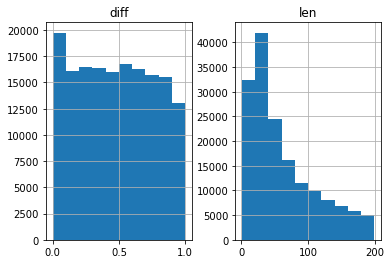

In [14]:
len_vs_diff[len_vs_diff["len"] < 200].hist()

/tmp/ipykernel_1054865/1553776715.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len_vs_diff[len_vs_diff["len"] < 200][len_vs_diff["diff"] > 0.3].hist()


array([[<AxesSubplot:title={'center':'diff'}>,
        <AxesSubplot:title={'center':'len'}>]], dtype=object)

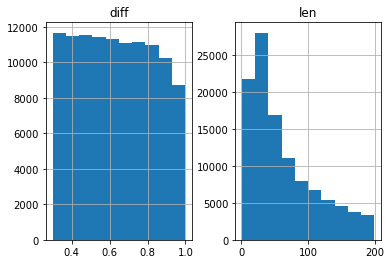

In [15]:
len_vs_diff[len_vs_diff["len"] < 200][len_vs_diff["diff"] > 0.3].hist()

In [29]:
pct_vs_diff = val_df.drop(columns=["id", "cell_id", "cell_type", "source", "rank", "ancestor_id", "parent_id", "pred"])

In [30]:
pct_vs_diff

,pct_rank,diff
30,0.928571,0.000014
31,0.214286,0.076142
32,0.023810,0.018229
33,0.738095,0.112058
34,0.285714,0.028142
...,...,...
629809,0.216942,0.063103
629810,0.466942,0.170599
629811,0.390496,0.063717
629812,0.477273,0.105078


array([[<AxesSubplot:title={'center':'pct_rank'}>,
        <AxesSubplot:title={'center':'diff'}>]], dtype=object)

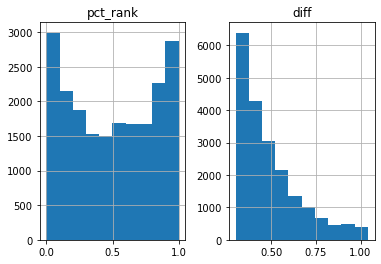

In [34]:
pct_vs_diff[pct_vs_diff["diff"] > 0.3].hist()

array([[<AxesSubplot:title={'center':'pct_rank'}>,
        <AxesSubplot:title={'center':'diff'}>]], dtype=object)

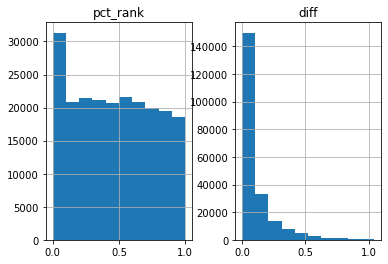

In [32]:
pct_vs_diff.hist()

In [ ]:
pct_vs_diff[.hist()

In [64]:
np.percentile(np.absolute(diffs), 95)

0.4235408827662468

In [11]:
val_df["diff"] = diff

In [20]:
print([s for s in val_df[val_df["diff"] > 0.6]["source"] if len(s) < 32])

['# Fine-Tune the Model', '## Random Forest', '## Linear Regression', '## Grid Search', '## Decision Trees', '## Train model on training data', '## Check Submission', '### Tree plot\n\n', '# Modelling\n\n### Libraries', '**Machine Learning Models**', '**Future Scaling**', '### Root Match', '### Combining Accuracy', '# END', '# Build SVM Model', '# Check Accuracy', '## Decision Tree Classifier', '## Stochastic Gradient Descent', '## Gradient Boost Trees', '## KNN', '## Gaussian Naive Bayes', '---\n\n### Define Logger', '---\n\n### Model Tuning: LightGBM', '---\n\n### Tuning Configurations', '---\n\n### Model Tuning: XGBoost', '---\n\n### Define Features for ML', '## Train Validate Split', '# Evaluate', '# Submission', '# Modeling', '## Logistic Regression model', '## 6.2.ResNet101V2', '### 6.2.3.Train model', '### 6.3.2.Compile model', '### 6.2.1.Define model', '### 6.3.3.Train model', '### 6.2.2.Compile model', '## 6.3.MobileNetV2', '### 6.2.4.Plot results', '### 6.3.4.Plot results', '

In [54]:

new_diff = pct_vs_diff[pct_vs_diff["diff"] > 0.7].sort_values('pct_rank')

In [8]:
diff = y_val - val_df[val_df['cell_type']=="markdown"]["pct_rank"].to_numpy()

array([[<AxesSubplot:title={'center':'pct_rank'}>,
        <AxesSubplot:title={'center':'diff'}>]], dtype=object)

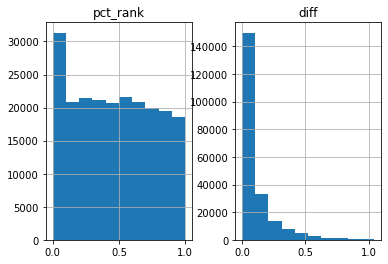

In [52]:
pct_vs_diff.hist()

array([[<AxesSubplot:title={'center':'pct_rank'}>,
        <AxesSubplot:title={'center':'diff'}>]], dtype=object)

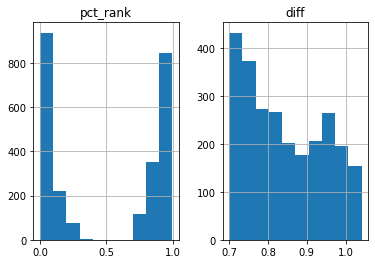

In [55]:
new_diff.hist()

In [59]:
import plotly.express as px

fig = px.histogram(pct_vs_diff, x="pct_rank", nbins=20)

array([[<AxesSubplot:title={'center':'pct_rank'}>,
        <AxesSubplot:title={'center':'diff'}>]], dtype=object)

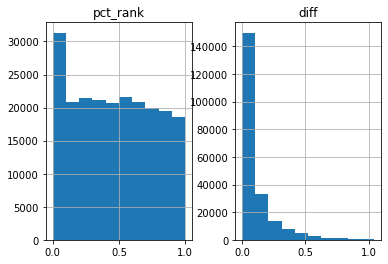

In [52]:
pct_vs_diff.hist()

In [35]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 55.0 MB/s eta 0:00:0000:0100:01
^C
ERROR: Operation cancelled by user


In [4]:
diffs = (val_df["pred"].to_numpy() - y_val)

NameError: name 'y_val' is not defined

In [27]:
import pickle
pickle.dump(diffs, open('diff.pkl', 'wb'))

In [13]:
kts = kendall_tau(df_orders.loc[y_dummy.index], y_dummy)


In [17]:
df_orders.loc[y_dummy.index]

id
000b8e6d58544b    [2e2ac098, 8d9993e9, 7b0aa087, ccccc589, a8517...
000c0a9b2fef4d    [0f08a082, fc3c6029, 1087237d, d76d8be7, d7209...
0010adf10cf27c    [8c6f2c2e, 7e1a3f88, 6f72aacb, 30d8f4eb, e22db...
00116ebc2a301c    [664c5fe6, db679b20, b3f88df9, 46d6f9e2, 13555...
00181d9eb98d2c    [7e644272, 864238e0, 56159531, cc6e1157, 0e174...
                                        ...                        
ffe023cbafd709    [d2811cb9, b12b08fe, 0903c630, 3230fa1c, e68a9...
ffe3e4945bd64f    [15b005e8, 2a8c3177, 2650f47c, 9d8ecabd, 874eb...
fff0000b99af52    [ef0f049f, 0ff5b53e, d74a865d, 426e08e7, 67df8...
fff994f45b92c0    [c0042ba8, 2a68e7fa, 0e6f6c53, de15260e, eec7e...
fffb5392db4c39    [72b952ce, 5ad888e2, dc4d9be2, e87a086c, dc32a...
Name: cell_order, Length: 13964, dtype: object

In [13]:
import pickle
pickle.dump(val_df, open('val.pkl', 'wb'))

In [ ]:
val_df.groupby('id')